# MNIST Dataset

In [ ]:
import tensorflow
from tensorflow import keras
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

#Define input image dimensions
#Large images take too much time and resources.
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)

##########################################################################
#Given input of noise (latent) vector, the Generator produces an image.
def build_generator():

    noise_shape = (100,) #1D array of size 100 (latent vector / noise)

#Define your generator network 
#Here we are only using Dense layers. But network can be complicated based
#on the application. For example, you can use VGG for super res. GAN.         

    model = Sequential()

    model.add(Dense(256, input_shape=noise_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    model.summary()

    noise = Input(shape=noise_shape)
    img = model(noise)    #Generated image

    return Model(noise, img)

#Alpha — α is a hyperparameter which controls the underlying value to which the
#function saturates negatives network inputs.
#Momentum — Speed up the training
##########################################################################

#Given an input image, the Discriminator outputs the likelihood of the image being real.
    #Binary classification - true or false (we're calling it validity)

def build_discriminator():


    model = Sequential()

    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)
#The validity is the Discriminator’s guess of input being real or not.


#Now that we have constructed our two models it’s time to pit them against each other.
#We do this by defining a training function, loading the data set, re-scaling our training
#images and setting the ground truths. 
def train(epochs, batch_size=128, save_interval=50):

    # Load the dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Convert to float and Rescale -1 to 1 (Can also do 0 to 1)
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5

#Add channels dimension. As the input to our gen and discr. has a shape 28x28x1.
    X_train = np.expand_dims(X_train, axis=3) 

    half_batch = int(batch_size / 2)


#We then loop through a number of epochs to train our Discriminator by first selecting
#a random batch of images from our true dataset, generating a set of images from our
#Generator, feeding both set of images into our Discriminator, and finally setting the
#loss parameters for both the real and fake images, as well as the combined loss. 
    
    for epoch in range(epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random half batch of real images
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]

 
        noise = np.random.normal(0, 1, (half_batch, 100))

        # Generate a half batch of fake images
        gen_imgs = generator.predict(noise)

        # Train the discriminator on real and fake images, separately
        #Research showed that separate training is more effective. 
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
    #take average loss from real and fake images. 
    #
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) 

#And within the same loop we train our Generator, by setting the input noise and
#ultimately training the Generator to have the Discriminator label its samples as valid
#by specifying the gradient loss.
        # ---------------------
        #  Train Generator
        # ---------------------
#Create noise vectors as input for generator. 
#Create as many noise vectors as defined by the batch size. 
#Based on normal distribution. Output will be of size (batch size, 100)
        noise = np.random.normal(0, 1, (batch_size, 100)) 

        # The generator wants the discriminator to label the generated samples
        # as valid (ones)
        #This is where the genrator is trying to trick discriminator into believing
        #the generated image is true (hence value of 1 for y)
        valid_y = np.array([1] * batch_size) #Creates an array of all ones of size=batch size

        # Generator is part of combined where it got directly linked with the discriminator
        # Train the generator with noise as x and 1 as y. 
        # Again, 1 as the output as it is adversarial and if generator did a great
        #job of folling the discriminator then the output would be 1 (true)
        g_loss = combined.train_on_batch(noise, valid_y)


#Additionally, in order for us to keep track of our training process, we print the
#progress and save the sample image output depending on the epoch interval specified.  
# Plot the progress
        
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

        # If at save interval => save generated image samples
        if epoch % save_interval == 0:
            save_imgs(epoch)

#when the specific sample_interval is hit, we call the
#sample_image function. Which looks as follows.

def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("C:/Digital Engineering/GANSreeni/mnist_%d.png" % epoch)
    plt.close()
#This function saves our images for us to view


##############################################################################

#Let us also define our optimizer for easy use later on.
#That way if you change your mind, you can change it easily here
optimizer = Adam(0.0002, 0.5)  #Learning rate and momentum.

# Build and compile the discriminator first. 
#Generator will be trained as part of the combined model, later. 
#pick the loss function and the type of metric to keep track.                 
#Binary cross entropy as we are doing prediction and it is a better
#loss function compared to MSE or other. 
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])

#build and compile our Discriminator, pick the loss function

#SInce we are only generating (faking) images, let us not track any metrics.
generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

##This builds the Generator and defines the input noise. 
#In a GAN the Generator network takes noise z as an input to produce its images.  
z = Input(shape=(100,))   #Our random input to the generator
img = generator(z)

#This ensures that when we combine our networks we only train the Generator.
#While generator training we do not want discriminator weights to be adjusted. 
#This Doesn't affect the above descriminator training.     
discriminator.trainable = False  

#This specifies that our Discriminator will take the images generated by our Generator
#and true dataset and set its output to a parameter called valid, which will indicate
#whether the input is real or not.  
valid = discriminator(img)  #Validity check on the generated image


#Here we combined the models and also set our loss function and optimizer. 
#Again, we are only training the generator here. 
#The ultimate goal here is for the Generator to fool the Discriminator.  
# The combined model  (stacked generator and discriminator) takes
# noise as input => generates images => determines validity

combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)


train(epochs=100, batch_size=32, save_interval=10)

#Save model for future use to generate fake images
#Not tested yet... make sure right model is being saved..
#Compare with GAN4

generator.save('generator_model.h5')  #Test the model on GAN4_predict...
#Change epochs back to 30K
                
#Epochs dictate the number of backward and forward propagations, the batch_size
#indicates the number of training samples per backward/forward propagation, and the
#sample_interval specifies after how many epochs we call our sample_image function.


# Generating Images from saved model

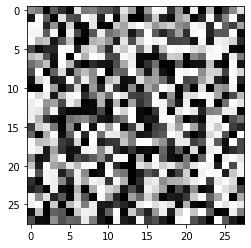

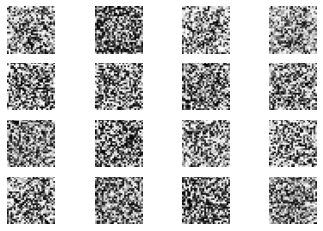

In [7]:
#FOr single image
# example of generating an image for a specific point in the latent space
from keras.models import load_model
from numpy import asarray
from matplotlib import pyplot
from numpy.random import randn

# load model
model = load_model('generator_model.h5')

#To create same image, suppy same vector each time
# all 0s
#vector = asarray([[0. for _ in range(100)]])  #Vector of all zeros

#To create random images each time...
vector = randn(100) #Vector of random numbers (creates a column, need to reshape)
vector = vector.reshape(1, 100)

# generate image
X = model.predict(vector)

# plot the result
pyplot.imshow(X[0, :, :, 0], cmap='gray_r')
pyplot.show()

#Uncomment to run this part of the code....
##############################################
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot as plt
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	plt.show()
# load model
model = load_model('generator_model.h5')
# generate images
#Generate 16 images, each image provide a vector of size 100 as input
latent_points = generate_latent_points(100, 16) 
# generate images
X = model.predict(latent_points)
# plot the result
save_plot(X, 4)  #Plot 4x4 grid (Change to 5 if generating 25 images)

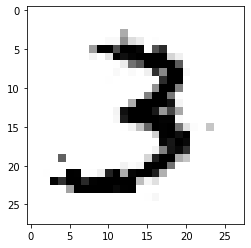

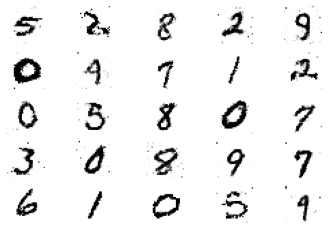

In [2]:
#FOr single image
# example of generating an image for a specific point in the latent space
from keras.models import load_model
from numpy import asarray
from matplotlib import pyplot
from numpy.random import randn

# load model
model = load_model('generator_model_100K.h5')

#To create same image, suppy same vector each time
# all 0s
#vector = asarray([[0. for _ in range(100)]])  #Vector of all zeros

#To create random images each time...
vector = randn(100) #Vector of random numbers (creates a column, need to reshape)
vector = vector.reshape(1, 100)

# generate image
X = model.predict(vector)

# plot the result
pyplot.imshow(X[0, :, :, 0], cmap='gray_r')
pyplot.show()


#Uncomment to run this part of the code....
##############################################
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot as plt
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data   
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	plt.show()
# load model
model = load_model('generator_model_100K.h5')
# generate images
#Generate 16 images, each image provide a vector of size 100 as input
latent_points = generate_latent_points(100, 25) 
# generate images
X = model.predict(latent_points)
# plot the result
save_plot(X, 5)  #Plot 4x4 grid (Change to 5 if generating 25 images)

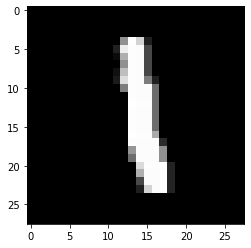

In [53]:
from keras.datasets import mnist
from matplotlib import pyplot as plt

(X_train, _), (_, _) = mnist.load_data()

X_train[1]
plt.imshow(X_train[6])

#  Using chest x-ray Dataset

In [46]:
import numpy as np 
import pandas as pd 
import random

# folder
import os
import glob

# image
from PIL import Image

# visu
import matplotlib.pyplot as plt
plt.rc('image', cmap='gray')

# sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#tensorflow
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping


In [34]:
#categories = ["NORMAL", "PNEUMONIA"]
#datasets = ["train"]
categories = ["PNEUMONIA"]
datasets = ["train", "test", "val"]

In [35]:
%%time

widths = []
heights = []

for set_ in datasets:
    for cat in categories:
        filelist = glob.glob('C:/Digital Engineering/Chest/chest_xray/chest_xray/' + set_ + '/' + cat + '/*.jpeg')
        widths.extend([Image.open(fname).size[0] for fname in filelist])
        heights.extend([Image.open(fname).size[1] for fname in filelist])
        
images_size = pd.DataFrame({"widths": widths, "heights": heights})
        
print("Average image width: " + f'{images_size["widths"].mean():.2f}')
print("Average image height: " + f'{images_size["heights"].mean():.2f}')
images_size.shape

Average image width: 1195.07
Average image height: 819.55
Wall time: 4.36 s


(4273, 2)

In [36]:
im_width = int(images_size["widths"].mean()/10)
im_height = int(images_size["heights"].mean()/10)
print("image width: " + str(im_width))
print("image height: " + str(im_height))

image width: 119
image height: 81


In [37]:
%%time

data = []
target = []

for set_ in datasets:
    for cat in categories:
        filelist = glob.glob('C:/Digital Engineering/Chest/chest_xray/chest_xray/' + set_ + '/' + cat + '/*.jpeg')
        target.extend([cat for _ in filelist])
        data.extend([np.array(Image.open(fname).convert('L').resize((im_width, im_height))) for fname in filelist])
        
#

data_array = np.stack(data, axis=0)

Wall time: 18.6 s


In [38]:
print(data_array.shape)

(4273, 81, 119)


In [39]:
pd.concat([pd.DataFrame(pd.DataFrame({"target" : target}).value_counts()).rename(columns={0:"count"}),
           pd.DataFrame(pd.DataFrame(target).value_counts()*100/len(target)).applymap(round).rename(columns={0:"%"})], axis=1)

count    %
PNEUMONIA   4273  100

In [15]:
data_array[1:5]

array([[[ 31,  63, 109, ...,  87,  64,  28],
        [ 30,  66, 100, ...,  96,  55,  25],
        [ 29,  54,  79, ..., 103,  55,  22],
        ...,
        [  0,   0,  55, ...,  74,   0,   0],
        [  0,   0,  54, ...,  75,   1,   0],
        [  0,   0,  51, ...,  83,   0,   0]],

       [[ 10,  52,  78, ...,  78,  60,  22],
        [  0,  35,  70, ...,  74,  50,  11],
        [ 51,  22,  59, ...,  72,  39,   3],
        ...,
        [  0,   1,  66, ...,  74,   2,   0],
        [  0,   4,  72, ...,  84,   6,   0],
        [  0,   4,  73, ...,  90,   9,   0]],

       [[ 49,  79, 102, ...,  23,  16,  20],
        [ 36,  74, 105, ...,  20,  16,  20],
        [ 21,  70, 102, ...,  21,  15,  19],
        ...,
        [ 15,   8,  24, ...,  77,   5,  10],
        [ 15,   8,  23, ...,  79,   6,  10],
        [ 15,   8,  23, ...,  78,   6,  10]],

       [[ 78,  58,  47, ...,  90,  64,  31],
        [ 81,  86,  93, ...,  94,  46,  24],
        [ 76,  87,  97, ...,  77,  42,  15],
        ..

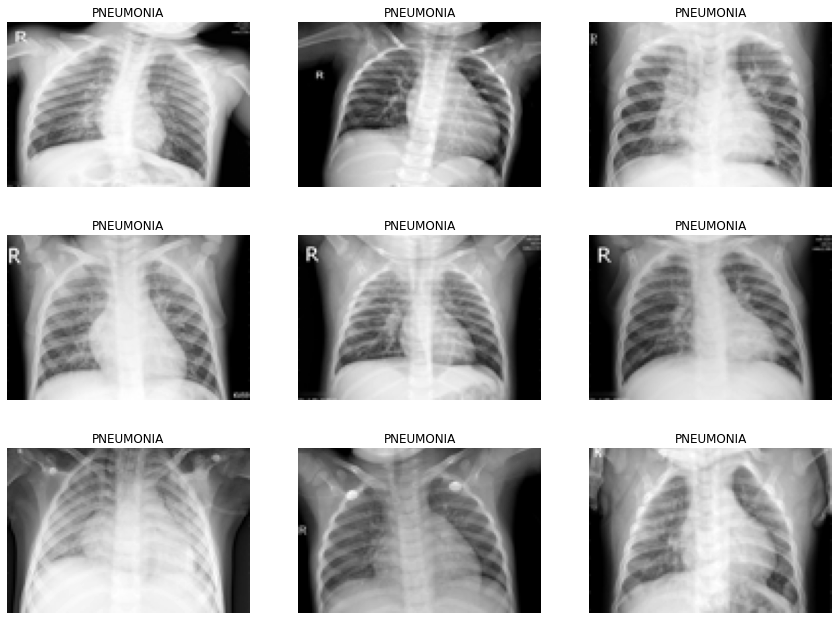

In [40]:
fig = plt.figure(figsize=(20,15))
gs = fig.add_gridspec(4, 4)
#
for line in range(0, 3):
    for row in range(0, 3):
        num_image = random.randint(0, data_array.shape[0])
        ax = fig.add_subplot(gs[line, row])
        ax.axis('off');
        ax.set_title(target[num_image])
        ax.imshow(data_array[num_image]);

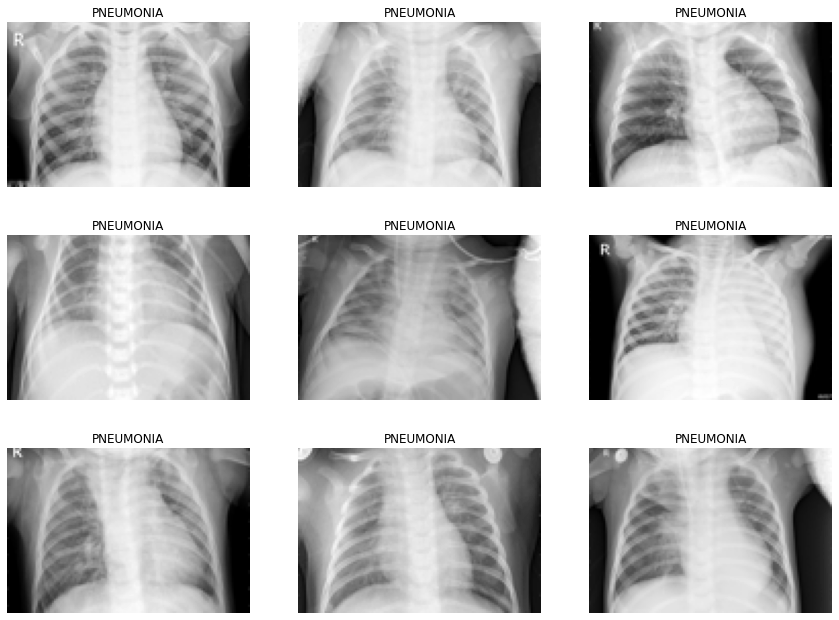

In [77]:
fig = plt.figure(figsize=(20,15))
gs = fig.add_gridspec(4, 4)
#
for line in range(0, 3):
    for row in range(0, 3):
        num_image = random.randint(0, data_array.shape[0])
        ax = fig.add_subplot(gs[line, row])
        ax.axis('off');
        ax.set_title(target[num_image])
        ax.imshow(data_array[num_image]);

In [70]:
X_train, X_test, y_train, y_test = train_test_split(data_array, np.array(target), random_state=43, test_size=0.2, stratify=target)

In [47]:
X_train.shape

(4684, 97, 132)

In [42]:
import tensorflow
from tensorflow import keras
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
# example of a dcgan on cifar10
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.datasets.cifar10 import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from matplotlib import pyplot

#Define input image dimensions
#Large images take too much time and resources.
img_rows = 81
img_cols = 119
channels = 1
img_shape = (img_rows, img_cols, channels)

##########################################################################
#Given input of noise (latent) vector, the Generator produces an image.
def build_generator():

    noise_shape = (100,) #1D array of size 100 (latent vector / noise)

#Define your generator network 
#Here we are only using Dense layers. But network can be complicated based
#on the application. For example, you can use VGG for super res. GAN.         


    '''model = Sequential()
    # foundation for 4x4 image
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
    # upsample to 8x8
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # output layer
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    model.summary()

    noise = Input(shape=noise_shape)
    img = model(noise)    #Generated image
    return Model(noise, img)'''
    
    model = Sequential()

    model.add(Dense(256, input_shape=noise_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    model.summary()

    noise = Input(shape=noise_shape)
    img = model(noise)    #Generated image

    return Model(noise, img)


#Alpha — α is a hyperparameter which controls the underlying value to which the
#function saturates negatives network inputs.
#Momentum — Speed up the training
##########################################################################

#Given an input image, the Discriminator outputs the likelihood of the image being real.
    #Binary classification - true or false (we're calling it validity)

def build_discriminator():


    model = Sequential()

    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)
#The validity is the Discriminator’s guess of input being real or not.

#Now that we have constructed our two models it’s time to pit them against each other.
#We do this by defining a training function, loading the data set, re-scaling our training
#images and setting the ground truths. 
def train(epochs, batch_size=128, save_interval=50):

    # Load the dataset
    #(X_train, _), (_, _) = mnist.load_data()
    X_train, X_test, y_train, y_test = train_test_split(data_array, np.array(target), random_state=43, test_size=0.2, stratify=target)
    

    # Convert to float and Rescale -1 to 1 (Can also do 0 to 1)
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5

#Add channels dimension. As the input to our gen and discr. has a shape 28x28x1.
    X_train = np.expand_dims(X_train, axis=3) 

    half_batch = int(batch_size / 2)


#We then loop through a number of epochs to train our Discriminator by first selecting
#a random batch of images from our true dataset, generating a set of images from our
#Generator, feeding both set of images into our Discriminator, and finally setting the
#loss parameters for both the real and fake images, as well as the combined loss. 
    
    for epoch in range(epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random half batch of real images
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]

 
        noise = np.random.normal(0, 1, (half_batch, 100))

        # Generate a half batch of fake images
        gen_imgs = generator.predict(noise)

        # Train the discriminator on real and fake images, separately
        #Research showed that separate training is more effective. 
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
    #take average loss from real and fake images. 
    #
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) 

#And within the same loop we train our Generator, by setting the input noise and
#ultimately training the Generator to have the Discriminator label its samples as valid
#by specifying the gradient loss.
        # ---------------------
        #  Train Generator
        # ---------------------
#Create noise vectors as input for generator. 
#Create as many noise vectors as defined by the batch size. 
#Based on normal distribution. Output will be of size (batch size, 100)
        noise = np.random.normal(0, 1, (batch_size, 100)) 

        # The generator wants the discriminator to label the generated samples
        # as valid (ones)
        #This is where the genrator is trying to trick discriminator into believing
        #the generated image is true (hence value of 1 for y)
        valid_y = np.array([1] * batch_size) #Creates an array of all ones of size=batch size

        # Generator is part of combined where it got directly linked with the discriminator
        # Train the generator with noise as x and 1 as y. 
        # Again, 1 as the output as it is adversarial and if generator did a great
        #job of folling the discriminator then the output would be 1 (true)
        g_loss = combined.train_on_batch(noise, valid_y)


#Additionally, in order for us to keep track of our training process, we print the
#progress and save the sample image output depending on the epoch interval specified.  
# Plot the progress
        
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

        # If at save interval => save generated image samples
        if epoch % save_interval == 0:
            save_imgs(epoch)

#when the specific sample_interval is hit, we call the
#sample_image function. Which looks as follows.

def save_imgs(epoch):
    r, c = 2, 2
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("C:/Digital Engineering/GANSreeni/PNEUMONIA3/pneumonia_%d.png" % epoch)
    plt.close()
#This function saves our images for us to view


##############################################################################

#Let us also define our optimizer for easy use later on.
#That way if you change your mind, you can change it easily here
optimizer = Adam(0.0002, 0.5)  #Learning rate and momentum.
#optimizer= SGD(0.0001)

# Build and compile the discriminator first. 
#Generator will be trained as part of the combined model, later. 
#pick the loss function and the type of metric to keep track.                 
#Binary cross entropy as we are doing prediction and it is a better
#loss function compared to MSE or other. 
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])

#build and compile our Discriminator, pick the loss function

#SInce we are only generating (faking) images, let us not track any metrics.
generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

##This builds the Generator and defines the input noise. 
#In a GAN the Generator network takes noise z as an input to produce its images.  
z = Input(shape=(100,))   #Our random input to the generator
img = generator(z)

#This ensures that when we combine our networks we only train the Generator.
#While generator training we do not want discriminator weights to be adjusted. 
#This Doesn't affect the above descriminator training.     
discriminator.trainable = False  

#This specifies that our Discriminator will take the images generated by our Generator
#and true dataset and set its output to a parameter called valid, which will indicate
#whether the input is real or not.  
valid = discriminator(img)  #Validity check on the generated image


#Here we combined the models and also set our loss function and optimizer. 
#Again, we are only training the generator here. 
#The ultimate goal here is for the Generator to fool the Discriminator.  
# The combined model  (stacked generator and discriminator) takes
# noise as input => generates images => determines validity

combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)


train(epochs=100000, batch_size=32, save_interval=5000)

#Save model for future use to generate fake images
#Not tested yet... make sure right model is being saved..
#Compare with GAN4

generator.save('C:/Digital Engineering/GANSreeni/PNEUMONIA3/generator_model_normal2.h5')  

#Test the model on GAN4_predict...
#Change epochs back to 30K
                
#Epochs dictate the number of backward and forward propagations, the batch_size
#indicates the number of training samples per backward/forward propagation, and the
#sample_interval specifies after how many epochs we call our sample_image function.


Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 9639)              0         
_________________________________________________________________
dense_44 (Dense)             (None, 1024)              9871360   
_________________________________________________________________
leaky_re_lu_38 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dense_45 (Dense)             (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_39 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_40 (LeakyReLU)   (None, 256)             

90 [D loss: 0.173402, acc.: 93.75%] [G loss: 16.377354]
91 [D loss: 0.657958, acc.: 75.00%] [G loss: 24.035498]
92 [D loss: 0.406348, acc.: 81.25%] [G loss: 19.272930]
93 [D loss: 0.115199, acc.: 93.75%] [G loss: 14.553349]
94 [D loss: 0.315145, acc.: 84.38%] [G loss: 14.693720]
95 [D loss: 0.269458, acc.: 84.38%] [G loss: 14.753409]
96 [D loss: 0.384959, acc.: 78.12%] [G loss: 11.022767]
97 [D loss: 0.199093, acc.: 90.62%] [G loss: 8.357224]
98 [D loss: 0.230630, acc.: 84.38%] [G loss: 9.207182]
99 [D loss: 0.188379, acc.: 93.75%] [G loss: 16.745300]
100 [D loss: 0.140181, acc.: 96.88%] [G loss: 6.835494]
101 [D loss: 0.203975, acc.: 90.62%] [G loss: 7.807700]
102 [D loss: 0.080568, acc.: 96.88%] [G loss: 8.164129]
103 [D loss: 0.209032, acc.: 87.50%] [G loss: 13.926106]
104 [D loss: 0.160703, acc.: 96.88%] [G loss: 5.753692]
105 [D loss: 0.264618, acc.: 84.38%] [G loss: 5.879868]
106 [D loss: 0.393867, acc.: 87.50%] [G loss: 5.437974]
107 [D loss: 0.220642, acc.: 90.62%] [G loss: 5.1

237 [D loss: 0.299717, acc.: 87.50%] [G loss: 1.829746]
238 [D loss: 0.186926, acc.: 87.50%] [G loss: 2.757593]
239 [D loss: 0.240657, acc.: 90.62%] [G loss: 2.166746]
240 [D loss: 0.220936, acc.: 96.88%] [G loss: 2.519418]
241 [D loss: 0.217277, acc.: 93.75%] [G loss: 2.521988]
242 [D loss: 0.233333, acc.: 90.62%] [G loss: 2.458132]
243 [D loss: 0.188297, acc.: 90.62%] [G loss: 3.325595]
244 [D loss: 1.037832, acc.: 37.50%] [G loss: 0.419203]
245 [D loss: 0.807186, acc.: 53.12%] [G loss: 1.003656]
246 [D loss: 0.241877, acc.: 96.88%] [G loss: 2.140045]
247 [D loss: 1.136872, acc.: 37.50%] [G loss: 0.492835]
248 [D loss: 0.769149, acc.: 56.25%] [G loss: 1.088668]
249 [D loss: 0.281396, acc.: 87.50%] [G loss: 2.119356]
250 [D loss: 0.459232, acc.: 81.25%] [G loss: 1.517894]
251 [D loss: 0.271074, acc.: 87.50%] [G loss: 2.193754]
252 [D loss: 0.143035, acc.: 100.00%] [G loss: 2.410425]
253 [D loss: 0.234611, acc.: 96.88%] [G loss: 2.127409]
254 [D loss: 0.293883, acc.: 87.50%] [G loss: 2

384 [D loss: 0.246785, acc.: 87.50%] [G loss: 2.045753]
385 [D loss: 0.545912, acc.: 71.88%] [G loss: 1.215402]
386 [D loss: 0.271059, acc.: 87.50%] [G loss: 2.311917]
387 [D loss: 0.784952, acc.: 59.38%] [G loss: 1.137778]
388 [D loss: 0.367939, acc.: 84.38%] [G loss: 2.208386]
389 [D loss: 0.797812, acc.: 43.75%] [G loss: 0.848225]
390 [D loss: 0.304235, acc.: 90.62%] [G loss: 1.343111]
391 [D loss: 0.543856, acc.: 62.50%] [G loss: 1.139285]
392 [D loss: 0.348792, acc.: 84.38%] [G loss: 1.971993]
393 [D loss: 0.695852, acc.: 59.38%] [G loss: 0.877811]
394 [D loss: 0.449840, acc.: 65.62%] [G loss: 1.287476]
395 [D loss: 0.429258, acc.: 78.12%] [G loss: 1.468519]
396 [D loss: 0.475059, acc.: 81.25%] [G loss: 1.562779]
397 [D loss: 0.375065, acc.: 84.38%] [G loss: 1.739769]
398 [D loss: 0.385590, acc.: 90.62%] [G loss: 1.781910]
399 [D loss: 0.421025, acc.: 81.25%] [G loss: 1.770669]
400 [D loss: 0.210887, acc.: 96.88%] [G loss: 2.198112]
401 [D loss: 0.710037, acc.: 53.12%] [G loss: 0.

677 [D loss: 0.698705, acc.: 53.12%] [G loss: 1.391101]
678 [D loss: 0.647387, acc.: 75.00%] [G loss: 1.208528]
679 [D loss: 0.629751, acc.: 68.75%] [G loss: 1.227247]
680 [D loss: 0.673176, acc.: 59.38%] [G loss: 1.181972]
681 [D loss: 0.620144, acc.: 65.62%] [G loss: 1.384510]
682 [D loss: 0.758968, acc.: 50.00%] [G loss: 0.959543]
683 [D loss: 0.664438, acc.: 59.38%] [G loss: 0.999315]
684 [D loss: 0.525507, acc.: 71.88%] [G loss: 1.060726]
685 [D loss: 0.517248, acc.: 81.25%] [G loss: 0.958442]
686 [D loss: 0.592256, acc.: 68.75%] [G loss: 1.147909]
687 [D loss: 0.476094, acc.: 81.25%] [G loss: 1.193579]
688 [D loss: 0.627177, acc.: 56.25%] [G loss: 1.235900]
689 [D loss: 0.520585, acc.: 78.12%] [G loss: 1.237726]
690 [D loss: 0.555773, acc.: 75.00%] [G loss: 1.526408]
691 [D loss: 0.701191, acc.: 50.00%] [G loss: 1.084532]
692 [D loss: 0.535994, acc.: 75.00%] [G loss: 1.330013]
693 [D loss: 0.774225, acc.: 40.62%] [G loss: 1.090529]
694 [D loss: 0.630330, acc.: 65.62%] [G loss: 1.

825 [D loss: 0.539737, acc.: 71.88%] [G loss: 1.035437]
826 [D loss: 0.572682, acc.: 71.88%] [G loss: 1.076908]
827 [D loss: 0.645313, acc.: 65.62%] [G loss: 1.024883]
828 [D loss: 0.505190, acc.: 87.50%] [G loss: 1.165462]
829 [D loss: 0.537958, acc.: 78.12%] [G loss: 1.234207]
830 [D loss: 0.831973, acc.: 40.62%] [G loss: 1.054747]
831 [D loss: 0.614733, acc.: 65.62%] [G loss: 1.010427]
832 [D loss: 0.571019, acc.: 62.50%] [G loss: 1.083155]
833 [D loss: 0.521462, acc.: 71.88%] [G loss: 1.091474]
834 [D loss: 0.607450, acc.: 65.62%] [G loss: 0.936774]
835 [D loss: 0.529335, acc.: 75.00%] [G loss: 1.224621]
836 [D loss: 0.913668, acc.: 46.88%] [G loss: 0.989629]
837 [D loss: 0.553068, acc.: 81.25%] [G loss: 1.008111]
838 [D loss: 0.523092, acc.: 90.62%] [G loss: 1.037013]
839 [D loss: 0.698027, acc.: 62.50%] [G loss: 1.046890]
840 [D loss: 0.634844, acc.: 59.38%] [G loss: 1.102766]
841 [D loss: 0.584227, acc.: 68.75%] [G loss: 1.159028]
842 [D loss: 0.660721, acc.: 59.38%] [G loss: 0.

973 [D loss: 0.604725, acc.: 68.75%] [G loss: 1.047854]
974 [D loss: 0.671099, acc.: 53.12%] [G loss: 0.969741]
975 [D loss: 0.650878, acc.: 56.25%] [G loss: 1.000400]
976 [D loss: 0.548894, acc.: 65.62%] [G loss: 0.916344]
977 [D loss: 0.698808, acc.: 59.38%] [G loss: 1.008011]
978 [D loss: 0.521918, acc.: 71.88%] [G loss: 1.089857]
979 [D loss: 0.689067, acc.: 59.38%] [G loss: 1.148936]
980 [D loss: 0.778740, acc.: 59.38%] [G loss: 1.012046]
981 [D loss: 0.788644, acc.: 28.12%] [G loss: 0.855506]
982 [D loss: 0.606737, acc.: 56.25%] [G loss: 0.946210]
983 [D loss: 0.657691, acc.: 50.00%] [G loss: 0.865298]
984 [D loss: 0.712090, acc.: 59.38%] [G loss: 0.940050]
985 [D loss: 0.605436, acc.: 75.00%] [G loss: 1.157386]
986 [D loss: 0.774271, acc.: 31.25%] [G loss: 0.827637]
987 [D loss: 0.617975, acc.: 59.38%] [G loss: 0.926555]
988 [D loss: 0.692275, acc.: 59.38%] [G loss: 0.889476]
989 [D loss: 0.703338, acc.: 53.12%] [G loss: 1.057146]
990 [D loss: 0.682927, acc.: 59.38%] [G loss: 1.

1261 [D loss: 0.682577, acc.: 53.12%] [G loss: 0.914622]
1262 [D loss: 0.561651, acc.: 75.00%] [G loss: 0.951220]
1263 [D loss: 0.573422, acc.: 68.75%] [G loss: 1.112542]
1264 [D loss: 0.736982, acc.: 53.12%] [G loss: 0.996434]
1265 [D loss: 0.675678, acc.: 53.12%] [G loss: 0.997319]
1266 [D loss: 0.529011, acc.: 75.00%] [G loss: 1.130436]
1267 [D loss: 0.814029, acc.: 53.12%] [G loss: 1.140094]
1268 [D loss: 0.788108, acc.: 50.00%] [G loss: 1.147393]
1269 [D loss: 0.736330, acc.: 50.00%] [G loss: 1.036076]
1270 [D loss: 0.657898, acc.: 65.62%] [G loss: 1.023980]
1271 [D loss: 0.709151, acc.: 62.50%] [G loss: 0.945518]
1272 [D loss: 0.616227, acc.: 62.50%] [G loss: 0.951887]
1273 [D loss: 0.621723, acc.: 62.50%] [G loss: 0.983498]
1274 [D loss: 0.822798, acc.: 50.00%] [G loss: 0.935752]
1275 [D loss: 0.633397, acc.: 68.75%] [G loss: 1.013490]
1276 [D loss: 0.802759, acc.: 37.50%] [G loss: 0.967736]
1277 [D loss: 0.627526, acc.: 59.38%] [G loss: 0.966429]
1278 [D loss: 0.753462, acc.: 4

1548 [D loss: 0.653127, acc.: 68.75%] [G loss: 0.902907]
1549 [D loss: 0.673207, acc.: 50.00%] [G loss: 0.845698]
1550 [D loss: 0.600398, acc.: 68.75%] [G loss: 0.998398]
1551 [D loss: 0.707189, acc.: 56.25%] [G loss: 0.999645]
1552 [D loss: 0.656209, acc.: 62.50%] [G loss: 0.996184]
1553 [D loss: 0.505621, acc.: 81.25%] [G loss: 1.094153]
1554 [D loss: 0.674500, acc.: 53.12%] [G loss: 1.081298]
1555 [D loss: 0.568577, acc.: 71.88%] [G loss: 0.994936]
1556 [D loss: 0.683575, acc.: 53.12%] [G loss: 0.932971]
1557 [D loss: 0.830818, acc.: 43.75%] [G loss: 0.985346]
1558 [D loss: 0.577533, acc.: 71.88%] [G loss: 1.001155]
1559 [D loss: 0.720525, acc.: 62.50%] [G loss: 0.880442]
1560 [D loss: 0.557255, acc.: 71.88%] [G loss: 1.039734]
1561 [D loss: 0.660992, acc.: 62.50%] [G loss: 1.099800]
1562 [D loss: 0.610380, acc.: 62.50%] [G loss: 0.975215]
1563 [D loss: 0.763870, acc.: 53.12%] [G loss: 0.919200]
1564 [D loss: 0.740418, acc.: 53.12%] [G loss: 0.831752]
1565 [D loss: 0.668957, acc.: 6

1693 [D loss: 0.583378, acc.: 62.50%] [G loss: 1.067230]
1694 [D loss: 0.793665, acc.: 65.62%] [G loss: 1.285498]
1695 [D loss: 0.704669, acc.: 56.25%] [G loss: 1.398761]
1696 [D loss: 1.000417, acc.: 50.00%] [G loss: 0.954981]
1697 [D loss: 0.569756, acc.: 68.75%] [G loss: 1.066050]
1698 [D loss: 0.729628, acc.: 56.25%] [G loss: 1.070484]
1699 [D loss: 0.643777, acc.: 59.38%] [G loss: 1.168112]
1700 [D loss: 0.601256, acc.: 71.88%] [G loss: 1.092550]
1701 [D loss: 0.558873, acc.: 75.00%] [G loss: 1.034143]
1702 [D loss: 0.785753, acc.: 43.75%] [G loss: 0.995824]
1703 [D loss: 0.617321, acc.: 65.62%] [G loss: 1.094559]
1704 [D loss: 0.692319, acc.: 53.12%] [G loss: 0.959657]
1705 [D loss: 0.721846, acc.: 50.00%] [G loss: 1.021394]
1706 [D loss: 0.677028, acc.: 56.25%] [G loss: 0.924808]
1707 [D loss: 0.719699, acc.: 50.00%] [G loss: 0.985067]
1708 [D loss: 0.618856, acc.: 59.38%] [G loss: 0.987877]
1709 [D loss: 0.655421, acc.: 53.12%] [G loss: 0.890927]
1710 [D loss: 0.698206, acc.: 7

1980 [D loss: 0.726144, acc.: 50.00%] [G loss: 0.852028]
1981 [D loss: 0.670845, acc.: 59.38%] [G loss: 0.974100]
1982 [D loss: 0.761044, acc.: 43.75%] [G loss: 0.954623]
1983 [D loss: 0.667269, acc.: 56.25%] [G loss: 0.949477]
1984 [D loss: 0.618266, acc.: 65.62%] [G loss: 0.996673]
1985 [D loss: 0.719140, acc.: 56.25%] [G loss: 1.013934]
1986 [D loss: 0.755067, acc.: 46.88%] [G loss: 0.873237]
1987 [D loss: 0.642154, acc.: 65.62%] [G loss: 0.960466]
1988 [D loss: 0.654344, acc.: 59.38%] [G loss: 0.972693]
1989 [D loss: 0.748022, acc.: 50.00%] [G loss: 0.829194]
1990 [D loss: 0.792132, acc.: 59.38%] [G loss: 1.072885]
1991 [D loss: 0.589786, acc.: 68.75%] [G loss: 1.185848]
1992 [D loss: 0.738526, acc.: 53.12%] [G loss: 0.850850]
1993 [D loss: 0.593608, acc.: 71.88%] [G loss: 0.997297]
1994 [D loss: 0.755084, acc.: 43.75%] [G loss: 0.914207]
1995 [D loss: 0.617464, acc.: 65.62%] [G loss: 0.930298]
1996 [D loss: 0.685442, acc.: 62.50%] [G loss: 0.874293]
1997 [D loss: 0.721508, acc.: 5

2266 [D loss: 0.734266, acc.: 50.00%] [G loss: 1.322549]
2267 [D loss: 0.643111, acc.: 65.62%] [G loss: 1.089452]
2268 [D loss: 0.843075, acc.: 46.88%] [G loss: 1.122126]
2269 [D loss: 0.625222, acc.: 59.38%] [G loss: 1.322210]
2270 [D loss: 0.819389, acc.: 40.62%] [G loss: 0.869462]
2271 [D loss: 0.659231, acc.: 62.50%] [G loss: 0.894695]
2272 [D loss: 0.620956, acc.: 68.75%] [G loss: 1.024981]
2273 [D loss: 0.703197, acc.: 59.38%] [G loss: 0.939180]
2274 [D loss: 0.719791, acc.: 40.62%] [G loss: 1.038375]
2275 [D loss: 0.788449, acc.: 50.00%] [G loss: 1.029983]
2276 [D loss: 0.816016, acc.: 43.75%] [G loss: 0.954159]
2277 [D loss: 0.641237, acc.: 59.38%] [G loss: 1.212302]
2278 [D loss: 0.651575, acc.: 62.50%] [G loss: 1.205132]
2279 [D loss: 0.736738, acc.: 65.62%] [G loss: 1.079573]
2280 [D loss: 0.697204, acc.: 53.12%] [G loss: 0.937573]
2281 [D loss: 0.596943, acc.: 68.75%] [G loss: 0.898546]
2282 [D loss: 0.660839, acc.: 62.50%] [G loss: 0.983280]
2283 [D loss: 0.597728, acc.: 6

2554 [D loss: 0.658331, acc.: 62.50%] [G loss: 1.041263]
2555 [D loss: 0.803095, acc.: 50.00%] [G loss: 0.958624]
2556 [D loss: 0.594610, acc.: 62.50%] [G loss: 1.053018]
2557 [D loss: 0.725389, acc.: 50.00%] [G loss: 1.047304]
2558 [D loss: 0.642775, acc.: 68.75%] [G loss: 1.039576]
2559 [D loss: 0.567644, acc.: 65.62%] [G loss: 1.263169]
2560 [D loss: 0.707782, acc.: 46.88%] [G loss: 0.988759]
2561 [D loss: 0.709573, acc.: 50.00%] [G loss: 1.013362]
2562 [D loss: 0.644816, acc.: 59.38%] [G loss: 1.049927]
2563 [D loss: 0.608599, acc.: 65.62%] [G loss: 0.957666]
2564 [D loss: 0.625164, acc.: 68.75%] [G loss: 0.993052]
2565 [D loss: 0.654002, acc.: 62.50%] [G loss: 1.035634]
2566 [D loss: 0.620492, acc.: 65.62%] [G loss: 0.946410]
2567 [D loss: 0.644355, acc.: 56.25%] [G loss: 0.945358]
2568 [D loss: 0.907132, acc.: 46.88%] [G loss: 1.102390]
2569 [D loss: 0.656463, acc.: 59.38%] [G loss: 1.094605]
2570 [D loss: 0.859988, acc.: 34.38%] [G loss: 0.970014]
2571 [D loss: 0.730957, acc.: 5

2699 [D loss: 0.650621, acc.: 65.62%] [G loss: 0.887612]
2700 [D loss: 0.539902, acc.: 78.12%] [G loss: 0.959364]
2701 [D loss: 0.682944, acc.: 56.25%] [G loss: 1.056412]
2702 [D loss: 0.886137, acc.: 46.88%] [G loss: 1.075735]
2703 [D loss: 0.943754, acc.: 28.12%] [G loss: 1.637976]
2704 [D loss: 0.720459, acc.: 50.00%] [G loss: 1.259931]
2705 [D loss: 0.756129, acc.: 43.75%] [G loss: 0.922661]
2706 [D loss: 0.766883, acc.: 50.00%] [G loss: 1.001151]
2707 [D loss: 0.620752, acc.: 59.38%] [G loss: 1.101011]
2708 [D loss: 0.667168, acc.: 56.25%] [G loss: 0.947690]
2709 [D loss: 0.719665, acc.: 59.38%] [G loss: 0.888173]
2710 [D loss: 0.688657, acc.: 56.25%] [G loss: 1.031256]
2711 [D loss: 0.603184, acc.: 68.75%] [G loss: 1.075078]
2712 [D loss: 0.655160, acc.: 59.38%] [G loss: 1.033219]
2713 [D loss: 0.909729, acc.: 37.50%] [G loss: 0.973074]
2714 [D loss: 0.623824, acc.: 62.50%] [G loss: 0.963475]
2715 [D loss: 0.722648, acc.: 50.00%] [G loss: 0.920665]
2716 [D loss: 0.601122, acc.: 6

2843 [D loss: 0.613162, acc.: 65.62%] [G loss: 1.075352]
2844 [D loss: 0.678727, acc.: 59.38%] [G loss: 1.001747]
2845 [D loss: 0.632899, acc.: 65.62%] [G loss: 1.026277]
2846 [D loss: 0.627130, acc.: 68.75%] [G loss: 0.962571]
2847 [D loss: 0.692526, acc.: 53.12%] [G loss: 1.015599]
2848 [D loss: 0.679097, acc.: 46.88%] [G loss: 0.978753]
2849 [D loss: 0.728134, acc.: 59.38%] [G loss: 1.007470]
2850 [D loss: 0.628298, acc.: 62.50%] [G loss: 0.970108]
2851 [D loss: 0.770750, acc.: 59.38%] [G loss: 1.236503]
2852 [D loss: 0.739873, acc.: 53.12%] [G loss: 1.533173]
2853 [D loss: 0.799584, acc.: 56.25%] [G loss: 1.108225]
2854 [D loss: 0.692408, acc.: 53.12%] [G loss: 1.090161]
2855 [D loss: 0.694480, acc.: 50.00%] [G loss: 1.122344]
2856 [D loss: 0.674239, acc.: 62.50%] [G loss: 0.994224]
2857 [D loss: 0.660688, acc.: 56.25%] [G loss: 0.964505]
2858 [D loss: 0.763796, acc.: 46.88%] [G loss: 1.019006]
2859 [D loss: 0.707887, acc.: 56.25%] [G loss: 0.896031]
2860 [D loss: 0.640578, acc.: 5

3129 [D loss: 0.714463, acc.: 53.12%] [G loss: 0.869511]
3130 [D loss: 0.651291, acc.: 62.50%] [G loss: 0.975354]
3131 [D loss: 0.558678, acc.: 62.50%] [G loss: 1.100137]
3132 [D loss: 0.684962, acc.: 53.12%] [G loss: 1.009494]
3133 [D loss: 0.746997, acc.: 46.88%] [G loss: 1.164442]
3134 [D loss: 0.568448, acc.: 65.62%] [G loss: 0.969588]
3135 [D loss: 0.746239, acc.: 53.12%] [G loss: 1.095335]
3136 [D loss: 0.586516, acc.: 62.50%] [G loss: 1.443348]
3137 [D loss: 0.688569, acc.: 65.62%] [G loss: 1.284167]
3138 [D loss: 0.654965, acc.: 68.75%] [G loss: 1.056159]
3139 [D loss: 0.771302, acc.: 40.62%] [G loss: 0.841094]
3140 [D loss: 0.547716, acc.: 68.75%] [G loss: 1.217467]
3141 [D loss: 0.668616, acc.: 62.50%] [G loss: 1.216954]
3142 [D loss: 0.890503, acc.: 43.75%] [G loss: 0.964235]
3143 [D loss: 0.609504, acc.: 71.88%] [G loss: 0.992805]
3144 [D loss: 0.743697, acc.: 46.88%] [G loss: 1.002846]
3145 [D loss: 0.592836, acc.: 65.62%] [G loss: 1.050609]
3146 [D loss: 0.554994, acc.: 6

3273 [D loss: 0.626257, acc.: 59.38%] [G loss: 1.192984]
3274 [D loss: 0.688332, acc.: 50.00%] [G loss: 1.073150]
3275 [D loss: 0.579371, acc.: 68.75%] [G loss: 1.113908]
3276 [D loss: 0.675788, acc.: 59.38%] [G loss: 1.283793]
3277 [D loss: 0.609355, acc.: 71.88%] [G loss: 1.144849]
3278 [D loss: 0.583893, acc.: 65.62%] [G loss: 1.180383]
3279 [D loss: 0.583013, acc.: 62.50%] [G loss: 1.340805]
3280 [D loss: 0.593803, acc.: 62.50%] [G loss: 2.005674]
3281 [D loss: 0.890612, acc.: 53.12%] [G loss: 1.188082]
3282 [D loss: 0.685333, acc.: 59.38%] [G loss: 1.566262]
3283 [D loss: 0.518410, acc.: 81.25%] [G loss: 1.262213]
3284 [D loss: 0.573280, acc.: 62.50%] [G loss: 1.147216]
3285 [D loss: 0.591189, acc.: 65.62%] [G loss: 1.473010]
3286 [D loss: 0.697568, acc.: 46.88%] [G loss: 1.508776]
3287 [D loss: 0.733427, acc.: 43.75%] [G loss: 1.342113]
3288 [D loss: 0.620127, acc.: 59.38%] [G loss: 1.571552]
3289 [D loss: 0.634551, acc.: 71.88%] [G loss: 1.503424]
3290 [D loss: 0.822499, acc.: 5

3417 [D loss: 0.518756, acc.: 71.88%] [G loss: 1.739941]
3418 [D loss: 0.412442, acc.: 78.12%] [G loss: 1.684928]
3419 [D loss: 0.512896, acc.: 68.75%] [G loss: 1.976649]
3420 [D loss: 0.494708, acc.: 75.00%] [G loss: 1.720187]
3421 [D loss: 0.406310, acc.: 87.50%] [G loss: 2.044764]
3422 [D loss: 0.645574, acc.: 68.75%] [G loss: 1.570052]
3423 [D loss: 0.439791, acc.: 84.38%] [G loss: 1.487855]
3424 [D loss: 0.487658, acc.: 81.25%] [G loss: 1.491022]
3425 [D loss: 0.431722, acc.: 78.12%] [G loss: 1.259749]
3426 [D loss: 0.542767, acc.: 68.75%] [G loss: 2.212371]
3427 [D loss: 0.593411, acc.: 68.75%] [G loss: 2.168682]
3428 [D loss: 0.494729, acc.: 75.00%] [G loss: 1.705769]
3429 [D loss: 0.495154, acc.: 71.88%] [G loss: 1.184801]
3430 [D loss: 0.547185, acc.: 78.12%] [G loss: 1.749575]
3431 [D loss: 0.464112, acc.: 75.00%] [G loss: 2.092174]
3432 [D loss: 0.372118, acc.: 90.62%] [G loss: 2.386684]
3433 [D loss: 0.454613, acc.: 78.12%] [G loss: 1.946841]
3434 [D loss: 0.382821, acc.: 8

3561 [D loss: 0.612800, acc.: 75.00%] [G loss: 3.931129]
3562 [D loss: 0.254847, acc.: 93.75%] [G loss: 3.377760]
3563 [D loss: 0.217094, acc.: 90.62%] [G loss: 3.697088]
3564 [D loss: 0.446099, acc.: 87.50%] [G loss: 3.737571]
3565 [D loss: 0.435609, acc.: 71.88%] [G loss: 4.198466]
3566 [D loss: 0.363886, acc.: 75.00%] [G loss: 3.449181]
3567 [D loss: 0.313489, acc.: 90.62%] [G loss: 2.986666]
3568 [D loss: 0.414102, acc.: 87.50%] [G loss: 3.005467]
3569 [D loss: 0.388150, acc.: 87.50%] [G loss: 4.042357]
3570 [D loss: 0.308561, acc.: 84.38%] [G loss: 3.420600]
3571 [D loss: 0.557585, acc.: 65.62%] [G loss: 3.382886]
3572 [D loss: 0.312885, acc.: 81.25%] [G loss: 3.609028]
3573 [D loss: 0.456227, acc.: 75.00%] [G loss: 2.972106]
3574 [D loss: 0.356894, acc.: 78.12%] [G loss: 4.773787]
3575 [D loss: 0.342112, acc.: 81.25%] [G loss: 3.342829]
3576 [D loss: 0.226936, acc.: 100.00%] [G loss: 3.619805]
3577 [D loss: 0.262568, acc.: 90.62%] [G loss: 3.324290]
3578 [D loss: 0.266147, acc.: 

3705 [D loss: 0.302422, acc.: 90.62%] [G loss: 3.634700]
3706 [D loss: 0.298007, acc.: 81.25%] [G loss: 3.706993]
3707 [D loss: 0.339728, acc.: 78.12%] [G loss: 3.638190]
3708 [D loss: 0.321718, acc.: 81.25%] [G loss: 3.989943]
3709 [D loss: 0.149275, acc.: 96.88%] [G loss: 2.918382]
3710 [D loss: 0.294647, acc.: 87.50%] [G loss: 2.843442]
3711 [D loss: 0.479072, acc.: 75.00%] [G loss: 4.472732]
3712 [D loss: 0.382503, acc.: 84.38%] [G loss: 4.037059]
3713 [D loss: 0.449847, acc.: 87.50%] [G loss: 4.400099]
3714 [D loss: 0.292885, acc.: 84.38%] [G loss: 4.651926]
3715 [D loss: 0.716235, acc.: 62.50%] [G loss: 6.511045]
3716 [D loss: 0.149090, acc.: 90.62%] [G loss: 3.658853]
3717 [D loss: 0.216183, acc.: 93.75%] [G loss: 3.127173]
3718 [D loss: 0.114847, acc.: 100.00%] [G loss: 3.934239]
3719 [D loss: 0.424303, acc.: 87.50%] [G loss: 3.780509]
3720 [D loss: 0.235976, acc.: 90.62%] [G loss: 5.052684]
3721 [D loss: 0.488263, acc.: 78.12%] [G loss: 4.115101]
3722 [D loss: 0.380647, acc.: 

3993 [D loss: 0.365107, acc.: 84.38%] [G loss: 4.566677]
3994 [D loss: 0.158621, acc.: 93.75%] [G loss: 4.930445]
3995 [D loss: 0.503331, acc.: 81.25%] [G loss: 4.040216]
3996 [D loss: 0.422571, acc.: 81.25%] [G loss: 6.040712]
3997 [D loss: 0.375707, acc.: 81.25%] [G loss: 5.759033]
3998 [D loss: 0.271078, acc.: 93.75%] [G loss: 5.396620]
3999 [D loss: 0.168497, acc.: 100.00%] [G loss: 4.137200]
4000 [D loss: 0.377066, acc.: 84.38%] [G loss: 3.361507]
4001 [D loss: 0.291525, acc.: 84.38%] [G loss: 5.330292]
4002 [D loss: 0.272437, acc.: 93.75%] [G loss: 5.831943]
4003 [D loss: 0.412623, acc.: 81.25%] [G loss: 8.138407]
4004 [D loss: 0.201686, acc.: 93.75%] [G loss: 5.290770]
4005 [D loss: 0.136482, acc.: 100.00%] [G loss: 5.838313]
4006 [D loss: 0.139944, acc.: 96.88%] [G loss: 5.951957]
4007 [D loss: 0.132452, acc.: 96.88%] [G loss: 5.736367]
4008 [D loss: 0.196070, acc.: 93.75%] [G loss: 8.198760]
4009 [D loss: 0.329611, acc.: 84.38%] [G loss: 5.060160]
4010 [D loss: 0.153242, acc.:

4137 [D loss: 0.322252, acc.: 84.38%] [G loss: 3.307712]
4138 [D loss: 0.247986, acc.: 90.62%] [G loss: 3.374772]
4139 [D loss: 0.269685, acc.: 90.62%] [G loss: 5.614731]
4140 [D loss: 0.299705, acc.: 84.38%] [G loss: 4.101735]
4141 [D loss: 0.273399, acc.: 78.12%] [G loss: 3.964094]
4142 [D loss: 0.297957, acc.: 90.62%] [G loss: 2.258910]
4143 [D loss: 0.199169, acc.: 96.88%] [G loss: 4.733873]
4144 [D loss: 0.148101, acc.: 93.75%] [G loss: 3.909249]
4145 [D loss: 0.406225, acc.: 87.50%] [G loss: 4.453429]
4146 [D loss: 0.340412, acc.: 81.25%] [G loss: 4.593496]
4147 [D loss: 0.406207, acc.: 78.12%] [G loss: 5.840896]
4148 [D loss: 0.904134, acc.: 59.38%] [G loss: 4.338354]
4149 [D loss: 0.362189, acc.: 84.38%] [G loss: 5.892860]
4150 [D loss: 0.734862, acc.: 68.75%] [G loss: 5.038617]
4151 [D loss: 0.601203, acc.: 75.00%] [G loss: 4.358841]
4152 [D loss: 0.375897, acc.: 84.38%] [G loss: 4.776068]
4153 [D loss: 0.617293, acc.: 65.62%] [G loss: 3.485293]
4154 [D loss: 0.217694, acc.: 9

4424 [D loss: 0.396229, acc.: 78.12%] [G loss: 8.878222]
4425 [D loss: 0.424076, acc.: 84.38%] [G loss: 4.244880]
4426 [D loss: 0.217695, acc.: 93.75%] [G loss: 4.526679]
4427 [D loss: 0.180191, acc.: 96.88%] [G loss: 4.609721]
4428 [D loss: 0.175701, acc.: 93.75%] [G loss: 4.547947]
4429 [D loss: 0.385183, acc.: 87.50%] [G loss: 3.923533]
4430 [D loss: 0.055166, acc.: 100.00%] [G loss: 4.066124]
4431 [D loss: 0.203539, acc.: 87.50%] [G loss: 4.881473]
4432 [D loss: 0.203086, acc.: 93.75%] [G loss: 5.504325]
4433 [D loss: 0.234378, acc.: 90.62%] [G loss: 4.893325]
4434 [D loss: 0.206807, acc.: 90.62%] [G loss: 4.873807]
4435 [D loss: 0.185334, acc.: 93.75%] [G loss: 6.211776]
4436 [D loss: 0.262378, acc.: 90.62%] [G loss: 5.778137]
4437 [D loss: 0.138330, acc.: 96.88%] [G loss: 5.347698]
4438 [D loss: 0.306579, acc.: 84.38%] [G loss: 6.053941]
4439 [D loss: 0.336968, acc.: 84.38%] [G loss: 5.134655]
4440 [D loss: 0.147437, acc.: 93.75%] [G loss: 4.756757]
4441 [D loss: 0.221590, acc.: 

4568 [D loss: 0.292218, acc.: 84.38%] [G loss: 5.591691]
4569 [D loss: 0.153200, acc.: 93.75%] [G loss: 5.318740]
4570 [D loss: 0.148085, acc.: 93.75%] [G loss: 4.320685]
4571 [D loss: 0.325977, acc.: 78.12%] [G loss: 5.059726]
4572 [D loss: 0.171496, acc.: 90.62%] [G loss: 5.217695]
4573 [D loss: 0.241040, acc.: 90.62%] [G loss: 5.718874]
4574 [D loss: 0.207009, acc.: 93.75%] [G loss: 3.159322]
4575 [D loss: 0.334394, acc.: 90.62%] [G loss: 4.914620]
4576 [D loss: 0.574488, acc.: 75.00%] [G loss: 4.504798]
4577 [D loss: 0.457421, acc.: 75.00%] [G loss: 5.531518]
4578 [D loss: 0.359055, acc.: 81.25%] [G loss: 5.970296]
4579 [D loss: 0.935869, acc.: 62.50%] [G loss: 8.612024]
4580 [D loss: 1.586316, acc.: 50.00%] [G loss: 3.668062]
4581 [D loss: 0.671826, acc.: 84.38%] [G loss: 5.798928]
4582 [D loss: 0.421491, acc.: 78.12%] [G loss: 5.954037]
4583 [D loss: 0.392167, acc.: 78.12%] [G loss: 4.833966]
4584 [D loss: 0.334654, acc.: 81.25%] [G loss: 4.475971]
4585 [D loss: 1.089873, acc.: 5

4712 [D loss: 0.131529, acc.: 96.88%] [G loss: 4.900630]
4713 [D loss: 0.366252, acc.: 87.50%] [G loss: 4.341977]
4714 [D loss: 0.267327, acc.: 90.62%] [G loss: 4.138144]
4715 [D loss: 0.269715, acc.: 90.62%] [G loss: 6.805033]
4716 [D loss: 0.424928, acc.: 75.00%] [G loss: 3.447798]
4717 [D loss: 0.275509, acc.: 90.62%] [G loss: 5.122852]
4718 [D loss: 0.147902, acc.: 96.88%] [G loss: 5.780669]
4719 [D loss: 0.233538, acc.: 93.75%] [G loss: 4.192990]
4720 [D loss: 0.545679, acc.: 81.25%] [G loss: 6.091545]
4721 [D loss: 1.339203, acc.: 43.75%] [G loss: 10.829564]
4722 [D loss: 2.236187, acc.: 46.88%] [G loss: 3.567182]
4723 [D loss: 0.666144, acc.: 78.12%] [G loss: 5.106503]
4724 [D loss: 1.570862, acc.: 43.75%] [G loss: 2.306564]
4725 [D loss: 0.520229, acc.: 84.38%] [G loss: 4.013257]
4726 [D loss: 0.398682, acc.: 87.50%] [G loss: 3.776469]
4727 [D loss: 0.295271, acc.: 84.38%] [G loss: 3.933259]
4728 [D loss: 0.376250, acc.: 84.38%] [G loss: 3.564775]
4729 [D loss: 0.507991, acc.: 

4856 [D loss: 0.173629, acc.: 96.88%] [G loss: 4.701929]
4857 [D loss: 0.588058, acc.: 78.12%] [G loss: 5.670106]
4858 [D loss: 0.497383, acc.: 81.25%] [G loss: 5.474313]
4859 [D loss: 0.285360, acc.: 84.38%] [G loss: 8.112307]
4860 [D loss: 0.428288, acc.: 81.25%] [G loss: 5.116225]
4861 [D loss: 0.388729, acc.: 87.50%] [G loss: 7.573943]
4862 [D loss: 0.446600, acc.: 81.25%] [G loss: 5.211298]
4863 [D loss: 0.243097, acc.: 93.75%] [G loss: 4.597533]
4864 [D loss: 0.373971, acc.: 84.38%] [G loss: 6.952229]
4865 [D loss: 0.175670, acc.: 93.75%] [G loss: 4.391847]
4866 [D loss: 0.326192, acc.: 93.75%] [G loss: 5.992147]
4867 [D loss: 0.175420, acc.: 90.62%] [G loss: 3.791753]
4868 [D loss: 0.204079, acc.: 90.62%] [G loss: 4.849395]
4869 [D loss: 0.159116, acc.: 96.88%] [G loss: 4.391116]
4870 [D loss: 0.245858, acc.: 90.62%] [G loss: 5.201051]
4871 [D loss: 0.561611, acc.: 75.00%] [G loss: 4.721577]
4872 [D loss: 0.194449, acc.: 87.50%] [G loss: 5.120721]
4873 [D loss: 0.107844, acc.: 9

5000 [D loss: 0.379979, acc.: 81.25%] [G loss: 3.709654]
5001 [D loss: 0.428190, acc.: 78.12%] [G loss: 5.746319]
5002 [D loss: 0.128708, acc.: 100.00%] [G loss: 4.593940]
5003 [D loss: 0.254063, acc.: 90.62%] [G loss: 4.145802]
5004 [D loss: 0.214701, acc.: 87.50%] [G loss: 4.358016]
5005 [D loss: 0.342504, acc.: 78.12%] [G loss: 4.297967]
5006 [D loss: 0.079158, acc.: 100.00%] [G loss: 4.052217]
5007 [D loss: 0.160726, acc.: 90.62%] [G loss: 3.515504]
5008 [D loss: 0.194784, acc.: 93.75%] [G loss: 4.487622]
5009 [D loss: 0.307799, acc.: 84.38%] [G loss: 4.242046]
5010 [D loss: 0.156305, acc.: 96.88%] [G loss: 3.677195]
5011 [D loss: 0.113154, acc.: 100.00%] [G loss: 3.599960]
5012 [D loss: 0.186428, acc.: 93.75%] [G loss: 3.245925]
5013 [D loss: 0.371698, acc.: 93.75%] [G loss: 2.861029]
5014 [D loss: 0.210306, acc.: 93.75%] [G loss: 5.495372]
5015 [D loss: 0.354019, acc.: 84.38%] [G loss: 4.376308]
5016 [D loss: 0.389437, acc.: 81.25%] [G loss: 3.301842]
5017 [D loss: 0.189052, acc.

5144 [D loss: 0.162843, acc.: 93.75%] [G loss: 6.198468]
5145 [D loss: 0.174678, acc.: 93.75%] [G loss: 5.731762]
5146 [D loss: 0.416437, acc.: 81.25%] [G loss: 8.013014]
5147 [D loss: 0.676676, acc.: 62.50%] [G loss: 3.896535]
5148 [D loss: 0.326402, acc.: 84.38%] [G loss: 5.576540]
5149 [D loss: 0.230772, acc.: 87.50%] [G loss: 5.316401]
5150 [D loss: 0.124725, acc.: 93.75%] [G loss: 4.176954]
5151 [D loss: 0.218697, acc.: 90.62%] [G loss: 4.670175]
5152 [D loss: 0.136025, acc.: 96.88%] [G loss: 6.633157]
5153 [D loss: 0.183314, acc.: 90.62%] [G loss: 5.145020]
5154 [D loss: 0.097085, acc.: 100.00%] [G loss: 6.192904]
5155 [D loss: 0.447939, acc.: 81.25%] [G loss: 5.580233]
5156 [D loss: 0.218881, acc.: 90.62%] [G loss: 6.008140]
5157 [D loss: 0.425376, acc.: 84.38%] [G loss: 5.640471]
5158 [D loss: 0.191124, acc.: 90.62%] [G loss: 7.159836]
5159 [D loss: 0.200514, acc.: 90.62%] [G loss: 6.171647]
5160 [D loss: 0.561935, acc.: 84.38%] [G loss: 4.175809]
5161 [D loss: 0.199454, acc.: 

5288 [D loss: 0.247404, acc.: 87.50%] [G loss: 8.333425]
5289 [D loss: 0.217652, acc.: 93.75%] [G loss: 6.938864]
5290 [D loss: 0.188655, acc.: 90.62%] [G loss: 6.476941]
5291 [D loss: 0.411816, acc.: 75.00%] [G loss: 8.926659]
5292 [D loss: 0.216888, acc.: 90.62%] [G loss: 10.597473]
5293 [D loss: 0.158748, acc.: 96.88%] [G loss: 7.516853]
5294 [D loss: 0.126722, acc.: 96.88%] [G loss: 9.052878]
5295 [D loss: 0.117898, acc.: 93.75%] [G loss: 9.366285]
5296 [D loss: 0.232257, acc.: 87.50%] [G loss: 8.245058]
5297 [D loss: 0.177618, acc.: 90.62%] [G loss: 7.545273]
5298 [D loss: 0.107267, acc.: 100.00%] [G loss: 7.725623]
5299 [D loss: 0.138635, acc.: 93.75%] [G loss: 8.874592]
5300 [D loss: 0.147462, acc.: 96.88%] [G loss: 9.172258]
5301 [D loss: 0.117796, acc.: 100.00%] [G loss: 7.594593]
5302 [D loss: 0.196098, acc.: 87.50%] [G loss: 6.654662]
5303 [D loss: 0.256351, acc.: 84.38%] [G loss: 7.594874]
5304 [D loss: 0.176479, acc.: 90.62%] [G loss: 5.583996]
5305 [D loss: 0.266733, acc.

5433 [D loss: 0.179793, acc.: 90.62%] [G loss: 6.338544]
5434 [D loss: 0.469633, acc.: 81.25%] [G loss: 7.638283]
5435 [D loss: 0.408602, acc.: 75.00%] [G loss: 7.559724]
5436 [D loss: 0.540369, acc.: 81.25%] [G loss: 5.371173]
5437 [D loss: 0.123949, acc.: 93.75%] [G loss: 6.451223]
5438 [D loss: 0.232386, acc.: 90.62%] [G loss: 4.216570]
5439 [D loss: 0.132100, acc.: 100.00%] [G loss: 5.701981]
5440 [D loss: 0.172450, acc.: 93.75%] [G loss: 4.405711]
5441 [D loss: 0.107820, acc.: 100.00%] [G loss: 5.374374]
5442 [D loss: 0.186744, acc.: 93.75%] [G loss: 5.449976]
5443 [D loss: 0.446731, acc.: 90.62%] [G loss: 4.089470]
5444 [D loss: 0.210308, acc.: 93.75%] [G loss: 5.229929]
5445 [D loss: 0.259624, acc.: 90.62%] [G loss: 6.047954]
5446 [D loss: 0.272962, acc.: 87.50%] [G loss: 5.630682]
5447 [D loss: 0.058839, acc.: 100.00%] [G loss: 6.205750]
5448 [D loss: 0.154262, acc.: 96.88%] [G loss: 5.060747]
5449 [D loss: 0.279901, acc.: 87.50%] [G loss: 5.095931]
5450 [D loss: 0.150662, acc.

5577 [D loss: 0.255903, acc.: 90.62%] [G loss: 5.960937]
5578 [D loss: 0.151866, acc.: 96.88%] [G loss: 7.111951]
5579 [D loss: 0.278127, acc.: 87.50%] [G loss: 6.688577]
5580 [D loss: 0.181635, acc.: 87.50%] [G loss: 6.499855]
5581 [D loss: 0.203609, acc.: 93.75%] [G loss: 5.753081]
5582 [D loss: 0.151904, acc.: 96.88%] [G loss: 7.596273]
5583 [D loss: 0.280354, acc.: 87.50%] [G loss: 6.553107]
5584 [D loss: 0.120351, acc.: 93.75%] [G loss: 8.151876]
5585 [D loss: 0.606162, acc.: 78.12%] [G loss: 6.746000]
5586 [D loss: 0.779631, acc.: 68.75%] [G loss: 4.943007]
5587 [D loss: 0.216826, acc.: 87.50%] [G loss: 6.379357]
5588 [D loss: 0.307749, acc.: 84.38%] [G loss: 5.000801]
5589 [D loss: 0.324426, acc.: 87.50%] [G loss: 7.048166]
5590 [D loss: 0.126325, acc.: 96.88%] [G loss: 6.719570]
5591 [D loss: 0.476250, acc.: 81.25%] [G loss: 4.524537]
5592 [D loss: 0.191080, acc.: 90.62%] [G loss: 6.729549]
5593 [D loss: 0.240816, acc.: 93.75%] [G loss: 3.691676]
5594 [D loss: 0.181907, acc.: 9

5722 [D loss: 0.427236, acc.: 78.12%] [G loss: 3.184548]
5723 [D loss: 0.417471, acc.: 84.38%] [G loss: 4.729477]
5724 [D loss: 0.616539, acc.: 68.75%] [G loss: 1.977286]
5725 [D loss: 0.332152, acc.: 90.62%] [G loss: 2.679763]
5726 [D loss: 0.302874, acc.: 87.50%] [G loss: 3.270351]
5727 [D loss: 0.273611, acc.: 93.75%] [G loss: 4.043591]
5728 [D loss: 0.200355, acc.: 93.75%] [G loss: 3.567307]
5729 [D loss: 0.289131, acc.: 84.38%] [G loss: 3.287255]
5730 [D loss: 0.137492, acc.: 93.75%] [G loss: 3.405666]
5731 [D loss: 0.217994, acc.: 96.88%] [G loss: 3.500719]
5732 [D loss: 0.346307, acc.: 81.25%] [G loss: 2.466089]
5733 [D loss: 0.393542, acc.: 81.25%] [G loss: 3.520455]
5734 [D loss: 0.226137, acc.: 90.62%] [G loss: 3.352266]
5735 [D loss: 0.268953, acc.: 90.62%] [G loss: 3.658476]
5736 [D loss: 0.250153, acc.: 90.62%] [G loss: 3.065397]
5737 [D loss: 0.268412, acc.: 81.25%] [G loss: 3.630669]
5738 [D loss: 0.400069, acc.: 75.00%] [G loss: 3.348634]
5739 [D loss: 0.269891, acc.: 9

6009 [D loss: 0.178121, acc.: 90.62%] [G loss: 5.737046]
6010 [D loss: 0.542666, acc.: 68.75%] [G loss: 4.167248]
6011 [D loss: 0.244711, acc.: 93.75%] [G loss: 4.838727]
6012 [D loss: 0.662555, acc.: 65.62%] [G loss: 6.639469]
6013 [D loss: 0.384892, acc.: 84.38%] [G loss: 7.334976]
6014 [D loss: 0.202591, acc.: 90.62%] [G loss: 4.509221]
6015 [D loss: 0.340230, acc.: 81.25%] [G loss: 4.040242]
6016 [D loss: 0.052031, acc.: 100.00%] [G loss: 4.211406]
6017 [D loss: 0.208273, acc.: 96.88%] [G loss: 3.825135]
6018 [D loss: 0.146562, acc.: 93.75%] [G loss: 4.096667]
6019 [D loss: 0.166859, acc.: 93.75%] [G loss: 4.748383]
6020 [D loss: 0.196116, acc.: 96.88%] [G loss: 3.945155]
6021 [D loss: 0.090601, acc.: 100.00%] [G loss: 4.316443]
6022 [D loss: 0.204227, acc.: 90.62%] [G loss: 4.813529]
6023 [D loss: 0.124228, acc.: 93.75%] [G loss: 4.331996]
6024 [D loss: 0.340665, acc.: 87.50%] [G loss: 5.236294]
6025 [D loss: 0.076982, acc.: 100.00%] [G loss: 4.457307]
6026 [D loss: 0.192040, acc.

6153 [D loss: 0.149031, acc.: 96.88%] [G loss: 4.716143]
6154 [D loss: 0.113598, acc.: 96.88%] [G loss: 4.220124]
6155 [D loss: 0.234612, acc.: 87.50%] [G loss: 5.423295]
6156 [D loss: 0.099165, acc.: 96.88%] [G loss: 6.391746]
6157 [D loss: 0.358737, acc.: 87.50%] [G loss: 4.486872]
6158 [D loss: 0.143272, acc.: 93.75%] [G loss: 5.506423]
6159 [D loss: 0.160054, acc.: 96.88%] [G loss: 5.808357]
6160 [D loss: 0.169158, acc.: 93.75%] [G loss: 4.097841]
6161 [D loss: 0.226091, acc.: 87.50%] [G loss: 5.147157]
6162 [D loss: 0.397441, acc.: 75.00%] [G loss: 6.105463]
6163 [D loss: 0.125304, acc.: 96.88%] [G loss: 7.229101]
6164 [D loss: 0.799694, acc.: 65.62%] [G loss: 7.974744]
6165 [D loss: 0.227615, acc.: 90.62%] [G loss: 4.876598]
6166 [D loss: 0.250789, acc.: 84.38%] [G loss: 5.432856]
6167 [D loss: 0.208329, acc.: 90.62%] [G loss: 4.304626]
6168 [D loss: 0.155924, acc.: 90.62%] [G loss: 4.729258]
6169 [D loss: 0.261644, acc.: 90.62%] [G loss: 6.082987]
6170 [D loss: 0.080413, acc.: 1

6298 [D loss: 0.197795, acc.: 93.75%] [G loss: 6.506104]
6299 [D loss: 0.122452, acc.: 93.75%] [G loss: 5.284379]
6300 [D loss: 0.395146, acc.: 87.50%] [G loss: 6.970383]
6301 [D loss: 0.294843, acc.: 87.50%] [G loss: 5.650242]
6302 [D loss: 0.540223, acc.: 71.88%] [G loss: 5.688525]
6303 [D loss: 0.422623, acc.: 81.25%] [G loss: 6.390524]
6304 [D loss: 0.623023, acc.: 68.75%] [G loss: 5.644159]
6305 [D loss: 0.323109, acc.: 84.38%] [G loss: 8.412180]
6306 [D loss: 1.037624, acc.: 59.38%] [G loss: 7.087505]
6307 [D loss: 0.715433, acc.: 71.88%] [G loss: 6.869045]
6308 [D loss: 0.699281, acc.: 68.75%] [G loss: 6.032820]
6309 [D loss: 0.974843, acc.: 53.12%] [G loss: 7.452287]
6310 [D loss: 0.198111, acc.: 93.75%] [G loss: 7.539122]
6311 [D loss: 0.409071, acc.: 81.25%] [G loss: 4.462623]
6312 [D loss: 0.492151, acc.: 68.75%] [G loss: 4.636821]
6313 [D loss: 0.291913, acc.: 81.25%] [G loss: 5.750668]
6314 [D loss: 0.541232, acc.: 75.00%] [G loss: 4.870085]
6315 [D loss: 0.655255, acc.: 7

6584 [D loss: 0.127688, acc.: 93.75%] [G loss: 4.619367]
6585 [D loss: 0.329422, acc.: 81.25%] [G loss: 4.885795]
6586 [D loss: 0.093518, acc.: 100.00%] [G loss: 5.031043]
6587 [D loss: 0.379517, acc.: 84.38%] [G loss: 5.159147]
6588 [D loss: 0.300156, acc.: 84.38%] [G loss: 4.344210]
6589 [D loss: 0.150355, acc.: 93.75%] [G loss: 5.469729]
6590 [D loss: 0.475348, acc.: 84.38%] [G loss: 7.507732]
6591 [D loss: 0.271473, acc.: 87.50%] [G loss: 7.302306]
6592 [D loss: 0.636509, acc.: 75.00%] [G loss: 7.022897]
6593 [D loss: 0.402214, acc.: 81.25%] [G loss: 11.012406]
6594 [D loss: 0.371082, acc.: 81.25%] [G loss: 3.458402]
6595 [D loss: 0.117621, acc.: 96.88%] [G loss: 8.004786]
6596 [D loss: 0.241760, acc.: 90.62%] [G loss: 4.535819]
6597 [D loss: 0.192962, acc.: 93.75%] [G loss: 6.252892]
6598 [D loss: 0.248392, acc.: 87.50%] [G loss: 6.115149]
6599 [D loss: 0.213877, acc.: 93.75%] [G loss: 5.209263]
6600 [D loss: 0.519629, acc.: 81.25%] [G loss: 4.283183]
6601 [D loss: 0.086463, acc.:

6728 [D loss: 0.509220, acc.: 78.12%] [G loss: 3.430357]
6729 [D loss: 0.152936, acc.: 96.88%] [G loss: 5.884871]
6730 [D loss: 0.226353, acc.: 90.62%] [G loss: 6.383778]
6731 [D loss: 0.263738, acc.: 87.50%] [G loss: 6.139099]
6732 [D loss: 0.210382, acc.: 93.75%] [G loss: 5.021954]
6733 [D loss: 0.377211, acc.: 84.38%] [G loss: 4.436256]
6734 [D loss: 0.259041, acc.: 87.50%] [G loss: 3.744690]
6735 [D loss: 0.416495, acc.: 78.12%] [G loss: 3.750814]
6736 [D loss: 0.111999, acc.: 96.88%] [G loss: 5.571150]
6737 [D loss: 0.272571, acc.: 93.75%] [G loss: 4.896132]
6738 [D loss: 0.360838, acc.: 87.50%] [G loss: 4.940373]
6739 [D loss: 0.141336, acc.: 100.00%] [G loss: 4.846600]
6740 [D loss: 0.057754, acc.: 100.00%] [G loss: 6.033278]
6741 [D loss: 0.260169, acc.: 90.62%] [G loss: 3.163831]
6742 [D loss: 0.278174, acc.: 81.25%] [G loss: 4.804895]
6743 [D loss: 0.203894, acc.: 96.88%] [G loss: 6.217368]
6744 [D loss: 0.261641, acc.: 87.50%] [G loss: 6.759846]
6745 [D loss: 0.226405, acc.:

7015 [D loss: 0.302683, acc.: 81.25%] [G loss: 4.257180]
7016 [D loss: 0.370331, acc.: 78.12%] [G loss: 5.687038]
7017 [D loss: 0.372649, acc.: 81.25%] [G loss: 5.308738]
7018 [D loss: 0.327020, acc.: 78.12%] [G loss: 6.269141]
7019 [D loss: 0.341882, acc.: 81.25%] [G loss: 4.630527]
7020 [D loss: 0.301826, acc.: 90.62%] [G loss: 6.574910]
7021 [D loss: 0.269880, acc.: 87.50%] [G loss: 6.051845]
7022 [D loss: 0.229743, acc.: 90.62%] [G loss: 5.464759]
7023 [D loss: 0.346895, acc.: 90.62%] [G loss: 5.296745]
7024 [D loss: 0.258554, acc.: 87.50%] [G loss: 4.287746]
7025 [D loss: 0.216407, acc.: 90.62%] [G loss: 5.110008]
7026 [D loss: 0.236954, acc.: 87.50%] [G loss: 4.997393]
7027 [D loss: 0.311074, acc.: 78.12%] [G loss: 5.731365]
7028 [D loss: 0.420565, acc.: 75.00%] [G loss: 7.572219]
7029 [D loss: 0.420405, acc.: 81.25%] [G loss: 4.662878]
7030 [D loss: 0.508266, acc.: 81.25%] [G loss: 5.463821]
7031 [D loss: 0.150561, acc.: 100.00%] [G loss: 6.314857]
7032 [D loss: 0.102710, acc.: 

7301 [D loss: 0.271379, acc.: 87.50%] [G loss: 2.907796]
7302 [D loss: 0.709416, acc.: 65.62%] [G loss: 3.930148]
7303 [D loss: 0.364690, acc.: 78.12%] [G loss: 3.615242]
7304 [D loss: 0.439118, acc.: 84.38%] [G loss: 2.558210]
7305 [D loss: 0.252597, acc.: 90.62%] [G loss: 2.780354]
7306 [D loss: 0.154114, acc.: 100.00%] [G loss: 3.591954]
7307 [D loss: 0.379264, acc.: 81.25%] [G loss: 3.023160]
7308 [D loss: 0.302624, acc.: 93.75%] [G loss: 3.177384]
7309 [D loss: 0.404367, acc.: 78.12%] [G loss: 3.092299]
7310 [D loss: 0.183345, acc.: 93.75%] [G loss: 3.674264]
7311 [D loss: 0.542206, acc.: 62.50%] [G loss: 2.907554]
7312 [D loss: 0.435717, acc.: 71.88%] [G loss: 2.764498]
7313 [D loss: 0.242364, acc.: 93.75%] [G loss: 3.758173]
7314 [D loss: 0.421988, acc.: 84.38%] [G loss: 2.910676]
7315 [D loss: 0.423631, acc.: 90.62%] [G loss: 2.517832]
7316 [D loss: 0.145118, acc.: 96.88%] [G loss: 4.698613]
7317 [D loss: 0.296842, acc.: 84.38%] [G loss: 2.629638]
7318 [D loss: 0.197046, acc.: 

7588 [D loss: 0.554705, acc.: 71.88%] [G loss: 6.953803]
7589 [D loss: 0.249718, acc.: 93.75%] [G loss: 5.004958]
7590 [D loss: 0.286320, acc.: 90.62%] [G loss: 4.400080]
7591 [D loss: 0.198203, acc.: 96.88%] [G loss: 5.482830]
7592 [D loss: 0.097440, acc.: 96.88%] [G loss: 6.191126]
7593 [D loss: 0.506352, acc.: 84.38%] [G loss: 4.384711]
7594 [D loss: 0.140892, acc.: 96.88%] [G loss: 7.588009]
7595 [D loss: 0.654332, acc.: 68.75%] [G loss: 5.416082]
7596 [D loss: 0.479592, acc.: 62.50%] [G loss: 4.452179]
7597 [D loss: 0.633067, acc.: 81.25%] [G loss: 6.175235]
7598 [D loss: 0.471142, acc.: 78.12%] [G loss: 7.498059]
7599 [D loss: 0.334013, acc.: 81.25%] [G loss: 6.137304]
7600 [D loss: 0.242129, acc.: 90.62%] [G loss: 4.102412]
7601 [D loss: 0.378565, acc.: 84.38%] [G loss: 4.321466]
7602 [D loss: 0.178612, acc.: 93.75%] [G loss: 4.609354]
7603 [D loss: 0.358321, acc.: 87.50%] [G loss: 3.595580]
7604 [D loss: 0.404107, acc.: 84.38%] [G loss: 3.634479]
7605 [D loss: 0.176327, acc.: 9

7874 [D loss: 0.519425, acc.: 84.38%] [G loss: 5.642809]
7875 [D loss: 0.277912, acc.: 87.50%] [G loss: 5.680602]
7876 [D loss: 0.145262, acc.: 96.88%] [G loss: 8.599997]
7877 [D loss: 0.143272, acc.: 96.88%] [G loss: 6.459579]
7878 [D loss: 0.208206, acc.: 87.50%] [G loss: 6.944158]
7879 [D loss: 0.264442, acc.: 87.50%] [G loss: 6.680125]
7880 [D loss: 0.373113, acc.: 78.12%] [G loss: 7.793466]
7881 [D loss: 0.307600, acc.: 84.38%] [G loss: 7.024697]
7882 [D loss: 0.253932, acc.: 84.38%] [G loss: 6.862627]
7883 [D loss: 0.184968, acc.: 93.75%] [G loss: 4.191539]
7884 [D loss: 0.350199, acc.: 93.75%] [G loss: 6.381561]
7885 [D loss: 0.256603, acc.: 90.62%] [G loss: 6.202964]
7886 [D loss: 0.292340, acc.: 78.12%] [G loss: 4.498789]
7887 [D loss: 0.324553, acc.: 90.62%] [G loss: 4.352466]
7888 [D loss: 0.172291, acc.: 93.75%] [G loss: 5.910026]
7889 [D loss: 0.375856, acc.: 90.62%] [G loss: 6.180167]
7890 [D loss: 0.437957, acc.: 81.25%] [G loss: 5.517782]
7891 [D loss: 1.287411, acc.: 5

8161 [D loss: 0.529603, acc.: 68.75%] [G loss: 5.878939]
8162 [D loss: 0.239656, acc.: 84.38%] [G loss: 6.127889]
8163 [D loss: 0.190509, acc.: 96.88%] [G loss: 6.748737]
8164 [D loss: 0.512213, acc.: 75.00%] [G loss: 4.962762]
8165 [D loss: 0.313171, acc.: 87.50%] [G loss: 3.048738]
8166 [D loss: 0.619988, acc.: 78.12%] [G loss: 5.233952]
8167 [D loss: 0.580638, acc.: 65.62%] [G loss: 7.221749]
8168 [D loss: 0.318220, acc.: 87.50%] [G loss: 6.333205]
8169 [D loss: 0.830437, acc.: 59.38%] [G loss: 3.167880]
8170 [D loss: 0.334429, acc.: 90.62%] [G loss: 5.459362]
8171 [D loss: 0.298949, acc.: 81.25%] [G loss: 2.611203]
8172 [D loss: 0.332448, acc.: 81.25%] [G loss: 5.159997]
8173 [D loss: 0.443623, acc.: 78.12%] [G loss: 4.523137]
8174 [D loss: 0.135682, acc.: 93.75%] [G loss: 4.275496]
8175 [D loss: 0.528827, acc.: 81.25%] [G loss: 3.340559]
8176 [D loss: 0.336681, acc.: 75.00%] [G loss: 3.055746]
8177 [D loss: 0.424556, acc.: 78.12%] [G loss: 3.756337]
8178 [D loss: 0.381572, acc.: 8

8305 [D loss: 0.138618, acc.: 96.88%] [G loss: 6.213104]
8306 [D loss: 0.258696, acc.: 90.62%] [G loss: 5.962234]
8307 [D loss: 0.378331, acc.: 87.50%] [G loss: 5.596882]
8308 [D loss: 0.521827, acc.: 75.00%] [G loss: 5.377006]
8309 [D loss: 0.473827, acc.: 75.00%] [G loss: 4.863719]
8310 [D loss: 0.451364, acc.: 84.38%] [G loss: 4.245724]
8311 [D loss: 0.204505, acc.: 93.75%] [G loss: 6.636800]
8312 [D loss: 0.338495, acc.: 87.50%] [G loss: 5.381858]
8313 [D loss: 0.299063, acc.: 90.62%] [G loss: 4.793418]
8314 [D loss: 0.205334, acc.: 93.75%] [G loss: 4.925238]
8315 [D loss: 0.236726, acc.: 93.75%] [G loss: 4.318771]
8316 [D loss: 0.432460, acc.: 81.25%] [G loss: 3.779826]
8317 [D loss: 0.215721, acc.: 87.50%] [G loss: 4.860767]
8318 [D loss: 0.249253, acc.: 90.62%] [G loss: 3.317374]
8319 [D loss: 0.181796, acc.: 96.88%] [G loss: 4.272309]
8320 [D loss: 0.497563, acc.: 81.25%] [G loss: 5.935043]
8321 [D loss: 0.192885, acc.: 93.75%] [G loss: 7.748045]
8322 [D loss: 0.232340, acc.: 8

8592 [D loss: 0.284886, acc.: 90.62%] [G loss: 4.386017]
8593 [D loss: 0.316976, acc.: 84.38%] [G loss: 2.452863]
8594 [D loss: 0.222421, acc.: 93.75%] [G loss: 3.047953]
8595 [D loss: 0.452549, acc.: 78.12%] [G loss: 2.648374]
8596 [D loss: 0.178415, acc.: 93.75%] [G loss: 2.822252]
8597 [D loss: 0.360244, acc.: 84.38%] [G loss: 2.919100]
8598 [D loss: 0.410025, acc.: 78.12%] [G loss: 3.335533]
8599 [D loss: 0.310920, acc.: 87.50%] [G loss: 4.507797]
8600 [D loss: 0.409823, acc.: 78.12%] [G loss: 2.945313]
8601 [D loss: 0.347004, acc.: 87.50%] [G loss: 3.868861]
8602 [D loss: 0.455502, acc.: 71.88%] [G loss: 3.408002]
8603 [D loss: 0.256376, acc.: 90.62%] [G loss: 3.683723]
8604 [D loss: 0.716264, acc.: 68.75%] [G loss: 4.042621]
8605 [D loss: 0.271241, acc.: 87.50%] [G loss: 3.486263]
8606 [D loss: 0.311706, acc.: 84.38%] [G loss: 5.740010]
8607 [D loss: 0.333699, acc.: 87.50%] [G loss: 4.177929]
8608 [D loss: 0.317468, acc.: 81.25%] [G loss: 4.180751]
8609 [D loss: 0.320722, acc.: 8

8736 [D loss: 0.504400, acc.: 81.25%] [G loss: 4.730245]
8737 [D loss: 0.355080, acc.: 84.38%] [G loss: 3.167384]
8738 [D loss: 0.349866, acc.: 84.38%] [G loss: 3.198843]
8739 [D loss: 0.220686, acc.: 90.62%] [G loss: 5.215060]
8740 [D loss: 0.148384, acc.: 93.75%] [G loss: 4.138393]
8741 [D loss: 0.626535, acc.: 65.62%] [G loss: 4.086232]
8742 [D loss: 0.544245, acc.: 75.00%] [G loss: 5.624422]
8743 [D loss: 0.312724, acc.: 90.62%] [G loss: 4.048296]
8744 [D loss: 0.191197, acc.: 90.62%] [G loss: 4.768310]
8745 [D loss: 0.423055, acc.: 78.12%] [G loss: 4.835656]
8746 [D loss: 0.242268, acc.: 93.75%] [G loss: 4.100375]
8747 [D loss: 0.207853, acc.: 93.75%] [G loss: 5.103381]
8748 [D loss: 0.358076, acc.: 84.38%] [G loss: 3.645514]
8749 [D loss: 0.447555, acc.: 75.00%] [G loss: 3.559776]
8750 [D loss: 0.226057, acc.: 93.75%] [G loss: 3.910274]
8751 [D loss: 0.294276, acc.: 90.62%] [G loss: 4.272141]
8752 [D loss: 0.185325, acc.: 96.88%] [G loss: 4.791124]
8753 [D loss: 0.229808, acc.: 8

9022 [D loss: 0.327472, acc.: 84.38%] [G loss: 6.727446]
9023 [D loss: 0.268495, acc.: 84.38%] [G loss: 5.298263]
9024 [D loss: 0.308793, acc.: 87.50%] [G loss: 5.191893]
9025 [D loss: 0.249876, acc.: 90.62%] [G loss: 7.075756]
9026 [D loss: 0.361911, acc.: 87.50%] [G loss: 3.286816]
9027 [D loss: 0.230409, acc.: 90.62%] [G loss: 4.795102]
9028 [D loss: 0.195161, acc.: 96.88%] [G loss: 3.095035]
9029 [D loss: 0.178514, acc.: 93.75%] [G loss: 4.954621]
9030 [D loss: 0.320095, acc.: 84.38%] [G loss: 3.354630]
9031 [D loss: 0.327487, acc.: 84.38%] [G loss: 4.083405]
9032 [D loss: 0.306019, acc.: 87.50%] [G loss: 4.392400]
9033 [D loss: 0.384889, acc.: 84.38%] [G loss: 3.906705]
9034 [D loss: 0.245280, acc.: 90.62%] [G loss: 5.514358]
9035 [D loss: 0.182230, acc.: 93.75%] [G loss: 5.626581]
9036 [D loss: 0.343690, acc.: 78.12%] [G loss: 5.565885]
9037 [D loss: 0.312386, acc.: 81.25%] [G loss: 4.020607]
9038 [D loss: 0.349706, acc.: 81.25%] [G loss: 4.935352]
9039 [D loss: 0.115926, acc.: 1

9166 [D loss: 0.337007, acc.: 81.25%] [G loss: 3.032763]
9167 [D loss: 0.403730, acc.: 75.00%] [G loss: 3.910619]
9168 [D loss: 0.181819, acc.: 90.62%] [G loss: 4.152063]
9169 [D loss: 0.191580, acc.: 90.62%] [G loss: 4.919995]
9170 [D loss: 0.333460, acc.: 78.12%] [G loss: 4.114351]
9171 [D loss: 0.185262, acc.: 87.50%] [G loss: 3.181224]
9172 [D loss: 0.439220, acc.: 84.38%] [G loss: 4.347847]
9173 [D loss: 0.321724, acc.: 84.38%] [G loss: 5.504412]
9174 [D loss: 0.240272, acc.: 90.62%] [G loss: 4.940419]
9175 [D loss: 0.192871, acc.: 93.75%] [G loss: 4.564315]
9176 [D loss: 0.400436, acc.: 75.00%] [G loss: 5.364768]
9177 [D loss: 0.294814, acc.: 84.38%] [G loss: 4.339171]
9178 [D loss: 0.489230, acc.: 75.00%] [G loss: 5.373815]
9179 [D loss: 0.527781, acc.: 75.00%] [G loss: 4.559145]
9180 [D loss: 0.282562, acc.: 87.50%] [G loss: 5.490209]
9181 [D loss: 0.429594, acc.: 78.12%] [G loss: 3.892539]
9182 [D loss: 0.102786, acc.: 100.00%] [G loss: 4.287415]
9183 [D loss: 0.473586, acc.: 

9311 [D loss: 0.194641, acc.: 90.62%] [G loss: 8.258790]
9312 [D loss: 0.224426, acc.: 87.50%] [G loss: 4.896429]
9313 [D loss: 0.221668, acc.: 90.62%] [G loss: 8.804616]
9314 [D loss: 0.190905, acc.: 93.75%] [G loss: 5.749685]
9315 [D loss: 0.357515, acc.: 81.25%] [G loss: 3.009176]
9316 [D loss: 0.224373, acc.: 96.88%] [G loss: 4.024999]
9317 [D loss: 0.239509, acc.: 93.75%] [G loss: 3.392917]
9318 [D loss: 0.262386, acc.: 84.38%] [G loss: 4.341666]
9319 [D loss: 0.117292, acc.: 100.00%] [G loss: 3.667133]
9320 [D loss: 0.535681, acc.: 75.00%] [G loss: 3.496166]
9321 [D loss: 0.257964, acc.: 84.38%] [G loss: 6.083605]
9322 [D loss: 0.262961, acc.: 87.50%] [G loss: 5.250878]
9323 [D loss: 0.328602, acc.: 81.25%] [G loss: 4.278631]
9324 [D loss: 0.130634, acc.: 100.00%] [G loss: 4.454507]
9325 [D loss: 0.209204, acc.: 90.62%] [G loss: 3.493391]
9326 [D loss: 0.556774, acc.: 78.12%] [G loss: 5.562121]
9327 [D loss: 0.162932, acc.: 96.88%] [G loss: 5.163194]
9328 [D loss: 0.139888, acc.:

9455 [D loss: 0.346536, acc.: 84.38%] [G loss: 4.164272]
9456 [D loss: 0.376546, acc.: 84.38%] [G loss: 3.565718]
9457 [D loss: 0.210269, acc.: 93.75%] [G loss: 2.926871]
9458 [D loss: 0.229878, acc.: 87.50%] [G loss: 3.333249]
9459 [D loss: 0.486799, acc.: 75.00%] [G loss: 5.944562]
9460 [D loss: 0.284706, acc.: 87.50%] [G loss: 6.678649]
9461 [D loss: 0.368941, acc.: 84.38%] [G loss: 4.660350]
9462 [D loss: 0.104119, acc.: 96.88%] [G loss: 5.853083]
9463 [D loss: 0.193598, acc.: 93.75%] [G loss: 6.094635]
9464 [D loss: 0.211267, acc.: 93.75%] [G loss: 5.614540]
9465 [D loss: 0.166474, acc.: 90.62%] [G loss: 4.617554]
9466 [D loss: 0.208262, acc.: 93.75%] [G loss: 6.214092]
9467 [D loss: 0.210179, acc.: 93.75%] [G loss: 5.647308]
9468 [D loss: 0.155973, acc.: 100.00%] [G loss: 5.174623]
9469 [D loss: 0.485253, acc.: 81.25%] [G loss: 4.079473]
9470 [D loss: 0.256377, acc.: 90.62%] [G loss: 4.276544]
9471 [D loss: 0.396954, acc.: 87.50%] [G loss: 4.307671]
9472 [D loss: 0.306295, acc.: 

9742 [D loss: 0.496787, acc.: 75.00%] [G loss: 6.387344]
9743 [D loss: 0.250780, acc.: 87.50%] [G loss: 6.814572]
9744 [D loss: 0.388120, acc.: 78.12%] [G loss: 4.984196]
9745 [D loss: 0.191442, acc.: 96.88%] [G loss: 5.371648]
9746 [D loss: 0.352252, acc.: 84.38%] [G loss: 5.023933]
9747 [D loss: 0.222264, acc.: 87.50%] [G loss: 3.176741]
9748 [D loss: 0.275146, acc.: 90.62%] [G loss: 3.224907]
9749 [D loss: 0.367082, acc.: 78.12%] [G loss: 4.970567]
9750 [D loss: 0.310990, acc.: 81.25%] [G loss: 4.416364]
9751 [D loss: 0.193102, acc.: 93.75%] [G loss: 5.975018]
9752 [D loss: 0.459755, acc.: 71.88%] [G loss: 5.515192]
9753 [D loss: 0.496323, acc.: 71.88%] [G loss: 5.963115]
9754 [D loss: 0.466290, acc.: 75.00%] [G loss: 5.629195]
9755 [D loss: 0.402503, acc.: 81.25%] [G loss: 4.563670]
9756 [D loss: 0.351773, acc.: 81.25%] [G loss: 4.235564]
9757 [D loss: 0.507826, acc.: 68.75%] [G loss: 3.512975]
9758 [D loss: 0.188463, acc.: 90.62%] [G loss: 4.215604]
9759 [D loss: 0.181638, acc.: 9

10028 [D loss: 0.386629, acc.: 75.00%] [G loss: 5.258636]
10029 [D loss: 0.440377, acc.: 81.25%] [G loss: 7.987011]
10030 [D loss: 0.920367, acc.: 59.38%] [G loss: 3.425425]
10031 [D loss: 0.126272, acc.: 96.88%] [G loss: 4.874143]
10032 [D loss: 0.867646, acc.: 56.25%] [G loss: 6.345138]
10033 [D loss: 0.656866, acc.: 65.62%] [G loss: 5.255932]
10034 [D loss: 0.340324, acc.: 78.12%] [G loss: 2.638724]
10035 [D loss: 0.399382, acc.: 81.25%] [G loss: 5.258906]
10036 [D loss: 0.565988, acc.: 75.00%] [G loss: 2.312630]
10037 [D loss: 0.241410, acc.: 90.62%] [G loss: 3.528429]
10038 [D loss: 0.287289, acc.: 90.62%] [G loss: 3.730392]
10039 [D loss: 0.356357, acc.: 90.62%] [G loss: 3.373876]
10040 [D loss: 0.376744, acc.: 81.25%] [G loss: 2.860447]
10041 [D loss: 0.169945, acc.: 93.75%] [G loss: 3.280241]
10042 [D loss: 0.460626, acc.: 75.00%] [G loss: 3.231318]
10043 [D loss: 0.356224, acc.: 81.25%] [G loss: 5.421600]
10044 [D loss: 0.260019, acc.: 87.50%] [G loss: 4.365911]
10045 [D loss:

10170 [D loss: 0.293997, acc.: 81.25%] [G loss: 2.673061]
10171 [D loss: 0.353609, acc.: 84.38%] [G loss: 2.711293]
10172 [D loss: 0.405732, acc.: 75.00%] [G loss: 3.324841]
10173 [D loss: 0.223652, acc.: 93.75%] [G loss: 5.506773]
10174 [D loss: 0.314114, acc.: 90.62%] [G loss: 3.531904]
10175 [D loss: 0.463639, acc.: 71.88%] [G loss: 4.235919]
10176 [D loss: 0.222197, acc.: 90.62%] [G loss: 3.367377]
10177 [D loss: 0.688359, acc.: 78.12%] [G loss: 3.926099]
10178 [D loss: 0.342011, acc.: 84.38%] [G loss: 5.806395]
10179 [D loss: 0.397829, acc.: 81.25%] [G loss: 4.089395]
10180 [D loss: 0.366536, acc.: 84.38%] [G loss: 3.996922]
10181 [D loss: 0.380581, acc.: 84.38%] [G loss: 3.245232]
10182 [D loss: 0.381800, acc.: 75.00%] [G loss: 3.087086]
10183 [D loss: 0.285799, acc.: 90.62%] [G loss: 5.116387]
10184 [D loss: 0.547206, acc.: 68.75%] [G loss: 4.190268]
10185 [D loss: 0.394210, acc.: 87.50%] [G loss: 4.647542]
10186 [D loss: 0.382971, acc.: 71.88%] [G loss: 3.720495]
10187 [D loss:

10312 [D loss: 0.457555, acc.: 71.88%] [G loss: 3.415159]
10313 [D loss: 0.399155, acc.: 81.25%] [G loss: 3.902505]
10314 [D loss: 0.312954, acc.: 87.50%] [G loss: 4.453589]
10315 [D loss: 0.323437, acc.: 84.38%] [G loss: 3.101880]
10316 [D loss: 0.243275, acc.: 93.75%] [G loss: 4.466146]
10317 [D loss: 0.172298, acc.: 96.88%] [G loss: 5.463916]
10318 [D loss: 0.484172, acc.: 78.12%] [G loss: 5.355625]
10319 [D loss: 0.228530, acc.: 93.75%] [G loss: 4.956119]
10320 [D loss: 0.221066, acc.: 90.62%] [G loss: 3.370091]
10321 [D loss: 0.294040, acc.: 87.50%] [G loss: 4.233169]
10322 [D loss: 0.442906, acc.: 71.88%] [G loss: 4.213371]
10323 [D loss: 0.239116, acc.: 87.50%] [G loss: 3.597765]
10324 [D loss: 0.185514, acc.: 96.88%] [G loss: 3.697382]
10325 [D loss: 0.369300, acc.: 90.62%] [G loss: 3.545248]
10326 [D loss: 0.332237, acc.: 81.25%] [G loss: 3.398650]
10327 [D loss: 0.248669, acc.: 84.38%] [G loss: 4.238491]
10328 [D loss: 0.247925, acc.: 90.62%] [G loss: 7.989203]
10329 [D loss:

10454 [D loss: 0.146294, acc.: 96.88%] [G loss: 5.417018]
10455 [D loss: 0.437937, acc.: 75.00%] [G loss: 3.009469]
10456 [D loss: 0.188465, acc.: 90.62%] [G loss: 2.715125]
10457 [D loss: 0.186643, acc.: 96.88%] [G loss: 4.784592]
10458 [D loss: 0.211011, acc.: 90.62%] [G loss: 5.415503]
10459 [D loss: 0.194562, acc.: 96.88%] [G loss: 2.927963]
10460 [D loss: 0.196621, acc.: 93.75%] [G loss: 3.227795]
10461 [D loss: 0.223542, acc.: 87.50%] [G loss: 2.868484]
10462 [D loss: 0.276180, acc.: 87.50%] [G loss: 2.594599]
10463 [D loss: 0.276905, acc.: 87.50%] [G loss: 3.522056]
10464 [D loss: 0.386957, acc.: 81.25%] [G loss: 4.808608]
10465 [D loss: 0.318494, acc.: 87.50%] [G loss: 4.792343]
10466 [D loss: 0.574711, acc.: 68.75%] [G loss: 4.932325]
10467 [D loss: 0.337876, acc.: 81.25%] [G loss: 3.514290]
10468 [D loss: 0.332676, acc.: 84.38%] [G loss: 3.424306]
10469 [D loss: 0.349041, acc.: 81.25%] [G loss: 3.266363]
10470 [D loss: 0.262756, acc.: 93.75%] [G loss: 3.361383]
10471 [D loss:

10597 [D loss: 0.462714, acc.: 71.88%] [G loss: 4.481369]
10598 [D loss: 0.310568, acc.: 87.50%] [G loss: 8.395837]
10599 [D loss: 0.191517, acc.: 93.75%] [G loss: 2.765218]
10600 [D loss: 0.451794, acc.: 84.38%] [G loss: 6.038566]
10601 [D loss: 0.185960, acc.: 90.62%] [G loss: 7.547814]
10602 [D loss: 0.327581, acc.: 78.12%] [G loss: 6.743365]
10603 [D loss: 0.121487, acc.: 96.88%] [G loss: 7.329506]
10604 [D loss: 0.158256, acc.: 93.75%] [G loss: 4.437697]
10605 [D loss: 0.210635, acc.: 87.50%] [G loss: 5.020767]
10606 [D loss: 0.466840, acc.: 87.50%] [G loss: 4.313422]
10607 [D loss: 0.188603, acc.: 93.75%] [G loss: 5.076047]
10608 [D loss: 0.324308, acc.: 93.75%] [G loss: 3.875298]
10609 [D loss: 0.707464, acc.: 75.00%] [G loss: 3.079120]
10610 [D loss: 0.297368, acc.: 87.50%] [G loss: 3.662386]
10611 [D loss: 0.466798, acc.: 81.25%] [G loss: 3.010321]
10612 [D loss: 0.190223, acc.: 96.88%] [G loss: 4.368138]
10613 [D loss: 0.170417, acc.: 96.88%] [G loss: 3.982715]
10614 [D loss:

10739 [D loss: 0.179406, acc.: 96.88%] [G loss: 3.712322]
10740 [D loss: 0.423861, acc.: 81.25%] [G loss: 3.936068]
10741 [D loss: 0.283990, acc.: 90.62%] [G loss: 2.721527]
10742 [D loss: 0.206341, acc.: 93.75%] [G loss: 2.550537]
10743 [D loss: 0.259424, acc.: 96.88%] [G loss: 3.370087]
10744 [D loss: 0.249301, acc.: 90.62%] [G loss: 4.117674]
10745 [D loss: 0.495046, acc.: 75.00%] [G loss: 6.668616]
10746 [D loss: 0.798506, acc.: 59.38%] [G loss: 4.652233]
10747 [D loss: 0.391369, acc.: 84.38%] [G loss: 7.651602]
10748 [D loss: 0.540138, acc.: 78.12%] [G loss: 1.804880]
10749 [D loss: 0.353538, acc.: 87.50%] [G loss: 3.960106]
10750 [D loss: 0.350826, acc.: 78.12%] [G loss: 2.791177]
10751 [D loss: 0.237843, acc.: 93.75%] [G loss: 3.977881]
10752 [D loss: 0.348943, acc.: 84.38%] [G loss: 4.062747]
10753 [D loss: 0.416527, acc.: 81.25%] [G loss: 4.582262]
10754 [D loss: 0.297431, acc.: 81.25%] [G loss: 3.775142]
10755 [D loss: 0.254198, acc.: 81.25%] [G loss: 2.255938]
10756 [D loss:

11021 [D loss: 0.255699, acc.: 90.62%] [G loss: 4.432943]
11022 [D loss: 0.305465, acc.: 87.50%] [G loss: 2.880330]
11023 [D loss: 0.312879, acc.: 87.50%] [G loss: 3.026475]
11024 [D loss: 0.464399, acc.: 78.12%] [G loss: 3.451448]
11025 [D loss: 0.345975, acc.: 84.38%] [G loss: 3.084001]
11026 [D loss: 0.186510, acc.: 93.75%] [G loss: 4.702569]
11027 [D loss: 0.158756, acc.: 90.62%] [G loss: 3.515552]
11028 [D loss: 0.407109, acc.: 87.50%] [G loss: 5.669705]
11029 [D loss: 0.400674, acc.: 84.38%] [G loss: 3.518373]
11030 [D loss: 0.230256, acc.: 90.62%] [G loss: 3.721869]
11031 [D loss: 0.623331, acc.: 78.12%] [G loss: 2.616672]
11032 [D loss: 0.394588, acc.: 84.38%] [G loss: 3.190324]
11033 [D loss: 0.456306, acc.: 71.88%] [G loss: 3.945969]
11034 [D loss: 0.383483, acc.: 78.12%] [G loss: 3.529166]
11035 [D loss: 0.322974, acc.: 78.12%] [G loss: 4.008107]
11036 [D loss: 0.425657, acc.: 81.25%] [G loss: 3.296177]
11037 [D loss: 0.248731, acc.: 90.62%] [G loss: 3.475226]
11038 [D loss:

11304 [D loss: 0.764737, acc.: 68.75%] [G loss: 5.993226]
11305 [D loss: 1.690675, acc.: 25.00%] [G loss: 4.053614]
11306 [D loss: 0.258368, acc.: 87.50%] [G loss: 5.171877]
11307 [D loss: 0.833017, acc.: 71.88%] [G loss: 2.667635]
11308 [D loss: 0.500326, acc.: 71.88%] [G loss: 2.321300]
11309 [D loss: 0.360704, acc.: 78.12%] [G loss: 2.812785]
11310 [D loss: 0.346874, acc.: 81.25%] [G loss: 2.583869]
11311 [D loss: 0.542400, acc.: 75.00%] [G loss: 1.722613]
11312 [D loss: 0.356410, acc.: 81.25%] [G loss: 1.575063]
11313 [D loss: 0.340344, acc.: 87.50%] [G loss: 2.807423]
11314 [D loss: 0.509926, acc.: 75.00%] [G loss: 2.313269]
11315 [D loss: 0.303005, acc.: 90.62%] [G loss: 2.059989]
11316 [D loss: 0.327580, acc.: 90.62%] [G loss: 2.257325]
11317 [D loss: 0.804644, acc.: 62.50%] [G loss: 2.451232]
11318 [D loss: 0.506700, acc.: 68.75%] [G loss: 1.929059]
11319 [D loss: 0.311101, acc.: 90.62%] [G loss: 2.460396]
11320 [D loss: 0.446177, acc.: 71.88%] [G loss: 3.138813]
11321 [D loss:

11587 [D loss: 0.152455, acc.: 93.75%] [G loss: 2.903337]
11588 [D loss: 0.432969, acc.: 81.25%] [G loss: 2.356450]
11589 [D loss: 0.237784, acc.: 87.50%] [G loss: 2.902306]
11590 [D loss: 0.575694, acc.: 71.88%] [G loss: 3.196341]
11591 [D loss: 0.212018, acc.: 96.88%] [G loss: 2.896497]
11592 [D loss: 0.446061, acc.: 78.12%] [G loss: 2.525550]
11593 [D loss: 0.226311, acc.: 93.75%] [G loss: 3.260056]
11594 [D loss: 0.359606, acc.: 81.25%] [G loss: 4.330028]
11595 [D loss: 0.444230, acc.: 78.12%] [G loss: 2.599535]
11596 [D loss: 0.425325, acc.: 81.25%] [G loss: 3.921144]
11597 [D loss: 0.605746, acc.: 71.88%] [G loss: 3.987155]
11598 [D loss: 0.495539, acc.: 75.00%] [G loss: 3.833408]
11599 [D loss: 0.238132, acc.: 90.62%] [G loss: 3.308386]
11600 [D loss: 0.644393, acc.: 65.62%] [G loss: 3.984748]
11601 [D loss: 0.683491, acc.: 62.50%] [G loss: 3.146430]
11602 [D loss: 0.673434, acc.: 65.62%] [G loss: 3.141547]
11603 [D loss: 0.487697, acc.: 75.00%] [G loss: 3.010089]
11604 [D loss:

11729 [D loss: 0.382405, acc.: 78.12%] [G loss: 5.153639]
11730 [D loss: 0.176358, acc.: 93.75%] [G loss: 2.966962]
11731 [D loss: 0.281828, acc.: 87.50%] [G loss: 3.983934]
11732 [D loss: 0.214887, acc.: 90.62%] [G loss: 5.520947]
11733 [D loss: 0.308953, acc.: 84.38%] [G loss: 5.215015]
11734 [D loss: 0.340371, acc.: 81.25%] [G loss: 4.048069]
11735 [D loss: 0.303755, acc.: 87.50%] [G loss: 2.795873]
11736 [D loss: 0.230269, acc.: 87.50%] [G loss: 5.040511]
11737 [D loss: 0.267614, acc.: 93.75%] [G loss: 5.680719]
11738 [D loss: 0.420690, acc.: 78.12%] [G loss: 4.188336]
11739 [D loss: 0.328211, acc.: 81.25%] [G loss: 3.489319]
11740 [D loss: 0.486953, acc.: 78.12%] [G loss: 5.953228]
11741 [D loss: 0.706166, acc.: 62.50%] [G loss: 8.587687]
11742 [D loss: 1.051665, acc.: 46.88%] [G loss: 4.092290]
11743 [D loss: 0.842294, acc.: 62.50%] [G loss: 2.566039]
11744 [D loss: 0.278864, acc.: 87.50%] [G loss: 4.458606]
11745 [D loss: 0.413671, acc.: 84.38%] [G loss: 2.868162]
11746 [D loss:

11871 [D loss: 0.564563, acc.: 78.12%] [G loss: 4.314782]
11872 [D loss: 0.872568, acc.: 53.12%] [G loss: 3.302371]
11873 [D loss: 0.432070, acc.: 78.12%] [G loss: 3.613250]
11874 [D loss: 0.721366, acc.: 59.38%] [G loss: 5.749960]
11875 [D loss: 0.502548, acc.: 65.62%] [G loss: 3.761176]
11876 [D loss: 0.531165, acc.: 71.88%] [G loss: 2.179993]
11877 [D loss: 0.511338, acc.: 75.00%] [G loss: 3.458579]
11878 [D loss: 0.270541, acc.: 90.62%] [G loss: 3.098253]
11879 [D loss: 0.266042, acc.: 93.75%] [G loss: 3.779767]
11880 [D loss: 0.374719, acc.: 84.38%] [G loss: 5.022425]
11881 [D loss: 0.435593, acc.: 84.38%] [G loss: 4.258446]
11882 [D loss: 0.347609, acc.: 87.50%] [G loss: 3.533527]
11883 [D loss: 0.404043, acc.: 93.75%] [G loss: 2.824678]
11884 [D loss: 0.225012, acc.: 93.75%] [G loss: 4.301457]
11885 [D loss: 0.288343, acc.: 87.50%] [G loss: 5.860282]
11886 [D loss: 0.764737, acc.: 56.25%] [G loss: 2.956301]
11887 [D loss: 0.423714, acc.: 84.38%] [G loss: 2.548550]
11888 [D loss:

12013 [D loss: 0.435551, acc.: 75.00%] [G loss: 2.536602]
12014 [D loss: 0.374352, acc.: 84.38%] [G loss: 3.386120]
12015 [D loss: 0.360880, acc.: 81.25%] [G loss: 2.487580]
12016 [D loss: 0.442433, acc.: 78.12%] [G loss: 3.831931]
12017 [D loss: 0.361527, acc.: 87.50%] [G loss: 2.513963]
12018 [D loss: 0.299054, acc.: 84.38%] [G loss: 2.574287]
12019 [D loss: 0.500498, acc.: 84.38%] [G loss: 3.641536]
12020 [D loss: 0.849434, acc.: 68.75%] [G loss: 2.264843]
12021 [D loss: 0.323558, acc.: 90.62%] [G loss: 3.482047]
12022 [D loss: 0.430036, acc.: 81.25%] [G loss: 2.605022]
12023 [D loss: 0.223498, acc.: 90.62%] [G loss: 2.206492]
12024 [D loss: 0.435988, acc.: 78.12%] [G loss: 2.734471]
12025 [D loss: 0.395205, acc.: 78.12%] [G loss: 2.094248]
12026 [D loss: 0.221072, acc.: 93.75%] [G loss: 3.385638]
12027 [D loss: 0.393750, acc.: 81.25%] [G loss: 3.052755]
12028 [D loss: 0.253619, acc.: 84.38%] [G loss: 3.513556]
12029 [D loss: 0.302193, acc.: 87.50%] [G loss: 2.003703]
12030 [D loss:

12296 [D loss: 0.366438, acc.: 81.25%] [G loss: 2.590468]
12297 [D loss: 0.475146, acc.: 78.12%] [G loss: 2.710806]
12298 [D loss: 0.273493, acc.: 93.75%] [G loss: 2.820363]
12299 [D loss: 0.364443, acc.: 78.12%] [G loss: 3.143742]
12300 [D loss: 0.506641, acc.: 68.75%] [G loss: 2.307124]
12301 [D loss: 0.458919, acc.: 75.00%] [G loss: 3.436945]
12302 [D loss: 0.573954, acc.: 68.75%] [G loss: 2.460935]
12303 [D loss: 0.326737, acc.: 90.62%] [G loss: 3.190763]
12304 [D loss: 0.345497, acc.: 84.38%] [G loss: 2.718124]
12305 [D loss: 0.291425, acc.: 90.62%] [G loss: 2.862423]
12306 [D loss: 0.283265, acc.: 87.50%] [G loss: 3.182897]
12307 [D loss: 0.366768, acc.: 84.38%] [G loss: 3.348435]
12308 [D loss: 0.356757, acc.: 78.12%] [G loss: 2.483554]
12309 [D loss: 0.407469, acc.: 87.50%] [G loss: 3.580031]
12310 [D loss: 0.388676, acc.: 84.38%] [G loss: 3.805681]
12311 [D loss: 0.318278, acc.: 81.25%] [G loss: 4.619122]
12312 [D loss: 0.517463, acc.: 71.88%] [G loss: 3.293159]
12313 [D loss:

12438 [D loss: 0.253021, acc.: 90.62%] [G loss: 3.766292]
12439 [D loss: 0.197540, acc.: 93.75%] [G loss: 2.658190]
12440 [D loss: 0.353033, acc.: 84.38%] [G loss: 4.817607]
12441 [D loss: 0.303450, acc.: 87.50%] [G loss: 3.239205]
12442 [D loss: 0.630538, acc.: 78.12%] [G loss: 3.728717]
12443 [D loss: 0.274267, acc.: 84.38%] [G loss: 3.875132]
12444 [D loss: 0.374589, acc.: 87.50%] [G loss: 4.061661]
12445 [D loss: 0.214513, acc.: 90.62%] [G loss: 4.672744]
12446 [D loss: 0.258649, acc.: 90.62%] [G loss: 3.047278]
12447 [D loss: 0.183521, acc.: 93.75%] [G loss: 4.180717]
12448 [D loss: 0.253012, acc.: 87.50%] [G loss: 3.000681]
12449 [D loss: 0.164701, acc.: 93.75%] [G loss: 4.703432]
12450 [D loss: 0.310586, acc.: 84.38%] [G loss: 3.417370]
12451 [D loss: 0.330010, acc.: 81.25%] [G loss: 4.332964]
12452 [D loss: 0.234761, acc.: 81.25%] [G loss: 2.609526]
12453 [D loss: 0.488725, acc.: 78.12%] [G loss: 3.865537]
12454 [D loss: 0.302692, acc.: 87.50%] [G loss: 2.988393]
12455 [D loss:

12721 [D loss: 0.186095, acc.: 96.88%] [G loss: 4.687472]
12722 [D loss: 0.343542, acc.: 81.25%] [G loss: 3.574130]
12723 [D loss: 0.340143, acc.: 87.50%] [G loss: 4.223545]
12724 [D loss: 0.376085, acc.: 84.38%] [G loss: 4.135140]
12725 [D loss: 0.238274, acc.: 93.75%] [G loss: 3.271055]
12726 [D loss: 0.199949, acc.: 96.88%] [G loss: 3.433952]
12727 [D loss: 0.463886, acc.: 87.50%] [G loss: 4.385533]
12728 [D loss: 0.678819, acc.: 65.62%] [G loss: 7.494390]
12729 [D loss: 0.690968, acc.: 65.62%] [G loss: 3.028610]
12730 [D loss: 0.271435, acc.: 84.38%] [G loss: 3.755211]
12731 [D loss: 0.311764, acc.: 81.25%] [G loss: 3.872389]
12732 [D loss: 0.443431, acc.: 75.00%] [G loss: 3.017504]
12733 [D loss: 0.536726, acc.: 78.12%] [G loss: 2.857447]
12734 [D loss: 0.246299, acc.: 93.75%] [G loss: 4.055528]
12735 [D loss: 0.207277, acc.: 93.75%] [G loss: 3.489895]
12736 [D loss: 0.383017, acc.: 78.12%] [G loss: 2.949813]
12737 [D loss: 0.472794, acc.: 81.25%] [G loss: 3.998996]
12738 [D loss:

12863 [D loss: 0.451692, acc.: 78.12%] [G loss: 2.275827]
12864 [D loss: 0.349819, acc.: 84.38%] [G loss: 4.746469]
12865 [D loss: 0.368296, acc.: 81.25%] [G loss: 3.504362]
12866 [D loss: 0.470609, acc.: 78.12%] [G loss: 3.722242]
12867 [D loss: 0.337938, acc.: 84.38%] [G loss: 5.528254]
12868 [D loss: 0.652667, acc.: 75.00%] [G loss: 5.775986]
12869 [D loss: 0.314529, acc.: 93.75%] [G loss: 3.426558]
12870 [D loss: 0.343983, acc.: 87.50%] [G loss: 3.015552]
12871 [D loss: 0.146961, acc.: 93.75%] [G loss: 4.043123]
12872 [D loss: 0.346230, acc.: 84.38%] [G loss: 2.940163]
12873 [D loss: 0.293590, acc.: 87.50%] [G loss: 4.656336]
12874 [D loss: 0.193725, acc.: 96.88%] [G loss: 2.741717]
12875 [D loss: 0.358712, acc.: 84.38%] [G loss: 2.735588]
12876 [D loss: 0.206100, acc.: 90.62%] [G loss: 2.339917]
12877 [D loss: 0.224206, acc.: 96.88%] [G loss: 2.341761]
12878 [D loss: 0.184813, acc.: 93.75%] [G loss: 3.892920]
12879 [D loss: 0.159263, acc.: 96.88%] [G loss: 2.941244]
12880 [D loss:

13146 [D loss: 0.382988, acc.: 84.38%] [G loss: 3.344476]
13147 [D loss: 0.463207, acc.: 75.00%] [G loss: 3.531946]
13148 [D loss: 0.261119, acc.: 87.50%] [G loss: 3.816628]
13149 [D loss: 0.348351, acc.: 87.50%] [G loss: 3.063420]
13150 [D loss: 0.426458, acc.: 75.00%] [G loss: 3.180348]
13151 [D loss: 0.272474, acc.: 90.62%] [G loss: 2.352206]
13152 [D loss: 0.542977, acc.: 71.88%] [G loss: 3.060615]
13153 [D loss: 0.319130, acc.: 90.62%] [G loss: 3.416252]
13154 [D loss: 0.387587, acc.: 84.38%] [G loss: 2.921476]
13155 [D loss: 0.358672, acc.: 87.50%] [G loss: 3.787131]
13156 [D loss: 0.286046, acc.: 84.38%] [G loss: 2.170262]
13157 [D loss: 0.307328, acc.: 87.50%] [G loss: 2.755404]
13158 [D loss: 0.274511, acc.: 90.62%] [G loss: 2.673544]
13159 [D loss: 0.300430, acc.: 84.38%] [G loss: 3.252408]
13160 [D loss: 0.446385, acc.: 78.12%] [G loss: 3.375444]
13161 [D loss: 0.234439, acc.: 93.75%] [G loss: 3.264807]
13162 [D loss: 0.352369, acc.: 84.38%] [G loss: 3.524262]
13163 [D loss:

13428 [D loss: 0.347009, acc.: 78.12%] [G loss: 2.989327]
13429 [D loss: 0.180087, acc.: 93.75%] [G loss: 3.980784]
13430 [D loss: 0.283167, acc.: 84.38%] [G loss: 3.626043]
13431 [D loss: 0.209362, acc.: 90.62%] [G loss: 3.729392]
13432 [D loss: 0.240720, acc.: 90.62%] [G loss: 3.094864]
13433 [D loss: 0.280787, acc.: 90.62%] [G loss: 3.116303]
13434 [D loss: 0.303082, acc.: 81.25%] [G loss: 2.007000]
13435 [D loss: 0.470380, acc.: 78.12%] [G loss: 4.622153]
13436 [D loss: 0.405709, acc.: 87.50%] [G loss: 4.555830]
13437 [D loss: 0.189325, acc.: 93.75%] [G loss: 2.963919]
13438 [D loss: 0.267488, acc.: 84.38%] [G loss: 2.404820]
13439 [D loss: 0.335936, acc.: 87.50%] [G loss: 3.849774]
13440 [D loss: 0.305765, acc.: 84.38%] [G loss: 4.948772]
13441 [D loss: 0.507986, acc.: 71.88%] [G loss: 2.807949]
13442 [D loss: 0.193315, acc.: 93.75%] [G loss: 3.861034]
13443 [D loss: 0.419773, acc.: 84.38%] [G loss: 3.485887]
13444 [D loss: 0.599576, acc.: 71.88%] [G loss: 3.342176]
13445 [D loss:

13710 [D loss: 0.316639, acc.: 84.38%] [G loss: 3.227774]
13711 [D loss: 0.198055, acc.: 93.75%] [G loss: 5.252123]
13712 [D loss: 0.186660, acc.: 93.75%] [G loss: 3.994570]
13713 [D loss: 0.425512, acc.: 78.12%] [G loss: 6.527301]
13714 [D loss: 0.338984, acc.: 84.38%] [G loss: 3.985015]
13715 [D loss: 0.193835, acc.: 87.50%] [G loss: 4.317793]
13716 [D loss: 0.299934, acc.: 87.50%] [G loss: 3.431743]
13717 [D loss: 0.339316, acc.: 87.50%] [G loss: 4.286030]
13718 [D loss: 0.315327, acc.: 81.25%] [G loss: 4.335962]
13719 [D loss: 0.188484, acc.: 90.62%] [G loss: 3.322716]
13720 [D loss: 0.257026, acc.: 93.75%] [G loss: 4.484757]
13721 [D loss: 0.246255, acc.: 87.50%] [G loss: 2.907687]
13722 [D loss: 0.258345, acc.: 87.50%] [G loss: 2.709710]
13723 [D loss: 0.291997, acc.: 90.62%] [G loss: 2.950594]
13724 [D loss: 0.155628, acc.: 100.00%] [G loss: 4.323977]
13725 [D loss: 0.405529, acc.: 78.12%] [G loss: 3.464290]
13726 [D loss: 0.243625, acc.: 90.62%] [G loss: 2.927973]
13727 [D loss

13852 [D loss: 0.170887, acc.: 90.62%] [G loss: 3.901690]
13853 [D loss: 0.236919, acc.: 87.50%] [G loss: 4.567669]
13854 [D loss: 0.367052, acc.: 84.38%] [G loss: 2.340984]
13855 [D loss: 0.195637, acc.: 93.75%] [G loss: 3.213531]
13856 [D loss: 0.181865, acc.: 96.88%] [G loss: 2.954919]
13857 [D loss: 0.653998, acc.: 75.00%] [G loss: 3.664817]
13858 [D loss: 0.236554, acc.: 90.62%] [G loss: 3.571724]
13859 [D loss: 0.580038, acc.: 62.50%] [G loss: 2.953114]
13860 [D loss: 0.589137, acc.: 78.12%] [G loss: 3.768189]
13861 [D loss: 0.286233, acc.: 84.38%] [G loss: 2.474059]
13862 [D loss: 0.402449, acc.: 75.00%] [G loss: 4.872751]
13863 [D loss: 0.281320, acc.: 90.62%] [G loss: 2.665484]
13864 [D loss: 0.145497, acc.: 96.88%] [G loss: 2.588652]
13865 [D loss: 0.286784, acc.: 84.38%] [G loss: 6.053696]
13866 [D loss: 0.120093, acc.: 96.88%] [G loss: 2.950766]
13867 [D loss: 0.141095, acc.: 93.75%] [G loss: 3.890383]
13868 [D loss: 0.313116, acc.: 87.50%] [G loss: 1.982238]
13869 [D loss:

13994 [D loss: 0.182871, acc.: 93.75%] [G loss: 4.026327]
13995 [D loss: 0.213047, acc.: 90.62%] [G loss: 4.217382]
13996 [D loss: 0.200734, acc.: 96.88%] [G loss: 4.421796]
13997 [D loss: 0.190491, acc.: 93.75%] [G loss: 2.835946]
13998 [D loss: 0.350180, acc.: 84.38%] [G loss: 4.160327]
13999 [D loss: 0.223993, acc.: 84.38%] [G loss: 3.529749]
14000 [D loss: 0.255527, acc.: 93.75%] [G loss: 6.427106]
14001 [D loss: 0.164567, acc.: 93.75%] [G loss: 9.192266]
14002 [D loss: 0.145792, acc.: 93.75%] [G loss: 6.061003]
14003 [D loss: 0.227886, acc.: 87.50%] [G loss: 13.145731]
14004 [D loss: 0.097762, acc.: 100.00%] [G loss: 4.045403]
14005 [D loss: 0.058276, acc.: 100.00%] [G loss: 3.138173]
14006 [D loss: 0.200850, acc.: 93.75%] [G loss: 3.967092]
14007 [D loss: 0.128049, acc.: 96.88%] [G loss: 4.550690]
14008 [D loss: 0.400821, acc.: 81.25%] [G loss: 5.612265]
14009 [D loss: 0.196202, acc.: 90.62%] [G loss: 4.942625]
14010 [D loss: 0.105099, acc.: 100.00%] [G loss: 5.314255]
14011 [D l

14277 [D loss: 0.147644, acc.: 96.88%] [G loss: 3.584254]
14278 [D loss: 0.265073, acc.: 87.50%] [G loss: 3.145080]
14279 [D loss: 0.449945, acc.: 81.25%] [G loss: 3.599319]
14280 [D loss: 0.506783, acc.: 84.38%] [G loss: 3.480810]
14281 [D loss: 0.115702, acc.: 96.88%] [G loss: 3.601684]
14282 [D loss: 0.244291, acc.: 87.50%] [G loss: 6.177624]
14283 [D loss: 0.270249, acc.: 87.50%] [G loss: 5.090394]
14284 [D loss: 0.113794, acc.: 96.88%] [G loss: 5.722751]
14285 [D loss: 0.158356, acc.: 90.62%] [G loss: 6.461118]
14286 [D loss: 0.146153, acc.: 93.75%] [G loss: 3.596057]
14287 [D loss: 0.367790, acc.: 78.12%] [G loss: 11.826374]
14288 [D loss: 0.241134, acc.: 90.62%] [G loss: 5.368625]
14289 [D loss: 0.179376, acc.: 93.75%] [G loss: 5.924929]
14290 [D loss: 0.135634, acc.: 90.62%] [G loss: 5.409244]
14291 [D loss: 0.194319, acc.: 96.88%] [G loss: 4.659637]
14292 [D loss: 0.303419, acc.: 84.38%] [G loss: 4.807694]
14293 [D loss: 0.123482, acc.: 100.00%] [G loss: 3.136721]
14294 [D los

14419 [D loss: 0.320672, acc.: 90.62%] [G loss: 3.140790]
14420 [D loss: 0.332693, acc.: 81.25%] [G loss: 2.454796]
14421 [D loss: 0.217149, acc.: 93.75%] [G loss: 2.741015]
14422 [D loss: 0.194101, acc.: 96.88%] [G loss: 3.574835]
14423 [D loss: 0.265175, acc.: 90.62%] [G loss: 2.134837]
14424 [D loss: 0.189324, acc.: 87.50%] [G loss: 2.401262]
14425 [D loss: 0.283805, acc.: 87.50%] [G loss: 4.146423]
14426 [D loss: 0.095373, acc.: 96.88%] [G loss: 2.966732]
14427 [D loss: 0.092536, acc.: 96.88%] [G loss: 3.588367]
14428 [D loss: 0.332221, acc.: 93.75%] [G loss: 5.455385]
14429 [D loss: 0.175519, acc.: 93.75%] [G loss: 4.774037]
14430 [D loss: 0.144482, acc.: 93.75%] [G loss: 4.621902]
14431 [D loss: 0.185545, acc.: 93.75%] [G loss: 3.109828]
14432 [D loss: 0.222393, acc.: 90.62%] [G loss: 3.213213]
14433 [D loss: 0.128022, acc.: 93.75%] [G loss: 3.349370]
14434 [D loss: 0.339915, acc.: 84.38%] [G loss: 3.273372]
14435 [D loss: 0.329449, acc.: 84.38%] [G loss: 3.166066]
14436 [D loss:

14561 [D loss: 0.332695, acc.: 81.25%] [G loss: 2.629137]
14562 [D loss: 0.288094, acc.: 84.38%] [G loss: 3.401342]
14563 [D loss: 0.333238, acc.: 87.50%] [G loss: 3.105218]
14564 [D loss: 0.230687, acc.: 93.75%] [G loss: 3.606076]
14565 [D loss: 0.290397, acc.: 87.50%] [G loss: 4.278742]
14566 [D loss: 0.241749, acc.: 90.62%] [G loss: 4.069451]
14567 [D loss: 0.162718, acc.: 93.75%] [G loss: 4.209151]
14568 [D loss: 0.391676, acc.: 78.12%] [G loss: 2.527952]
14569 [D loss: 0.280308, acc.: 90.62%] [G loss: 3.669674]
14570 [D loss: 0.603436, acc.: 75.00%] [G loss: 2.552655]
14571 [D loss: 0.340554, acc.: 90.62%] [G loss: 4.422352]
14572 [D loss: 0.408225, acc.: 84.38%] [G loss: 6.128143]
14573 [D loss: 0.797208, acc.: 68.75%] [G loss: 2.945219]
14574 [D loss: 0.408248, acc.: 78.12%] [G loss: 4.123628]
14575 [D loss: 0.411468, acc.: 87.50%] [G loss: 2.938087]
14576 [D loss: 0.410360, acc.: 78.12%] [G loss: 2.128487]
14577 [D loss: 0.340157, acc.: 84.38%] [G loss: 5.077427]
14578 [D loss:

14843 [D loss: 0.074453, acc.: 100.00%] [G loss: 3.178944]
14844 [D loss: 0.280936, acc.: 87.50%] [G loss: 4.104638]
14845 [D loss: 0.351444, acc.: 84.38%] [G loss: 2.766845]
14846 [D loss: 0.297793, acc.: 84.38%] [G loss: 2.722785]
14847 [D loss: 0.397972, acc.: 84.38%] [G loss: 3.434895]
14848 [D loss: 0.174418, acc.: 93.75%] [G loss: 4.014116]
14849 [D loss: 0.341569, acc.: 87.50%] [G loss: 3.750869]
14850 [D loss: 0.461499, acc.: 71.88%] [G loss: 2.994284]
14851 [D loss: 0.266483, acc.: 87.50%] [G loss: 2.815361]
14852 [D loss: 0.364342, acc.: 81.25%] [G loss: 3.001846]
14853 [D loss: 0.287399, acc.: 87.50%] [G loss: 2.329357]
14854 [D loss: 0.200095, acc.: 90.62%] [G loss: 3.573512]
14855 [D loss: 0.362801, acc.: 81.25%] [G loss: 3.954063]
14856 [D loss: 0.288353, acc.: 87.50%] [G loss: 2.677031]
14857 [D loss: 0.346184, acc.: 84.38%] [G loss: 3.458057]
14858 [D loss: 0.300228, acc.: 84.38%] [G loss: 4.455420]
14859 [D loss: 0.269837, acc.: 87.50%] [G loss: 3.489575]
14860 [D loss

15125 [D loss: 0.215040, acc.: 90.62%] [G loss: 4.427788]
15126 [D loss: 0.293976, acc.: 84.38%] [G loss: 5.201921]
15127 [D loss: 0.179760, acc.: 93.75%] [G loss: 3.529264]
15128 [D loss: 0.329625, acc.: 84.38%] [G loss: 4.915503]
15129 [D loss: 0.324760, acc.: 81.25%] [G loss: 3.343278]
15130 [D loss: 0.134643, acc.: 96.88%] [G loss: 3.710265]
15131 [D loss: 0.254838, acc.: 90.62%] [G loss: 2.570511]
15132 [D loss: 0.389641, acc.: 75.00%] [G loss: 4.169227]
15133 [D loss: 0.577226, acc.: 84.38%] [G loss: 3.429940]
15134 [D loss: 0.281434, acc.: 87.50%] [G loss: 3.354910]
15135 [D loss: 0.400930, acc.: 87.50%] [G loss: 3.512414]
15136 [D loss: 0.447063, acc.: 81.25%] [G loss: 5.322908]
15137 [D loss: 0.808964, acc.: 62.50%] [G loss: 2.491172]
15138 [D loss: 0.572982, acc.: 78.12%] [G loss: 4.159724]
15139 [D loss: 0.275822, acc.: 90.62%] [G loss: 2.486062]
15140 [D loss: 0.446972, acc.: 81.25%] [G loss: 2.894103]
15141 [D loss: 0.344270, acc.: 84.38%] [G loss: 2.707664]
15142 [D loss:

15407 [D loss: 0.185512, acc.: 93.75%] [G loss: 3.555401]
15408 [D loss: 0.341895, acc.: 81.25%] [G loss: 3.856432]
15409 [D loss: 0.222305, acc.: 90.62%] [G loss: 3.189526]
15410 [D loss: 0.074269, acc.: 100.00%] [G loss: 2.757344]
15411 [D loss: 0.328712, acc.: 81.25%] [G loss: 3.078026]
15412 [D loss: 0.069948, acc.: 100.00%] [G loss: 3.247209]
15413 [D loss: 0.159319, acc.: 96.88%] [G loss: 3.043962]
15414 [D loss: 0.311202, acc.: 87.50%] [G loss: 4.460876]
15415 [D loss: 0.281605, acc.: 87.50%] [G loss: 4.101982]
15416 [D loss: 0.277943, acc.: 84.38%] [G loss: 2.729071]
15417 [D loss: 0.516902, acc.: 75.00%] [G loss: 3.497689]
15418 [D loss: 0.286932, acc.: 84.38%] [G loss: 6.921854]
15419 [D loss: 0.257058, acc.: 96.88%] [G loss: 4.363294]
15420 [D loss: 0.113353, acc.: 96.88%] [G loss: 12.780025]
15421 [D loss: 0.255274, acc.: 87.50%] [G loss: 12.276846]
15422 [D loss: 0.181233, acc.: 96.88%] [G loss: 7.219137]
15423 [D loss: 0.201137, acc.: 90.62%] [G loss: 10.502985]
15424 [D 

15548 [D loss: 0.335951, acc.: 87.50%] [G loss: 3.711269]
15549 [D loss: 0.138633, acc.: 96.88%] [G loss: 3.181139]
15550 [D loss: 0.323585, acc.: 81.25%] [G loss: 3.373464]
15551 [D loss: 0.286297, acc.: 90.62%] [G loss: 4.069288]
15552 [D loss: 0.316878, acc.: 90.62%] [G loss: 3.663111]
15553 [D loss: 0.188963, acc.: 93.75%] [G loss: 3.263242]
15554 [D loss: 0.143377, acc.: 96.88%] [G loss: 4.306962]
15555 [D loss: 0.282849, acc.: 93.75%] [G loss: 3.123255]
15556 [D loss: 0.256756, acc.: 90.62%] [G loss: 3.524608]
15557 [D loss: 0.192149, acc.: 93.75%] [G loss: 3.854458]
15558 [D loss: 0.076400, acc.: 100.00%] [G loss: 4.017026]
15559 [D loss: 0.271625, acc.: 87.50%] [G loss: 3.073678]
15560 [D loss: 0.236406, acc.: 87.50%] [G loss: 2.443485]
15561 [D loss: 0.184263, acc.: 90.62%] [G loss: 3.215417]
15562 [D loss: 0.081642, acc.: 100.00%] [G loss: 2.834053]
15563 [D loss: 0.403189, acc.: 81.25%] [G loss: 2.167198]
15564 [D loss: 0.153581, acc.: 90.62%] [G loss: 2.625438]
15565 [D los

15832 [D loss: 0.108823, acc.: 93.75%] [G loss: 3.445016]
15833 [D loss: 0.158910, acc.: 96.88%] [G loss: 2.781914]
15834 [D loss: 0.110611, acc.: 96.88%] [G loss: 2.876256]
15835 [D loss: 0.308420, acc.: 78.12%] [G loss: 2.637387]
15836 [D loss: 0.209876, acc.: 90.62%] [G loss: 3.207447]
15837 [D loss: 0.086734, acc.: 100.00%] [G loss: 3.849985]
15838 [D loss: 0.112650, acc.: 100.00%] [G loss: 2.967972]
15839 [D loss: 0.194970, acc.: 90.62%] [G loss: 3.790426]
15840 [D loss: 0.330880, acc.: 84.38%] [G loss: 2.925383]
15841 [D loss: 0.216587, acc.: 93.75%] [G loss: 4.176705]
15842 [D loss: 0.446054, acc.: 81.25%] [G loss: 3.148232]
15843 [D loss: 0.167010, acc.: 93.75%] [G loss: 3.970949]
15844 [D loss: 0.272986, acc.: 87.50%] [G loss: 4.023077]
15845 [D loss: 0.356995, acc.: 87.50%] [G loss: 2.881639]
15846 [D loss: 0.125872, acc.: 100.00%] [G loss: 4.250208]
15847 [D loss: 0.261068, acc.: 87.50%] [G loss: 4.196506]
15848 [D loss: 0.156943, acc.: 96.88%] [G loss: 3.901541]
15849 [D lo

16114 [D loss: 0.146017, acc.: 100.00%] [G loss: 5.082585]
16115 [D loss: 0.189474, acc.: 93.75%] [G loss: 2.711980]
16116 [D loss: 0.208034, acc.: 90.62%] [G loss: 3.484873]
16117 [D loss: 0.084542, acc.: 100.00%] [G loss: 2.309925]
16118 [D loss: 0.161949, acc.: 96.88%] [G loss: 2.526117]
16119 [D loss: 0.295997, acc.: 81.25%] [G loss: 3.361150]
16120 [D loss: 0.118471, acc.: 96.88%] [G loss: 3.127312]
16121 [D loss: 0.262441, acc.: 90.62%] [G loss: 3.414562]
16122 [D loss: 0.405850, acc.: 84.38%] [G loss: 3.469018]
16123 [D loss: 0.127429, acc.: 96.88%] [G loss: 4.058953]
16124 [D loss: 0.211595, acc.: 90.62%] [G loss: 3.499616]
16125 [D loss: 0.342645, acc.: 84.38%] [G loss: 2.663180]
16126 [D loss: 0.297551, acc.: 81.25%] [G loss: 2.954208]
16127 [D loss: 0.321792, acc.: 84.38%] [G loss: 3.403858]
16128 [D loss: 0.236118, acc.: 90.62%] [G loss: 3.090624]
16129 [D loss: 0.230148, acc.: 90.62%] [G loss: 3.421404]
16130 [D loss: 0.266905, acc.: 87.50%] [G loss: 3.223855]
16131 [D los

16256 [D loss: 0.150327, acc.: 93.75%] [G loss: 2.964252]
16257 [D loss: 0.175984, acc.: 93.75%] [G loss: 4.425593]
16258 [D loss: 0.295674, acc.: 81.25%] [G loss: 4.077658]
16259 [D loss: 0.280850, acc.: 84.38%] [G loss: 3.604019]
16260 [D loss: 0.268677, acc.: 93.75%] [G loss: 4.349771]
16261 [D loss: 0.256928, acc.: 84.38%] [G loss: 4.305706]
16262 [D loss: 0.278280, acc.: 93.75%] [G loss: 3.763744]
16263 [D loss: 0.321036, acc.: 87.50%] [G loss: 3.915722]
16264 [D loss: 0.382497, acc.: 87.50%] [G loss: 3.486550]
16265 [D loss: 0.433062, acc.: 81.25%] [G loss: 3.428210]
16266 [D loss: 0.315036, acc.: 90.62%] [G loss: 2.740131]
16267 [D loss: 0.155391, acc.: 96.88%] [G loss: 3.198488]
16268 [D loss: 0.331016, acc.: 87.50%] [G loss: 3.080724]
16269 [D loss: 0.197127, acc.: 87.50%] [G loss: 4.099279]
16270 [D loss: 0.333260, acc.: 87.50%] [G loss: 2.909792]
16271 [D loss: 0.273529, acc.: 90.62%] [G loss: 2.817234]
16272 [D loss: 0.278797, acc.: 90.62%] [G loss: 2.329906]
16273 [D loss:

16538 [D loss: 0.294198, acc.: 84.38%] [G loss: 3.126102]
16539 [D loss: 0.193776, acc.: 93.75%] [G loss: 2.894799]
16540 [D loss: 0.494330, acc.: 78.12%] [G loss: 2.822614]
16541 [D loss: 0.279920, acc.: 87.50%] [G loss: 2.918555]
16542 [D loss: 0.288098, acc.: 90.62%] [G loss: 2.480078]
16543 [D loss: 0.229045, acc.: 87.50%] [G loss: 3.543867]
16544 [D loss: 0.321188, acc.: 81.25%] [G loss: 4.721471]
16545 [D loss: 0.265744, acc.: 87.50%] [G loss: 3.822527]
16546 [D loss: 0.268529, acc.: 87.50%] [G loss: 3.923131]
16547 [D loss: 0.179057, acc.: 93.75%] [G loss: 2.676795]
16548 [D loss: 0.161974, acc.: 96.88%] [G loss: 2.662673]
16549 [D loss: 0.217489, acc.: 90.62%] [G loss: 3.485271]
16550 [D loss: 0.225981, acc.: 87.50%] [G loss: 2.611467]
16551 [D loss: 0.118173, acc.: 100.00%] [G loss: 2.704490]
16552 [D loss: 0.592138, acc.: 75.00%] [G loss: 3.628710]
16553 [D loss: 0.381067, acc.: 84.38%] [G loss: 3.730441]
16554 [D loss: 1.017028, acc.: 53.12%] [G loss: 2.180688]
16555 [D loss

16680 [D loss: 0.846394, acc.: 68.75%] [G loss: 8.431417]
16681 [D loss: 0.255487, acc.: 90.62%] [G loss: 4.906054]
16682 [D loss: 0.519390, acc.: 84.38%] [G loss: 3.897660]
16683 [D loss: 0.321518, acc.: 87.50%] [G loss: 7.118972]
16684 [D loss: 0.478210, acc.: 81.25%] [G loss: 3.891879]
16685 [D loss: 0.434235, acc.: 90.62%] [G loss: 2.419862]
16686 [D loss: 0.238607, acc.: 90.62%] [G loss: 3.567955]
16687 [D loss: 0.434942, acc.: 81.25%] [G loss: 3.705069]
16688 [D loss: 0.262522, acc.: 93.75%] [G loss: 3.007236]
16689 [D loss: 0.368819, acc.: 90.62%] [G loss: 2.157931]
16690 [D loss: 0.175182, acc.: 93.75%] [G loss: 2.586180]
16691 [D loss: 0.316763, acc.: 87.50%] [G loss: 4.753765]
16692 [D loss: 0.262384, acc.: 87.50%] [G loss: 2.311649]
16693 [D loss: 0.293974, acc.: 87.50%] [G loss: 4.558896]
16694 [D loss: 0.205896, acc.: 93.75%] [G loss: 2.570391]
16695 [D loss: 0.423361, acc.: 81.25%] [G loss: 3.486774]
16696 [D loss: 0.320589, acc.: 87.50%] [G loss: 2.371239]
16697 [D loss:

16963 [D loss: 0.274632, acc.: 87.50%] [G loss: 2.817574]
16964 [D loss: 0.197300, acc.: 96.88%] [G loss: 3.036979]
16965 [D loss: 0.058549, acc.: 100.00%] [G loss: 3.154875]
16966 [D loss: 0.243148, acc.: 87.50%] [G loss: 4.777466]
16967 [D loss: 0.181450, acc.: 90.62%] [G loss: 3.438517]
16968 [D loss: 0.162394, acc.: 90.62%] [G loss: 7.278372]
16969 [D loss: 0.176643, acc.: 87.50%] [G loss: 3.280448]
16970 [D loss: 0.155569, acc.: 96.88%] [G loss: 3.667407]
16971 [D loss: 0.342241, acc.: 81.25%] [G loss: 3.982249]
16972 [D loss: 0.289535, acc.: 87.50%] [G loss: 6.569574]
16973 [D loss: 0.431235, acc.: 75.00%] [G loss: 4.174429]
16974 [D loss: 0.343284, acc.: 81.25%] [G loss: 4.092613]
16975 [D loss: 0.265131, acc.: 87.50%] [G loss: 3.646809]
16976 [D loss: 0.128781, acc.: 96.88%] [G loss: 4.112942]
16977 [D loss: 0.235892, acc.: 93.75%] [G loss: 3.804423]
16978 [D loss: 0.270958, acc.: 90.62%] [G loss: 3.743650]
16979 [D loss: 0.182212, acc.: 90.62%] [G loss: 3.193567]
16980 [D loss

17105 [D loss: 0.357169, acc.: 84.38%] [G loss: 3.493736]
17106 [D loss: 0.383315, acc.: 81.25%] [G loss: 3.760315]
17107 [D loss: 0.231978, acc.: 90.62%] [G loss: 4.707205]
17108 [D loss: 0.703384, acc.: 65.62%] [G loss: 4.170240]
17109 [D loss: 0.566133, acc.: 68.75%] [G loss: 3.475942]
17110 [D loss: 0.290567, acc.: 87.50%] [G loss: 3.133262]
17111 [D loss: 0.503437, acc.: 78.12%] [G loss: 4.046721]
17112 [D loss: 0.190321, acc.: 96.88%] [G loss: 5.626570]
17113 [D loss: 0.237468, acc.: 87.50%] [G loss: 3.482172]
17114 [D loss: 0.348346, acc.: 87.50%] [G loss: 3.968143]
17115 [D loss: 0.536390, acc.: 78.12%] [G loss: 3.429914]
17116 [D loss: 0.281823, acc.: 84.38%] [G loss: 2.977413]
17117 [D loss: 0.271214, acc.: 84.38%] [G loss: 3.101077]
17118 [D loss: 0.156296, acc.: 96.88%] [G loss: 2.792043]
17119 [D loss: 0.348171, acc.: 84.38%] [G loss: 2.684475]
17120 [D loss: 0.567683, acc.: 68.75%] [G loss: 3.180478]
17121 [D loss: 0.342885, acc.: 81.25%] [G loss: 3.335028]
17122 [D loss:

17248 [D loss: 0.233587, acc.: 87.50%] [G loss: 3.694188]
17249 [D loss: 0.518141, acc.: 75.00%] [G loss: 4.354658]
17250 [D loss: 0.274051, acc.: 87.50%] [G loss: 4.225594]
17251 [D loss: 0.210763, acc.: 90.62%] [G loss: 3.427096]
17252 [D loss: 0.189236, acc.: 84.38%] [G loss: 3.596540]
17253 [D loss: 0.385569, acc.: 84.38%] [G loss: 4.460507]
17254 [D loss: 0.469250, acc.: 87.50%] [G loss: 3.976188]
17255 [D loss: 0.217390, acc.: 90.62%] [G loss: 3.476781]
17256 [D loss: 0.172973, acc.: 93.75%] [G loss: 3.141460]
17257 [D loss: 0.151409, acc.: 96.88%] [G loss: 4.520714]
17258 [D loss: 0.241226, acc.: 90.62%] [G loss: 2.826390]
17259 [D loss: 0.286102, acc.: 84.38%] [G loss: 4.261255]
17260 [D loss: 0.317877, acc.: 78.12%] [G loss: 4.488480]
17261 [D loss: 0.203469, acc.: 87.50%] [G loss: 3.612515]
17262 [D loss: 0.260631, acc.: 87.50%] [G loss: 6.271184]
17263 [D loss: 0.294332, acc.: 81.25%] [G loss: 5.330850]
17264 [D loss: 0.126599, acc.: 96.88%] [G loss: 5.015724]
17265 [D loss:

17390 [D loss: 0.345210, acc.: 84.38%] [G loss: 3.673813]
17391 [D loss: 0.339889, acc.: 87.50%] [G loss: 3.534596]
17392 [D loss: 0.460560, acc.: 75.00%] [G loss: 4.428018]
17393 [D loss: 0.595210, acc.: 78.12%] [G loss: 2.416335]
17394 [D loss: 0.196897, acc.: 90.62%] [G loss: 3.320641]
17395 [D loss: 0.201297, acc.: 93.75%] [G loss: 3.403786]
17396 [D loss: 0.401253, acc.: 87.50%] [G loss: 2.879360]
17397 [D loss: 0.171288, acc.: 93.75%] [G loss: 2.660333]
17398 [D loss: 0.559299, acc.: 75.00%] [G loss: 3.777436]
17399 [D loss: 0.264743, acc.: 87.50%] [G loss: 3.178003]
17400 [D loss: 0.560043, acc.: 75.00%] [G loss: 2.562237]
17401 [D loss: 0.332493, acc.: 84.38%] [G loss: 5.960347]
17402 [D loss: 0.163948, acc.: 93.75%] [G loss: 2.905944]
17403 [D loss: 0.265111, acc.: 93.75%] [G loss: 3.311287]
17404 [D loss: 0.121612, acc.: 93.75%] [G loss: 10.696729]
17405 [D loss: 0.168537, acc.: 90.62%] [G loss: 2.233214]
17406 [D loss: 0.087444, acc.: 96.88%] [G loss: 4.129460]
17407 [D loss

17532 [D loss: 0.458124, acc.: 71.88%] [G loss: 4.129330]
17533 [D loss: 0.262465, acc.: 87.50%] [G loss: 4.766225]
17534 [D loss: 0.235643, acc.: 87.50%] [G loss: 2.759754]
17535 [D loss: 0.117425, acc.: 93.75%] [G loss: 3.927326]
17536 [D loss: 0.355219, acc.: 87.50%] [G loss: 2.879344]
17537 [D loss: 0.169083, acc.: 100.00%] [G loss: 3.125728]
17538 [D loss: 0.210160, acc.: 93.75%] [G loss: 3.904912]
17539 [D loss: 0.260146, acc.: 90.62%] [G loss: 2.007038]
17540 [D loss: 0.329900, acc.: 87.50%] [G loss: 3.132132]
17541 [D loss: 0.166972, acc.: 96.88%] [G loss: 4.717430]
17542 [D loss: 0.366787, acc.: 84.38%] [G loss: 3.507584]
17543 [D loss: 0.180271, acc.: 93.75%] [G loss: 4.926595]
17544 [D loss: 0.314548, acc.: 87.50%] [G loss: 6.392732]
17545 [D loss: 0.244028, acc.: 87.50%] [G loss: 6.153442]
17546 [D loss: 0.178196, acc.: 96.88%] [G loss: 5.127031]
17547 [D loss: 0.214257, acc.: 93.75%] [G loss: 4.809237]
17548 [D loss: 0.225609, acc.: 90.62%] [G loss: 3.832397]
17549 [D loss

17675 [D loss: 0.292525, acc.: 87.50%] [G loss: 3.167909]
17676 [D loss: 0.236720, acc.: 90.62%] [G loss: 3.125677]
17677 [D loss: 0.585042, acc.: 81.25%] [G loss: 2.235725]
17678 [D loss: 0.175194, acc.: 93.75%] [G loss: 2.539969]
17679 [D loss: 0.172780, acc.: 93.75%] [G loss: 2.484952]
17680 [D loss: 0.336041, acc.: 81.25%] [G loss: 2.712490]
17681 [D loss: 0.364433, acc.: 78.12%] [G loss: 2.595313]
17682 [D loss: 0.238230, acc.: 93.75%] [G loss: 3.247060]
17683 [D loss: 0.269683, acc.: 93.75%] [G loss: 4.061666]
17684 [D loss: 0.429957, acc.: 75.00%] [G loss: 3.747485]
17685 [D loss: 0.522505, acc.: 81.25%] [G loss: 2.638637]
17686 [D loss: 0.372548, acc.: 78.12%] [G loss: 3.275513]
17687 [D loss: 0.204955, acc.: 90.62%] [G loss: 2.707822]
17688 [D loss: 0.288309, acc.: 84.38%] [G loss: 3.210202]
17689 [D loss: 0.228967, acc.: 93.75%] [G loss: 3.948091]
17690 [D loss: 0.408535, acc.: 75.00%] [G loss: 3.059373]
17691 [D loss: 0.289888, acc.: 84.38%] [G loss: 4.943923]
17692 [D loss:

17817 [D loss: 0.076427, acc.: 100.00%] [G loss: 9.890657]
17818 [D loss: 0.214418, acc.: 87.50%] [G loss: 4.778465]
17819 [D loss: 0.215685, acc.: 90.62%] [G loss: 4.127631]
17820 [D loss: 0.159432, acc.: 96.88%] [G loss: 6.510935]
17821 [D loss: 0.224821, acc.: 90.62%] [G loss: 3.469678]
17822 [D loss: 0.110419, acc.: 96.88%] [G loss: 3.549136]
17823 [D loss: 0.332858, acc.: 90.62%] [G loss: 6.235165]
17824 [D loss: 0.420329, acc.: 84.38%] [G loss: 2.791529]
17825 [D loss: 0.142521, acc.: 93.75%] [G loss: 6.566581]
17826 [D loss: 0.198528, acc.: 90.62%] [G loss: 2.878081]
17827 [D loss: 0.100669, acc.: 100.00%] [G loss: 3.206170]
17828 [D loss: 0.142637, acc.: 93.75%] [G loss: 4.249067]
17829 [D loss: 0.383393, acc.: 87.50%] [G loss: 3.667324]
17830 [D loss: 0.244919, acc.: 84.38%] [G loss: 4.005901]
17831 [D loss: 0.309085, acc.: 84.38%] [G loss: 4.280896]
17832 [D loss: 0.139363, acc.: 100.00%] [G loss: 2.382344]
17833 [D loss: 0.076981, acc.: 100.00%] [G loss: 4.540994]
17834 [D l

18100 [D loss: 0.229799, acc.: 93.75%] [G loss: 3.752166]
18101 [D loss: 0.361857, acc.: 87.50%] [G loss: 3.972387]
18102 [D loss: 0.312811, acc.: 90.62%] [G loss: 3.562644]
18103 [D loss: 0.110499, acc.: 96.88%] [G loss: 6.371688]
18104 [D loss: 0.399152, acc.: 84.38%] [G loss: 3.520694]
18105 [D loss: 0.314129, acc.: 81.25%] [G loss: 5.349429]
18106 [D loss: 0.257044, acc.: 87.50%] [G loss: 2.723771]
18107 [D loss: 0.127628, acc.: 96.88%] [G loss: 3.781350]
18108 [D loss: 0.258492, acc.: 87.50%] [G loss: 2.675227]
18109 [D loss: 0.358170, acc.: 84.38%] [G loss: 3.352505]
18110 [D loss: 0.375407, acc.: 81.25%] [G loss: 5.550064]
18111 [D loss: 0.242918, acc.: 93.75%] [G loss: 3.262581]
18112 [D loss: 0.256928, acc.: 87.50%] [G loss: 3.548970]
18113 [D loss: 0.303092, acc.: 87.50%] [G loss: 4.424484]
18114 [D loss: 0.315117, acc.: 87.50%] [G loss: 4.390527]
18115 [D loss: 0.538782, acc.: 81.25%] [G loss: 3.983662]
18116 [D loss: 0.546719, acc.: 78.12%] [G loss: 3.992778]
18117 [D loss:

18383 [D loss: 1.058814, acc.: 65.62%] [G loss: 3.882726]
18384 [D loss: 0.370632, acc.: 81.25%] [G loss: 5.056311]
18385 [D loss: 1.591539, acc.: 40.62%] [G loss: 1.442376]
18386 [D loss: 0.484751, acc.: 84.38%] [G loss: 3.269555]
18387 [D loss: 1.066871, acc.: 68.75%] [G loss: 3.238263]
18388 [D loss: 0.716476, acc.: 84.38%] [G loss: 3.578754]
18389 [D loss: 0.369336, acc.: 78.12%] [G loss: 3.431233]
18390 [D loss: 0.594362, acc.: 78.12%] [G loss: 2.523531]
18391 [D loss: 0.647452, acc.: 68.75%] [G loss: 3.021118]
18392 [D loss: 0.253325, acc.: 93.75%] [G loss: 3.215860]
18393 [D loss: 0.206069, acc.: 93.75%] [G loss: 2.806938]
18394 [D loss: 0.586192, acc.: 68.75%] [G loss: 3.239314]
18395 [D loss: 0.177040, acc.: 96.88%] [G loss: 4.328261]
18396 [D loss: 0.506433, acc.: 81.25%] [G loss: 1.822185]
18397 [D loss: 0.318838, acc.: 93.75%] [G loss: 3.224888]
18398 [D loss: 0.241910, acc.: 93.75%] [G loss: 3.201562]
18399 [D loss: 0.448573, acc.: 81.25%] [G loss: 2.776159]
18400 [D loss:

18525 [D loss: 0.416947, acc.: 78.12%] [G loss: 2.829097]
18526 [D loss: 0.245029, acc.: 93.75%] [G loss: 2.693596]
18527 [D loss: 0.295638, acc.: 87.50%] [G loss: 3.465764]
18528 [D loss: 0.259589, acc.: 90.62%] [G loss: 3.074385]
18529 [D loss: 0.197527, acc.: 90.62%] [G loss: 3.047568]
18530 [D loss: 0.214484, acc.: 87.50%] [G loss: 4.667633]
18531 [D loss: 0.222007, acc.: 90.62%] [G loss: 4.686962]
18532 [D loss: 0.118419, acc.: 96.88%] [G loss: 5.884910]
18533 [D loss: 0.376376, acc.: 81.25%] [G loss: 2.738347]
18534 [D loss: 0.177350, acc.: 96.88%] [G loss: 4.122373]
18535 [D loss: 0.198681, acc.: 93.75%] [G loss: 4.685426]
18536 [D loss: 0.232811, acc.: 87.50%] [G loss: 2.795658]
18537 [D loss: 0.287029, acc.: 87.50%] [G loss: 3.149092]
18538 [D loss: 0.212503, acc.: 90.62%] [G loss: 4.146969]
18539 [D loss: 0.225943, acc.: 90.62%] [G loss: 6.239797]
18540 [D loss: 0.123325, acc.: 96.88%] [G loss: 4.332300]
18541 [D loss: 0.226595, acc.: 93.75%] [G loss: 4.122602]
18542 [D loss:

18667 [D loss: 0.301922, acc.: 84.38%] [G loss: 2.524827]
18668 [D loss: 0.213137, acc.: 90.62%] [G loss: 3.352988]
18669 [D loss: 0.522423, acc.: 78.12%] [G loss: 3.039976]
18670 [D loss: 0.437269, acc.: 78.12%] [G loss: 3.463257]
18671 [D loss: 0.274366, acc.: 81.25%] [G loss: 2.523069]
18672 [D loss: 0.185660, acc.: 93.75%] [G loss: 2.312347]
18673 [D loss: 0.534848, acc.: 78.12%] [G loss: 3.839972]
18674 [D loss: 0.484379, acc.: 78.12%] [G loss: 3.224520]
18675 [D loss: 0.571664, acc.: 65.62%] [G loss: 3.612617]
18676 [D loss: 0.421492, acc.: 87.50%] [G loss: 4.411784]
18677 [D loss: 0.282683, acc.: 84.38%] [G loss: 2.861033]
18678 [D loss: 0.164864, acc.: 90.62%] [G loss: 3.923971]
18679 [D loss: 0.245543, acc.: 87.50%] [G loss: 3.014602]
18680 [D loss: 0.458413, acc.: 71.88%] [G loss: 2.434529]
18681 [D loss: 0.244174, acc.: 87.50%] [G loss: 4.167109]
18682 [D loss: 0.467476, acc.: 84.38%] [G loss: 2.281647]
18683 [D loss: 0.194110, acc.: 93.75%] [G loss: 3.155057]
18684 [D loss:

18948 [D loss: 0.289211, acc.: 84.38%] [G loss: 4.002004]
18949 [D loss: 0.435474, acc.: 87.50%] [G loss: 6.021670]
18950 [D loss: 0.272591, acc.: 81.25%] [G loss: 5.372476]
18951 [D loss: 0.193595, acc.: 96.88%] [G loss: 4.199437]
18952 [D loss: 0.109947, acc.: 96.88%] [G loss: 4.671158]
18953 [D loss: 0.225576, acc.: 93.75%] [G loss: 3.681055]
18954 [D loss: 0.158532, acc.: 96.88%] [G loss: 4.281220]
18955 [D loss: 0.315540, acc.: 90.62%] [G loss: 4.653193]
18956 [D loss: 0.131763, acc.: 93.75%] [G loss: 3.858674]
18957 [D loss: 0.252329, acc.: 90.62%] [G loss: 5.939199]
18958 [D loss: 0.337198, acc.: 84.38%] [G loss: 2.727898]
18959 [D loss: 0.305760, acc.: 93.75%] [G loss: 6.401188]
18960 [D loss: 0.172754, acc.: 93.75%] [G loss: 4.721364]
18961 [D loss: 0.302733, acc.: 90.62%] [G loss: 8.377103]
18962 [D loss: 0.144732, acc.: 93.75%] [G loss: 4.373050]
18963 [D loss: 0.389425, acc.: 78.12%] [G loss: 7.074347]
18964 [D loss: 0.281847, acc.: 90.62%] [G loss: 5.183243]
18965 [D loss:

19230 [D loss: 0.417595, acc.: 78.12%] [G loss: 2.894725]
19231 [D loss: 0.431590, acc.: 78.12%] [G loss: 2.914436]
19232 [D loss: 0.250395, acc.: 87.50%] [G loss: 3.250273]
19233 [D loss: 0.344606, acc.: 87.50%] [G loss: 3.258971]
19234 [D loss: 0.130714, acc.: 96.88%] [G loss: 3.914192]
19235 [D loss: 0.204480, acc.: 93.75%] [G loss: 2.234297]
19236 [D loss: 0.214881, acc.: 90.62%] [G loss: 4.467047]
19237 [D loss: 0.319088, acc.: 81.25%] [G loss: 3.334451]
19238 [D loss: 0.157764, acc.: 96.88%] [G loss: 2.704606]
19239 [D loss: 0.194538, acc.: 96.88%] [G loss: 2.480354]
19240 [D loss: 0.260852, acc.: 93.75%] [G loss: 3.332767]
19241 [D loss: 0.437220, acc.: 84.38%] [G loss: 3.167863]
19242 [D loss: 0.228456, acc.: 90.62%] [G loss: 2.541742]
19243 [D loss: 0.315197, acc.: 84.38%] [G loss: 3.898206]
19244 [D loss: 0.447114, acc.: 78.12%] [G loss: 2.406783]
19245 [D loss: 0.564362, acc.: 81.25%] [G loss: 2.836201]
19246 [D loss: 0.313241, acc.: 84.38%] [G loss: 3.470800]
19247 [D loss:

19373 [D loss: 1.047493, acc.: 65.62%] [G loss: 2.962871]
19374 [D loss: 0.277855, acc.: 87.50%] [G loss: 3.067336]
19375 [D loss: 0.638244, acc.: 75.00%] [G loss: 3.794632]
19376 [D loss: 0.136264, acc.: 93.75%] [G loss: 6.086861]
19377 [D loss: 1.158354, acc.: 56.25%] [G loss: 4.583301]
19378 [D loss: 0.981022, acc.: 46.88%] [G loss: 3.499141]
19379 [D loss: 0.332111, acc.: 87.50%] [G loss: 3.950465]
19380 [D loss: 0.227941, acc.: 84.38%] [G loss: 2.846180]
19381 [D loss: 0.268566, acc.: 84.38%] [G loss: 2.598479]
19382 [D loss: 0.327029, acc.: 90.62%] [G loss: 2.678878]
19383 [D loss: 0.487780, acc.: 68.75%] [G loss: 2.457301]
19384 [D loss: 0.291217, acc.: 84.38%] [G loss: 3.161897]
19385 [D loss: 0.349436, acc.: 87.50%] [G loss: 2.729263]
19386 [D loss: 0.283925, acc.: 90.62%] [G loss: 2.540541]
19387 [D loss: 0.248507, acc.: 93.75%] [G loss: 2.505948]
19388 [D loss: 0.281496, acc.: 87.50%] [G loss: 2.420310]
19389 [D loss: 0.203917, acc.: 84.38%] [G loss: 3.628446]
19390 [D loss:

19515 [D loss: 0.473193, acc.: 78.12%] [G loss: 4.443046]
19516 [D loss: 0.243769, acc.: 87.50%] [G loss: 7.413070]
19517 [D loss: 0.319835, acc.: 87.50%] [G loss: 5.283512]
19518 [D loss: 0.209495, acc.: 90.62%] [G loss: 4.732795]
19519 [D loss: 0.455277, acc.: 75.00%] [G loss: 2.900778]
19520 [D loss: 0.268635, acc.: 87.50%] [G loss: 5.387459]
19521 [D loss: 0.225764, acc.: 90.62%] [G loss: 3.245255]
19522 [D loss: 0.320648, acc.: 84.38%] [G loss: 3.546694]
19523 [D loss: 0.117997, acc.: 96.88%] [G loss: 6.388317]
19524 [D loss: 0.204145, acc.: 93.75%] [G loss: 4.904536]
19525 [D loss: 0.074315, acc.: 96.88%] [G loss: 4.845312]
19526 [D loss: 0.192767, acc.: 93.75%] [G loss: 6.487530]
19527 [D loss: 0.214436, acc.: 96.88%] [G loss: 4.634256]
19528 [D loss: 0.220359, acc.: 90.62%] [G loss: 3.405200]
19529 [D loss: 0.185644, acc.: 90.62%] [G loss: 4.690092]
19530 [D loss: 0.475498, acc.: 78.12%] [G loss: 3.085806]
19531 [D loss: 0.358296, acc.: 87.50%] [G loss: 2.330090]
19532 [D loss:

19657 [D loss: 0.124438, acc.: 93.75%] [G loss: 5.251364]
19658 [D loss: 0.497290, acc.: 78.12%] [G loss: 3.206713]
19659 [D loss: 0.219035, acc.: 96.88%] [G loss: 3.721282]
19660 [D loss: 0.308978, acc.: 84.38%] [G loss: 3.791827]
19661 [D loss: 0.167959, acc.: 96.88%] [G loss: 3.367405]
19662 [D loss: 0.268654, acc.: 87.50%] [G loss: 4.749047]
19663 [D loss: 0.364854, acc.: 87.50%] [G loss: 4.186352]
19664 [D loss: 0.539805, acc.: 65.62%] [G loss: 7.205767]
19665 [D loss: 0.221315, acc.: 96.88%] [G loss: 2.970153]
19666 [D loss: 0.327623, acc.: 81.25%] [G loss: 2.973542]
19667 [D loss: 0.146409, acc.: 93.75%] [G loss: 3.295305]
19668 [D loss: 0.283706, acc.: 87.50%] [G loss: 3.196594]
19669 [D loss: 0.295415, acc.: 90.62%] [G loss: 5.094449]
19670 [D loss: 0.214450, acc.: 90.62%] [G loss: 3.188166]
19671 [D loss: 0.330761, acc.: 81.25%] [G loss: 3.535863]
19672 [D loss: 0.284321, acc.: 90.62%] [G loss: 2.941955]
19673 [D loss: 0.437935, acc.: 81.25%] [G loss: 2.979232]
19674 [D loss:

19799 [D loss: 0.140429, acc.: 93.75%] [G loss: 4.265718]
19800 [D loss: 0.229382, acc.: 90.62%] [G loss: 8.746463]
19801 [D loss: 0.130242, acc.: 96.88%] [G loss: 6.592124]
19802 [D loss: 0.267323, acc.: 93.75%] [G loss: 4.402101]
19803 [D loss: 0.214804, acc.: 93.75%] [G loss: 4.610481]
19804 [D loss: 0.291231, acc.: 87.50%] [G loss: 4.464571]
19805 [D loss: 0.198557, acc.: 93.75%] [G loss: 3.665196]
19806 [D loss: 0.242454, acc.: 90.62%] [G loss: 5.109847]
19807 [D loss: 0.250983, acc.: 84.38%] [G loss: 6.388226]
19808 [D loss: 0.240154, acc.: 90.62%] [G loss: 4.260491]
19809 [D loss: 0.227184, acc.: 87.50%] [G loss: 1.912027]
19810 [D loss: 0.279838, acc.: 90.62%] [G loss: 3.251906]
19811 [D loss: 0.544331, acc.: 78.12%] [G loss: 4.852627]
19812 [D loss: 0.385384, acc.: 84.38%] [G loss: 4.688814]
19813 [D loss: 0.197745, acc.: 93.75%] [G loss: 3.649471]
19814 [D loss: 0.389918, acc.: 71.88%] [G loss: 4.270868]
19815 [D loss: 0.188257, acc.: 87.50%] [G loss: 5.228712]
19816 [D loss:

19941 [D loss: 0.362186, acc.: 87.50%] [G loss: 3.083782]
19942 [D loss: 0.445510, acc.: 81.25%] [G loss: 3.264421]
19943 [D loss: 0.257206, acc.: 87.50%] [G loss: 3.968181]
19944 [D loss: 0.467939, acc.: 75.00%] [G loss: 3.012561]
19945 [D loss: 0.550105, acc.: 78.12%] [G loss: 4.491435]
19946 [D loss: 0.423980, acc.: 81.25%] [G loss: 2.511938]
19947 [D loss: 0.377074, acc.: 78.12%] [G loss: 2.521712]
19948 [D loss: 0.302726, acc.: 90.62%] [G loss: 2.624721]
19949 [D loss: 0.355775, acc.: 78.12%] [G loss: 4.760800]
19950 [D loss: 0.281371, acc.: 87.50%] [G loss: 3.112518]
19951 [D loss: 0.360897, acc.: 81.25%] [G loss: 3.979877]
19952 [D loss: 0.230886, acc.: 84.38%] [G loss: 4.532438]
19953 [D loss: 0.316047, acc.: 87.50%] [G loss: 3.822300]
19954 [D loss: 0.183807, acc.: 93.75%] [G loss: 3.018538]
19955 [D loss: 0.279254, acc.: 87.50%] [G loss: 2.477704]
19956 [D loss: 0.214507, acc.: 90.62%] [G loss: 3.036282]
19957 [D loss: 0.139564, acc.: 96.88%] [G loss: 2.237873]
19958 [D loss:

20083 [D loss: 0.195077, acc.: 96.88%] [G loss: 2.969867]
20084 [D loss: 0.427913, acc.: 87.50%] [G loss: 4.116817]
20085 [D loss: 0.513121, acc.: 75.00%] [G loss: 4.266579]
20086 [D loss: 0.256218, acc.: 87.50%] [G loss: 6.551025]
20087 [D loss: 0.240943, acc.: 87.50%] [G loss: 3.980437]
20088 [D loss: 0.109122, acc.: 100.00%] [G loss: 4.186833]
20089 [D loss: 0.352906, acc.: 75.00%] [G loss: 4.609281]
20090 [D loss: 0.109673, acc.: 96.88%] [G loss: 7.015733]
20091 [D loss: 0.229435, acc.: 93.75%] [G loss: 6.758076]
20092 [D loss: 0.330550, acc.: 81.25%] [G loss: 4.255463]
20093 [D loss: 0.303526, acc.: 84.38%] [G loss: 3.427149]
20094 [D loss: 0.291245, acc.: 87.50%] [G loss: 8.086565]
20095 [D loss: 0.263720, acc.: 90.62%] [G loss: 5.893857]
20096 [D loss: 0.118774, acc.: 100.00%] [G loss: 5.529068]
20097 [D loss: 0.526605, acc.: 81.25%] [G loss: 4.925962]
20098 [D loss: 0.365568, acc.: 81.25%] [G loss: 3.798062]
20099 [D loss: 0.236966, acc.: 93.75%] [G loss: 4.611989]
20100 [D los

20365 [D loss: 0.390247, acc.: 78.12%] [G loss: 3.632432]
20366 [D loss: 0.516600, acc.: 78.12%] [G loss: 2.983269]
20367 [D loss: 0.230924, acc.: 93.75%] [G loss: 2.571954]
20368 [D loss: 0.196045, acc.: 90.62%] [G loss: 3.175449]
20369 [D loss: 0.236145, acc.: 90.62%] [G loss: 3.229308]
20370 [D loss: 0.241385, acc.: 93.75%] [G loss: 3.908378]
20371 [D loss: 0.168605, acc.: 96.88%] [G loss: 2.824868]
20372 [D loss: 0.653848, acc.: 75.00%] [G loss: 3.622582]
20373 [D loss: 0.179592, acc.: 93.75%] [G loss: 3.659922]
20374 [D loss: 0.269244, acc.: 90.62%] [G loss: 3.128473]
20375 [D loss: 0.279820, acc.: 84.38%] [G loss: 2.756571]
20376 [D loss: 0.371584, acc.: 84.38%] [G loss: 4.055608]
20377 [D loss: 0.230203, acc.: 90.62%] [G loss: 4.311549]
20378 [D loss: 0.218426, acc.: 90.62%] [G loss: 3.688053]
20379 [D loss: 0.286679, acc.: 87.50%] [G loss: 4.103518]
20380 [D loss: 0.120108, acc.: 93.75%] [G loss: 3.545029]
20381 [D loss: 0.098079, acc.: 96.88%] [G loss: 5.531421]
20382 [D loss:

20507 [D loss: 0.166964, acc.: 96.88%] [G loss: 2.649925]
20508 [D loss: 0.326767, acc.: 78.12%] [G loss: 3.292878]
20509 [D loss: 0.228536, acc.: 87.50%] [G loss: 2.857006]
20510 [D loss: 0.307674, acc.: 84.38%] [G loss: 3.059829]
20511 [D loss: 0.166350, acc.: 93.75%] [G loss: 2.817406]
20512 [D loss: 0.300673, acc.: 90.62%] [G loss: 2.977450]
20513 [D loss: 0.279977, acc.: 90.62%] [G loss: 2.819145]
20514 [D loss: 0.414748, acc.: 75.00%] [G loss: 3.448650]
20515 [D loss: 0.312232, acc.: 84.38%] [G loss: 3.457329]
20516 [D loss: 0.623068, acc.: 71.88%] [G loss: 2.658108]
20517 [D loss: 0.298376, acc.: 90.62%] [G loss: 3.383598]
20518 [D loss: 0.665612, acc.: 68.75%] [G loss: 5.874320]
20519 [D loss: 0.211508, acc.: 93.75%] [G loss: 4.032445]
20520 [D loss: 0.492766, acc.: 75.00%] [G loss: 9.530223]
20521 [D loss: 0.307657, acc.: 87.50%] [G loss: 5.866455]
20522 [D loss: 0.327418, acc.: 81.25%] [G loss: 4.838122]
20523 [D loss: 0.096259, acc.: 100.00%] [G loss: 6.854978]
20524 [D loss

20789 [D loss: 0.081543, acc.: 100.00%] [G loss: 3.742476]
20790 [D loss: 0.128428, acc.: 100.00%] [G loss: 3.346452]
20791 [D loss: 0.122438, acc.: 96.88%] [G loss: 4.430019]
20792 [D loss: 0.462992, acc.: 87.50%] [G loss: 3.709669]
20793 [D loss: 0.338435, acc.: 84.38%] [G loss: 3.402209]
20794 [D loss: 0.230943, acc.: 90.62%] [G loss: 2.701411]
20795 [D loss: 0.143311, acc.: 96.88%] [G loss: 9.930524]
20796 [D loss: 0.377271, acc.: 90.62%] [G loss: 2.451573]
20797 [D loss: 0.238073, acc.: 87.50%] [G loss: 3.760296]
20798 [D loss: 0.177141, acc.: 90.62%] [G loss: 4.324106]
20799 [D loss: 0.254465, acc.: 90.62%] [G loss: 4.156148]
20800 [D loss: 0.341966, acc.: 84.38%] [G loss: 3.794936]
20801 [D loss: 0.252127, acc.: 87.50%] [G loss: 2.526605]
20802 [D loss: 0.251623, acc.: 90.62%] [G loss: 4.381058]
20803 [D loss: 0.186725, acc.: 96.88%] [G loss: 3.402999]
20804 [D loss: 0.196952, acc.: 96.88%] [G loss: 3.460538]
20805 [D loss: 0.166636, acc.: 96.88%] [G loss: 3.310683]
20806 [D los

21071 [D loss: 0.155646, acc.: 93.75%] [G loss: 4.007484]
21072 [D loss: 0.159712, acc.: 90.62%] [G loss: 9.781219]
21073 [D loss: 0.245701, acc.: 87.50%] [G loss: 5.185345]
21074 [D loss: 0.453584, acc.: 81.25%] [G loss: 3.521784]
21075 [D loss: 0.255946, acc.: 90.62%] [G loss: 5.084166]
21076 [D loss: 0.162286, acc.: 93.75%] [G loss: 6.465159]
21077 [D loss: 0.275962, acc.: 84.38%] [G loss: 2.456583]
21078 [D loss: 0.218831, acc.: 90.62%] [G loss: 5.204082]
21079 [D loss: 0.254787, acc.: 84.38%] [G loss: 5.023247]
21080 [D loss: 0.599187, acc.: 75.00%] [G loss: 8.166002]
21081 [D loss: 0.245940, acc.: 87.50%] [G loss: 5.508711]
21082 [D loss: 0.203481, acc.: 90.62%] [G loss: 6.358933]
21083 [D loss: 0.085490, acc.: 96.88%] [G loss: 4.346733]
21084 [D loss: 0.180704, acc.: 93.75%] [G loss: 3.388067]
21085 [D loss: 0.121458, acc.: 100.00%] [G loss: 4.216954]
21086 [D loss: 0.163264, acc.: 93.75%] [G loss: 4.134084]
21087 [D loss: 0.201350, acc.: 93.75%] [G loss: 3.773727]
21088 [D loss

21213 [D loss: 0.206937, acc.: 90.62%] [G loss: 3.280458]
21214 [D loss: 0.242327, acc.: 93.75%] [G loss: 3.699946]
21215 [D loss: 0.156380, acc.: 90.62%] [G loss: 3.001473]
21216 [D loss: 0.290326, acc.: 93.75%] [G loss: 4.019817]
21217 [D loss: 0.301895, acc.: 87.50%] [G loss: 4.334857]
21218 [D loss: 0.179729, acc.: 96.88%] [G loss: 4.028617]
21219 [D loss: 0.311764, acc.: 81.25%] [G loss: 4.077237]
21220 [D loss: 0.330617, acc.: 84.38%] [G loss: 4.038289]
21221 [D loss: 0.282807, acc.: 84.38%] [G loss: 3.514501]
21222 [D loss: 0.204914, acc.: 93.75%] [G loss: 4.382207]
21223 [D loss: 0.103937, acc.: 100.00%] [G loss: 3.024906]
21224 [D loss: 0.305980, acc.: 87.50%] [G loss: 3.299446]
21225 [D loss: 0.342548, acc.: 93.75%] [G loss: 4.012206]
21226 [D loss: 0.379022, acc.: 84.38%] [G loss: 4.718930]
21227 [D loss: 0.275296, acc.: 90.62%] [G loss: 3.797709]
21228 [D loss: 0.242788, acc.: 90.62%] [G loss: 3.102023]
21229 [D loss: 0.315154, acc.: 81.25%] [G loss: 4.110548]
21230 [D loss

21496 [D loss: 0.191810, acc.: 90.62%] [G loss: 3.596777]
21497 [D loss: 0.700195, acc.: 75.00%] [G loss: 4.951681]
21498 [D loss: 0.980540, acc.: 62.50%] [G loss: 3.124907]
21499 [D loss: 0.647652, acc.: 78.12%] [G loss: 2.766142]
21500 [D loss: 0.370676, acc.: 81.25%] [G loss: 3.290697]
21501 [D loss: 0.179670, acc.: 90.62%] [G loss: 4.592548]
21502 [D loss: 0.244025, acc.: 90.62%] [G loss: 3.815130]
21503 [D loss: 0.452353, acc.: 84.38%] [G loss: 3.531420]
21504 [D loss: 0.205026, acc.: 90.62%] [G loss: 3.545295]
21505 [D loss: 0.159345, acc.: 93.75%] [G loss: 3.376509]
21506 [D loss: 0.370186, acc.: 81.25%] [G loss: 4.147990]
21507 [D loss: 0.284402, acc.: 84.38%] [G loss: 6.030696]
21508 [D loss: 0.290177, acc.: 90.62%] [G loss: 3.356064]
21509 [D loss: 0.211272, acc.: 87.50%] [G loss: 3.328996]
21510 [D loss: 0.067413, acc.: 100.00%] [G loss: 5.187040]
21511 [D loss: 0.267472, acc.: 90.62%] [G loss: 5.752672]
21512 [D loss: 0.207620, acc.: 93.75%] [G loss: 2.875190]
21513 [D loss

21638 [D loss: 0.282136, acc.: 90.62%] [G loss: 6.479137]
21639 [D loss: 0.295869, acc.: 90.62%] [G loss: 11.113741]
21640 [D loss: 0.254545, acc.: 84.38%] [G loss: 4.710333]
21641 [D loss: 0.229301, acc.: 87.50%] [G loss: 6.223475]
21642 [D loss: 0.159780, acc.: 96.88%] [G loss: 3.381251]
21643 [D loss: 0.095488, acc.: 100.00%] [G loss: 4.007405]
21644 [D loss: 0.199604, acc.: 93.75%] [G loss: 4.287792]
21645 [D loss: 0.133752, acc.: 96.88%] [G loss: 3.892499]
21646 [D loss: 0.298111, acc.: 87.50%] [G loss: 8.087643]
21647 [D loss: 0.132587, acc.: 96.88%] [G loss: 4.446159]
21648 [D loss: 0.171171, acc.: 93.75%] [G loss: 5.363605]
21649 [D loss: 0.252315, acc.: 87.50%] [G loss: 5.722487]
21650 [D loss: 0.291049, acc.: 90.62%] [G loss: 6.629062]
21651 [D loss: 0.131260, acc.: 93.75%] [G loss: 3.933476]
21652 [D loss: 0.098352, acc.: 96.88%] [G loss: 3.797164]
21653 [D loss: 0.330120, acc.: 78.12%] [G loss: 4.587537]
21654 [D loss: 0.267426, acc.: 90.62%] [G loss: 3.281576]
21655 [D los

21921 [D loss: 0.126603, acc.: 93.75%] [G loss: 9.127790]
21922 [D loss: 0.045531, acc.: 96.88%] [G loss: 14.181574]
21923 [D loss: 0.314644, acc.: 84.38%] [G loss: 6.231803]
21924 [D loss: 0.156641, acc.: 90.62%] [G loss: 4.916380]
21925 [D loss: 0.251154, acc.: 90.62%] [G loss: 3.910841]
21926 [D loss: 0.177752, acc.: 96.88%] [G loss: 3.593885]
21927 [D loss: 0.124381, acc.: 96.88%] [G loss: 3.321403]
21928 [D loss: 0.246050, acc.: 90.62%] [G loss: 5.061396]
21929 [D loss: 0.147923, acc.: 93.75%] [G loss: 4.029536]
21930 [D loss: 0.706986, acc.: 71.88%] [G loss: 3.330299]
21931 [D loss: 0.301848, acc.: 81.25%] [G loss: 5.054590]
21932 [D loss: 0.288022, acc.: 87.50%] [G loss: 3.317111]
21933 [D loss: 0.237327, acc.: 90.62%] [G loss: 2.561742]
21934 [D loss: 0.224824, acc.: 90.62%] [G loss: 4.215818]
21935 [D loss: 0.257914, acc.: 93.75%] [G loss: 3.433395]
21936 [D loss: 0.317302, acc.: 87.50%] [G loss: 5.403987]
21937 [D loss: 0.498340, acc.: 78.12%] [G loss: 6.352530]
21938 [D loss

22063 [D loss: 0.268271, acc.: 87.50%] [G loss: 3.219265]
22064 [D loss: 0.212508, acc.: 90.62%] [G loss: 4.572098]
22065 [D loss: 0.262790, acc.: 93.75%] [G loss: 5.810964]
22066 [D loss: 0.243271, acc.: 87.50%] [G loss: 3.089397]
22067 [D loss: 0.253439, acc.: 93.75%] [G loss: 3.385407]
22068 [D loss: 0.234978, acc.: 93.75%] [G loss: 3.216301]
22069 [D loss: 0.213758, acc.: 90.62%] [G loss: 2.579762]
22070 [D loss: 0.154590, acc.: 90.62%] [G loss: 3.363013]
22071 [D loss: 0.115576, acc.: 96.88%] [G loss: 5.050754]
22072 [D loss: 0.361415, acc.: 90.62%] [G loss: 4.518779]
22073 [D loss: 0.199036, acc.: 93.75%] [G loss: 4.927684]
22074 [D loss: 0.247137, acc.: 87.50%] [G loss: 4.423407]
22075 [D loss: 0.396315, acc.: 81.25%] [G loss: 2.303589]
22076 [D loss: 0.417574, acc.: 84.38%] [G loss: 3.745724]
22077 [D loss: 0.430433, acc.: 87.50%] [G loss: 3.416494]
22078 [D loss: 0.459952, acc.: 81.25%] [G loss: 3.694317]
22079 [D loss: 0.590906, acc.: 75.00%] [G loss: 2.333840]
22080 [D loss:

22205 [D loss: 0.404194, acc.: 78.12%] [G loss: 3.751534]
22206 [D loss: 0.123130, acc.: 90.62%] [G loss: 4.179776]
22207 [D loss: 0.478114, acc.: 75.00%] [G loss: 4.169837]
22208 [D loss: 0.171441, acc.: 93.75%] [G loss: 4.536088]
22209 [D loss: 0.258913, acc.: 87.50%] [G loss: 5.788990]
22210 [D loss: 0.414964, acc.: 84.38%] [G loss: 2.799238]
22211 [D loss: 0.129448, acc.: 96.88%] [G loss: 3.956080]
22212 [D loss: 0.141984, acc.: 93.75%] [G loss: 5.264930]
22213 [D loss: 0.379963, acc.: 75.00%] [G loss: 3.362296]
22214 [D loss: 0.190688, acc.: 87.50%] [G loss: 2.887244]
22215 [D loss: 0.150932, acc.: 96.88%] [G loss: 3.216860]
22216 [D loss: 0.218650, acc.: 90.62%] [G loss: 5.879324]
22217 [D loss: 0.250659, acc.: 90.62%] [G loss: 5.750001]
22218 [D loss: 0.192858, acc.: 93.75%] [G loss: 4.297623]
22219 [D loss: 0.257527, acc.: 90.62%] [G loss: 4.103042]
22220 [D loss: 0.300590, acc.: 84.38%] [G loss: 4.206289]
22221 [D loss: 0.397731, acc.: 87.50%] [G loss: 4.518936]
22222 [D loss:

22347 [D loss: 0.257882, acc.: 84.38%] [G loss: 4.938501]
22348 [D loss: 0.270755, acc.: 93.75%] [G loss: 4.839274]
22349 [D loss: 0.301177, acc.: 90.62%] [G loss: 4.023008]
22350 [D loss: 0.139251, acc.: 96.88%] [G loss: 4.162549]
22351 [D loss: 0.087393, acc.: 100.00%] [G loss: 3.943147]
22352 [D loss: 0.355148, acc.: 78.12%] [G loss: 2.481744]
22353 [D loss: 0.297149, acc.: 87.50%] [G loss: 2.776783]
22354 [D loss: 0.278333, acc.: 84.38%] [G loss: 3.649288]
22355 [D loss: 0.148762, acc.: 96.88%] [G loss: 4.291079]
22356 [D loss: 0.120860, acc.: 93.75%] [G loss: 4.039104]
22357 [D loss: 0.173913, acc.: 90.62%] [G loss: 4.660879]
22358 [D loss: 0.267325, acc.: 84.38%] [G loss: 4.328393]
22359 [D loss: 0.181073, acc.: 93.75%] [G loss: 4.415956]
22360 [D loss: 0.435810, acc.: 81.25%] [G loss: 5.109507]
22361 [D loss: 0.217569, acc.: 96.88%] [G loss: 3.877926]
22362 [D loss: 0.400017, acc.: 81.25%] [G loss: 4.699303]
22363 [D loss: 0.170689, acc.: 90.62%] [G loss: 4.598143]
22364 [D loss

22488 [D loss: 0.459187, acc.: 81.25%] [G loss: 4.027887]
22489 [D loss: 0.188780, acc.: 93.75%] [G loss: 4.242332]
22490 [D loss: 0.545319, acc.: 75.00%] [G loss: 3.582457]
22491 [D loss: 0.399807, acc.: 75.00%] [G loss: 6.886635]
22492 [D loss: 0.254255, acc.: 93.75%] [G loss: 5.785896]
22493 [D loss: 0.146897, acc.: 96.88%] [G loss: 4.914248]
22494 [D loss: 0.125171, acc.: 96.88%] [G loss: 5.499498]
22495 [D loss: 0.192347, acc.: 93.75%] [G loss: 3.823163]
22496 [D loss: 0.181355, acc.: 87.50%] [G loss: 3.336814]
22497 [D loss: 0.173929, acc.: 96.88%] [G loss: 6.190395]
22498 [D loss: 0.170500, acc.: 93.75%] [G loss: 4.167239]
22499 [D loss: 0.359922, acc.: 84.38%] [G loss: 4.092790]
22500 [D loss: 0.326138, acc.: 81.25%] [G loss: 5.300440]
22501 [D loss: 0.338201, acc.: 84.38%] [G loss: 4.644779]
22502 [D loss: 0.084614, acc.: 93.75%] [G loss: 4.229058]
22503 [D loss: 0.364001, acc.: 84.38%] [G loss: 5.062939]
22504 [D loss: 0.142389, acc.: 90.62%] [G loss: 3.915439]
22505 [D loss:

22630 [D loss: 0.391249, acc.: 81.25%] [G loss: 3.778234]
22631 [D loss: 0.198751, acc.: 87.50%] [G loss: 4.346738]
22632 [D loss: 0.207588, acc.: 87.50%] [G loss: 6.211099]
22633 [D loss: 0.537061, acc.: 75.00%] [G loss: 3.810640]
22634 [D loss: 0.447823, acc.: 78.12%] [G loss: 3.195591]
22635 [D loss: 0.331771, acc.: 90.62%] [G loss: 3.749183]
22636 [D loss: 0.345432, acc.: 84.38%] [G loss: 3.917728]
22637 [D loss: 0.385737, acc.: 87.50%] [G loss: 2.861845]
22638 [D loss: 0.111246, acc.: 96.88%] [G loss: 3.985310]
22639 [D loss: 0.574104, acc.: 78.12%] [G loss: 2.807672]
22640 [D loss: 0.167885, acc.: 96.88%] [G loss: 2.604248]
22641 [D loss: 0.226823, acc.: 90.62%] [G loss: 3.915974]
22642 [D loss: 0.161897, acc.: 93.75%] [G loss: 5.731948]
22643 [D loss: 0.190079, acc.: 96.88%] [G loss: 4.003552]
22644 [D loss: 0.119755, acc.: 96.88%] [G loss: 4.249093]
22645 [D loss: 0.156817, acc.: 96.88%] [G loss: 4.084365]
22646 [D loss: 0.164191, acc.: 96.88%] [G loss: 5.506439]
22647 [D loss:

22772 [D loss: 0.410308, acc.: 81.25%] [G loss: 4.067074]
22773 [D loss: 0.507340, acc.: 78.12%] [G loss: 3.610390]
22774 [D loss: 0.169690, acc.: 93.75%] [G loss: 2.974061]
22775 [D loss: 0.302724, acc.: 84.38%] [G loss: 3.848787]
22776 [D loss: 0.500908, acc.: 84.38%] [G loss: 4.077411]
22777 [D loss: 0.478773, acc.: 75.00%] [G loss: 2.477231]
22778 [D loss: 0.296505, acc.: 87.50%] [G loss: 3.137670]
22779 [D loss: 0.259493, acc.: 87.50%] [G loss: 2.920916]
22780 [D loss: 0.107040, acc.: 96.88%] [G loss: 4.922489]
22781 [D loss: 0.326033, acc.: 90.62%] [G loss: 2.990011]
22782 [D loss: 0.282900, acc.: 87.50%] [G loss: 2.967634]
22783 [D loss: 0.283970, acc.: 90.62%] [G loss: 3.958894]
22784 [D loss: 0.243177, acc.: 87.50%] [G loss: 3.075056]
22785 [D loss: 0.158796, acc.: 93.75%] [G loss: 4.167063]
22786 [D loss: 0.139839, acc.: 96.88%] [G loss: 4.344693]
22787 [D loss: 0.212146, acc.: 90.62%] [G loss: 3.525374]
22788 [D loss: 0.124842, acc.: 93.75%] [G loss: 4.785316]
22789 [D loss:

22914 [D loss: 0.241978, acc.: 93.75%] [G loss: 3.648931]
22915 [D loss: 0.163541, acc.: 93.75%] [G loss: 4.321549]
22916 [D loss: 0.292520, acc.: 84.38%] [G loss: 3.596470]
22917 [D loss: 0.164715, acc.: 93.75%] [G loss: 3.273406]
22918 [D loss: 0.211957, acc.: 93.75%] [G loss: 6.422298]
22919 [D loss: 0.132364, acc.: 93.75%] [G loss: 3.736907]
22920 [D loss: 0.070592, acc.: 96.88%] [G loss: 4.534389]
22921 [D loss: 0.175115, acc.: 93.75%] [G loss: 7.779850]
22922 [D loss: 0.496085, acc.: 75.00%] [G loss: 3.213442]
22923 [D loss: 0.158126, acc.: 96.88%] [G loss: 3.511745]
22924 [D loss: 0.316079, acc.: 81.25%] [G loss: 4.456529]
22925 [D loss: 0.345417, acc.: 87.50%] [G loss: 4.212451]
22926 [D loss: 0.411521, acc.: 87.50%] [G loss: 5.924413]
22927 [D loss: 0.139181, acc.: 96.88%] [G loss: 4.486860]
22928 [D loss: 0.130039, acc.: 93.75%] [G loss: 4.405448]
22929 [D loss: 0.099639, acc.: 96.88%] [G loss: 4.741587]
22930 [D loss: 0.178054, acc.: 90.62%] [G loss: 3.165703]
22931 [D loss:

23056 [D loss: 0.447537, acc.: 78.12%] [G loss: 3.310276]
23057 [D loss: 0.189596, acc.: 93.75%] [G loss: 4.104605]
23058 [D loss: 0.400589, acc.: 81.25%] [G loss: 4.393314]
23059 [D loss: 0.162384, acc.: 93.75%] [G loss: 4.145093]
23060 [D loss: 0.240100, acc.: 87.50%] [G loss: 4.840173]
23061 [D loss: 0.253901, acc.: 84.38%] [G loss: 4.086315]
23062 [D loss: 0.278480, acc.: 93.75%] [G loss: 4.893283]
23063 [D loss: 0.276086, acc.: 87.50%] [G loss: 4.442904]
23064 [D loss: 0.657432, acc.: 87.50%] [G loss: 4.921571]
23065 [D loss: 0.393309, acc.: 78.12%] [G loss: 4.292797]
23066 [D loss: 0.164455, acc.: 93.75%] [G loss: 4.793993]
23067 [D loss: 0.305194, acc.: 90.62%] [G loss: 5.630423]
23068 [D loss: 0.656452, acc.: 68.75%] [G loss: 3.082593]
23069 [D loss: 0.397700, acc.: 90.62%] [G loss: 3.552379]
23070 [D loss: 0.371960, acc.: 87.50%] [G loss: 4.020072]
23071 [D loss: 0.486891, acc.: 81.25%] [G loss: 3.321842]
23072 [D loss: 0.379106, acc.: 81.25%] [G loss: 6.296982]
23073 [D loss:

23198 [D loss: 0.162692, acc.: 93.75%] [G loss: 3.215971]
23199 [D loss: 0.412360, acc.: 90.62%] [G loss: 2.936992]
23200 [D loss: 0.159774, acc.: 96.88%] [G loss: 3.897867]
23201 [D loss: 0.298593, acc.: 81.25%] [G loss: 3.718704]
23202 [D loss: 0.205429, acc.: 93.75%] [G loss: 4.417454]
23203 [D loss: 0.212458, acc.: 90.62%] [G loss: 3.748219]
23204 [D loss: 0.255370, acc.: 93.75%] [G loss: 2.983336]
23205 [D loss: 0.151224, acc.: 96.88%] [G loss: 4.347452]
23206 [D loss: 0.116172, acc.: 93.75%] [G loss: 3.085755]
23207 [D loss: 0.146889, acc.: 93.75%] [G loss: 2.845687]
23208 [D loss: 0.263066, acc.: 87.50%] [G loss: 5.234557]
23209 [D loss: 0.420674, acc.: 81.25%] [G loss: 3.139847]
23210 [D loss: 0.125753, acc.: 96.88%] [G loss: 3.657781]
23211 [D loss: 0.293720, acc.: 87.50%] [G loss: 4.516628]
23212 [D loss: 0.269327, acc.: 87.50%] [G loss: 4.447474]
23213 [D loss: 0.374769, acc.: 90.62%] [G loss: 5.073159]
23214 [D loss: 0.370945, acc.: 81.25%] [G loss: 4.106700]
23215 [D loss:

23340 [D loss: 0.161263, acc.: 96.88%] [G loss: 3.609055]
23341 [D loss: 0.150755, acc.: 93.75%] [G loss: 4.490738]
23342 [D loss: 0.313988, acc.: 81.25%] [G loss: 3.973407]
23343 [D loss: 0.291425, acc.: 90.62%] [G loss: 3.207346]
23344 [D loss: 0.250630, acc.: 87.50%] [G loss: 3.159910]
23345 [D loss: 0.167075, acc.: 87.50%] [G loss: 2.401691]
23346 [D loss: 0.117667, acc.: 96.88%] [G loss: 3.386129]
23347 [D loss: 0.191824, acc.: 90.62%] [G loss: 3.732033]
23348 [D loss: 0.280792, acc.: 87.50%] [G loss: 3.633353]
23349 [D loss: 0.248721, acc.: 93.75%] [G loss: 2.966053]
23350 [D loss: 0.303136, acc.: 93.75%] [G loss: 4.298932]
23351 [D loss: 0.216372, acc.: 90.62%] [G loss: 5.461614]
23352 [D loss: 0.104699, acc.: 96.88%] [G loss: 5.508868]
23353 [D loss: 0.182754, acc.: 87.50%] [G loss: 4.481619]
23354 [D loss: 0.282831, acc.: 87.50%] [G loss: 4.920423]
23355 [D loss: 0.172650, acc.: 90.62%] [G loss: 4.985160]
23356 [D loss: 0.194189, acc.: 87.50%] [G loss: 3.960157]
23357 [D loss:

23622 [D loss: 0.427389, acc.: 81.25%] [G loss: 2.486845]
23623 [D loss: 0.264118, acc.: 90.62%] [G loss: 4.566422]
23624 [D loss: 0.206655, acc.: 93.75%] [G loss: 9.353128]
23625 [D loss: 0.283493, acc.: 81.25%] [G loss: 3.127447]
23626 [D loss: 0.208086, acc.: 90.62%] [G loss: 5.588574]
23627 [D loss: 0.327655, acc.: 84.38%] [G loss: 4.395636]
23628 [D loss: 0.319679, acc.: 87.50%] [G loss: 4.149414]
23629 [D loss: 0.251382, acc.: 87.50%] [G loss: 2.635460]
23630 [D loss: 0.335859, acc.: 87.50%] [G loss: 4.366459]
23631 [D loss: 0.409201, acc.: 87.50%] [G loss: 2.767073]
23632 [D loss: 0.499004, acc.: 78.12%] [G loss: 3.267126]
23633 [D loss: 0.159599, acc.: 96.88%] [G loss: 3.766289]
23634 [D loss: 0.369398, acc.: 87.50%] [G loss: 4.134596]
23635 [D loss: 0.313792, acc.: 87.50%] [G loss: 2.644540]
23636 [D loss: 0.234440, acc.: 93.75%] [G loss: 3.329210]
23637 [D loss: 0.210322, acc.: 87.50%] [G loss: 4.005260]
23638 [D loss: 0.542763, acc.: 75.00%] [G loss: 5.561909]
23639 [D loss:

23764 [D loss: 0.151738, acc.: 93.75%] [G loss: 4.126630]
23765 [D loss: 0.157374, acc.: 93.75%] [G loss: 3.053249]
23766 [D loss: 0.354726, acc.: 84.38%] [G loss: 5.125941]
23767 [D loss: 0.321948, acc.: 84.38%] [G loss: 3.377296]
23768 [D loss: 0.502975, acc.: 68.75%] [G loss: 4.217226]
23769 [D loss: 0.138499, acc.: 96.88%] [G loss: 3.122153]
23770 [D loss: 0.327610, acc.: 87.50%] [G loss: 4.005569]
23771 [D loss: 0.145443, acc.: 96.88%] [G loss: 3.934661]
23772 [D loss: 0.182967, acc.: 93.75%] [G loss: 4.581267]
23773 [D loss: 0.377803, acc.: 81.25%] [G loss: 3.882611]
23774 [D loss: 0.471496, acc.: 78.12%] [G loss: 4.891273]
23775 [D loss: 0.307829, acc.: 87.50%] [G loss: 4.562555]
23776 [D loss: 0.255390, acc.: 84.38%] [G loss: 5.015121]
23777 [D loss: 0.238926, acc.: 90.62%] [G loss: 2.878304]
23778 [D loss: 0.466683, acc.: 84.38%] [G loss: 5.778404]
23779 [D loss: 0.150217, acc.: 93.75%] [G loss: 5.584535]
23780 [D loss: 0.188978, acc.: 96.88%] [G loss: 3.780666]
23781 [D loss:

23906 [D loss: 0.417387, acc.: 81.25%] [G loss: 6.202529]
23907 [D loss: 0.135966, acc.: 93.75%] [G loss: 3.815376]
23908 [D loss: 0.179617, acc.: 87.50%] [G loss: 7.652333]
23909 [D loss: 0.374419, acc.: 78.12%] [G loss: 3.666038]
23910 [D loss: 0.327253, acc.: 81.25%] [G loss: 5.949487]
23911 [D loss: 0.170712, acc.: 96.88%] [G loss: 4.539023]
23912 [D loss: 0.357010, acc.: 84.38%] [G loss: 11.798573]
23913 [D loss: 0.299498, acc.: 81.25%] [G loss: 3.907940]
23914 [D loss: 0.176441, acc.: 96.88%] [G loss: 6.863757]
23915 [D loss: 0.142795, acc.: 96.88%] [G loss: 3.438679]
23916 [D loss: 0.120733, acc.: 96.88%] [G loss: 4.004889]
23917 [D loss: 0.289013, acc.: 81.25%] [G loss: 5.646727]
23918 [D loss: 0.370817, acc.: 84.38%] [G loss: 4.650188]
23919 [D loss: 0.290225, acc.: 84.38%] [G loss: 3.766506]
23920 [D loss: 0.358644, acc.: 81.25%] [G loss: 5.311475]
23921 [D loss: 0.115202, acc.: 96.88%] [G loss: 3.505341]
23922 [D loss: 0.182410, acc.: 96.88%] [G loss: 6.384349]
23923 [D loss

24048 [D loss: 0.810621, acc.: 71.88%] [G loss: 3.605085]
24049 [D loss: 0.452979, acc.: 78.12%] [G loss: 5.357823]
24050 [D loss: 0.482976, acc.: 65.62%] [G loss: 3.799510]
24051 [D loss: 0.531045, acc.: 75.00%] [G loss: 3.105012]
24052 [D loss: 0.120775, acc.: 100.00%] [G loss: 2.999332]
24053 [D loss: 0.278722, acc.: 84.38%] [G loss: 3.099851]
24054 [D loss: 0.100278, acc.: 96.88%] [G loss: 4.020720]
24055 [D loss: 0.427328, acc.: 81.25%] [G loss: 4.189250]
24056 [D loss: 0.262790, acc.: 90.62%] [G loss: 3.140046]
24057 [D loss: 0.146495, acc.: 93.75%] [G loss: 3.589475]
24058 [D loss: 0.344455, acc.: 87.50%] [G loss: 2.907002]
24059 [D loss: 0.255233, acc.: 84.38%] [G loss: 2.934974]
24060 [D loss: 0.196802, acc.: 90.62%] [G loss: 3.715563]
24061 [D loss: 0.364945, acc.: 75.00%] [G loss: 3.648494]
24062 [D loss: 0.153536, acc.: 93.75%] [G loss: 3.842412]
24063 [D loss: 0.357346, acc.: 81.25%] [G loss: 3.131445]
24064 [D loss: 0.285542, acc.: 84.38%] [G loss: 3.471311]
24065 [D loss

24190 [D loss: 0.473867, acc.: 84.38%] [G loss: 3.283872]
24191 [D loss: 0.491847, acc.: 71.88%] [G loss: 3.614209]
24192 [D loss: 0.130205, acc.: 100.00%] [G loss: 3.877979]
24193 [D loss: 0.522731, acc.: 78.12%] [G loss: 4.419806]
24194 [D loss: 0.102307, acc.: 96.88%] [G loss: 3.261578]
24195 [D loss: 0.353744, acc.: 87.50%] [G loss: 4.457108]
24196 [D loss: 0.451752, acc.: 81.25%] [G loss: 3.645337]
24197 [D loss: 0.198329, acc.: 93.75%] [G loss: 4.254079]
24198 [D loss: 0.153007, acc.: 93.75%] [G loss: 3.932681]
24199 [D loss: 0.257592, acc.: 87.50%] [G loss: 3.878104]
24200 [D loss: 0.126073, acc.: 96.88%] [G loss: 3.764812]
24201 [D loss: 0.173015, acc.: 93.75%] [G loss: 3.016387]
24202 [D loss: 0.125986, acc.: 93.75%] [G loss: 3.206001]
24203 [D loss: 0.345560, acc.: 78.12%] [G loss: 3.055035]
24204 [D loss: 0.170732, acc.: 90.62%] [G loss: 3.109953]
24205 [D loss: 0.493367, acc.: 78.12%] [G loss: 4.027165]
24206 [D loss: 0.324484, acc.: 81.25%] [G loss: 3.794404]
24207 [D loss

24332 [D loss: 0.369727, acc.: 90.62%] [G loss: 3.404828]
24333 [D loss: 0.111956, acc.: 100.00%] [G loss: 3.462898]
24334 [D loss: 0.176676, acc.: 90.62%] [G loss: 2.874178]
24335 [D loss: 0.352823, acc.: 87.50%] [G loss: 4.713593]
24336 [D loss: 0.155832, acc.: 93.75%] [G loss: 4.522819]
24337 [D loss: 0.224376, acc.: 93.75%] [G loss: 4.567362]
24338 [D loss: 0.352766, acc.: 87.50%] [G loss: 4.248047]
24339 [D loss: 0.342999, acc.: 84.38%] [G loss: 3.406539]
24340 [D loss: 0.364061, acc.: 81.25%] [G loss: 3.961212]
24341 [D loss: 0.256666, acc.: 87.50%] [G loss: 3.366457]
24342 [D loss: 0.176720, acc.: 93.75%] [G loss: 3.941663]
24343 [D loss: 0.244498, acc.: 90.62%] [G loss: 5.321581]
24344 [D loss: 0.285186, acc.: 90.62%] [G loss: 3.557350]
24345 [D loss: 0.136868, acc.: 96.88%] [G loss: 3.367578]
24346 [D loss: 0.329396, acc.: 84.38%] [G loss: 4.273930]
24347 [D loss: 0.225372, acc.: 96.88%] [G loss: 3.045945]
24348 [D loss: 0.298207, acc.: 87.50%] [G loss: 2.642904]
24349 [D loss

24614 [D loss: 0.388515, acc.: 78.12%] [G loss: 3.063583]
24615 [D loss: 0.342845, acc.: 90.62%] [G loss: 4.911997]
24616 [D loss: 0.118156, acc.: 96.88%] [G loss: 5.952711]
24617 [D loss: 0.176168, acc.: 90.62%] [G loss: 4.060180]
24618 [D loss: 0.156265, acc.: 93.75%] [G loss: 3.399210]
24619 [D loss: 0.262882, acc.: 84.38%] [G loss: 3.538571]
24620 [D loss: 0.185225, acc.: 93.75%] [G loss: 2.928712]
24621 [D loss: 0.638193, acc.: 75.00%] [G loss: 3.012868]
24622 [D loss: 0.157890, acc.: 90.62%] [G loss: 6.922810]
24623 [D loss: 0.607354, acc.: 75.00%] [G loss: 5.417809]
24624 [D loss: 0.479182, acc.: 78.12%] [G loss: 3.605535]
24625 [D loss: 0.392583, acc.: 84.38%] [G loss: 4.026610]
24626 [D loss: 0.102467, acc.: 90.62%] [G loss: 5.599141]
24627 [D loss: 0.224790, acc.: 87.50%] [G loss: 2.794572]
24628 [D loss: 0.730524, acc.: 65.62%] [G loss: 3.760494]
24629 [D loss: 0.476075, acc.: 84.38%] [G loss: 3.531901]
24630 [D loss: 0.482320, acc.: 84.38%] [G loss: 5.109465]
24631 [D loss:

24756 [D loss: 0.084415, acc.: 100.00%] [G loss: 3.453214]
24757 [D loss: 0.378471, acc.: 87.50%] [G loss: 5.040308]
24758 [D loss: 0.189899, acc.: 93.75%] [G loss: 3.653356]
24759 [D loss: 0.290097, acc.: 87.50%] [G loss: 3.606317]
24760 [D loss: 0.141923, acc.: 96.88%] [G loss: 4.877851]
24761 [D loss: 0.385085, acc.: 84.38%] [G loss: 4.543437]
24762 [D loss: 0.384189, acc.: 84.38%] [G loss: 5.826095]
24763 [D loss: 0.149095, acc.: 96.88%] [G loss: 5.019195]
24764 [D loss: 0.269766, acc.: 93.75%] [G loss: 4.835761]
24765 [D loss: 0.220509, acc.: 93.75%] [G loss: 3.837531]
24766 [D loss: 0.105056, acc.: 100.00%] [G loss: 6.184427]
24767 [D loss: 0.225813, acc.: 93.75%] [G loss: 3.042745]
24768 [D loss: 0.127921, acc.: 100.00%] [G loss: 3.404770]
24769 [D loss: 0.185251, acc.: 93.75%] [G loss: 6.164822]
24770 [D loss: 0.592320, acc.: 78.12%] [G loss: 3.526526]
24771 [D loss: 0.158713, acc.: 96.88%] [G loss: 4.527442]
24772 [D loss: 0.288203, acc.: 81.25%] [G loss: 4.847229]
24773 [D lo

25039 [D loss: 0.243981, acc.: 93.75%] [G loss: 4.174349]
25040 [D loss: 0.190054, acc.: 93.75%] [G loss: 4.626005]
25041 [D loss: 0.398631, acc.: 81.25%] [G loss: 4.788159]
25042 [D loss: 0.320642, acc.: 84.38%] [G loss: 8.435666]
25043 [D loss: 0.181443, acc.: 96.88%] [G loss: 3.841514]
25044 [D loss: 0.258447, acc.: 87.50%] [G loss: 4.874960]
25045 [D loss: 0.038876, acc.: 100.00%] [G loss: 5.346304]
25046 [D loss: 0.117905, acc.: 100.00%] [G loss: 4.240748]
25047 [D loss: 0.042237, acc.: 100.00%] [G loss: 5.091770]
25048 [D loss: 0.214229, acc.: 90.62%] [G loss: 3.466653]
25049 [D loss: 0.190811, acc.: 90.62%] [G loss: 3.019240]
25050 [D loss: 0.158819, acc.: 96.88%] [G loss: 5.099924]
25051 [D loss: 0.469780, acc.: 78.12%] [G loss: 3.842339]
25052 [D loss: 0.211362, acc.: 93.75%] [G loss: 3.891048]
25053 [D loss: 0.441451, acc.: 90.62%] [G loss: 3.553452]
25054 [D loss: 0.125994, acc.: 93.75%] [G loss: 5.597764]
25055 [D loss: 0.302760, acc.: 87.50%] [G loss: 3.631049]
25056 [D lo

25321 [D loss: 0.211989, acc.: 90.62%] [G loss: 3.946339]
25322 [D loss: 0.129298, acc.: 90.62%] [G loss: 7.207221]
25323 [D loss: 0.351849, acc.: 87.50%] [G loss: 3.768023]
25324 [D loss: 0.130566, acc.: 96.88%] [G loss: 3.801406]
25325 [D loss: 0.171275, acc.: 93.75%] [G loss: 4.970705]
25326 [D loss: 0.268335, acc.: 84.38%] [G loss: 5.208955]
25327 [D loss: 0.123971, acc.: 93.75%] [G loss: 4.188426]
25328 [D loss: 0.098348, acc.: 96.88%] [G loss: 7.054216]
25329 [D loss: 0.169076, acc.: 96.88%] [G loss: 3.105035]
25330 [D loss: 0.281497, acc.: 87.50%] [G loss: 3.490417]
25331 [D loss: 0.118699, acc.: 96.88%] [G loss: 4.988821]
25332 [D loss: 0.215033, acc.: 93.75%] [G loss: 4.661758]
25333 [D loss: 0.277777, acc.: 87.50%] [G loss: 4.033530]
25334 [D loss: 0.183329, acc.: 93.75%] [G loss: 4.335261]
25335 [D loss: 0.024338, acc.: 100.00%] [G loss: 3.513044]
25336 [D loss: 0.078748, acc.: 96.88%] [G loss: 5.421046]
25337 [D loss: 0.177188, acc.: 90.62%] [G loss: 4.384852]
25338 [D loss

25464 [D loss: 0.093012, acc.: 93.75%] [G loss: 4.088590]
25465 [D loss: 0.335602, acc.: 87.50%] [G loss: 4.272274]
25466 [D loss: 0.137730, acc.: 93.75%] [G loss: 4.814303]
25467 [D loss: 0.321429, acc.: 84.38%] [G loss: 4.521507]
25468 [D loss: 0.184374, acc.: 93.75%] [G loss: 3.576045]
25469 [D loss: 0.371451, acc.: 78.12%] [G loss: 3.430554]
25470 [D loss: 0.248159, acc.: 87.50%] [G loss: 3.552557]
25471 [D loss: 0.431806, acc.: 87.50%] [G loss: 2.912991]
25472 [D loss: 0.332624, acc.: 81.25%] [G loss: 4.019323]
25473 [D loss: 0.228755, acc.: 87.50%] [G loss: 6.115400]
25474 [D loss: 0.191462, acc.: 87.50%] [G loss: 5.677581]
25475 [D loss: 0.166862, acc.: 96.88%] [G loss: 5.532560]
25476 [D loss: 0.289913, acc.: 84.38%] [G loss: 24.948170]
25477 [D loss: 0.111605, acc.: 96.88%] [G loss: 17.448826]
25478 [D loss: 0.185761, acc.: 87.50%] [G loss: 10.508320]
25479 [D loss: 0.115961, acc.: 96.88%] [G loss: 9.715885]
25480 [D loss: 0.213725, acc.: 93.75%] [G loss: 9.921175]
25481 [D lo

25746 [D loss: 0.268320, acc.: 90.62%] [G loss: 4.820192]
25747 [D loss: 0.124921, acc.: 96.88%] [G loss: 3.404633]
25748 [D loss: 0.238810, acc.: 90.62%] [G loss: 3.731325]
25749 [D loss: 0.297573, acc.: 84.38%] [G loss: 2.815007]
25750 [D loss: 0.321938, acc.: 90.62%] [G loss: 3.411585]
25751 [D loss: 0.630954, acc.: 71.88%] [G loss: 4.616636]
25752 [D loss: 0.200505, acc.: 90.62%] [G loss: 5.649639]
25753 [D loss: 0.298193, acc.: 87.50%] [G loss: 4.675195]
25754 [D loss: 0.189644, acc.: 87.50%] [G loss: 3.723242]
25755 [D loss: 0.358158, acc.: 84.38%] [G loss: 8.014723]
25756 [D loss: 0.265150, acc.: 87.50%] [G loss: 3.447564]
25757 [D loss: 0.070059, acc.: 96.88%] [G loss: 3.685921]
25758 [D loss: 0.042599, acc.: 100.00%] [G loss: 9.845692]
25759 [D loss: 0.237633, acc.: 90.62%] [G loss: 2.614818]
25760 [D loss: 0.252458, acc.: 87.50%] [G loss: 3.579861]
25761 [D loss: 0.540528, acc.: 84.38%] [G loss: 4.495492]
25762 [D loss: 0.202005, acc.: 90.62%] [G loss: 3.456054]
25763 [D loss

25888 [D loss: 0.206184, acc.: 96.88%] [G loss: 5.297750]
25889 [D loss: 0.172828, acc.: 90.62%] [G loss: 4.807800]
25890 [D loss: 0.283837, acc.: 87.50%] [G loss: 3.871694]
25891 [D loss: 0.272919, acc.: 90.62%] [G loss: 2.513124]
25892 [D loss: 0.159325, acc.: 90.62%] [G loss: 3.838960]
25893 [D loss: 0.178861, acc.: 93.75%] [G loss: 4.266940]
25894 [D loss: 0.153271, acc.: 90.62%] [G loss: 3.273682]
25895 [D loss: 0.170860, acc.: 93.75%] [G loss: 4.087636]
25896 [D loss: 0.273460, acc.: 87.50%] [G loss: 4.900391]
25897 [D loss: 0.255712, acc.: 90.62%] [G loss: 6.816775]
25898 [D loss: 0.414807, acc.: 78.12%] [G loss: 8.924757]
25899 [D loss: 0.829805, acc.: 71.88%] [G loss: 4.055337]
25900 [D loss: 0.440628, acc.: 81.25%] [G loss: 4.045038]
25901 [D loss: 0.179397, acc.: 93.75%] [G loss: 4.888763]
25902 [D loss: 0.280240, acc.: 87.50%] [G loss: 5.100369]
25903 [D loss: 0.288088, acc.: 84.38%] [G loss: 3.760247]
25904 [D loss: 0.494860, acc.: 87.50%] [G loss: 6.447970]
25905 [D loss:

26030 [D loss: 0.232817, acc.: 93.75%] [G loss: 4.565415]
26031 [D loss: 0.323125, acc.: 84.38%] [G loss: 5.136431]
26032 [D loss: 0.285888, acc.: 81.25%] [G loss: 6.726428]
26033 [D loss: 0.233122, acc.: 90.62%] [G loss: 3.910744]
26034 [D loss: 0.140321, acc.: 93.75%] [G loss: 3.764722]
26035 [D loss: 0.130737, acc.: 93.75%] [G loss: 5.464592]
26036 [D loss: 0.265934, acc.: 90.62%] [G loss: 4.908297]
26037 [D loss: 0.274037, acc.: 87.50%] [G loss: 4.085134]
26038 [D loss: 0.287271, acc.: 87.50%] [G loss: 4.922816]
26039 [D loss: 0.215261, acc.: 93.75%] [G loss: 4.758632]
26040 [D loss: 0.332292, acc.: 84.38%] [G loss: 4.185674]
26041 [D loss: 0.148325, acc.: 96.88%] [G loss: 4.332275]
26042 [D loss: 0.278465, acc.: 87.50%] [G loss: 3.983667]
26043 [D loss: 0.153474, acc.: 90.62%] [G loss: 4.681487]
26044 [D loss: 0.288879, acc.: 90.62%] [G loss: 3.646875]
26045 [D loss: 0.244973, acc.: 90.62%] [G loss: 4.928168]
26046 [D loss: 0.199681, acc.: 90.62%] [G loss: 4.367867]
26047 [D loss:

26312 [D loss: 0.265745, acc.: 90.62%] [G loss: 7.059743]
26313 [D loss: 0.150645, acc.: 93.75%] [G loss: 4.994623]
26314 [D loss: 0.368905, acc.: 84.38%] [G loss: 3.173466]
26315 [D loss: 0.674939, acc.: 71.88%] [G loss: 4.064633]
26316 [D loss: 0.169088, acc.: 93.75%] [G loss: 4.497015]
26317 [D loss: 0.467667, acc.: 81.25%] [G loss: 2.817214]
26318 [D loss: 0.249561, acc.: 87.50%] [G loss: 3.264465]
26319 [D loss: 0.129159, acc.: 96.88%] [G loss: 4.007068]
26320 [D loss: 0.155683, acc.: 96.88%] [G loss: 3.728324]
26321 [D loss: 0.343096, acc.: 84.38%] [G loss: 3.638809]
26322 [D loss: 0.254434, acc.: 87.50%] [G loss: 4.440280]
26323 [D loss: 0.320507, acc.: 84.38%] [G loss: 5.320338]
26324 [D loss: 0.473473, acc.: 84.38%] [G loss: 4.114104]
26325 [D loss: 0.208295, acc.: 96.88%] [G loss: 3.892070]
26326 [D loss: 0.212767, acc.: 87.50%] [G loss: 3.999486]
26327 [D loss: 0.186805, acc.: 93.75%] [G loss: 4.444846]
26328 [D loss: 0.157864, acc.: 93.75%] [G loss: 3.919419]
26329 [D loss:

26595 [D loss: 0.135923, acc.: 93.75%] [G loss: 3.844257]
26596 [D loss: 0.153942, acc.: 90.62%] [G loss: 4.004266]
26597 [D loss: 0.196094, acc.: 93.75%] [G loss: 3.695394]
26598 [D loss: 0.082555, acc.: 96.88%] [G loss: 3.937108]
26599 [D loss: 0.252776, acc.: 87.50%] [G loss: 3.505521]
26600 [D loss: 0.224605, acc.: 93.75%] [G loss: 3.874974]
26601 [D loss: 0.306546, acc.: 90.62%] [G loss: 3.147997]
26602 [D loss: 0.313510, acc.: 90.62%] [G loss: 4.932438]
26603 [D loss: 0.214948, acc.: 87.50%] [G loss: 4.410653]
26604 [D loss: 0.204762, acc.: 93.75%] [G loss: 3.625134]
26605 [D loss: 0.080179, acc.: 93.75%] [G loss: 6.384053]
26606 [D loss: 0.282471, acc.: 84.38%] [G loss: 3.936130]
26607 [D loss: 0.180597, acc.: 93.75%] [G loss: 3.619966]
26608 [D loss: 0.255399, acc.: 87.50%] [G loss: 3.812356]
26609 [D loss: 0.119621, acc.: 93.75%] [G loss: 3.585505]
26610 [D loss: 0.251610, acc.: 84.38%] [G loss: 8.508377]
26611 [D loss: 0.130926, acc.: 96.88%] [G loss: 5.768895]
26612 [D loss:

26737 [D loss: 0.146938, acc.: 93.75%] [G loss: 5.749860]
26738 [D loss: 0.064736, acc.: 96.88%] [G loss: 4.406008]
26739 [D loss: 0.281328, acc.: 84.38%] [G loss: 4.909239]
26740 [D loss: 0.131062, acc.: 96.88%] [G loss: 9.374218]
26741 [D loss: 0.275085, acc.: 81.25%] [G loss: 4.599044]
26742 [D loss: 0.087590, acc.: 96.88%] [G loss: 17.913944]
26743 [D loss: 0.214463, acc.: 93.75%] [G loss: 4.559910]
26744 [D loss: 0.040699, acc.: 100.00%] [G loss: 12.281458]
26745 [D loss: 0.562965, acc.: 71.88%] [G loss: 6.821153]
26746 [D loss: 0.245410, acc.: 87.50%] [G loss: 6.127942]
26747 [D loss: 0.119483, acc.: 93.75%] [G loss: 6.478709]
26748 [D loss: 0.074633, acc.: 96.88%] [G loss: 8.929914]
26749 [D loss: 0.207854, acc.: 93.75%] [G loss: 4.144897]
26750 [D loss: 0.169736, acc.: 90.62%] [G loss: 8.586561]
26751 [D loss: 0.247039, acc.: 93.75%] [G loss: 4.634542]
26752 [D loss: 0.067953, acc.: 100.00%] [G loss: 8.370275]
26753 [D loss: 0.137547, acc.: 93.75%] [G loss: 7.476861]
26754 [D l

26879 [D loss: 0.110309, acc.: 100.00%] [G loss: 3.713058]
26880 [D loss: 0.343589, acc.: 87.50%] [G loss: 3.428761]
26881 [D loss: 0.301353, acc.: 93.75%] [G loss: 4.429093]
26882 [D loss: 0.116375, acc.: 96.88%] [G loss: 5.416861]
26883 [D loss: 0.112737, acc.: 96.88%] [G loss: 3.274915]
26884 [D loss: 0.265692, acc.: 84.38%] [G loss: 3.320705]
26885 [D loss: 0.169961, acc.: 96.88%] [G loss: 3.654424]
26886 [D loss: 0.267919, acc.: 84.38%] [G loss: 3.749242]
26887 [D loss: 0.466069, acc.: 84.38%] [G loss: 3.492815]
26888 [D loss: 0.308922, acc.: 84.38%] [G loss: 3.257118]
26889 [D loss: 0.114859, acc.: 96.88%] [G loss: 5.701460]
26890 [D loss: 0.183238, acc.: 90.62%] [G loss: 4.606213]
26891 [D loss: 0.244178, acc.: 90.62%] [G loss: 5.283872]
26892 [D loss: 0.174895, acc.: 90.62%] [G loss: 4.350316]
26893 [D loss: 0.155175, acc.: 93.75%] [G loss: 3.885450]
26894 [D loss: 0.121145, acc.: 96.88%] [G loss: 4.569674]
26895 [D loss: 0.310550, acc.: 81.25%] [G loss: 3.933228]
26896 [D loss

27021 [D loss: 0.495435, acc.: 78.12%] [G loss: 4.631100]
27022 [D loss: 0.192511, acc.: 93.75%] [G loss: 3.830961]
27023 [D loss: 0.451358, acc.: 84.38%] [G loss: 4.710443]
27024 [D loss: 0.187256, acc.: 90.62%] [G loss: 3.764196]
27025 [D loss: 0.124891, acc.: 96.88%] [G loss: 3.760816]
27026 [D loss: 0.344848, acc.: 84.38%] [G loss: 3.453289]
27027 [D loss: 0.196202, acc.: 90.62%] [G loss: 4.325686]
27028 [D loss: 0.332588, acc.: 87.50%] [G loss: 4.645404]
27029 [D loss: 0.237773, acc.: 93.75%] [G loss: 3.499484]
27030 [D loss: 0.267153, acc.: 93.75%] [G loss: 3.512709]
27031 [D loss: 0.254566, acc.: 87.50%] [G loss: 5.184517]
27032 [D loss: 0.322838, acc.: 84.38%] [G loss: 2.788656]
27033 [D loss: 0.178140, acc.: 90.62%] [G loss: 9.058087]
27034 [D loss: 0.184799, acc.: 96.88%] [G loss: 6.833485]
27035 [D loss: 0.284472, acc.: 90.62%] [G loss: 3.057812]
27036 [D loss: 0.180307, acc.: 93.75%] [G loss: 4.158097]
27037 [D loss: 0.114044, acc.: 96.88%] [G loss: 10.856128]
27038 [D loss

27163 [D loss: 0.333540, acc.: 81.25%] [G loss: 4.710602]
27164 [D loss: 0.241941, acc.: 87.50%] [G loss: 5.120744]
27165 [D loss: 0.388167, acc.: 78.12%] [G loss: 5.333391]
27166 [D loss: 0.233334, acc.: 93.75%] [G loss: 3.738016]
27167 [D loss: 0.145895, acc.: 96.88%] [G loss: 4.611904]
27168 [D loss: 0.165162, acc.: 90.62%] [G loss: 3.634680]
27169 [D loss: 0.193966, acc.: 96.88%] [G loss: 3.399498]
27170 [D loss: 0.417523, acc.: 84.38%] [G loss: 3.192802]
27171 [D loss: 0.501900, acc.: 78.12%] [G loss: 3.880048]
27172 [D loss: 0.281478, acc.: 84.38%] [G loss: 4.655890]
27173 [D loss: 0.469292, acc.: 81.25%] [G loss: 7.668357]
27174 [D loss: 0.080031, acc.: 100.00%] [G loss: 3.804025]
27175 [D loss: 0.082602, acc.: 100.00%] [G loss: 3.512205]
27176 [D loss: 0.401862, acc.: 75.00%] [G loss: 10.735765]
27177 [D loss: 0.066779, acc.: 100.00%] [G loss: 7.453127]
27178 [D loss: 0.267463, acc.: 87.50%] [G loss: 7.196525]
27179 [D loss: 0.092339, acc.: 96.88%] [G loss: 5.476963]
27180 [D l

27446 [D loss: 0.204947, acc.: 90.62%] [G loss: 5.551409]
27447 [D loss: 0.287706, acc.: 90.62%] [G loss: 5.111758]
27448 [D loss: 0.368655, acc.: 81.25%] [G loss: 4.702697]
27449 [D loss: 0.226918, acc.: 87.50%] [G loss: 5.089765]
27450 [D loss: 0.288631, acc.: 87.50%] [G loss: 3.859164]
27451 [D loss: 0.203522, acc.: 87.50%] [G loss: 3.389502]
27452 [D loss: 0.401475, acc.: 81.25%] [G loss: 3.346963]
27453 [D loss: 0.408875, acc.: 84.38%] [G loss: 4.185040]
27454 [D loss: 0.156429, acc.: 93.75%] [G loss: 4.014271]
27455 [D loss: 0.824326, acc.: 65.62%] [G loss: 4.158339]
27456 [D loss: 0.139239, acc.: 96.88%] [G loss: 3.462339]
27457 [D loss: 0.290848, acc.: 84.38%] [G loss: 4.087291]
27458 [D loss: 0.118135, acc.: 96.88%] [G loss: 4.522416]
27459 [D loss: 0.155748, acc.: 96.88%] [G loss: 4.122462]
27460 [D loss: 0.176308, acc.: 93.75%] [G loss: 4.559489]
27461 [D loss: 0.247912, acc.: 96.88%] [G loss: 3.957439]
27462 [D loss: 0.547417, acc.: 75.00%] [G loss: 3.314323]
27463 [D loss:

27588 [D loss: 0.321289, acc.: 87.50%] [G loss: 6.321939]
27589 [D loss: 0.207783, acc.: 93.75%] [G loss: 5.637699]
27590 [D loss: 0.155510, acc.: 96.88%] [G loss: 4.756642]
27591 [D loss: 0.272828, acc.: 93.75%] [G loss: 4.747330]
27592 [D loss: 0.194003, acc.: 93.75%] [G loss: 5.804024]
27593 [D loss: 0.183950, acc.: 90.62%] [G loss: 5.882627]
27594 [D loss: 0.170485, acc.: 93.75%] [G loss: 4.761931]
27595 [D loss: 0.297313, acc.: 84.38%] [G loss: 5.438494]
27596 [D loss: 0.667433, acc.: 68.75%] [G loss: 4.265496]
27597 [D loss: 0.228017, acc.: 90.62%] [G loss: 4.062592]
27598 [D loss: 0.277003, acc.: 87.50%] [G loss: 5.684566]
27599 [D loss: 0.391323, acc.: 81.25%] [G loss: 6.959410]
27600 [D loss: 0.261912, acc.: 90.62%] [G loss: 4.933666]
27601 [D loss: 0.073323, acc.: 96.88%] [G loss: 5.818681]
27602 [D loss: 0.335611, acc.: 81.25%] [G loss: 5.505267]
27603 [D loss: 0.390320, acc.: 84.38%] [G loss: 3.028659]
27604 [D loss: 0.178824, acc.: 93.75%] [G loss: 5.885845]
27605 [D loss:

27870 [D loss: 0.118927, acc.: 96.88%] [G loss: 4.718672]
27871 [D loss: 0.155920, acc.: 96.88%] [G loss: 3.597354]
27872 [D loss: 0.204458, acc.: 93.75%] [G loss: 3.877302]
27873 [D loss: 0.428579, acc.: 87.50%] [G loss: 3.821260]
27874 [D loss: 0.218188, acc.: 90.62%] [G loss: 3.743228]
27875 [D loss: 0.204119, acc.: 87.50%] [G loss: 4.373155]
27876 [D loss: 0.130071, acc.: 96.88%] [G loss: 5.017624]
27877 [D loss: 0.133165, acc.: 93.75%] [G loss: 4.196249]
27878 [D loss: 0.253812, acc.: 90.62%] [G loss: 7.451871]
27879 [D loss: 0.503734, acc.: 81.25%] [G loss: 5.563518]
27880 [D loss: 0.220874, acc.: 96.88%] [G loss: 3.270191]
27881 [D loss: 0.140824, acc.: 93.75%] [G loss: 5.444371]
27882 [D loss: 0.412430, acc.: 87.50%] [G loss: 4.222531]
27883 [D loss: 0.412892, acc.: 81.25%] [G loss: 3.620297]
27884 [D loss: 0.554597, acc.: 78.12%] [G loss: 4.110203]
27885 [D loss: 0.089036, acc.: 96.88%] [G loss: 4.225329]
27886 [D loss: 0.161506, acc.: 93.75%] [G loss: 4.194527]
27887 [D loss:

28012 [D loss: 0.080176, acc.: 96.88%] [G loss: 5.329943]
28013 [D loss: 0.296833, acc.: 84.38%] [G loss: 5.119657]
28014 [D loss: 0.240657, acc.: 87.50%] [G loss: 4.616460]
28015 [D loss: 0.157772, acc.: 93.75%] [G loss: 4.265160]
28016 [D loss: 0.272962, acc.: 93.75%] [G loss: 4.979658]
28017 [D loss: 0.323415, acc.: 81.25%] [G loss: 3.890453]
28018 [D loss: 0.305848, acc.: 84.38%] [G loss: 4.972408]
28019 [D loss: 0.138805, acc.: 93.75%] [G loss: 5.949001]
28020 [D loss: 0.469083, acc.: 81.25%] [G loss: 4.406744]
28021 [D loss: 0.348709, acc.: 93.75%] [G loss: 4.080426]
28022 [D loss: 0.295307, acc.: 84.38%] [G loss: 4.262157]
28023 [D loss: 0.377301, acc.: 84.38%] [G loss: 3.935492]
28024 [D loss: 0.122716, acc.: 96.88%] [G loss: 5.025702]
28025 [D loss: 0.214338, acc.: 90.62%] [G loss: 5.135881]
28026 [D loss: 0.211472, acc.: 93.75%] [G loss: 6.918351]
28027 [D loss: 0.158496, acc.: 93.75%] [G loss: 4.720521]
28028 [D loss: 0.214150, acc.: 87.50%] [G loss: 3.916249]
28029 [D loss:

28154 [D loss: 0.167161, acc.: 93.75%] [G loss: 4.332333]
28155 [D loss: 0.288424, acc.: 84.38%] [G loss: 3.112675]
28156 [D loss: 0.153986, acc.: 93.75%] [G loss: 3.807542]
28157 [D loss: 0.175902, acc.: 90.62%] [G loss: 4.361830]
28158 [D loss: 0.474446, acc.: 84.38%] [G loss: 3.503085]
28159 [D loss: 0.135535, acc.: 96.88%] [G loss: 4.475786]
28160 [D loss: 0.183331, acc.: 96.88%] [G loss: 4.236733]
28161 [D loss: 0.408976, acc.: 87.50%] [G loss: 4.239923]
28162 [D loss: 0.371588, acc.: 84.38%] [G loss: 4.856036]
28163 [D loss: 0.173424, acc.: 93.75%] [G loss: 6.235391]
28164 [D loss: 0.217751, acc.: 90.62%] [G loss: 5.591671]
28165 [D loss: 0.353076, acc.: 90.62%] [G loss: 4.405703]
28166 [D loss: 0.261637, acc.: 87.50%] [G loss: 3.923137]
28167 [D loss: 0.190323, acc.: 93.75%] [G loss: 5.037930]
28168 [D loss: 0.281579, acc.: 84.38%] [G loss: 3.926053]
28169 [D loss: 0.121165, acc.: 100.00%] [G loss: 4.215374]
28170 [D loss: 0.157135, acc.: 96.88%] [G loss: 4.049179]
28171 [D loss

28296 [D loss: 0.303280, acc.: 87.50%] [G loss: 4.758876]
28297 [D loss: 0.062465, acc.: 96.88%] [G loss: 8.736823]
28298 [D loss: 0.347184, acc.: 90.62%] [G loss: 4.757148]
28299 [D loss: 0.229123, acc.: 87.50%] [G loss: 5.548307]
28300 [D loss: 0.142378, acc.: 93.75%] [G loss: 3.596246]
28301 [D loss: 0.359536, acc.: 90.62%] [G loss: 5.729389]
28302 [D loss: 0.269985, acc.: 87.50%] [G loss: 4.311236]
28303 [D loss: 0.211366, acc.: 93.75%] [G loss: 3.843969]
28304 [D loss: 0.127993, acc.: 96.88%] [G loss: 3.534860]
28305 [D loss: 0.369221, acc.: 87.50%] [G loss: 4.363829]
28306 [D loss: 0.559673, acc.: 78.12%] [G loss: 4.571651]
28307 [D loss: 0.226142, acc.: 93.75%] [G loss: 4.432263]
28308 [D loss: 0.193034, acc.: 87.50%] [G loss: 5.000474]
28309 [D loss: 0.150038, acc.: 93.75%] [G loss: 4.738328]
28310 [D loss: 0.206021, acc.: 84.38%] [G loss: 3.241868]
28311 [D loss: 0.278036, acc.: 90.62%] [G loss: 4.177304]
28312 [D loss: 0.236068, acc.: 87.50%] [G loss: 4.849252]
28313 [D loss:

28438 [D loss: 0.036892, acc.: 100.00%] [G loss: 4.192776]
28439 [D loss: 0.185206, acc.: 90.62%] [G loss: 4.842878]
28440 [D loss: 0.247219, acc.: 90.62%] [G loss: 3.364868]
28441 [D loss: 0.134104, acc.: 93.75%] [G loss: 6.094375]
28442 [D loss: 0.201929, acc.: 90.62%] [G loss: 4.752341]
28443 [D loss: 0.329029, acc.: 87.50%] [G loss: 4.038388]
28444 [D loss: 0.235265, acc.: 87.50%] [G loss: 4.972197]
28445 [D loss: 0.301712, acc.: 87.50%] [G loss: 3.987760]
28446 [D loss: 0.233389, acc.: 90.62%] [G loss: 4.330378]
28447 [D loss: 0.090935, acc.: 93.75%] [G loss: 3.784719]
28448 [D loss: 0.216113, acc.: 90.62%] [G loss: 2.645183]
28449 [D loss: 0.246300, acc.: 87.50%] [G loss: 3.766540]
28450 [D loss: 0.272906, acc.: 87.50%] [G loss: 3.925978]
28451 [D loss: 0.082484, acc.: 100.00%] [G loss: 4.080984]
28452 [D loss: 0.208706, acc.: 87.50%] [G loss: 4.785871]
28453 [D loss: 0.127836, acc.: 96.88%] [G loss: 3.435408]
28454 [D loss: 0.213440, acc.: 90.62%] [G loss: 3.257827]
28455 [D los

28720 [D loss: 0.198456, acc.: 93.75%] [G loss: 2.995869]
28721 [D loss: 0.205137, acc.: 96.88%] [G loss: 4.428073]
28722 [D loss: 0.270475, acc.: 87.50%] [G loss: 4.515136]
28723 [D loss: 0.243056, acc.: 90.62%] [G loss: 4.400467]
28724 [D loss: 0.511441, acc.: 84.38%] [G loss: 3.871991]
28725 [D loss: 0.336300, acc.: 87.50%] [G loss: 3.101537]
28726 [D loss: 0.305226, acc.: 84.38%] [G loss: 3.425232]
28727 [D loss: 0.354117, acc.: 87.50%] [G loss: 3.416849]
28728 [D loss: 0.413812, acc.: 81.25%] [G loss: 3.189987]
28729 [D loss: 0.146747, acc.: 93.75%] [G loss: 3.157940]
28730 [D loss: 0.207381, acc.: 90.62%] [G loss: 3.568437]
28731 [D loss: 0.322296, acc.: 84.38%] [G loss: 4.380592]
28732 [D loss: 0.115693, acc.: 96.88%] [G loss: 4.785976]
28733 [D loss: 0.303120, acc.: 81.25%] [G loss: 3.232306]
28734 [D loss: 0.445275, acc.: 78.12%] [G loss: 3.723896]
28735 [D loss: 0.240572, acc.: 90.62%] [G loss: 6.161381]
28736 [D loss: 0.160392, acc.: 90.62%] [G loss: 4.980148]
28737 [D loss:

28862 [D loss: 0.355699, acc.: 84.38%] [G loss: 3.701912]
28863 [D loss: 0.317918, acc.: 84.38%] [G loss: 4.405786]
28864 [D loss: 0.091285, acc.: 96.88%] [G loss: 5.335851]
28865 [D loss: 0.851121, acc.: 71.88%] [G loss: 5.232159]
28866 [D loss: 0.182911, acc.: 93.75%] [G loss: 4.184541]
28867 [D loss: 0.182171, acc.: 93.75%] [G loss: 3.983250]
28868 [D loss: 0.237010, acc.: 90.62%] [G loss: 4.245940]
28869 [D loss: 0.223906, acc.: 87.50%] [G loss: 4.227460]
28870 [D loss: 0.180886, acc.: 90.62%] [G loss: 5.160445]
28871 [D loss: 0.175643, acc.: 96.88%] [G loss: 4.176816]
28872 [D loss: 0.227466, acc.: 87.50%] [G loss: 3.260090]
28873 [D loss: 0.141834, acc.: 93.75%] [G loss: 5.076115]
28874 [D loss: 0.254532, acc.: 87.50%] [G loss: 3.556169]
28875 [D loss: 0.177263, acc.: 93.75%] [G loss: 4.516100]
28876 [D loss: 0.207919, acc.: 93.75%] [G loss: 3.567972]
28877 [D loss: 0.124614, acc.: 96.88%] [G loss: 3.715526]
28878 [D loss: 0.465901, acc.: 78.12%] [G loss: 4.201880]
28879 [D loss:

29004 [D loss: 0.371505, acc.: 84.38%] [G loss: 6.641869]
29005 [D loss: 0.272170, acc.: 87.50%] [G loss: 4.617023]
29006 [D loss: 0.484442, acc.: 78.12%] [G loss: 4.330623]
29007 [D loss: 0.210162, acc.: 84.38%] [G loss: 10.183140]
29008 [D loss: 0.297787, acc.: 87.50%] [G loss: 6.806387]
29009 [D loss: 0.131665, acc.: 93.75%] [G loss: 6.184721]
29010 [D loss: 0.117991, acc.: 96.88%] [G loss: 4.638769]
29011 [D loss: 0.160449, acc.: 93.75%] [G loss: 4.902233]
29012 [D loss: 0.269708, acc.: 90.62%] [G loss: 4.046789]
29013 [D loss: 0.100780, acc.: 96.88%] [G loss: 4.267139]
29014 [D loss: 0.278456, acc.: 90.62%] [G loss: 4.298879]
29015 [D loss: 0.215421, acc.: 90.62%] [G loss: 4.619488]
29016 [D loss: 0.424784, acc.: 81.25%] [G loss: 4.974340]
29017 [D loss: 0.357212, acc.: 84.38%] [G loss: 7.127287]
29018 [D loss: 0.064428, acc.: 100.00%] [G loss: 4.857003]
29019 [D loss: 0.392020, acc.: 81.25%] [G loss: 4.562399]
29020 [D loss: 0.173558, acc.: 90.62%] [G loss: 6.151299]
29021 [D los

29146 [D loss: 0.293067, acc.: 90.62%] [G loss: 5.154453]
29147 [D loss: 0.315429, acc.: 87.50%] [G loss: 4.136307]
29148 [D loss: 0.081597, acc.: 96.88%] [G loss: 4.504136]
29149 [D loss: 0.216909, acc.: 87.50%] [G loss: 3.426318]
29150 [D loss: 0.184092, acc.: 93.75%] [G loss: 3.110436]
29151 [D loss: 0.112640, acc.: 93.75%] [G loss: 3.436354]
29152 [D loss: 0.152171, acc.: 93.75%] [G loss: 3.851865]
29153 [D loss: 0.123766, acc.: 96.88%] [G loss: 6.309418]
29154 [D loss: 0.241203, acc.: 90.62%] [G loss: 3.841714]
29155 [D loss: 0.320939, acc.: 87.50%] [G loss: 4.028013]
29156 [D loss: 0.463281, acc.: 75.00%] [G loss: 3.794067]
29157 [D loss: 0.142023, acc.: 96.88%] [G loss: 4.164662]
29158 [D loss: 0.205959, acc.: 87.50%] [G loss: 4.963487]
29159 [D loss: 0.398644, acc.: 84.38%] [G loss: 6.139900]
29160 [D loss: 0.093755, acc.: 96.88%] [G loss: 4.719070]
29161 [D loss: 0.150008, acc.: 96.88%] [G loss: 4.839824]
29162 [D loss: 0.191888, acc.: 93.75%] [G loss: 3.744765]
29163 [D loss:

29288 [D loss: 0.295529, acc.: 87.50%] [G loss: 5.195241]
29289 [D loss: 0.425089, acc.: 75.00%] [G loss: 3.863201]
29290 [D loss: 0.194789, acc.: 93.75%] [G loss: 6.514030]
29291 [D loss: 0.264359, acc.: 96.88%] [G loss: 4.613748]
29292 [D loss: 0.100925, acc.: 93.75%] [G loss: 7.404509]
29293 [D loss: 0.217339, acc.: 90.62%] [G loss: 5.089021]
29294 [D loss: 0.369237, acc.: 75.00%] [G loss: 5.390235]
29295 [D loss: 0.284251, acc.: 87.50%] [G loss: 3.615571]
29296 [D loss: 0.111661, acc.: 96.88%] [G loss: 4.895002]
29297 [D loss: 0.311660, acc.: 87.50%] [G loss: 3.502954]
29298 [D loss: 0.235864, acc.: 87.50%] [G loss: 3.504289]
29299 [D loss: 0.067770, acc.: 100.00%] [G loss: 4.814425]
29300 [D loss: 0.240098, acc.: 93.75%] [G loss: 4.605362]
29301 [D loss: 0.401466, acc.: 81.25%] [G loss: 3.230212]
29302 [D loss: 0.225856, acc.: 84.38%] [G loss: 4.104550]
29303 [D loss: 0.324363, acc.: 90.62%] [G loss: 4.927467]
29304 [D loss: 0.185103, acc.: 93.75%] [G loss: 3.808311]
29305 [D loss

29430 [D loss: 0.095489, acc.: 96.88%] [G loss: 3.887188]
29431 [D loss: 0.202626, acc.: 93.75%] [G loss: 3.960893]
29432 [D loss: 0.213525, acc.: 87.50%] [G loss: 4.475372]
29433 [D loss: 0.151526, acc.: 96.88%] [G loss: 3.279666]
29434 [D loss: 0.250677, acc.: 84.38%] [G loss: 4.868617]
29435 [D loss: 0.207808, acc.: 90.62%] [G loss: 3.279502]
29436 [D loss: 0.180062, acc.: 96.88%] [G loss: 3.967583]
29437 [D loss: 0.262703, acc.: 93.75%] [G loss: 4.077312]
29438 [D loss: 0.337840, acc.: 81.25%] [G loss: 4.789919]
29439 [D loss: 0.182996, acc.: 93.75%] [G loss: 3.915278]
29440 [D loss: 0.096866, acc.: 96.88%] [G loss: 4.400957]
29441 [D loss: 0.389440, acc.: 87.50%] [G loss: 3.052691]
29442 [D loss: 0.173668, acc.: 93.75%] [G loss: 3.667251]
29443 [D loss: 0.213104, acc.: 90.62%] [G loss: 3.627945]
29444 [D loss: 0.564261, acc.: 78.12%] [G loss: 4.041978]
29445 [D loss: 0.150571, acc.: 93.75%] [G loss: 4.105834]
29446 [D loss: 0.181032, acc.: 93.75%] [G loss: 4.031732]
29447 [D loss:

29572 [D loss: 0.084699, acc.: 93.75%] [G loss: 4.972583]
29573 [D loss: 0.309081, acc.: 84.38%] [G loss: 4.435163]
29574 [D loss: 0.074979, acc.: 100.00%] [G loss: 4.571080]
29575 [D loss: 0.139031, acc.: 93.75%] [G loss: 5.333280]
29576 [D loss: 0.351583, acc.: 87.50%] [G loss: 4.026662]
29577 [D loss: 0.291856, acc.: 84.38%] [G loss: 6.691635]
29578 [D loss: 0.106370, acc.: 96.88%] [G loss: 4.926315]
29579 [D loss: 0.122072, acc.: 96.88%] [G loss: 3.650119]
29580 [D loss: 0.201498, acc.: 90.62%] [G loss: 4.624893]
29581 [D loss: 0.357487, acc.: 93.75%] [G loss: 5.380165]
29582 [D loss: 0.250669, acc.: 87.50%] [G loss: 4.495990]
29583 [D loss: 0.043963, acc.: 100.00%] [G loss: 5.411724]
29584 [D loss: 0.220148, acc.: 90.62%] [G loss: 4.070999]
29585 [D loss: 0.210258, acc.: 90.62%] [G loss: 3.671612]
29586 [D loss: 0.278294, acc.: 90.62%] [G loss: 5.296086]
29587 [D loss: 0.129541, acc.: 93.75%] [G loss: 5.515613]
29588 [D loss: 0.164260, acc.: 93.75%] [G loss: 4.421602]
29589 [D los

29714 [D loss: 0.115912, acc.: 96.88%] [G loss: 3.052037]
29715 [D loss: 0.168825, acc.: 96.88%] [G loss: 3.304323]
29716 [D loss: 0.353891, acc.: 81.25%] [G loss: 4.036219]
29717 [D loss: 0.206079, acc.: 93.75%] [G loss: 4.217850]
29718 [D loss: 0.262326, acc.: 84.38%] [G loss: 3.259183]
29719 [D loss: 0.330842, acc.: 84.38%] [G loss: 4.078880]
29720 [D loss: 0.152857, acc.: 93.75%] [G loss: 3.979243]
29721 [D loss: 0.525259, acc.: 75.00%] [G loss: 3.853868]
29722 [D loss: 0.215083, acc.: 90.62%] [G loss: 5.956173]
29723 [D loss: 0.311588, acc.: 78.12%] [G loss: 4.214439]
29724 [D loss: 0.339613, acc.: 87.50%] [G loss: 5.043594]
29725 [D loss: 0.260460, acc.: 90.62%] [G loss: 6.272928]
29726 [D loss: 0.308070, acc.: 87.50%] [G loss: 3.844647]
29727 [D loss: 0.122044, acc.: 96.88%] [G loss: 3.672094]
29728 [D loss: 0.150565, acc.: 93.75%] [G loss: 4.331206]
29729 [D loss: 0.111465, acc.: 93.75%] [G loss: 4.180474]
29730 [D loss: 0.147768, acc.: 96.88%] [G loss: 3.886287]
29731 [D loss:

29856 [D loss: 0.184894, acc.: 90.62%] [G loss: 5.569103]
29857 [D loss: 0.316743, acc.: 84.38%] [G loss: 6.322660]
29858 [D loss: 0.080690, acc.: 96.88%] [G loss: 3.890823]
29859 [D loss: 0.264459, acc.: 84.38%] [G loss: 9.444973]
29860 [D loss: 0.084281, acc.: 100.00%] [G loss: 4.975647]
29861 [D loss: 0.548407, acc.: 78.12%] [G loss: 7.039634]
29862 [D loss: 0.550056, acc.: 81.25%] [G loss: 7.613502]
29863 [D loss: 0.183441, acc.: 87.50%] [G loss: 4.351820]
29864 [D loss: 0.210048, acc.: 84.38%] [G loss: 5.922266]
29865 [D loss: 0.220638, acc.: 90.62%] [G loss: 4.636668]
29866 [D loss: 0.140431, acc.: 93.75%] [G loss: 4.334757]
29867 [D loss: 0.129945, acc.: 93.75%] [G loss: 4.196526]
29868 [D loss: 0.145480, acc.: 93.75%] [G loss: 4.127682]
29869 [D loss: 0.152270, acc.: 90.62%] [G loss: 3.116599]
29870 [D loss: 0.307213, acc.: 87.50%] [G loss: 3.815621]
29871 [D loss: 0.094194, acc.: 96.88%] [G loss: 4.696835]
29872 [D loss: 0.131780, acc.: 90.62%] [G loss: 4.510595]
29873 [D loss

30138 [D loss: 0.222176, acc.: 90.62%] [G loss: 5.911708]
30139 [D loss: 0.203379, acc.: 87.50%] [G loss: 3.899395]
30140 [D loss: 0.250012, acc.: 87.50%] [G loss: 6.279933]
30141 [D loss: 0.162061, acc.: 96.88%] [G loss: 6.210654]
30142 [D loss: 0.421513, acc.: 75.00%] [G loss: 4.046625]
30143 [D loss: 0.315858, acc.: 93.75%] [G loss: 4.010186]
30144 [D loss: 0.103266, acc.: 96.88%] [G loss: 5.372617]
30145 [D loss: 0.352183, acc.: 84.38%] [G loss: 4.475058]
30146 [D loss: 0.393580, acc.: 81.25%] [G loss: 3.870027]
30147 [D loss: 0.192662, acc.: 93.75%] [G loss: 4.565813]
30148 [D loss: 0.458529, acc.: 84.38%] [G loss: 4.667840]
30149 [D loss: 0.177769, acc.: 96.88%] [G loss: 3.885974]
30150 [D loss: 0.099289, acc.: 96.88%] [G loss: 4.782852]
30151 [D loss: 0.236731, acc.: 90.62%] [G loss: 4.245249]
30152 [D loss: 0.181451, acc.: 96.88%] [G loss: 2.800308]
30153 [D loss: 0.097376, acc.: 96.88%] [G loss: 3.596784]
30154 [D loss: 0.144347, acc.: 93.75%] [G loss: 3.177927]
30155 [D loss:

30421 [D loss: 0.123432, acc.: 93.75%] [G loss: 4.817093]
30422 [D loss: 0.235030, acc.: 90.62%] [G loss: 4.477702]
30423 [D loss: 0.428200, acc.: 84.38%] [G loss: 3.881609]
30424 [D loss: 0.127636, acc.: 96.88%] [G loss: 11.573820]
30425 [D loss: 0.298858, acc.: 90.62%] [G loss: 4.263485]
30426 [D loss: 0.098460, acc.: 96.88%] [G loss: 3.589443]
30427 [D loss: 0.337588, acc.: 84.38%] [G loss: 3.325104]
30428 [D loss: 0.247631, acc.: 84.38%] [G loss: 5.047814]
30429 [D loss: 0.076503, acc.: 100.00%] [G loss: 5.663845]
30430 [D loss: 0.444348, acc.: 81.25%] [G loss: 5.958667]
30431 [D loss: 0.237738, acc.: 90.62%] [G loss: 4.025101]
30432 [D loss: 0.217043, acc.: 90.62%] [G loss: 4.656159]
30433 [D loss: 0.080288, acc.: 100.00%] [G loss: 4.396389]
30434 [D loss: 0.173167, acc.: 93.75%] [G loss: 4.227001]
30435 [D loss: 0.132469, acc.: 96.88%] [G loss: 3.822068]
30436 [D loss: 0.109331, acc.: 96.88%] [G loss: 6.167377]
30437 [D loss: 0.159475, acc.: 93.75%] [G loss: 5.608512]
30438 [D lo

30563 [D loss: 0.198031, acc.: 93.75%] [G loss: 5.241241]
30564 [D loss: 0.797014, acc.: 78.12%] [G loss: 2.875389]
30565 [D loss: 1.090899, acc.: 62.50%] [G loss: 6.614053]
30566 [D loss: 0.244015, acc.: 87.50%] [G loss: 4.618759]
30567 [D loss: 0.517502, acc.: 75.00%] [G loss: 3.774165]
30568 [D loss: 0.520540, acc.: 81.25%] [G loss: 3.564656]
30569 [D loss: 0.220406, acc.: 90.62%] [G loss: 4.667048]
30570 [D loss: 0.485322, acc.: 81.25%] [G loss: 5.228168]
30571 [D loss: 0.290928, acc.: 87.50%] [G loss: 4.732463]
30572 [D loss: 0.411446, acc.: 84.38%] [G loss: 5.010527]
30573 [D loss: 0.690164, acc.: 68.75%] [G loss: 6.013343]
30574 [D loss: 0.300598, acc.: 87.50%] [G loss: 4.818791]
30575 [D loss: 0.282757, acc.: 93.75%] [G loss: 3.116026]
30576 [D loss: 0.386459, acc.: 81.25%] [G loss: 4.117091]
30577 [D loss: 0.166976, acc.: 96.88%] [G loss: 4.176456]
30578 [D loss: 0.359784, acc.: 84.38%] [G loss: 4.747064]
30579 [D loss: 0.134066, acc.: 96.88%] [G loss: 5.139964]
30580 [D loss:

30705 [D loss: 0.178100, acc.: 96.88%] [G loss: 4.127602]
30706 [D loss: 0.430971, acc.: 84.38%] [G loss: 3.421016]
30707 [D loss: 0.399965, acc.: 84.38%] [G loss: 3.696180]
30708 [D loss: 0.155575, acc.: 87.50%] [G loss: 3.043696]
30709 [D loss: 0.194985, acc.: 90.62%] [G loss: 3.616739]
30710 [D loss: 0.265868, acc.: 90.62%] [G loss: 3.564904]
30711 [D loss: 0.214674, acc.: 96.88%] [G loss: 6.000970]
30712 [D loss: 0.211641, acc.: 93.75%] [G loss: 8.297020]
30713 [D loss: 0.429553, acc.: 81.25%] [G loss: 3.950515]
30714 [D loss: 0.098637, acc.: 96.88%] [G loss: 21.504539]
30715 [D loss: 0.078226, acc.: 96.88%] [G loss: 5.137158]
30716 [D loss: 0.295388, acc.: 93.75%] [G loss: 4.238480]
30717 [D loss: 0.174799, acc.: 93.75%] [G loss: 4.811983]
30718 [D loss: 0.279614, acc.: 87.50%] [G loss: 4.097816]
30719 [D loss: 0.219855, acc.: 90.62%] [G loss: 4.078863]
30720 [D loss: 0.202460, acc.: 93.75%] [G loss: 5.409969]
30721 [D loss: 0.171383, acc.: 90.62%] [G loss: 5.929624]
30722 [D loss

30847 [D loss: 0.125921, acc.: 93.75%] [G loss: 5.039316]
30848 [D loss: 0.493361, acc.: 81.25%] [G loss: 7.536660]
30849 [D loss: 0.572466, acc.: 81.25%] [G loss: 3.697786]
30850 [D loss: 0.314973, acc.: 84.38%] [G loss: 4.164318]
30851 [D loss: 0.398692, acc.: 75.00%] [G loss: 4.535094]
30852 [D loss: 0.268091, acc.: 87.50%] [G loss: 4.204230]
30853 [D loss: 0.173694, acc.: 93.75%] [G loss: 3.631063]
30854 [D loss: 0.114315, acc.: 96.88%] [G loss: 4.440120]
30855 [D loss: 0.201171, acc.: 93.75%] [G loss: 3.792574]
30856 [D loss: 0.212683, acc.: 87.50%] [G loss: 3.703517]
30857 [D loss: 0.260169, acc.: 90.62%] [G loss: 3.950892]
30858 [D loss: 0.137441, acc.: 93.75%] [G loss: 3.532345]
30859 [D loss: 0.163250, acc.: 96.88%] [G loss: 3.924404]
30860 [D loss: 0.367124, acc.: 84.38%] [G loss: 4.100716]
30861 [D loss: 0.096808, acc.: 96.88%] [G loss: 4.207831]
30862 [D loss: 0.270592, acc.: 87.50%] [G loss: 5.172251]
30863 [D loss: 0.233984, acc.: 87.50%] [G loss: 3.472980]
30864 [D loss:

30990 [D loss: 0.189422, acc.: 90.62%] [G loss: 3.802870]
30991 [D loss: 0.055581, acc.: 100.00%] [G loss: 4.144104]
30992 [D loss: 0.423598, acc.: 78.12%] [G loss: 4.338480]
30993 [D loss: 0.138317, acc.: 96.88%] [G loss: 4.944737]
30994 [D loss: 0.098782, acc.: 100.00%] [G loss: 4.503201]
30995 [D loss: 0.309811, acc.: 87.50%] [G loss: 4.866870]
30996 [D loss: 0.226180, acc.: 93.75%] [G loss: 5.714581]
30997 [D loss: 0.146286, acc.: 93.75%] [G loss: 3.835218]
30998 [D loss: 0.066423, acc.: 100.00%] [G loss: 6.564692]
30999 [D loss: 0.189356, acc.: 93.75%] [G loss: 4.046201]
31000 [D loss: 0.349307, acc.: 81.25%] [G loss: 4.044843]
31001 [D loss: 0.331546, acc.: 87.50%] [G loss: 3.934352]
31002 [D loss: 0.250136, acc.: 87.50%] [G loss: 3.351268]
31003 [D loss: 0.437350, acc.: 81.25%] [G loss: 4.381559]
31004 [D loss: 0.077726, acc.: 100.00%] [G loss: 5.159479]
31005 [D loss: 0.613123, acc.: 78.12%] [G loss: 6.722813]
31006 [D loss: 0.559939, acc.: 75.00%] [G loss: 3.159097]
31007 [D l

31132 [D loss: 0.113376, acc.: 96.88%] [G loss: 4.859744]
31133 [D loss: 0.175878, acc.: 93.75%] [G loss: 4.334477]
31134 [D loss: 0.251128, acc.: 87.50%] [G loss: 4.986682]
31135 [D loss: 0.376574, acc.: 90.62%] [G loss: 7.502065]
31136 [D loss: 0.167050, acc.: 96.88%] [G loss: 4.414903]
31137 [D loss: 0.237558, acc.: 93.75%] [G loss: 4.948769]
31138 [D loss: 0.082980, acc.: 96.88%] [G loss: 5.394820]
31139 [D loss: 0.215965, acc.: 90.62%] [G loss: 4.654478]
31140 [D loss: 0.267015, acc.: 84.38%] [G loss: 4.485200]
31141 [D loss: 0.257464, acc.: 84.38%] [G loss: 4.868716]
31142 [D loss: 0.256721, acc.: 87.50%] [G loss: 3.187213]
31143 [D loss: 0.114298, acc.: 93.75%] [G loss: 5.041876]
31144 [D loss: 0.104252, acc.: 96.88%] [G loss: 4.792755]
31145 [D loss: 0.129500, acc.: 96.88%] [G loss: 3.911842]
31146 [D loss: 0.225231, acc.: 90.62%] [G loss: 4.542344]
31147 [D loss: 0.156965, acc.: 90.62%] [G loss: 4.423602]
31148 [D loss: 0.144911, acc.: 96.88%] [G loss: 4.769949]
31149 [D loss:

31273 [D loss: 0.067435, acc.: 100.00%] [G loss: 4.920376]
31274 [D loss: 0.122142, acc.: 93.75%] [G loss: 4.840090]
31275 [D loss: 0.178424, acc.: 90.62%] [G loss: 4.155575]
31276 [D loss: 0.380961, acc.: 75.00%] [G loss: 4.307212]
31277 [D loss: 0.313783, acc.: 84.38%] [G loss: 3.904041]
31278 [D loss: 0.114101, acc.: 96.88%] [G loss: 6.564883]
31279 [D loss: 0.232024, acc.: 93.75%] [G loss: 4.465379]
31280 [D loss: 0.276396, acc.: 87.50%] [G loss: 5.607847]
31281 [D loss: 0.183563, acc.: 93.75%] [G loss: 4.852666]
31282 [D loss: 0.190631, acc.: 93.75%] [G loss: 5.646658]
31283 [D loss: 0.127022, acc.: 90.62%] [G loss: 4.762547]
31284 [D loss: 0.089042, acc.: 100.00%] [G loss: 7.010925]
31285 [D loss: 0.249961, acc.: 90.62%] [G loss: 3.731312]
31286 [D loss: 0.337846, acc.: 87.50%] [G loss: 8.317396]
31287 [D loss: 0.093488, acc.: 96.88%] [G loss: 6.854707]
31288 [D loss: 0.334224, acc.: 87.50%] [G loss: 7.536211]
31289 [D loss: 0.186307, acc.: 90.62%] [G loss: 6.082779]
31290 [D los

31414 [D loss: 0.201674, acc.: 90.62%] [G loss: 5.062154]
31415 [D loss: 0.095184, acc.: 96.88%] [G loss: 4.906904]
31416 [D loss: 0.268241, acc.: 81.25%] [G loss: 3.208096]
31417 [D loss: 0.203053, acc.: 87.50%] [G loss: 5.033777]
31418 [D loss: 0.156973, acc.: 93.75%] [G loss: 4.723217]
31419 [D loss: 0.194880, acc.: 87.50%] [G loss: 3.253972]
31420 [D loss: 0.163112, acc.: 96.88%] [G loss: 5.131262]
31421 [D loss: 0.086784, acc.: 96.88%] [G loss: 4.988212]
31422 [D loss: 0.402398, acc.: 81.25%] [G loss: 3.165355]
31423 [D loss: 0.182836, acc.: 90.62%] [G loss: 4.816935]
31424 [D loss: 0.236102, acc.: 84.38%] [G loss: 5.993819]
31425 [D loss: 0.155539, acc.: 96.88%] [G loss: 3.765467]
31426 [D loss: 0.075347, acc.: 100.00%] [G loss: 3.489140]
31427 [D loss: 0.278268, acc.: 87.50%] [G loss: 4.622578]
31428 [D loss: 0.175148, acc.: 96.88%] [G loss: 4.952777]
31429 [D loss: 0.375580, acc.: 81.25%] [G loss: 4.050379]
31430 [D loss: 0.364375, acc.: 87.50%] [G loss: 7.776402]
31431 [D loss

31556 [D loss: 0.109480, acc.: 96.88%] [G loss: 4.909309]
31557 [D loss: 0.041312, acc.: 100.00%] [G loss: 4.330005]
31558 [D loss: 0.205570, acc.: 90.62%] [G loss: 4.859196]
31559 [D loss: 0.094709, acc.: 96.88%] [G loss: 4.591098]
31560 [D loss: 0.142620, acc.: 93.75%] [G loss: 3.124779]
31561 [D loss: 0.242748, acc.: 93.75%] [G loss: 4.566872]
31562 [D loss: 0.179762, acc.: 96.88%] [G loss: 4.327279]
31563 [D loss: 0.139396, acc.: 93.75%] [G loss: 3.177786]
31564 [D loss: 0.146752, acc.: 93.75%] [G loss: 5.879824]
31565 [D loss: 0.188922, acc.: 90.62%] [G loss: 5.867510]
31566 [D loss: 0.276883, acc.: 90.62%] [G loss: 3.900075]
31567 [D loss: 0.411930, acc.: 78.12%] [G loss: 3.518474]
31568 [D loss: 0.200229, acc.: 90.62%] [G loss: 3.883358]
31569 [D loss: 0.260787, acc.: 93.75%] [G loss: 3.859165]
31570 [D loss: 0.423631, acc.: 84.38%] [G loss: 6.278583]
31571 [D loss: 0.568792, acc.: 78.12%] [G loss: 3.262921]
31572 [D loss: 0.041458, acc.: 100.00%] [G loss: 6.309936]
31573 [D los

31698 [D loss: 0.266004, acc.: 87.50%] [G loss: 4.193076]
31699 [D loss: 0.259095, acc.: 93.75%] [G loss: 4.340640]
31700 [D loss: 0.194283, acc.: 90.62%] [G loss: 4.714639]
31701 [D loss: 0.226685, acc.: 87.50%] [G loss: 3.464415]
31702 [D loss: 0.227071, acc.: 93.75%] [G loss: 4.267778]
31703 [D loss: 0.447708, acc.: 75.00%] [G loss: 6.220579]
31704 [D loss: 0.185084, acc.: 93.75%] [G loss: 3.977551]
31705 [D loss: 0.062844, acc.: 96.88%] [G loss: 3.739358]
31706 [D loss: 0.191733, acc.: 90.62%] [G loss: 4.438003]
31707 [D loss: 0.173283, acc.: 90.62%] [G loss: 10.609333]
31708 [D loss: 0.302280, acc.: 84.38%] [G loss: 3.777378]
31709 [D loss: 0.220993, acc.: 96.88%] [G loss: 5.583851]
31710 [D loss: 0.530552, acc.: 87.50%] [G loss: 5.663989]
31711 [D loss: 0.078607, acc.: 96.88%] [G loss: 5.893946]
31712 [D loss: 0.228086, acc.: 90.62%] [G loss: 3.404583]
31713 [D loss: 0.074869, acc.: 96.88%] [G loss: 3.932299]
31714 [D loss: 0.322018, acc.: 87.50%] [G loss: 4.546028]
31715 [D loss

31841 [D loss: 0.295917, acc.: 87.50%] [G loss: 4.740435]
31842 [D loss: 0.166395, acc.: 90.62%] [G loss: 4.877853]
31843 [D loss: 0.300253, acc.: 87.50%] [G loss: 4.740163]
31844 [D loss: 0.209706, acc.: 87.50%] [G loss: 4.263876]
31845 [D loss: 0.185691, acc.: 87.50%] [G loss: 5.150208]
31846 [D loss: 0.264448, acc.: 90.62%] [G loss: 4.798091]
31847 [D loss: 0.390114, acc.: 84.38%] [G loss: 5.034956]
31848 [D loss: 0.334115, acc.: 90.62%] [G loss: 4.659574]
31849 [D loss: 0.231922, acc.: 90.62%] [G loss: 4.670047]
31850 [D loss: 0.412562, acc.: 78.12%] [G loss: 4.427352]
31851 [D loss: 0.313469, acc.: 90.62%] [G loss: 3.680147]
31852 [D loss: 0.128552, acc.: 96.88%] [G loss: 4.950209]
31853 [D loss: 0.173827, acc.: 90.62%] [G loss: 4.668619]
31854 [D loss: 0.170926, acc.: 90.62%] [G loss: 3.871599]
31855 [D loss: 0.229122, acc.: 90.62%] [G loss: 3.296359]
31856 [D loss: 0.151265, acc.: 96.88%] [G loss: 3.560771]
31857 [D loss: 0.359600, acc.: 84.38%] [G loss: 3.579238]
31858 [D loss:

31982 [D loss: 0.288446, acc.: 90.62%] [G loss: 3.148200]
31983 [D loss: 0.181659, acc.: 90.62%] [G loss: 3.066773]
31984 [D loss: 0.187362, acc.: 93.75%] [G loss: 4.292331]
31985 [D loss: 0.358767, acc.: 71.88%] [G loss: 3.926865]
31986 [D loss: 0.269193, acc.: 96.88%] [G loss: 4.215522]
31987 [D loss: 0.138930, acc.: 93.75%] [G loss: 4.674735]
31988 [D loss: 0.106835, acc.: 93.75%] [G loss: 4.481971]
31989 [D loss: 0.483991, acc.: 81.25%] [G loss: 4.841157]
31990 [D loss: 0.500188, acc.: 81.25%] [G loss: 4.998734]
31991 [D loss: 0.115355, acc.: 93.75%] [G loss: 4.171655]
31992 [D loss: 0.142110, acc.: 96.88%] [G loss: 3.282930]
31993 [D loss: 0.140467, acc.: 96.88%] [G loss: 3.755476]
31994 [D loss: 0.250673, acc.: 84.38%] [G loss: 3.790016]
31995 [D loss: 0.082164, acc.: 100.00%] [G loss: 4.209564]
31996 [D loss: 0.430012, acc.: 78.12%] [G loss: 4.581421]
31997 [D loss: 0.192085, acc.: 90.62%] [G loss: 3.687403]
31998 [D loss: 0.333025, acc.: 84.38%] [G loss: 3.908295]
31999 [D loss

32264 [D loss: 0.125300, acc.: 96.88%] [G loss: 4.033740]
32265 [D loss: 0.121775, acc.: 96.88%] [G loss: 5.700073]
32266 [D loss: 0.106298, acc.: 96.88%] [G loss: 10.443298]
32267 [D loss: 0.212247, acc.: 87.50%] [G loss: 5.492915]
32268 [D loss: 0.177385, acc.: 87.50%] [G loss: 7.423711]
32269 [D loss: 0.150632, acc.: 90.62%] [G loss: 9.800343]
32270 [D loss: 0.141729, acc.: 93.75%] [G loss: 6.084352]
32271 [D loss: 0.143890, acc.: 90.62%] [G loss: 8.354624]
32272 [D loss: 0.248663, acc.: 87.50%] [G loss: 4.722881]
32273 [D loss: 0.188666, acc.: 90.62%] [G loss: 6.524406]
32274 [D loss: 0.173998, acc.: 93.75%] [G loss: 5.078506]
32275 [D loss: 0.221904, acc.: 90.62%] [G loss: 5.543464]
32276 [D loss: 0.085267, acc.: 96.88%] [G loss: 3.951674]
32277 [D loss: 0.179510, acc.: 93.75%] [G loss: 4.141068]
32278 [D loss: 0.160698, acc.: 90.62%] [G loss: 5.392986]
32279 [D loss: 0.236063, acc.: 87.50%] [G loss: 4.839664]
32280 [D loss: 0.326723, acc.: 81.25%] [G loss: 4.823013]
32281 [D loss

32546 [D loss: 0.294111, acc.: 87.50%] [G loss: 3.636835]
32547 [D loss: 0.228128, acc.: 93.75%] [G loss: 3.909940]
32548 [D loss: 0.153989, acc.: 93.75%] [G loss: 5.552536]
32549 [D loss: 0.036002, acc.: 100.00%] [G loss: 4.355639]
32550 [D loss: 0.330774, acc.: 84.38%] [G loss: 5.516620]
32551 [D loss: 0.132336, acc.: 93.75%] [G loss: 4.424690]
32552 [D loss: 0.219458, acc.: 84.38%] [G loss: 4.039793]
32553 [D loss: 0.274163, acc.: 93.75%] [G loss: 6.454907]
32554 [D loss: 0.148461, acc.: 93.75%] [G loss: 4.955026]
32555 [D loss: 0.127555, acc.: 100.00%] [G loss: 4.886628]
32556 [D loss: 0.168715, acc.: 93.75%] [G loss: 5.707293]
32557 [D loss: 0.217635, acc.: 90.62%] [G loss: 4.310570]
32558 [D loss: 0.190212, acc.: 93.75%] [G loss: 4.700510]
32559 [D loss: 0.148272, acc.: 90.62%] [G loss: 3.832569]
32560 [D loss: 0.232775, acc.: 87.50%] [G loss: 3.730791]
32561 [D loss: 0.268802, acc.: 90.62%] [G loss: 4.181014]
32562 [D loss: 0.477026, acc.: 87.50%] [G loss: 5.115142]
32563 [D los

32828 [D loss: 0.108736, acc.: 96.88%] [G loss: 3.427422]
32829 [D loss: 0.144682, acc.: 90.62%] [G loss: 5.974919]
32830 [D loss: 0.220752, acc.: 93.75%] [G loss: 3.134749]
32831 [D loss: 0.216823, acc.: 93.75%] [G loss: 3.282230]
32832 [D loss: 0.346826, acc.: 93.75%] [G loss: 5.528647]
32833 [D loss: 0.116458, acc.: 96.88%] [G loss: 4.616230]
32834 [D loss: 0.183545, acc.: 90.62%] [G loss: 4.803885]
32835 [D loss: 0.075770, acc.: 100.00%] [G loss: 4.520792]
32836 [D loss: 0.097280, acc.: 96.88%] [G loss: 4.795059]
32837 [D loss: 0.317432, acc.: 81.25%] [G loss: 3.438996]
32838 [D loss: 0.336395, acc.: 90.62%] [G loss: 3.648468]
32839 [D loss: 0.219745, acc.: 87.50%] [G loss: 2.892012]
32840 [D loss: 0.071508, acc.: 96.88%] [G loss: 5.179201]
32841 [D loss: 0.176260, acc.: 87.50%] [G loss: 4.463293]
32842 [D loss: 0.092930, acc.: 100.00%] [G loss: 4.195435]
32843 [D loss: 0.221726, acc.: 90.62%] [G loss: 4.547315]
32844 [D loss: 0.349444, acc.: 84.38%] [G loss: 7.446790]
32845 [D los

33109 [D loss: 0.419499, acc.: 81.25%] [G loss: 4.260958]
33110 [D loss: 0.129723, acc.: 96.88%] [G loss: 4.395120]
33111 [D loss: 0.313436, acc.: 87.50%] [G loss: 4.807074]
33112 [D loss: 0.372767, acc.: 87.50%] [G loss: 5.053156]
33113 [D loss: 0.551989, acc.: 71.88%] [G loss: 4.822619]
33114 [D loss: 0.315369, acc.: 84.38%] [G loss: 4.749307]
33115 [D loss: 0.294802, acc.: 87.50%] [G loss: 6.996331]
33116 [D loss: 0.437359, acc.: 84.38%] [G loss: 4.701681]
33117 [D loss: 0.133854, acc.: 93.75%] [G loss: 4.061344]
33118 [D loss: 0.412219, acc.: 78.12%] [G loss: 4.012066]
33119 [D loss: 0.216315, acc.: 90.62%] [G loss: 4.545233]
33120 [D loss: 0.255765, acc.: 84.38%] [G loss: 3.800278]
33121 [D loss: 0.617499, acc.: 75.00%] [G loss: 6.081084]
33122 [D loss: 0.110813, acc.: 96.88%] [G loss: 4.086615]
33123 [D loss: 0.468421, acc.: 78.12%] [G loss: 8.323465]
33124 [D loss: 0.282033, acc.: 87.50%] [G loss: 4.013553]
33125 [D loss: 0.198246, acc.: 93.75%] [G loss: 6.171802]
33126 [D loss:

33392 [D loss: 0.366173, acc.: 87.50%] [G loss: 3.750634]
33393 [D loss: 0.975310, acc.: 68.75%] [G loss: 3.919979]
33394 [D loss: 0.825673, acc.: 81.25%] [G loss: 5.759084]
33395 [D loss: 0.462626, acc.: 84.38%] [G loss: 5.374189]
33396 [D loss: 0.704090, acc.: 68.75%] [G loss: 4.162365]
33397 [D loss: 0.118498, acc.: 93.75%] [G loss: 5.279495]
33398 [D loss: 0.049422, acc.: 100.00%] [G loss: 5.085690]
33399 [D loss: 0.128878, acc.: 96.88%] [G loss: 3.683516]
33400 [D loss: 0.286171, acc.: 93.75%] [G loss: 5.250692]
33401 [D loss: 0.284254, acc.: 87.50%] [G loss: 3.098169]
33402 [D loss: 0.132579, acc.: 96.88%] [G loss: 5.417895]
33403 [D loss: 0.542677, acc.: 84.38%] [G loss: 3.654242]
33404 [D loss: 0.230873, acc.: 93.75%] [G loss: 3.328921]
33405 [D loss: 0.206501, acc.: 93.75%] [G loss: 3.998140]
33406 [D loss: 0.167980, acc.: 93.75%] [G loss: 3.476156]
33407 [D loss: 0.412550, acc.: 78.12%] [G loss: 3.926461]
33408 [D loss: 0.158668, acc.: 93.75%] [G loss: 5.386252]
33409 [D loss

33533 [D loss: 0.038696, acc.: 100.00%] [G loss: 4.839235]
33534 [D loss: 0.151403, acc.: 96.88%] [G loss: 5.326836]
33535 [D loss: 0.173670, acc.: 93.75%] [G loss: 4.649266]
33536 [D loss: 0.109184, acc.: 96.88%] [G loss: 4.505135]
33537 [D loss: 0.508354, acc.: 78.12%] [G loss: 4.395539]
33538 [D loss: 0.109779, acc.: 96.88%] [G loss: 4.797281]
33539 [D loss: 0.270511, acc.: 87.50%] [G loss: 4.928410]
33540 [D loss: 0.105298, acc.: 96.88%] [G loss: 4.423465]
33541 [D loss: 0.186129, acc.: 93.75%] [G loss: 3.964063]
33542 [D loss: 0.159844, acc.: 93.75%] [G loss: 3.953920]
33543 [D loss: 0.077332, acc.: 100.00%] [G loss: 4.398216]
33544 [D loss: 0.176639, acc.: 93.75%] [G loss: 4.685737]
33545 [D loss: 0.163588, acc.: 90.62%] [G loss: 3.604798]
33546 [D loss: 0.083173, acc.: 100.00%] [G loss: 5.130940]
33547 [D loss: 0.140581, acc.: 93.75%] [G loss: 4.056075]
33548 [D loss: 0.081292, acc.: 96.88%] [G loss: 3.754575]
33549 [D loss: 0.286372, acc.: 87.50%] [G loss: 4.981978]
33550 [D lo

33675 [D loss: 0.143985, acc.: 93.75%] [G loss: 4.820231]
33676 [D loss: 0.317959, acc.: 87.50%] [G loss: 3.719605]
33677 [D loss: 0.434478, acc.: 81.25%] [G loss: 5.154818]
33678 [D loss: 0.148402, acc.: 96.88%] [G loss: 5.420007]
33679 [D loss: 0.806233, acc.: 68.75%] [G loss: 4.841444]
33680 [D loss: 0.229596, acc.: 87.50%] [G loss: 6.322495]
33681 [D loss: 0.442386, acc.: 81.25%] [G loss: 4.301791]
33682 [D loss: 0.478639, acc.: 87.50%] [G loss: 8.912259]
33683 [D loss: 1.209567, acc.: 65.62%] [G loss: 4.004117]
33684 [D loss: 0.993884, acc.: 68.75%] [G loss: 3.768964]
33685 [D loss: 0.256880, acc.: 84.38%] [G loss: 5.027678]
33686 [D loss: 0.266016, acc.: 90.62%] [G loss: 4.686380]
33687 [D loss: 0.366618, acc.: 87.50%] [G loss: 4.093421]
33688 [D loss: 0.438208, acc.: 81.25%] [G loss: 3.929666]
33689 [D loss: 0.106873, acc.: 96.88%] [G loss: 3.520581]
33690 [D loss: 0.414819, acc.: 84.38%] [G loss: 3.511334]
33691 [D loss: 0.203935, acc.: 93.75%] [G loss: 3.506194]
33692 [D loss:

33958 [D loss: 0.150014, acc.: 90.62%] [G loss: 3.501912]
33959 [D loss: 0.636590, acc.: 71.88%] [G loss: 4.336155]
33960 [D loss: 0.191464, acc.: 93.75%] [G loss: 4.300972]
33961 [D loss: 0.275296, acc.: 87.50%] [G loss: 4.028012]
33962 [D loss: 0.109432, acc.: 96.88%] [G loss: 4.929608]
33963 [D loss: 0.182258, acc.: 96.88%] [G loss: 4.527355]
33964 [D loss: 0.318648, acc.: 84.38%] [G loss: 5.177220]
33965 [D loss: 0.261249, acc.: 87.50%] [G loss: 3.575917]
33966 [D loss: 0.167835, acc.: 93.75%] [G loss: 4.090115]
33967 [D loss: 0.079048, acc.: 100.00%] [G loss: 4.936080]
33968 [D loss: 0.252284, acc.: 93.75%] [G loss: 4.391598]
33969 [D loss: 0.141310, acc.: 93.75%] [G loss: 3.755756]
33970 [D loss: 0.099415, acc.: 100.00%] [G loss: 4.527872]
33971 [D loss: 0.367188, acc.: 87.50%] [G loss: 4.290416]
33972 [D loss: 0.095443, acc.: 96.88%] [G loss: 5.053292]
33973 [D loss: 0.126189, acc.: 93.75%] [G loss: 4.268723]
33974 [D loss: 0.120344, acc.: 96.88%] [G loss: 4.583744]
33975 [D los

34100 [D loss: 0.096631, acc.: 96.88%] [G loss: 3.809238]
34101 [D loss: 0.130354, acc.: 93.75%] [G loss: 5.304167]
34102 [D loss: 0.102805, acc.: 96.88%] [G loss: 3.825308]
34103 [D loss: 0.272052, acc.: 87.50%] [G loss: 3.607409]
34104 [D loss: 0.466481, acc.: 81.25%] [G loss: 5.217098]
34105 [D loss: 0.166978, acc.: 93.75%] [G loss: 4.394969]
34106 [D loss: 0.321710, acc.: 81.25%] [G loss: 4.408222]
34107 [D loss: 0.064671, acc.: 100.00%] [G loss: 5.792052]
34108 [D loss: 0.430439, acc.: 87.50%] [G loss: 4.037043]
34109 [D loss: 0.251558, acc.: 90.62%] [G loss: 3.558619]
34110 [D loss: 0.118194, acc.: 96.88%] [G loss: 3.578812]
34111 [D loss: 0.168170, acc.: 90.62%] [G loss: 4.655032]
34112 [D loss: 0.379608, acc.: 90.62%] [G loss: 4.101957]
34113 [D loss: 0.165420, acc.: 90.62%] [G loss: 4.546523]
34114 [D loss: 0.287512, acc.: 93.75%] [G loss: 4.206488]
34115 [D loss: 0.208682, acc.: 87.50%] [G loss: 4.326772]
34116 [D loss: 0.305129, acc.: 87.50%] [G loss: 5.378801]
34117 [D loss

34242 [D loss: 0.085986, acc.: 96.88%] [G loss: 4.971906]
34243 [D loss: 0.135619, acc.: 93.75%] [G loss: 4.271104]
34244 [D loss: 0.169492, acc.: 93.75%] [G loss: 3.548267]
34245 [D loss: 0.044796, acc.: 100.00%] [G loss: 4.525039]
34246 [D loss: 0.229222, acc.: 93.75%] [G loss: 3.486392]
34247 [D loss: 0.214382, acc.: 93.75%] [G loss: 4.025332]
34248 [D loss: 0.206986, acc.: 87.50%] [G loss: 4.581628]
34249 [D loss: 0.085999, acc.: 100.00%] [G loss: 3.873860]
34250 [D loss: 0.196143, acc.: 90.62%] [G loss: 3.864454]
34251 [D loss: 0.126372, acc.: 93.75%] [G loss: 4.833612]
34252 [D loss: 0.148817, acc.: 93.75%] [G loss: 4.992972]
34253 [D loss: 0.059271, acc.: 100.00%] [G loss: 4.236277]
34254 [D loss: 0.072003, acc.: 100.00%] [G loss: 5.444527]
34255 [D loss: 0.133833, acc.: 93.75%] [G loss: 4.639785]
34256 [D loss: 0.175764, acc.: 90.62%] [G loss: 3.748910]
34257 [D loss: 0.276471, acc.: 87.50%] [G loss: 5.089419]
34258 [D loss: 0.245075, acc.: 84.38%] [G loss: 3.921546]
34259 [D l

34383 [D loss: 0.207605, acc.: 93.75%] [G loss: 5.044609]
34384 [D loss: 0.144864, acc.: 90.62%] [G loss: 5.134821]
34385 [D loss: 0.214519, acc.: 87.50%] [G loss: 5.174934]
34386 [D loss: 0.083174, acc.: 100.00%] [G loss: 5.192414]
34387 [D loss: 0.297454, acc.: 84.38%] [G loss: 4.523487]
34388 [D loss: 0.162913, acc.: 90.62%] [G loss: 4.658082]
34389 [D loss: 0.093871, acc.: 96.88%] [G loss: 5.195483]
34390 [D loss: 0.206560, acc.: 93.75%] [G loss: 4.092221]
34391 [D loss: 0.319859, acc.: 90.62%] [G loss: 5.296921]
34392 [D loss: 0.224128, acc.: 93.75%] [G loss: 5.529984]
34393 [D loss: 0.270236, acc.: 84.38%] [G loss: 5.044782]
34394 [D loss: 0.288080, acc.: 84.38%] [G loss: 5.014056]
34395 [D loss: 0.142462, acc.: 90.62%] [G loss: 13.003757]
34396 [D loss: 0.221014, acc.: 84.38%] [G loss: 6.511147]
34397 [D loss: 0.128638, acc.: 96.88%] [G loss: 17.841591]
34398 [D loss: 0.043528, acc.: 100.00%] [G loss: 11.518654]
34399 [D loss: 0.491373, acc.: 81.25%] [G loss: 5.982706]
34400 [D 

34524 [D loss: 0.072301, acc.: 100.00%] [G loss: 4.691287]
34525 [D loss: 0.158319, acc.: 93.75%] [G loss: 4.966265]
34526 [D loss: 0.284696, acc.: 78.12%] [G loss: 3.266456]
34527 [D loss: 0.320456, acc.: 87.50%] [G loss: 4.206115]
34528 [D loss: 0.178641, acc.: 96.88%] [G loss: 3.498358]
34529 [D loss: 0.288452, acc.: 84.38%] [G loss: 4.838288]
34530 [D loss: 0.233562, acc.: 93.75%] [G loss: 3.958887]
34531 [D loss: 0.397633, acc.: 84.38%] [G loss: 5.001134]
34532 [D loss: 0.380210, acc.: 87.50%] [G loss: 6.861631]
34533 [D loss: 0.335424, acc.: 87.50%] [G loss: 4.659174]
34534 [D loss: 0.545673, acc.: 68.75%] [G loss: 3.963007]
34535 [D loss: 0.084609, acc.: 100.00%] [G loss: 4.376276]
34536 [D loss: 0.403436, acc.: 87.50%] [G loss: 4.035655]
34537 [D loss: 0.235911, acc.: 93.75%] [G loss: 3.996844]
34538 [D loss: 0.170589, acc.: 90.62%] [G loss: 4.323133]
34539 [D loss: 0.410206, acc.: 78.12%] [G loss: 5.551507]
34540 [D loss: 0.277276, acc.: 93.75%] [G loss: 4.467811]
34541 [D los

34665 [D loss: 0.293054, acc.: 90.62%] [G loss: 4.501402]
34666 [D loss: 0.095201, acc.: 96.88%] [G loss: 4.944835]
34667 [D loss: 0.446546, acc.: 84.38%] [G loss: 3.601261]
34668 [D loss: 0.222295, acc.: 93.75%] [G loss: 4.347951]
34669 [D loss: 0.237319, acc.: 87.50%] [G loss: 3.580645]
34670 [D loss: 0.218060, acc.: 96.88%] [G loss: 3.591322]
34671 [D loss: 0.068685, acc.: 96.88%] [G loss: 3.874723]
34672 [D loss: 0.306380, acc.: 84.38%] [G loss: 5.800930]
34673 [D loss: 0.331010, acc.: 81.25%] [G loss: 3.713101]
34674 [D loss: 0.203808, acc.: 90.62%] [G loss: 4.886521]
34675 [D loss: 0.127370, acc.: 93.75%] [G loss: 3.564187]
34676 [D loss: 0.220679, acc.: 93.75%] [G loss: 4.634383]
34677 [D loss: 0.078220, acc.: 96.88%] [G loss: 4.310604]
34678 [D loss: 0.106164, acc.: 96.88%] [G loss: 4.739997]
34679 [D loss: 0.250011, acc.: 90.62%] [G loss: 3.612392]
34680 [D loss: 0.303357, acc.: 93.75%] [G loss: 4.407396]
34681 [D loss: 0.146314, acc.: 90.62%] [G loss: 4.609070]
34682 [D loss:

34807 [D loss: 0.118528, acc.: 96.88%] [G loss: 5.324981]
34808 [D loss: 0.112229, acc.: 96.88%] [G loss: 4.637290]
34809 [D loss: 0.213750, acc.: 87.50%] [G loss: 5.696435]
34810 [D loss: 0.134557, acc.: 93.75%] [G loss: 4.388278]
34811 [D loss: 0.135735, acc.: 93.75%] [G loss: 4.921433]
34812 [D loss: 0.154596, acc.: 96.88%] [G loss: 4.270044]
34813 [D loss: 0.056573, acc.: 100.00%] [G loss: 4.143511]
34814 [D loss: 0.146993, acc.: 93.75%] [G loss: 3.860463]
34815 [D loss: 0.279262, acc.: 93.75%] [G loss: 4.463440]
34816 [D loss: 0.151292, acc.: 96.88%] [G loss: 5.483505]
34817 [D loss: 0.140733, acc.: 93.75%] [G loss: 5.620898]
34818 [D loss: 0.196091, acc.: 90.62%] [G loss: 4.706742]
34819 [D loss: 0.350069, acc.: 87.50%] [G loss: 5.490794]
34820 [D loss: 0.536562, acc.: 78.12%] [G loss: 5.060989]
34821 [D loss: 0.181083, acc.: 93.75%] [G loss: 4.386962]
34822 [D loss: 0.273056, acc.: 87.50%] [G loss: 4.722441]
34823 [D loss: 0.213700, acc.: 87.50%] [G loss: 3.786503]
34824 [D loss

34948 [D loss: 0.101235, acc.: 100.00%] [G loss: 5.466875]
34949 [D loss: 0.149165, acc.: 90.62%] [G loss: 11.203328]
34950 [D loss: 0.022480, acc.: 100.00%] [G loss: 8.178637]
34951 [D loss: 0.215606, acc.: 87.50%] [G loss: 5.990294]
34952 [D loss: 0.152853, acc.: 90.62%] [G loss: 16.021917]
34953 [D loss: 0.046789, acc.: 96.88%] [G loss: 8.905803]
34954 [D loss: 0.094267, acc.: 96.88%] [G loss: 9.205418]
34955 [D loss: 0.334506, acc.: 84.38%] [G loss: 7.192522]
34956 [D loss: 0.090013, acc.: 93.75%] [G loss: 11.746049]
34957 [D loss: 0.099156, acc.: 100.00%] [G loss: 5.718834]
34958 [D loss: 0.061186, acc.: 100.00%] [G loss: 6.971850]
34959 [D loss: 0.301366, acc.: 96.88%] [G loss: 4.320575]
34960 [D loss: 0.094689, acc.: 96.88%] [G loss: 5.401377]
34961 [D loss: 0.113275, acc.: 96.88%] [G loss: 4.169456]
34962 [D loss: 0.339233, acc.: 84.38%] [G loss: 4.983426]
34963 [D loss: 0.337782, acc.: 90.62%] [G loss: 5.308286]
34964 [D loss: 0.359096, acc.: 75.00%] [G loss: 4.701900]
34965 [

35228 [D loss: 0.401508, acc.: 87.50%] [G loss: 5.428931]
35229 [D loss: 0.237424, acc.: 87.50%] [G loss: 4.439379]
35230 [D loss: 0.271007, acc.: 87.50%] [G loss: 3.462713]
35231 [D loss: 0.336498, acc.: 87.50%] [G loss: 4.411796]
35232 [D loss: 0.536182, acc.: 90.62%] [G loss: 6.042858]
35233 [D loss: 0.387856, acc.: 90.62%] [G loss: 3.756915]
35234 [D loss: 0.309476, acc.: 87.50%] [G loss: 6.133969]
35235 [D loss: 0.320696, acc.: 90.62%] [G loss: 4.129372]
35236 [D loss: 0.206383, acc.: 90.62%] [G loss: 4.870111]
35237 [D loss: 0.148709, acc.: 93.75%] [G loss: 5.605673]
35238 [D loss: 0.552831, acc.: 78.12%] [G loss: 5.035930]
35239 [D loss: 0.346716, acc.: 81.25%] [G loss: 3.512996]
35240 [D loss: 0.122022, acc.: 96.88%] [G loss: 3.983721]
35241 [D loss: 0.265884, acc.: 90.62%] [G loss: 3.688763]
35242 [D loss: 0.169257, acc.: 90.62%] [G loss: 4.538379]
35243 [D loss: 0.319297, acc.: 87.50%] [G loss: 4.907623]
35244 [D loss: 0.244810, acc.: 90.62%] [G loss: 5.923261]
35245 [D loss:

35369 [D loss: 0.088128, acc.: 96.88%] [G loss: 4.122085]
35370 [D loss: 0.175117, acc.: 90.62%] [G loss: 4.452327]
35371 [D loss: 0.246570, acc.: 93.75%] [G loss: 4.561317]
35372 [D loss: 0.132109, acc.: 96.88%] [G loss: 4.972895]
35373 [D loss: 0.295254, acc.: 90.62%] [G loss: 4.593260]
35374 [D loss: 0.184235, acc.: 96.88%] [G loss: 3.971733]
35375 [D loss: 0.105111, acc.: 96.88%] [G loss: 3.782086]
35376 [D loss: 0.153007, acc.: 93.75%] [G loss: 3.613136]
35377 [D loss: 0.146702, acc.: 96.88%] [G loss: 4.076528]
35378 [D loss: 0.167310, acc.: 90.62%] [G loss: 4.020217]
35379 [D loss: 0.184925, acc.: 93.75%] [G loss: 3.395966]
35380 [D loss: 0.193510, acc.: 90.62%] [G loss: 4.741598]
35381 [D loss: 0.336951, acc.: 87.50%] [G loss: 4.502022]
35382 [D loss: 0.085000, acc.: 96.88%] [G loss: 3.691909]
35383 [D loss: 0.137548, acc.: 96.88%] [G loss: 3.776898]
35384 [D loss: 0.175604, acc.: 87.50%] [G loss: 4.011930]
35385 [D loss: 0.105159, acc.: 96.88%] [G loss: 4.438497]
35386 [D loss:

35511 [D loss: 0.127056, acc.: 93.75%] [G loss: 3.636041]
35512 [D loss: 0.168778, acc.: 96.88%] [G loss: 3.676532]
35513 [D loss: 0.117957, acc.: 100.00%] [G loss: 3.782110]
35514 [D loss: 0.119258, acc.: 96.88%] [G loss: 3.752509]
35515 [D loss: 0.146415, acc.: 93.75%] [G loss: 3.698546]
35516 [D loss: 0.115109, acc.: 93.75%] [G loss: 3.499339]
35517 [D loss: 0.178069, acc.: 96.88%] [G loss: 4.503721]
35518 [D loss: 0.048100, acc.: 100.00%] [G loss: 3.583853]
35519 [D loss: 0.250653, acc.: 87.50%] [G loss: 4.359782]
35520 [D loss: 0.111838, acc.: 96.88%] [G loss: 3.856371]
35521 [D loss: 0.103175, acc.: 96.88%] [G loss: 4.801322]
35522 [D loss: 0.154188, acc.: 93.75%] [G loss: 3.680868]
35523 [D loss: 0.156298, acc.: 90.62%] [G loss: 4.954324]
35524 [D loss: 0.088328, acc.: 96.88%] [G loss: 4.999653]
35525 [D loss: 0.249275, acc.: 84.38%] [G loss: 5.544308]
35526 [D loss: 0.061111, acc.: 100.00%] [G loss: 6.258372]
35527 [D loss: 0.237047, acc.: 87.50%] [G loss: 5.884954]
35528 [D lo

35652 [D loss: 0.430595, acc.: 84.38%] [G loss: 3.832927]
35653 [D loss: 0.067796, acc.: 100.00%] [G loss: 4.999738]
35654 [D loss: 0.371584, acc.: 81.25%] [G loss: 5.387189]
35655 [D loss: 0.432161, acc.: 78.12%] [G loss: 7.463038]
35656 [D loss: 0.096918, acc.: 96.88%] [G loss: 6.428232]
35657 [D loss: 0.192627, acc.: 93.75%] [G loss: 6.542373]
35658 [D loss: 0.225016, acc.: 96.88%] [G loss: 5.015446]
35659 [D loss: 0.232229, acc.: 93.75%] [G loss: 4.354921]
35660 [D loss: 0.259383, acc.: 81.25%] [G loss: 4.984385]
35661 [D loss: 0.293551, acc.: 84.38%] [G loss: 4.099818]
35662 [D loss: 0.202278, acc.: 93.75%] [G loss: 5.062122]
35663 [D loss: 0.156470, acc.: 93.75%] [G loss: 3.872086]
35664 [D loss: 0.148305, acc.: 96.88%] [G loss: 3.802788]
35665 [D loss: 0.315786, acc.: 87.50%] [G loss: 7.208026]
35666 [D loss: 0.088360, acc.: 96.88%] [G loss: 3.902213]
35667 [D loss: 0.174670, acc.: 93.75%] [G loss: 4.504913]
35668 [D loss: 0.195074, acc.: 90.62%] [G loss: 4.333161]
35669 [D loss

35936 [D loss: 0.217638, acc.: 90.62%] [G loss: 4.673171]
35937 [D loss: 0.297463, acc.: 90.62%] [G loss: 5.193948]
35938 [D loss: 0.214995, acc.: 90.62%] [G loss: 4.237714]
35939 [D loss: 0.171823, acc.: 90.62%] [G loss: 5.741968]
35940 [D loss: 0.222721, acc.: 93.75%] [G loss: 3.941375]
35941 [D loss: 0.155940, acc.: 90.62%] [G loss: 3.208234]
35942 [D loss: 0.100699, acc.: 96.88%] [G loss: 3.963304]
35943 [D loss: 0.227430, acc.: 90.62%] [G loss: 4.088760]
35944 [D loss: 0.296434, acc.: 90.62%] [G loss: 4.094537]
35945 [D loss: 0.190127, acc.: 96.88%] [G loss: 5.052072]
35946 [D loss: 0.372735, acc.: 87.50%] [G loss: 8.414576]
35947 [D loss: 0.153411, acc.: 93.75%] [G loss: 4.392039]
35948 [D loss: 0.651753, acc.: 75.00%] [G loss: 5.410014]
35949 [D loss: 0.433793, acc.: 87.50%] [G loss: 5.062070]
35950 [D loss: 0.641206, acc.: 71.88%] [G loss: 7.751980]
35951 [D loss: 0.649377, acc.: 71.88%] [G loss: 4.908157]
35952 [D loss: 0.209074, acc.: 90.62%] [G loss: 3.525496]
35953 [D loss:

36218 [D loss: 0.058815, acc.: 96.88%] [G loss: 4.184709]
36219 [D loss: 0.342541, acc.: 93.75%] [G loss: 4.292756]
36220 [D loss: 0.173341, acc.: 90.62%] [G loss: 3.954965]
36221 [D loss: 0.270398, acc.: 90.62%] [G loss: 3.072655]
36222 [D loss: 0.108580, acc.: 96.88%] [G loss: 5.121674]
36223 [D loss: 0.284436, acc.: 87.50%] [G loss: 4.020756]
36224 [D loss: 0.111622, acc.: 96.88%] [G loss: 6.974422]
36225 [D loss: 0.261998, acc.: 84.38%] [G loss: 5.840402]
36226 [D loss: 0.139116, acc.: 90.62%] [G loss: 4.538265]
36227 [D loss: 0.175160, acc.: 90.62%] [G loss: 3.287192]
36228 [D loss: 0.178231, acc.: 90.62%] [G loss: 4.706671]
36229 [D loss: 0.211231, acc.: 90.62%] [G loss: 4.399751]
36230 [D loss: 0.317400, acc.: 90.62%] [G loss: 5.126252]
36231 [D loss: 0.102129, acc.: 96.88%] [G loss: 4.491340]
36232 [D loss: 0.195715, acc.: 93.75%] [G loss: 3.836139]
36233 [D loss: 0.087193, acc.: 96.88%] [G loss: 5.162887]
36234 [D loss: 0.084028, acc.: 96.88%] [G loss: 5.341483]
36235 [D loss:

36359 [D loss: 0.230318, acc.: 90.62%] [G loss: 5.099617]
36360 [D loss: 0.151789, acc.: 93.75%] [G loss: 12.908732]
36361 [D loss: 0.266420, acc.: 90.62%] [G loss: 4.923381]
36362 [D loss: 0.102356, acc.: 96.88%] [G loss: 5.370572]
36363 [D loss: 0.169611, acc.: 93.75%] [G loss: 4.774035]
36364 [D loss: 0.112591, acc.: 96.88%] [G loss: 7.267256]
36365 [D loss: 0.214423, acc.: 90.62%] [G loss: 4.471567]
36366 [D loss: 0.137136, acc.: 100.00%] [G loss: 3.840689]
36367 [D loss: 0.155200, acc.: 93.75%] [G loss: 3.398963]
36368 [D loss: 0.181705, acc.: 93.75%] [G loss: 3.742637]
36369 [D loss: 0.103138, acc.: 96.88%] [G loss: 4.452380]
36370 [D loss: 0.176198, acc.: 93.75%] [G loss: 4.728650]
36371 [D loss: 0.031905, acc.: 100.00%] [G loss: 4.850866]
36372 [D loss: 0.090249, acc.: 96.88%] [G loss: 5.067959]
36373 [D loss: 0.410501, acc.: 84.38%] [G loss: 4.640733]
36374 [D loss: 0.483699, acc.: 90.62%] [G loss: 4.079268]
36375 [D loss: 0.325795, acc.: 90.62%] [G loss: 4.544916]
36376 [D lo

36640 [D loss: 0.135075, acc.: 90.62%] [G loss: 8.073170]
36641 [D loss: 0.374114, acc.: 93.75%] [G loss: 5.377483]
36642 [D loss: 0.150512, acc.: 93.75%] [G loss: 6.815199]
36643 [D loss: 0.213258, acc.: 93.75%] [G loss: 4.926830]
36644 [D loss: 0.193536, acc.: 90.62%] [G loss: 7.309402]
36645 [D loss: 0.220407, acc.: 93.75%] [G loss: 6.670733]
36646 [D loss: 0.096596, acc.: 96.88%] [G loss: 7.431113]
36647 [D loss: 0.147396, acc.: 96.88%] [G loss: 5.693913]
36648 [D loss: 0.056125, acc.: 96.88%] [G loss: 4.811340]
36649 [D loss: 0.147611, acc.: 93.75%] [G loss: 6.137041]
36650 [D loss: 0.142502, acc.: 93.75%] [G loss: 6.223891]
36651 [D loss: 0.191049, acc.: 93.75%] [G loss: 6.743271]
36652 [D loss: 0.277495, acc.: 84.38%] [G loss: 6.532176]
36653 [D loss: 0.061286, acc.: 100.00%] [G loss: 6.847108]
36654 [D loss: 0.361907, acc.: 84.38%] [G loss: 6.164143]
36655 [D loss: 0.057717, acc.: 100.00%] [G loss: 5.458519]
36656 [D loss: 0.306026, acc.: 81.25%] [G loss: 4.811528]
36657 [D los

36781 [D loss: 0.492168, acc.: 81.25%] [G loss: 4.365101]
36782 [D loss: 0.190060, acc.: 90.62%] [G loss: 5.104280]
36783 [D loss: 0.179286, acc.: 93.75%] [G loss: 6.389344]
36784 [D loss: 0.322431, acc.: 90.62%] [G loss: 5.594526]
36785 [D loss: 0.208618, acc.: 84.38%] [G loss: 4.537498]
36786 [D loss: 0.130060, acc.: 90.62%] [G loss: 5.370246]
36787 [D loss: 0.209943, acc.: 90.62%] [G loss: 5.416303]
36788 [D loss: 0.287813, acc.: 90.62%] [G loss: 7.336122]
36789 [D loss: 0.215156, acc.: 87.50%] [G loss: 5.007409]
36790 [D loss: 0.144893, acc.: 93.75%] [G loss: 5.345493]
36791 [D loss: 0.259742, acc.: 84.38%] [G loss: 4.799587]
36792 [D loss: 0.113238, acc.: 96.88%] [G loss: 5.119814]
36793 [D loss: 0.118772, acc.: 93.75%] [G loss: 5.217877]
36794 [D loss: 0.285782, acc.: 93.75%] [G loss: 3.608504]
36795 [D loss: 0.209601, acc.: 90.62%] [G loss: 8.342499]
36796 [D loss: 0.267100, acc.: 87.50%] [G loss: 5.965990]
36797 [D loss: 0.084539, acc.: 96.88%] [G loss: 6.130049]
36798 [D loss:

36923 [D loss: 0.117661, acc.: 93.75%] [G loss: 5.488590]
36924 [D loss: 0.268871, acc.: 84.38%] [G loss: 6.013022]
36925 [D loss: 0.285414, acc.: 90.62%] [G loss: 5.970647]
36926 [D loss: 0.479189, acc.: 90.62%] [G loss: 3.966610]
36927 [D loss: 0.178664, acc.: 93.75%] [G loss: 4.094160]
36928 [D loss: 0.162157, acc.: 93.75%] [G loss: 5.921801]
36929 [D loss: 0.332501, acc.: 84.38%] [G loss: 8.029973]
36930 [D loss: 0.147961, acc.: 96.88%] [G loss: 5.714520]
36931 [D loss: 0.287298, acc.: 87.50%] [G loss: 6.359091]
36932 [D loss: 0.231160, acc.: 90.62%] [G loss: 5.107733]
36933 [D loss: 0.118175, acc.: 93.75%] [G loss: 5.390540]
36934 [D loss: 0.386522, acc.: 81.25%] [G loss: 3.533458]
36935 [D loss: 0.124270, acc.: 93.75%] [G loss: 4.833583]
36936 [D loss: 0.355542, acc.: 81.25%] [G loss: 3.898923]
36937 [D loss: 0.188162, acc.: 87.50%] [G loss: 3.852696]
36938 [D loss: 0.113806, acc.: 96.88%] [G loss: 6.484227]
36939 [D loss: 0.148138, acc.: 93.75%] [G loss: 4.630603]
36940 [D loss:

37206 [D loss: 0.152434, acc.: 93.75%] [G loss: 4.614114]
37207 [D loss: 0.129447, acc.: 96.88%] [G loss: 4.737903]
37208 [D loss: 0.280823, acc.: 90.62%] [G loss: 4.814147]
37209 [D loss: 0.082722, acc.: 96.88%] [G loss: 5.051891]
37210 [D loss: 0.523498, acc.: 87.50%] [G loss: 3.321996]
37211 [D loss: 0.169548, acc.: 93.75%] [G loss: 6.727638]
37212 [D loss: 0.191448, acc.: 96.88%] [G loss: 4.207040]
37213 [D loss: 0.361422, acc.: 84.38%] [G loss: 4.800357]
37214 [D loss: 0.141789, acc.: 93.75%] [G loss: 4.653558]
37215 [D loss: 0.356161, acc.: 90.62%] [G loss: 4.408774]
37216 [D loss: 0.252096, acc.: 93.75%] [G loss: 3.587896]
37217 [D loss: 0.217683, acc.: 87.50%] [G loss: 4.035800]
37218 [D loss: 0.120888, acc.: 96.88%] [G loss: 4.268023]
37219 [D loss: 0.482424, acc.: 90.62%] [G loss: 4.175279]
37220 [D loss: 0.116833, acc.: 100.00%] [G loss: 4.912031]
37221 [D loss: 0.238699, acc.: 87.50%] [G loss: 4.784167]
37222 [D loss: 0.196146, acc.: 90.62%] [G loss: 4.120453]
37223 [D loss

37348 [D loss: 0.123713, acc.: 93.75%] [G loss: 4.862510]
37349 [D loss: 0.157326, acc.: 93.75%] [G loss: 5.455924]
37350 [D loss: 0.105858, acc.: 93.75%] [G loss: 5.081030]
37351 [D loss: 0.344533, acc.: 84.38%] [G loss: 4.067406]
37352 [D loss: 0.099193, acc.: 93.75%] [G loss: 5.825539]
37353 [D loss: 0.215547, acc.: 87.50%] [G loss: 6.164281]
37354 [D loss: 0.065246, acc.: 96.88%] [G loss: 5.935015]
37355 [D loss: 1.172998, acc.: 71.88%] [G loss: 7.453610]
37356 [D loss: 0.061864, acc.: 96.88%] [G loss: 6.077085]
37357 [D loss: 0.798478, acc.: 78.12%] [G loss: 6.049642]
37358 [D loss: 0.213068, acc.: 90.62%] [G loss: 5.834135]
37359 [D loss: 0.172283, acc.: 90.62%] [G loss: 5.501460]
37360 [D loss: 0.140037, acc.: 90.62%] [G loss: 5.338835]
37361 [D loss: 0.169201, acc.: 93.75%] [G loss: 4.433322]
37362 [D loss: 0.143348, acc.: 90.62%] [G loss: 5.517448]
37363 [D loss: 0.154817, acc.: 96.88%] [G loss: 5.104637]
37364 [D loss: 0.059854, acc.: 100.00%] [G loss: 5.587043]
37365 [D loss

37490 [D loss: 0.217261, acc.: 90.62%] [G loss: 4.535799]
37491 [D loss: 0.129518, acc.: 93.75%] [G loss: 4.239821]
37492 [D loss: 0.258218, acc.: 87.50%] [G loss: 4.092361]
37493 [D loss: 0.323830, acc.: 87.50%] [G loss: 4.820428]
37494 [D loss: 0.066210, acc.: 100.00%] [G loss: 4.745014]
37495 [D loss: 0.175636, acc.: 90.62%] [G loss: 4.975038]
37496 [D loss: 0.064130, acc.: 100.00%] [G loss: 5.048389]
37497 [D loss: 0.240644, acc.: 90.62%] [G loss: 4.314322]
37498 [D loss: 0.203114, acc.: 90.62%] [G loss: 4.234451]
37499 [D loss: 0.118747, acc.: 93.75%] [G loss: 5.553847]
37500 [D loss: 0.156255, acc.: 90.62%] [G loss: 4.042988]
37501 [D loss: 0.097748, acc.: 100.00%] [G loss: 4.600056]
37502 [D loss: 0.149675, acc.: 93.75%] [G loss: 4.592957]
37503 [D loss: 0.178337, acc.: 90.62%] [G loss: 4.017472]
37504 [D loss: 0.107822, acc.: 96.88%] [G loss: 4.542174]
37505 [D loss: 0.304830, acc.: 87.50%] [G loss: 3.639094]
37506 [D loss: 0.143400, acc.: 93.75%] [G loss: 3.838795]
37507 [D lo

37771 [D loss: 0.165707, acc.: 93.75%] [G loss: 5.471782]
37772 [D loss: 0.334984, acc.: 90.62%] [G loss: 5.698868]
37773 [D loss: 0.668347, acc.: 84.38%] [G loss: 6.503286]
37774 [D loss: 0.131676, acc.: 93.75%] [G loss: 7.342964]
37775 [D loss: 0.510401, acc.: 75.00%] [G loss: 6.975730]
37776 [D loss: 1.959803, acc.: 43.75%] [G loss: 6.821274]
37777 [D loss: 0.203852, acc.: 90.62%] [G loss: 5.998194]
37778 [D loss: 0.640392, acc.: 78.12%] [G loss: 4.137963]
37779 [D loss: 0.062126, acc.: 96.88%] [G loss: 9.597000]
37780 [D loss: 0.525738, acc.: 81.25%] [G loss: 6.295925]
37781 [D loss: 0.607266, acc.: 81.25%] [G loss: 4.145461]
37782 [D loss: 0.312457, acc.: 90.62%] [G loss: 4.296304]
37783 [D loss: 0.123795, acc.: 93.75%] [G loss: 5.392102]
37784 [D loss: 0.285911, acc.: 87.50%] [G loss: 5.091754]
37785 [D loss: 0.506171, acc.: 75.00%] [G loss: 4.076929]
37786 [D loss: 0.221548, acc.: 84.38%] [G loss: 3.860395]
37787 [D loss: 0.418348, acc.: 81.25%] [G loss: 3.803499]
37788 [D loss:

37913 [D loss: 0.555605, acc.: 78.12%] [G loss: 4.813807]
37914 [D loss: 0.146024, acc.: 93.75%] [G loss: 4.920103]
37915 [D loss: 0.353423, acc.: 78.12%] [G loss: 4.454334]
37916 [D loss: 0.339099, acc.: 93.75%] [G loss: 4.733520]
37917 [D loss: 0.501729, acc.: 75.00%] [G loss: 4.660273]
37918 [D loss: 0.263486, acc.: 93.75%] [G loss: 4.618024]
37919 [D loss: 0.093606, acc.: 96.88%] [G loss: 4.538670]
37920 [D loss: 0.117990, acc.: 93.75%] [G loss: 3.609075]
37921 [D loss: 0.185309, acc.: 90.62%] [G loss: 5.741183]
37922 [D loss: 0.473603, acc.: 81.25%] [G loss: 4.240641]
37923 [D loss: 0.085195, acc.: 96.88%] [G loss: 3.621740]
37924 [D loss: 0.096212, acc.: 96.88%] [G loss: 3.525235]
37925 [D loss: 0.422336, acc.: 78.12%] [G loss: 4.673129]
37926 [D loss: 0.538937, acc.: 75.00%] [G loss: 4.370077]
37927 [D loss: 0.276041, acc.: 87.50%] [G loss: 7.653934]
37928 [D loss: 0.121991, acc.: 93.75%] [G loss: 6.042069]
37929 [D loss: 0.342638, acc.: 84.38%] [G loss: 4.525277]
37930 [D loss:

38055 [D loss: 0.117662, acc.: 93.75%] [G loss: 3.845939]
38056 [D loss: 0.247266, acc.: 90.62%] [G loss: 4.765549]
38057 [D loss: 0.100415, acc.: 93.75%] [G loss: 4.051055]
38058 [D loss: 0.197779, acc.: 93.75%] [G loss: 4.261976]
38059 [D loss: 0.144538, acc.: 93.75%] [G loss: 3.977632]
38060 [D loss: 0.179162, acc.: 90.62%] [G loss: 5.983575]
38061 [D loss: 0.195312, acc.: 93.75%] [G loss: 4.569250]
38062 [D loss: 0.720521, acc.: 84.38%] [G loss: 5.125458]
38063 [D loss: 0.170664, acc.: 93.75%] [G loss: 5.021071]
38064 [D loss: 0.256991, acc.: 87.50%] [G loss: 5.302544]
38065 [D loss: 0.079879, acc.: 96.88%] [G loss: 5.025216]
38066 [D loss: 0.254012, acc.: 93.75%] [G loss: 4.240386]
38067 [D loss: 0.152009, acc.: 96.88%] [G loss: 4.584835]
38068 [D loss: 0.321826, acc.: 87.50%] [G loss: 4.687076]
38069 [D loss: 0.244217, acc.: 87.50%] [G loss: 5.337593]
38070 [D loss: 0.124138, acc.: 93.75%] [G loss: 4.479504]
38071 [D loss: 0.192094, acc.: 93.75%] [G loss: 3.715061]
38072 [D loss:

38336 [D loss: 0.092612, acc.: 93.75%] [G loss: 3.752676]
38337 [D loss: 0.149261, acc.: 87.50%] [G loss: 7.812527]
38338 [D loss: 0.229871, acc.: 93.75%] [G loss: 5.710150]
38339 [D loss: 0.166035, acc.: 93.75%] [G loss: 4.870286]
38340 [D loss: 0.183623, acc.: 84.38%] [G loss: 6.561539]
38341 [D loss: 0.183062, acc.: 87.50%] [G loss: 5.555979]
38342 [D loss: 0.379833, acc.: 84.38%] [G loss: 4.186577]
38343 [D loss: 0.063257, acc.: 96.88%] [G loss: 3.955953]
38344 [D loss: 0.114813, acc.: 96.88%] [G loss: 3.815822]
38345 [D loss: 0.266407, acc.: 87.50%] [G loss: 6.072017]
38346 [D loss: 0.174084, acc.: 93.75%] [G loss: 3.974606]
38347 [D loss: 0.179145, acc.: 87.50%] [G loss: 4.873530]
38348 [D loss: 0.302384, acc.: 87.50%] [G loss: 4.780620]
38349 [D loss: 0.172594, acc.: 90.62%] [G loss: 4.620389]
38350 [D loss: 0.140913, acc.: 93.75%] [G loss: 4.463184]
38351 [D loss: 0.293021, acc.: 87.50%] [G loss: 5.157300]
38352 [D loss: 0.340825, acc.: 87.50%] [G loss: 4.587180]
38353 [D loss:

38618 [D loss: 0.263016, acc.: 93.75%] [G loss: 4.745063]
38619 [D loss: 0.062154, acc.: 100.00%] [G loss: 6.411340]
38620 [D loss: 0.234286, acc.: 90.62%] [G loss: 4.712119]
38621 [D loss: 0.093310, acc.: 100.00%] [G loss: 4.655110]
38622 [D loss: 0.221300, acc.: 87.50%] [G loss: 5.944603]
38623 [D loss: 0.230729, acc.: 90.62%] [G loss: 4.533259]
38624 [D loss: 0.175757, acc.: 90.62%] [G loss: 4.719763]
38625 [D loss: 0.133280, acc.: 100.00%] [G loss: 3.516348]
38626 [D loss: 0.186233, acc.: 93.75%] [G loss: 4.696476]
38627 [D loss: 0.148959, acc.: 90.62%] [G loss: 3.863677]
38628 [D loss: 0.113878, acc.: 96.88%] [G loss: 6.128469]
38629 [D loss: 0.239970, acc.: 87.50%] [G loss: 5.208030]
38630 [D loss: 0.041283, acc.: 100.00%] [G loss: 4.960833]
38631 [D loss: 0.170146, acc.: 93.75%] [G loss: 4.217190]
38632 [D loss: 0.097407, acc.: 96.88%] [G loss: 4.597967]
38633 [D loss: 0.114496, acc.: 90.62%] [G loss: 4.254827]
38634 [D loss: 0.036502, acc.: 100.00%] [G loss: 4.941777]
38635 [D 

38898 [D loss: 0.215716, acc.: 87.50%] [G loss: 3.245372]
38899 [D loss: 0.224286, acc.: 90.62%] [G loss: 7.741910]
38900 [D loss: 0.244941, acc.: 84.38%] [G loss: 6.766666]
38901 [D loss: 0.191170, acc.: 93.75%] [G loss: 7.769236]
38902 [D loss: 0.265445, acc.: 93.75%] [G loss: 8.152786]
38903 [D loss: 0.181299, acc.: 90.62%] [G loss: 3.663136]
38904 [D loss: 0.295229, acc.: 93.75%] [G loss: 5.907768]
38905 [D loss: 0.315705, acc.: 87.50%] [G loss: 4.697301]
38906 [D loss: 0.094774, acc.: 96.88%] [G loss: 5.597554]
38907 [D loss: 0.305677, acc.: 93.75%] [G loss: 5.895166]
38908 [D loss: 0.142273, acc.: 93.75%] [G loss: 7.686146]
38909 [D loss: 0.261206, acc.: 84.38%] [G loss: 4.802102]
38910 [D loss: 0.176714, acc.: 93.75%] [G loss: 5.007546]
38911 [D loss: 0.105973, acc.: 96.88%] [G loss: 4.645432]
38912 [D loss: 0.234437, acc.: 90.62%] [G loss: 4.954149]
38913 [D loss: 0.343836, acc.: 84.38%] [G loss: 4.192184]
38914 [D loss: 0.156757, acc.: 93.75%] [G loss: 6.116772]
38915 [D loss:

39179 [D loss: 0.151280, acc.: 93.75%] [G loss: 5.678406]
39180 [D loss: 0.022078, acc.: 100.00%] [G loss: 4.440990]
39181 [D loss: 0.292242, acc.: 87.50%] [G loss: 5.612614]
39182 [D loss: 0.172082, acc.: 87.50%] [G loss: 5.885715]
39183 [D loss: 0.244685, acc.: 93.75%] [G loss: 4.074007]
39184 [D loss: 0.133469, acc.: 93.75%] [G loss: 4.635671]
39185 [D loss: 0.150560, acc.: 96.88%] [G loss: 5.694848]
39186 [D loss: 0.045741, acc.: 96.88%] [G loss: 5.156859]
39187 [D loss: 0.113867, acc.: 96.88%] [G loss: 4.524561]
39188 [D loss: 0.180082, acc.: 90.62%] [G loss: 4.427215]
39189 [D loss: 0.095743, acc.: 96.88%] [G loss: 3.716538]
39190 [D loss: 0.136349, acc.: 93.75%] [G loss: 4.185061]
39191 [D loss: 0.080058, acc.: 100.00%] [G loss: 3.283800]
39192 [D loss: 0.129540, acc.: 96.88%] [G loss: 4.680301]
39193 [D loss: 0.255192, acc.: 93.75%] [G loss: 5.176191]
39194 [D loss: 0.057443, acc.: 100.00%] [G loss: 6.140618]
39195 [D loss: 0.130827, acc.: 93.75%] [G loss: 4.177861]
39196 [D lo

39320 [D loss: 0.133454, acc.: 93.75%] [G loss: 3.561653]
39321 [D loss: 0.079994, acc.: 100.00%] [G loss: 4.028738]
39322 [D loss: 0.113078, acc.: 93.75%] [G loss: 4.360427]
39323 [D loss: 0.099612, acc.: 96.88%] [G loss: 4.828668]
39324 [D loss: 0.274424, acc.: 87.50%] [G loss: 4.268900]
39325 [D loss: 0.114578, acc.: 93.75%] [G loss: 4.179049]
39326 [D loss: 0.188671, acc.: 90.62%] [G loss: 3.829370]
39327 [D loss: 0.092981, acc.: 96.88%] [G loss: 5.043141]
39328 [D loss: 0.131966, acc.: 96.88%] [G loss: 4.142051]
39329 [D loss: 0.227428, acc.: 90.62%] [G loss: 3.879400]
39330 [D loss: 0.155708, acc.: 90.62%] [G loss: 4.328462]
39331 [D loss: 0.156855, acc.: 93.75%] [G loss: 4.240518]
39332 [D loss: 0.140535, acc.: 96.88%] [G loss: 4.932375]
39333 [D loss: 0.338463, acc.: 93.75%] [G loss: 4.145955]
39334 [D loss: 0.201105, acc.: 93.75%] [G loss: 5.763705]
39335 [D loss: 0.166715, acc.: 93.75%] [G loss: 4.340433]
39336 [D loss: 0.133228, acc.: 96.88%] [G loss: 6.317561]
39337 [D loss

39603 [D loss: 0.229523, acc.: 90.62%] [G loss: 4.387881]
39604 [D loss: 0.301559, acc.: 90.62%] [G loss: 4.920949]
39605 [D loss: 0.319186, acc.: 87.50%] [G loss: 4.537910]
39606 [D loss: 0.130776, acc.: 93.75%] [G loss: 4.093952]
39607 [D loss: 0.198603, acc.: 93.75%] [G loss: 4.249884]
39608 [D loss: 0.157067, acc.: 93.75%] [G loss: 5.241495]
39609 [D loss: 0.227456, acc.: 90.62%] [G loss: 4.490952]
39610 [D loss: 0.388485, acc.: 78.12%] [G loss: 4.212409]
39611 [D loss: 0.400545, acc.: 81.25%] [G loss: 6.394459]
39612 [D loss: 0.133135, acc.: 90.62%] [G loss: 5.014573]
39613 [D loss: 0.320749, acc.: 90.62%] [G loss: 4.331193]
39614 [D loss: 0.183642, acc.: 90.62%] [G loss: 4.456130]
39615 [D loss: 0.084570, acc.: 96.88%] [G loss: 5.897651]
39616 [D loss: 0.222103, acc.: 87.50%] [G loss: 3.051914]
39617 [D loss: 0.531372, acc.: 84.38%] [G loss: 4.116423]
39618 [D loss: 0.152902, acc.: 90.62%] [G loss: 4.240088]
39619 [D loss: 0.147691, acc.: 93.75%] [G loss: 3.690340]
39620 [D loss:

39745 [D loss: 0.148539, acc.: 96.88%] [G loss: 4.594322]
39746 [D loss: 0.144571, acc.: 96.88%] [G loss: 4.678754]
39747 [D loss: 0.125436, acc.: 96.88%] [G loss: 4.483351]
39748 [D loss: 0.066043, acc.: 100.00%] [G loss: 4.572454]
39749 [D loss: 0.052412, acc.: 100.00%] [G loss: 3.595017]
39750 [D loss: 0.078382, acc.: 96.88%] [G loss: 3.995320]
39751 [D loss: 0.089685, acc.: 96.88%] [G loss: 4.312596]
39752 [D loss: 0.074731, acc.: 100.00%] [G loss: 4.217374]
39753 [D loss: 0.233473, acc.: 84.38%] [G loss: 5.230357]
39754 [D loss: 0.266820, acc.: 87.50%] [G loss: 5.322632]
39755 [D loss: 0.356511, acc.: 93.75%] [G loss: 6.171726]
39756 [D loss: 0.133414, acc.: 90.62%] [G loss: 5.942329]
39757 [D loss: 0.111195, acc.: 96.88%] [G loss: 4.818409]
39758 [D loss: 0.234212, acc.: 87.50%] [G loss: 4.717741]
39759 [D loss: 0.103883, acc.: 96.88%] [G loss: 5.062399]
39760 [D loss: 0.140904, acc.: 96.88%] [G loss: 4.201306]
39761 [D loss: 0.131135, acc.: 96.88%] [G loss: 5.190433]
39762 [D lo

39886 [D loss: 0.062728, acc.: 100.00%] [G loss: 4.957257]
39887 [D loss: 0.083388, acc.: 100.00%] [G loss: 4.295342]
39888 [D loss: 0.079400, acc.: 96.88%] [G loss: 5.631844]
39889 [D loss: 0.319168, acc.: 90.62%] [G loss: 5.286204]
39890 [D loss: 0.275638, acc.: 90.62%] [G loss: 4.894260]
39891 [D loss: 0.106682, acc.: 96.88%] [G loss: 4.642303]
39892 [D loss: 0.159151, acc.: 96.88%] [G loss: 4.891431]
39893 [D loss: 0.157877, acc.: 93.75%] [G loss: 5.318074]
39894 [D loss: 0.215853, acc.: 87.50%] [G loss: 5.173656]
39895 [D loss: 0.028794, acc.: 100.00%] [G loss: 5.856325]
39896 [D loss: 0.259798, acc.: 87.50%] [G loss: 4.298160]
39897 [D loss: 0.215832, acc.: 87.50%] [G loss: 4.977374]
39898 [D loss: 0.180502, acc.: 87.50%] [G loss: 5.973829]
39899 [D loss: 0.031309, acc.: 100.00%] [G loss: 7.047477]
39900 [D loss: 0.504276, acc.: 90.62%] [G loss: 5.090244]
39901 [D loss: 0.049688, acc.: 100.00%] [G loss: 4.659599]
39902 [D loss: 0.335296, acc.: 81.25%] [G loss: 4.342070]
39903 [D 

40027 [D loss: 0.139332, acc.: 96.88%] [G loss: 5.057340]
40028 [D loss: 0.313602, acc.: 84.38%] [G loss: 4.334585]
40029 [D loss: 0.079813, acc.: 100.00%] [G loss: 4.168254]
40030 [D loss: 0.223251, acc.: 90.62%] [G loss: 5.096366]
40031 [D loss: 0.175651, acc.: 87.50%] [G loss: 7.169713]
40032 [D loss: 0.080210, acc.: 93.75%] [G loss: 8.527708]
40033 [D loss: 0.241234, acc.: 90.62%] [G loss: 6.540568]
40034 [D loss: 0.120759, acc.: 93.75%] [G loss: 6.755446]
40035 [D loss: 0.123326, acc.: 96.88%] [G loss: 6.136780]
40036 [D loss: 0.166695, acc.: 93.75%] [G loss: 4.398052]
40037 [D loss: 0.117970, acc.: 96.88%] [G loss: 4.399899]
40038 [D loss: 0.051917, acc.: 100.00%] [G loss: 4.331455]
40039 [D loss: 0.046968, acc.: 100.00%] [G loss: 4.562176]
40040 [D loss: 0.177566, acc.: 87.50%] [G loss: 5.077960]
40041 [D loss: 0.094703, acc.: 93.75%] [G loss: 7.021452]
40042 [D loss: 0.071680, acc.: 96.88%] [G loss: 5.354962]
40043 [D loss: 0.091432, acc.: 93.75%] [G loss: 4.811743]
40044 [D lo

40168 [D loss: 0.236145, acc.: 87.50%] [G loss: 4.556908]
40169 [D loss: 0.261623, acc.: 96.88%] [G loss: 4.395257]
40170 [D loss: 0.282934, acc.: 93.75%] [G loss: 4.704871]
40171 [D loss: 0.175974, acc.: 93.75%] [G loss: 4.205098]
40172 [D loss: 0.457437, acc.: 78.12%] [G loss: 4.467460]
40173 [D loss: 0.133505, acc.: 96.88%] [G loss: 5.044054]
40174 [D loss: 0.280537, acc.: 90.62%] [G loss: 4.466578]
40175 [D loss: 0.300937, acc.: 84.38%] [G loss: 5.204914]
40176 [D loss: 0.267004, acc.: 93.75%] [G loss: 4.856560]
40177 [D loss: 0.151276, acc.: 93.75%] [G loss: 4.571191]
40178 [D loss: 0.246305, acc.: 87.50%] [G loss: 5.825294]
40179 [D loss: 0.172576, acc.: 90.62%] [G loss: 5.635159]
40180 [D loss: 0.209213, acc.: 90.62%] [G loss: 5.606645]
40181 [D loss: 0.437829, acc.: 84.38%] [G loss: 5.546125]
40182 [D loss: 0.425081, acc.: 84.38%] [G loss: 5.030351]
40183 [D loss: 0.302436, acc.: 84.38%] [G loss: 5.455023]
40184 [D loss: 0.552526, acc.: 87.50%] [G loss: 4.734263]
40185 [D loss:

40309 [D loss: 0.290171, acc.: 87.50%] [G loss: 4.373130]
40310 [D loss: 0.083663, acc.: 96.88%] [G loss: 5.170444]
40311 [D loss: 0.512431, acc.: 87.50%] [G loss: 5.583053]
40312 [D loss: 0.246739, acc.: 84.38%] [G loss: 3.660225]
40313 [D loss: 0.087834, acc.: 96.88%] [G loss: 4.242174]
40314 [D loss: 0.169668, acc.: 93.75%] [G loss: 4.938778]
40315 [D loss: 0.207043, acc.: 93.75%] [G loss: 5.605225]
40316 [D loss: 0.178192, acc.: 96.88%] [G loss: 3.955325]
40317 [D loss: 0.129838, acc.: 96.88%] [G loss: 4.455084]
40318 [D loss: 0.080279, acc.: 96.88%] [G loss: 4.013554]
40319 [D loss: 0.146200, acc.: 93.75%] [G loss: 5.621035]
40320 [D loss: 0.170240, acc.: 93.75%] [G loss: 6.769127]
40321 [D loss: 0.063375, acc.: 96.88%] [G loss: 5.783505]
40322 [D loss: 0.088736, acc.: 96.88%] [G loss: 7.703753]
40323 [D loss: 0.374496, acc.: 78.12%] [G loss: 5.975349]
40324 [D loss: 0.162614, acc.: 90.62%] [G loss: 5.338706]
40325 [D loss: 0.259010, acc.: 93.75%] [G loss: 6.134284]
40326 [D loss:

40589 [D loss: 0.072607, acc.: 96.88%] [G loss: 11.094038]
40590 [D loss: 0.241743, acc.: 90.62%] [G loss: 4.844670]
40591 [D loss: 0.133638, acc.: 90.62%] [G loss: 7.941447]
40592 [D loss: 0.295824, acc.: 90.62%] [G loss: 4.643103]
40593 [D loss: 0.375704, acc.: 84.38%] [G loss: 6.406624]
40594 [D loss: 0.035899, acc.: 100.00%] [G loss: 4.418518]
40595 [D loss: 0.256515, acc.: 90.62%] [G loss: 4.999271]
40596 [D loss: 0.224108, acc.: 87.50%] [G loss: 4.533835]
40597 [D loss: 0.113027, acc.: 96.88%] [G loss: 4.283424]
40598 [D loss: 0.149835, acc.: 96.88%] [G loss: 5.614317]
40599 [D loss: 0.086426, acc.: 96.88%] [G loss: 5.160542]
40600 [D loss: 0.063993, acc.: 100.00%] [G loss: 4.338585]
40601 [D loss: 0.090139, acc.: 96.88%] [G loss: 5.209416]
40602 [D loss: 0.123828, acc.: 90.62%] [G loss: 4.163277]
40603 [D loss: 0.151644, acc.: 96.88%] [G loss: 5.660254]
40604 [D loss: 0.075179, acc.: 96.88%] [G loss: 4.496260]
40605 [D loss: 0.064956, acc.: 100.00%] [G loss: 5.204391]
40606 [D l

40730 [D loss: 0.222380, acc.: 90.62%] [G loss: 3.243168]
40731 [D loss: 0.210316, acc.: 93.75%] [G loss: 4.466705]
40732 [D loss: 0.033772, acc.: 100.00%] [G loss: 4.349573]
40733 [D loss: 0.351696, acc.: 90.62%] [G loss: 4.515068]
40734 [D loss: 0.097449, acc.: 100.00%] [G loss: 4.588918]
40735 [D loss: 0.275100, acc.: 87.50%] [G loss: 4.350396]
40736 [D loss: 0.153157, acc.: 90.62%] [G loss: 5.842578]
40737 [D loss: 0.254592, acc.: 90.62%] [G loss: 4.595565]
40738 [D loss: 0.194383, acc.: 93.75%] [G loss: 4.736042]
40739 [D loss: 0.362802, acc.: 87.50%] [G loss: 6.441184]
40740 [D loss: 0.105325, acc.: 96.88%] [G loss: 4.762276]
40741 [D loss: 0.577551, acc.: 78.12%] [G loss: 4.705525]
40742 [D loss: 0.112428, acc.: 93.75%] [G loss: 5.985842]
40743 [D loss: 0.125197, acc.: 96.88%] [G loss: 5.983487]
40744 [D loss: 0.306548, acc.: 90.62%] [G loss: 5.767301]
40745 [D loss: 0.097476, acc.: 93.75%] [G loss: 6.871600]
40746 [D loss: 0.197319, acc.: 90.62%] [G loss: 7.433182]
40747 [D los

41011 [D loss: 0.095979, acc.: 96.88%] [G loss: 4.608138]
41012 [D loss: 0.138593, acc.: 90.62%] [G loss: 4.074109]
41013 [D loss: 0.174457, acc.: 93.75%] [G loss: 4.626986]
41014 [D loss: 0.217073, acc.: 93.75%] [G loss: 3.782398]
41015 [D loss: 0.509267, acc.: 90.62%] [G loss: 5.155081]
41016 [D loss: 0.240074, acc.: 87.50%] [G loss: 4.468522]
41017 [D loss: 0.269264, acc.: 87.50%] [G loss: 4.796801]
41018 [D loss: 0.199924, acc.: 90.62%] [G loss: 6.407956]
41019 [D loss: 0.491378, acc.: 90.62%] [G loss: 5.152363]
41020 [D loss: 0.157866, acc.: 93.75%] [G loss: 5.120845]
41021 [D loss: 0.093758, acc.: 96.88%] [G loss: 4.552926]
41022 [D loss: 0.259778, acc.: 93.75%] [G loss: 4.283174]
41023 [D loss: 0.221032, acc.: 90.62%] [G loss: 5.041983]
41024 [D loss: 0.169174, acc.: 90.62%] [G loss: 5.444115]
41025 [D loss: 0.160788, acc.: 93.75%] [G loss: 4.547132]
41026 [D loss: 0.295255, acc.: 90.62%] [G loss: 5.337096]
41027 [D loss: 0.225866, acc.: 90.62%] [G loss: 5.078145]
41028 [D loss:

41152 [D loss: 0.218159, acc.: 93.75%] [G loss: 7.931369]
41153 [D loss: 0.041314, acc.: 100.00%] [G loss: 7.611293]
41154 [D loss: 0.373869, acc.: 90.62%] [G loss: 7.485966]
41155 [D loss: 0.265008, acc.: 90.62%] [G loss: 4.686427]
41156 [D loss: 0.105455, acc.: 96.88%] [G loss: 4.927310]
41157 [D loss: 0.205607, acc.: 90.62%] [G loss: 4.729586]
41158 [D loss: 0.049127, acc.: 96.88%] [G loss: 4.611404]
41159 [D loss: 0.154559, acc.: 90.62%] [G loss: 5.274186]
41160 [D loss: 0.088693, acc.: 96.88%] [G loss: 5.990726]
41161 [D loss: 0.105554, acc.: 96.88%] [G loss: 5.583249]
41162 [D loss: 0.055775, acc.: 100.00%] [G loss: 4.808918]
41163 [D loss: 0.064350, acc.: 100.00%] [G loss: 4.821437]
41164 [D loss: 0.114181, acc.: 93.75%] [G loss: 4.656214]
41165 [D loss: 0.250767, acc.: 90.62%] [G loss: 4.364532]
41166 [D loss: 0.276999, acc.: 90.62%] [G loss: 4.858864]
41167 [D loss: 0.065381, acc.: 100.00%] [G loss: 4.752299]
41168 [D loss: 0.229225, acc.: 84.38%] [G loss: 4.712828]
41169 [D l

41294 [D loss: 0.403612, acc.: 87.50%] [G loss: 6.798484]
41295 [D loss: 0.118557, acc.: 93.75%] [G loss: 4.919708]
41296 [D loss: 0.116220, acc.: 96.88%] [G loss: 4.844925]
41297 [D loss: 0.241341, acc.: 87.50%] [G loss: 4.098469]
41298 [D loss: 0.377044, acc.: 90.62%] [G loss: 3.492985]
41299 [D loss: 0.170295, acc.: 93.75%] [G loss: 3.931182]
41300 [D loss: 0.072079, acc.: 100.00%] [G loss: 5.621568]
41301 [D loss: 0.058104, acc.: 96.88%] [G loss: 4.682796]
41302 [D loss: 0.378647, acc.: 84.38%] [G loss: 4.706560]
41303 [D loss: 0.420802, acc.: 87.50%] [G loss: 4.791974]
41304 [D loss: 0.220890, acc.: 90.62%] [G loss: 3.057484]
41305 [D loss: 0.176383, acc.: 84.38%] [G loss: 4.093070]
41306 [D loss: 0.275663, acc.: 93.75%] [G loss: 4.448109]
41307 [D loss: 0.179757, acc.: 93.75%] [G loss: 4.469132]
41308 [D loss: 0.205438, acc.: 87.50%] [G loss: 4.859056]
41309 [D loss: 0.271716, acc.: 90.62%] [G loss: 4.470085]
41310 [D loss: 0.085672, acc.: 96.88%] [G loss: 4.358242]
41311 [D loss

41436 [D loss: 0.097790, acc.: 93.75%] [G loss: 7.813869]
41437 [D loss: 0.087879, acc.: 96.88%] [G loss: 5.217679]
41438 [D loss: 0.095537, acc.: 96.88%] [G loss: 4.263566]
41439 [D loss: 0.138396, acc.: 100.00%] [G loss: 5.200017]
41440 [D loss: 0.078969, acc.: 100.00%] [G loss: 4.471910]
41441 [D loss: 0.101970, acc.: 96.88%] [G loss: 4.142301]
41442 [D loss: 0.184750, acc.: 96.88%] [G loss: 5.131651]
41443 [D loss: 0.206319, acc.: 90.62%] [G loss: 4.104083]
41444 [D loss: 0.376536, acc.: 87.50%] [G loss: 5.512458]
41445 [D loss: 0.348752, acc.: 87.50%] [G loss: 4.729872]
41446 [D loss: 0.076410, acc.: 96.88%] [G loss: 5.651179]
41447 [D loss: 0.295551, acc.: 84.38%] [G loss: 5.232741]
41448 [D loss: 0.231811, acc.: 90.62%] [G loss: 4.937948]
41449 [D loss: 0.089212, acc.: 93.75%] [G loss: 4.885628]
41450 [D loss: 0.172301, acc.: 96.88%] [G loss: 4.899758]
41451 [D loss: 0.232337, acc.: 84.38%] [G loss: 6.040788]
41452 [D loss: 0.101166, acc.: 96.88%] [G loss: 4.298006]
41453 [D los

41577 [D loss: 0.103209, acc.: 96.88%] [G loss: 4.623998]
41578 [D loss: 0.136540, acc.: 90.62%] [G loss: 4.321521]
41579 [D loss: 0.284828, acc.: 87.50%] [G loss: 4.372670]
41580 [D loss: 0.085018, acc.: 100.00%] [G loss: 4.925620]
41581 [D loss: 0.032790, acc.: 100.00%] [G loss: 5.097585]
41582 [D loss: 0.149606, acc.: 90.62%] [G loss: 4.610620]
41583 [D loss: 0.044170, acc.: 100.00%] [G loss: 4.375996]
41584 [D loss: 0.257678, acc.: 84.38%] [G loss: 3.490025]
41585 [D loss: 0.207676, acc.: 96.88%] [G loss: 3.880620]
41586 [D loss: 0.121812, acc.: 93.75%] [G loss: 6.190621]
41587 [D loss: 0.185089, acc.: 90.62%] [G loss: 5.490756]
41588 [D loss: 0.382553, acc.: 90.62%] [G loss: 6.768464]
41589 [D loss: 0.277818, acc.: 84.38%] [G loss: 5.521688]
41590 [D loss: 0.045411, acc.: 100.00%] [G loss: 7.727431]
41591 [D loss: 0.159704, acc.: 93.75%] [G loss: 4.745953]
41592 [D loss: 0.152554, acc.: 93.75%] [G loss: 5.604608]
41593 [D loss: 0.128407, acc.: 93.75%] [G loss: 4.703874]
41594 [D l

41858 [D loss: 0.126706, acc.: 96.88%] [G loss: 7.567716]
41859 [D loss: 0.664989, acc.: 84.38%] [G loss: 7.089158]
41860 [D loss: 0.345978, acc.: 90.62%] [G loss: 4.679942]
41861 [D loss: 0.749330, acc.: 81.25%] [G loss: 5.231084]
41862 [D loss: 0.317734, acc.: 90.62%] [G loss: 5.588643]
41863 [D loss: 0.103478, acc.: 93.75%] [G loss: 6.419932]
41864 [D loss: 0.358958, acc.: 93.75%] [G loss: 5.820092]
41865 [D loss: 0.606509, acc.: 84.38%] [G loss: 5.070478]
41866 [D loss: 0.428222, acc.: 87.50%] [G loss: 5.243238]
41867 [D loss: 0.080051, acc.: 96.88%] [G loss: 5.188229]
41868 [D loss: 0.240524, acc.: 87.50%] [G loss: 6.276009]
41869 [D loss: 0.425860, acc.: 81.25%] [G loss: 4.744420]
41870 [D loss: 0.156632, acc.: 96.88%] [G loss: 4.177602]
41871 [D loss: 0.160501, acc.: 90.62%] [G loss: 4.703101]
41872 [D loss: 0.234618, acc.: 87.50%] [G loss: 5.475134]
41873 [D loss: 0.224462, acc.: 87.50%] [G loss: 5.202043]
41874 [D loss: 0.406730, acc.: 81.25%] [G loss: 3.902210]
41875 [D loss:

42141 [D loss: 0.164618, acc.: 96.88%] [G loss: 4.839222]
42142 [D loss: 0.086304, acc.: 96.88%] [G loss: 4.714804]
42143 [D loss: 0.136139, acc.: 93.75%] [G loss: 4.828392]
42144 [D loss: 0.176922, acc.: 93.75%] [G loss: 6.787595]
42145 [D loss: 0.234700, acc.: 87.50%] [G loss: 6.342834]
42146 [D loss: 0.021325, acc.: 100.00%] [G loss: 5.222929]
42147 [D loss: 0.045373, acc.: 100.00%] [G loss: 5.214260]
42148 [D loss: 0.110725, acc.: 90.62%] [G loss: 5.611400]
42149 [D loss: 0.189795, acc.: 90.62%] [G loss: 4.585725]
42150 [D loss: 0.159502, acc.: 90.62%] [G loss: 5.389303]
42151 [D loss: 0.063185, acc.: 100.00%] [G loss: 4.629074]
42152 [D loss: 0.182891, acc.: 93.75%] [G loss: 5.088499]
42153 [D loss: 0.189007, acc.: 93.75%] [G loss: 5.085247]
42154 [D loss: 0.193051, acc.: 93.75%] [G loss: 4.801337]
42155 [D loss: 0.144711, acc.: 90.62%] [G loss: 4.345841]
42156 [D loss: 0.219213, acc.: 96.88%] [G loss: 4.372574]
42157 [D loss: 0.602744, acc.: 87.50%] [G loss: 4.535507]
42158 [D lo

42421 [D loss: 0.132044, acc.: 96.88%] [G loss: 4.975216]
42422 [D loss: 0.107014, acc.: 100.00%] [G loss: 4.851928]
42423 [D loss: 0.249503, acc.: 90.62%] [G loss: 5.077170]
42424 [D loss: 0.133832, acc.: 93.75%] [G loss: 4.946920]
42425 [D loss: 0.149585, acc.: 90.62%] [G loss: 4.408655]
42426 [D loss: 0.182968, acc.: 90.62%] [G loss: 6.146659]
42427 [D loss: 0.208505, acc.: 87.50%] [G loss: 5.097825]
42428 [D loss: 0.055704, acc.: 100.00%] [G loss: 5.362669]
42429 [D loss: 0.264368, acc.: 90.62%] [G loss: 5.136156]
42430 [D loss: 0.282533, acc.: 90.62%] [G loss: 4.485907]
42431 [D loss: 0.207594, acc.: 90.62%] [G loss: 5.532207]
42432 [D loss: 0.123336, acc.: 96.88%] [G loss: 7.465273]
42433 [D loss: 0.317598, acc.: 81.25%] [G loss: 6.769537]
42434 [D loss: 0.475961, acc.: 87.50%] [G loss: 5.936050]
42435 [D loss: 0.127445, acc.: 93.75%] [G loss: 5.284307]
42436 [D loss: 0.152450, acc.: 93.75%] [G loss: 4.864783]
42437 [D loss: 0.258564, acc.: 87.50%] [G loss: 4.184860]
42438 [D los

42562 [D loss: 0.057927, acc.: 96.88%] [G loss: 5.196271]
42563 [D loss: 0.284651, acc.: 84.38%] [G loss: 6.020172]
42564 [D loss: 0.146207, acc.: 96.88%] [G loss: 6.727392]
42565 [D loss: 0.439405, acc.: 87.50%] [G loss: 6.243037]
42566 [D loss: 0.247748, acc.: 87.50%] [G loss: 4.936983]
42567 [D loss: 0.053507, acc.: 100.00%] [G loss: 4.802250]
42568 [D loss: 0.137365, acc.: 93.75%] [G loss: 4.758507]
42569 [D loss: 0.149668, acc.: 93.75%] [G loss: 5.246421]
42570 [D loss: 0.157067, acc.: 93.75%] [G loss: 5.812506]
42571 [D loss: 0.332676, acc.: 87.50%] [G loss: 5.799337]
42572 [D loss: 0.229194, acc.: 87.50%] [G loss: 4.468662]
42573 [D loss: 0.268435, acc.: 96.88%] [G loss: 5.458982]
42574 [D loss: 0.051244, acc.: 100.00%] [G loss: 6.250089]
42575 [D loss: 0.075072, acc.: 96.88%] [G loss: 5.521450]
42576 [D loss: 0.245560, acc.: 93.75%] [G loss: 4.475174]
42577 [D loss: 0.230288, acc.: 96.88%] [G loss: 4.486165]
42578 [D loss: 0.083275, acc.: 96.88%] [G loss: 4.986625]
42579 [D los

42846 [D loss: 0.285645, acc.: 87.50%] [G loss: 6.513548]
42847 [D loss: 0.105061, acc.: 96.88%] [G loss: 5.944019]
42848 [D loss: 0.118859, acc.: 96.88%] [G loss: 6.590996]
42849 [D loss: 0.354886, acc.: 90.62%] [G loss: 5.169418]
42850 [D loss: 0.197357, acc.: 87.50%] [G loss: 5.095407]
42851 [D loss: 0.291578, acc.: 87.50%] [G loss: 5.095563]
42852 [D loss: 0.156127, acc.: 90.62%] [G loss: 5.284575]
42853 [D loss: 0.370065, acc.: 81.25%] [G loss: 7.795290]
42854 [D loss: 0.212203, acc.: 96.88%] [G loss: 6.303667]
42855 [D loss: 0.158439, acc.: 93.75%] [G loss: 6.873435]
42856 [D loss: 0.171839, acc.: 96.88%] [G loss: 7.749974]
42857 [D loss: 0.059917, acc.: 96.88%] [G loss: 6.630706]
42858 [D loss: 0.258957, acc.: 84.38%] [G loss: 6.024094]
42859 [D loss: 0.255691, acc.: 90.62%] [G loss: 5.689428]
42860 [D loss: 0.065196, acc.: 100.00%] [G loss: 5.806843]
42861 [D loss: 0.273753, acc.: 87.50%] [G loss: 4.778318]
42862 [D loss: 0.111645, acc.: 96.88%] [G loss: 6.844031]
42863 [D loss

43128 [D loss: 0.054537, acc.: 100.00%] [G loss: 4.469680]
43129 [D loss: 0.268826, acc.: 93.75%] [G loss: 5.308297]
43130 [D loss: 0.164015, acc.: 93.75%] [G loss: 5.240577]
43131 [D loss: 0.507369, acc.: 87.50%] [G loss: 5.738378]
43132 [D loss: 0.373651, acc.: 87.50%] [G loss: 7.125478]
43133 [D loss: 0.560746, acc.: 87.50%] [G loss: 6.429951]
43134 [D loss: 0.100929, acc.: 93.75%] [G loss: 10.297390]
43135 [D loss: 0.201024, acc.: 90.62%] [G loss: 10.619263]
43136 [D loss: 0.200975, acc.: 93.75%] [G loss: 9.336729]
43137 [D loss: 0.094343, acc.: 96.88%] [G loss: 6.594648]
43138 [D loss: 0.400700, acc.: 84.38%] [G loss: 6.304405]
43139 [D loss: 0.187844, acc.: 87.50%] [G loss: 7.309761]
43140 [D loss: 0.154883, acc.: 90.62%] [G loss: 6.603145]
43141 [D loss: 0.289607, acc.: 93.75%] [G loss: 5.099677]
43142 [D loss: 0.115557, acc.: 96.88%] [G loss: 4.699543]
43143 [D loss: 0.181310, acc.: 93.75%] [G loss: 5.661986]
43144 [D loss: 0.521703, acc.: 84.38%] [G loss: 4.100226]
43145 [D lo

43269 [D loss: 0.153607, acc.: 93.75%] [G loss: 3.486364]
43270 [D loss: 0.506975, acc.: 84.38%] [G loss: 7.067533]
43271 [D loss: 0.499063, acc.: 81.25%] [G loss: 7.816042]
43272 [D loss: 0.946507, acc.: 71.88%] [G loss: 5.561907]
43273 [D loss: 0.120093, acc.: 90.62%] [G loss: 6.317574]
43274 [D loss: 0.434725, acc.: 87.50%] [G loss: 4.645656]
43275 [D loss: 0.227260, acc.: 87.50%] [G loss: 4.968023]
43276 [D loss: 0.272509, acc.: 84.38%] [G loss: 5.580832]
43277 [D loss: 0.433559, acc.: 87.50%] [G loss: 4.418052]
43278 [D loss: 0.076328, acc.: 96.88%] [G loss: 4.784455]
43279 [D loss: 0.257506, acc.: 84.38%] [G loss: 4.317540]
43280 [D loss: 0.202964, acc.: 87.50%] [G loss: 6.741064]
43281 [D loss: 0.085708, acc.: 96.88%] [G loss: 5.719609]
43282 [D loss: 0.222855, acc.: 87.50%] [G loss: 5.801279]
43283 [D loss: 0.501689, acc.: 84.38%] [G loss: 7.137536]
43284 [D loss: 0.228400, acc.: 90.62%] [G loss: 5.978997]
43285 [D loss: 0.148527, acc.: 90.62%] [G loss: 5.765090]
43286 [D loss:

43411 [D loss: 0.234014, acc.: 87.50%] [G loss: 4.990540]
43412 [D loss: 0.291609, acc.: 87.50%] [G loss: 6.019860]
43413 [D loss: 0.073960, acc.: 93.75%] [G loss: 6.460820]
43414 [D loss: 0.119871, acc.: 96.88%] [G loss: 6.051957]
43415 [D loss: 0.152009, acc.: 93.75%] [G loss: 5.623346]
43416 [D loss: 0.094468, acc.: 96.88%] [G loss: 4.888680]
43417 [D loss: 0.149953, acc.: 96.88%] [G loss: 5.683001]
43418 [D loss: 0.151143, acc.: 96.88%] [G loss: 5.098628]
43419 [D loss: 0.069689, acc.: 96.88%] [G loss: 4.099217]
43420 [D loss: 0.406320, acc.: 81.25%] [G loss: 4.938618]
43421 [D loss: 0.118558, acc.: 96.88%] [G loss: 5.126293]
43422 [D loss: 0.087022, acc.: 100.00%] [G loss: 4.665718]
43423 [D loss: 0.294717, acc.: 87.50%] [G loss: 5.674336]
43424 [D loss: 0.044641, acc.: 100.00%] [G loss: 5.327337]
43425 [D loss: 0.177493, acc.: 90.62%] [G loss: 5.490685]
43426 [D loss: 0.490072, acc.: 87.50%] [G loss: 5.965344]
43427 [D loss: 0.280807, acc.: 84.38%] [G loss: 5.681968]
43428 [D los

43692 [D loss: 0.123774, acc.: 93.75%] [G loss: 5.222377]
43693 [D loss: 0.300570, acc.: 93.75%] [G loss: 4.588008]
43694 [D loss: 0.299835, acc.: 93.75%] [G loss: 4.246449]
43695 [D loss: 0.136901, acc.: 90.62%] [G loss: 4.838414]
43696 [D loss: 0.489644, acc.: 84.38%] [G loss: 5.705604]
43697 [D loss: 0.136417, acc.: 90.62%] [G loss: 5.137917]
43698 [D loss: 0.218743, acc.: 87.50%] [G loss: 4.942132]
43699 [D loss: 0.216966, acc.: 93.75%] [G loss: 6.685391]
43700 [D loss: 0.130059, acc.: 93.75%] [G loss: 4.071550]
43701 [D loss: 0.441344, acc.: 81.25%] [G loss: 9.060182]
43702 [D loss: 0.204042, acc.: 93.75%] [G loss: 5.635416]
43703 [D loss: 0.132885, acc.: 90.62%] [G loss: 4.803698]
43704 [D loss: 0.109006, acc.: 100.00%] [G loss: 4.315519]
43705 [D loss: 0.157064, acc.: 93.75%] [G loss: 6.091761]
43706 [D loss: 0.089831, acc.: 96.88%] [G loss: 5.117164]
43707 [D loss: 0.453594, acc.: 75.00%] [G loss: 6.861758]
43708 [D loss: 0.243653, acc.: 90.62%] [G loss: 5.272265]
43709 [D loss

43833 [D loss: 0.280859, acc.: 96.88%] [G loss: 4.913945]
43834 [D loss: 0.148335, acc.: 93.75%] [G loss: 5.100959]
43835 [D loss: 0.100950, acc.: 96.88%] [G loss: 4.593016]
43836 [D loss: 0.244594, acc.: 90.62%] [G loss: 5.112293]
43837 [D loss: 0.119739, acc.: 90.62%] [G loss: 5.488348]
43838 [D loss: 0.137285, acc.: 93.75%] [G loss: 4.377130]
43839 [D loss: 0.263827, acc.: 90.62%] [G loss: 4.717045]
43840 [D loss: 0.123740, acc.: 90.62%] [G loss: 4.942270]
43841 [D loss: 0.273065, acc.: 90.62%] [G loss: 5.128327]
43842 [D loss: 0.099578, acc.: 96.88%] [G loss: 5.485417]
43843 [D loss: 0.143491, acc.: 96.88%] [G loss: 4.317043]
43844 [D loss: 0.123910, acc.: 96.88%] [G loss: 5.168793]
43845 [D loss: 0.072814, acc.: 96.88%] [G loss: 5.614892]
43846 [D loss: 0.160200, acc.: 90.62%] [G loss: 5.275823]
43847 [D loss: 0.065131, acc.: 100.00%] [G loss: 4.527571]
43848 [D loss: 0.047149, acc.: 100.00%] [G loss: 3.843483]
43849 [D loss: 0.173839, acc.: 90.62%] [G loss: 4.124808]
43850 [D los

43974 [D loss: 0.084808, acc.: 96.88%] [G loss: 8.063040]
43975 [D loss: 0.097689, acc.: 96.88%] [G loss: 6.382743]
43976 [D loss: 0.236594, acc.: 90.62%] [G loss: 4.366875]
43977 [D loss: 0.076836, acc.: 100.00%] [G loss: 5.072031]
43978 [D loss: 0.239439, acc.: 90.62%] [G loss: 5.168902]
43979 [D loss: 0.249516, acc.: 90.62%] [G loss: 5.259335]
43980 [D loss: 0.262424, acc.: 93.75%] [G loss: 5.814500]
43981 [D loss: 0.168737, acc.: 93.75%] [G loss: 5.119945]
43982 [D loss: 0.244273, acc.: 93.75%] [G loss: 5.214697]
43983 [D loss: 0.473787, acc.: 87.50%] [G loss: 4.684649]
43984 [D loss: 0.237114, acc.: 93.75%] [G loss: 4.339156]
43985 [D loss: 0.287329, acc.: 84.38%] [G loss: 4.213075]
43986 [D loss: 0.094891, acc.: 96.88%] [G loss: 4.371096]
43987 [D loss: 0.096443, acc.: 96.88%] [G loss: 4.532656]
43988 [D loss: 0.386734, acc.: 84.38%] [G loss: 4.576041]
43989 [D loss: 0.024439, acc.: 100.00%] [G loss: 4.772871]
43990 [D loss: 0.185885, acc.: 90.62%] [G loss: 4.879592]
43991 [D los

44116 [D loss: 0.112743, acc.: 93.75%] [G loss: 4.744887]
44117 [D loss: 0.177786, acc.: 93.75%] [G loss: 5.296019]
44118 [D loss: 0.327940, acc.: 93.75%] [G loss: 4.302908]
44119 [D loss: 0.465558, acc.: 71.88%] [G loss: 4.777229]
44120 [D loss: 0.277153, acc.: 87.50%] [G loss: 3.903122]
44121 [D loss: 0.137703, acc.: 93.75%] [G loss: 4.273985]
44122 [D loss: 0.124764, acc.: 93.75%] [G loss: 4.564989]
44123 [D loss: 0.133245, acc.: 96.88%] [G loss: 4.491395]
44124 [D loss: 0.216840, acc.: 87.50%] [G loss: 6.019941]
44125 [D loss: 0.543618, acc.: 81.25%] [G loss: 4.004041]
44126 [D loss: 0.052554, acc.: 100.00%] [G loss: 4.618123]
44127 [D loss: 0.271263, acc.: 87.50%] [G loss: 5.276391]
44128 [D loss: 0.091550, acc.: 93.75%] [G loss: 4.272611]
44129 [D loss: 0.118721, acc.: 96.88%] [G loss: 4.038016]
44130 [D loss: 0.427513, acc.: 84.38%] [G loss: 4.900506]
44131 [D loss: 0.091493, acc.: 96.88%] [G loss: 5.384799]
44132 [D loss: 0.437456, acc.: 84.38%] [G loss: 6.427659]
44133 [D loss

44257 [D loss: 0.187159, acc.: 87.50%] [G loss: 5.793280]
44258 [D loss: 0.078330, acc.: 100.00%] [G loss: 5.536676]
44259 [D loss: 0.133545, acc.: 96.88%] [G loss: 5.585273]
44260 [D loss: 0.061871, acc.: 100.00%] [G loss: 5.528164]
44261 [D loss: 0.162553, acc.: 90.62%] [G loss: 5.679658]
44262 [D loss: 0.184395, acc.: 93.75%] [G loss: 4.593537]
44263 [D loss: 0.161522, acc.: 93.75%] [G loss: 5.722225]
44264 [D loss: 0.143480, acc.: 93.75%] [G loss: 5.595841]
44265 [D loss: 0.173557, acc.: 87.50%] [G loss: 5.510842]
44266 [D loss: 0.099523, acc.: 96.88%] [G loss: 4.419998]
44267 [D loss: 0.334047, acc.: 87.50%] [G loss: 4.646396]
44268 [D loss: 0.165467, acc.: 93.75%] [G loss: 4.973012]
44269 [D loss: 0.124163, acc.: 90.62%] [G loss: 5.621270]
44270 [D loss: 0.132506, acc.: 93.75%] [G loss: 4.927074]
44271 [D loss: 0.116148, acc.: 93.75%] [G loss: 5.688841]
44272 [D loss: 0.047226, acc.: 100.00%] [G loss: 5.567951]
44273 [D loss: 0.098875, acc.: 96.88%] [G loss: 5.501758]
44274 [D lo

44537 [D loss: 0.061895, acc.: 96.88%] [G loss: 5.028192]
44538 [D loss: 0.385747, acc.: 81.25%] [G loss: 4.949808]
44539 [D loss: 0.034927, acc.: 100.00%] [G loss: 5.680414]
44540 [D loss: 0.048333, acc.: 100.00%] [G loss: 6.096905]
44541 [D loss: 0.192799, acc.: 87.50%] [G loss: 7.718403]
44542 [D loss: 0.120935, acc.: 96.88%] [G loss: 6.714189]
44543 [D loss: 0.134305, acc.: 90.62%] [G loss: 5.546873]
44544 [D loss: 0.411598, acc.: 78.12%] [G loss: 8.859338]
44545 [D loss: 0.355174, acc.: 84.38%] [G loss: 4.849752]
44546 [D loss: 0.101813, acc.: 96.88%] [G loss: 4.398752]
44547 [D loss: 0.196542, acc.: 93.75%] [G loss: 5.382357]
44548 [D loss: 0.083863, acc.: 96.88%] [G loss: 4.885261]
44549 [D loss: 0.099852, acc.: 96.88%] [G loss: 5.008663]
44550 [D loss: 0.135578, acc.: 96.88%] [G loss: 4.322033]
44551 [D loss: 0.207854, acc.: 90.62%] [G loss: 4.190967]
44552 [D loss: 0.137621, acc.: 96.88%] [G loss: 5.138608]
44553 [D loss: 0.123180, acc.: 96.88%] [G loss: 5.352727]
44554 [D los

44678 [D loss: 0.240062, acc.: 81.25%] [G loss: 5.311577]
44679 [D loss: 0.118069, acc.: 96.88%] [G loss: 5.589770]
44680 [D loss: 0.127917, acc.: 93.75%] [G loss: 4.483441]
44681 [D loss: 0.205101, acc.: 93.75%] [G loss: 4.846367]
44682 [D loss: 0.232053, acc.: 90.62%] [G loss: 4.797426]
44683 [D loss: 0.080255, acc.: 96.88%] [G loss: 5.902291]
44684 [D loss: 0.242055, acc.: 90.62%] [G loss: 4.045559]
44685 [D loss: 0.153243, acc.: 96.88%] [G loss: 5.456339]
44686 [D loss: 0.243753, acc.: 93.75%] [G loss: 4.808475]
44687 [D loss: 0.199412, acc.: 93.75%] [G loss: 3.896712]
44688 [D loss: 0.170155, acc.: 90.62%] [G loss: 4.946814]
44689 [D loss: 0.262204, acc.: 93.75%] [G loss: 5.780408]
44690 [D loss: 0.208317, acc.: 96.88%] [G loss: 5.744089]
44691 [D loss: 0.263836, acc.: 93.75%] [G loss: 4.044366]
44692 [D loss: 0.160749, acc.: 96.88%] [G loss: 4.022137]
44693 [D loss: 0.101097, acc.: 93.75%] [G loss: 4.192673]
44694 [D loss: 0.204587, acc.: 90.62%] [G loss: 4.253037]
44695 [D loss:

44819 [D loss: 0.161627, acc.: 90.62%] [G loss: 4.098968]
44820 [D loss: 0.649260, acc.: 81.25%] [G loss: 4.809593]
44821 [D loss: 0.355806, acc.: 93.75%] [G loss: 9.088064]
44822 [D loss: 0.230182, acc.: 93.75%] [G loss: 5.870121]
44823 [D loss: 0.232084, acc.: 87.50%] [G loss: 7.385709]
44824 [D loss: 0.329723, acc.: 90.62%] [G loss: 10.058442]
44825 [D loss: 0.191994, acc.: 90.62%] [G loss: 5.172059]
44826 [D loss: 0.103850, acc.: 100.00%] [G loss: 5.175076]
44827 [D loss: 0.066483, acc.: 96.88%] [G loss: 5.990314]
44828 [D loss: 0.025759, acc.: 100.00%] [G loss: 5.139672]
44829 [D loss: 0.147395, acc.: 93.75%] [G loss: 4.590068]
44830 [D loss: 0.163571, acc.: 90.62%] [G loss: 3.964403]
44831 [D loss: 0.208981, acc.: 93.75%] [G loss: 4.624709]
44832 [D loss: 0.145836, acc.: 93.75%] [G loss: 4.733287]
44833 [D loss: 0.116415, acc.: 93.75%] [G loss: 4.060575]
44834 [D loss: 0.182423, acc.: 90.62%] [G loss: 4.198984]
44835 [D loss: 0.064041, acc.: 100.00%] [G loss: 4.661905]
44836 [D l

45100 [D loss: 0.050363, acc.: 100.00%] [G loss: 5.981379]
45101 [D loss: 0.345853, acc.: 84.38%] [G loss: 5.467160]
45102 [D loss: 0.133064, acc.: 96.88%] [G loss: 5.273528]
45103 [D loss: 0.057636, acc.: 100.00%] [G loss: 13.745062]
45104 [D loss: 0.353420, acc.: 84.38%] [G loss: 6.798751]
45105 [D loss: 0.368132, acc.: 84.38%] [G loss: 5.396611]
45106 [D loss: 0.355217, acc.: 90.62%] [G loss: 4.241281]
45107 [D loss: 0.230869, acc.: 90.62%] [G loss: 5.899669]
45108 [D loss: 0.069676, acc.: 96.88%] [G loss: 15.762974]
45109 [D loss: 0.615670, acc.: 84.38%] [G loss: 4.688606]
45110 [D loss: 0.089508, acc.: 100.00%] [G loss: 6.332813]
45111 [D loss: 0.255502, acc.: 93.75%] [G loss: 7.565797]
45112 [D loss: 0.072620, acc.: 96.88%] [G loss: 6.102281]
45113 [D loss: 0.190957, acc.: 93.75%] [G loss: 6.279388]
45114 [D loss: 0.025353, acc.: 100.00%] [G loss: 4.995210]
45115 [D loss: 0.170438, acc.: 93.75%] [G loss: 4.994706]
45116 [D loss: 0.065610, acc.: 100.00%] [G loss: 4.932178]
45117 [

45381 [D loss: 0.470591, acc.: 78.12%] [G loss: 5.634439]
45382 [D loss: 0.062976, acc.: 100.00%] [G loss: 5.942401]
45383 [D loss: 0.133131, acc.: 93.75%] [G loss: 5.554221]
45384 [D loss: 0.242444, acc.: 93.75%] [G loss: 4.377764]
45385 [D loss: 0.254521, acc.: 90.62%] [G loss: 5.807212]
45386 [D loss: 0.096738, acc.: 93.75%] [G loss: 5.607307]
45387 [D loss: 0.388502, acc.: 81.25%] [G loss: 5.348115]
45388 [D loss: 0.321803, acc.: 81.25%] [G loss: 4.237434]
45389 [D loss: 0.178603, acc.: 90.62%] [G loss: 4.554420]
45390 [D loss: 0.159582, acc.: 93.75%] [G loss: 3.812726]
45391 [D loss: 0.057504, acc.: 100.00%] [G loss: 7.785741]
45392 [D loss: 0.130318, acc.: 93.75%] [G loss: 4.951848]
45393 [D loss: 0.135853, acc.: 96.88%] [G loss: 4.865584]
45394 [D loss: 0.102672, acc.: 96.88%] [G loss: 4.521699]
45395 [D loss: 0.137988, acc.: 96.88%] [G loss: 6.269986]
45396 [D loss: 0.339087, acc.: 96.88%] [G loss: 4.025962]
45397 [D loss: 0.317331, acc.: 87.50%] [G loss: 3.887651]
45398 [D los

45522 [D loss: 0.180273, acc.: 87.50%] [G loss: 6.019619]
45523 [D loss: 0.318217, acc.: 84.38%] [G loss: 5.260612]
45524 [D loss: 0.006085, acc.: 100.00%] [G loss: 5.875548]
45525 [D loss: 0.700077, acc.: 81.25%] [G loss: 4.500855]
45526 [D loss: 0.241339, acc.: 84.38%] [G loss: 4.717708]
45527 [D loss: 0.100516, acc.: 96.88%] [G loss: 5.414020]
45528 [D loss: 0.118305, acc.: 96.88%] [G loss: 4.817451]
45529 [D loss: 0.091065, acc.: 96.88%] [G loss: 5.489855]
45530 [D loss: 0.137710, acc.: 96.88%] [G loss: 5.066021]
45531 [D loss: 0.160463, acc.: 93.75%] [G loss: 5.455889]
45532 [D loss: 0.111351, acc.: 93.75%] [G loss: 4.823424]
45533 [D loss: 0.065826, acc.: 100.00%] [G loss: 5.311870]
45534 [D loss: 0.090255, acc.: 96.88%] [G loss: 4.807855]
45535 [D loss: 0.149589, acc.: 90.62%] [G loss: 5.857281]
45536 [D loss: 0.071901, acc.: 100.00%] [G loss: 5.750685]
45537 [D loss: 0.082787, acc.: 96.88%] [G loss: 6.030179]
45538 [D loss: 0.369402, acc.: 87.50%] [G loss: 5.384826]
45539 [D lo

45802 [D loss: 0.123143, acc.: 96.88%] [G loss: 7.990735]
45803 [D loss: 0.038666, acc.: 100.00%] [G loss: 7.445210]
45804 [D loss: 0.150078, acc.: 93.75%] [G loss: 4.725554]
45805 [D loss: 0.317341, acc.: 84.38%] [G loss: 5.016692]
45806 [D loss: 0.115896, acc.: 96.88%] [G loss: 6.451221]
45807 [D loss: 0.062724, acc.: 100.00%] [G loss: 5.571766]
45808 [D loss: 0.057552, acc.: 100.00%] [G loss: 7.444217]
45809 [D loss: 0.166644, acc.: 93.75%] [G loss: 7.371144]
45810 [D loss: 0.198079, acc.: 93.75%] [G loss: 7.534689]
45811 [D loss: 0.172928, acc.: 93.75%] [G loss: 10.729056]
45812 [D loss: 0.244834, acc.: 90.62%] [G loss: 4.801931]
45813 [D loss: 0.136923, acc.: 96.88%] [G loss: 7.404892]
45814 [D loss: 0.029902, acc.: 100.00%] [G loss: 7.113167]
45815 [D loss: 0.172835, acc.: 93.75%] [G loss: 4.822211]
45816 [D loss: 0.192866, acc.: 84.38%] [G loss: 6.014652]
45817 [D loss: 0.123273, acc.: 90.62%] [G loss: 4.534032]
45818 [D loss: 0.092562, acc.: 96.88%] [G loss: 4.597835]
45819 [D 

46083 [D loss: 0.021259, acc.: 100.00%] [G loss: 3.971194]
46084 [D loss: 0.273484, acc.: 87.50%] [G loss: 4.974271]
46085 [D loss: 0.332502, acc.: 90.62%] [G loss: 5.586582]
46086 [D loss: 0.223857, acc.: 93.75%] [G loss: 5.963853]
46087 [D loss: 0.071503, acc.: 96.88%] [G loss: 5.327307]
46088 [D loss: 0.558346, acc.: 87.50%] [G loss: 5.979371]
46089 [D loss: 0.128899, acc.: 93.75%] [G loss: 4.821462]
46090 [D loss: 0.032626, acc.: 100.00%] [G loss: 5.474641]
46091 [D loss: 0.121598, acc.: 93.75%] [G loss: 5.032719]
46092 [D loss: 0.040658, acc.: 100.00%] [G loss: 4.317743]
46093 [D loss: 0.110480, acc.: 96.88%] [G loss: 5.091058]
46094 [D loss: 0.140360, acc.: 96.88%] [G loss: 4.983340]
46095 [D loss: 0.151081, acc.: 90.62%] [G loss: 7.275897]
46096 [D loss: 0.348641, acc.: 87.50%] [G loss: 5.000092]
46097 [D loss: 0.302086, acc.: 93.75%] [G loss: 6.939703]
46098 [D loss: 0.117138, acc.: 96.88%] [G loss: 7.242274]
46099 [D loss: 0.263004, acc.: 90.62%] [G loss: 7.435326]
46100 [D lo

46224 [D loss: 0.410036, acc.: 81.25%] [G loss: 4.669362]
46225 [D loss: 0.099840, acc.: 96.88%] [G loss: 6.043045]
46226 [D loss: 0.425230, acc.: 81.25%] [G loss: 5.781922]
46227 [D loss: 0.067458, acc.: 96.88%] [G loss: 5.670319]
46228 [D loss: 0.159469, acc.: 90.62%] [G loss: 5.546686]
46229 [D loss: 0.055040, acc.: 96.88%] [G loss: 4.580041]
46230 [D loss: 0.104541, acc.: 100.00%] [G loss: 4.632588]
46231 [D loss: 0.083535, acc.: 96.88%] [G loss: 4.006864]
46232 [D loss: 0.147129, acc.: 90.62%] [G loss: 4.583948]
46233 [D loss: 0.143298, acc.: 87.50%] [G loss: 4.755315]
46234 [D loss: 0.241165, acc.: 90.62%] [G loss: 6.297781]
46235 [D loss: 0.165823, acc.: 90.62%] [G loss: 5.576636]
46236 [D loss: 0.044729, acc.: 100.00%] [G loss: 4.942640]
46237 [D loss: 0.115034, acc.: 93.75%] [G loss: 4.447139]
46238 [D loss: 0.443163, acc.: 87.50%] [G loss: 4.278137]
46239 [D loss: 0.145919, acc.: 93.75%] [G loss: 5.065842]
46240 [D loss: 0.141637, acc.: 93.75%] [G loss: 4.998877]
46241 [D los

46365 [D loss: 0.085325, acc.: 93.75%] [G loss: 5.435340]
46366 [D loss: 0.099616, acc.: 96.88%] [G loss: 6.286695]
46367 [D loss: 0.165344, acc.: 93.75%] [G loss: 10.064369]
46368 [D loss: 0.080455, acc.: 96.88%] [G loss: 11.201811]
46369 [D loss: 0.163631, acc.: 87.50%] [G loss: 6.588859]
46370 [D loss: 0.030827, acc.: 100.00%] [G loss: 6.125554]
46371 [D loss: 0.023021, acc.: 100.00%] [G loss: 12.965536]
46372 [D loss: 0.143760, acc.: 93.75%] [G loss: 4.828160]
46373 [D loss: 0.266588, acc.: 87.50%] [G loss: 6.084641]
46374 [D loss: 0.054327, acc.: 100.00%] [G loss: 5.274043]
46375 [D loss: 0.173424, acc.: 93.75%] [G loss: 5.825597]
46376 [D loss: 0.040464, acc.: 100.00%] [G loss: 6.282722]
46377 [D loss: 0.383614, acc.: 81.25%] [G loss: 4.446053]
46378 [D loss: 0.084036, acc.: 96.88%] [G loss: 5.634216]
46379 [D loss: 0.421813, acc.: 78.12%] [G loss: 4.659388]
46380 [D loss: 0.042814, acc.: 96.88%] [G loss: 5.174645]
46381 [D loss: 0.286317, acc.: 87.50%] [G loss: 5.261374]
46382 [

46645 [D loss: 0.131553, acc.: 90.62%] [G loss: 6.526617]
46646 [D loss: 0.261353, acc.: 93.75%] [G loss: 5.818058]
46647 [D loss: 0.184517, acc.: 96.88%] [G loss: 5.975913]
46648 [D loss: 0.172147, acc.: 90.62%] [G loss: 5.350070]
46649 [D loss: 0.046044, acc.: 100.00%] [G loss: 6.591208]
46650 [D loss: 0.203939, acc.: 90.62%] [G loss: 5.631943]
46651 [D loss: 0.186425, acc.: 93.75%] [G loss: 5.754423]
46652 [D loss: 0.055397, acc.: 100.00%] [G loss: 5.946247]
46653 [D loss: 0.107707, acc.: 96.88%] [G loss: 5.977654]
46654 [D loss: 0.105684, acc.: 96.88%] [G loss: 5.921507]
46655 [D loss: 0.058312, acc.: 100.00%] [G loss: 5.794752]
46656 [D loss: 0.150594, acc.: 90.62%] [G loss: 4.488669]
46657 [D loss: 0.158759, acc.: 93.75%] [G loss: 4.392907]
46658 [D loss: 0.101017, acc.: 96.88%] [G loss: 4.586526]
46659 [D loss: 0.184473, acc.: 93.75%] [G loss: 5.033572]
46660 [D loss: 0.039277, acc.: 100.00%] [G loss: 5.101750]
46661 [D loss: 0.121626, acc.: 96.88%] [G loss: 6.299498]
46662 [D l

46787 [D loss: 0.064434, acc.: 96.88%] [G loss: 4.284570]
46788 [D loss: 0.176238, acc.: 93.75%] [G loss: 5.654503]
46789 [D loss: 0.111052, acc.: 93.75%] [G loss: 4.292669]
46790 [D loss: 0.041759, acc.: 100.00%] [G loss: 5.720348]
46791 [D loss: 0.061791, acc.: 100.00%] [G loss: 4.868273]
46792 [D loss: 0.123364, acc.: 96.88%] [G loss: 5.399947]
46793 [D loss: 0.226586, acc.: 93.75%] [G loss: 4.967817]
46794 [D loss: 0.114469, acc.: 90.62%] [G loss: 6.420715]
46795 [D loss: 0.115706, acc.: 96.88%] [G loss: 4.275116]
46796 [D loss: 0.171436, acc.: 93.75%] [G loss: 5.044138]
46797 [D loss: 0.181171, acc.: 93.75%] [G loss: 4.772678]
46798 [D loss: 0.067070, acc.: 96.88%] [G loss: 4.761436]
46799 [D loss: 0.076653, acc.: 96.88%] [G loss: 6.247558]
46800 [D loss: 0.140689, acc.: 96.88%] [G loss: 6.446334]
46801 [D loss: 0.073812, acc.: 96.88%] [G loss: 4.709350]
46802 [D loss: 0.134375, acc.: 96.88%] [G loss: 4.866466]
46803 [D loss: 0.040459, acc.: 100.00%] [G loss: 5.781979]
46804 [D lo

46929 [D loss: 0.163758, acc.: 96.88%] [G loss: 5.570696]
46930 [D loss: 0.086295, acc.: 96.88%] [G loss: 8.082090]
46931 [D loss: 0.091064, acc.: 96.88%] [G loss: 4.979805]
46932 [D loss: 0.139104, acc.: 90.62%] [G loss: 5.048282]
46933 [D loss: 0.038168, acc.: 100.00%] [G loss: 5.657930]
46934 [D loss: 0.115814, acc.: 93.75%] [G loss: 5.969428]
46935 [D loss: 0.245366, acc.: 84.38%] [G loss: 4.896539]
46936 [D loss: 0.113721, acc.: 96.88%] [G loss: 5.995488]
46937 [D loss: 0.150926, acc.: 93.75%] [G loss: 5.322442]
46938 [D loss: 0.127541, acc.: 93.75%] [G loss: 5.924008]
46939 [D loss: 0.043363, acc.: 100.00%] [G loss: 5.749618]
46940 [D loss: 0.272130, acc.: 84.38%] [G loss: 4.652081]
46941 [D loss: 0.242896, acc.: 90.62%] [G loss: 5.063358]
46942 [D loss: 0.131981, acc.: 93.75%] [G loss: 5.189074]
46943 [D loss: 0.330004, acc.: 90.62%] [G loss: 4.825794]
46944 [D loss: 0.185041, acc.: 93.75%] [G loss: 6.036943]
46945 [D loss: 0.117846, acc.: 96.88%] [G loss: 4.541457]
46946 [D los

47209 [D loss: 0.331767, acc.: 90.62%] [G loss: 5.232934]
47210 [D loss: 0.292388, acc.: 87.50%] [G loss: 4.541542]
47211 [D loss: 0.116353, acc.: 96.88%] [G loss: 4.553190]
47212 [D loss: 0.157008, acc.: 96.88%] [G loss: 4.602490]
47213 [D loss: 0.886403, acc.: 78.12%] [G loss: 5.848557]
47214 [D loss: 0.086907, acc.: 96.88%] [G loss: 5.051147]
47215 [D loss: 0.116011, acc.: 93.75%] [G loss: 4.005272]
47216 [D loss: 0.275187, acc.: 84.38%] [G loss: 4.245704]
47217 [D loss: 0.135142, acc.: 93.75%] [G loss: 3.350451]
47218 [D loss: 0.378924, acc.: 81.25%] [G loss: 4.814609]
47219 [D loss: 0.267459, acc.: 90.62%] [G loss: 5.141081]
47220 [D loss: 0.191281, acc.: 93.75%] [G loss: 5.358865]
47221 [D loss: 0.078208, acc.: 96.88%] [G loss: 5.275392]
47222 [D loss: 0.082130, acc.: 96.88%] [G loss: 4.684615]
47223 [D loss: 0.401915, acc.: 90.62%] [G loss: 4.094930]
47224 [D loss: 0.056703, acc.: 100.00%] [G loss: 4.073828]
47225 [D loss: 0.122403, acc.: 93.75%] [G loss: 4.979597]
47226 [D loss

47489 [D loss: 0.047332, acc.: 96.88%] [G loss: 6.820559]
47490 [D loss: 0.483566, acc.: 84.38%] [G loss: 6.004987]
47491 [D loss: 0.153150, acc.: 90.62%] [G loss: 6.264551]
47492 [D loss: 0.086572, acc.: 96.88%] [G loss: 5.268795]
47493 [D loss: 0.226896, acc.: 96.88%] [G loss: 5.038648]
47494 [D loss: 0.335165, acc.: 87.50%] [G loss: 4.088679]
47495 [D loss: 0.130161, acc.: 90.62%] [G loss: 4.888878]
47496 [D loss: 0.132551, acc.: 93.75%] [G loss: 4.666173]
47497 [D loss: 0.289743, acc.: 84.38%] [G loss: 6.255366]
47498 [D loss: 0.066633, acc.: 96.88%] [G loss: 6.831644]
47499 [D loss: 0.425379, acc.: 87.50%] [G loss: 5.742782]
47500 [D loss: 0.296095, acc.: 90.62%] [G loss: 5.318378]
47501 [D loss: 0.099967, acc.: 96.88%] [G loss: 4.865127]
47502 [D loss: 0.178400, acc.: 96.88%] [G loss: 4.801428]
47503 [D loss: 0.102824, acc.: 93.75%] [G loss: 4.133485]
47504 [D loss: 0.180036, acc.: 87.50%] [G loss: 3.808270]
47505 [D loss: 0.280240, acc.: 93.75%] [G loss: 4.503396]
47506 [D loss:

47770 [D loss: 0.136966, acc.: 93.75%] [G loss: 5.049094]
47771 [D loss: 0.133899, acc.: 93.75%] [G loss: 5.712144]
47772 [D loss: 0.172094, acc.: 93.75%] [G loss: 4.853026]
47773 [D loss: 0.060833, acc.: 96.88%] [G loss: 5.193650]
47774 [D loss: 0.142063, acc.: 93.75%] [G loss: 4.184093]
47775 [D loss: 0.206702, acc.: 90.62%] [G loss: 3.766357]
47776 [D loss: 0.106486, acc.: 96.88%] [G loss: 5.116997]
47777 [D loss: 0.190471, acc.: 93.75%] [G loss: 5.405820]
47778 [D loss: 0.098047, acc.: 96.88%] [G loss: 4.627483]
47779 [D loss: 0.082858, acc.: 100.00%] [G loss: 5.011604]
47780 [D loss: 0.119708, acc.: 96.88%] [G loss: 4.689925]
47781 [D loss: 0.096541, acc.: 93.75%] [G loss: 4.551988]
47782 [D loss: 0.565066, acc.: 84.38%] [G loss: 4.345303]
47783 [D loss: 0.129349, acc.: 96.88%] [G loss: 5.521022]
47784 [D loss: 0.286277, acc.: 87.50%] [G loss: 6.501532]
47785 [D loss: 0.315388, acc.: 84.38%] [G loss: 4.894531]
47786 [D loss: 0.042085, acc.: 100.00%] [G loss: 3.848186]
47787 [D los

47912 [D loss: 0.068716, acc.: 96.88%] [G loss: 5.570498]
47913 [D loss: 0.079112, acc.: 100.00%] [G loss: 4.433665]
47914 [D loss: 0.222916, acc.: 87.50%] [G loss: 4.903934]
47915 [D loss: 0.143986, acc.: 90.62%] [G loss: 4.511898]
47916 [D loss: 0.108439, acc.: 90.62%] [G loss: 5.725755]
47917 [D loss: 0.391862, acc.: 87.50%] [G loss: 4.812554]
47918 [D loss: 0.029531, acc.: 100.00%] [G loss: 6.047607]
47919 [D loss: 0.292204, acc.: 93.75%] [G loss: 5.226456]
47920 [D loss: 0.288516, acc.: 87.50%] [G loss: 4.655562]
47921 [D loss: 0.154457, acc.: 93.75%] [G loss: 5.506634]
47922 [D loss: 0.117719, acc.: 96.88%] [G loss: 4.179558]
47923 [D loss: 0.088337, acc.: 100.00%] [G loss: 11.119925]
47924 [D loss: 0.050786, acc.: 100.00%] [G loss: 7.729318]
47925 [D loss: 0.097130, acc.: 96.88%] [G loss: 14.415388]
47926 [D loss: 0.067102, acc.: 96.88%] [G loss: 10.652527]
47927 [D loss: 0.148988, acc.: 90.62%] [G loss: 11.939356]
47928 [D loss: 0.123418, acc.: 93.75%] [G loss: 13.855945]
47929

48053 [D loss: 0.063125, acc.: 96.88%] [G loss: 6.763931]
48054 [D loss: 0.237583, acc.: 93.75%] [G loss: 6.721652]
48055 [D loss: 0.135663, acc.: 93.75%] [G loss: 6.619225]
48056 [D loss: 0.456110, acc.: 78.12%] [G loss: 5.986876]
48057 [D loss: 0.097209, acc.: 96.88%] [G loss: 5.964811]
48058 [D loss: 0.056766, acc.: 100.00%] [G loss: 5.377430]
48059 [D loss: 0.059582, acc.: 100.00%] [G loss: 5.553658]
48060 [D loss: 0.143771, acc.: 90.62%] [G loss: 5.671052]
48061 [D loss: 0.169966, acc.: 90.62%] [G loss: 5.611268]
48062 [D loss: 0.064749, acc.: 100.00%] [G loss: 6.396781]
48063 [D loss: 0.116616, acc.: 93.75%] [G loss: 6.004504]
48064 [D loss: 0.147416, acc.: 90.62%] [G loss: 5.524251]
48065 [D loss: 0.098248, acc.: 96.88%] [G loss: 5.857538]
48066 [D loss: 0.238646, acc.: 93.75%] [G loss: 6.137190]
48067 [D loss: 0.269690, acc.: 87.50%] [G loss: 4.150600]
48068 [D loss: 0.084018, acc.: 96.88%] [G loss: 4.475414]
48069 [D loss: 0.072427, acc.: 96.88%] [G loss: 6.608731]
48070 [D lo

48194 [D loss: 0.198361, acc.: 90.62%] [G loss: 5.559962]
48195 [D loss: 0.224999, acc.: 84.38%] [G loss: 4.130968]
48196 [D loss: 0.233266, acc.: 87.50%] [G loss: 5.999852]
48197 [D loss: 0.103341, acc.: 96.88%] [G loss: 5.958872]
48198 [D loss: 0.196926, acc.: 96.88%] [G loss: 5.236687]
48199 [D loss: 0.083627, acc.: 96.88%] [G loss: 6.503178]
48200 [D loss: 0.116547, acc.: 93.75%] [G loss: 6.906905]
48201 [D loss: 0.113950, acc.: 96.88%] [G loss: 4.895875]
48202 [D loss: 0.143516, acc.: 93.75%] [G loss: 5.151379]
48203 [D loss: 0.191805, acc.: 87.50%] [G loss: 4.118191]
48204 [D loss: 0.108671, acc.: 93.75%] [G loss: 6.095425]
48205 [D loss: 0.046698, acc.: 100.00%] [G loss: 6.035501]
48206 [D loss: 0.090556, acc.: 96.88%] [G loss: 6.246832]
48207 [D loss: 0.242214, acc.: 90.62%] [G loss: 7.611835]
48208 [D loss: 0.066447, acc.: 100.00%] [G loss: 6.295270]
48209 [D loss: 0.085274, acc.: 93.75%] [G loss: 6.033677]
48210 [D loss: 0.047993, acc.: 100.00%] [G loss: 5.882565]
48211 [D lo

48475 [D loss: 0.053098, acc.: 100.00%] [G loss: 4.819706]
48476 [D loss: 0.028463, acc.: 100.00%] [G loss: 4.873725]
48477 [D loss: 0.141943, acc.: 96.88%] [G loss: 4.913635]
48478 [D loss: 0.108670, acc.: 96.88%] [G loss: 4.493142]
48479 [D loss: 0.187161, acc.: 90.62%] [G loss: 3.765227]
48480 [D loss: 0.211543, acc.: 96.88%] [G loss: 4.558945]
48481 [D loss: 0.069448, acc.: 96.88%] [G loss: 5.154209]
48482 [D loss: 0.140828, acc.: 93.75%] [G loss: 5.049707]
48483 [D loss: 0.358944, acc.: 96.88%] [G loss: 5.043324]
48484 [D loss: 0.038138, acc.: 100.00%] [G loss: 5.345399]
48485 [D loss: 0.128675, acc.: 93.75%] [G loss: 5.820254]
48486 [D loss: 0.132286, acc.: 96.88%] [G loss: 5.221018]
48487 [D loss: 0.052634, acc.: 96.88%] [G loss: 5.291633]
48488 [D loss: 0.158774, acc.: 90.62%] [G loss: 6.678391]
48489 [D loss: 0.089245, acc.: 96.88%] [G loss: 6.185320]
48490 [D loss: 0.316792, acc.: 90.62%] [G loss: 5.869450]
48491 [D loss: 0.283084, acc.: 84.38%] [G loss: 5.720661]
48492 [D lo

48616 [D loss: 0.050991, acc.: 100.00%] [G loss: 5.481967]
48617 [D loss: 0.250032, acc.: 90.62%] [G loss: 4.550453]
48618 [D loss: 0.109688, acc.: 93.75%] [G loss: 4.790687]
48619 [D loss: 0.109326, acc.: 96.88%] [G loss: 5.778148]
48620 [D loss: 0.047728, acc.: 96.88%] [G loss: 5.057697]
48621 [D loss: 0.214373, acc.: 93.75%] [G loss: 5.528647]
48622 [D loss: 0.112542, acc.: 96.88%] [G loss: 6.044756]
48623 [D loss: 0.177897, acc.: 90.62%] [G loss: 5.737982]
48624 [D loss: 0.055899, acc.: 100.00%] [G loss: 5.195766]
48625 [D loss: 0.211648, acc.: 93.75%] [G loss: 5.192094]
48626 [D loss: 0.071111, acc.: 96.88%] [G loss: 5.461242]
48627 [D loss: 0.095513, acc.: 96.88%] [G loss: 5.242182]
48628 [D loss: 0.108681, acc.: 93.75%] [G loss: 4.991011]
48629 [D loss: 0.088132, acc.: 96.88%] [G loss: 5.560565]
48630 [D loss: 0.043457, acc.: 100.00%] [G loss: 5.040893]
48631 [D loss: 0.199543, acc.: 96.88%] [G loss: 5.419234]
48632 [D loss: 0.067672, acc.: 100.00%] [G loss: 6.106008]
48633 [D l

48757 [D loss: 0.078795, acc.: 96.88%] [G loss: 6.309313]
48758 [D loss: 0.062703, acc.: 100.00%] [G loss: 5.403707]
48759 [D loss: 0.083850, acc.: 93.75%] [G loss: 5.272279]
48760 [D loss: 0.048874, acc.: 96.88%] [G loss: 4.583983]
48761 [D loss: 0.054425, acc.: 100.00%] [G loss: 4.423868]
48762 [D loss: 0.042254, acc.: 96.88%] [G loss: 4.597689]
48763 [D loss: 0.163861, acc.: 90.62%] [G loss: 5.021313]
48764 [D loss: 0.167134, acc.: 93.75%] [G loss: 5.279966]
48765 [D loss: 0.281220, acc.: 84.38%] [G loss: 5.567807]
48766 [D loss: 0.028218, acc.: 100.00%] [G loss: 6.163830]
48767 [D loss: 0.068399, acc.: 100.00%] [G loss: 5.551553]
48768 [D loss: 0.073528, acc.: 96.88%] [G loss: 4.700548]
48769 [D loss: 0.107959, acc.: 96.88%] [G loss: 5.625871]
48770 [D loss: 0.150265, acc.: 96.88%] [G loss: 4.665978]
48771 [D loss: 0.164806, acc.: 93.75%] [G loss: 6.001671]
48772 [D loss: 0.067886, acc.: 100.00%] [G loss: 5.551690]
48773 [D loss: 0.068747, acc.: 96.88%] [G loss: 6.099799]
48774 [D 

48898 [D loss: 0.091010, acc.: 96.88%] [G loss: 4.001271]
48899 [D loss: 0.165893, acc.: 90.62%] [G loss: 3.754779]
48900 [D loss: 0.468150, acc.: 90.62%] [G loss: 5.193541]
48901 [D loss: 0.287489, acc.: 90.62%] [G loss: 5.544858]
48902 [D loss: 0.197829, acc.: 90.62%] [G loss: 5.459191]
48903 [D loss: 0.255365, acc.: 84.38%] [G loss: 7.772914]
48904 [D loss: 0.024280, acc.: 100.00%] [G loss: 5.408285]
48905 [D loss: 0.292922, acc.: 90.62%] [G loss: 4.366688]
48906 [D loss: 0.122477, acc.: 96.88%] [G loss: 4.144209]
48907 [D loss: 0.135817, acc.: 93.75%] [G loss: 6.276937]
48908 [D loss: 0.187136, acc.: 90.62%] [G loss: 5.224256]
48909 [D loss: 0.064460, acc.: 100.00%] [G loss: 5.455116]
48910 [D loss: 0.115915, acc.: 93.75%] [G loss: 4.578971]
48911 [D loss: 0.265825, acc.: 90.62%] [G loss: 6.395433]
48912 [D loss: 0.113945, acc.: 96.88%] [G loss: 5.919073]
48913 [D loss: 0.190149, acc.: 96.88%] [G loss: 5.779821]
48914 [D loss: 0.152114, acc.: 90.62%] [G loss: 5.887020]
48915 [D los

49179 [D loss: 0.060292, acc.: 100.00%] [G loss: 6.997237]
49180 [D loss: 0.039052, acc.: 96.88%] [G loss: 9.633009]
49181 [D loss: 0.093033, acc.: 96.88%] [G loss: 8.601616]
49182 [D loss: 0.235263, acc.: 87.50%] [G loss: 10.310114]
49183 [D loss: 0.050292, acc.: 100.00%] [G loss: 9.898537]
49184 [D loss: 0.117235, acc.: 90.62%] [G loss: 9.123582]
49185 [D loss: 0.270540, acc.: 87.50%] [G loss: 5.923765]
49186 [D loss: 0.358023, acc.: 87.50%] [G loss: 8.772604]
49187 [D loss: 0.250263, acc.: 90.62%] [G loss: 6.055514]
49188 [D loss: 0.159872, acc.: 93.75%] [G loss: 5.770797]
49189 [D loss: 0.293207, acc.: 93.75%] [G loss: 5.730637]
49190 [D loss: 0.131952, acc.: 96.88%] [G loss: 5.383139]
49191 [D loss: 0.138924, acc.: 93.75%] [G loss: 4.792770]
49192 [D loss: 0.118706, acc.: 96.88%] [G loss: 4.852272]
49193 [D loss: 0.030267, acc.: 100.00%] [G loss: 5.152882]
49194 [D loss: 0.477176, acc.: 90.62%] [G loss: 5.360622]
49195 [D loss: 0.360494, acc.: 90.62%] [G loss: 9.742970]
49196 [D l

49460 [D loss: 0.144994, acc.: 93.75%] [G loss: 6.526937]
49461 [D loss: 0.236121, acc.: 96.88%] [G loss: 6.064448]
49462 [D loss: 0.289861, acc.: 87.50%] [G loss: 6.342367]
49463 [D loss: 0.182339, acc.: 93.75%] [G loss: 5.900393]
49464 [D loss: 0.113495, acc.: 96.88%] [G loss: 6.052958]
49465 [D loss: 0.116056, acc.: 93.75%] [G loss: 5.383171]
49466 [D loss: 0.083012, acc.: 96.88%] [G loss: 4.894972]
49467 [D loss: 0.065344, acc.: 100.00%] [G loss: 4.006403]
49468 [D loss: 0.064979, acc.: 96.88%] [G loss: 4.919689]
49469 [D loss: 0.124542, acc.: 90.62%] [G loss: 5.286286]
49470 [D loss: 0.090074, acc.: 93.75%] [G loss: 4.369028]
49471 [D loss: 0.022074, acc.: 100.00%] [G loss: 5.073892]
49472 [D loss: 0.105857, acc.: 93.75%] [G loss: 4.896145]
49473 [D loss: 0.114386, acc.: 96.88%] [G loss: 4.900700]
49474 [D loss: 0.404130, acc.: 90.62%] [G loss: 5.839481]
49475 [D loss: 0.142216, acc.: 90.62%] [G loss: 5.156885]
49476 [D loss: 0.280420, acc.: 90.62%] [G loss: 4.714831]
49477 [D los

49602 [D loss: 0.159515, acc.: 90.62%] [G loss: 4.266049]
49603 [D loss: 0.145741, acc.: 93.75%] [G loss: 7.552458]
49604 [D loss: 0.192945, acc.: 93.75%] [G loss: 5.233121]
49605 [D loss: 0.042678, acc.: 100.00%] [G loss: 4.592316]
49606 [D loss: 0.080080, acc.: 96.88%] [G loss: 6.717156]
49607 [D loss: 0.140258, acc.: 93.75%] [G loss: 5.573972]
49608 [D loss: 0.253048, acc.: 90.62%] [G loss: 4.772885]
49609 [D loss: 0.340775, acc.: 84.38%] [G loss: 4.096629]
49610 [D loss: 0.055737, acc.: 100.00%] [G loss: 4.775486]
49611 [D loss: 0.108164, acc.: 93.75%] [G loss: 5.948689]
49612 [D loss: 0.263250, acc.: 90.62%] [G loss: 5.575722]
49613 [D loss: 0.117933, acc.: 96.88%] [G loss: 5.655170]
49614 [D loss: 0.086786, acc.: 100.00%] [G loss: 4.378243]
49615 [D loss: 0.233949, acc.: 90.62%] [G loss: 5.465297]
49616 [D loss: 0.181260, acc.: 93.75%] [G loss: 5.601694]
49617 [D loss: 0.110811, acc.: 96.88%] [G loss: 4.802132]
49618 [D loss: 0.190162, acc.: 96.88%] [G loss: 4.995165]
49619 [D lo

49882 [D loss: 0.068754, acc.: 96.88%] [G loss: 5.275075]
49883 [D loss: 0.085727, acc.: 96.88%] [G loss: 5.366145]
49884 [D loss: 0.142185, acc.: 93.75%] [G loss: 6.339964]
49885 [D loss: 0.094874, acc.: 100.00%] [G loss: 5.269430]
49886 [D loss: 0.382077, acc.: 90.62%] [G loss: 5.524821]
49887 [D loss: 0.130767, acc.: 96.88%] [G loss: 5.845795]
49888 [D loss: 0.196423, acc.: 96.88%] [G loss: 6.109717]
49889 [D loss: 0.297583, acc.: 87.50%] [G loss: 4.994022]
49890 [D loss: 0.162817, acc.: 96.88%] [G loss: 5.263945]
49891 [D loss: 0.110310, acc.: 93.75%] [G loss: 6.856390]
49892 [D loss: 0.228418, acc.: 96.88%] [G loss: 5.650268]
49893 [D loss: 0.020501, acc.: 100.00%] [G loss: 6.500326]
49894 [D loss: 0.103826, acc.: 96.88%] [G loss: 5.438537]
49895 [D loss: 0.023651, acc.: 100.00%] [G loss: 4.828517]
49896 [D loss: 0.075583, acc.: 96.88%] [G loss: 6.309893]
49897 [D loss: 0.032290, acc.: 100.00%] [G loss: 9.944534]
49898 [D loss: 0.138533, acc.: 96.88%] [G loss: 5.448711]
49899 [D l

50023 [D loss: 0.056197, acc.: 100.00%] [G loss: 5.686880]
50024 [D loss: 0.118469, acc.: 90.62%] [G loss: 6.251898]
50025 [D loss: 0.084804, acc.: 96.88%] [G loss: 6.177255]
50026 [D loss: 0.062262, acc.: 96.88%] [G loss: 5.937626]
50027 [D loss: 0.109956, acc.: 93.75%] [G loss: 6.082803]
50028 [D loss: 0.055859, acc.: 100.00%] [G loss: 5.243570]
50029 [D loss: 0.164644, acc.: 87.50%] [G loss: 4.713910]
50030 [D loss: 0.247996, acc.: 93.75%] [G loss: 6.694502]
50031 [D loss: 0.042394, acc.: 100.00%] [G loss: 6.017168]
50032 [D loss: 0.076917, acc.: 100.00%] [G loss: 4.743299]
50033 [D loss: 0.050554, acc.: 96.88%] [G loss: 5.485487]
50034 [D loss: 0.085660, acc.: 96.88%] [G loss: 5.484587]
50035 [D loss: 0.281619, acc.: 90.62%] [G loss: 6.292854]
50036 [D loss: 0.225373, acc.: 90.62%] [G loss: 5.868055]
50037 [D loss: 0.109836, acc.: 93.75%] [G loss: 5.556800]
50038 [D loss: 0.092566, acc.: 93.75%] [G loss: 7.231890]
50039 [D loss: 0.082265, acc.: 96.88%] [G loss: 6.084681]
50040 [D l

50164 [D loss: 0.116627, acc.: 93.75%] [G loss: 8.298578]
50165 [D loss: 0.094105, acc.: 96.88%] [G loss: 7.458481]
50166 [D loss: 0.110421, acc.: 96.88%] [G loss: 9.995790]
50167 [D loss: 0.200589, acc.: 90.62%] [G loss: 8.615572]
50168 [D loss: 0.118081, acc.: 93.75%] [G loss: 6.771368]
50169 [D loss: 0.080012, acc.: 96.88%] [G loss: 4.991333]
50170 [D loss: 0.013908, acc.: 100.00%] [G loss: 5.438571]
50171 [D loss: 0.139573, acc.: 93.75%] [G loss: 6.277229]
50172 [D loss: 0.155892, acc.: 96.88%] [G loss: 5.900378]
50173 [D loss: 0.019611, acc.: 100.00%] [G loss: 5.191215]
50174 [D loss: 0.138691, acc.: 90.62%] [G loss: 6.301832]
50175 [D loss: 0.100532, acc.: 96.88%] [G loss: 6.138914]
50176 [D loss: 0.308066, acc.: 90.62%] [G loss: 4.706950]
50177 [D loss: 0.059212, acc.: 100.00%] [G loss: 5.318261]
50178 [D loss: 0.058833, acc.: 100.00%] [G loss: 3.850248]
50179 [D loss: 0.308485, acc.: 87.50%] [G loss: 4.859437]
50180 [D loss: 0.081742, acc.: 96.88%] [G loss: 5.051994]
50181 [D l

50305 [D loss: 0.029583, acc.: 100.00%] [G loss: 5.755181]
50306 [D loss: 0.031393, acc.: 100.00%] [G loss: 6.852197]
50307 [D loss: 0.086939, acc.: 100.00%] [G loss: 4.942313]
50308 [D loss: 0.231473, acc.: 87.50%] [G loss: 6.033494]
50309 [D loss: 0.140695, acc.: 93.75%] [G loss: 4.678105]
50310 [D loss: 0.132168, acc.: 96.88%] [G loss: 5.398049]
50311 [D loss: 0.188815, acc.: 93.75%] [G loss: 5.173079]
50312 [D loss: 0.070200, acc.: 96.88%] [G loss: 6.957007]
50313 [D loss: 0.026292, acc.: 100.00%] [G loss: 6.976657]
50314 [D loss: 0.131201, acc.: 90.62%] [G loss: 5.485756]
50315 [D loss: 0.092558, acc.: 96.88%] [G loss: 6.223438]
50316 [D loss: 0.199077, acc.: 93.75%] [G loss: 4.302300]
50317 [D loss: 0.090241, acc.: 96.88%] [G loss: 5.874119]
50318 [D loss: 0.065160, acc.: 96.88%] [G loss: 5.507096]
50319 [D loss: 0.107913, acc.: 96.88%] [G loss: 5.683430]
50320 [D loss: 0.126226, acc.: 93.75%] [G loss: 5.537998]
50321 [D loss: 0.197363, acc.: 90.62%] [G loss: 5.064269]
50322 [D l

50446 [D loss: 0.304448, acc.: 90.62%] [G loss: 6.105245]
50447 [D loss: 0.293385, acc.: 84.38%] [G loss: 6.666005]
50448 [D loss: 0.208312, acc.: 87.50%] [G loss: 7.502913]
50449 [D loss: 0.291295, acc.: 90.62%] [G loss: 7.522805]
50450 [D loss: 0.078814, acc.: 96.88%] [G loss: 6.107355]
50451 [D loss: 0.087021, acc.: 93.75%] [G loss: 6.186828]
50452 [D loss: 0.139450, acc.: 93.75%] [G loss: 5.208218]
50453 [D loss: 0.070576, acc.: 96.88%] [G loss: 4.903220]
50454 [D loss: 0.041185, acc.: 96.88%] [G loss: 4.897931]
50455 [D loss: 0.337496, acc.: 84.38%] [G loss: 6.340665]
50456 [D loss: 0.110351, acc.: 96.88%] [G loss: 5.575938]
50457 [D loss: 0.117670, acc.: 96.88%] [G loss: 5.314699]
50458 [D loss: 0.168669, acc.: 93.75%] [G loss: 5.455654]
50459 [D loss: 0.214223, acc.: 93.75%] [G loss: 6.920584]
50460 [D loss: 0.299298, acc.: 87.50%] [G loss: 6.176850]
50461 [D loss: 0.139949, acc.: 90.62%] [G loss: 4.377051]
50462 [D loss: 0.364142, acc.: 87.50%] [G loss: 6.316397]
50463 [D loss:

50588 [D loss: 0.095307, acc.: 100.00%] [G loss: 6.789279]
50589 [D loss: 0.220413, acc.: 96.88%] [G loss: 4.753133]
50590 [D loss: 0.212050, acc.: 87.50%] [G loss: 6.257782]
50591 [D loss: 0.034163, acc.: 100.00%] [G loss: 5.927061]
50592 [D loss: 0.312295, acc.: 90.62%] [G loss: 5.899065]
50593 [D loss: 0.096507, acc.: 96.88%] [G loss: 4.940697]
50594 [D loss: 0.153093, acc.: 93.75%] [G loss: 6.221512]
50595 [D loss: 0.050474, acc.: 96.88%] [G loss: 6.524158]
50596 [D loss: 0.155146, acc.: 90.62%] [G loss: 10.746663]
50597 [D loss: 0.289207, acc.: 87.50%] [G loss: 6.589238]
50598 [D loss: 0.296565, acc.: 93.75%] [G loss: 8.194806]
50599 [D loss: 0.106763, acc.: 96.88%] [G loss: 8.060682]
50600 [D loss: 0.112238, acc.: 96.88%] [G loss: 5.176190]
50601 [D loss: 0.126800, acc.: 93.75%] [G loss: 7.364075]
50602 [D loss: 0.421709, acc.: 93.75%] [G loss: 8.501081]
50603 [D loss: 0.191494, acc.: 90.62%] [G loss: 7.789575]
50604 [D loss: 0.124820, acc.: 96.88%] [G loss: 5.073781]
50605 [D lo

50729 [D loss: 0.060495, acc.: 100.00%] [G loss: 6.761244]
50730 [D loss: 0.060771, acc.: 96.88%] [G loss: 7.183064]
50731 [D loss: 0.062332, acc.: 96.88%] [G loss: 5.800756]
50732 [D loss: 0.063120, acc.: 100.00%] [G loss: 5.312907]
50733 [D loss: 0.148248, acc.: 96.88%] [G loss: 4.986012]
50734 [D loss: 0.058384, acc.: 100.00%] [G loss: 7.474725]
50735 [D loss: 0.053527, acc.: 96.88%] [G loss: 6.705015]
50736 [D loss: 0.184408, acc.: 93.75%] [G loss: 6.142540]
50737 [D loss: 0.360629, acc.: 87.50%] [G loss: 7.791399]
50738 [D loss: 0.071847, acc.: 96.88%] [G loss: 5.941785]
50739 [D loss: 0.124455, acc.: 96.88%] [G loss: 6.240553]
50740 [D loss: 0.247447, acc.: 90.62%] [G loss: 6.070758]
50741 [D loss: 0.144449, acc.: 96.88%] [G loss: 5.284245]
50742 [D loss: 0.136187, acc.: 96.88%] [G loss: 5.985660]
50743 [D loss: 0.024011, acc.: 100.00%] [G loss: 5.748169]
50744 [D loss: 0.477327, acc.: 93.75%] [G loss: 5.800937]
50745 [D loss: 0.279658, acc.: 90.62%] [G loss: 5.958639]
50746 [D l

50870 [D loss: 0.139359, acc.: 93.75%] [G loss: 5.410774]
50871 [D loss: 0.135903, acc.: 96.88%] [G loss: 6.149152]
50872 [D loss: 0.170001, acc.: 93.75%] [G loss: 5.502827]
50873 [D loss: 0.314135, acc.: 87.50%] [G loss: 5.760376]
50874 [D loss: 0.035314, acc.: 100.00%] [G loss: 5.910060]
50875 [D loss: 0.357545, acc.: 90.62%] [G loss: 5.544821]
50876 [D loss: 0.189531, acc.: 84.38%] [G loss: 4.681950]
50877 [D loss: 0.042684, acc.: 100.00%] [G loss: 4.608906]
50878 [D loss: 0.220222, acc.: 84.38%] [G loss: 5.303160]
50879 [D loss: 0.119086, acc.: 96.88%] [G loss: 4.483235]
50880 [D loss: 0.090227, acc.: 96.88%] [G loss: 4.670952]
50881 [D loss: 0.161357, acc.: 90.62%] [G loss: 4.995008]
50882 [D loss: 0.137884, acc.: 96.88%] [G loss: 5.203683]
50883 [D loss: 0.029364, acc.: 100.00%] [G loss: 6.024981]
50884 [D loss: 0.339161, acc.: 81.25%] [G loss: 4.638124]
50885 [D loss: 0.112218, acc.: 93.75%] [G loss: 5.452835]
50886 [D loss: 0.101117, acc.: 93.75%] [G loss: 5.396595]
50887 [D lo

51011 [D loss: 0.120179, acc.: 96.88%] [G loss: 4.284048]
51012 [D loss: 0.192381, acc.: 93.75%] [G loss: 5.041485]
51013 [D loss: 0.054369, acc.: 100.00%] [G loss: 5.190280]
51014 [D loss: 0.339915, acc.: 87.50%] [G loss: 5.824634]
51015 [D loss: 0.035689, acc.: 100.00%] [G loss: 6.270057]
51016 [D loss: 0.227977, acc.: 93.75%] [G loss: 5.437067]
51017 [D loss: 0.035616, acc.: 100.00%] [G loss: 4.942619]
51018 [D loss: 0.067809, acc.: 100.00%] [G loss: 5.397250]
51019 [D loss: 0.132701, acc.: 93.75%] [G loss: 4.346426]
51020 [D loss: 0.018787, acc.: 100.00%] [G loss: 5.185315]
51021 [D loss: 0.107073, acc.: 96.88%] [G loss: 5.966463]
51022 [D loss: 0.051370, acc.: 100.00%] [G loss: 5.367901]
51023 [D loss: 0.105912, acc.: 93.75%] [G loss: 5.349096]
51024 [D loss: 0.025239, acc.: 100.00%] [G loss: 4.827435]
51025 [D loss: 0.078196, acc.: 96.88%] [G loss: 5.522472]
51026 [D loss: 0.018152, acc.: 100.00%] [G loss: 4.426982]
51027 [D loss: 0.123390, acc.: 93.75%] [G loss: 5.935426]
51028 

51152 [D loss: 0.101514, acc.: 93.75%] [G loss: 5.504337]
51153 [D loss: 0.141522, acc.: 96.88%] [G loss: 11.851255]
51154 [D loss: 0.058439, acc.: 100.00%] [G loss: 8.600451]
51155 [D loss: 0.136494, acc.: 93.75%] [G loss: 5.130428]
51156 [D loss: 0.086035, acc.: 96.88%] [G loss: 5.035860]
51157 [D loss: 0.308662, acc.: 87.50%] [G loss: 6.022294]
51158 [D loss: 0.035714, acc.: 100.00%] [G loss: 7.872564]
51159 [D loss: 0.305457, acc.: 90.62%] [G loss: 6.080050]
51160 [D loss: 0.019845, acc.: 100.00%] [G loss: 5.000932]
51161 [D loss: 0.413336, acc.: 87.50%] [G loss: 4.500810]
51162 [D loss: 0.492975, acc.: 87.50%] [G loss: 5.066045]
51163 [D loss: 0.372575, acc.: 81.25%] [G loss: 5.445905]
51164 [D loss: 0.458206, acc.: 84.38%] [G loss: 5.930786]
51165 [D loss: 0.176264, acc.: 93.75%] [G loss: 5.155852]
51166 [D loss: 0.084675, acc.: 96.88%] [G loss: 5.556220]
51167 [D loss: 0.251012, acc.: 90.62%] [G loss: 5.974842]
51168 [D loss: 0.200975, acc.: 93.75%] [G loss: 6.722313]
51169 [D l

51293 [D loss: 0.155011, acc.: 93.75%] [G loss: 4.857323]
51294 [D loss: 0.092554, acc.: 93.75%] [G loss: 6.092913]
51295 [D loss: 0.096485, acc.: 100.00%] [G loss: 5.475096]
51296 [D loss: 0.131055, acc.: 96.88%] [G loss: 5.613465]
51297 [D loss: 0.069513, acc.: 96.88%] [G loss: 4.702991]
51298 [D loss: 0.257284, acc.: 84.38%] [G loss: 6.643611]
51299 [D loss: 0.189292, acc.: 90.62%] [G loss: 5.750194]
51300 [D loss: 0.069415, acc.: 96.88%] [G loss: 6.650654]
51301 [D loss: 0.060708, acc.: 96.88%] [G loss: 4.561551]
51302 [D loss: 0.034086, acc.: 100.00%] [G loss: 5.905975]
51303 [D loss: 0.102277, acc.: 96.88%] [G loss: 6.629738]
51304 [D loss: 0.100696, acc.: 93.75%] [G loss: 6.111133]
51305 [D loss: 0.134255, acc.: 93.75%] [G loss: 5.021762]
51306 [D loss: 0.121095, acc.: 96.88%] [G loss: 5.525269]
51307 [D loss: 0.199194, acc.: 96.88%] [G loss: 5.349776]
51308 [D loss: 0.069659, acc.: 100.00%] [G loss: 5.495811]
51309 [D loss: 0.203107, acc.: 93.75%] [G loss: 5.249506]
51310 [D lo

51434 [D loss: 0.236550, acc.: 90.62%] [G loss: 6.464322]
51435 [D loss: 0.123433, acc.: 93.75%] [G loss: 5.765747]
51436 [D loss: 0.105214, acc.: 96.88%] [G loss: 6.300265]
51437 [D loss: 0.065105, acc.: 100.00%] [G loss: 5.274276]
51438 [D loss: 0.069181, acc.: 93.75%] [G loss: 4.240130]
51439 [D loss: 0.054577, acc.: 96.88%] [G loss: 5.848575]
51440 [D loss: 0.093508, acc.: 96.88%] [G loss: 5.393758]
51441 [D loss: 0.072094, acc.: 96.88%] [G loss: 6.398808]
51442 [D loss: 0.237620, acc.: 90.62%] [G loss: 5.652595]
51443 [D loss: 0.178267, acc.: 96.88%] [G loss: 5.664307]
51444 [D loss: 0.077610, acc.: 96.88%] [G loss: 5.459313]
51445 [D loss: 0.104390, acc.: 96.88%] [G loss: 5.398489]
51446 [D loss: 0.119376, acc.: 96.88%] [G loss: 4.968708]
51447 [D loss: 0.199986, acc.: 90.62%] [G loss: 4.541528]
51448 [D loss: 0.166518, acc.: 93.75%] [G loss: 7.095412]
51449 [D loss: 0.079683, acc.: 96.88%] [G loss: 7.358239]
51450 [D loss: 0.111288, acc.: 93.75%] [G loss: 6.114877]
51451 [D loss

51575 [D loss: 0.038648, acc.: 96.88%] [G loss: 11.780712]
51576 [D loss: 0.067681, acc.: 96.88%] [G loss: 6.630899]
51577 [D loss: 0.097206, acc.: 96.88%] [G loss: 6.519453]
51578 [D loss: 0.103273, acc.: 96.88%] [G loss: 8.021475]
51579 [D loss: 0.092432, acc.: 96.88%] [G loss: 6.217699]
51580 [D loss: 0.052118, acc.: 100.00%] [G loss: 5.818510]
51581 [D loss: 0.030300, acc.: 100.00%] [G loss: 5.747954]
51582 [D loss: 0.034642, acc.: 100.00%] [G loss: 5.273529]
51583 [D loss: 0.123910, acc.: 93.75%] [G loss: 7.209230]
51584 [D loss: 0.107337, acc.: 93.75%] [G loss: 5.823049]
51585 [D loss: 0.110224, acc.: 93.75%] [G loss: 5.716370]
51586 [D loss: 0.027384, acc.: 100.00%] [G loss: 6.018350]
51587 [D loss: 0.036110, acc.: 96.88%] [G loss: 6.370182]
51588 [D loss: 0.095795, acc.: 96.88%] [G loss: 5.945334]
51589 [D loss: 0.115202, acc.: 96.88%] [G loss: 6.140464]
51590 [D loss: 0.045279, acc.: 100.00%] [G loss: 5.831816]
51591 [D loss: 0.230392, acc.: 93.75%] [G loss: 5.605696]
51592 [D

51716 [D loss: 0.024271, acc.: 100.00%] [G loss: 4.365782]
51717 [D loss: 0.112920, acc.: 96.88%] [G loss: 4.660017]
51718 [D loss: 0.025727, acc.: 100.00%] [G loss: 5.731843]
51719 [D loss: 0.052011, acc.: 100.00%] [G loss: 5.084574]
51720 [D loss: 0.073208, acc.: 100.00%] [G loss: 5.577575]
51721 [D loss: 0.067231, acc.: 96.88%] [G loss: 6.381571]
51722 [D loss: 0.126866, acc.: 93.75%] [G loss: 5.119725]
51723 [D loss: 0.015002, acc.: 100.00%] [G loss: 5.519341]
51724 [D loss: 0.050618, acc.: 96.88%] [G loss: 4.255967]
51725 [D loss: 0.277378, acc.: 90.62%] [G loss: 4.057087]
51726 [D loss: 0.139314, acc.: 93.75%] [G loss: 7.176276]
51727 [D loss: 0.126183, acc.: 93.75%] [G loss: 6.569995]
51728 [D loss: 0.236557, acc.: 93.75%] [G loss: 6.449120]
51729 [D loss: 0.134390, acc.: 96.88%] [G loss: 6.148369]
51730 [D loss: 0.512099, acc.: 84.38%] [G loss: 6.161398]
51731 [D loss: 0.170209, acc.: 93.75%] [G loss: 4.988061]
51732 [D loss: 0.378124, acc.: 81.25%] [G loss: 7.339980]
51733 [D 

51857 [D loss: 0.248212, acc.: 93.75%] [G loss: 5.983797]
51858 [D loss: 0.184120, acc.: 90.62%] [G loss: 5.629955]
51859 [D loss: 0.114868, acc.: 93.75%] [G loss: 5.403769]
51860 [D loss: 0.068394, acc.: 96.88%] [G loss: 7.180979]
51861 [D loss: 0.211236, acc.: 90.62%] [G loss: 6.250448]
51862 [D loss: 0.021600, acc.: 100.00%] [G loss: 6.167169]
51863 [D loss: 0.151704, acc.: 96.88%] [G loss: 5.612164]
51864 [D loss: 0.308242, acc.: 84.38%] [G loss: 5.552882]
51865 [D loss: 0.163599, acc.: 93.75%] [G loss: 5.413260]
51866 [D loss: 0.088382, acc.: 93.75%] [G loss: 4.541866]
51867 [D loss: 0.222495, acc.: 90.62%] [G loss: 4.606949]
51868 [D loss: 0.302049, acc.: 87.50%] [G loss: 5.805439]
51869 [D loss: 0.126699, acc.: 96.88%] [G loss: 5.409267]
51870 [D loss: 0.155385, acc.: 90.62%] [G loss: 5.896522]
51871 [D loss: 0.131893, acc.: 93.75%] [G loss: 5.246142]
51872 [D loss: 0.144636, acc.: 96.88%] [G loss: 5.032060]
51873 [D loss: 0.088709, acc.: 90.62%] [G loss: 4.606523]
51874 [D loss

51998 [D loss: 0.079929, acc.: 96.88%] [G loss: 5.428814]
51999 [D loss: 0.264306, acc.: 87.50%] [G loss: 7.087742]
52000 [D loss: 0.026951, acc.: 100.00%] [G loss: 8.873465]
52001 [D loss: 0.305630, acc.: 84.38%] [G loss: 6.550733]
52002 [D loss: 0.049746, acc.: 100.00%] [G loss: 5.223799]
52003 [D loss: 0.267377, acc.: 90.62%] [G loss: 5.243233]
52004 [D loss: 0.047752, acc.: 100.00%] [G loss: 4.926800]
52005 [D loss: 0.191459, acc.: 90.62%] [G loss: 4.955890]
52006 [D loss: 0.098144, acc.: 93.75%] [G loss: 6.388683]
52007 [D loss: 0.216224, acc.: 84.38%] [G loss: 4.993919]
52008 [D loss: 0.142798, acc.: 93.75%] [G loss: 5.522411]
52009 [D loss: 0.063462, acc.: 96.88%] [G loss: 5.029565]
52010 [D loss: 0.138604, acc.: 93.75%] [G loss: 4.585120]
52011 [D loss: 0.046630, acc.: 96.88%] [G loss: 5.531621]
52012 [D loss: 0.071373, acc.: 96.88%] [G loss: 6.205033]
52013 [D loss: 0.069748, acc.: 100.00%] [G loss: 5.852505]
52014 [D loss: 0.340044, acc.: 90.62%] [G loss: 6.306070]
52015 [D l

52139 [D loss: 0.058092, acc.: 100.00%] [G loss: 5.478249]
52140 [D loss: 0.080658, acc.: 96.88%] [G loss: 5.215395]
52141 [D loss: 0.027984, acc.: 100.00%] [G loss: 6.012934]
52142 [D loss: 0.040333, acc.: 100.00%] [G loss: 4.869034]
52143 [D loss: 0.185324, acc.: 96.88%] [G loss: 5.226795]
52144 [D loss: 0.124819, acc.: 96.88%] [G loss: 4.842025]
52145 [D loss: 0.083498, acc.: 100.00%] [G loss: 5.459072]
52146 [D loss: 0.044432, acc.: 100.00%] [G loss: 5.625379]
52147 [D loss: 0.081356, acc.: 96.88%] [G loss: 5.122065]
52148 [D loss: 0.061338, acc.: 100.00%] [G loss: 5.584949]
52149 [D loss: 0.106024, acc.: 93.75%] [G loss: 6.541711]
52150 [D loss: 0.125043, acc.: 90.62%] [G loss: 4.567276]
52151 [D loss: 0.028013, acc.: 100.00%] [G loss: 4.802634]
52152 [D loss: 0.287110, acc.: 93.75%] [G loss: 4.422378]
52153 [D loss: 0.058291, acc.: 100.00%] [G loss: 5.159529]
52154 [D loss: 0.304461, acc.: 87.50%] [G loss: 7.110506]
52155 [D loss: 0.358838, acc.: 84.38%] [G loss: 5.542349]
52156 

52280 [D loss: 0.409986, acc.: 78.12%] [G loss: 5.382255]
52281 [D loss: 0.063686, acc.: 96.88%] [G loss: 5.219901]
52282 [D loss: 0.067307, acc.: 100.00%] [G loss: 4.931972]
52283 [D loss: 0.174781, acc.: 90.62%] [G loss: 5.789275]
52284 [D loss: 0.143556, acc.: 90.62%] [G loss: 5.702732]
52285 [D loss: 0.095253, acc.: 93.75%] [G loss: 5.277492]
52286 [D loss: 0.086663, acc.: 96.88%] [G loss: 5.371824]
52287 [D loss: 0.194171, acc.: 90.62%] [G loss: 5.882628]
52288 [D loss: 0.099709, acc.: 93.75%] [G loss: 6.519629]
52289 [D loss: 0.176711, acc.: 90.62%] [G loss: 5.689294]
52290 [D loss: 0.133865, acc.: 93.75%] [G loss: 5.530120]
52291 [D loss: 0.164103, acc.: 93.75%] [G loss: 5.399065]
52292 [D loss: 0.084734, acc.: 96.88%] [G loss: 5.875197]
52293 [D loss: 0.161766, acc.: 90.62%] [G loss: 5.604133]
52294 [D loss: 0.138643, acc.: 93.75%] [G loss: 5.615914]
52295 [D loss: 0.219685, acc.: 87.50%] [G loss: 4.988031]
52296 [D loss: 0.047319, acc.: 100.00%] [G loss: 5.642733]
52297 [D los

52421 [D loss: 0.488245, acc.: 81.25%] [G loss: 5.334747]
52422 [D loss: 0.106972, acc.: 96.88%] [G loss: 5.561750]
52423 [D loss: 0.121417, acc.: 96.88%] [G loss: 5.284919]
52424 [D loss: 0.117819, acc.: 96.88%] [G loss: 5.256456]
52425 [D loss: 0.105853, acc.: 96.88%] [G loss: 5.970319]
52426 [D loss: 0.160027, acc.: 93.75%] [G loss: 5.108241]
52427 [D loss: 0.254395, acc.: 90.62%] [G loss: 5.540249]
52428 [D loss: 0.042545, acc.: 100.00%] [G loss: 4.207681]
52429 [D loss: 0.049268, acc.: 100.00%] [G loss: 5.226565]
52430 [D loss: 0.158879, acc.: 93.75%] [G loss: 4.780429]
52431 [D loss: 0.099291, acc.: 96.88%] [G loss: 5.216993]
52432 [D loss: 0.125985, acc.: 96.88%] [G loss: 4.706418]
52433 [D loss: 0.176908, acc.: 90.62%] [G loss: 4.539509]
52434 [D loss: 0.151344, acc.: 93.75%] [G loss: 5.081991]
52435 [D loss: 0.088801, acc.: 93.75%] [G loss: 4.561309]
52436 [D loss: 0.348944, acc.: 90.62%] [G loss: 5.512991]
52437 [D loss: 0.033889, acc.: 100.00%] [G loss: 5.709839]
52438 [D lo

52562 [D loss: 0.169971, acc.: 93.75%] [G loss: 5.171329]
52563 [D loss: 0.027779, acc.: 100.00%] [G loss: 4.929180]
52564 [D loss: 0.137397, acc.: 93.75%] [G loss: 3.851812]
52565 [D loss: 0.122155, acc.: 96.88%] [G loss: 4.464231]
52566 [D loss: 0.014918, acc.: 100.00%] [G loss: 5.023526]
52567 [D loss: 0.184409, acc.: 93.75%] [G loss: 5.508679]
52568 [D loss: 0.173793, acc.: 96.88%] [G loss: 5.599545]
52569 [D loss: 0.171379, acc.: 96.88%] [G loss: 5.170671]
52570 [D loss: 0.106876, acc.: 93.75%] [G loss: 4.752330]
52571 [D loss: 0.044039, acc.: 100.00%] [G loss: 4.532135]
52572 [D loss: 0.341615, acc.: 93.75%] [G loss: 5.494876]
52573 [D loss: 0.126359, acc.: 93.75%] [G loss: 4.699145]
52574 [D loss: 0.044007, acc.: 100.00%] [G loss: 9.110933]
52575 [D loss: 0.194579, acc.: 93.75%] [G loss: 5.871058]
52576 [D loss: 0.032870, acc.: 100.00%] [G loss: 5.516703]
52577 [D loss: 0.087902, acc.: 96.88%] [G loss: 6.208486]
52578 [D loss: 0.080072, acc.: 100.00%] [G loss: 5.105645]
52579 [D

52703 [D loss: 0.041207, acc.: 100.00%] [G loss: 5.835011]
52704 [D loss: 0.413584, acc.: 84.38%] [G loss: 5.657213]
52705 [D loss: 0.149146, acc.: 93.75%] [G loss: 7.349680]
52706 [D loss: 0.510581, acc.: 81.25%] [G loss: 8.204729]
52707 [D loss: 0.285030, acc.: 93.75%] [G loss: 5.024121]
52708 [D loss: 0.103657, acc.: 93.75%] [G loss: 5.849955]
52709 [D loss: 0.174614, acc.: 93.75%] [G loss: 5.334868]
52710 [D loss: 0.161715, acc.: 93.75%] [G loss: 7.374162]
52711 [D loss: 0.069195, acc.: 96.88%] [G loss: 6.271273]
52712 [D loss: 0.477245, acc.: 87.50%] [G loss: 7.679039]
52713 [D loss: 0.358908, acc.: 84.38%] [G loss: 5.817066]
52714 [D loss: 0.181091, acc.: 93.75%] [G loss: 3.995924]
52715 [D loss: 0.432707, acc.: 84.38%] [G loss: 5.010605]
52716 [D loss: 0.093933, acc.: 96.88%] [G loss: 6.601331]
52717 [D loss: 0.463348, acc.: 81.25%] [G loss: 7.812541]
52718 [D loss: 0.178102, acc.: 90.62%] [G loss: 6.098163]
52719 [D loss: 0.686235, acc.: 81.25%] [G loss: 5.298564]
52720 [D loss

52844 [D loss: 0.058582, acc.: 100.00%] [G loss: 5.414380]
52845 [D loss: 0.692571, acc.: 87.50%] [G loss: 6.398848]
52846 [D loss: 0.174247, acc.: 93.75%] [G loss: 5.288763]
52847 [D loss: 0.484439, acc.: 81.25%] [G loss: 5.078842]
52848 [D loss: 0.140181, acc.: 96.88%] [G loss: 7.100825]
52849 [D loss: 0.342718, acc.: 87.50%] [G loss: 5.271505]
52850 [D loss: 0.205045, acc.: 96.88%] [G loss: 3.902777]
52851 [D loss: 0.273346, acc.: 84.38%] [G loss: 6.589474]
52852 [D loss: 0.345343, acc.: 84.38%] [G loss: 4.190556]
52853 [D loss: 0.188731, acc.: 93.75%] [G loss: 3.059308]
52854 [D loss: 0.079224, acc.: 96.88%] [G loss: 3.950691]
52855 [D loss: 0.132806, acc.: 93.75%] [G loss: 5.806301]
52856 [D loss: 0.184959, acc.: 90.62%] [G loss: 4.755785]
52857 [D loss: 0.145715, acc.: 93.75%] [G loss: 5.112101]
52858 [D loss: 0.219960, acc.: 87.50%] [G loss: 4.764370]
52859 [D loss: 0.145948, acc.: 90.62%] [G loss: 5.350818]
52860 [D loss: 0.316890, acc.: 87.50%] [G loss: 5.364955]
52861 [D loss

52985 [D loss: 0.040970, acc.: 96.88%] [G loss: 7.000961]
52986 [D loss: 0.408420, acc.: 87.50%] [G loss: 4.982724]
52987 [D loss: 0.139408, acc.: 96.88%] [G loss: 4.600429]
52988 [D loss: 0.089687, acc.: 93.75%] [G loss: 5.186625]
52989 [D loss: 0.058491, acc.: 96.88%] [G loss: 5.729500]
52990 [D loss: 0.153476, acc.: 93.75%] [G loss: 5.628892]
52991 [D loss: 0.227605, acc.: 93.75%] [G loss: 4.902595]
52992 [D loss: 0.242842, acc.: 93.75%] [G loss: 6.209866]
52993 [D loss: 0.044772, acc.: 100.00%] [G loss: 6.238560]
52994 [D loss: 0.028042, acc.: 100.00%] [G loss: 5.679185]
52995 [D loss: 0.039148, acc.: 100.00%] [G loss: 5.097250]
52996 [D loss: 0.297553, acc.: 87.50%] [G loss: 5.030252]
52997 [D loss: 0.185102, acc.: 96.88%] [G loss: 5.654235]
52998 [D loss: 0.138698, acc.: 96.88%] [G loss: 5.835890]
52999 [D loss: 0.215846, acc.: 90.62%] [G loss: 5.232575]
53000 [D loss: 0.185767, acc.: 90.62%] [G loss: 6.326687]
53001 [D loss: 0.215527, acc.: 93.75%] [G loss: 6.143320]
53002 [D lo

53126 [D loss: 0.288158, acc.: 84.38%] [G loss: 5.637558]
53127 [D loss: 0.056349, acc.: 96.88%] [G loss: 6.747736]
53128 [D loss: 0.299623, acc.: 90.62%] [G loss: 5.763973]
53129 [D loss: 0.051237, acc.: 100.00%] [G loss: 5.812183]
53130 [D loss: 0.201351, acc.: 93.75%] [G loss: 5.885259]
53131 [D loss: 0.054527, acc.: 96.88%] [G loss: 5.730908]
53132 [D loss: 0.120056, acc.: 93.75%] [G loss: 6.686806]
53133 [D loss: 0.197984, acc.: 93.75%] [G loss: 6.646467]
53134 [D loss: 0.204334, acc.: 90.62%] [G loss: 6.399970]
53135 [D loss: 0.158423, acc.: 93.75%] [G loss: 6.091963]
53136 [D loss: 0.073002, acc.: 96.88%] [G loss: 8.729246]
53137 [D loss: 0.214269, acc.: 90.62%] [G loss: 6.506374]
53138 [D loss: 0.033062, acc.: 100.00%] [G loss: 8.314689]
53139 [D loss: 0.048625, acc.: 100.00%] [G loss: 8.389050]
53140 [D loss: 0.082618, acc.: 100.00%] [G loss: 6.993387]
53141 [D loss: 0.020751, acc.: 100.00%] [G loss: 7.630830]
53142 [D loss: 0.173589, acc.: 93.75%] [G loss: 10.411836]
53143 [D

53267 [D loss: 0.133724, acc.: 93.75%] [G loss: 5.347858]
53268 [D loss: 0.055738, acc.: 100.00%] [G loss: 5.521696]
53269 [D loss: 0.391739, acc.: 84.38%] [G loss: 4.890863]
53270 [D loss: 0.304788, acc.: 87.50%] [G loss: 6.021516]
53271 [D loss: 0.238203, acc.: 96.88%] [G loss: 4.936283]
53272 [D loss: 0.072646, acc.: 96.88%] [G loss: 5.375036]
53273 [D loss: 0.118512, acc.: 96.88%] [G loss: 4.786497]
53274 [D loss: 0.278780, acc.: 90.62%] [G loss: 6.567193]
53275 [D loss: 0.201371, acc.: 93.75%] [G loss: 7.024743]
53276 [D loss: 0.200598, acc.: 90.62%] [G loss: 6.664861]
53277 [D loss: 0.037576, acc.: 100.00%] [G loss: 4.844447]
53278 [D loss: 0.185894, acc.: 90.62%] [G loss: 4.717670]
53279 [D loss: 0.224063, acc.: 93.75%] [G loss: 4.924663]
53280 [D loss: 0.341581, acc.: 87.50%] [G loss: 5.530037]
53281 [D loss: 0.105082, acc.: 93.75%] [G loss: 6.573952]
53282 [D loss: 0.419319, acc.: 87.50%] [G loss: 4.700321]
53283 [D loss: 0.055932, acc.: 96.88%] [G loss: 5.126493]
53284 [D los

53408 [D loss: 0.598099, acc.: 71.88%] [G loss: 7.024757]
53409 [D loss: 0.382924, acc.: 84.38%] [G loss: 6.123910]
53410 [D loss: 0.299116, acc.: 84.38%] [G loss: 5.750521]
53411 [D loss: 0.711546, acc.: 87.50%] [G loss: 9.601157]
53412 [D loss: 0.205069, acc.: 90.62%] [G loss: 5.083584]
53413 [D loss: 0.211894, acc.: 90.62%] [G loss: 5.053710]
53414 [D loss: 0.198311, acc.: 96.88%] [G loss: 4.760920]
53415 [D loss: 0.331788, acc.: 84.38%] [G loss: 6.802835]
53416 [D loss: 0.072898, acc.: 96.88%] [G loss: 6.348923]
53417 [D loss: 0.436734, acc.: 84.38%] [G loss: 3.977314]
53418 [D loss: 0.217963, acc.: 84.38%] [G loss: 11.185295]
53419 [D loss: 0.819812, acc.: 71.88%] [G loss: 3.822342]
53420 [D loss: 0.198191, acc.: 90.62%] [G loss: 5.088230]
53421 [D loss: 0.063331, acc.: 96.88%] [G loss: 5.262388]
53422 [D loss: 0.206416, acc.: 90.62%] [G loss: 5.020461]
53423 [D loss: 0.066328, acc.: 96.88%] [G loss: 4.877691]
53424 [D loss: 0.544343, acc.: 84.38%] [G loss: 6.024765]
53425 [D loss

53549 [D loss: 0.115067, acc.: 96.88%] [G loss: 3.733625]
53550 [D loss: 0.084433, acc.: 100.00%] [G loss: 5.076447]
53551 [D loss: 0.126704, acc.: 93.75%] [G loss: 4.982609]
53552 [D loss: 0.221981, acc.: 90.62%] [G loss: 5.337817]
53553 [D loss: 0.061379, acc.: 100.00%] [G loss: 5.885697]
53554 [D loss: 0.242109, acc.: 90.62%] [G loss: 6.189415]
53555 [D loss: 0.098657, acc.: 96.88%] [G loss: 5.647189]
53556 [D loss: 0.138284, acc.: 93.75%] [G loss: 5.744250]
53557 [D loss: 0.454009, acc.: 81.25%] [G loss: 6.473215]
53558 [D loss: 0.081496, acc.: 96.88%] [G loss: 6.000754]
53559 [D loss: 0.262120, acc.: 81.25%] [G loss: 5.368433]
53560 [D loss: 0.167737, acc.: 93.75%] [G loss: 5.436931]
53561 [D loss: 0.492641, acc.: 93.75%] [G loss: 5.732012]
53562 [D loss: 0.130344, acc.: 93.75%] [G loss: 5.306400]
53563 [D loss: 0.150437, acc.: 96.88%] [G loss: 6.193358]
53564 [D loss: 0.208907, acc.: 84.38%] [G loss: 5.097902]
53565 [D loss: 0.127979, acc.: 96.88%] [G loss: 5.920786]
53566 [D los

53690 [D loss: 0.163383, acc.: 93.75%] [G loss: 5.909629]
53691 [D loss: 0.078113, acc.: 100.00%] [G loss: 5.601814]
53692 [D loss: 0.033201, acc.: 100.00%] [G loss: 5.559899]
53693 [D loss: 0.130075, acc.: 96.88%] [G loss: 5.429524]
53694 [D loss: 0.138072, acc.: 93.75%] [G loss: 5.055629]
53695 [D loss: 0.048772, acc.: 100.00%] [G loss: 5.544455]
53696 [D loss: 0.107308, acc.: 96.88%] [G loss: 5.170971]
53697 [D loss: 0.084208, acc.: 96.88%] [G loss: 5.959711]
53698 [D loss: 0.070734, acc.: 96.88%] [G loss: 5.405174]
53699 [D loss: 0.082128, acc.: 96.88%] [G loss: 6.127928]
53700 [D loss: 0.047595, acc.: 100.00%] [G loss: 5.302321]
53701 [D loss: 0.115317, acc.: 96.88%] [G loss: 5.304153]
53702 [D loss: 0.041692, acc.: 96.88%] [G loss: 5.986334]
53703 [D loss: 0.082583, acc.: 96.88%] [G loss: 6.625381]
53704 [D loss: 0.140769, acc.: 93.75%] [G loss: 4.956318]
53705 [D loss: 0.126472, acc.: 90.62%] [G loss: 4.072526]
53706 [D loss: 0.127670, acc.: 96.88%] [G loss: 6.485168]
53707 [D l

53831 [D loss: 0.142265, acc.: 96.88%] [G loss: 4.951997]
53832 [D loss: 0.114253, acc.: 93.75%] [G loss: 6.463401]
53833 [D loss: 0.097907, acc.: 93.75%] [G loss: 5.699409]
53834 [D loss: 0.397634, acc.: 84.38%] [G loss: 5.470965]
53835 [D loss: 0.075656, acc.: 96.88%] [G loss: 5.196388]
53836 [D loss: 0.128269, acc.: 93.75%] [G loss: 3.790287]
53837 [D loss: 0.182545, acc.: 90.62%] [G loss: 4.375948]
53838 [D loss: 0.558602, acc.: 90.62%] [G loss: 5.045467]
53839 [D loss: 0.083696, acc.: 96.88%] [G loss: 4.875026]
53840 [D loss: 0.162994, acc.: 96.88%] [G loss: 4.900925]
53841 [D loss: 0.112052, acc.: 96.88%] [G loss: 4.196743]
53842 [D loss: 0.241997, acc.: 90.62%] [G loss: 5.470159]
53843 [D loss: 0.217989, acc.: 93.75%] [G loss: 5.748850]
53844 [D loss: 0.226499, acc.: 87.50%] [G loss: 4.576893]
53845 [D loss: 0.111029, acc.: 96.88%] [G loss: 4.200310]
53846 [D loss: 0.113153, acc.: 96.88%] [G loss: 4.712193]
53847 [D loss: 0.146692, acc.: 93.75%] [G loss: 4.650448]
53848 [D loss:

53972 [D loss: 0.092988, acc.: 96.88%] [G loss: 5.872722]
53973 [D loss: 0.169032, acc.: 96.88%] [G loss: 5.983083]
53974 [D loss: 0.249456, acc.: 93.75%] [G loss: 5.855944]
53975 [D loss: 0.046236, acc.: 100.00%] [G loss: 6.123875]
53976 [D loss: 0.219893, acc.: 81.25%] [G loss: 5.094391]
53977 [D loss: 0.097690, acc.: 93.75%] [G loss: 5.447422]
53978 [D loss: 0.150214, acc.: 93.75%] [G loss: 5.612430]
53979 [D loss: 0.060077, acc.: 96.88%] [G loss: 4.372864]
53980 [D loss: 0.081091, acc.: 96.88%] [G loss: 4.783710]
53981 [D loss: 0.153354, acc.: 96.88%] [G loss: 5.428454]
53982 [D loss: 0.114864, acc.: 93.75%] [G loss: 5.115020]
53983 [D loss: 0.121781, acc.: 93.75%] [G loss: 5.076528]
53984 [D loss: 0.037271, acc.: 100.00%] [G loss: 4.667693]
53985 [D loss: 0.140368, acc.: 96.88%] [G loss: 4.561596]
53986 [D loss: 0.219043, acc.: 90.62%] [G loss: 4.499263]
53987 [D loss: 0.040409, acc.: 100.00%] [G loss: 4.281358]
53988 [D loss: 0.067026, acc.: 96.88%] [G loss: 4.580637]
53989 [D lo

54113 [D loss: 0.455054, acc.: 81.25%] [G loss: 6.623918]
54114 [D loss: 0.156250, acc.: 93.75%] [G loss: 6.126571]
54115 [D loss: 0.301105, acc.: 93.75%] [G loss: 5.372313]
54116 [D loss: 0.229737, acc.: 93.75%] [G loss: 5.455526]
54117 [D loss: 0.228969, acc.: 90.62%] [G loss: 4.370144]
54118 [D loss: 0.091269, acc.: 96.88%] [G loss: 4.908053]
54119 [D loss: 0.208660, acc.: 93.75%] [G loss: 6.146328]
54120 [D loss: 0.170533, acc.: 90.62%] [G loss: 6.083997]
54121 [D loss: 0.064526, acc.: 96.88%] [G loss: 7.296257]
54122 [D loss: 0.093485, acc.: 96.88%] [G loss: 5.137457]
54123 [D loss: 0.123825, acc.: 90.62%] [G loss: 5.085721]
54124 [D loss: 0.354081, acc.: 87.50%] [G loss: 6.109331]
54125 [D loss: 0.116808, acc.: 93.75%] [G loss: 6.769020]
54126 [D loss: 0.375264, acc.: 84.38%] [G loss: 5.015038]
54127 [D loss: 0.216821, acc.: 93.75%] [G loss: 6.872784]
54128 [D loss: 0.325592, acc.: 87.50%] [G loss: 5.047801]
54129 [D loss: 0.109676, acc.: 96.88%] [G loss: 3.885319]
54130 [D loss:

54254 [D loss: 0.074324, acc.: 96.88%] [G loss: 4.508696]
54255 [D loss: 0.271994, acc.: 96.88%] [G loss: 4.320923]
54256 [D loss: 0.078934, acc.: 96.88%] [G loss: 6.109531]
54257 [D loss: 0.119087, acc.: 90.62%] [G loss: 5.662992]
54258 [D loss: 0.131799, acc.: 96.88%] [G loss: 5.114407]
54259 [D loss: 0.082373, acc.: 96.88%] [G loss: 5.502319]
54260 [D loss: 0.152278, acc.: 93.75%] [G loss: 6.378510]
54261 [D loss: 0.067103, acc.: 100.00%] [G loss: 5.906499]
54262 [D loss: 0.174310, acc.: 93.75%] [G loss: 7.815799]
54263 [D loss: 0.135705, acc.: 93.75%] [G loss: 6.766841]
54264 [D loss: 0.133110, acc.: 93.75%] [G loss: 10.002421]
54265 [D loss: 0.108757, acc.: 96.88%] [G loss: 6.754103]
54266 [D loss: 0.058234, acc.: 96.88%] [G loss: 6.280578]
54267 [D loss: 0.120388, acc.: 93.75%] [G loss: 5.527582]
54268 [D loss: 0.094380, acc.: 96.88%] [G loss: 5.689836]
54269 [D loss: 0.050612, acc.: 96.88%] [G loss: 7.344519]
54270 [D loss: 0.141913, acc.: 93.75%] [G loss: 5.508779]
54271 [D los

54395 [D loss: 0.326850, acc.: 90.62%] [G loss: 8.650566]
54396 [D loss: 0.055992, acc.: 100.00%] [G loss: 5.511084]
54397 [D loss: 0.102602, acc.: 93.75%] [G loss: 5.075032]
54398 [D loss: 0.152086, acc.: 93.75%] [G loss: 5.179268]
54399 [D loss: 0.092913, acc.: 96.88%] [G loss: 6.085531]
54400 [D loss: 0.022799, acc.: 100.00%] [G loss: 6.313097]
54401 [D loss: 0.099434, acc.: 96.88%] [G loss: 5.626885]
54402 [D loss: 0.199905, acc.: 87.50%] [G loss: 5.376551]
54403 [D loss: 0.023976, acc.: 100.00%] [G loss: 5.727144]
54404 [D loss: 0.348668, acc.: 84.38%] [G loss: 4.581661]
54405 [D loss: 0.254789, acc.: 87.50%] [G loss: 4.945933]
54406 [D loss: 0.331840, acc.: 87.50%] [G loss: 5.639738]
54407 [D loss: 0.159878, acc.: 93.75%] [G loss: 6.328448]
54408 [D loss: 0.206356, acc.: 90.62%] [G loss: 6.603544]
54409 [D loss: 0.094083, acc.: 96.88%] [G loss: 6.007415]
54410 [D loss: 0.180877, acc.: 96.88%] [G loss: 5.881931]
54411 [D loss: 0.221414, acc.: 96.88%] [G loss: 4.963126]
54412 [D lo

54536 [D loss: 0.013746, acc.: 100.00%] [G loss: 5.116600]
54537 [D loss: 0.152013, acc.: 90.62%] [G loss: 5.238458]
54538 [D loss: 0.163438, acc.: 96.88%] [G loss: 6.311304]
54539 [D loss: 0.121926, acc.: 93.75%] [G loss: 5.854571]
54540 [D loss: 0.379207, acc.: 84.38%] [G loss: 5.471832]
54541 [D loss: 0.709307, acc.: 87.50%] [G loss: 4.362272]
54542 [D loss: 0.050145, acc.: 96.88%] [G loss: 6.578536]
54543 [D loss: 0.036128, acc.: 100.00%] [G loss: 6.971624]
54544 [D loss: 0.168417, acc.: 93.75%] [G loss: 6.162741]
54545 [D loss: 0.125344, acc.: 93.75%] [G loss: 5.708459]
54546 [D loss: 0.068468, acc.: 96.88%] [G loss: 5.058531]
54547 [D loss: 0.049768, acc.: 96.88%] [G loss: 5.442345]
54548 [D loss: 0.069302, acc.: 100.00%] [G loss: 4.980450]
54549 [D loss: 0.142534, acc.: 90.62%] [G loss: 4.857616]
54550 [D loss: 0.133222, acc.: 93.75%] [G loss: 5.359468]
54551 [D loss: 0.305312, acc.: 93.75%] [G loss: 4.974617]
54552 [D loss: 0.048561, acc.: 100.00%] [G loss: 6.275607]
54553 [D l

54677 [D loss: 0.040677, acc.: 100.00%] [G loss: 8.708542]
54678 [D loss: 0.113424, acc.: 90.62%] [G loss: 7.436852]
54679 [D loss: 0.127584, acc.: 93.75%] [G loss: 5.848401]
54680 [D loss: 0.028612, acc.: 100.00%] [G loss: 5.289940]
54681 [D loss: 0.099825, acc.: 96.88%] [G loss: 4.544038]
54682 [D loss: 0.115036, acc.: 96.88%] [G loss: 4.996970]
54683 [D loss: 0.536688, acc.: 75.00%] [G loss: 6.354633]
54684 [D loss: 0.060535, acc.: 100.00%] [G loss: 6.094073]
54685 [D loss: 0.239133, acc.: 90.62%] [G loss: 5.550839]
54686 [D loss: 0.202405, acc.: 93.75%] [G loss: 6.343164]
54687 [D loss: 0.105553, acc.: 96.88%] [G loss: 5.187368]
54688 [D loss: 0.285247, acc.: 87.50%] [G loss: 6.093397]
54689 [D loss: 0.699408, acc.: 75.00%] [G loss: 6.106672]
54690 [D loss: 0.225033, acc.: 87.50%] [G loss: 5.785417]
54691 [D loss: 0.223995, acc.: 87.50%] [G loss: 5.498034]
54692 [D loss: 0.443541, acc.: 84.38%] [G loss: 5.287446]
54693 [D loss: 0.059064, acc.: 100.00%] [G loss: 6.013382]
54694 [D l

54818 [D loss: 0.054608, acc.: 96.88%] [G loss: 8.226532]
54819 [D loss: 0.034123, acc.: 100.00%] [G loss: 6.730127]
54820 [D loss: 0.036215, acc.: 100.00%] [G loss: 5.575468]
54821 [D loss: 0.067115, acc.: 96.88%] [G loss: 5.914799]
54822 [D loss: 0.147665, acc.: 96.88%] [G loss: 11.739450]
54823 [D loss: 0.018665, acc.: 100.00%] [G loss: 6.618456]
54824 [D loss: 0.254296, acc.: 93.75%] [G loss: 7.415550]
54825 [D loss: 0.122518, acc.: 96.88%] [G loss: 9.458509]
54826 [D loss: 0.155857, acc.: 93.75%] [G loss: 8.161212]
54827 [D loss: 0.165946, acc.: 93.75%] [G loss: 6.609766]
54828 [D loss: 0.277623, acc.: 87.50%] [G loss: 7.616804]
54829 [D loss: 0.057534, acc.: 100.00%] [G loss: 6.813385]
54830 [D loss: 0.244729, acc.: 90.62%] [G loss: 7.722697]
54831 [D loss: 0.182334, acc.: 93.75%] [G loss: 6.201564]
54832 [D loss: 0.086262, acc.: 93.75%] [G loss: 5.534944]
54833 [D loss: 0.190597, acc.: 90.62%] [G loss: 6.087057]
54834 [D loss: 0.203756, acc.: 90.62%] [G loss: 6.235859]
54835 [D 

54959 [D loss: 0.104177, acc.: 96.88%] [G loss: 5.584461]
54960 [D loss: 0.252549, acc.: 90.62%] [G loss: 7.106253]
54961 [D loss: 0.082078, acc.: 96.88%] [G loss: 7.254892]
54962 [D loss: 0.135389, acc.: 96.88%] [G loss: 11.834568]
54963 [D loss: 0.044880, acc.: 100.00%] [G loss: 17.687620]
54964 [D loss: 0.116475, acc.: 93.75%] [G loss: 11.513817]
54965 [D loss: 0.031464, acc.: 100.00%] [G loss: 16.927591]
54966 [D loss: 0.068334, acc.: 96.88%] [G loss: 8.696739]
54967 [D loss: 0.073742, acc.: 96.88%] [G loss: 10.451960]
54968 [D loss: 0.033464, acc.: 100.00%] [G loss: 5.963109]
54969 [D loss: 0.063728, acc.: 96.88%] [G loss: 6.381963]
54970 [D loss: 0.038247, acc.: 100.00%] [G loss: 6.085049]
54971 [D loss: 0.402486, acc.: 84.38%] [G loss: 6.661203]
54972 [D loss: 0.092379, acc.: 96.88%] [G loss: 6.126299]
54973 [D loss: 0.120007, acc.: 93.75%] [G loss: 7.243250]
54974 [D loss: 0.053549, acc.: 96.88%] [G loss: 7.113914]
54975 [D loss: 0.038000, acc.: 100.00%] [G loss: 5.381466]
5497

55100 [D loss: 0.143057, acc.: 93.75%] [G loss: 5.379354]
55101 [D loss: 0.586705, acc.: 84.38%] [G loss: 5.341427]
55102 [D loss: 0.054837, acc.: 100.00%] [G loss: 5.051520]
55103 [D loss: 0.242934, acc.: 90.62%] [G loss: 5.052078]
55104 [D loss: 0.183078, acc.: 93.75%] [G loss: 4.515388]
55105 [D loss: 0.247040, acc.: 87.50%] [G loss: 4.380634]
55106 [D loss: 0.162747, acc.: 90.62%] [G loss: 5.116627]
55107 [D loss: 0.033842, acc.: 100.00%] [G loss: 5.619384]
55108 [D loss: 0.200493, acc.: 90.62%] [G loss: 5.117526]
55109 [D loss: 0.051265, acc.: 100.00%] [G loss: 5.732092]
55110 [D loss: 0.346271, acc.: 90.62%] [G loss: 5.626948]
55111 [D loss: 0.465931, acc.: 75.00%] [G loss: 6.125221]
55112 [D loss: 0.074025, acc.: 100.00%] [G loss: 5.460083]
55113 [D loss: 0.212618, acc.: 93.75%] [G loss: 5.243988]
55114 [D loss: 0.652156, acc.: 84.38%] [G loss: 4.381508]
55115 [D loss: 0.159847, acc.: 96.88%] [G loss: 4.976790]
55116 [D loss: 0.061446, acc.: 100.00%] [G loss: 7.461630]
55117 [D 

55241 [D loss: 0.068448, acc.: 100.00%] [G loss: 5.492251]
55242 [D loss: 0.206818, acc.: 87.50%] [G loss: 6.088562]
55243 [D loss: 0.022689, acc.: 100.00%] [G loss: 5.896941]
55244 [D loss: 0.120974, acc.: 96.88%] [G loss: 6.698470]
55245 [D loss: 0.352117, acc.: 84.38%] [G loss: 5.323840]
55246 [D loss: 0.026440, acc.: 100.00%] [G loss: 5.017557]
55247 [D loss: 0.159561, acc.: 96.88%] [G loss: 5.180438]
55248 [D loss: 0.216686, acc.: 87.50%] [G loss: 5.324312]
55249 [D loss: 0.097370, acc.: 96.88%] [G loss: 6.355182]
55250 [D loss: 0.041733, acc.: 100.00%] [G loss: 5.652684]
55251 [D loss: 0.025925, acc.: 100.00%] [G loss: 5.013994]
55252 [D loss: 0.069985, acc.: 96.88%] [G loss: 6.065779]
55253 [D loss: 0.032464, acc.: 100.00%] [G loss: 4.969069]
55254 [D loss: 0.086378, acc.: 96.88%] [G loss: 6.518843]
55255 [D loss: 0.171526, acc.: 93.75%] [G loss: 5.225107]
55256 [D loss: 0.019935, acc.: 100.00%] [G loss: 5.056343]
55257 [D loss: 0.140602, acc.: 96.88%] [G loss: 4.556707]
55258 [

55382 [D loss: 0.108152, acc.: 93.75%] [G loss: 5.289873]
55383 [D loss: 0.753824, acc.: 87.50%] [G loss: 6.330945]
55384 [D loss: 0.641661, acc.: 87.50%] [G loss: 5.245203]
55385 [D loss: 0.077956, acc.: 96.88%] [G loss: 6.895372]
55386 [D loss: 0.178973, acc.: 90.62%] [G loss: 5.800196]
55387 [D loss: 0.160728, acc.: 93.75%] [G loss: 6.997985]
55388 [D loss: 0.504602, acc.: 81.25%] [G loss: 5.962915]
55389 [D loss: 0.131736, acc.: 93.75%] [G loss: 5.317359]
55390 [D loss: 0.257131, acc.: 93.75%] [G loss: 4.969491]
55391 [D loss: 0.231173, acc.: 90.62%] [G loss: 6.084253]
55392 [D loss: 0.272215, acc.: 93.75%] [G loss: 5.276395]
55393 [D loss: 0.144317, acc.: 93.75%] [G loss: 5.053724]
55394 [D loss: 0.170546, acc.: 90.62%] [G loss: 3.856734]
55395 [D loss: 0.428606, acc.: 84.38%] [G loss: 5.101764]
55396 [D loss: 0.036765, acc.: 100.00%] [G loss: 5.784479]
55397 [D loss: 0.143527, acc.: 90.62%] [G loss: 6.250919]
55398 [D loss: 0.139670, acc.: 93.75%] [G loss: 4.684661]
55399 [D loss

55523 [D loss: 0.078452, acc.: 96.88%] [G loss: 5.519514]
55524 [D loss: 0.158101, acc.: 90.62%] [G loss: 4.961375]
55525 [D loss: 0.053594, acc.: 100.00%] [G loss: 5.686581]
55526 [D loss: 0.040649, acc.: 100.00%] [G loss: 4.930617]
55527 [D loss: 0.154408, acc.: 93.75%] [G loss: 5.030212]
55528 [D loss: 0.048176, acc.: 96.88%] [G loss: 4.031337]
55529 [D loss: 0.234859, acc.: 90.62%] [G loss: 4.804954]
55530 [D loss: 0.051886, acc.: 100.00%] [G loss: 4.459425]
55531 [D loss: 0.074962, acc.: 96.88%] [G loss: 5.939498]
55532 [D loss: 0.091235, acc.: 93.75%] [G loss: 5.758512]
55533 [D loss: 0.068596, acc.: 96.88%] [G loss: 6.289770]
55534 [D loss: 0.055035, acc.: 100.00%] [G loss: 5.337025]
55535 [D loss: 0.093731, acc.: 96.88%] [G loss: 5.836287]
55536 [D loss: 0.037085, acc.: 100.00%] [G loss: 5.354071]
55537 [D loss: 0.260807, acc.: 90.62%] [G loss: 5.815609]
55538 [D loss: 0.047652, acc.: 96.88%] [G loss: 6.946425]
55539 [D loss: 0.093592, acc.: 96.88%] [G loss: 4.365968]
55540 [D 

55664 [D loss: 0.107292, acc.: 93.75%] [G loss: 6.157305]
55665 [D loss: 0.029703, acc.: 100.00%] [G loss: 6.093029]
55666 [D loss: 0.062313, acc.: 96.88%] [G loss: 5.617182]
55667 [D loss: 0.026225, acc.: 100.00%] [G loss: 5.794731]
55668 [D loss: 0.151071, acc.: 93.75%] [G loss: 6.367538]
55669 [D loss: 0.034355, acc.: 100.00%] [G loss: 6.184257]
55670 [D loss: 0.043967, acc.: 96.88%] [G loss: 5.916027]
55671 [D loss: 0.101444, acc.: 96.88%] [G loss: 5.421337]
55672 [D loss: 0.244170, acc.: 90.62%] [G loss: 6.525411]
55673 [D loss: 0.115833, acc.: 96.88%] [G loss: 7.269755]
55674 [D loss: 0.144037, acc.: 93.75%] [G loss: 6.375612]
55675 [D loss: 0.374493, acc.: 93.75%] [G loss: 7.271091]
55676 [D loss: 0.063414, acc.: 96.88%] [G loss: 7.497212]
55677 [D loss: 0.098672, acc.: 93.75%] [G loss: 6.854626]
55678 [D loss: 0.028286, acc.: 100.00%] [G loss: 5.805975]
55679 [D loss: 0.200311, acc.: 93.75%] [G loss: 5.624488]
55680 [D loss: 0.191079, acc.: 93.75%] [G loss: 4.391201]
55681 [D l

55805 [D loss: 0.050443, acc.: 100.00%] [G loss: 6.533640]
55806 [D loss: 0.150044, acc.: 90.62%] [G loss: 5.578244]
55807 [D loss: 0.090277, acc.: 96.88%] [G loss: 6.528772]
55808 [D loss: 0.487504, acc.: 87.50%] [G loss: 5.422834]
55809 [D loss: 0.355131, acc.: 93.75%] [G loss: 5.355617]
55810 [D loss: 0.160944, acc.: 96.88%] [G loss: 5.016233]
55811 [D loss: 0.426987, acc.: 93.75%] [G loss: 5.070484]
55812 [D loss: 0.115099, acc.: 96.88%] [G loss: 5.118437]
55813 [D loss: 0.084028, acc.: 96.88%] [G loss: 6.082669]
55814 [D loss: 0.171832, acc.: 90.62%] [G loss: 5.868798]
55815 [D loss: 0.083456, acc.: 96.88%] [G loss: 6.730032]
55816 [D loss: 0.167891, acc.: 90.62%] [G loss: 5.366363]
55817 [D loss: 0.047187, acc.: 96.88%] [G loss: 6.749768]
55818 [D loss: 0.116404, acc.: 96.88%] [G loss: 5.077695]
55819 [D loss: 0.093482, acc.: 93.75%] [G loss: 4.434411]
55820 [D loss: 0.087580, acc.: 93.75%] [G loss: 4.790248]
55821 [D loss: 0.115338, acc.: 93.75%] [G loss: 5.534297]
55822 [D loss

55946 [D loss: 0.009364, acc.: 100.00%] [G loss: 7.066873]
55947 [D loss: 0.612530, acc.: 81.25%] [G loss: 7.144317]
55948 [D loss: 0.589555, acc.: 78.12%] [G loss: 6.111037]
55949 [D loss: 0.874312, acc.: 75.00%] [G loss: 4.546355]
55950 [D loss: 0.085360, acc.: 96.88%] [G loss: 6.157375]
55951 [D loss: 0.209441, acc.: 90.62%] [G loss: 6.562847]
55952 [D loss: 0.436023, acc.: 87.50%] [G loss: 4.589956]
55953 [D loss: 0.068728, acc.: 100.00%] [G loss: 5.335654]
55954 [D loss: 0.014098, acc.: 100.00%] [G loss: 8.731586]
55955 [D loss: 0.367380, acc.: 87.50%] [G loss: 5.270302]
55956 [D loss: 0.212124, acc.: 90.62%] [G loss: 6.169475]
55957 [D loss: 0.189584, acc.: 90.62%] [G loss: 4.784904]
55958 [D loss: 0.154418, acc.: 90.62%] [G loss: 4.996666]
55959 [D loss: 0.092227, acc.: 96.88%] [G loss: 4.569967]
55960 [D loss: 0.216000, acc.: 90.62%] [G loss: 5.753360]
55961 [D loss: 0.098230, acc.: 96.88%] [G loss: 5.650757]
55962 [D loss: 0.090519, acc.: 93.75%] [G loss: 5.905322]
55963 [D lo

56087 [D loss: 0.120368, acc.: 93.75%] [G loss: 5.458389]
56088 [D loss: 0.360196, acc.: 90.62%] [G loss: 4.544990]
56089 [D loss: 0.097361, acc.: 93.75%] [G loss: 6.289484]
56090 [D loss: 0.114140, acc.: 93.75%] [G loss: 5.927482]
56091 [D loss: 0.530277, acc.: 93.75%] [G loss: 4.753034]
56092 [D loss: 0.016203, acc.: 100.00%] [G loss: 5.647145]
56093 [D loss: 0.191484, acc.: 93.75%] [G loss: 6.429583]
56094 [D loss: 0.034637, acc.: 100.00%] [G loss: 6.733277]
56095 [D loss: 0.380037, acc.: 87.50%] [G loss: 6.675479]
56096 [D loss: 0.267646, acc.: 87.50%] [G loss: 5.765608]
56097 [D loss: 0.283170, acc.: 90.62%] [G loss: 4.497501]
56098 [D loss: 0.149119, acc.: 93.75%] [G loss: 5.047091]
56099 [D loss: 0.069466, acc.: 96.88%] [G loss: 4.903213]
56100 [D loss: 0.063829, acc.: 93.75%] [G loss: 4.849943]
56101 [D loss: 0.375074, acc.: 90.62%] [G loss: 5.646329]
56102 [D loss: 0.111690, acc.: 93.75%] [G loss: 4.455348]
56103 [D loss: 0.169544, acc.: 93.75%] [G loss: 5.605231]
56104 [D los

56228 [D loss: 0.029813, acc.: 100.00%] [G loss: 6.869517]
56229 [D loss: 0.029039, acc.: 100.00%] [G loss: 6.625040]
56230 [D loss: 0.151836, acc.: 93.75%] [G loss: 5.936519]
56231 [D loss: 0.027857, acc.: 100.00%] [G loss: 5.430215]
56232 [D loss: 0.063100, acc.: 96.88%] [G loss: 5.358772]
56233 [D loss: 0.194536, acc.: 93.75%] [G loss: 5.908761]
56234 [D loss: 0.057292, acc.: 100.00%] [G loss: 5.464375]
56235 [D loss: 0.119250, acc.: 96.88%] [G loss: 5.572291]
56236 [D loss: 0.098467, acc.: 93.75%] [G loss: 5.615827]
56237 [D loss: 0.107037, acc.: 96.88%] [G loss: 5.671697]
56238 [D loss: 0.123242, acc.: 93.75%] [G loss: 6.101114]
56239 [D loss: 0.082934, acc.: 96.88%] [G loss: 5.882939]
56240 [D loss: 0.207818, acc.: 87.50%] [G loss: 5.485050]
56241 [D loss: 0.206810, acc.: 93.75%] [G loss: 4.927957]
56242 [D loss: 0.112853, acc.: 93.75%] [G loss: 6.129758]
56243 [D loss: 0.054409, acc.: 100.00%] [G loss: 5.258591]
56244 [D loss: 0.062264, acc.: 100.00%] [G loss: 5.038165]
56245 [D

56369 [D loss: 0.167840, acc.: 93.75%] [G loss: 5.669569]
56370 [D loss: 0.070259, acc.: 96.88%] [G loss: 5.967674]
56371 [D loss: 0.060833, acc.: 100.00%] [G loss: 5.579056]
56372 [D loss: 0.246857, acc.: 90.62%] [G loss: 5.289620]
56373 [D loss: 0.062997, acc.: 96.88%] [G loss: 4.581702]
56374 [D loss: 0.128056, acc.: 96.88%] [G loss: 4.870118]
56375 [D loss: 0.031877, acc.: 100.00%] [G loss: 5.029958]
56376 [D loss: 0.021395, acc.: 100.00%] [G loss: 5.326737]
56377 [D loss: 0.101598, acc.: 96.88%] [G loss: 5.064558]
56378 [D loss: 0.046639, acc.: 96.88%] [G loss: 5.186681]
56379 [D loss: 0.042736, acc.: 96.88%] [G loss: 5.954239]
56380 [D loss: 0.137953, acc.: 96.88%] [G loss: 5.419157]
56381 [D loss: 0.052910, acc.: 100.00%] [G loss: 6.228494]
56382 [D loss: 0.084393, acc.: 96.88%] [G loss: 5.959844]
56383 [D loss: 0.173325, acc.: 93.75%] [G loss: 5.892417]
56384 [D loss: 0.232848, acc.: 90.62%] [G loss: 5.812244]
56385 [D loss: 0.110129, acc.: 93.75%] [G loss: 6.156726]
56386 [D l

56650 [D loss: 0.023045, acc.: 100.00%] [G loss: 9.008401]
56651 [D loss: 0.051514, acc.: 100.00%] [G loss: 21.317549]
56652 [D loss: 0.096646, acc.: 93.75%] [G loss: 9.909996]
56653 [D loss: 0.065849, acc.: 100.00%] [G loss: 12.723045]
56654 [D loss: 0.069074, acc.: 96.88%] [G loss: 15.791332]
56655 [D loss: 0.002093, acc.: 100.00%] [G loss: 12.437912]
56656 [D loss: 0.019462, acc.: 100.00%] [G loss: 9.630491]
56657 [D loss: 0.127259, acc.: 93.75%] [G loss: 5.786787]
56658 [D loss: 0.024849, acc.: 100.00%] [G loss: 6.557364]
56659 [D loss: 0.022208, acc.: 100.00%] [G loss: 6.784095]
56660 [D loss: 0.145400, acc.: 90.62%] [G loss: 5.730046]
56661 [D loss: 0.027730, acc.: 100.00%] [G loss: 5.561002]
56662 [D loss: 0.094579, acc.: 96.88%] [G loss: 4.703426]
56663 [D loss: 0.227665, acc.: 93.75%] [G loss: 6.185418]
56664 [D loss: 0.015173, acc.: 100.00%] [G loss: 6.260137]
56665 [D loss: 0.131807, acc.: 93.75%] [G loss: 8.343588]
56666 [D loss: 0.141852, acc.: 93.75%] [G loss: 10.087423]


56791 [D loss: 0.128161, acc.: 96.88%] [G loss: 4.860770]
56792 [D loss: 0.022746, acc.: 100.00%] [G loss: 5.220492]
56793 [D loss: 0.491313, acc.: 90.62%] [G loss: 4.354475]
56794 [D loss: 0.089687, acc.: 93.75%] [G loss: 5.143299]
56795 [D loss: 0.126530, acc.: 93.75%] [G loss: 4.180618]
56796 [D loss: 0.108714, acc.: 93.75%] [G loss: 5.986673]
56797 [D loss: 0.126502, acc.: 93.75%] [G loss: 6.024191]
56798 [D loss: 0.188114, acc.: 93.75%] [G loss: 6.570925]
56799 [D loss: 0.081412, acc.: 96.88%] [G loss: 6.615121]
56800 [D loss: 0.236727, acc.: 90.62%] [G loss: 5.429773]
56801 [D loss: 0.021411, acc.: 100.00%] [G loss: 5.929517]
56802 [D loss: 0.050915, acc.: 100.00%] [G loss: 6.147579]
56803 [D loss: 0.283006, acc.: 84.38%] [G loss: 5.579534]
56804 [D loss: 0.044220, acc.: 100.00%] [G loss: 5.822181]
56805 [D loss: 0.142984, acc.: 93.75%] [G loss: 5.376834]
56806 [D loss: 0.127854, acc.: 93.75%] [G loss: 4.444537]
56807 [D loss: 0.137116, acc.: 93.75%] [G loss: 5.856087]
56808 [D l

56932 [D loss: 0.170595, acc.: 90.62%] [G loss: 6.475916]
56933 [D loss: 0.168285, acc.: 93.75%] [G loss: 5.872230]
56934 [D loss: 0.298232, acc.: 87.50%] [G loss: 4.705049]
56935 [D loss: 0.168061, acc.: 96.88%] [G loss: 5.294319]
56936 [D loss: 0.037705, acc.: 100.00%] [G loss: 6.672655]
56937 [D loss: 0.308075, acc.: 87.50%] [G loss: 5.764188]
56938 [D loss: 0.017838, acc.: 100.00%] [G loss: 5.733243]
56939 [D loss: 0.162815, acc.: 93.75%] [G loss: 6.559593]
56940 [D loss: 0.323756, acc.: 96.88%] [G loss: 9.082766]
56941 [D loss: 0.073669, acc.: 96.88%] [G loss: 6.907541]
56942 [D loss: 0.122807, acc.: 93.75%] [G loss: 8.895779]
56943 [D loss: 0.075689, acc.: 96.88%] [G loss: 7.463640]
56944 [D loss: 0.117906, acc.: 93.75%] [G loss: 6.507849]
56945 [D loss: 0.276328, acc.: 90.62%] [G loss: 5.673781]
56946 [D loss: 0.030401, acc.: 100.00%] [G loss: 6.448018]
56947 [D loss: 0.154993, acc.: 93.75%] [G loss: 7.000153]
56948 [D loss: 0.087847, acc.: 96.88%] [G loss: 4.471579]
56949 [D lo

57073 [D loss: 0.090910, acc.: 93.75%] [G loss: 5.487540]
57074 [D loss: 0.135750, acc.: 93.75%] [G loss: 5.495131]
57075 [D loss: 0.197381, acc.: 93.75%] [G loss: 6.461472]
57076 [D loss: 0.550089, acc.: 87.50%] [G loss: 6.353933]
57077 [D loss: 0.294305, acc.: 96.88%] [G loss: 13.195969]
57078 [D loss: 0.889328, acc.: 84.38%] [G loss: 5.964244]
57079 [D loss: 0.065710, acc.: 96.88%] [G loss: 10.323133]
57080 [D loss: 0.310054, acc.: 81.25%] [G loss: 7.367473]
57081 [D loss: 0.136957, acc.: 96.88%] [G loss: 8.404247]
57082 [D loss: 0.032267, acc.: 100.00%] [G loss: 5.965309]
57083 [D loss: 0.506985, acc.: 84.38%] [G loss: 6.362097]
57084 [D loss: 0.391046, acc.: 90.62%] [G loss: 9.233253]
57085 [D loss: 0.309876, acc.: 90.62%] [G loss: 5.982628]
57086 [D loss: 0.054320, acc.: 96.88%] [G loss: 6.083943]
57087 [D loss: 0.107095, acc.: 96.88%] [G loss: 5.805331]
57088 [D loss: 0.221669, acc.: 90.62%] [G loss: 4.512751]
57089 [D loss: 0.051933, acc.: 96.88%] [G loss: 6.515288]
57090 [D lo

57214 [D loss: 0.099798, acc.: 93.75%] [G loss: 5.683887]
57215 [D loss: 0.011882, acc.: 100.00%] [G loss: 5.585472]
57216 [D loss: 0.103229, acc.: 96.88%] [G loss: 6.071938]
57217 [D loss: 0.029055, acc.: 100.00%] [G loss: 6.133151]
57218 [D loss: 0.100592, acc.: 96.88%] [G loss: 5.640658]
57219 [D loss: 0.094564, acc.: 96.88%] [G loss: 5.373324]
57220 [D loss: 0.066249, acc.: 96.88%] [G loss: 5.804235]
57221 [D loss: 0.070077, acc.: 96.88%] [G loss: 6.298331]
57222 [D loss: 0.139344, acc.: 93.75%] [G loss: 6.361032]
57223 [D loss: 0.052033, acc.: 100.00%] [G loss: 6.345888]
57224 [D loss: 0.026336, acc.: 100.00%] [G loss: 7.278538]
57225 [D loss: 0.061613, acc.: 96.88%] [G loss: 5.991259]
57226 [D loss: 0.071056, acc.: 100.00%] [G loss: 6.213845]
57227 [D loss: 0.054877, acc.: 96.88%] [G loss: 5.589982]
57228 [D loss: 0.100998, acc.: 96.88%] [G loss: 5.863576]
57229 [D loss: 0.139402, acc.: 96.88%] [G loss: 5.641228]
57230 [D loss: 0.171145, acc.: 90.62%] [G loss: 7.255960]
57231 [D 

57355 [D loss: 0.141588, acc.: 93.75%] [G loss: 5.229536]
57356 [D loss: 0.299694, acc.: 87.50%] [G loss: 5.720050]
57357 [D loss: 0.119079, acc.: 93.75%] [G loss: 4.629706]
57358 [D loss: 0.193174, acc.: 90.62%] [G loss: 5.248036]
57359 [D loss: 0.103201, acc.: 93.75%] [G loss: 6.301506]
57360 [D loss: 0.097173, acc.: 93.75%] [G loss: 8.382284]
57361 [D loss: 0.058687, acc.: 100.00%] [G loss: 5.220279]
57362 [D loss: 0.244153, acc.: 96.88%] [G loss: 5.239269]
57363 [D loss: 0.047445, acc.: 96.88%] [G loss: 5.602140]
57364 [D loss: 0.298752, acc.: 84.38%] [G loss: 5.231937]
57365 [D loss: 0.054045, acc.: 96.88%] [G loss: 5.962551]
57366 [D loss: 0.222069, acc.: 93.75%] [G loss: 5.124367]
57367 [D loss: 0.032121, acc.: 100.00%] [G loss: 4.835110]
57368 [D loss: 0.180446, acc.: 93.75%] [G loss: 4.349030]
57369 [D loss: 0.118864, acc.: 96.88%] [G loss: 4.411361]
57370 [D loss: 0.131915, acc.: 93.75%] [G loss: 5.215680]
57371 [D loss: 0.368864, acc.: 90.62%] [G loss: 6.006911]
57372 [D los

57496 [D loss: 0.056489, acc.: 100.00%] [G loss: 6.296962]
57497 [D loss: 0.097654, acc.: 93.75%] [G loss: 6.353823]
57498 [D loss: 0.171820, acc.: 90.62%] [G loss: 6.391405]
57499 [D loss: 0.062755, acc.: 100.00%] [G loss: 6.317524]
57500 [D loss: 0.083120, acc.: 96.88%] [G loss: 6.203240]
57501 [D loss: 0.132485, acc.: 96.88%] [G loss: 5.800498]
57502 [D loss: 0.101515, acc.: 96.88%] [G loss: 5.374382]
57503 [D loss: 0.184762, acc.: 90.62%] [G loss: 5.722970]
57504 [D loss: 0.050907, acc.: 100.00%] [G loss: 5.663856]
57505 [D loss: 0.038118, acc.: 100.00%] [G loss: 5.699391]
57506 [D loss: 0.302054, acc.: 84.38%] [G loss: 6.932698]
57507 [D loss: 0.032924, acc.: 100.00%] [G loss: 6.406178]
57508 [D loss: 0.226546, acc.: 90.62%] [G loss: 6.552047]
57509 [D loss: 0.081993, acc.: 96.88%] [G loss: 6.107152]
57510 [D loss: 0.113213, acc.: 93.75%] [G loss: 6.024707]
57511 [D loss: 0.129641, acc.: 93.75%] [G loss: 6.316889]
57512 [D loss: 0.105783, acc.: 90.62%] [G loss: 5.005762]
57513 [D 

57637 [D loss: 0.033753, acc.: 100.00%] [G loss: 7.165814]
57638 [D loss: 0.135608, acc.: 93.75%] [G loss: 5.771036]
57639 [D loss: 0.169022, acc.: 93.75%] [G loss: 7.021032]
57640 [D loss: 0.126970, acc.: 93.75%] [G loss: 6.218034]
57641 [D loss: 0.013882, acc.: 100.00%] [G loss: 6.529934]
57642 [D loss: 0.143606, acc.: 93.75%] [G loss: 5.840755]
57643 [D loss: 0.196756, acc.: 96.88%] [G loss: 5.863701]
57644 [D loss: 0.306019, acc.: 87.50%] [G loss: 7.876118]
57645 [D loss: 0.186276, acc.: 93.75%] [G loss: 6.110865]
57646 [D loss: 0.132861, acc.: 93.75%] [G loss: 6.992218]
57647 [D loss: 0.242786, acc.: 93.75%] [G loss: 7.621511]
57648 [D loss: 0.040724, acc.: 100.00%] [G loss: 6.758198]
57649 [D loss: 0.409070, acc.: 84.38%] [G loss: 5.868533]
57650 [D loss: 0.067429, acc.: 96.88%] [G loss: 6.800035]
57651 [D loss: 0.273936, acc.: 90.62%] [G loss: 6.302224]
57652 [D loss: 0.089029, acc.: 96.88%] [G loss: 5.753349]
57653 [D loss: 0.041195, acc.: 96.88%] [G loss: 6.332671]
57654 [D lo

57778 [D loss: 0.134556, acc.: 96.88%] [G loss: 6.822707]
57779 [D loss: 0.089868, acc.: 96.88%] [G loss: 7.221217]
57780 [D loss: 0.056343, acc.: 100.00%] [G loss: 6.595267]
57781 [D loss: 0.340412, acc.: 90.62%] [G loss: 6.904893]
57782 [D loss: 0.114899, acc.: 93.75%] [G loss: 7.204172]
57783 [D loss: 0.064279, acc.: 96.88%] [G loss: 6.665866]
57784 [D loss: 0.094885, acc.: 96.88%] [G loss: 5.296457]
57785 [D loss: 0.061544, acc.: 96.88%] [G loss: 5.333964]
57786 [D loss: 0.071122, acc.: 100.00%] [G loss: 5.932654]
57787 [D loss: 0.095188, acc.: 93.75%] [G loss: 6.020479]
57788 [D loss: 0.136786, acc.: 96.88%] [G loss: 6.064232]
57789 [D loss: 0.114526, acc.: 93.75%] [G loss: 5.369444]
57790 [D loss: 0.402714, acc.: 87.50%] [G loss: 5.586689]
57791 [D loss: 0.106890, acc.: 96.88%] [G loss: 7.021374]
57792 [D loss: 0.202719, acc.: 93.75%] [G loss: 6.215273]
57793 [D loss: 0.111060, acc.: 93.75%] [G loss: 5.293863]
57794 [D loss: 0.072766, acc.: 96.88%] [G loss: 6.618280]
57795 [D los

57919 [D loss: 0.105360, acc.: 93.75%] [G loss: 4.992956]
57920 [D loss: 0.022441, acc.: 100.00%] [G loss: 5.473011]
57921 [D loss: 0.037110, acc.: 100.00%] [G loss: 5.392649]
57922 [D loss: 0.039832, acc.: 96.88%] [G loss: 6.273536]
57923 [D loss: 0.036686, acc.: 100.00%] [G loss: 6.178664]
57924 [D loss: 0.095150, acc.: 93.75%] [G loss: 5.576190]
57925 [D loss: 0.333873, acc.: 90.62%] [G loss: 5.299834]
57926 [D loss: 0.027364, acc.: 100.00%] [G loss: 5.677568]
57927 [D loss: 0.044328, acc.: 100.00%] [G loss: 4.991821]
57928 [D loss: 0.180478, acc.: 93.75%] [G loss: 4.829557]
57929 [D loss: 0.414185, acc.: 84.38%] [G loss: 5.000413]
57930 [D loss: 0.149907, acc.: 93.75%] [G loss: 7.638671]
57931 [D loss: 0.070927, acc.: 96.88%] [G loss: 7.036818]
57932 [D loss: 0.028797, acc.: 100.00%] [G loss: 6.220234]
57933 [D loss: 0.103352, acc.: 93.75%] [G loss: 5.627038]
57934 [D loss: 0.059242, acc.: 96.88%] [G loss: 10.210337]
57935 [D loss: 0.313597, acc.: 84.38%] [G loss: 12.346500]
57936 

58060 [D loss: 0.074287, acc.: 96.88%] [G loss: 9.180023]
58061 [D loss: 0.405755, acc.: 87.50%] [G loss: 8.011808]
58062 [D loss: 0.023928, acc.: 100.00%] [G loss: 6.615466]
58063 [D loss: 0.063282, acc.: 96.88%] [G loss: 7.418082]
58064 [D loss: 0.208760, acc.: 90.62%] [G loss: 5.886148]
58065 [D loss: 0.185034, acc.: 96.88%] [G loss: 5.389023]
58066 [D loss: 0.503909, acc.: 87.50%] [G loss: 6.156026]
58067 [D loss: 0.364958, acc.: 90.62%] [G loss: 6.020796]
58068 [D loss: 0.160660, acc.: 96.88%] [G loss: 5.811398]
58069 [D loss: 0.054479, acc.: 96.88%] [G loss: 7.366242]
58070 [D loss: 0.312880, acc.: 90.62%] [G loss: 5.494228]
58071 [D loss: 0.354294, acc.: 84.38%] [G loss: 7.005227]
58072 [D loss: 0.354043, acc.: 87.50%] [G loss: 5.663903]
58073 [D loss: 0.828735, acc.: 78.12%] [G loss: 7.743077]
58074 [D loss: 0.130412, acc.: 93.75%] [G loss: 7.019663]
58075 [D loss: 0.207555, acc.: 90.62%] [G loss: 6.317684]
58076 [D loss: 0.061841, acc.: 100.00%] [G loss: 6.226743]
58077 [D los

58201 [D loss: 0.071292, acc.: 96.88%] [G loss: 5.338856]
58202 [D loss: 0.306301, acc.: 87.50%] [G loss: 6.376705]
58203 [D loss: 0.238527, acc.: 96.88%] [G loss: 6.151589]
58204 [D loss: 0.161569, acc.: 90.62%] [G loss: 5.321391]
58205 [D loss: 0.090393, acc.: 96.88%] [G loss: 6.093338]
58206 [D loss: 0.072507, acc.: 96.88%] [G loss: 5.440697]
58207 [D loss: 0.098034, acc.: 93.75%] [G loss: 6.243178]
58208 [D loss: 0.081909, acc.: 96.88%] [G loss: 5.962426]
58209 [D loss: 0.121581, acc.: 93.75%] [G loss: 5.762310]
58210 [D loss: 0.052933, acc.: 96.88%] [G loss: 6.998006]
58211 [D loss: 0.309760, acc.: 90.62%] [G loss: 7.239921]
58212 [D loss: 0.059578, acc.: 100.00%] [G loss: 6.021269]
58213 [D loss: 0.120273, acc.: 93.75%] [G loss: 5.887571]
58214 [D loss: 0.087016, acc.: 96.88%] [G loss: 5.369950]
58215 [D loss: 0.039348, acc.: 100.00%] [G loss: 6.863147]
58216 [D loss: 0.067037, acc.: 100.00%] [G loss: 7.358718]
58217 [D loss: 0.075985, acc.: 96.88%] [G loss: 7.092506]
58218 [D lo

58342 [D loss: 0.198892, acc.: 87.50%] [G loss: 5.703517]
58343 [D loss: 0.037988, acc.: 100.00%] [G loss: 6.186275]
58344 [D loss: 0.110780, acc.: 93.75%] [G loss: 6.671954]
58345 [D loss: 0.223218, acc.: 90.62%] [G loss: 5.912026]
58346 [D loss: 0.623031, acc.: 81.25%] [G loss: 5.492086]
58347 [D loss: 0.237414, acc.: 96.88%] [G loss: 4.866235]
58348 [D loss: 0.065786, acc.: 100.00%] [G loss: 5.273736]
58349 [D loss: 0.120536, acc.: 93.75%] [G loss: 5.123761]
58350 [D loss: 0.155359, acc.: 93.75%] [G loss: 10.702688]
58351 [D loss: 0.044839, acc.: 100.00%] [G loss: 6.482377]
58352 [D loss: 0.091612, acc.: 96.88%] [G loss: 6.671241]
58353 [D loss: 0.095072, acc.: 96.88%] [G loss: 8.046279]
58354 [D loss: 0.098534, acc.: 96.88%] [G loss: 6.095526]
58355 [D loss: 0.073434, acc.: 100.00%] [G loss: 5.354384]
58356 [D loss: 0.104512, acc.: 93.75%] [G loss: 5.465566]
58357 [D loss: 0.143309, acc.: 93.75%] [G loss: 4.892023]
58358 [D loss: 0.064025, acc.: 100.00%] [G loss: 4.867920]
58359 [D

58483 [D loss: 0.170846, acc.: 93.75%] [G loss: 5.569401]
58484 [D loss: 0.126256, acc.: 96.88%] [G loss: 5.636598]
58485 [D loss: 0.167673, acc.: 87.50%] [G loss: 6.526101]
58486 [D loss: 0.133075, acc.: 96.88%] [G loss: 6.018054]
58487 [D loss: 0.069533, acc.: 96.88%] [G loss: 5.133849]
58488 [D loss: 0.197992, acc.: 90.62%] [G loss: 4.172916]
58489 [D loss: 0.167050, acc.: 93.75%] [G loss: 4.458511]
58490 [D loss: 0.147192, acc.: 93.75%] [G loss: 4.528229]
58491 [D loss: 0.470615, acc.: 87.50%] [G loss: 5.810866]
58492 [D loss: 0.153347, acc.: 90.62%] [G loss: 6.244588]
58493 [D loss: 0.188040, acc.: 90.62%] [G loss: 5.974779]
58494 [D loss: 0.326798, acc.: 87.50%] [G loss: 9.050783]
58495 [D loss: 0.265419, acc.: 93.75%] [G loss: 5.789062]
58496 [D loss: 0.341667, acc.: 90.62%] [G loss: 7.132394]
58497 [D loss: 0.318391, acc.: 90.62%] [G loss: 6.142983]
58498 [D loss: 0.036241, acc.: 100.00%] [G loss: 4.832915]
58499 [D loss: 0.293109, acc.: 87.50%] [G loss: 5.001959]
58500 [D loss

58624 [D loss: 0.174855, acc.: 90.62%] [G loss: 5.938729]
58625 [D loss: 0.089170, acc.: 93.75%] [G loss: 6.207704]
58626 [D loss: 0.024885, acc.: 100.00%] [G loss: 6.534154]
58627 [D loss: 0.060799, acc.: 96.88%] [G loss: 6.272028]
58628 [D loss: 0.117066, acc.: 93.75%] [G loss: 6.738023]
58629 [D loss: 0.157090, acc.: 93.75%] [G loss: 11.678524]
58630 [D loss: 0.239047, acc.: 96.88%] [G loss: 6.750502]
58631 [D loss: 0.051549, acc.: 100.00%] [G loss: 6.923395]
58632 [D loss: 0.008447, acc.: 100.00%] [G loss: 7.026928]
58633 [D loss: 0.098267, acc.: 93.75%] [G loss: 5.768242]
58634 [D loss: 0.097180, acc.: 96.88%] [G loss: 6.419910]
58635 [D loss: 0.204609, acc.: 96.88%] [G loss: 6.528292]
58636 [D loss: 0.120003, acc.: 93.75%] [G loss: 5.419006]
58637 [D loss: 0.045903, acc.: 100.00%] [G loss: 6.040230]
58638 [D loss: 0.347550, acc.: 87.50%] [G loss: 4.549332]
58639 [D loss: 0.077075, acc.: 96.88%] [G loss: 4.971986]
58640 [D loss: 0.099658, acc.: 96.88%] [G loss: 5.237117]
58641 [D 

58765 [D loss: 0.234749, acc.: 93.75%] [G loss: 5.886362]
58766 [D loss: 0.134540, acc.: 96.88%] [G loss: 5.394745]
58767 [D loss: 0.170804, acc.: 93.75%] [G loss: 5.419336]
58768 [D loss: 0.151898, acc.: 96.88%] [G loss: 5.874091]
58769 [D loss: 0.019661, acc.: 100.00%] [G loss: 6.612894]
58770 [D loss: 0.241809, acc.: 96.88%] [G loss: 5.591118]
58771 [D loss: 0.074275, acc.: 96.88%] [G loss: 6.714187]
58772 [D loss: 0.276420, acc.: 93.75%] [G loss: 6.892653]
58773 [D loss: 0.153434, acc.: 96.88%] [G loss: 6.013054]
58774 [D loss: 0.173666, acc.: 93.75%] [G loss: 6.110119]
58775 [D loss: 0.157000, acc.: 96.88%] [G loss: 7.251354]
58776 [D loss: 0.360567, acc.: 90.62%] [G loss: 6.017972]
58777 [D loss: 0.053851, acc.: 96.88%] [G loss: 6.239632]
58778 [D loss: 0.254821, acc.: 90.62%] [G loss: 5.367537]
58779 [D loss: 0.295810, acc.: 84.38%] [G loss: 6.483759]
58780 [D loss: 0.154448, acc.: 93.75%] [G loss: 6.155311]
58781 [D loss: 0.040381, acc.: 100.00%] [G loss: 4.922504]
58782 [D los

58906 [D loss: 0.115317, acc.: 96.88%] [G loss: 5.431160]
58907 [D loss: 0.177647, acc.: 96.88%] [G loss: 4.473828]
58908 [D loss: 0.019806, acc.: 100.00%] [G loss: 5.507875]
58909 [D loss: 0.211945, acc.: 90.62%] [G loss: 6.381423]
58910 [D loss: 0.102257, acc.: 96.88%] [G loss: 6.917569]
58911 [D loss: 0.077884, acc.: 96.88%] [G loss: 5.855763]
58912 [D loss: 0.131713, acc.: 96.88%] [G loss: 5.746307]
58913 [D loss: 0.129403, acc.: 93.75%] [G loss: 5.327823]
58914 [D loss: 0.092180, acc.: 96.88%] [G loss: 5.475257]
58915 [D loss: 0.065561, acc.: 100.00%] [G loss: 5.289351]
58916 [D loss: 0.056182, acc.: 96.88%] [G loss: 5.489068]
58917 [D loss: 0.017162, acc.: 100.00%] [G loss: 5.855594]
58918 [D loss: 0.047167, acc.: 100.00%] [G loss: 5.687716]
58919 [D loss: 0.092085, acc.: 93.75%] [G loss: 5.225889]
58920 [D loss: 0.124084, acc.: 96.88%] [G loss: 6.196975]
58921 [D loss: 0.045719, acc.: 96.88%] [G loss: 5.794055]
58922 [D loss: 0.194072, acc.: 93.75%] [G loss: 5.994287]
58923 [D l

59047 [D loss: 0.106059, acc.: 96.88%] [G loss: 4.826080]
59048 [D loss: 0.040015, acc.: 100.00%] [G loss: 5.307236]
59049 [D loss: 0.112057, acc.: 93.75%] [G loss: 5.064556]
59050 [D loss: 0.173731, acc.: 93.75%] [G loss: 5.606109]
59051 [D loss: 0.254586, acc.: 93.75%] [G loss: 5.050376]
59052 [D loss: 0.016454, acc.: 100.00%] [G loss: 6.010306]
59053 [D loss: 0.134104, acc.: 96.88%] [G loss: 5.082463]
59054 [D loss: 0.026682, acc.: 100.00%] [G loss: 5.484850]
59055 [D loss: 0.082870, acc.: 93.75%] [G loss: 5.658347]
59056 [D loss: 0.022801, acc.: 100.00%] [G loss: 6.922600]
59057 [D loss: 0.293703, acc.: 90.62%] [G loss: 4.720399]
59058 [D loss: 0.209930, acc.: 93.75%] [G loss: 5.299642]
59059 [D loss: 0.047539, acc.: 100.00%] [G loss: 19.949902]
59060 [D loss: 0.082315, acc.: 100.00%] [G loss: 6.255894]
59061 [D loss: 0.093597, acc.: 93.75%] [G loss: 5.423099]
59062 [D loss: 0.181855, acc.: 93.75%] [G loss: 7.754038]
59063 [D loss: 0.152259, acc.: 96.88%] [G loss: 6.380038]
59064 [

59188 [D loss: 0.053063, acc.: 96.88%] [G loss: 4.978713]
59189 [D loss: 0.118597, acc.: 96.88%] [G loss: 5.208177]
59190 [D loss: 0.173400, acc.: 93.75%] [G loss: 5.614483]
59191 [D loss: 0.022644, acc.: 100.00%] [G loss: 6.133613]
59192 [D loss: 0.102734, acc.: 93.75%] [G loss: 5.346690]
59193 [D loss: 0.018216, acc.: 100.00%] [G loss: 5.412712]
59194 [D loss: 0.051252, acc.: 100.00%] [G loss: 4.785964]
59195 [D loss: 0.047150, acc.: 96.88%] [G loss: 4.534419]
59196 [D loss: 0.143490, acc.: 93.75%] [G loss: 5.874029]
59197 [D loss: 0.027397, acc.: 100.00%] [G loss: 5.457358]
59198 [D loss: 0.157318, acc.: 87.50%] [G loss: 5.829186]
59199 [D loss: 0.047357, acc.: 100.00%] [G loss: 6.767995]
59200 [D loss: 0.091914, acc.: 93.75%] [G loss: 4.700935]
59201 [D loss: 0.030038, acc.: 100.00%] [G loss: 6.014624]
59202 [D loss: 0.405687, acc.: 87.50%] [G loss: 6.246768]
59203 [D loss: 0.032006, acc.: 100.00%] [G loss: 5.907579]
59204 [D loss: 0.081380, acc.: 96.88%] [G loss: 5.531481]
59205 [

59329 [D loss: 0.073052, acc.: 96.88%] [G loss: 6.810553]
59330 [D loss: 0.187046, acc.: 93.75%] [G loss: 5.779623]
59331 [D loss: 0.305917, acc.: 90.62%] [G loss: 6.206889]
59332 [D loss: 0.036455, acc.: 100.00%] [G loss: 5.388823]
59333 [D loss: 0.103525, acc.: 93.75%] [G loss: 5.522272]
59334 [D loss: 0.092305, acc.: 96.88%] [G loss: 5.621704]
59335 [D loss: 0.141439, acc.: 93.75%] [G loss: 6.671250]
59336 [D loss: 0.267850, acc.: 90.62%] [G loss: 5.619304]
59337 [D loss: 0.322155, acc.: 90.62%] [G loss: 7.147453]
59338 [D loss: 0.169202, acc.: 93.75%] [G loss: 6.526962]
59339 [D loss: 0.199727, acc.: 96.88%] [G loss: 4.482560]
59340 [D loss: 0.076847, acc.: 96.88%] [G loss: 5.037898]
59341 [D loss: 0.052849, acc.: 100.00%] [G loss: 5.746693]
59342 [D loss: 0.084446, acc.: 96.88%] [G loss: 4.668305]
59343 [D loss: 0.177739, acc.: 96.88%] [G loss: 5.731687]
59344 [D loss: 0.187834, acc.: 90.62%] [G loss: 5.483747]
59345 [D loss: 0.020197, acc.: 100.00%] [G loss: 6.264581]
59346 [D lo

59470 [D loss: 0.045987, acc.: 96.88%] [G loss: 6.572635]
59471 [D loss: 0.043666, acc.: 100.00%] [G loss: 5.890244]
59472 [D loss: 0.196249, acc.: 96.88%] [G loss: 6.665426]
59473 [D loss: 0.123711, acc.: 96.88%] [G loss: 6.752739]
59474 [D loss: 0.102181, acc.: 96.88%] [G loss: 5.800183]
59475 [D loss: 0.155773, acc.: 96.88%] [G loss: 7.550128]
59476 [D loss: 0.116288, acc.: 96.88%] [G loss: 6.771680]
59477 [D loss: 0.357384, acc.: 84.38%] [G loss: 6.443737]
59478 [D loss: 0.065709, acc.: 96.88%] [G loss: 7.970614]
59479 [D loss: 0.338345, acc.: 93.75%] [G loss: 8.889070]
59480 [D loss: 0.094673, acc.: 93.75%] [G loss: 7.684450]
59481 [D loss: 0.138505, acc.: 93.75%] [G loss: 7.394407]
59482 [D loss: 0.130843, acc.: 93.75%] [G loss: 6.986668]
59483 [D loss: 0.244881, acc.: 93.75%] [G loss: 6.508241]
59484 [D loss: 0.069554, acc.: 96.88%] [G loss: 7.102841]
59485 [D loss: 0.105654, acc.: 96.88%] [G loss: 6.808694]
59486 [D loss: 0.191707, acc.: 93.75%] [G loss: 7.620597]
59487 [D loss

59611 [D loss: 0.046419, acc.: 100.00%] [G loss: 4.420436]
59612 [D loss: 0.046170, acc.: 96.88%] [G loss: 4.634387]
59613 [D loss: 0.078978, acc.: 96.88%] [G loss: 4.802269]
59614 [D loss: 0.059952, acc.: 100.00%] [G loss: 5.115318]
59615 [D loss: 0.218165, acc.: 93.75%] [G loss: 5.731971]
59616 [D loss: 0.082166, acc.: 96.88%] [G loss: 5.898127]
59617 [D loss: 0.057319, acc.: 100.00%] [G loss: 6.595811]
59618 [D loss: 0.089924, acc.: 96.88%] [G loss: 5.818484]
59619 [D loss: 0.133489, acc.: 96.88%] [G loss: 5.645317]
59620 [D loss: 0.115276, acc.: 90.62%] [G loss: 7.157400]
59621 [D loss: 0.132396, acc.: 96.88%] [G loss: 5.230125]
59622 [D loss: 0.189748, acc.: 93.75%] [G loss: 5.538552]
59623 [D loss: 0.145446, acc.: 93.75%] [G loss: 7.188229]
59624 [D loss: 0.071773, acc.: 96.88%] [G loss: 6.891504]
59625 [D loss: 0.136704, acc.: 93.75%] [G loss: 5.984942]
59626 [D loss: 0.039142, acc.: 100.00%] [G loss: 5.334974]
59627 [D loss: 0.103010, acc.: 96.88%] [G loss: 6.012111]
59628 [D l

59752 [D loss: 0.124054, acc.: 93.75%] [G loss: 4.963049]
59753 [D loss: 0.269687, acc.: 87.50%] [G loss: 6.369795]
59754 [D loss: 0.079449, acc.: 93.75%] [G loss: 7.980000]
59755 [D loss: 0.056174, acc.: 96.88%] [G loss: 8.068670]
59756 [D loss: 0.221813, acc.: 93.75%] [G loss: 9.948391]
59757 [D loss: 0.069246, acc.: 96.88%] [G loss: 6.904199]
59758 [D loss: 0.086778, acc.: 96.88%] [G loss: 8.276490]
59759 [D loss: 0.063962, acc.: 100.00%] [G loss: 6.630752]
59760 [D loss: 0.077617, acc.: 96.88%] [G loss: 8.601105]
59761 [D loss: 0.152824, acc.: 93.75%] [G loss: 10.044381]
59762 [D loss: 0.209773, acc.: 90.62%] [G loss: 7.025083]
59763 [D loss: 0.048707, acc.: 100.00%] [G loss: 7.817408]
59764 [D loss: 0.145907, acc.: 96.88%] [G loss: 6.448471]
59765 [D loss: 0.134819, acc.: 93.75%] [G loss: 6.120763]
59766 [D loss: 0.305656, acc.: 87.50%] [G loss: 10.875109]
59767 [D loss: 0.152633, acc.: 93.75%] [G loss: 9.179334]
59768 [D loss: 0.015810, acc.: 100.00%] [G loss: 9.073347]
59769 [D 

59893 [D loss: 0.089183, acc.: 96.88%] [G loss: 5.860986]
59894 [D loss: 0.416463, acc.: 81.25%] [G loss: 8.137120]
59895 [D loss: 0.209680, acc.: 90.62%] [G loss: 4.442679]
59896 [D loss: 0.209180, acc.: 93.75%] [G loss: 5.998066]
59897 [D loss: 0.150965, acc.: 96.88%] [G loss: 6.237117]
59898 [D loss: 0.255537, acc.: 90.62%] [G loss: 7.938291]
59899 [D loss: 0.094103, acc.: 96.88%] [G loss: 5.795977]
59900 [D loss: 0.131684, acc.: 93.75%] [G loss: 6.623033]
59901 [D loss: 0.030041, acc.: 100.00%] [G loss: 6.759655]
59902 [D loss: 0.164415, acc.: 96.88%] [G loss: 6.952710]
59903 [D loss: 0.077313, acc.: 96.88%] [G loss: 5.591241]
59904 [D loss: 0.177868, acc.: 96.88%] [G loss: 7.266479]
59905 [D loss: 0.224244, acc.: 93.75%] [G loss: 5.768316]
59906 [D loss: 0.265083, acc.: 90.62%] [G loss: 5.309769]
59907 [D loss: 0.102129, acc.: 96.88%] [G loss: 4.958920]
59908 [D loss: 0.118641, acc.: 93.75%] [G loss: 4.530159]
59909 [D loss: 0.098654, acc.: 96.88%] [G loss: 5.923650]
59910 [D loss

60034 [D loss: 0.053693, acc.: 96.88%] [G loss: 5.362429]
60035 [D loss: 0.047134, acc.: 96.88%] [G loss: 5.433634]
60036 [D loss: 0.244258, acc.: 87.50%] [G loss: 6.400566]
60037 [D loss: 0.095308, acc.: 93.75%] [G loss: 5.894620]
60038 [D loss: 0.116688, acc.: 93.75%] [G loss: 5.873714]
60039 [D loss: 0.047997, acc.: 100.00%] [G loss: 6.301056]
60040 [D loss: 0.017414, acc.: 100.00%] [G loss: 5.372890]
60041 [D loss: 0.073655, acc.: 100.00%] [G loss: 7.423672]
60042 [D loss: 0.158532, acc.: 96.88%] [G loss: 5.383405]
60043 [D loss: 0.256808, acc.: 90.62%] [G loss: 5.884551]
60044 [D loss: 0.023079, acc.: 100.00%] [G loss: 6.337425]
60045 [D loss: 0.078505, acc.: 96.88%] [G loss: 5.236147]
60046 [D loss: 0.099436, acc.: 93.75%] [G loss: 5.072660]
60047 [D loss: 0.128740, acc.: 93.75%] [G loss: 5.669189]
60048 [D loss: 0.195915, acc.: 93.75%] [G loss: 5.482547]
60049 [D loss: 0.031439, acc.: 100.00%] [G loss: 6.264687]
60050 [D loss: 0.041512, acc.: 100.00%] [G loss: 5.790768]
60051 [D

60175 [D loss: 0.149428, acc.: 93.75%] [G loss: 5.723452]
60176 [D loss: 0.142902, acc.: 90.62%] [G loss: 5.965306]
60177 [D loss: 0.012958, acc.: 100.00%] [G loss: 6.142224]
60178 [D loss: 0.125377, acc.: 93.75%] [G loss: 5.887307]
60179 [D loss: 0.094763, acc.: 93.75%] [G loss: 5.777329]
60180 [D loss: 0.123021, acc.: 93.75%] [G loss: 5.749390]
60181 [D loss: 0.083006, acc.: 96.88%] [G loss: 5.926360]
60182 [D loss: 0.570233, acc.: 87.50%] [G loss: 6.374356]
60183 [D loss: 0.231721, acc.: 93.75%] [G loss: 7.553347]
60184 [D loss: 0.205360, acc.: 90.62%] [G loss: 8.213243]
60185 [D loss: 0.042879, acc.: 96.88%] [G loss: 7.538874]
60186 [D loss: 0.161511, acc.: 93.75%] [G loss: 6.170855]
60187 [D loss: 0.079809, acc.: 96.88%] [G loss: 5.956025]
60188 [D loss: 0.122643, acc.: 93.75%] [G loss: 6.848092]
60189 [D loss: 0.048375, acc.: 100.00%] [G loss: 6.319872]
60190 [D loss: 0.031079, acc.: 100.00%] [G loss: 6.579451]
60191 [D loss: 0.061421, acc.: 96.88%] [G loss: 6.186789]
60192 [D lo

60316 [D loss: 0.041001, acc.: 100.00%] [G loss: 5.808805]
60317 [D loss: 0.397718, acc.: 90.62%] [G loss: 6.614076]
60318 [D loss: 0.020898, acc.: 100.00%] [G loss: 4.687234]
60319 [D loss: 0.180067, acc.: 93.75%] [G loss: 6.486139]
60320 [D loss: 0.184054, acc.: 87.50%] [G loss: 5.322182]
60321 [D loss: 0.305615, acc.: 93.75%] [G loss: 4.626827]
60322 [D loss: 0.070642, acc.: 93.75%] [G loss: 5.381263]
60323 [D loss: 0.189664, acc.: 90.62%] [G loss: 5.566253]
60324 [D loss: 0.121913, acc.: 90.62%] [G loss: 5.650570]
60325 [D loss: 0.052338, acc.: 100.00%] [G loss: 6.531256]
60326 [D loss: 0.107422, acc.: 96.88%] [G loss: 5.640397]
60327 [D loss: 0.138104, acc.: 93.75%] [G loss: 7.009550]
60328 [D loss: 0.151852, acc.: 90.62%] [G loss: 6.532634]
60329 [D loss: 0.062122, acc.: 96.88%] [G loss: 6.227880]
60330 [D loss: 0.059134, acc.: 96.88%] [G loss: 5.590206]
60331 [D loss: 0.135599, acc.: 96.88%] [G loss: 5.958740]
60332 [D loss: 0.123971, acc.: 93.75%] [G loss: 6.241805]
60333 [D lo

60457 [D loss: 0.330816, acc.: 87.50%] [G loss: 5.897616]
60458 [D loss: 0.199451, acc.: 84.38%] [G loss: 6.263849]
60459 [D loss: 0.256814, acc.: 90.62%] [G loss: 9.022028]
60460 [D loss: 0.116742, acc.: 93.75%] [G loss: 7.572163]
60461 [D loss: 0.302468, acc.: 87.50%] [G loss: 5.548119]
60462 [D loss: 0.021040, acc.: 100.00%] [G loss: 8.569401]
60463 [D loss: 0.490555, acc.: 87.50%] [G loss: 6.450853]
60464 [D loss: 0.059225, acc.: 100.00%] [G loss: 6.811706]
60465 [D loss: 0.100992, acc.: 93.75%] [G loss: 6.675365]
60466 [D loss: 0.125615, acc.: 93.75%] [G loss: 5.658448]
60467 [D loss: 0.113006, acc.: 93.75%] [G loss: 6.935146]
60468 [D loss: 0.018106, acc.: 100.00%] [G loss: 6.072095]
60469 [D loss: 0.044436, acc.: 100.00%] [G loss: 6.288118]
60470 [D loss: 0.045791, acc.: 100.00%] [G loss: 6.062007]
60471 [D loss: 0.081961, acc.: 96.88%] [G loss: 5.878690]
60472 [D loss: 0.161708, acc.: 90.62%] [G loss: 4.797799]
60473 [D loss: 0.056075, acc.: 100.00%] [G loss: 5.352797]
60474 [D

60598 [D loss: 0.329430, acc.: 87.50%] [G loss: 5.983129]
60599 [D loss: 0.174073, acc.: 90.62%] [G loss: 5.904744]
60600 [D loss: 0.153978, acc.: 93.75%] [G loss: 5.687665]
60601 [D loss: 0.038399, acc.: 96.88%] [G loss: 7.340055]
60602 [D loss: 0.205481, acc.: 84.38%] [G loss: 5.786598]
60603 [D loss: 0.051708, acc.: 96.88%] [G loss: 5.925354]
60604 [D loss: 0.129483, acc.: 90.62%] [G loss: 6.640446]
60605 [D loss: 0.144886, acc.: 96.88%] [G loss: 7.487566]
60606 [D loss: 0.501616, acc.: 78.12%] [G loss: 6.519045]
60607 [D loss: 0.268068, acc.: 87.50%] [G loss: 6.250598]
60608 [D loss: 0.168249, acc.: 84.38%] [G loss: 5.591917]
60609 [D loss: 0.242170, acc.: 90.62%] [G loss: 6.338953]
60610 [D loss: 0.043000, acc.: 100.00%] [G loss: 5.793444]
60611 [D loss: 0.133104, acc.: 93.75%] [G loss: 5.731904]
60612 [D loss: 0.380904, acc.: 87.50%] [G loss: 4.897883]
60613 [D loss: 0.223523, acc.: 84.38%] [G loss: 5.337782]
60614 [D loss: 0.146449, acc.: 93.75%] [G loss: 6.093516]
60615 [D loss

60739 [D loss: 0.091255, acc.: 96.88%] [G loss: 5.820323]
60740 [D loss: 0.022313, acc.: 100.00%] [G loss: 5.537416]
60741 [D loss: 0.095712, acc.: 96.88%] [G loss: 5.265154]
60742 [D loss: 0.226419, acc.: 90.62%] [G loss: 5.594240]
60743 [D loss: 0.052092, acc.: 96.88%] [G loss: 5.556310]
60744 [D loss: 0.066607, acc.: 96.88%] [G loss: 6.138228]
60745 [D loss: 0.081667, acc.: 93.75%] [G loss: 6.024010]
60746 [D loss: 0.019636, acc.: 100.00%] [G loss: 5.845185]
60747 [D loss: 0.099110, acc.: 96.88%] [G loss: 5.344799]
60748 [D loss: 0.016451, acc.: 100.00%] [G loss: 5.451693]
60749 [D loss: 0.043000, acc.: 100.00%] [G loss: 5.236412]
60750 [D loss: 0.109730, acc.: 96.88%] [G loss: 5.873422]
60751 [D loss: 0.045619, acc.: 96.88%] [G loss: 6.974694]
60752 [D loss: 0.309826, acc.: 90.62%] [G loss: 7.114749]
60753 [D loss: 0.033820, acc.: 100.00%] [G loss: 7.286295]
60754 [D loss: 0.073990, acc.: 100.00%] [G loss: 6.448017]
60755 [D loss: 0.069737, acc.: 96.88%] [G loss: 5.496738]
60756 [D

60880 [D loss: 0.047500, acc.: 100.00%] [G loss: 6.158108]
60881 [D loss: 0.013524, acc.: 100.00%] [G loss: 5.959508]
60882 [D loss: 0.223694, acc.: 90.62%] [G loss: 6.124208]
60883 [D loss: 0.150266, acc.: 93.75%] [G loss: 6.742837]
60884 [D loss: 0.140392, acc.: 96.88%] [G loss: 5.686468]
60885 [D loss: 0.016426, acc.: 100.00%] [G loss: 6.172544]
60886 [D loss: 0.116540, acc.: 96.88%] [G loss: 7.111351]
60887 [D loss: 0.209813, acc.: 96.88%] [G loss: 8.197339]
60888 [D loss: 0.136477, acc.: 93.75%] [G loss: 6.914696]
60889 [D loss: 0.330842, acc.: 84.38%] [G loss: 6.505204]
60890 [D loss: 0.092357, acc.: 96.88%] [G loss: 6.308178]
60891 [D loss: 0.059451, acc.: 96.88%] [G loss: 7.060510]
60892 [D loss: 0.303857, acc.: 90.62%] [G loss: 8.751808]
60893 [D loss: 0.084672, acc.: 93.75%] [G loss: 8.636410]
60894 [D loss: 0.152873, acc.: 96.88%] [G loss: 7.790822]
60895 [D loss: 0.186187, acc.: 93.75%] [G loss: 6.056473]
60896 [D loss: 0.218452, acc.: 93.75%] [G loss: 9.841188]
60897 [D lo

61021 [D loss: 0.037919, acc.: 96.88%] [G loss: 6.317232]
61022 [D loss: 0.294252, acc.: 87.50%] [G loss: 7.569011]
61023 [D loss: 0.093717, acc.: 96.88%] [G loss: 5.063946]
61024 [D loss: 0.059706, acc.: 96.88%] [G loss: 6.149124]
61025 [D loss: 0.033586, acc.: 100.00%] [G loss: 4.857767]
61026 [D loss: 0.519395, acc.: 90.62%] [G loss: 4.709133]
61027 [D loss: 0.035344, acc.: 100.00%] [G loss: 6.863859]
61028 [D loss: 0.309541, acc.: 87.50%] [G loss: 5.529121]
61029 [D loss: 0.340434, acc.: 93.75%] [G loss: 6.095450]
61030 [D loss: 0.214781, acc.: 93.75%] [G loss: 6.663790]
61031 [D loss: 0.101899, acc.: 96.88%] [G loss: 6.227223]
61032 [D loss: 0.192853, acc.: 96.88%] [G loss: 6.346057]
61033 [D loss: 0.060954, acc.: 93.75%] [G loss: 4.998750]
61034 [D loss: 0.090987, acc.: 93.75%] [G loss: 6.245076]
61035 [D loss: 0.053055, acc.: 96.88%] [G loss: 5.233751]
61036 [D loss: 0.192573, acc.: 93.75%] [G loss: 5.568589]
61037 [D loss: 0.038067, acc.: 100.00%] [G loss: 4.730728]
61038 [D lo

61162 [D loss: 0.213664, acc.: 90.62%] [G loss: 5.594008]
61163 [D loss: 0.474754, acc.: 78.12%] [G loss: 7.132941]
61164 [D loss: 0.386353, acc.: 84.38%] [G loss: 7.468176]
61165 [D loss: 0.456452, acc.: 81.25%] [G loss: 7.728324]
61166 [D loss: 0.188439, acc.: 87.50%] [G loss: 5.389592]
61167 [D loss: 0.163456, acc.: 90.62%] [G loss: 5.611129]
61168 [D loss: 0.370704, acc.: 84.38%] [G loss: 7.102605]
61169 [D loss: 0.114786, acc.: 96.88%] [G loss: 6.403358]
61170 [D loss: 0.265480, acc.: 90.62%] [G loss: 5.385646]
61171 [D loss: 0.262394, acc.: 87.50%] [G loss: 6.505248]
61172 [D loss: 0.042486, acc.: 100.00%] [G loss: 7.351985]
61173 [D loss: 0.182306, acc.: 93.75%] [G loss: 5.877810]
61174 [D loss: 0.253903, acc.: 87.50%] [G loss: 6.937463]
61175 [D loss: 0.093023, acc.: 96.88%] [G loss: 5.550709]
61176 [D loss: 0.119283, acc.: 93.75%] [G loss: 5.594232]
61177 [D loss: 0.228339, acc.: 90.62%] [G loss: 6.166636]
61178 [D loss: 0.117294, acc.: 93.75%] [G loss: 6.739494]
61179 [D loss

61303 [D loss: 0.046734, acc.: 96.88%] [G loss: 5.943083]
61304 [D loss: 0.033878, acc.: 96.88%] [G loss: 5.416887]
61305 [D loss: 0.155784, acc.: 93.75%] [G loss: 5.434819]
61306 [D loss: 0.022055, acc.: 100.00%] [G loss: 5.078474]
61307 [D loss: 0.079922, acc.: 96.88%] [G loss: 5.626145]
61308 [D loss: 0.021082, acc.: 100.00%] [G loss: 6.015346]
61309 [D loss: 0.120597, acc.: 93.75%] [G loss: 5.275999]
61310 [D loss: 0.360803, acc.: 90.62%] [G loss: 6.244693]
61311 [D loss: 0.022268, acc.: 100.00%] [G loss: 6.252296]
61312 [D loss: 0.107345, acc.: 93.75%] [G loss: 6.867703]
61313 [D loss: 0.045301, acc.: 96.88%] [G loss: 5.241406]
61314 [D loss: 0.295093, acc.: 87.50%] [G loss: 5.961699]
61315 [D loss: 0.200449, acc.: 87.50%] [G loss: 5.006958]
61316 [D loss: 0.018152, acc.: 100.00%] [G loss: 5.850226]
61317 [D loss: 0.079058, acc.: 96.88%] [G loss: 4.772345]
61318 [D loss: 0.045675, acc.: 100.00%] [G loss: 4.427878]
61319 [D loss: 0.282926, acc.: 90.62%] [G loss: 7.426950]
61320 [D 

61444 [D loss: 0.178147, acc.: 93.75%] [G loss: 6.070858]
61445 [D loss: 0.177205, acc.: 93.75%] [G loss: 5.026901]
61446 [D loss: 0.033324, acc.: 96.88%] [G loss: 4.815241]
61447 [D loss: 0.162239, acc.: 93.75%] [G loss: 5.994884]
61448 [D loss: 0.032422, acc.: 100.00%] [G loss: 6.612897]
61449 [D loss: 0.292497, acc.: 81.25%] [G loss: 5.594521]
61450 [D loss: 0.515919, acc.: 81.25%] [G loss: 5.854347]
61451 [D loss: 0.390061, acc.: 90.62%] [G loss: 6.800808]
61452 [D loss: 0.516838, acc.: 81.25%] [G loss: 4.723199]
61453 [D loss: 0.105230, acc.: 96.88%] [G loss: 6.553398]
61454 [D loss: 0.013597, acc.: 100.00%] [G loss: 6.524206]
61455 [D loss: 0.081784, acc.: 96.88%] [G loss: 7.186416]
61456 [D loss: 0.233058, acc.: 90.62%] [G loss: 5.278933]
61457 [D loss: 0.158145, acc.: 96.88%] [G loss: 3.674400]
61458 [D loss: 0.195426, acc.: 90.62%] [G loss: 6.508803]
61459 [D loss: 0.277982, acc.: 87.50%] [G loss: 5.860436]
61460 [D loss: 0.087380, acc.: 96.88%] [G loss: 8.152869]
61461 [D los

61585 [D loss: 0.049625, acc.: 100.00%] [G loss: 7.176996]
61586 [D loss: 0.286338, acc.: 90.62%] [G loss: 18.393990]
61587 [D loss: 0.033407, acc.: 96.88%] [G loss: 8.569119]
61588 [D loss: 0.213347, acc.: 93.75%] [G loss: 16.756538]
61589 [D loss: 0.008776, acc.: 100.00%] [G loss: 14.571629]
61590 [D loss: 0.091787, acc.: 96.88%] [G loss: 12.566742]
61591 [D loss: 0.055396, acc.: 96.88%] [G loss: 9.459375]
61592 [D loss: 0.165380, acc.: 93.75%] [G loss: 6.700291]
61593 [D loss: 0.236768, acc.: 90.62%] [G loss: 5.803120]
61594 [D loss: 0.037504, acc.: 100.00%] [G loss: 7.212559]
61595 [D loss: 0.030249, acc.: 100.00%] [G loss: 6.404661]
61596 [D loss: 0.110061, acc.: 96.88%] [G loss: 7.510428]
61597 [D loss: 0.148274, acc.: 93.75%] [G loss: 6.482704]
61598 [D loss: 0.114195, acc.: 93.75%] [G loss: 6.714739]
61599 [D loss: 0.118349, acc.: 93.75%] [G loss: 8.385906]
61600 [D loss: 0.098157, acc.: 100.00%] [G loss: 8.848366]
61601 [D loss: 0.051807, acc.: 96.88%] [G loss: 6.999035]
61602

61726 [D loss: 0.062612, acc.: 100.00%] [G loss: 7.416698]
61727 [D loss: 0.112637, acc.: 93.75%] [G loss: 4.086313]
61728 [D loss: 0.218846, acc.: 93.75%] [G loss: 5.537342]
61729 [D loss: 0.046622, acc.: 100.00%] [G loss: 5.627027]
61730 [D loss: 0.207135, acc.: 93.75%] [G loss: 5.937731]
61731 [D loss: 0.036315, acc.: 100.00%] [G loss: 5.488762]
61732 [D loss: 0.091914, acc.: 96.88%] [G loss: 5.712878]
61733 [D loss: 0.115698, acc.: 93.75%] [G loss: 5.764073]
61734 [D loss: 0.171406, acc.: 90.62%] [G loss: 6.361625]
61735 [D loss: 0.158550, acc.: 96.88%] [G loss: 8.039396]
61736 [D loss: 0.149299, acc.: 87.50%] [G loss: 6.476609]
61737 [D loss: 0.092508, acc.: 93.75%] [G loss: 7.097644]
61738 [D loss: 0.053766, acc.: 96.88%] [G loss: 6.284502]
61739 [D loss: 0.066547, acc.: 96.88%] [G loss: 4.665119]
61740 [D loss: 0.063651, acc.: 96.88%] [G loss: 4.958234]
61741 [D loss: 0.113664, acc.: 96.88%] [G loss: 5.245467]
61742 [D loss: 0.050064, acc.: 96.88%] [G loss: 5.920339]
61743 [D lo

61867 [D loss: 0.137757, acc.: 93.75%] [G loss: 5.455586]
61868 [D loss: 0.187637, acc.: 87.50%] [G loss: 5.454072]
61869 [D loss: 0.044460, acc.: 96.88%] [G loss: 5.722838]
61870 [D loss: 0.171705, acc.: 93.75%] [G loss: 5.571716]
61871 [D loss: 0.133229, acc.: 93.75%] [G loss: 6.385476]
61872 [D loss: 0.037669, acc.: 100.00%] [G loss: 6.900337]
61873 [D loss: 0.038911, acc.: 100.00%] [G loss: 6.435798]
61874 [D loss: 0.090772, acc.: 96.88%] [G loss: 4.876425]
61875 [D loss: 0.038766, acc.: 100.00%] [G loss: 4.657891]
61876 [D loss: 0.073001, acc.: 96.88%] [G loss: 4.970852]
61877 [D loss: 0.180486, acc.: 93.75%] [G loss: 6.934621]
61878 [D loss: 0.051214, acc.: 96.88%] [G loss: 7.520077]
61879 [D loss: 0.083067, acc.: 96.88%] [G loss: 5.819934]
61880 [D loss: 0.098359, acc.: 93.75%] [G loss: 6.124093]
61881 [D loss: 0.137247, acc.: 93.75%] [G loss: 6.272285]
61882 [D loss: 0.060961, acc.: 96.88%] [G loss: 7.115884]
61883 [D loss: 0.184014, acc.: 96.88%] [G loss: 6.097433]
61884 [D lo

62008 [D loss: 0.141397, acc.: 96.88%] [G loss: 6.658185]
62009 [D loss: 0.244415, acc.: 93.75%] [G loss: 6.177034]
62010 [D loss: 0.131106, acc.: 93.75%] [G loss: 6.695630]
62011 [D loss: 0.113017, acc.: 96.88%] [G loss: 6.094979]
62012 [D loss: 0.078157, acc.: 96.88%] [G loss: 5.285925]
62013 [D loss: 0.245813, acc.: 93.75%] [G loss: 6.295890]
62014 [D loss: 0.086201, acc.: 96.88%] [G loss: 6.359989]
62015 [D loss: 0.168372, acc.: 96.88%] [G loss: 6.128163]
62016 [D loss: 0.120549, acc.: 96.88%] [G loss: 6.437862]
62017 [D loss: 0.170099, acc.: 93.75%] [G loss: 7.371253]
62018 [D loss: 0.412901, acc.: 96.88%] [G loss: 7.784110]
62019 [D loss: 0.029509, acc.: 100.00%] [G loss: 6.956095]
62020 [D loss: 0.394062, acc.: 90.62%] [G loss: 7.753348]
62021 [D loss: 0.089045, acc.: 96.88%] [G loss: 6.317132]
62022 [D loss: 0.023913, acc.: 100.00%] [G loss: 6.110102]
62023 [D loss: 0.030489, acc.: 100.00%] [G loss: 5.741258]
62024 [D loss: 0.074164, acc.: 96.88%] [G loss: 5.217547]
62025 [D lo

62149 [D loss: 0.081190, acc.: 100.00%] [G loss: 5.312183]
62150 [D loss: 0.043090, acc.: 100.00%] [G loss: 5.282822]
62151 [D loss: 0.054703, acc.: 96.88%] [G loss: 4.076423]
62152 [D loss: 0.018159, acc.: 100.00%] [G loss: 5.073147]
62153 [D loss: 0.153295, acc.: 96.88%] [G loss: 5.406693]
62154 [D loss: 0.034962, acc.: 100.00%] [G loss: 6.436059]
62155 [D loss: 0.130386, acc.: 93.75%] [G loss: 5.675714]
62156 [D loss: 0.097426, acc.: 96.88%] [G loss: 6.053424]
62157 [D loss: 0.075208, acc.: 96.88%] [G loss: 5.755236]
62158 [D loss: 0.048559, acc.: 96.88%] [G loss: 6.282963]
62159 [D loss: 0.341624, acc.: 90.62%] [G loss: 5.888341]
62160 [D loss: 0.132242, acc.: 93.75%] [G loss: 5.776335]
62161 [D loss: 0.016790, acc.: 100.00%] [G loss: 8.731907]
62162 [D loss: 0.454467, acc.: 84.38%] [G loss: 7.629620]
62163 [D loss: 0.043745, acc.: 96.88%] [G loss: 6.577656]
62164 [D loss: 0.033119, acc.: 100.00%] [G loss: 6.376334]
62165 [D loss: 0.200844, acc.: 96.88%] [G loss: 5.762100]
62166 [D

62290 [D loss: 0.047285, acc.: 100.00%] [G loss: 5.791816]
62291 [D loss: 0.079933, acc.: 100.00%] [G loss: 6.719128]
62292 [D loss: 0.044380, acc.: 96.88%] [G loss: 4.939267]
62293 [D loss: 0.007752, acc.: 100.00%] [G loss: 6.837447]
62294 [D loss: 0.118066, acc.: 93.75%] [G loss: 5.969301]
62295 [D loss: 0.069221, acc.: 96.88%] [G loss: 6.148302]
62296 [D loss: 0.006605, acc.: 100.00%] [G loss: 5.664467]
62297 [D loss: 0.049451, acc.: 96.88%] [G loss: 6.701087]
62298 [D loss: 0.099731, acc.: 93.75%] [G loss: 6.218806]
62299 [D loss: 0.122737, acc.: 96.88%] [G loss: 5.938317]
62300 [D loss: 0.154179, acc.: 93.75%] [G loss: 6.220214]
62301 [D loss: 0.176832, acc.: 96.88%] [G loss: 5.458492]
62302 [D loss: 0.029080, acc.: 100.00%] [G loss: 5.548131]
62303 [D loss: 0.056852, acc.: 96.88%] [G loss: 4.629511]
62304 [D loss: 0.141334, acc.: 87.50%] [G loss: 5.803818]
62305 [D loss: 0.175079, acc.: 93.75%] [G loss: 5.282044]
62306 [D loss: 0.191245, acc.: 93.75%] [G loss: 6.192486]
62307 [D 

62431 [D loss: 0.031555, acc.: 100.00%] [G loss: 6.995927]
62432 [D loss: 0.085432, acc.: 93.75%] [G loss: 5.952751]
62433 [D loss: 0.066044, acc.: 96.88%] [G loss: 6.144893]
62434 [D loss: 0.208115, acc.: 87.50%] [G loss: 6.288151]
62435 [D loss: 0.060699, acc.: 96.88%] [G loss: 6.408055]
62436 [D loss: 0.081387, acc.: 96.88%] [G loss: 6.685775]
62437 [D loss: 0.086669, acc.: 96.88%] [G loss: 6.106985]
62438 [D loss: 0.157647, acc.: 93.75%] [G loss: 6.613538]
62439 [D loss: 0.014177, acc.: 100.00%] [G loss: 6.303290]
62440 [D loss: 0.320926, acc.: 87.50%] [G loss: 6.315621]
62441 [D loss: 0.035278, acc.: 100.00%] [G loss: 5.837955]
62442 [D loss: 0.164924, acc.: 93.75%] [G loss: 5.473215]
62443 [D loss: 0.081712, acc.: 93.75%] [G loss: 6.366274]
62444 [D loss: 0.029195, acc.: 100.00%] [G loss: 6.177458]
62445 [D loss: 0.048092, acc.: 96.88%] [G loss: 5.572661]
62446 [D loss: 0.023728, acc.: 100.00%] [G loss: 5.505920]
62447 [D loss: 0.108155, acc.: 96.88%] [G loss: 5.008709]
62448 [D 

62572 [D loss: 0.054211, acc.: 96.88%] [G loss: 6.239518]
62573 [D loss: 0.070755, acc.: 96.88%] [G loss: 5.745875]
62574 [D loss: 0.026048, acc.: 100.00%] [G loss: 5.149545]
62575 [D loss: 0.160557, acc.: 93.75%] [G loss: 5.851639]
62576 [D loss: 0.028010, acc.: 100.00%] [G loss: 4.614968]
62577 [D loss: 0.211342, acc.: 93.75%] [G loss: 5.498676]
62578 [D loss: 0.164064, acc.: 93.75%] [G loss: 7.301679]
62579 [D loss: 0.140286, acc.: 96.88%] [G loss: 7.276332]
62580 [D loss: 0.149289, acc.: 90.62%] [G loss: 6.286825]
62581 [D loss: 0.230537, acc.: 87.50%] [G loss: 6.889539]
62582 [D loss: 0.134198, acc.: 93.75%] [G loss: 6.520929]
62583 [D loss: 0.084558, acc.: 96.88%] [G loss: 5.870535]
62584 [D loss: 0.091243, acc.: 96.88%] [G loss: 7.770899]
62585 [D loss: 0.308198, acc.: 90.62%] [G loss: 7.327818]
62586 [D loss: 0.134111, acc.: 93.75%] [G loss: 6.129756]
62587 [D loss: 0.088999, acc.: 93.75%] [G loss: 5.952063]
62588 [D loss: 0.016170, acc.: 100.00%] [G loss: 5.435348]
62589 [D lo

62713 [D loss: 0.055219, acc.: 96.88%] [G loss: 6.467295]
62714 [D loss: 0.048347, acc.: 100.00%] [G loss: 5.471410]
62715 [D loss: 0.026714, acc.: 100.00%] [G loss: 7.225384]
62716 [D loss: 0.256588, acc.: 90.62%] [G loss: 5.135302]
62717 [D loss: 0.011247, acc.: 100.00%] [G loss: 5.828696]
62718 [D loss: 0.081600, acc.: 96.88%] [G loss: 6.363934]
62719 [D loss: 0.027391, acc.: 100.00%] [G loss: 6.307220]
62720 [D loss: 0.037934, acc.: 100.00%] [G loss: 5.824558]
62721 [D loss: 0.169476, acc.: 90.62%] [G loss: 5.169866]
62722 [D loss: 0.142314, acc.: 93.75%] [G loss: 5.752412]
62723 [D loss: 0.127245, acc.: 93.75%] [G loss: 6.658617]
62724 [D loss: 0.166236, acc.: 96.88%] [G loss: 5.935514]
62725 [D loss: 0.352343, acc.: 93.75%] [G loss: 6.324639]
62726 [D loss: 0.046990, acc.: 96.88%] [G loss: 5.988571]
62727 [D loss: 0.585410, acc.: 84.38%] [G loss: 5.795210]
62728 [D loss: 0.375456, acc.: 84.38%] [G loss: 5.390885]
62729 [D loss: 0.168242, acc.: 90.62%] [G loss: 5.949429]
62730 [D 

62854 [D loss: 0.080558, acc.: 93.75%] [G loss: 6.721324]
62855 [D loss: 0.100552, acc.: 96.88%] [G loss: 5.862329]
62856 [D loss: 0.060419, acc.: 96.88%] [G loss: 7.072447]
62857 [D loss: 0.301378, acc.: 93.75%] [G loss: 6.061610]
62858 [D loss: 0.063532, acc.: 100.00%] [G loss: 5.959872]
62859 [D loss: 0.278813, acc.: 93.75%] [G loss: 7.247064]
62860 [D loss: 0.091762, acc.: 96.88%] [G loss: 7.217991]
62861 [D loss: 0.066426, acc.: 96.88%] [G loss: 6.544734]
62862 [D loss: 0.061813, acc.: 96.88%] [G loss: 7.312755]
62863 [D loss: 0.028861, acc.: 100.00%] [G loss: 6.307854]
62864 [D loss: 0.096886, acc.: 96.88%] [G loss: 5.690130]
62865 [D loss: 0.230706, acc.: 87.50%] [G loss: 5.184404]
62866 [D loss: 0.045434, acc.: 100.00%] [G loss: 5.702454]
62867 [D loss: 0.017339, acc.: 100.00%] [G loss: 7.413597]
62868 [D loss: 0.049823, acc.: 96.88%] [G loss: 5.817442]
62869 [D loss: 0.291853, acc.: 90.62%] [G loss: 9.164881]
62870 [D loss: 0.074373, acc.: 96.88%] [G loss: 7.860471]
62871 [D l

62995 [D loss: 0.078911, acc.: 100.00%] [G loss: 5.587371]
62996 [D loss: 0.090520, acc.: 93.75%] [G loss: 4.747761]
62997 [D loss: 0.070745, acc.: 100.00%] [G loss: 5.152312]
62998 [D loss: 0.024028, acc.: 100.00%] [G loss: 4.942181]
62999 [D loss: 0.028177, acc.: 100.00%] [G loss: 6.358527]
63000 [D loss: 0.092528, acc.: 96.88%] [G loss: 6.234145]
63001 [D loss: 0.017138, acc.: 100.00%] [G loss: 5.984714]
63002 [D loss: 0.035776, acc.: 100.00%] [G loss: 6.347762]
63003 [D loss: 0.398839, acc.: 90.62%] [G loss: 5.931798]
63004 [D loss: 0.031909, acc.: 100.00%] [G loss: 6.807928]
63005 [D loss: 0.039363, acc.: 100.00%] [G loss: 5.165515]
63006 [D loss: 0.059687, acc.: 96.88%] [G loss: 6.422413]
63007 [D loss: 0.050304, acc.: 100.00%] [G loss: 5.355388]
63008 [D loss: 0.007142, acc.: 100.00%] [G loss: 5.811632]
63009 [D loss: 0.100847, acc.: 96.88%] [G loss: 5.226727]
63010 [D loss: 0.044794, acc.: 100.00%] [G loss: 5.726050]
63011 [D loss: 0.083329, acc.: 96.88%] [G loss: 5.798556]
630

63136 [D loss: 0.058328, acc.: 100.00%] [G loss: 5.879931]
63137 [D loss: 0.039285, acc.: 96.88%] [G loss: 5.468058]
63138 [D loss: 0.214897, acc.: 93.75%] [G loss: 4.711763]
63139 [D loss: 0.161323, acc.: 96.88%] [G loss: 5.578725]
63140 [D loss: 0.027731, acc.: 100.00%] [G loss: 6.499753]
63141 [D loss: 0.116107, acc.: 96.88%] [G loss: 5.175257]
63142 [D loss: 0.051168, acc.: 96.88%] [G loss: 5.430799]
63143 [D loss: 0.141285, acc.: 93.75%] [G loss: 5.986205]
63144 [D loss: 0.186654, acc.: 90.62%] [G loss: 6.721173]
63145 [D loss: 0.128500, acc.: 90.62%] [G loss: 6.208333]
63146 [D loss: 0.092385, acc.: 96.88%] [G loss: 6.657012]
63147 [D loss: 0.096799, acc.: 93.75%] [G loss: 5.994222]
63148 [D loss: 0.109960, acc.: 93.75%] [G loss: 5.884712]
63149 [D loss: 0.022652, acc.: 100.00%] [G loss: 5.489037]
63150 [D loss: 0.027947, acc.: 100.00%] [G loss: 5.845054]
63151 [D loss: 0.123423, acc.: 96.88%] [G loss: 5.711119]
63152 [D loss: 0.066680, acc.: 96.88%] [G loss: 6.323311]
63153 [D l

63277 [D loss: 0.118334, acc.: 96.88%] [G loss: 5.101572]
63278 [D loss: 0.097191, acc.: 96.88%] [G loss: 5.267660]
63279 [D loss: 0.066649, acc.: 100.00%] [G loss: 6.131506]
63280 [D loss: 0.134704, acc.: 93.75%] [G loss: 5.441557]
63281 [D loss: 0.040768, acc.: 100.00%] [G loss: 6.432124]
63282 [D loss: 0.015346, acc.: 100.00%] [G loss: 5.269584]
63283 [D loss: 0.211678, acc.: 87.50%] [G loss: 6.248029]
63284 [D loss: 0.158219, acc.: 93.75%] [G loss: 5.301238]
63285 [D loss: 0.059280, acc.: 100.00%] [G loss: 8.098339]
63286 [D loss: 0.026093, acc.: 100.00%] [G loss: 6.724561]
63287 [D loss: 0.163698, acc.: 90.62%] [G loss: 6.719054]
63288 [D loss: 0.101484, acc.: 93.75%] [G loss: 7.528208]
63289 [D loss: 0.232519, acc.: 96.88%] [G loss: 5.517465]
63290 [D loss: 0.055246, acc.: 100.00%] [G loss: 5.729423]
63291 [D loss: 0.128224, acc.: 96.88%] [G loss: 6.905632]
63292 [D loss: 0.097573, acc.: 96.88%] [G loss: 8.426909]
63293 [D loss: 0.024081, acc.: 100.00%] [G loss: 5.637630]
63294 [

63418 [D loss: 0.042332, acc.: 96.88%] [G loss: 6.287857]
63419 [D loss: 0.195828, acc.: 90.62%] [G loss: 5.757599]
63420 [D loss: 0.130374, acc.: 93.75%] [G loss: 7.007987]
63421 [D loss: 0.069676, acc.: 96.88%] [G loss: 5.670985]
63422 [D loss: 0.070470, acc.: 96.88%] [G loss: 5.052670]
63423 [D loss: 0.173997, acc.: 93.75%] [G loss: 6.753111]
63424 [D loss: 0.045629, acc.: 100.00%] [G loss: 5.551383]
63425 [D loss: 0.230160, acc.: 93.75%] [G loss: 6.305968]
63426 [D loss: 0.066041, acc.: 96.88%] [G loss: 7.540289]
63427 [D loss: 0.163990, acc.: 93.75%] [G loss: 8.090595]
63428 [D loss: 0.238270, acc.: 84.38%] [G loss: 7.547292]
63429 [D loss: 0.143201, acc.: 96.88%] [G loss: 8.709881]
63430 [D loss: 0.260634, acc.: 87.50%] [G loss: 5.355259]
63431 [D loss: 0.121526, acc.: 96.88%] [G loss: 7.568827]
63432 [D loss: 0.045258, acc.: 100.00%] [G loss: 4.892876]
63433 [D loss: 0.133015, acc.: 90.62%] [G loss: 6.283423]
63434 [D loss: 0.253790, acc.: 84.38%] [G loss: 6.580816]
63435 [D los

63559 [D loss: 0.012072, acc.: 100.00%] [G loss: 6.357737]
63560 [D loss: 0.019504, acc.: 100.00%] [G loss: 5.393255]
63561 [D loss: 0.189310, acc.: 90.62%] [G loss: 5.466885]
63562 [D loss: 0.035325, acc.: 100.00%] [G loss: 4.946556]
63563 [D loss: 0.028131, acc.: 100.00%] [G loss: 5.385595]
63564 [D loss: 0.050321, acc.: 96.88%] [G loss: 6.751795]
63565 [D loss: 0.091633, acc.: 96.88%] [G loss: 5.612713]
63566 [D loss: 0.181971, acc.: 90.62%] [G loss: 5.484212]
63567 [D loss: 0.063708, acc.: 100.00%] [G loss: 6.186567]
63568 [D loss: 0.201446, acc.: 90.62%] [G loss: 4.459460]
63569 [D loss: 0.168462, acc.: 93.75%] [G loss: 4.587250]
63570 [D loss: 0.147271, acc.: 96.88%] [G loss: 6.437663]
63571 [D loss: 0.200622, acc.: 90.62%] [G loss: 5.732886]
63572 [D loss: 0.078040, acc.: 93.75%] [G loss: 4.986156]
63573 [D loss: 0.028801, acc.: 100.00%] [G loss: 4.624461]
63574 [D loss: 0.103883, acc.: 93.75%] [G loss: 5.860050]
63575 [D loss: 0.101588, acc.: 96.88%] [G loss: 5.582587]
63576 [D

63700 [D loss: 0.013221, acc.: 100.00%] [G loss: 6.354243]
63701 [D loss: 0.116423, acc.: 96.88%] [G loss: 5.338542]
63702 [D loss: 0.618613, acc.: 84.38%] [G loss: 4.930552]
63703 [D loss: 0.070733, acc.: 96.88%] [G loss: 6.140915]
63704 [D loss: 0.099612, acc.: 96.88%] [G loss: 6.001914]
63705 [D loss: 0.052186, acc.: 100.00%] [G loss: 5.757345]
63706 [D loss: 0.205620, acc.: 96.88%] [G loss: 5.667736]
63707 [D loss: 0.193147, acc.: 96.88%] [G loss: 6.490901]
63708 [D loss: 0.299803, acc.: 90.62%] [G loss: 4.750372]
63709 [D loss: 0.405858, acc.: 90.62%] [G loss: 5.091125]
63710 [D loss: 0.054474, acc.: 100.00%] [G loss: 5.944117]
63711 [D loss: 0.292516, acc.: 90.62%] [G loss: 5.457078]
63712 [D loss: 0.119776, acc.: 96.88%] [G loss: 6.111442]
63713 [D loss: 0.106638, acc.: 93.75%] [G loss: 7.038176]
63714 [D loss: 0.236684, acc.: 90.62%] [G loss: 6.855495]
63715 [D loss: 0.037694, acc.: 96.88%] [G loss: 6.866948]
63716 [D loss: 0.306139, acc.: 81.25%] [G loss: 5.387091]
63717 [D lo

63841 [D loss: 0.182701, acc.: 87.50%] [G loss: 8.244252]
63842 [D loss: 0.163440, acc.: 96.88%] [G loss: 7.647154]
63843 [D loss: 0.063952, acc.: 96.88%] [G loss: 6.405464]
63844 [D loss: 0.174905, acc.: 87.50%] [G loss: 7.552401]
63845 [D loss: 0.051829, acc.: 96.88%] [G loss: 5.971953]
63846 [D loss: 0.159253, acc.: 96.88%] [G loss: 7.364742]
63847 [D loss: 0.083289, acc.: 96.88%] [G loss: 6.881132]
63848 [D loss: 0.027946, acc.: 100.00%] [G loss: 7.003689]
63849 [D loss: 0.232476, acc.: 87.50%] [G loss: 5.449774]
63850 [D loss: 0.180370, acc.: 93.75%] [G loss: 5.584665]
63851 [D loss: 0.050398, acc.: 96.88%] [G loss: 6.902928]
63852 [D loss: 0.048538, acc.: 100.00%] [G loss: 6.513934]
63853 [D loss: 0.049940, acc.: 100.00%] [G loss: 6.094102]
63854 [D loss: 0.221811, acc.: 90.62%] [G loss: 6.708912]
63855 [D loss: 0.281343, acc.: 93.75%] [G loss: 7.343229]
63856 [D loss: 0.090497, acc.: 96.88%] [G loss: 6.822033]
63857 [D loss: 0.256729, acc.: 84.38%] [G loss: 5.133574]
63858 [D lo

63982 [D loss: 0.116509, acc.: 93.75%] [G loss: 6.005295]
63983 [D loss: 0.151713, acc.: 93.75%] [G loss: 6.471036]
63984 [D loss: 0.066995, acc.: 100.00%] [G loss: 7.744400]
63985 [D loss: 0.028256, acc.: 100.00%] [G loss: 6.522226]
63986 [D loss: 0.096487, acc.: 96.88%] [G loss: 5.667082]
63987 [D loss: 0.038049, acc.: 100.00%] [G loss: 5.129154]
63988 [D loss: 0.030556, acc.: 100.00%] [G loss: 5.859211]
63989 [D loss: 0.092439, acc.: 96.88%] [G loss: 5.792303]
63990 [D loss: 0.057025, acc.: 100.00%] [G loss: 6.091406]
63991 [D loss: 0.030360, acc.: 100.00%] [G loss: 6.057365]
63992 [D loss: 0.076853, acc.: 96.88%] [G loss: 5.481894]
63993 [D loss: 0.038113, acc.: 100.00%] [G loss: 5.695613]
63994 [D loss: 0.066744, acc.: 96.88%] [G loss: 5.233677]
63995 [D loss: 0.067500, acc.: 96.88%] [G loss: 5.987786]
63996 [D loss: 0.076698, acc.: 93.75%] [G loss: 5.782452]
63997 [D loss: 0.084427, acc.: 96.88%] [G loss: 5.359142]
63998 [D loss: 0.022036, acc.: 100.00%] [G loss: 5.807847]
63999 

64123 [D loss: 0.019852, acc.: 100.00%] [G loss: 5.673378]
64124 [D loss: 0.021280, acc.: 100.00%] [G loss: 5.801541]
64125 [D loss: 0.205453, acc.: 87.50%] [G loss: 5.587265]
64126 [D loss: 0.134056, acc.: 93.75%] [G loss: 5.016738]
64127 [D loss: 0.254053, acc.: 90.62%] [G loss: 5.524876]
64128 [D loss: 0.119207, acc.: 93.75%] [G loss: 4.937923]
64129 [D loss: 0.060912, acc.: 96.88%] [G loss: 5.121501]
64130 [D loss: 0.048210, acc.: 100.00%] [G loss: 4.733334]
64131 [D loss: 0.045655, acc.: 100.00%] [G loss: 5.076565]
64132 [D loss: 0.076827, acc.: 93.75%] [G loss: 5.201077]
64133 [D loss: 0.046616, acc.: 100.00%] [G loss: 6.326078]
64134 [D loss: 0.156991, acc.: 93.75%] [G loss: 6.983802]
64135 [D loss: 0.138512, acc.: 93.75%] [G loss: 5.620406]
64136 [D loss: 0.171221, acc.: 93.75%] [G loss: 6.237820]
64137 [D loss: 0.026251, acc.: 100.00%] [G loss: 5.732003]
64138 [D loss: 0.072494, acc.: 96.88%] [G loss: 5.595958]
64139 [D loss: 0.100437, acc.: 96.88%] [G loss: 5.670379]
64140 [D

64264 [D loss: 0.197979, acc.: 96.88%] [G loss: 6.222455]
64265 [D loss: 0.401799, acc.: 84.38%] [G loss: 8.194166]
64266 [D loss: 0.412322, acc.: 78.12%] [G loss: 15.572833]
64267 [D loss: 0.448778, acc.: 84.38%] [G loss: 21.727844]
64268 [D loss: 0.094847, acc.: 93.75%] [G loss: 14.560961]
64269 [D loss: 0.133677, acc.: 93.75%] [G loss: 10.922210]
64270 [D loss: 0.223698, acc.: 93.75%] [G loss: 30.142872]
64271 [D loss: 0.116538, acc.: 90.62%] [G loss: 7.075981]
64272 [D loss: 0.063303, acc.: 100.00%] [G loss: 6.253873]
64273 [D loss: 0.207009, acc.: 90.62%] [G loss: 6.270358]
64274 [D loss: 0.025151, acc.: 100.00%] [G loss: 5.159744]
64275 [D loss: 0.240362, acc.: 90.62%] [G loss: 5.859468]
64276 [D loss: 0.293530, acc.: 93.75%] [G loss: 7.199473]
64277 [D loss: 0.136821, acc.: 90.62%] [G loss: 5.457545]
64278 [D loss: 0.361725, acc.: 93.75%] [G loss: 6.461461]
64279 [D loss: 0.291971, acc.: 96.88%] [G loss: 7.784092]
64280 [D loss: 0.091639, acc.: 93.75%] [G loss: 6.383550]
64281 [

64405 [D loss: 0.022235, acc.: 100.00%] [G loss: 6.929013]
64406 [D loss: 0.048372, acc.: 100.00%] [G loss: 5.996845]
64407 [D loss: 0.035044, acc.: 100.00%] [G loss: 6.443610]
64408 [D loss: 0.131018, acc.: 96.88%] [G loss: 6.180237]
64409 [D loss: 0.057226, acc.: 96.88%] [G loss: 8.090360]
64410 [D loss: 0.087705, acc.: 93.75%] [G loss: 6.269744]
64411 [D loss: 0.017256, acc.: 100.00%] [G loss: 5.517478]
64412 [D loss: 0.035119, acc.: 100.00%] [G loss: 5.843225]
64413 [D loss: 0.093522, acc.: 93.75%] [G loss: 5.439887]
64414 [D loss: 0.038213, acc.: 100.00%] [G loss: 4.781538]
64415 [D loss: 0.236547, acc.: 93.75%] [G loss: 6.035109]
64416 [D loss: 0.205670, acc.: 90.62%] [G loss: 5.539114]
64417 [D loss: 0.242990, acc.: 93.75%] [G loss: 5.860741]
64418 [D loss: 0.122048, acc.: 93.75%] [G loss: 5.535427]
64419 [D loss: 0.026074, acc.: 100.00%] [G loss: 5.359748]
64420 [D loss: 0.150857, acc.: 93.75%] [G loss: 7.080318]
64421 [D loss: 0.113222, acc.: 96.88%] [G loss: 5.803223]
64422 [

64546 [D loss: 0.019604, acc.: 100.00%] [G loss: 8.714824]
64547 [D loss: 0.056497, acc.: 100.00%] [G loss: 7.001368]
64548 [D loss: 0.073264, acc.: 96.88%] [G loss: 7.310973]
64549 [D loss: 0.033674, acc.: 100.00%] [G loss: 8.177952]
64550 [D loss: 0.199471, acc.: 93.75%] [G loss: 6.680348]
64551 [D loss: 0.393160, acc.: 84.38%] [G loss: 7.629585]
64552 [D loss: 0.051903, acc.: 100.00%] [G loss: 8.152876]
64553 [D loss: 0.010784, acc.: 100.00%] [G loss: 7.070042]
64554 [D loss: 0.397709, acc.: 75.00%] [G loss: 8.581804]
64555 [D loss: 0.041367, acc.: 96.88%] [G loss: 8.361362]
64556 [D loss: 0.325479, acc.: 90.62%] [G loss: 6.149559]
64557 [D loss: 0.174555, acc.: 93.75%] [G loss: 7.819822]
64558 [D loss: 0.117806, acc.: 90.62%] [G loss: 8.182988]
64559 [D loss: 0.141305, acc.: 93.75%] [G loss: 7.025164]
64560 [D loss: 0.023341, acc.: 100.00%] [G loss: 5.966702]
64561 [D loss: 0.085765, acc.: 96.88%] [G loss: 6.008824]
64562 [D loss: 0.224243, acc.: 93.75%] [G loss: 6.808344]
64563 [D

64687 [D loss: 0.083719, acc.: 93.75%] [G loss: 4.718874]
64688 [D loss: 0.153984, acc.: 93.75%] [G loss: 5.215719]
64689 [D loss: 0.049513, acc.: 96.88%] [G loss: 6.225346]
64690 [D loss: 0.018343, acc.: 100.00%] [G loss: 5.758281]
64691 [D loss: 0.092490, acc.: 93.75%] [G loss: 5.488223]
64692 [D loss: 0.159182, acc.: 93.75%] [G loss: 6.543952]
64693 [D loss: 0.107653, acc.: 90.62%] [G loss: 7.081416]
64694 [D loss: 0.368590, acc.: 87.50%] [G loss: 5.760526]
64695 [D loss: 0.088296, acc.: 96.88%] [G loss: 6.038568]
64696 [D loss: 0.072985, acc.: 93.75%] [G loss: 6.275656]
64697 [D loss: 0.861924, acc.: 87.50%] [G loss: 6.392114]
64698 [D loss: 0.076806, acc.: 100.00%] [G loss: 6.286107]
64699 [D loss: 0.111926, acc.: 90.62%] [G loss: 5.358539]
64700 [D loss: 0.131439, acc.: 93.75%] [G loss: 6.648211]
64701 [D loss: 0.102458, acc.: 96.88%] [G loss: 5.430216]
64702 [D loss: 0.069024, acc.: 96.88%] [G loss: 5.754529]
64703 [D loss: 0.243646, acc.: 93.75%] [G loss: 5.792064]
64704 [D los

64968 [D loss: 0.111445, acc.: 96.88%] [G loss: 4.675212]
64969 [D loss: 0.192235, acc.: 93.75%] [G loss: 4.260099]
64970 [D loss: 0.058161, acc.: 100.00%] [G loss: 5.495102]
64971 [D loss: 0.015867, acc.: 100.00%] [G loss: 6.055250]
64972 [D loss: 0.092792, acc.: 93.75%] [G loss: 6.583073]
64973 [D loss: 0.399688, acc.: 93.75%] [G loss: 5.310722]
64974 [D loss: 0.219821, acc.: 87.50%] [G loss: 4.771993]
64975 [D loss: 0.160615, acc.: 93.75%] [G loss: 5.067871]
64976 [D loss: 0.090189, acc.: 96.88%] [G loss: 6.004098]
64977 [D loss: 0.212980, acc.: 90.62%] [G loss: 6.636348]
64978 [D loss: 0.073071, acc.: 96.88%] [G loss: 7.315607]
64979 [D loss: 0.134402, acc.: 90.62%] [G loss: 6.024985]
64980 [D loss: 0.072101, acc.: 93.75%] [G loss: 5.899186]
64981 [D loss: 0.301176, acc.: 93.75%] [G loss: 6.093896]
64982 [D loss: 0.406863, acc.: 87.50%] [G loss: 8.361014]
64983 [D loss: 0.226873, acc.: 84.38%] [G loss: 5.599581]
64984 [D loss: 0.158687, acc.: 96.88%] [G loss: 6.808751]
64985 [D los

65109 [D loss: 0.011119, acc.: 100.00%] [G loss: 8.951229]
65110 [D loss: 0.182721, acc.: 93.75%] [G loss: 7.766773]
65111 [D loss: 0.200511, acc.: 93.75%] [G loss: 7.288538]
65112 [D loss: 0.216224, acc.: 87.50%] [G loss: 6.280195]
65113 [D loss: 0.262306, acc.: 90.62%] [G loss: 5.245441]
65114 [D loss: 0.010273, acc.: 100.00%] [G loss: 6.448322]
65115 [D loss: 0.033329, acc.: 100.00%] [G loss: 5.615202]
65116 [D loss: 0.084073, acc.: 96.88%] [G loss: 5.725903]
65117 [D loss: 0.177703, acc.: 90.62%] [G loss: 8.649275]
65118 [D loss: 0.197939, acc.: 93.75%] [G loss: 6.474471]
65119 [D loss: 0.076363, acc.: 96.88%] [G loss: 5.722227]
65120 [D loss: 0.031406, acc.: 100.00%] [G loss: 5.020084]
65121 [D loss: 0.098014, acc.: 96.88%] [G loss: 6.936778]
65122 [D loss: 0.054983, acc.: 96.88%] [G loss: 5.821254]
65123 [D loss: 0.272498, acc.: 90.62%] [G loss: 5.257503]
65124 [D loss: 0.150901, acc.: 93.75%] [G loss: 6.524087]
65125 [D loss: 0.235335, acc.: 90.62%] [G loss: 6.794161]
65126 [D l

65250 [D loss: 0.073196, acc.: 100.00%] [G loss: 4.320531]
65251 [D loss: 0.046200, acc.: 100.00%] [G loss: 4.685053]
65252 [D loss: 0.067101, acc.: 96.88%] [G loss: 5.109653]
65253 [D loss: 0.062955, acc.: 96.88%] [G loss: 4.902995]
65254 [D loss: 0.055306, acc.: 96.88%] [G loss: 5.407176]
65255 [D loss: 0.105633, acc.: 93.75%] [G loss: 5.023685]
65256 [D loss: 0.015699, acc.: 100.00%] [G loss: 5.217291]
65257 [D loss: 0.065928, acc.: 96.88%] [G loss: 5.511072]
65258 [D loss: 0.041797, acc.: 100.00%] [G loss: 5.551841]
65259 [D loss: 0.024386, acc.: 100.00%] [G loss: 5.600198]
65260 [D loss: 0.050548, acc.: 96.88%] [G loss: 6.366795]
65261 [D loss: 0.034959, acc.: 100.00%] [G loss: 5.631144]
65262 [D loss: 0.207398, acc.: 93.75%] [G loss: 5.738964]
65263 [D loss: 0.031822, acc.: 100.00%] [G loss: 5.131906]
65264 [D loss: 0.178158, acc.: 93.75%] [G loss: 6.547976]
65265 [D loss: 0.034377, acc.: 100.00%] [G loss: 5.832137]
65266 [D loss: 0.134168, acc.: 90.62%] [G loss: 6.897111]
65267 

65391 [D loss: 0.113926, acc.: 96.88%] [G loss: 5.977337]
65392 [D loss: 0.137257, acc.: 93.75%] [G loss: 6.585062]
65393 [D loss: 0.040786, acc.: 100.00%] [G loss: 6.458647]
65394 [D loss: 0.081468, acc.: 93.75%] [G loss: 7.020709]
65395 [D loss: 0.030153, acc.: 100.00%] [G loss: 6.849578]
65396 [D loss: 0.238794, acc.: 93.75%] [G loss: 9.451244]
65397 [D loss: 0.049333, acc.: 96.88%] [G loss: 8.046490]
65398 [D loss: 0.154335, acc.: 90.62%] [G loss: 7.182303]
65399 [D loss: 0.062898, acc.: 96.88%] [G loss: 6.604287]
65400 [D loss: 0.471712, acc.: 90.62%] [G loss: 7.661774]
65401 [D loss: 0.208082, acc.: 90.62%] [G loss: 4.989038]
65402 [D loss: 0.135535, acc.: 90.62%] [G loss: 6.457675]
65403 [D loss: 0.223404, acc.: 93.75%] [G loss: 5.347998]
65404 [D loss: 0.198469, acc.: 90.62%] [G loss: 6.645748]
65405 [D loss: 0.216576, acc.: 93.75%] [G loss: 5.720882]
65406 [D loss: 0.102203, acc.: 93.75%] [G loss: 6.934077]
65407 [D loss: 0.034832, acc.: 100.00%] [G loss: 6.542473]
65408 [D lo

65532 [D loss: 0.083910, acc.: 96.88%] [G loss: 6.437097]
65533 [D loss: 0.062731, acc.: 100.00%] [G loss: 6.175436]
65534 [D loss: 0.049369, acc.: 100.00%] [G loss: 6.089773]
65535 [D loss: 0.030428, acc.: 100.00%] [G loss: 6.449934]
65536 [D loss: 0.027536, acc.: 100.00%] [G loss: 6.280618]
65537 [D loss: 0.027991, acc.: 100.00%] [G loss: 7.033165]
65538 [D loss: 0.013074, acc.: 100.00%] [G loss: 7.518481]
65539 [D loss: 0.143495, acc.: 90.62%] [G loss: 5.954789]
65540 [D loss: 0.172967, acc.: 90.62%] [G loss: 6.172587]
65541 [D loss: 0.024726, acc.: 100.00%] [G loss: 5.646241]
65542 [D loss: 0.021364, acc.: 100.00%] [G loss: 6.610794]
65543 [D loss: 0.324628, acc.: 84.38%] [G loss: 4.268492]
65544 [D loss: 0.166270, acc.: 96.88%] [G loss: 4.739541]
65545 [D loss: 0.105804, acc.: 93.75%] [G loss: 6.581730]
65546 [D loss: 0.031886, acc.: 100.00%] [G loss: 6.092724]
65547 [D loss: 0.080423, acc.: 96.88%] [G loss: 6.606405]
65548 [D loss: 0.082704, acc.: 93.75%] [G loss: 6.443296]
65549

65673 [D loss: 0.102679, acc.: 93.75%] [G loss: 5.288534]
65674 [D loss: 0.228427, acc.: 90.62%] [G loss: 5.384464]
65675 [D loss: 0.269548, acc.: 90.62%] [G loss: 10.103016]
65676 [D loss: 0.120352, acc.: 93.75%] [G loss: 8.618021]
65677 [D loss: 0.066172, acc.: 96.88%] [G loss: 9.099724]
65678 [D loss: 0.059702, acc.: 96.88%] [G loss: 7.286425]
65679 [D loss: 0.045686, acc.: 96.88%] [G loss: 12.421133]
65680 [D loss: 0.056637, acc.: 96.88%] [G loss: 7.085577]
65681 [D loss: 0.041305, acc.: 96.88%] [G loss: 6.659145]
65682 [D loss: 0.061459, acc.: 93.75%] [G loss: 5.557218]
65683 [D loss: 0.140743, acc.: 96.88%] [G loss: 5.778430]
65684 [D loss: 0.327643, acc.: 90.62%] [G loss: 5.342801]
65685 [D loss: 0.053106, acc.: 96.88%] [G loss: 5.950584]
65686 [D loss: 0.018394, acc.: 100.00%] [G loss: 6.105742]
65687 [D loss: 0.095434, acc.: 96.88%] [G loss: 6.063824]
65688 [D loss: 0.095866, acc.: 96.88%] [G loss: 3.965061]
65689 [D loss: 0.087756, acc.: 96.88%] [G loss: 4.899529]
65690 [D lo

65814 [D loss: 0.184719, acc.: 96.88%] [G loss: 7.364783]
65815 [D loss: 0.152808, acc.: 96.88%] [G loss: 6.702812]
65816 [D loss: 0.038803, acc.: 100.00%] [G loss: 4.162315]
65817 [D loss: 0.060235, acc.: 96.88%] [G loss: 4.932043]
65818 [D loss: 0.242262, acc.: 90.62%] [G loss: 5.646757]
65819 [D loss: 0.359340, acc.: 93.75%] [G loss: 7.517252]
65820 [D loss: 0.177665, acc.: 93.75%] [G loss: 6.959836]
65821 [D loss: 0.225188, acc.: 90.62%] [G loss: 6.396466]
65822 [D loss: 0.182232, acc.: 93.75%] [G loss: 6.422296]
65823 [D loss: 0.015751, acc.: 100.00%] [G loss: 6.656943]
65824 [D loss: 0.046164, acc.: 100.00%] [G loss: 6.951669]
65825 [D loss: 0.569026, acc.: 87.50%] [G loss: 7.553452]
65826 [D loss: 0.035667, acc.: 100.00%] [G loss: 7.267561]
65827 [D loss: 0.482772, acc.: 87.50%] [G loss: 5.015064]
65828 [D loss: 0.187339, acc.: 93.75%] [G loss: 5.542148]
65829 [D loss: 0.125162, acc.: 93.75%] [G loss: 5.223782]
65830 [D loss: 0.100503, acc.: 96.88%] [G loss: 4.969336]
65831 [D l

65955 [D loss: 0.089044, acc.: 96.88%] [G loss: 6.432420]
65956 [D loss: 0.295836, acc.: 93.75%] [G loss: 6.236920]
65957 [D loss: 0.072316, acc.: 96.88%] [G loss: 6.465369]
65958 [D loss: 0.018741, acc.: 100.00%] [G loss: 6.352896]
65959 [D loss: 0.429415, acc.: 87.50%] [G loss: 6.749728]
65960 [D loss: 0.139581, acc.: 90.62%] [G loss: 5.661371]
65961 [D loss: 0.087710, acc.: 93.75%] [G loss: 5.911162]
65962 [D loss: 0.125239, acc.: 96.88%] [G loss: 5.752785]
65963 [D loss: 0.139491, acc.: 93.75%] [G loss: 5.185579]
65964 [D loss: 0.160348, acc.: 93.75%] [G loss: 5.510733]
65965 [D loss: 0.058201, acc.: 100.00%] [G loss: 5.983789]
65966 [D loss: 0.035128, acc.: 100.00%] [G loss: 5.492597]
65967 [D loss: 0.287493, acc.: 90.62%] [G loss: 6.362982]
65968 [D loss: 0.032529, acc.: 100.00%] [G loss: 5.603415]
65969 [D loss: 0.086794, acc.: 96.88%] [G loss: 5.511540]
65970 [D loss: 0.288136, acc.: 87.50%] [G loss: 6.930108]
65971 [D loss: 0.142009, acc.: 93.75%] [G loss: 7.278676]
65972 [D l

66096 [D loss: 0.139030, acc.: 93.75%] [G loss: 5.637560]
66097 [D loss: 0.022903, acc.: 100.00%] [G loss: 5.593645]
66098 [D loss: 0.095669, acc.: 96.88%] [G loss: 5.839737]
66099 [D loss: 0.073245, acc.: 93.75%] [G loss: 5.233792]
66100 [D loss: 0.129586, acc.: 96.88%] [G loss: 5.778708]
66101 [D loss: 0.059576, acc.: 96.88%] [G loss: 6.120326]
66102 [D loss: 0.184197, acc.: 93.75%] [G loss: 6.031610]
66103 [D loss: 0.074299, acc.: 100.00%] [G loss: 6.433007]
66104 [D loss: 0.332777, acc.: 87.50%] [G loss: 5.801851]
66105 [D loss: 0.072414, acc.: 96.88%] [G loss: 6.242071]
66106 [D loss: 0.052905, acc.: 96.88%] [G loss: 5.884096]
66107 [D loss: 0.057698, acc.: 96.88%] [G loss: 5.660780]
66108 [D loss: 0.065980, acc.: 96.88%] [G loss: 5.521228]
66109 [D loss: 0.230327, acc.: 90.62%] [G loss: 5.491189]
66110 [D loss: 0.057801, acc.: 93.75%] [G loss: 6.210434]
66111 [D loss: 0.094652, acc.: 93.75%] [G loss: 5.678102]
66112 [D loss: 0.128157, acc.: 96.88%] [G loss: 6.950442]
66113 [D los

66237 [D loss: 0.065764, acc.: 96.88%] [G loss: 5.462361]
66238 [D loss: 0.069819, acc.: 96.88%] [G loss: 5.640666]
66239 [D loss: 0.238436, acc.: 90.62%] [G loss: 6.805216]
66240 [D loss: 0.085988, acc.: 96.88%] [G loss: 7.320081]
66241 [D loss: 0.143813, acc.: 90.62%] [G loss: 7.118232]
66242 [D loss: 0.057090, acc.: 96.88%] [G loss: 6.034132]
66243 [D loss: 0.027449, acc.: 100.00%] [G loss: 5.295598]
66244 [D loss: 0.174153, acc.: 84.38%] [G loss: 4.927333]
66245 [D loss: 0.197272, acc.: 90.62%] [G loss: 7.066286]
66246 [D loss: 0.247270, acc.: 87.50%] [G loss: 5.384513]
66247 [D loss: 0.113127, acc.: 93.75%] [G loss: 5.288262]
66248 [D loss: 0.253209, acc.: 90.62%] [G loss: 6.996539]
66249 [D loss: 0.087371, acc.: 96.88%] [G loss: 6.332526]
66250 [D loss: 0.059337, acc.: 96.88%] [G loss: 6.855062]
66251 [D loss: 0.063787, acc.: 96.88%] [G loss: 6.174954]
66252 [D loss: 0.301555, acc.: 90.62%] [G loss: 5.446775]
66253 [D loss: 0.232091, acc.: 93.75%] [G loss: 5.798764]
66254 [D loss

66378 [D loss: 0.228699, acc.: 96.88%] [G loss: 5.711827]
66379 [D loss: 0.056185, acc.: 96.88%] [G loss: 6.479043]
66380 [D loss: 0.253114, acc.: 93.75%] [G loss: 6.738916]
66381 [D loss: 0.292501, acc.: 87.50%] [G loss: 6.242270]
66382 [D loss: 0.182009, acc.: 93.75%] [G loss: 6.861856]
66383 [D loss: 0.163459, acc.: 93.75%] [G loss: 5.967417]
66384 [D loss: 0.389028, acc.: 93.75%] [G loss: 5.989882]
66385 [D loss: 0.371704, acc.: 87.50%] [G loss: 7.641471]
66386 [D loss: 0.117896, acc.: 93.75%] [G loss: 11.148086]
66387 [D loss: 0.148937, acc.: 90.62%] [G loss: 23.302402]
66388 [D loss: 0.089638, acc.: 96.88%] [G loss: 18.252865]
66389 [D loss: 0.054502, acc.: 96.88%] [G loss: 15.279667]
66390 [D loss: 0.144373, acc.: 93.75%] [G loss: 9.079443]
66391 [D loss: 0.071295, acc.: 93.75%] [G loss: 5.347895]
66392 [D loss: 0.079111, acc.: 93.75%] [G loss: 8.368663]
66393 [D loss: 0.042501, acc.: 100.00%] [G loss: 7.275540]
66394 [D loss: 0.110960, acc.: 93.75%] [G loss: 5.370182]
66395 [D 

66519 [D loss: 0.053050, acc.: 96.88%] [G loss: 5.748762]
66520 [D loss: 0.021865, acc.: 100.00%] [G loss: 6.930904]
66521 [D loss: 0.025068, acc.: 100.00%] [G loss: 6.325089]
66522 [D loss: 0.051991, acc.: 96.88%] [G loss: 6.102427]
66523 [D loss: 0.063030, acc.: 100.00%] [G loss: 6.661715]
66524 [D loss: 0.058765, acc.: 100.00%] [G loss: 5.888101]
66525 [D loss: 0.048291, acc.: 96.88%] [G loss: 6.513039]
66526 [D loss: 0.029808, acc.: 100.00%] [G loss: 6.248783]
66527 [D loss: 0.037488, acc.: 96.88%] [G loss: 6.446264]
66528 [D loss: 0.159933, acc.: 96.88%] [G loss: 6.275958]
66529 [D loss: 0.125056, acc.: 93.75%] [G loss: 5.821062]
66530 [D loss: 0.141464, acc.: 96.88%] [G loss: 6.296605]
66531 [D loss: 0.067406, acc.: 100.00%] [G loss: 5.775479]
66532 [D loss: 0.086706, acc.: 93.75%] [G loss: 5.278321]
66533 [D loss: 0.026628, acc.: 100.00%] [G loss: 5.276852]
66534 [D loss: 0.032715, acc.: 100.00%] [G loss: 5.195479]
66535 [D loss: 0.173620, acc.: 90.62%] [G loss: 6.636411]
66536 

66660 [D loss: 0.029495, acc.: 100.00%] [G loss: 6.889536]
66661 [D loss: 0.048588, acc.: 96.88%] [G loss: 6.046820]
66662 [D loss: 0.149926, acc.: 93.75%] [G loss: 5.835594]
66663 [D loss: 0.075934, acc.: 96.88%] [G loss: 7.164556]
66664 [D loss: 0.083052, acc.: 93.75%] [G loss: 6.167742]
66665 [D loss: 0.020900, acc.: 100.00%] [G loss: 6.060787]
66666 [D loss: 0.038623, acc.: 100.00%] [G loss: 5.385536]
66667 [D loss: 0.088746, acc.: 96.88%] [G loss: 5.651573]
66668 [D loss: 0.062192, acc.: 96.88%] [G loss: 4.987531]
66669 [D loss: 0.178987, acc.: 93.75%] [G loss: 5.997125]
66670 [D loss: 0.086468, acc.: 96.88%] [G loss: 6.251562]
66671 [D loss: 0.134950, acc.: 96.88%] [G loss: 5.960188]
66672 [D loss: 0.134387, acc.: 90.62%] [G loss: 6.499880]
66673 [D loss: 0.010916, acc.: 100.00%] [G loss: 7.902693]
66674 [D loss: 0.044601, acc.: 96.88%] [G loss: 6.805851]
66675 [D loss: 0.387305, acc.: 90.62%] [G loss: 6.228918]
66676 [D loss: 0.115125, acc.: 90.62%] [G loss: 6.564528]
66677 [D l

66801 [D loss: 0.069555, acc.: 96.88%] [G loss: 7.589518]
66802 [D loss: 0.167683, acc.: 93.75%] [G loss: 5.916027]
66803 [D loss: 0.013079, acc.: 100.00%] [G loss: 6.003078]
66804 [D loss: 0.033938, acc.: 100.00%] [G loss: 5.427876]
66805 [D loss: 0.018160, acc.: 100.00%] [G loss: 6.282050]
66806 [D loss: 0.070424, acc.: 100.00%] [G loss: 5.212565]
66807 [D loss: 0.024678, acc.: 100.00%] [G loss: 4.787999]
66808 [D loss: 0.207820, acc.: 90.62%] [G loss: 6.131040]
66809 [D loss: 0.176695, acc.: 96.88%] [G loss: 6.025160]
66810 [D loss: 0.020541, acc.: 100.00%] [G loss: 5.864246]
66811 [D loss: 0.045240, acc.: 100.00%] [G loss: 9.182796]
66812 [D loss: 0.053944, acc.: 100.00%] [G loss: 8.875268]
66813 [D loss: 0.020021, acc.: 100.00%] [G loss: 12.914284]
66814 [D loss: 0.040513, acc.: 100.00%] [G loss: 7.208880]
66815 [D loss: 0.030221, acc.: 100.00%] [G loss: 7.838311]
66816 [D loss: 0.013875, acc.: 100.00%] [G loss: 6.867956]
66817 [D loss: 0.057740, acc.: 100.00%] [G loss: 8.809992]


66942 [D loss: 0.131660, acc.: 96.88%] [G loss: 6.237784]
66943 [D loss: 0.088717, acc.: 96.88%] [G loss: 5.526415]
66944 [D loss: 0.153495, acc.: 93.75%] [G loss: 5.672316]
66945 [D loss: 0.232212, acc.: 93.75%] [G loss: 6.495300]
66946 [D loss: 0.026204, acc.: 100.00%] [G loss: 6.139455]
66947 [D loss: 0.087310, acc.: 96.88%] [G loss: 5.936814]
66948 [D loss: 0.201878, acc.: 96.88%] [G loss: 6.195817]
66949 [D loss: 0.050405, acc.: 96.88%] [G loss: 5.441509]
66950 [D loss: 0.130635, acc.: 96.88%] [G loss: 6.286933]
66951 [D loss: 0.054554, acc.: 96.88%] [G loss: 6.882356]
66952 [D loss: 0.015384, acc.: 100.00%] [G loss: 7.592943]
66953 [D loss: 0.042994, acc.: 100.00%] [G loss: 5.700172]
66954 [D loss: 0.196462, acc.: 90.62%] [G loss: 6.063760]
66955 [D loss: 0.080969, acc.: 96.88%] [G loss: 6.056176]
66956 [D loss: 0.197180, acc.: 90.62%] [G loss: 8.429565]
66957 [D loss: 0.213957, acc.: 93.75%] [G loss: 6.318407]
66958 [D loss: 0.278144, acc.: 90.62%] [G loss: 6.381317]
66959 [D lo

67083 [D loss: 0.135395, acc.: 96.88%] [G loss: 7.183496]
67084 [D loss: 0.055069, acc.: 100.00%] [G loss: 7.530250]
67085 [D loss: 0.163294, acc.: 93.75%] [G loss: 6.609818]
67086 [D loss: 0.203646, acc.: 93.75%] [G loss: 6.178562]
67087 [D loss: 0.088824, acc.: 96.88%] [G loss: 6.246669]
67088 [D loss: 0.144445, acc.: 96.88%] [G loss: 5.703511]
67089 [D loss: 0.148462, acc.: 93.75%] [G loss: 6.990820]
67090 [D loss: 0.013650, acc.: 100.00%] [G loss: 7.150104]
67091 [D loss: 0.170694, acc.: 93.75%] [G loss: 5.462945]
67092 [D loss: 0.199796, acc.: 93.75%] [G loss: 6.517988]
67093 [D loss: 0.291266, acc.: 90.62%] [G loss: 7.159519]
67094 [D loss: 0.049976, acc.: 96.88%] [G loss: 6.004119]
67095 [D loss: 0.120584, acc.: 90.62%] [G loss: 5.933869]
67096 [D loss: 0.182809, acc.: 90.62%] [G loss: 5.962527]
67097 [D loss: 0.145156, acc.: 90.62%] [G loss: 7.892485]
67098 [D loss: 0.208960, acc.: 93.75%] [G loss: 7.338689]
67099 [D loss: 0.254237, acc.: 87.50%] [G loss: 5.514370]
67100 [D los

67224 [D loss: 0.177524, acc.: 96.88%] [G loss: 6.091583]
67225 [D loss: 0.039845, acc.: 100.00%] [G loss: 6.229548]
67226 [D loss: 0.019143, acc.: 100.00%] [G loss: 7.388159]
67227 [D loss: 0.218406, acc.: 93.75%] [G loss: 5.965655]
67228 [D loss: 0.008828, acc.: 100.00%] [G loss: 6.181031]
67229 [D loss: 0.202788, acc.: 90.62%] [G loss: 6.446620]
67230 [D loss: 0.110941, acc.: 96.88%] [G loss: 6.824189]
67231 [D loss: 0.208868, acc.: 93.75%] [G loss: 5.999530]
67232 [D loss: 0.076290, acc.: 96.88%] [G loss: 5.561321]
67233 [D loss: 0.419957, acc.: 87.50%] [G loss: 8.126888]
67234 [D loss: 0.024512, acc.: 100.00%] [G loss: 7.797271]
67235 [D loss: 0.434574, acc.: 81.25%] [G loss: 6.825153]
67236 [D loss: 0.019257, acc.: 100.00%] [G loss: 6.723397]
67237 [D loss: 0.308534, acc.: 90.62%] [G loss: 6.260768]
67238 [D loss: 0.237549, acc.: 93.75%] [G loss: 5.863679]
67239 [D loss: 0.241931, acc.: 90.62%] [G loss: 7.681195]
67240 [D loss: 0.383833, acc.: 93.75%] [G loss: 7.161342]
67241 [D 

67365 [D loss: 0.012450, acc.: 100.00%] [G loss: 5.658996]
67366 [D loss: 0.032712, acc.: 100.00%] [G loss: 6.100031]
67367 [D loss: 0.155065, acc.: 90.62%] [G loss: 5.735637]
67368 [D loss: 0.066329, acc.: 96.88%] [G loss: 7.103833]
67369 [D loss: 0.053805, acc.: 96.88%] [G loss: 5.494604]
67370 [D loss: 0.220508, acc.: 93.75%] [G loss: 6.784256]
67371 [D loss: 0.078586, acc.: 96.88%] [G loss: 7.196889]
67372 [D loss: 0.489766, acc.: 87.50%] [G loss: 7.463231]
67373 [D loss: 0.139446, acc.: 96.88%] [G loss: 6.323214]
67374 [D loss: 0.281451, acc.: 90.62%] [G loss: 5.943268]
67375 [D loss: 0.087788, acc.: 96.88%] [G loss: 6.386974]
67376 [D loss: 0.141922, acc.: 93.75%] [G loss: 5.030887]
67377 [D loss: 0.250876, acc.: 90.62%] [G loss: 6.338763]
67378 [D loss: 0.074714, acc.: 96.88%] [G loss: 6.909110]
67379 [D loss: 0.316165, acc.: 84.38%] [G loss: 7.500912]
67380 [D loss: 0.228876, acc.: 90.62%] [G loss: 5.426260]
67381 [D loss: 0.386784, acc.: 90.62%] [G loss: 4.628830]
67382 [D los

67506 [D loss: 0.033399, acc.: 100.00%] [G loss: 4.126755]
67507 [D loss: 0.056357, acc.: 100.00%] [G loss: 5.881037]
67508 [D loss: 0.032191, acc.: 100.00%] [G loss: 5.990863]
67509 [D loss: 0.162341, acc.: 96.88%] [G loss: 6.962680]
67510 [D loss: 0.087513, acc.: 96.88%] [G loss: 6.306526]
67511 [D loss: 0.238884, acc.: 87.50%] [G loss: 6.058951]
67512 [D loss: 0.152424, acc.: 93.75%] [G loss: 6.271019]
67513 [D loss: 0.011459, acc.: 100.00%] [G loss: 6.039502]
67514 [D loss: 0.119321, acc.: 93.75%] [G loss: 5.482278]
67515 [D loss: 0.078588, acc.: 96.88%] [G loss: 5.407134]
67516 [D loss: 0.008741, acc.: 100.00%] [G loss: 5.587976]
67517 [D loss: 0.155154, acc.: 90.62%] [G loss: 6.513194]
67518 [D loss: 0.027237, acc.: 100.00%] [G loss: 6.087136]
67519 [D loss: 0.067535, acc.: 100.00%] [G loss: 5.900850]
67520 [D loss: 0.013296, acc.: 100.00%] [G loss: 5.816430]
67521 [D loss: 0.060069, acc.: 96.88%] [G loss: 5.718017]
67522 [D loss: 0.088568, acc.: 96.88%] [G loss: 6.299758]
67523 

67647 [D loss: 0.103793, acc.: 90.62%] [G loss: 7.294275]
67648 [D loss: 0.025096, acc.: 100.00%] [G loss: 6.089770]
67649 [D loss: 0.021724, acc.: 100.00%] [G loss: 5.575023]
67650 [D loss: 0.009523, acc.: 100.00%] [G loss: 6.545275]
67651 [D loss: 0.027320, acc.: 100.00%] [G loss: 5.648026]
67652 [D loss: 0.027219, acc.: 100.00%] [G loss: 6.168982]
67653 [D loss: 0.206749, acc.: 93.75%] [G loss: 4.812325]
67654 [D loss: 0.062342, acc.: 100.00%] [G loss: 5.435588]
67655 [D loss: 0.259927, acc.: 87.50%] [G loss: 6.159588]
67656 [D loss: 0.167674, acc.: 96.88%] [G loss: 7.289859]
67657 [D loss: 0.327525, acc.: 90.62%] [G loss: 7.558033]
67658 [D loss: 0.102617, acc.: 96.88%] [G loss: 7.082329]
67659 [D loss: 0.031485, acc.: 100.00%] [G loss: 5.899781]
67660 [D loss: 0.363830, acc.: 93.75%] [G loss: 6.482594]
67661 [D loss: 0.087791, acc.: 96.88%] [G loss: 5.965738]
67662 [D loss: 0.855566, acc.: 87.50%] [G loss: 5.092457]
67663 [D loss: 0.238310, acc.: 93.75%] [G loss: 9.558904]
67664 [

67788 [D loss: 0.010464, acc.: 100.00%] [G loss: 5.798635]
67789 [D loss: 0.086643, acc.: 93.75%] [G loss: 5.892333]
67790 [D loss: 0.043662, acc.: 100.00%] [G loss: 5.779937]
67791 [D loss: 0.063649, acc.: 96.88%] [G loss: 6.245021]
67792 [D loss: 0.162934, acc.: 96.88%] [G loss: 7.221300]
67793 [D loss: 0.272138, acc.: 87.50%] [G loss: 6.401396]
67794 [D loss: 0.041062, acc.: 100.00%] [G loss: 10.136597]
67795 [D loss: 0.009029, acc.: 100.00%] [G loss: 6.748597]
67796 [D loss: 0.093878, acc.: 96.88%] [G loss: 7.505214]
67797 [D loss: 0.010985, acc.: 100.00%] [G loss: 5.585385]
67798 [D loss: 0.069944, acc.: 100.00%] [G loss: 5.753642]
67799 [D loss: 0.039362, acc.: 100.00%] [G loss: 6.050803]
67800 [D loss: 0.171875, acc.: 96.88%] [G loss: 6.061535]
67801 [D loss: 0.121378, acc.: 90.62%] [G loss: 5.666694]
67802 [D loss: 0.167164, acc.: 96.88%] [G loss: 6.627123]
67803 [D loss: 0.052117, acc.: 100.00%] [G loss: 6.703815]
67804 [D loss: 0.048830, acc.: 96.88%] [G loss: 7.178570]
67805

67929 [D loss: 0.112576, acc.: 93.75%] [G loss: 7.159661]
67930 [D loss: 0.104369, acc.: 93.75%] [G loss: 5.300509]
67931 [D loss: 0.114490, acc.: 96.88%] [G loss: 5.536600]
67932 [D loss: 0.007907, acc.: 100.00%] [G loss: 5.945530]
67933 [D loss: 0.121973, acc.: 96.88%] [G loss: 5.736887]
67934 [D loss: 0.411399, acc.: 87.50%] [G loss: 5.877438]
67935 [D loss: 0.491278, acc.: 84.38%] [G loss: 6.785904]
67936 [D loss: 0.135460, acc.: 96.88%] [G loss: 5.888883]
67937 [D loss: 0.180667, acc.: 90.62%] [G loss: 7.408453]
67938 [D loss: 0.098182, acc.: 96.88%] [G loss: 7.389643]
67939 [D loss: 0.069265, acc.: 96.88%] [G loss: 7.347651]
67940 [D loss: 0.333304, acc.: 87.50%] [G loss: 7.123676]
67941 [D loss: 0.040695, acc.: 100.00%] [G loss: 7.815006]
67942 [D loss: 0.121030, acc.: 93.75%] [G loss: 7.237707]
67943 [D loss: 0.092751, acc.: 96.88%] [G loss: 6.907706]
67944 [D loss: 0.087201, acc.: 93.75%] [G loss: 8.040750]
67945 [D loss: 0.072662, acc.: 96.88%] [G loss: 10.093069]
67946 [D lo

68070 [D loss: 0.050182, acc.: 100.00%] [G loss: 6.622272]
68071 [D loss: 0.332195, acc.: 96.88%] [G loss: 6.478155]
68072 [D loss: 0.088933, acc.: 93.75%] [G loss: 10.593086]
68073 [D loss: 0.049683, acc.: 96.88%] [G loss: 7.800407]
68074 [D loss: 0.119131, acc.: 96.88%] [G loss: 7.608865]
68075 [D loss: 0.080060, acc.: 96.88%] [G loss: 7.506357]
68076 [D loss: 0.127000, acc.: 96.88%] [G loss: 6.820259]
68077 [D loss: 0.135945, acc.: 93.75%] [G loss: 5.761503]
68078 [D loss: 0.392498, acc.: 84.38%] [G loss: 6.814260]
68079 [D loss: 0.046359, acc.: 100.00%] [G loss: 8.255121]
68080 [D loss: 0.118030, acc.: 96.88%] [G loss: 5.771604]
68081 [D loss: 0.253472, acc.: 90.62%] [G loss: 7.470353]
68082 [D loss: 0.298007, acc.: 84.38%] [G loss: 7.683452]
68083 [D loss: 0.241647, acc.: 90.62%] [G loss: 6.727721]
68084 [D loss: 0.102805, acc.: 96.88%] [G loss: 6.351402]
68085 [D loss: 0.058342, acc.: 100.00%] [G loss: 6.529076]
68086 [D loss: 0.326855, acc.: 90.62%] [G loss: 6.142585]
68087 [D l

68211 [D loss: 0.038347, acc.: 96.88%] [G loss: 6.475968]
68212 [D loss: 0.091591, acc.: 96.88%] [G loss: 6.276742]
68213 [D loss: 0.035025, acc.: 100.00%] [G loss: 6.562433]
68214 [D loss: 0.082081, acc.: 100.00%] [G loss: 5.841436]
68215 [D loss: 0.143958, acc.: 96.88%] [G loss: 7.206458]
68216 [D loss: 0.038716, acc.: 100.00%] [G loss: 5.675871]
68217 [D loss: 0.016113, acc.: 100.00%] [G loss: 6.268625]
68218 [D loss: 0.195815, acc.: 93.75%] [G loss: 6.615186]
68219 [D loss: 0.039007, acc.: 100.00%] [G loss: 5.957371]
68220 [D loss: 0.494657, acc.: 81.25%] [G loss: 5.248178]
68221 [D loss: 0.064346, acc.: 96.88%] [G loss: 6.598037]
68222 [D loss: 0.092094, acc.: 96.88%] [G loss: 6.484886]
68223 [D loss: 0.188892, acc.: 90.62%] [G loss: 5.777638]
68224 [D loss: 0.142211, acc.: 96.88%] [G loss: 5.428744]
68225 [D loss: 0.124147, acc.: 93.75%] [G loss: 6.528374]
68226 [D loss: 0.027641, acc.: 100.00%] [G loss: 6.752827]
68227 [D loss: 0.175380, acc.: 87.50%] [G loss: 5.790871]
68228 [D

68352 [D loss: 0.115295, acc.: 93.75%] [G loss: 5.828958]
68353 [D loss: 0.039524, acc.: 100.00%] [G loss: 6.581222]
68354 [D loss: 0.074090, acc.: 96.88%] [G loss: 5.595829]
68355 [D loss: 0.070067, acc.: 96.88%] [G loss: 6.975056]
68356 [D loss: 0.053841, acc.: 100.00%] [G loss: 6.869651]
68357 [D loss: 0.050679, acc.: 96.88%] [G loss: 6.349552]
68358 [D loss: 0.043439, acc.: 96.88%] [G loss: 6.484822]
68359 [D loss: 0.255622, acc.: 93.75%] [G loss: 7.078376]
68360 [D loss: 0.021447, acc.: 100.00%] [G loss: 6.317382]
68361 [D loss: 0.037495, acc.: 100.00%] [G loss: 5.607337]
68362 [D loss: 0.072616, acc.: 96.88%] [G loss: 6.070539]
68363 [D loss: 0.088672, acc.: 93.75%] [G loss: 5.845113]
68364 [D loss: 0.015153, acc.: 100.00%] [G loss: 6.685645]
68365 [D loss: 0.031466, acc.: 100.00%] [G loss: 7.064676]
68366 [D loss: 0.024661, acc.: 100.00%] [G loss: 6.550550]
68367 [D loss: 0.264081, acc.: 93.75%] [G loss: 6.381459]
68368 [D loss: 0.121133, acc.: 90.62%] [G loss: 5.672153]
68369 [

68493 [D loss: 0.072819, acc.: 96.88%] [G loss: 6.571173]
68494 [D loss: 0.051505, acc.: 96.88%] [G loss: 6.308221]
68495 [D loss: 0.043977, acc.: 96.88%] [G loss: 6.219194]
68496 [D loss: 0.149391, acc.: 93.75%] [G loss: 6.914686]
68497 [D loss: 0.086729, acc.: 96.88%] [G loss: 7.553765]
68498 [D loss: 0.189737, acc.: 93.75%] [G loss: 6.109097]
68499 [D loss: 0.189576, acc.: 90.62%] [G loss: 6.835593]
68500 [D loss: 0.148489, acc.: 93.75%] [G loss: 5.846725]
68501 [D loss: 0.125974, acc.: 93.75%] [G loss: 5.570682]
68502 [D loss: 0.234158, acc.: 87.50%] [G loss: 7.013841]
68503 [D loss: 0.210371, acc.: 90.62%] [G loss: 7.390307]
68504 [D loss: 0.175443, acc.: 93.75%] [G loss: 7.180829]
68505 [D loss: 0.056017, acc.: 96.88%] [G loss: 7.312377]
68506 [D loss: 0.398412, acc.: 90.62%] [G loss: 5.613900]
68507 [D loss: 0.029215, acc.: 100.00%] [G loss: 7.320620]
68508 [D loss: 0.089206, acc.: 96.88%] [G loss: 6.053668]
68509 [D loss: 0.020746, acc.: 100.00%] [G loss: 6.801912]
68510 [D los

68634 [D loss: 0.078858, acc.: 100.00%] [G loss: 5.339404]
68635 [D loss: 0.083440, acc.: 96.88%] [G loss: 5.162078]
68636 [D loss: 0.041296, acc.: 96.88%] [G loss: 7.150780]
68637 [D loss: 0.185630, acc.: 93.75%] [G loss: 5.444681]
68638 [D loss: 0.335863, acc.: 93.75%] [G loss: 7.425483]
68639 [D loss: 0.250140, acc.: 93.75%] [G loss: 3.916932]
68640 [D loss: 0.250407, acc.: 87.50%] [G loss: 5.076745]
68641 [D loss: 0.065710, acc.: 96.88%] [G loss: 5.558212]
68642 [D loss: 0.208293, acc.: 93.75%] [G loss: 7.149019]
68643 [D loss: 0.022450, acc.: 100.00%] [G loss: 6.399385]
68644 [D loss: 0.107545, acc.: 90.62%] [G loss: 4.806738]
68645 [D loss: 0.098536, acc.: 93.75%] [G loss: 5.552010]
68646 [D loss: 0.344408, acc.: 87.50%] [G loss: 6.526420]
68647 [D loss: 0.042035, acc.: 100.00%] [G loss: 6.277792]
68648 [D loss: 0.483968, acc.: 93.75%] [G loss: 6.193622]
68649 [D loss: 0.354089, acc.: 93.75%] [G loss: 6.342128]
68650 [D loss: 0.214184, acc.: 90.62%] [G loss: 6.375529]
68651 [D lo

68775 [D loss: 0.111227, acc.: 96.88%] [G loss: 6.328363]
68776 [D loss: 0.107128, acc.: 96.88%] [G loss: 5.434581]
68777 [D loss: 0.088024, acc.: 96.88%] [G loss: 5.391028]
68778 [D loss: 0.098263, acc.: 93.75%] [G loss: 5.317338]
68779 [D loss: 0.186884, acc.: 93.75%] [G loss: 7.269095]
68780 [D loss: 0.358045, acc.: 87.50%] [G loss: 6.376487]
68781 [D loss: 0.190111, acc.: 90.62%] [G loss: 10.708501]
68782 [D loss: 0.027814, acc.: 100.00%] [G loss: 14.270489]
68783 [D loss: 0.089871, acc.: 93.75%] [G loss: 8.656103]
68784 [D loss: 0.011620, acc.: 100.00%] [G loss: 12.777411]
68785 [D loss: 0.148890, acc.: 93.75%] [G loss: 7.958469]
68786 [D loss: 0.122220, acc.: 93.75%] [G loss: 6.043194]
68787 [D loss: 0.261245, acc.: 90.62%] [G loss: 5.784024]
68788 [D loss: 0.126304, acc.: 96.88%] [G loss: 6.592021]
68789 [D loss: 0.035288, acc.: 100.00%] [G loss: 6.857140]
68790 [D loss: 0.034957, acc.: 100.00%] [G loss: 6.784136]
68791 [D loss: 0.086032, acc.: 96.88%] [G loss: 6.687957]
68792 [

68916 [D loss: 0.076023, acc.: 96.88%] [G loss: 5.667611]
68917 [D loss: 0.142205, acc.: 93.75%] [G loss: 6.093319]
68918 [D loss: 0.039499, acc.: 100.00%] [G loss: 6.110139]
68919 [D loss: 0.253743, acc.: 90.62%] [G loss: 5.523540]
68920 [D loss: 0.043018, acc.: 100.00%] [G loss: 6.168553]
68921 [D loss: 0.125596, acc.: 93.75%] [G loss: 6.260472]
68922 [D loss: 0.112098, acc.: 96.88%] [G loss: 5.714149]
68923 [D loss: 0.034447, acc.: 96.88%] [G loss: 7.255506]
68924 [D loss: 0.093139, acc.: 96.88%] [G loss: 6.260923]
68925 [D loss: 0.118631, acc.: 93.75%] [G loss: 6.176699]
68926 [D loss: 0.176652, acc.: 90.62%] [G loss: 6.012162]
68927 [D loss: 0.102672, acc.: 93.75%] [G loss: 5.939116]
68928 [D loss: 0.043650, acc.: 100.00%] [G loss: 6.929554]
68929 [D loss: 0.035491, acc.: 100.00%] [G loss: 6.488261]
68930 [D loss: 0.053775, acc.: 96.88%] [G loss: 5.910966]
68931 [D loss: 0.308460, acc.: 93.75%] [G loss: 5.680214]
68932 [D loss: 0.009232, acc.: 100.00%] [G loss: 5.046518]
68933 [D 

69057 [D loss: 0.018686, acc.: 100.00%] [G loss: 6.311040]
69058 [D loss: 0.037043, acc.: 96.88%] [G loss: 6.998191]
69059 [D loss: 0.545294, acc.: 81.25%] [G loss: 5.235025]
69060 [D loss: 0.147390, acc.: 93.75%] [G loss: 6.660216]
69061 [D loss: 0.032022, acc.: 100.00%] [G loss: 7.285575]
69062 [D loss: 0.043635, acc.: 96.88%] [G loss: 6.279622]
69063 [D loss: 0.130427, acc.: 93.75%] [G loss: 6.156424]
69064 [D loss: 0.034160, acc.: 100.00%] [G loss: 6.355416]
69065 [D loss: 0.082144, acc.: 96.88%] [G loss: 6.234356]
69066 [D loss: 0.070074, acc.: 96.88%] [G loss: 6.332805]
69067 [D loss: 0.242817, acc.: 90.62%] [G loss: 6.582866]
69068 [D loss: 0.114956, acc.: 90.62%] [G loss: 6.199858]
69069 [D loss: 0.042203, acc.: 100.00%] [G loss: 5.878994]
69070 [D loss: 0.028679, acc.: 100.00%] [G loss: 5.866236]
69071 [D loss: 0.099387, acc.: 96.88%] [G loss: 6.571960]
69072 [D loss: 0.055672, acc.: 96.88%] [G loss: 7.056716]
69073 [D loss: 0.154639, acc.: 90.62%] [G loss: 7.305725]
69074 [D 

69198 [D loss: 0.060087, acc.: 100.00%] [G loss: 6.133144]
69199 [D loss: 0.044589, acc.: 100.00%] [G loss: 6.859088]
69200 [D loss: 0.084544, acc.: 96.88%] [G loss: 5.921402]
69201 [D loss: 0.039732, acc.: 100.00%] [G loss: 6.128667]
69202 [D loss: 0.026257, acc.: 100.00%] [G loss: 6.652053]
69203 [D loss: 0.051559, acc.: 96.88%] [G loss: 6.762408]
69204 [D loss: 0.043695, acc.: 100.00%] [G loss: 6.205609]
69205 [D loss: 0.030434, acc.: 100.00%] [G loss: 7.391341]
69206 [D loss: 0.032764, acc.: 100.00%] [G loss: 6.604036]
69207 [D loss: 0.029457, acc.: 100.00%] [G loss: 5.673632]
69208 [D loss: 0.028160, acc.: 100.00%] [G loss: 5.463833]
69209 [D loss: 0.385569, acc.: 90.62%] [G loss: 6.830955]
69210 [D loss: 0.094188, acc.: 96.88%] [G loss: 7.277612]
69211 [D loss: 0.106233, acc.: 93.75%] [G loss: 6.956738]
69212 [D loss: 0.090368, acc.: 96.88%] [G loss: 6.504365]
69213 [D loss: 0.053287, acc.: 96.88%] [G loss: 5.916624]
69214 [D loss: 0.376466, acc.: 96.88%] [G loss: 6.227739]
69215

69339 [D loss: 0.250748, acc.: 93.75%] [G loss: 4.995604]
69340 [D loss: 0.065369, acc.: 100.00%] [G loss: 5.731992]
69341 [D loss: 0.321746, acc.: 93.75%] [G loss: 6.366233]
69342 [D loss: 0.124121, acc.: 93.75%] [G loss: 6.209250]
69343 [D loss: 0.146730, acc.: 93.75%] [G loss: 5.818467]
69344 [D loss: 0.045702, acc.: 96.88%] [G loss: 5.548355]
69345 [D loss: 0.011085, acc.: 100.00%] [G loss: 6.175814]
69346 [D loss: 0.042257, acc.: 100.00%] [G loss: 5.837193]
69347 [D loss: 0.124044, acc.: 93.75%] [G loss: 6.653355]
69348 [D loss: 0.044797, acc.: 96.88%] [G loss: 7.529463]
69349 [D loss: 0.217619, acc.: 90.62%] [G loss: 6.599820]
69350 [D loss: 0.161965, acc.: 93.75%] [G loss: 5.695850]
69351 [D loss: 0.178266, acc.: 93.75%] [G loss: 5.844309]
69352 [D loss: 0.126736, acc.: 96.88%] [G loss: 7.649252]
69353 [D loss: 0.087420, acc.: 93.75%] [G loss: 7.258816]
69354 [D loss: 0.063361, acc.: 96.88%] [G loss: 7.499080]
69355 [D loss: 0.079030, acc.: 96.88%] [G loss: 6.422484]
69356 [D lo

69620 [D loss: 0.209081, acc.: 93.75%] [G loss: 6.659911]
69621 [D loss: 0.157362, acc.: 93.75%] [G loss: 5.776364]
69622 [D loss: 0.339526, acc.: 87.50%] [G loss: 6.792914]
69623 [D loss: 0.287459, acc.: 90.62%] [G loss: 6.050721]
69624 [D loss: 0.120814, acc.: 96.88%] [G loss: 6.283122]
69625 [D loss: 0.167991, acc.: 90.62%] [G loss: 5.860246]
69626 [D loss: 0.083991, acc.: 93.75%] [G loss: 7.219393]
69627 [D loss: 0.115582, acc.: 96.88%] [G loss: 6.853676]
69628 [D loss: 0.042130, acc.: 100.00%] [G loss: 6.736053]
69629 [D loss: 0.170442, acc.: 96.88%] [G loss: 6.807869]
69630 [D loss: 0.133627, acc.: 96.88%] [G loss: 6.473514]
69631 [D loss: 0.045568, acc.: 100.00%] [G loss: 5.962496]
69632 [D loss: 0.140134, acc.: 87.50%] [G loss: 6.049978]
69633 [D loss: 0.022336, acc.: 100.00%] [G loss: 6.472104]
69634 [D loss: 0.054504, acc.: 100.00%] [G loss: 6.698189]
69635 [D loss: 0.126449, acc.: 93.75%] [G loss: 7.989571]
69636 [D loss: 0.022557, acc.: 100.00%] [G loss: 6.875143]
69637 [D 

69761 [D loss: 0.204850, acc.: 87.50%] [G loss: 6.449119]
69762 [D loss: 0.161306, acc.: 93.75%] [G loss: 5.032931]
69763 [D loss: 0.441916, acc.: 90.62%] [G loss: 6.679570]
69764 [D loss: 0.128026, acc.: 96.88%] [G loss: 7.425478]
69765 [D loss: 0.349525, acc.: 87.50%] [G loss: 6.822203]
69766 [D loss: 0.039454, acc.: 96.88%] [G loss: 8.127251]
69767 [D loss: 0.109771, acc.: 96.88%] [G loss: 6.147427]
69768 [D loss: 0.048128, acc.: 100.00%] [G loss: 5.893615]
69769 [D loss: 0.088497, acc.: 96.88%] [G loss: 6.858453]
69770 [D loss: 0.029213, acc.: 100.00%] [G loss: 6.310455]
69771 [D loss: 0.126119, acc.: 96.88%] [G loss: 7.120900]
69772 [D loss: 0.196792, acc.: 96.88%] [G loss: 6.691508]
69773 [D loss: 0.176008, acc.: 93.75%] [G loss: 6.025462]
69774 [D loss: 0.114474, acc.: 96.88%] [G loss: 5.396896]
69775 [D loss: 0.067801, acc.: 96.88%] [G loss: 4.566101]
69776 [D loss: 0.244841, acc.: 90.62%] [G loss: 6.119363]
69777 [D loss: 0.035417, acc.: 100.00%] [G loss: 6.956254]
69778 [D lo

69902 [D loss: 0.339584, acc.: 90.62%] [G loss: 5.602104]
69903 [D loss: 0.045524, acc.: 96.88%] [G loss: 6.104082]
69904 [D loss: 0.052060, acc.: 96.88%] [G loss: 7.066054]
69905 [D loss: 0.080683, acc.: 100.00%] [G loss: 7.245158]
69906 [D loss: 0.040302, acc.: 100.00%] [G loss: 7.313314]
69907 [D loss: 0.167805, acc.: 90.62%] [G loss: 8.107801]
69908 [D loss: 0.026251, acc.: 100.00%] [G loss: 7.481568]
69909 [D loss: 0.026230, acc.: 100.00%] [G loss: 6.443948]
69910 [D loss: 0.061146, acc.: 96.88%] [G loss: 6.509842]
69911 [D loss: 0.149814, acc.: 93.75%] [G loss: 6.008595]
69912 [D loss: 0.312643, acc.: 90.62%] [G loss: 6.110044]
69913 [D loss: 0.029864, acc.: 100.00%] [G loss: 6.126472]
69914 [D loss: 0.034951, acc.: 100.00%] [G loss: 5.867013]
69915 [D loss: 0.052716, acc.: 96.88%] [G loss: 7.057103]
69916 [D loss: 0.022408, acc.: 100.00%] [G loss: 6.894616]
69917 [D loss: 0.070186, acc.: 96.88%] [G loss: 7.224899]
69918 [D loss: 0.047652, acc.: 96.88%] [G loss: 7.423349]
69919 [

70043 [D loss: 0.083126, acc.: 96.88%] [G loss: 5.437095]
70044 [D loss: 0.035093, acc.: 96.88%] [G loss: 5.844586]
70045 [D loss: 0.018522, acc.: 100.00%] [G loss: 6.574287]
70046 [D loss: 0.240294, acc.: 84.38%] [G loss: 5.021647]
70047 [D loss: 0.015858, acc.: 100.00%] [G loss: 5.438777]
70048 [D loss: 0.045932, acc.: 96.88%] [G loss: 4.238235]
70049 [D loss: 0.137793, acc.: 93.75%] [G loss: 5.219927]
70050 [D loss: 0.102013, acc.: 93.75%] [G loss: 6.359995]
70051 [D loss: 0.135763, acc.: 96.88%] [G loss: 6.970185]
70052 [D loss: 0.109021, acc.: 93.75%] [G loss: 7.047822]
70053 [D loss: 0.282325, acc.: 90.62%] [G loss: 5.705453]
70054 [D loss: 0.274423, acc.: 90.62%] [G loss: 4.935230]
70055 [D loss: 0.097748, acc.: 93.75%] [G loss: 4.776351]
70056 [D loss: 0.263401, acc.: 93.75%] [G loss: 6.188879]
70057 [D loss: 0.185915, acc.: 90.62%] [G loss: 5.424639]
70058 [D loss: 0.063792, acc.: 100.00%] [G loss: 4.605330]
70059 [D loss: 0.017906, acc.: 100.00%] [G loss: 5.968131]
70060 [D l

70184 [D loss: 0.072616, acc.: 96.88%] [G loss: 6.754393]
70185 [D loss: 0.116819, acc.: 96.88%] [G loss: 7.094610]
70186 [D loss: 0.172025, acc.: 87.50%] [G loss: 6.621834]
70187 [D loss: 0.129213, acc.: 96.88%] [G loss: 5.470128]
70188 [D loss: 0.145652, acc.: 93.75%] [G loss: 6.616859]
70189 [D loss: 0.071480, acc.: 93.75%] [G loss: 7.721678]
70190 [D loss: 0.034709, acc.: 100.00%] [G loss: 6.329366]
70191 [D loss: 0.085588, acc.: 96.88%] [G loss: 6.126572]
70192 [D loss: 0.222582, acc.: 93.75%] [G loss: 6.615333]
70193 [D loss: 0.024882, acc.: 100.00%] [G loss: 7.227304]
70194 [D loss: 0.020419, acc.: 100.00%] [G loss: 6.096688]
70195 [D loss: 0.092203, acc.: 93.75%] [G loss: 6.334371]
70196 [D loss: 0.038220, acc.: 96.88%] [G loss: 5.606790]
70197 [D loss: 0.121543, acc.: 96.88%] [G loss: 5.711257]
70198 [D loss: 0.039520, acc.: 100.00%] [G loss: 5.605603]
70199 [D loss: 0.108452, acc.: 93.75%] [G loss: 5.998866]
70200 [D loss: 0.033897, acc.: 100.00%] [G loss: 5.417171]
70201 [D 

70325 [D loss: 0.100661, acc.: 93.75%] [G loss: 7.151523]
70326 [D loss: 0.105606, acc.: 93.75%] [G loss: 6.163331]
70327 [D loss: 0.144316, acc.: 93.75%] [G loss: 5.889936]
70328 [D loss: 0.034078, acc.: 96.88%] [G loss: 5.711910]
70329 [D loss: 0.018111, acc.: 100.00%] [G loss: 5.811984]
70330 [D loss: 0.254735, acc.: 87.50%] [G loss: 6.083904]
70331 [D loss: 0.097349, acc.: 96.88%] [G loss: 5.504162]
70332 [D loss: 0.075077, acc.: 100.00%] [G loss: 5.575829]
70333 [D loss: 0.027116, acc.: 100.00%] [G loss: 7.034785]
70334 [D loss: 0.475409, acc.: 90.62%] [G loss: 6.278692]
70335 [D loss: 0.096979, acc.: 93.75%] [G loss: 6.312696]
70336 [D loss: 0.123714, acc.: 93.75%] [G loss: 6.474852]
70337 [D loss: 0.027311, acc.: 100.00%] [G loss: 6.667490]
70338 [D loss: 0.170776, acc.: 90.62%] [G loss: 6.751339]
70339 [D loss: 0.155180, acc.: 93.75%] [G loss: 6.323576]
70340 [D loss: 0.155739, acc.: 93.75%] [G loss: 5.770938]
70341 [D loss: 0.108503, acc.: 93.75%] [G loss: 6.367137]
70342 [D l

70466 [D loss: 0.151771, acc.: 93.75%] [G loss: 6.508631]
70467 [D loss: 0.031381, acc.: 100.00%] [G loss: 6.498497]
70468 [D loss: 0.018638, acc.: 100.00%] [G loss: 5.592202]
70469 [D loss: 0.409819, acc.: 90.62%] [G loss: 5.180449]
70470 [D loss: 0.086673, acc.: 96.88%] [G loss: 5.048821]
70471 [D loss: 0.090972, acc.: 96.88%] [G loss: 6.109265]
70472 [D loss: 0.281179, acc.: 90.62%] [G loss: 5.841989]
70473 [D loss: 0.047621, acc.: 100.00%] [G loss: 5.885428]
70474 [D loss: 0.019415, acc.: 100.00%] [G loss: 5.517489]
70475 [D loss: 0.028805, acc.: 100.00%] [G loss: 5.164923]
70476 [D loss: 0.203823, acc.: 93.75%] [G loss: 5.417529]
70477 [D loss: 0.140866, acc.: 90.62%] [G loss: 5.444367]
70478 [D loss: 0.138818, acc.: 90.62%] [G loss: 5.953832]
70479 [D loss: 0.177155, acc.: 93.75%] [G loss: 6.254997]
70480 [D loss: 0.053672, acc.: 96.88%] [G loss: 5.831143]
70481 [D loss: 0.037539, acc.: 100.00%] [G loss: 7.567848]
70482 [D loss: 0.376072, acc.: 84.38%] [G loss: 6.875525]
70483 [D

70607 [D loss: 0.094362, acc.: 96.88%] [G loss: 7.506980]
70608 [D loss: 0.061114, acc.: 100.00%] [G loss: 8.326398]
70609 [D loss: 0.012113, acc.: 100.00%] [G loss: 6.939108]
70610 [D loss: 0.157371, acc.: 90.62%] [G loss: 7.313249]
70611 [D loss: 0.037667, acc.: 96.88%] [G loss: 7.882360]
70612 [D loss: 0.062173, acc.: 96.88%] [G loss: 8.755626]
70613 [D loss: 0.152704, acc.: 93.75%] [G loss: 8.673742]
70614 [D loss: 0.079657, acc.: 96.88%] [G loss: 7.449398]
70615 [D loss: 0.043373, acc.: 100.00%] [G loss: 6.179255]
70616 [D loss: 0.152991, acc.: 90.62%] [G loss: 6.906789]
70617 [D loss: 0.052056, acc.: 100.00%] [G loss: 8.559455]
70618 [D loss: 0.162046, acc.: 93.75%] [G loss: 7.212432]
70619 [D loss: 0.062378, acc.: 93.75%] [G loss: 7.639306]
70620 [D loss: 0.059388, acc.: 96.88%] [G loss: 6.525359]
70621 [D loss: 0.313935, acc.: 87.50%] [G loss: 7.204719]
70622 [D loss: 0.028760, acc.: 100.00%] [G loss: 5.871942]
70623 [D loss: 0.085037, acc.: 96.88%] [G loss: 6.010182]
70624 [D 

70748 [D loss: 0.062301, acc.: 96.88%] [G loss: 6.020275]
70749 [D loss: 0.010413, acc.: 100.00%] [G loss: 6.874176]
70750 [D loss: 0.012549, acc.: 100.00%] [G loss: 5.655244]
70751 [D loss: 0.036704, acc.: 100.00%] [G loss: 5.953796]
70752 [D loss: 0.145079, acc.: 90.62%] [G loss: 5.736093]
70753 [D loss: 0.043697, acc.: 100.00%] [G loss: 6.569390]
70754 [D loss: 0.013436, acc.: 100.00%] [G loss: 6.697005]
70755 [D loss: 0.038629, acc.: 100.00%] [G loss: 6.029956]
70756 [D loss: 0.065382, acc.: 96.88%] [G loss: 5.489338]
70757 [D loss: 0.049413, acc.: 96.88%] [G loss: 7.041842]
70758 [D loss: 0.026057, acc.: 100.00%] [G loss: 6.402704]
70759 [D loss: 0.042831, acc.: 96.88%] [G loss: 6.038847]
70760 [D loss: 0.026346, acc.: 100.00%] [G loss: 5.823289]
70761 [D loss: 0.055188, acc.: 96.88%] [G loss: 5.393252]
70762 [D loss: 0.088795, acc.: 96.88%] [G loss: 6.423257]
70763 [D loss: 0.190277, acc.: 93.75%] [G loss: 5.697244]
70764 [D loss: 0.044951, acc.: 100.00%] [G loss: 6.583660]
70765

70889 [D loss: 0.013729, acc.: 100.00%] [G loss: 7.273963]
70890 [D loss: 0.206077, acc.: 96.88%] [G loss: 7.847200]
70891 [D loss: 0.068066, acc.: 96.88%] [G loss: 6.916999]
70892 [D loss: 0.011547, acc.: 100.00%] [G loss: 5.293821]
70893 [D loss: 0.054513, acc.: 96.88%] [G loss: 4.637973]
70894 [D loss: 0.122006, acc.: 90.62%] [G loss: 6.027862]
70895 [D loss: 0.055563, acc.: 100.00%] [G loss: 6.359519]
70896 [D loss: 0.031510, acc.: 100.00%] [G loss: 5.713315]
70897 [D loss: 0.008965, acc.: 100.00%] [G loss: 5.226552]
70898 [D loss: 0.154359, acc.: 87.50%] [G loss: 6.929626]
70899 [D loss: 0.030154, acc.: 100.00%] [G loss: 7.322845]
70900 [D loss: 0.139226, acc.: 93.75%] [G loss: 5.740849]
70901 [D loss: 0.289214, acc.: 90.62%] [G loss: 6.898841]
70902 [D loss: 0.221106, acc.: 93.75%] [G loss: 5.455462]
70903 [D loss: 0.192774, acc.: 90.62%] [G loss: 6.257450]
70904 [D loss: 0.032570, acc.: 100.00%] [G loss: 7.238294]
70905 [D loss: 0.065385, acc.: 96.88%] [G loss: 6.125060]
70906 [

71030 [D loss: 0.059113, acc.: 96.88%] [G loss: 6.909249]
71031 [D loss: 0.052236, acc.: 100.00%] [G loss: 5.373514]
71032 [D loss: 0.093466, acc.: 96.88%] [G loss: 5.560454]
71033 [D loss: 0.072077, acc.: 96.88%] [G loss: 6.610207]
71034 [D loss: 0.011533, acc.: 100.00%] [G loss: 6.564364]
71035 [D loss: 0.036738, acc.: 100.00%] [G loss: 6.396051]
71036 [D loss: 0.036292, acc.: 100.00%] [G loss: 6.141239]
71037 [D loss: 0.021320, acc.: 100.00%] [G loss: 5.703649]
71038 [D loss: 0.061567, acc.: 100.00%] [G loss: 5.694530]
71039 [D loss: 0.031659, acc.: 100.00%] [G loss: 5.482412]
71040 [D loss: 0.023265, acc.: 100.00%] [G loss: 6.214589]
71041 [D loss: 0.106312, acc.: 96.88%] [G loss: 5.616385]
71042 [D loss: 0.093445, acc.: 93.75%] [G loss: 5.389739]
71043 [D loss: 0.088641, acc.: 96.88%] [G loss: 5.536664]
71044 [D loss: 0.124972, acc.: 93.75%] [G loss: 6.635464]
71045 [D loss: 0.023314, acc.: 100.00%] [G loss: 7.258323]
71046 [D loss: 0.220723, acc.: 96.88%] [G loss: 6.070742]
71047

71171 [D loss: 0.058898, acc.: 100.00%] [G loss: 7.171403]
71172 [D loss: 0.011595, acc.: 100.00%] [G loss: 6.359934]
71173 [D loss: 0.119559, acc.: 93.75%] [G loss: 7.043171]
71174 [D loss: 0.034148, acc.: 100.00%] [G loss: 6.531885]
71175 [D loss: 0.057192, acc.: 96.88%] [G loss: 5.756258]
71176 [D loss: 0.064796, acc.: 96.88%] [G loss: 4.663600]
71177 [D loss: 0.099803, acc.: 96.88%] [G loss: 4.781949]
71178 [D loss: 0.217288, acc.: 90.62%] [G loss: 6.121614]
71179 [D loss: 0.043538, acc.: 100.00%] [G loss: 5.005030]
71180 [D loss: 0.203510, acc.: 93.75%] [G loss: 5.492419]
71181 [D loss: 0.169569, acc.: 93.75%] [G loss: 6.093850]
71182 [D loss: 0.058695, acc.: 100.00%] [G loss: 6.548050]
71183 [D loss: 0.162835, acc.: 93.75%] [G loss: 6.544331]
71184 [D loss: 0.115871, acc.: 90.62%] [G loss: 5.777929]
71185 [D loss: 0.034279, acc.: 96.88%] [G loss: 5.113999]
71186 [D loss: 0.259680, acc.: 90.62%] [G loss: 5.871772]
71187 [D loss: 0.033452, acc.: 100.00%] [G loss: 7.064075]
71188 [D

71312 [D loss: 0.090589, acc.: 100.00%] [G loss: 8.944296]
71313 [D loss: 0.046471, acc.: 100.00%] [G loss: 6.690030]
71314 [D loss: 0.149324, acc.: 93.75%] [G loss: 7.405576]
71315 [D loss: 0.032435, acc.: 100.00%] [G loss: 8.403532]
71316 [D loss: 0.160822, acc.: 90.62%] [G loss: 7.552610]
71317 [D loss: 0.046213, acc.: 100.00%] [G loss: 6.027714]
71318 [D loss: 0.091928, acc.: 96.88%] [G loss: 5.439580]
71319 [D loss: 0.024716, acc.: 100.00%] [G loss: 5.269950]
71320 [D loss: 0.122550, acc.: 96.88%] [G loss: 7.076901]
71321 [D loss: 0.019779, acc.: 100.00%] [G loss: 6.980511]
71322 [D loss: 0.119197, acc.: 93.75%] [G loss: 6.624397]
71323 [D loss: 0.230023, acc.: 93.75%] [G loss: 4.816849]
71324 [D loss: 0.073717, acc.: 96.88%] [G loss: 5.523035]
71325 [D loss: 0.016199, acc.: 100.00%] [G loss: 4.811332]
71326 [D loss: 0.193618, acc.: 90.62%] [G loss: 5.974359]
71327 [D loss: 0.100916, acc.: 96.88%] [G loss: 6.433907]
71328 [D loss: 0.363616, acc.: 93.75%] [G loss: 6.047461]
71329 [

71453 [D loss: 0.175308, acc.: 93.75%] [G loss: 11.528506]
71454 [D loss: 0.024708, acc.: 100.00%] [G loss: 8.575886]
71455 [D loss: 0.077562, acc.: 100.00%] [G loss: 6.678825]
71456 [D loss: 0.128323, acc.: 93.75%] [G loss: 6.009529]
71457 [D loss: 0.132223, acc.: 90.62%] [G loss: 6.209584]
71458 [D loss: 0.088856, acc.: 96.88%] [G loss: 5.552432]
71459 [D loss: 0.038738, acc.: 100.00%] [G loss: 6.487808]
71460 [D loss: 0.689305, acc.: 93.75%] [G loss: 6.433151]
71461 [D loss: 0.199375, acc.: 90.62%] [G loss: 6.827941]
71462 [D loss: 0.013563, acc.: 100.00%] [G loss: 6.894733]
71463 [D loss: 0.045516, acc.: 100.00%] [G loss: 5.941775]
71464 [D loss: 0.044367, acc.: 100.00%] [G loss: 7.352371]
71465 [D loss: 0.211278, acc.: 93.75%] [G loss: 6.618853]
71466 [D loss: 0.046449, acc.: 96.88%] [G loss: 6.205644]
71467 [D loss: 0.016872, acc.: 100.00%] [G loss: 6.314496]
71468 [D loss: 0.030539, acc.: 100.00%] [G loss: 7.586126]
71469 [D loss: 0.025052, acc.: 100.00%] [G loss: 6.974163]
7147

71594 [D loss: 0.077097, acc.: 96.88%] [G loss: 6.229196]
71595 [D loss: 0.081797, acc.: 96.88%] [G loss: 6.439896]
71596 [D loss: 0.064168, acc.: 96.88%] [G loss: 6.158602]
71597 [D loss: 0.028956, acc.: 96.88%] [G loss: 5.460477]
71598 [D loss: 0.174819, acc.: 96.88%] [G loss: 6.253579]
71599 [D loss: 0.175742, acc.: 96.88%] [G loss: 6.087369]
71600 [D loss: 0.094025, acc.: 96.88%] [G loss: 6.818388]
71601 [D loss: 0.318098, acc.: 93.75%] [G loss: 6.722542]
71602 [D loss: 0.072667, acc.: 93.75%] [G loss: 6.865161]
71603 [D loss: 0.039768, acc.: 96.88%] [G loss: 6.609901]
71604 [D loss: 0.094075, acc.: 96.88%] [G loss: 7.086983]
71605 [D loss: 0.108858, acc.: 96.88%] [G loss: 7.904574]
71606 [D loss: 0.016620, acc.: 100.00%] [G loss: 7.643085]
71607 [D loss: 0.044765, acc.: 100.00%] [G loss: 6.845400]
71608 [D loss: 0.040561, acc.: 100.00%] [G loss: 5.866201]
71609 [D loss: 0.212207, acc.: 87.50%] [G loss: 6.060709]
71610 [D loss: 0.171661, acc.: 90.62%] [G loss: 6.557673]
71611 [D lo

71735 [D loss: 0.024325, acc.: 100.00%] [G loss: 7.167056]
71736 [D loss: 0.084285, acc.: 93.75%] [G loss: 6.851929]
71737 [D loss: 0.154030, acc.: 96.88%] [G loss: 7.578066]
71738 [D loss: 0.057869, acc.: 96.88%] [G loss: 6.150854]
71739 [D loss: 0.064884, acc.: 100.00%] [G loss: 5.040433]
71740 [D loss: 0.275010, acc.: 87.50%] [G loss: 6.266110]
71741 [D loss: 0.260750, acc.: 93.75%] [G loss: 5.310618]
71742 [D loss: 0.406769, acc.: 87.50%] [G loss: 6.716125]
71743 [D loss: 0.017663, acc.: 100.00%] [G loss: 6.439236]
71744 [D loss: 0.272536, acc.: 90.62%] [G loss: 6.208989]
71745 [D loss: 0.119821, acc.: 96.88%] [G loss: 7.077505]
71746 [D loss: 0.133662, acc.: 96.88%] [G loss: 6.774311]
71747 [D loss: 0.015078, acc.: 100.00%] [G loss: 6.827029]
71748 [D loss: 0.086127, acc.: 96.88%] [G loss: 6.647252]
71749 [D loss: 0.197446, acc.: 93.75%] [G loss: 7.153211]
71750 [D loss: 0.205057, acc.: 93.75%] [G loss: 7.700584]
71751 [D loss: 0.445650, acc.: 87.50%] [G loss: 6.080373]
71752 [D l

71876 [D loss: 0.052448, acc.: 96.88%] [G loss: 7.331920]
71877 [D loss: 0.117182, acc.: 93.75%] [G loss: 5.680207]
71878 [D loss: 0.032602, acc.: 96.88%] [G loss: 6.820226]
71879 [D loss: 0.065653, acc.: 93.75%] [G loss: 6.819125]
71880 [D loss: 0.121931, acc.: 96.88%] [G loss: 6.752662]
71881 [D loss: 0.127184, acc.: 93.75%] [G loss: 6.371094]
71882 [D loss: 0.163417, acc.: 93.75%] [G loss: 6.808536]
71883 [D loss: 0.066346, acc.: 96.88%] [G loss: 5.675309]
71884 [D loss: 0.024773, acc.: 100.00%] [G loss: 5.359260]
71885 [D loss: 0.071387, acc.: 96.88%] [G loss: 6.310425]
71886 [D loss: 0.027978, acc.: 100.00%] [G loss: 9.613518]
71887 [D loss: 0.078819, acc.: 96.88%] [G loss: 6.402640]
71888 [D loss: 0.077956, acc.: 96.88%] [G loss: 8.593393]
71889 [D loss: 0.118466, acc.: 93.75%] [G loss: 6.578216]
71890 [D loss: 0.036751, acc.: 100.00%] [G loss: 7.211648]
71891 [D loss: 0.035420, acc.: 100.00%] [G loss: 8.875021]
71892 [D loss: 0.022498, acc.: 100.00%] [G loss: 6.599020]
71893 [D 

72017 [D loss: 0.169923, acc.: 93.75%] [G loss: 6.646029]
72018 [D loss: 0.019765, acc.: 100.00%] [G loss: 6.516950]
72019 [D loss: 0.062378, acc.: 93.75%] [G loss: 6.665312]
72020 [D loss: 0.174038, acc.: 93.75%] [G loss: 6.709010]
72021 [D loss: 0.012453, acc.: 100.00%] [G loss: 6.268305]
72022 [D loss: 0.203654, acc.: 93.75%] [G loss: 5.725030]
72023 [D loss: 0.022253, acc.: 100.00%] [G loss: 6.827353]
72024 [D loss: 0.065330, acc.: 96.88%] [G loss: 6.660774]
72025 [D loss: 0.136153, acc.: 96.88%] [G loss: 5.843431]
72026 [D loss: 0.073635, acc.: 96.88%] [G loss: 6.105937]
72027 [D loss: 0.114386, acc.: 93.75%] [G loss: 5.229105]
72028 [D loss: 0.010459, acc.: 100.00%] [G loss: 5.936840]
72029 [D loss: 0.067158, acc.: 96.88%] [G loss: 5.992417]
72030 [D loss: 0.043965, acc.: 100.00%] [G loss: 6.047014]
72031 [D loss: 0.029529, acc.: 100.00%] [G loss: 7.358618]
72032 [D loss: 0.076030, acc.: 96.88%] [G loss: 6.467012]
72033 [D loss: 0.044052, acc.: 100.00%] [G loss: 6.690563]
72034 [

72158 [D loss: 0.009994, acc.: 100.00%] [G loss: 7.095142]
72159 [D loss: 0.198796, acc.: 93.75%] [G loss: 5.619491]
72160 [D loss: 0.092487, acc.: 96.88%] [G loss: 6.904482]
72161 [D loss: 0.056861, acc.: 100.00%] [G loss: 6.795074]
72162 [D loss: 0.380868, acc.: 96.88%] [G loss: 7.207317]
72163 [D loss: 0.141149, acc.: 93.75%] [G loss: 6.023516]
72164 [D loss: 0.106519, acc.: 93.75%] [G loss: 5.942162]
72165 [D loss: 0.075470, acc.: 96.88%] [G loss: 6.169065]
72166 [D loss: 0.107673, acc.: 93.75%] [G loss: 5.335682]
72167 [D loss: 0.041246, acc.: 96.88%] [G loss: 6.059957]
72168 [D loss: 0.174473, acc.: 93.75%] [G loss: 6.499796]
72169 [D loss: 0.206261, acc.: 90.62%] [G loss: 4.916101]
72170 [D loss: 0.067767, acc.: 100.00%] [G loss: 5.783181]
72171 [D loss: 0.267212, acc.: 87.50%] [G loss: 7.915926]
72172 [D loss: 0.090658, acc.: 93.75%] [G loss: 7.575352]
72173 [D loss: 0.066329, acc.: 96.88%] [G loss: 7.563942]
72174 [D loss: 0.403977, acc.: 93.75%] [G loss: 6.369794]
72175 [D lo

72299 [D loss: 0.119675, acc.: 93.75%] [G loss: 8.808310]
72300 [D loss: 0.107165, acc.: 96.88%] [G loss: 6.895071]
72301 [D loss: 0.058324, acc.: 96.88%] [G loss: 7.880461]
72302 [D loss: 0.183456, acc.: 90.62%] [G loss: 6.654279]
72303 [D loss: 0.030396, acc.: 100.00%] [G loss: 6.383525]
72304 [D loss: 0.056176, acc.: 100.00%] [G loss: 6.415228]
72305 [D loss: 0.057637, acc.: 96.88%] [G loss: 5.066545]
72306 [D loss: 0.182237, acc.: 93.75%] [G loss: 6.261692]
72307 [D loss: 0.072423, acc.: 96.88%] [G loss: 6.444557]
72308 [D loss: 0.154294, acc.: 93.75%] [G loss: 5.688938]
72309 [D loss: 0.117736, acc.: 96.88%] [G loss: 6.861698]
72310 [D loss: 0.033437, acc.: 100.00%] [G loss: 6.648789]
72311 [D loss: 0.073344, acc.: 96.88%] [G loss: 6.210777]
72312 [D loss: 0.122849, acc.: 90.62%] [G loss: 7.240299]
72313 [D loss: 0.044301, acc.: 96.88%] [G loss: 7.060315]
72314 [D loss: 0.066367, acc.: 100.00%] [G loss: 6.112187]
72315 [D loss: 0.243238, acc.: 93.75%] [G loss: 6.123233]
72316 [D l

72440 [D loss: 0.016590, acc.: 100.00%] [G loss: 6.337979]
72441 [D loss: 0.090612, acc.: 93.75%] [G loss: 7.194661]
72442 [D loss: 0.033170, acc.: 100.00%] [G loss: 7.373488]
72443 [D loss: 0.124043, acc.: 93.75%] [G loss: 6.867091]
72444 [D loss: 0.031137, acc.: 100.00%] [G loss: 6.553977]
72445 [D loss: 0.043773, acc.: 96.88%] [G loss: 5.648899]
72446 [D loss: 0.045797, acc.: 96.88%] [G loss: 6.317339]
72447 [D loss: 0.017663, acc.: 100.00%] [G loss: 7.311847]
72448 [D loss: 0.280905, acc.: 93.75%] [G loss: 7.607235]
72449 [D loss: 0.106162, acc.: 96.88%] [G loss: 7.600561]
72450 [D loss: 0.016596, acc.: 100.00%] [G loss: 7.806684]
72451 [D loss: 0.045126, acc.: 100.00%] [G loss: 6.969976]
72452 [D loss: 0.061978, acc.: 96.88%] [G loss: 6.820253]
72453 [D loss: 0.079881, acc.: 96.88%] [G loss: 6.797704]
72454 [D loss: 0.023164, acc.: 100.00%] [G loss: 6.569282]
72455 [D loss: 0.047551, acc.: 96.88%] [G loss: 7.285527]
72456 [D loss: 0.210122, acc.: 96.88%] [G loss: 6.104329]
72457 [

72581 [D loss: 0.009003, acc.: 100.00%] [G loss: 7.043387]
72582 [D loss: 0.015135, acc.: 100.00%] [G loss: 6.829506]
72583 [D loss: 0.137433, acc.: 90.62%] [G loss: 6.161880]
72584 [D loss: 0.164406, acc.: 93.75%] [G loss: 6.285025]
72585 [D loss: 0.021764, acc.: 100.00%] [G loss: 6.020639]
72586 [D loss: 0.124015, acc.: 96.88%] [G loss: 5.746556]
72587 [D loss: 0.023813, acc.: 100.00%] [G loss: 5.861102]
72588 [D loss: 0.144099, acc.: 96.88%] [G loss: 6.039264]
72589 [D loss: 0.039899, acc.: 100.00%] [G loss: 5.966386]
72590 [D loss: 0.044520, acc.: 100.00%] [G loss: 5.537733]
72591 [D loss: 0.019530, acc.: 100.00%] [G loss: 5.175361]
72592 [D loss: 0.038333, acc.: 100.00%] [G loss: 6.239452]
72593 [D loss: 0.016228, acc.: 100.00%] [G loss: 5.477544]
72594 [D loss: 0.080959, acc.: 96.88%] [G loss: 6.016775]
72595 [D loss: 0.025499, acc.: 100.00%] [G loss: 5.818270]
72596 [D loss: 0.108484, acc.: 93.75%] [G loss: 6.145681]
72597 [D loss: 0.049504, acc.: 96.88%] [G loss: 7.014958]
7259

72722 [D loss: 0.255231, acc.: 93.75%] [G loss: 5.220145]
72723 [D loss: 0.213391, acc.: 90.62%] [G loss: 5.541268]
72724 [D loss: 0.052478, acc.: 96.88%] [G loss: 6.519858]
72725 [D loss: 0.011115, acc.: 100.00%] [G loss: 6.087655]
72726 [D loss: 0.093118, acc.: 96.88%] [G loss: 6.778731]
72727 [D loss: 0.026640, acc.: 100.00%] [G loss: 6.147978]
72728 [D loss: 0.049673, acc.: 96.88%] [G loss: 6.467326]
72729 [D loss: 0.117559, acc.: 96.88%] [G loss: 4.988426]
72730 [D loss: 0.020176, acc.: 100.00%] [G loss: 4.915643]
72731 [D loss: 0.075268, acc.: 96.88%] [G loss: 4.615317]
72732 [D loss: 0.045811, acc.: 96.88%] [G loss: 5.744982]
72733 [D loss: 0.263890, acc.: 93.75%] [G loss: 5.923477]
72734 [D loss: 0.154466, acc.: 90.62%] [G loss: 8.007512]
72735 [D loss: 0.115000, acc.: 96.88%] [G loss: 6.732156]
72736 [D loss: 0.103697, acc.: 96.88%] [G loss: 6.368757]
72737 [D loss: 0.048509, acc.: 96.88%] [G loss: 5.970963]
72738 [D loss: 0.027141, acc.: 100.00%] [G loss: 6.330765]
72739 [D l

72863 [D loss: 0.066913, acc.: 93.75%] [G loss: 6.293515]
72864 [D loss: 0.155522, acc.: 90.62%] [G loss: 4.917816]
72865 [D loss: 0.170631, acc.: 93.75%] [G loss: 6.553693]
72866 [D loss: 0.010375, acc.: 100.00%] [G loss: 7.041035]
72867 [D loss: 0.125983, acc.: 93.75%] [G loss: 6.248182]
72868 [D loss: 0.114594, acc.: 93.75%] [G loss: 6.763936]
72869 [D loss: 0.029451, acc.: 100.00%] [G loss: 6.134077]
72870 [D loss: 0.229315, acc.: 90.62%] [G loss: 6.555949]
72871 [D loss: 0.244263, acc.: 90.62%] [G loss: 7.608750]
72872 [D loss: 0.010703, acc.: 100.00%] [G loss: 7.944572]
72873 [D loss: 0.229661, acc.: 93.75%] [G loss: 7.440848]
72874 [D loss: 0.038068, acc.: 100.00%] [G loss: 7.080806]
72875 [D loss: 0.290639, acc.: 90.62%] [G loss: 6.425045]
72876 [D loss: 0.061568, acc.: 100.00%] [G loss: 6.793041]
72877 [D loss: 0.266729, acc.: 87.50%] [G loss: 6.994205]
72878 [D loss: 0.555035, acc.: 87.50%] [G loss: 7.684657]
72879 [D loss: 0.195595, acc.: 84.38%] [G loss: 5.245702]
72880 [D 

73004 [D loss: 0.131619, acc.: 93.75%] [G loss: 7.136063]
73005 [D loss: 0.322703, acc.: 90.62%] [G loss: 5.943982]
73006 [D loss: 0.018709, acc.: 100.00%] [G loss: 6.011657]
73007 [D loss: 0.101442, acc.: 96.88%] [G loss: 6.409092]
73008 [D loss: 0.164534, acc.: 96.88%] [G loss: 6.162969]
73009 [D loss: 0.041942, acc.: 100.00%] [G loss: 6.749689]
73010 [D loss: 0.354500, acc.: 93.75%] [G loss: 6.096298]
73011 [D loss: 0.022820, acc.: 100.00%] [G loss: 6.189475]
73012 [D loss: 0.181655, acc.: 93.75%] [G loss: 6.013382]
73013 [D loss: 0.272679, acc.: 93.75%] [G loss: 6.738054]
73014 [D loss: 0.106637, acc.: 93.75%] [G loss: 8.047777]
73015 [D loss: 0.057720, acc.: 96.88%] [G loss: 8.052073]
73016 [D loss: 0.329053, acc.: 93.75%] [G loss: 7.748146]
73017 [D loss: 0.050330, acc.: 96.88%] [G loss: 6.408038]
73018 [D loss: 0.073786, acc.: 96.88%] [G loss: 6.918505]
73019 [D loss: 0.083465, acc.: 96.88%] [G loss: 6.170634]
73020 [D loss: 0.050060, acc.: 100.00%] [G loss: 7.288100]
73021 [D l

73145 [D loss: 0.209808, acc.: 90.62%] [G loss: 6.497722]
73146 [D loss: 0.053004, acc.: 100.00%] [G loss: 5.937390]
73147 [D loss: 0.319568, acc.: 96.88%] [G loss: 6.718604]
73148 [D loss: 0.095818, acc.: 96.88%] [G loss: 6.331689]
73149 [D loss: 0.052222, acc.: 100.00%] [G loss: 6.375071]
73150 [D loss: 0.085563, acc.: 96.88%] [G loss: 6.273832]
73151 [D loss: 0.027828, acc.: 100.00%] [G loss: 6.021215]
73152 [D loss: 0.178938, acc.: 90.62%] [G loss: 6.783921]
73153 [D loss: 0.030090, acc.: 100.00%] [G loss: 7.183057]
73154 [D loss: 0.159786, acc.: 90.62%] [G loss: 8.090089]
73155 [D loss: 0.097821, acc.: 93.75%] [G loss: 6.978538]
73156 [D loss: 0.162587, acc.: 90.62%] [G loss: 5.768853]
73157 [D loss: 0.075246, acc.: 93.75%] [G loss: 6.182778]
73158 [D loss: 0.018524, acc.: 100.00%] [G loss: 5.832026]
73159 [D loss: 0.040065, acc.: 96.88%] [G loss: 5.731689]
73160 [D loss: 0.084464, acc.: 96.88%] [G loss: 4.819227]
73161 [D loss: 0.166173, acc.: 93.75%] [G loss: 4.686122]
73162 [D 

73426 [D loss: 0.004308, acc.: 100.00%] [G loss: 7.328587]
73427 [D loss: 0.013549, acc.: 100.00%] [G loss: 7.053570]
73428 [D loss: 0.362111, acc.: 90.62%] [G loss: 6.588743]
73429 [D loss: 0.253900, acc.: 90.62%] [G loss: 7.452284]
73430 [D loss: 0.051428, acc.: 96.88%] [G loss: 7.590431]
73431 [D loss: 0.299160, acc.: 90.62%] [G loss: 6.775150]
73432 [D loss: 0.158665, acc.: 90.62%] [G loss: 7.623573]
73433 [D loss: 0.159498, acc.: 90.62%] [G loss: 6.768517]
73434 [D loss: 0.036367, acc.: 100.00%] [G loss: 7.070882]
73435 [D loss: 0.088043, acc.: 93.75%] [G loss: 6.256850]
73436 [D loss: 0.082780, acc.: 96.88%] [G loss: 6.135623]
73437 [D loss: 0.058394, acc.: 100.00%] [G loss: 6.344612]
73438 [D loss: 0.112910, acc.: 96.88%] [G loss: 6.732179]
73439 [D loss: 0.065509, acc.: 96.88%] [G loss: 7.299713]
73440 [D loss: 0.014154, acc.: 100.00%] [G loss: 5.899004]
73441 [D loss: 0.015341, acc.: 100.00%] [G loss: 5.769043]
73442 [D loss: 0.034469, acc.: 100.00%] [G loss: 8.507673]
73443 [

73706 [D loss: 0.454968, acc.: 90.62%] [G loss: 6.384614]
73707 [D loss: 0.086286, acc.: 96.88%] [G loss: 5.685215]
73708 [D loss: 0.207826, acc.: 93.75%] [G loss: 5.221291]
73709 [D loss: 0.062842, acc.: 96.88%] [G loss: 5.684141]
73710 [D loss: 0.241879, acc.: 90.62%] [G loss: 5.547104]
73711 [D loss: 0.038167, acc.: 100.00%] [G loss: 4.598274]
73712 [D loss: 0.179071, acc.: 90.62%] [G loss: 5.089491]
73713 [D loss: 0.025844, acc.: 100.00%] [G loss: 7.526585]
73714 [D loss: 0.137204, acc.: 90.62%] [G loss: 6.561861]
73715 [D loss: 0.028316, acc.: 100.00%] [G loss: 6.721221]
73716 [D loss: 0.060506, acc.: 96.88%] [G loss: 6.486719]
73717 [D loss: 0.336627, acc.: 90.62%] [G loss: 5.745148]
73718 [D loss: 0.043205, acc.: 100.00%] [G loss: 5.318498]
73719 [D loss: 0.220122, acc.: 87.50%] [G loss: 5.110094]
73720 [D loss: 0.040492, acc.: 96.88%] [G loss: 5.244550]
73721 [D loss: 0.273754, acc.: 93.75%] [G loss: 5.333468]
73722 [D loss: 0.166422, acc.: 96.88%] [G loss: 5.599575]
73723 [D l

73847 [D loss: 0.283595, acc.: 93.75%] [G loss: 6.624204]
73848 [D loss: 0.046365, acc.: 100.00%] [G loss: 5.804402]
73849 [D loss: 0.140946, acc.: 90.62%] [G loss: 5.995835]
73850 [D loss: 0.024779, acc.: 100.00%] [G loss: 5.896854]
73851 [D loss: 0.052720, acc.: 96.88%] [G loss: 5.708260]
73852 [D loss: 0.272446, acc.: 90.62%] [G loss: 5.694154]
73853 [D loss: 0.112498, acc.: 96.88%] [G loss: 6.362117]
73854 [D loss: 0.094357, acc.: 96.88%] [G loss: 6.393265]
73855 [D loss: 0.121790, acc.: 96.88%] [G loss: 6.153818]
73856 [D loss: 0.028536, acc.: 100.00%] [G loss: 5.807703]
73857 [D loss: 0.092716, acc.: 96.88%] [G loss: 6.252705]
73858 [D loss: 0.081364, acc.: 96.88%] [G loss: 6.518373]
73859 [D loss: 0.069913, acc.: 93.75%] [G loss: 5.917339]
73860 [D loss: 0.131217, acc.: 93.75%] [G loss: 6.000177]
73861 [D loss: 0.038103, acc.: 100.00%] [G loss: 5.881722]
73862 [D loss: 0.103876, acc.: 93.75%] [G loss: 6.370494]
73863 [D loss: 0.017486, acc.: 100.00%] [G loss: 6.090255]
73864 [D 

73988 [D loss: 0.132215, acc.: 90.62%] [G loss: 5.551277]
73989 [D loss: 0.014128, acc.: 100.00%] [G loss: 6.813321]
73990 [D loss: 0.023875, acc.: 100.00%] [G loss: 6.863049]
73991 [D loss: 0.332142, acc.: 96.88%] [G loss: 7.480080]
73992 [D loss: 0.043806, acc.: 100.00%] [G loss: 8.062717]
73993 [D loss: 0.159464, acc.: 96.88%] [G loss: 5.544308]
73994 [D loss: 0.007418, acc.: 100.00%] [G loss: 5.646547]
73995 [D loss: 0.057175, acc.: 96.88%] [G loss: 6.673255]
73996 [D loss: 0.056784, acc.: 100.00%] [G loss: 6.034369]
73997 [D loss: 0.030269, acc.: 100.00%] [G loss: 6.449664]
73998 [D loss: 0.069044, acc.: 96.88%] [G loss: 6.273266]
73999 [D loss: 0.018375, acc.: 100.00%] [G loss: 6.696484]
74000 [D loss: 0.089813, acc.: 96.88%] [G loss: 5.493166]
74001 [D loss: 0.063989, acc.: 96.88%] [G loss: 6.277888]
74002 [D loss: 0.210876, acc.: 96.88%] [G loss: 7.525877]
74003 [D loss: 0.014483, acc.: 100.00%] [G loss: 6.533556]
74004 [D loss: 0.250738, acc.: 90.62%] [G loss: 6.273199]
74005 

74129 [D loss: 0.041716, acc.: 96.88%] [G loss: 5.217494]
74130 [D loss: 0.541148, acc.: 84.38%] [G loss: 5.202605]
74131 [D loss: 0.059361, acc.: 100.00%] [G loss: 6.312799]
74132 [D loss: 0.156610, acc.: 93.75%] [G loss: 7.862834]
74133 [D loss: 0.093159, acc.: 96.88%] [G loss: 10.747725]
74134 [D loss: 0.101825, acc.: 93.75%] [G loss: 6.054296]
74135 [D loss: 0.234025, acc.: 90.62%] [G loss: 8.382947]
74136 [D loss: 0.102369, acc.: 96.88%] [G loss: 7.533961]
74137 [D loss: 0.047417, acc.: 96.88%] [G loss: 8.616566]
74138 [D loss: 0.368189, acc.: 81.25%] [G loss: 5.416715]
74139 [D loss: 0.093764, acc.: 90.62%] [G loss: 6.331268]
74140 [D loss: 0.234956, acc.: 93.75%] [G loss: 7.340938]
74141 [D loss: 0.044896, acc.: 100.00%] [G loss: 6.392386]
74142 [D loss: 0.164701, acc.: 90.62%] [G loss: 7.953352]
74143 [D loss: 0.431161, acc.: 90.62%] [G loss: 5.351105]
74144 [D loss: 0.439062, acc.: 87.50%] [G loss: 6.957087]
74145 [D loss: 0.404524, acc.: 81.25%] [G loss: 5.125018]
74146 [D lo

74270 [D loss: 0.040449, acc.: 100.00%] [G loss: 6.317085]
74271 [D loss: 0.044346, acc.: 100.00%] [G loss: 6.291023]
74272 [D loss: 0.183113, acc.: 96.88%] [G loss: 6.500562]
74273 [D loss: 0.142213, acc.: 93.75%] [G loss: 5.882260]
74274 [D loss: 0.199269, acc.: 93.75%] [G loss: 5.828808]
74275 [D loss: 0.014071, acc.: 100.00%] [G loss: 5.653104]
74276 [D loss: 0.024295, acc.: 100.00%] [G loss: 6.119234]
74277 [D loss: 0.094485, acc.: 96.88%] [G loss: 6.978058]
74278 [D loss: 0.015475, acc.: 100.00%] [G loss: 6.613009]
74279 [D loss: 0.100353, acc.: 90.62%] [G loss: 6.662580]
74280 [D loss: 0.031531, acc.: 100.00%] [G loss: 5.994727]
74281 [D loss: 0.106155, acc.: 93.75%] [G loss: 5.857923]
74282 [D loss: 0.462385, acc.: 93.75%] [G loss: 7.449658]
74283 [D loss: 0.294161, acc.: 90.62%] [G loss: 7.772239]
74284 [D loss: 0.093737, acc.: 96.88%] [G loss: 7.378052]
74285 [D loss: 0.068136, acc.: 96.88%] [G loss: 7.179659]
74286 [D loss: 0.127593, acc.: 90.62%] [G loss: 6.524251]
74287 [D

74411 [D loss: 0.303108, acc.: 93.75%] [G loss: 5.707131]
74412 [D loss: 0.128388, acc.: 93.75%] [G loss: 5.353242]
74413 [D loss: 0.092369, acc.: 93.75%] [G loss: 5.699094]
74414 [D loss: 0.055616, acc.: 96.88%] [G loss: 7.475348]
74415 [D loss: 0.018496, acc.: 100.00%] [G loss: 7.382366]
74416 [D loss: 0.266853, acc.: 93.75%] [G loss: 5.557631]
74417 [D loss: 0.027084, acc.: 100.00%] [G loss: 5.281619]
74418 [D loss: 0.141724, acc.: 93.75%] [G loss: 6.956257]
74419 [D loss: 0.103151, acc.: 93.75%] [G loss: 6.702531]
74420 [D loss: 0.060417, acc.: 96.88%] [G loss: 6.519911]
74421 [D loss: 0.176193, acc.: 93.75%] [G loss: 5.977763]
74422 [D loss: 0.135288, acc.: 93.75%] [G loss: 5.852112]
74423 [D loss: 0.028783, acc.: 100.00%] [G loss: 5.529537]
74424 [D loss: 0.083206, acc.: 96.88%] [G loss: 6.598755]
74425 [D loss: 0.097515, acc.: 96.88%] [G loss: 6.604629]
74426 [D loss: 0.043830, acc.: 96.88%] [G loss: 7.471526]
74427 [D loss: 0.462706, acc.: 93.75%] [G loss: 6.058911]
74428 [D lo

74552 [D loss: 0.188190, acc.: 87.50%] [G loss: 6.173557]
74553 [D loss: 0.032637, acc.: 100.00%] [G loss: 5.484287]
74554 [D loss: 0.234160, acc.: 93.75%] [G loss: 6.671337]
74555 [D loss: 0.286423, acc.: 90.62%] [G loss: 6.525994]
74556 [D loss: 0.039431, acc.: 100.00%] [G loss: 7.192080]
74557 [D loss: 0.619415, acc.: 84.38%] [G loss: 7.748081]
74558 [D loss: 0.167054, acc.: 90.62%] [G loss: 6.142474]
74559 [D loss: 0.075665, acc.: 96.88%] [G loss: 7.887178]
74560 [D loss: 0.165674, acc.: 93.75%] [G loss: 6.026302]
74561 [D loss: 0.030802, acc.: 100.00%] [G loss: 5.389664]
74562 [D loss: 0.276001, acc.: 96.88%] [G loss: 5.207587]
74563 [D loss: 0.023935, acc.: 100.00%] [G loss: 7.982708]
74564 [D loss: 0.031749, acc.: 100.00%] [G loss: 6.215271]
74565 [D loss: 0.083325, acc.: 96.88%] [G loss: 5.304988]
74566 [D loss: 0.151304, acc.: 93.75%] [G loss: 5.383044]
74567 [D loss: 0.545254, acc.: 81.25%] [G loss: 5.481271]
74568 [D loss: 0.425687, acc.: 90.62%] [G loss: 6.035786]
74569 [D 

74693 [D loss: 0.211634, acc.: 90.62%] [G loss: 4.708783]
74694 [D loss: 0.111681, acc.: 96.88%] [G loss: 5.518876]
74695 [D loss: 0.013951, acc.: 100.00%] [G loss: 6.645043]
74696 [D loss: 0.072796, acc.: 96.88%] [G loss: 5.303837]
74697 [D loss: 0.025124, acc.: 100.00%] [G loss: 4.484522]
74698 [D loss: 0.136407, acc.: 93.75%] [G loss: 5.957394]
74699 [D loss: 0.048765, acc.: 100.00%] [G loss: 5.903360]
74700 [D loss: 0.093295, acc.: 93.75%] [G loss: 6.267122]
74701 [D loss: 0.010463, acc.: 100.00%] [G loss: 8.323095]
74702 [D loss: 0.253044, acc.: 96.88%] [G loss: 6.998427]
74703 [D loss: 0.058070, acc.: 96.88%] [G loss: 7.456118]
74704 [D loss: 0.009923, acc.: 100.00%] [G loss: 7.341991]
74705 [D loss: 0.155135, acc.: 90.62%] [G loss: 5.198281]
74706 [D loss: 0.286279, acc.: 90.62%] [G loss: 6.404446]
74707 [D loss: 0.050823, acc.: 100.00%] [G loss: 7.333381]
74708 [D loss: 0.228901, acc.: 90.62%] [G loss: 6.532585]
74709 [D loss: 0.442420, acc.: 87.50%] [G loss: 6.874214]
74710 [D

74834 [D loss: 0.064681, acc.: 96.88%] [G loss: 8.245855]
74835 [D loss: 0.240611, acc.: 96.88%] [G loss: 7.591543]
74836 [D loss: 0.183868, acc.: 93.75%] [G loss: 6.277250]
74837 [D loss: 0.055427, acc.: 96.88%] [G loss: 7.115962]
74838 [D loss: 0.095024, acc.: 96.88%] [G loss: 6.756258]
74839 [D loss: 0.055681, acc.: 96.88%] [G loss: 6.739692]
74840 [D loss: 0.388919, acc.: 87.50%] [G loss: 9.565301]
74841 [D loss: 0.159826, acc.: 90.62%] [G loss: 7.084708]
74842 [D loss: 0.058257, acc.: 96.88%] [G loss: 7.078058]
74843 [D loss: 0.082188, acc.: 96.88%] [G loss: 10.419350]
74844 [D loss: 0.041920, acc.: 100.00%] [G loss: 7.816617]
74845 [D loss: 0.038542, acc.: 100.00%] [G loss: 5.512724]
74846 [D loss: 0.041780, acc.: 100.00%] [G loss: 8.469437]
74847 [D loss: 0.042179, acc.: 100.00%] [G loss: 5.919868]
74848 [D loss: 0.086377, acc.: 93.75%] [G loss: 6.329271]
74849 [D loss: 0.219609, acc.: 93.75%] [G loss: 9.366293]
74850 [D loss: 0.010632, acc.: 100.00%] [G loss: 7.172071]
74851 [D

74975 [D loss: 0.071169, acc.: 96.88%] [G loss: 7.736494]
74976 [D loss: 0.082272, acc.: 93.75%] [G loss: 6.508841]
74977 [D loss: 0.054161, acc.: 96.88%] [G loss: 6.715879]
74978 [D loss: 0.239897, acc.: 90.62%] [G loss: 6.712398]
74979 [D loss: 0.073007, acc.: 96.88%] [G loss: 6.299548]
74980 [D loss: 0.107136, acc.: 96.88%] [G loss: 5.745138]
74981 [D loss: 0.017037, acc.: 100.00%] [G loss: 5.635415]
74982 [D loss: 0.183909, acc.: 93.75%] [G loss: 7.554362]
74983 [D loss: 0.019000, acc.: 100.00%] [G loss: 6.670225]
74984 [D loss: 0.045759, acc.: 96.88%] [G loss: 6.388299]
74985 [D loss: 0.024698, acc.: 100.00%] [G loss: 6.585705]
74986 [D loss: 0.023515, acc.: 100.00%] [G loss: 6.895016]
74987 [D loss: 0.040549, acc.: 96.88%] [G loss: 6.727724]
74988 [D loss: 0.040723, acc.: 100.00%] [G loss: 6.619588]
74989 [D loss: 0.342555, acc.: 93.75%] [G loss: 6.198868]
74990 [D loss: 0.110889, acc.: 93.75%] [G loss: 6.394988]
74991 [D loss: 0.054114, acc.: 100.00%] [G loss: 7.365127]
74992 [D

75116 [D loss: 0.140988, acc.: 93.75%] [G loss: 10.328378]
75117 [D loss: 0.032281, acc.: 100.00%] [G loss: 8.378919]
75118 [D loss: 0.072078, acc.: 96.88%] [G loss: 10.412025]
75119 [D loss: 0.046585, acc.: 96.88%] [G loss: 7.899518]
75120 [D loss: 0.023446, acc.: 100.00%] [G loss: 6.565263]
75121 [D loss: 0.023275, acc.: 100.00%] [G loss: 6.291278]
75122 [D loss: 0.056021, acc.: 96.88%] [G loss: 10.280579]
75123 [D loss: 0.054271, acc.: 96.88%] [G loss: 6.791322]
75124 [D loss: 0.021874, acc.: 100.00%] [G loss: 6.566511]
75125 [D loss: 0.016299, acc.: 100.00%] [G loss: 6.020172]
75126 [D loss: 0.034111, acc.: 100.00%] [G loss: 5.761498]
75127 [D loss: 0.036437, acc.: 100.00%] [G loss: 5.842506]
75128 [D loss: 0.034284, acc.: 100.00%] [G loss: 5.869874]
75129 [D loss: 0.044370, acc.: 100.00%] [G loss: 5.623951]
75130 [D loss: 0.039280, acc.: 96.88%] [G loss: 5.770192]
75131 [D loss: 0.097434, acc.: 96.88%] [G loss: 6.486697]
75132 [D loss: 0.031777, acc.: 100.00%] [G loss: 7.128287]
7

75257 [D loss: 0.124851, acc.: 96.88%] [G loss: 5.244396]
75258 [D loss: 0.023635, acc.: 100.00%] [G loss: 5.932775]
75259 [D loss: 0.016126, acc.: 100.00%] [G loss: 5.775347]
75260 [D loss: 0.027970, acc.: 100.00%] [G loss: 6.576451]
75261 [D loss: 0.154117, acc.: 96.88%] [G loss: 6.648785]
75262 [D loss: 0.076802, acc.: 93.75%] [G loss: 6.383351]
75263 [D loss: 0.006234, acc.: 100.00%] [G loss: 5.604317]
75264 [D loss: 0.220680, acc.: 93.75%] [G loss: 5.396614]
75265 [D loss: 0.061778, acc.: 96.88%] [G loss: 5.982666]
75266 [D loss: 0.023460, acc.: 100.00%] [G loss: 6.241757]
75267 [D loss: 0.086243, acc.: 96.88%] [G loss: 6.370069]
75268 [D loss: 0.049292, acc.: 100.00%] [G loss: 6.253750]
75269 [D loss: 0.010717, acc.: 100.00%] [G loss: 5.849719]
75270 [D loss: 0.050269, acc.: 100.00%] [G loss: 5.966918]
75271 [D loss: 0.168879, acc.: 93.75%] [G loss: 7.121370]
75272 [D loss: 0.130152, acc.: 93.75%] [G loss: 5.688454]
75273 [D loss: 0.055872, acc.: 96.88%] [G loss: 5.733515]
75274 

75398 [D loss: 0.142592, acc.: 93.75%] [G loss: 6.085841]
75399 [D loss: 0.404975, acc.: 90.62%] [G loss: 7.030985]
75400 [D loss: 0.022506, acc.: 100.00%] [G loss: 6.587271]
75401 [D loss: 0.217915, acc.: 90.62%] [G loss: 6.721384]
75402 [D loss: 0.308802, acc.: 90.62%] [G loss: 6.224849]
75403 [D loss: 0.361871, acc.: 87.50%] [G loss: 5.818671]
75404 [D loss: 0.176642, acc.: 93.75%] [G loss: 7.125222]
75405 [D loss: 0.359601, acc.: 93.75%] [G loss: 7.308559]
75406 [D loss: 0.259240, acc.: 81.25%] [G loss: 8.281601]
75407 [D loss: 0.176690, acc.: 93.75%] [G loss: 5.871687]
75408 [D loss: 0.199618, acc.: 93.75%] [G loss: 5.563709]
75409 [D loss: 0.097705, acc.: 93.75%] [G loss: 5.422721]
75410 [D loss: 0.238531, acc.: 96.88%] [G loss: 4.867538]
75411 [D loss: 0.144757, acc.: 93.75%] [G loss: 6.926836]
75412 [D loss: 0.266848, acc.: 93.75%] [G loss: 6.067137]
75413 [D loss: 0.173278, acc.: 96.88%] [G loss: 5.585112]
75414 [D loss: 0.037744, acc.: 100.00%] [G loss: 6.002164]
75415 [D los

75539 [D loss: 0.093638, acc.: 93.75%] [G loss: 5.122245]
75540 [D loss: 0.079840, acc.: 96.88%] [G loss: 6.596066]
75541 [D loss: 0.066385, acc.: 96.88%] [G loss: 6.985240]
75542 [D loss: 0.101838, acc.: 96.88%] [G loss: 7.152667]
75543 [D loss: 0.142725, acc.: 93.75%] [G loss: 6.868965]
75544 [D loss: 0.086805, acc.: 93.75%] [G loss: 6.701184]
75545 [D loss: 0.066335, acc.: 96.88%] [G loss: 6.294290]
75546 [D loss: 0.040271, acc.: 100.00%] [G loss: 6.040513]
75547 [D loss: 0.037476, acc.: 100.00%] [G loss: 5.569085]
75548 [D loss: 0.031085, acc.: 100.00%] [G loss: 6.187049]
75549 [D loss: 0.124067, acc.: 93.75%] [G loss: 5.637681]
75550 [D loss: 0.126618, acc.: 90.62%] [G loss: 6.990525]
75551 [D loss: 0.034220, acc.: 96.88%] [G loss: 6.117701]
75552 [D loss: 0.023136, acc.: 100.00%] [G loss: 6.877468]
75553 [D loss: 0.058519, acc.: 100.00%] [G loss: 6.939862]
75554 [D loss: 0.073797, acc.: 96.88%] [G loss: 7.267928]
75555 [D loss: 0.042916, acc.: 100.00%] [G loss: 6.755568]
75556 [D

75680 [D loss: 0.008821, acc.: 100.00%] [G loss: 5.559399]
75681 [D loss: 0.040999, acc.: 100.00%] [G loss: 5.404773]
75682 [D loss: 0.028725, acc.: 100.00%] [G loss: 5.629732]
75683 [D loss: 0.011723, acc.: 100.00%] [G loss: 5.719409]
75684 [D loss: 0.025100, acc.: 100.00%] [G loss: 5.204788]
75685 [D loss: 0.012772, acc.: 100.00%] [G loss: 5.848961]
75686 [D loss: 0.014995, acc.: 100.00%] [G loss: 6.446445]
75687 [D loss: 0.093405, acc.: 96.88%] [G loss: 5.667208]
75688 [D loss: 0.038436, acc.: 96.88%] [G loss: 5.076501]
75689 [D loss: 0.149543, acc.: 96.88%] [G loss: 6.239591]
75690 [D loss: 0.027693, acc.: 96.88%] [G loss: 5.480257]
75691 [D loss: 0.079429, acc.: 96.88%] [G loss: 5.534994]
75692 [D loss: 0.327778, acc.: 93.75%] [G loss: 6.477094]
75693 [D loss: 0.095021, acc.: 93.75%] [G loss: 6.123620]
75694 [D loss: 0.052587, acc.: 100.00%] [G loss: 5.643319]
75695 [D loss: 0.197794, acc.: 90.62%] [G loss: 6.841325]
75696 [D loss: 0.139403, acc.: 96.88%] [G loss: 6.574883]
75697 

75821 [D loss: 0.145976, acc.: 93.75%] [G loss: 6.305154]
75822 [D loss: 0.183687, acc.: 90.62%] [G loss: 5.782539]
75823 [D loss: 0.078760, acc.: 96.88%] [G loss: 5.804215]
75824 [D loss: 0.126943, acc.: 96.88%] [G loss: 5.868192]
75825 [D loss: 0.075633, acc.: 96.88%] [G loss: 5.166204]
75826 [D loss: 0.048521, acc.: 96.88%] [G loss: 6.629917]
75827 [D loss: 0.131056, acc.: 93.75%] [G loss: 7.507485]
75828 [D loss: 0.183364, acc.: 93.75%] [G loss: 7.842077]
75829 [D loss: 0.025677, acc.: 100.00%] [G loss: 6.959027]
75830 [D loss: 0.140112, acc.: 93.75%] [G loss: 6.401402]
75831 [D loss: 0.078230, acc.: 96.88%] [G loss: 6.354017]
75832 [D loss: 0.142719, acc.: 93.75%] [G loss: 6.233174]
75833 [D loss: 0.090947, acc.: 90.62%] [G loss: 6.498875]
75834 [D loss: 0.310213, acc.: 93.75%] [G loss: 6.882895]
75835 [D loss: 0.038758, acc.: 96.88%] [G loss: 7.326355]
75836 [D loss: 0.359989, acc.: 93.75%] [G loss: 7.251561]
75837 [D loss: 0.247903, acc.: 90.62%] [G loss: 7.034951]
75838 [D loss

75962 [D loss: 0.301091, acc.: 90.62%] [G loss: 7.258735]
75963 [D loss: 0.198140, acc.: 90.62%] [G loss: 6.922269]
75964 [D loss: 0.515446, acc.: 81.25%] [G loss: 8.105766]
75965 [D loss: 0.087926, acc.: 93.75%] [G loss: 8.331518]
75966 [D loss: 0.070433, acc.: 96.88%] [G loss: 8.283150]
75967 [D loss: 0.083217, acc.: 93.75%] [G loss: 6.988349]
75968 [D loss: 0.283482, acc.: 84.38%] [G loss: 6.919019]
75969 [D loss: 0.059025, acc.: 100.00%] [G loss: 6.682669]
75970 [D loss: 0.063683, acc.: 100.00%] [G loss: 7.492275]
75971 [D loss: 0.143486, acc.: 87.50%] [G loss: 6.076307]
75972 [D loss: 0.189017, acc.: 96.88%] [G loss: 5.751518]
75973 [D loss: 0.127989, acc.: 93.75%] [G loss: 6.273491]
75974 [D loss: 0.082167, acc.: 100.00%] [G loss: 6.612611]
75975 [D loss: 0.071426, acc.: 96.88%] [G loss: 7.550036]
75976 [D loss: 0.016303, acc.: 100.00%] [G loss: 7.193299]
75977 [D loss: 0.239471, acc.: 90.62%] [G loss: 5.874578]
75978 [D loss: 0.127344, acc.: 93.75%] [G loss: 5.657349]
75979 [D l

76103 [D loss: 0.029898, acc.: 100.00%] [G loss: 6.016727]
76104 [D loss: 0.111688, acc.: 96.88%] [G loss: 6.228410]
76105 [D loss: 0.063809, acc.: 100.00%] [G loss: 6.672801]
76106 [D loss: 0.111220, acc.: 90.62%] [G loss: 6.517249]
76107 [D loss: 0.086539, acc.: 96.88%] [G loss: 7.043028]
76108 [D loss: 0.183937, acc.: 93.75%] [G loss: 6.470365]
76109 [D loss: 0.092167, acc.: 93.75%] [G loss: 5.337039]
76110 [D loss: 0.078030, acc.: 96.88%] [G loss: 6.114888]
76111 [D loss: 0.165688, acc.: 87.50%] [G loss: 6.379113]
76112 [D loss: 0.043454, acc.: 96.88%] [G loss: 6.016808]
76113 [D loss: 0.109426, acc.: 93.75%] [G loss: 5.776650]
76114 [D loss: 0.158385, acc.: 93.75%] [G loss: 7.196169]
76115 [D loss: 0.027404, acc.: 100.00%] [G loss: 6.442583]
76116 [D loss: 0.155431, acc.: 96.88%] [G loss: 5.436001]
76117 [D loss: 0.120553, acc.: 93.75%] [G loss: 6.499218]
76118 [D loss: 0.102265, acc.: 96.88%] [G loss: 6.905045]
76119 [D loss: 0.024884, acc.: 100.00%] [G loss: 6.346502]
76120 [D l

76244 [D loss: 0.098984, acc.: 93.75%] [G loss: 6.635652]
76245 [D loss: 0.030722, acc.: 100.00%] [G loss: 5.120118]
76246 [D loss: 0.018273, acc.: 100.00%] [G loss: 5.214282]
76247 [D loss: 0.127515, acc.: 93.75%] [G loss: 5.667266]
76248 [D loss: 0.049747, acc.: 96.88%] [G loss: 5.581715]
76249 [D loss: 0.024365, acc.: 100.00%] [G loss: 4.867224]
76250 [D loss: 0.015217, acc.: 100.00%] [G loss: 5.817329]
76251 [D loss: 0.238087, acc.: 96.88%] [G loss: 6.244853]
76252 [D loss: 0.210705, acc.: 90.62%] [G loss: 6.732960]
76253 [D loss: 0.273104, acc.: 90.62%] [G loss: 7.143334]
76254 [D loss: 0.045850, acc.: 100.00%] [G loss: 6.863829]
76255 [D loss: 0.258859, acc.: 96.88%] [G loss: 6.734012]
76256 [D loss: 0.397002, acc.: 93.75%] [G loss: 5.712893]
76257 [D loss: 0.340766, acc.: 87.50%] [G loss: 6.565206]
76258 [D loss: 0.027846, acc.: 100.00%] [G loss: 6.411594]
76259 [D loss: 0.040893, acc.: 100.00%] [G loss: 5.992624]
76260 [D loss: 0.053732, acc.: 96.88%] [G loss: 6.474355]
76261 [

76385 [D loss: 0.025499, acc.: 100.00%] [G loss: 7.578007]
76386 [D loss: 0.164615, acc.: 93.75%] [G loss: 6.025914]
76387 [D loss: 0.178728, acc.: 96.88%] [G loss: 5.677959]
76388 [D loss: 0.009337, acc.: 100.00%] [G loss: 5.571578]
76389 [D loss: 0.223648, acc.: 90.62%] [G loss: 5.639781]
76390 [D loss: 0.099877, acc.: 96.88%] [G loss: 6.270380]
76391 [D loss: 0.367408, acc.: 90.62%] [G loss: 6.647897]
76392 [D loss: 0.004268, acc.: 100.00%] [G loss: 7.359881]
76393 [D loss: 0.087435, acc.: 96.88%] [G loss: 6.074640]
76394 [D loss: 0.523341, acc.: 84.38%] [G loss: 8.571600]
76395 [D loss: 0.302525, acc.: 90.62%] [G loss: 7.046322]
76396 [D loss: 0.163419, acc.: 84.38%] [G loss: 7.968594]
76397 [D loss: 0.018454, acc.: 100.00%] [G loss: 9.024391]
76398 [D loss: 0.285092, acc.: 84.38%] [G loss: 6.085070]
76399 [D loss: 0.301815, acc.: 90.62%] [G loss: 7.574267]
76400 [D loss: 0.247822, acc.: 93.75%] [G loss: 5.890066]
76401 [D loss: 0.263284, acc.: 90.62%] [G loss: 7.501890]
76402 [D l

76526 [D loss: 0.062896, acc.: 96.88%] [G loss: 4.312883]
76527 [D loss: 0.207477, acc.: 87.50%] [G loss: 6.337697]
76528 [D loss: 0.061423, acc.: 96.88%] [G loss: 6.570188]
76529 [D loss: 0.163112, acc.: 90.62%] [G loss: 7.760976]
76530 [D loss: 0.014890, acc.: 100.00%] [G loss: 6.443504]
76531 [D loss: 0.010614, acc.: 100.00%] [G loss: 5.303257]
76532 [D loss: 0.063219, acc.: 96.88%] [G loss: 5.595364]
76533 [D loss: 0.038301, acc.: 96.88%] [G loss: 6.749820]
76534 [D loss: 0.155481, acc.: 96.88%] [G loss: 5.294304]
76535 [D loss: 0.104016, acc.: 96.88%] [G loss: 6.105727]
76536 [D loss: 0.044097, acc.: 96.88%] [G loss: 5.124456]
76537 [D loss: 0.093049, acc.: 93.75%] [G loss: 4.750846]
76538 [D loss: 0.074445, acc.: 96.88%] [G loss: 5.511292]
76539 [D loss: 0.015773, acc.: 100.00%] [G loss: 5.787685]
76540 [D loss: 0.030536, acc.: 96.88%] [G loss: 5.858884]
76541 [D loss: 0.045188, acc.: 100.00%] [G loss: 6.098970]
76542 [D loss: 0.024750, acc.: 100.00%] [G loss: 5.944143]
76543 [D 

76667 [D loss: 0.193672, acc.: 96.88%] [G loss: 7.437018]
76668 [D loss: 0.026027, acc.: 100.00%] [G loss: 7.480115]
76669 [D loss: 0.336287, acc.: 90.62%] [G loss: 7.541131]
76670 [D loss: 0.036875, acc.: 100.00%] [G loss: 8.116780]
76671 [D loss: 0.090694, acc.: 96.88%] [G loss: 5.808331]
76672 [D loss: 0.119882, acc.: 96.88%] [G loss: 6.894654]
76673 [D loss: 0.023405, acc.: 100.00%] [G loss: 7.767828]
76674 [D loss: 0.029837, acc.: 100.00%] [G loss: 5.641401]
76675 [D loss: 0.057723, acc.: 96.88%] [G loss: 5.940201]
76676 [D loss: 0.077036, acc.: 96.88%] [G loss: 6.040260]
76677 [D loss: 0.019816, acc.: 100.00%] [G loss: 7.315324]
76678 [D loss: 0.104728, acc.: 93.75%] [G loss: 4.992378]
76679 [D loss: 0.046217, acc.: 100.00%] [G loss: 7.616567]
76680 [D loss: 0.078611, acc.: 93.75%] [G loss: 6.783149]
76681 [D loss: 0.098253, acc.: 93.75%] [G loss: 8.124699]
76682 [D loss: 0.027060, acc.: 100.00%] [G loss: 6.932402]
76683 [D loss: 0.120310, acc.: 96.88%] [G loss: 8.350538]
76684 [

76808 [D loss: 0.039768, acc.: 100.00%] [G loss: 5.482049]
76809 [D loss: 0.118933, acc.: 93.75%] [G loss: 8.815875]
76810 [D loss: 0.014756, acc.: 100.00%] [G loss: 5.895963]
76811 [D loss: 0.265318, acc.: 90.62%] [G loss: 7.199661]
76812 [D loss: 0.186343, acc.: 90.62%] [G loss: 9.425734]
76813 [D loss: 0.058091, acc.: 96.88%] [G loss: 7.323506]
76814 [D loss: 0.055527, acc.: 96.88%] [G loss: 8.241918]
76815 [D loss: 0.168686, acc.: 93.75%] [G loss: 5.813564]
76816 [D loss: 0.066876, acc.: 100.00%] [G loss: 5.449911]
76817 [D loss: 0.014938, acc.: 100.00%] [G loss: 6.272475]
76818 [D loss: 0.187349, acc.: 90.62%] [G loss: 6.630803]
76819 [D loss: 0.022187, acc.: 100.00%] [G loss: 6.317760]
76820 [D loss: 0.014997, acc.: 100.00%] [G loss: 6.848855]
76821 [D loss: 0.220504, acc.: 96.88%] [G loss: 10.820150]
76822 [D loss: 0.271336, acc.: 90.62%] [G loss: 16.055454]
76823 [D loss: 0.006549, acc.: 100.00%] [G loss: 11.695955]
76824 [D loss: 0.143164, acc.: 93.75%] [G loss: 8.018749]
7682

76949 [D loss: 0.078412, acc.: 93.75%] [G loss: 5.916692]
76950 [D loss: 0.300369, acc.: 93.75%] [G loss: 7.316609]
76951 [D loss: 0.041657, acc.: 100.00%] [G loss: 7.913656]
76952 [D loss: 0.091171, acc.: 93.75%] [G loss: 6.673079]
76953 [D loss: 0.223925, acc.: 87.50%] [G loss: 6.041997]
76954 [D loss: 0.086405, acc.: 96.88%] [G loss: 6.132801]
76955 [D loss: 0.049271, acc.: 96.88%] [G loss: 6.385554]
76956 [D loss: 0.033727, acc.: 100.00%] [G loss: 6.095437]
76957 [D loss: 0.029538, acc.: 100.00%] [G loss: 6.525901]
76958 [D loss: 0.020122, acc.: 100.00%] [G loss: 6.471629]
76959 [D loss: 0.112148, acc.: 93.75%] [G loss: 6.183722]
76960 [D loss: 0.020073, acc.: 100.00%] [G loss: 6.874943]
76961 [D loss: 0.109514, acc.: 93.75%] [G loss: 7.535819]
76962 [D loss: 0.178612, acc.: 90.62%] [G loss: 6.771710]
76963 [D loss: 0.184746, acc.: 96.88%] [G loss: 8.320512]
76964 [D loss: 0.330646, acc.: 93.75%] [G loss: 6.766899]
76965 [D loss: 0.013154, acc.: 100.00%] [G loss: 6.642011]
76966 [D

77090 [D loss: 0.291239, acc.: 93.75%] [G loss: 7.082205]
77091 [D loss: 0.137438, acc.: 90.62%] [G loss: 6.956080]
77092 [D loss: 0.016797, acc.: 100.00%] [G loss: 7.400252]
77093 [D loss: 0.052580, acc.: 100.00%] [G loss: 6.553493]
77094 [D loss: 0.033846, acc.: 100.00%] [G loss: 6.264299]
77095 [D loss: 0.136738, acc.: 96.88%] [G loss: 5.987667]
77096 [D loss: 0.096538, acc.: 96.88%] [G loss: 5.710301]
77097 [D loss: 0.157107, acc.: 96.88%] [G loss: 6.636954]
77098 [D loss: 0.102966, acc.: 96.88%] [G loss: 7.001011]
77099 [D loss: 0.049873, acc.: 100.00%] [G loss: 7.136644]
77100 [D loss: 0.018832, acc.: 100.00%] [G loss: 6.399881]
77101 [D loss: 0.035940, acc.: 100.00%] [G loss: 7.720324]
77102 [D loss: 0.089230, acc.: 96.88%] [G loss: 6.706874]
77103 [D loss: 0.007023, acc.: 100.00%] [G loss: 7.600298]
77104 [D loss: 0.197077, acc.: 93.75%] [G loss: 5.726148]
77105 [D loss: 0.019508, acc.: 100.00%] [G loss: 5.275187]
77106 [D loss: 0.056580, acc.: 100.00%] [G loss: 5.778152]
77107

77231 [D loss: 0.028300, acc.: 100.00%] [G loss: 6.367051]
77232 [D loss: 0.008315, acc.: 100.00%] [G loss: 6.191887]
77233 [D loss: 0.038696, acc.: 100.00%] [G loss: 5.884272]
77234 [D loss: 0.121412, acc.: 96.88%] [G loss: 6.901567]
77235 [D loss: 0.071494, acc.: 96.88%] [G loss: 6.529368]
77236 [D loss: 0.141803, acc.: 93.75%] [G loss: 6.896468]
77237 [D loss: 0.025536, acc.: 100.00%] [G loss: 6.856035]
77238 [D loss: 0.083900, acc.: 93.75%] [G loss: 6.305443]
77239 [D loss: 0.025877, acc.: 100.00%] [G loss: 5.666907]
77240 [D loss: 0.023807, acc.: 100.00%] [G loss: 5.407660]
77241 [D loss: 0.076928, acc.: 93.75%] [G loss: 6.302020]
77242 [D loss: 0.049540, acc.: 100.00%] [G loss: 6.255546]
77243 [D loss: 0.047154, acc.: 100.00%] [G loss: 7.108593]
77244 [D loss: 0.025546, acc.: 100.00%] [G loss: 6.288063]
77245 [D loss: 0.098947, acc.: 96.88%] [G loss: 7.506665]
77246 [D loss: 0.049953, acc.: 96.88%] [G loss: 6.538631]
77247 [D loss: 0.008033, acc.: 100.00%] [G loss: 6.705401]
7724

77372 [D loss: 0.100097, acc.: 96.88%] [G loss: 6.025932]
77373 [D loss: 0.028831, acc.: 100.00%] [G loss: 5.452044]
77374 [D loss: 0.054129, acc.: 96.88%] [G loss: 5.806049]
77375 [D loss: 0.095064, acc.: 96.88%] [G loss: 5.364412]
77376 [D loss: 0.016143, acc.: 100.00%] [G loss: 6.326157]
77377 [D loss: 0.040340, acc.: 100.00%] [G loss: 6.033017]
77378 [D loss: 0.029413, acc.: 100.00%] [G loss: 6.046253]
77379 [D loss: 0.043477, acc.: 96.88%] [G loss: 5.703181]
77380 [D loss: 0.102120, acc.: 93.75%] [G loss: 5.544745]
77381 [D loss: 0.033561, acc.: 96.88%] [G loss: 5.771906]
77382 [D loss: 0.060725, acc.: 96.88%] [G loss: 6.602044]
77383 [D loss: 0.012204, acc.: 100.00%] [G loss: 7.244995]
77384 [D loss: 0.021290, acc.: 100.00%] [G loss: 5.835128]
77385 [D loss: 0.017560, acc.: 100.00%] [G loss: 5.338181]
77386 [D loss: 0.259102, acc.: 90.62%] [G loss: 5.237804]
77387 [D loss: 0.206137, acc.: 93.75%] [G loss: 6.141701]
77388 [D loss: 0.012575, acc.: 100.00%] [G loss: 6.618290]
77389 

77513 [D loss: 0.062674, acc.: 96.88%] [G loss: 6.290838]
77514 [D loss: 0.203459, acc.: 93.75%] [G loss: 6.551591]
77515 [D loss: 0.381235, acc.: 90.62%] [G loss: 6.152096]
77516 [D loss: 0.041620, acc.: 96.88%] [G loss: 5.519917]
77517 [D loss: 0.101478, acc.: 96.88%] [G loss: 6.246394]
77518 [D loss: 0.130946, acc.: 96.88%] [G loss: 4.923700]
77519 [D loss: 0.080494, acc.: 96.88%] [G loss: 5.739080]
77520 [D loss: 0.136682, acc.: 93.75%] [G loss: 7.286524]
77521 [D loss: 0.214764, acc.: 87.50%] [G loss: 7.016086]
77522 [D loss: 0.128962, acc.: 93.75%] [G loss: 7.445809]
77523 [D loss: 0.086700, acc.: 100.00%] [G loss: 8.329114]
77524 [D loss: 0.040410, acc.: 100.00%] [G loss: 6.829121]
77525 [D loss: 0.182827, acc.: 96.88%] [G loss: 6.853579]
77526 [D loss: 0.035430, acc.: 100.00%] [G loss: 6.472193]
77527 [D loss: 0.037662, acc.: 96.88%] [G loss: 6.644294]
77528 [D loss: 0.009409, acc.: 100.00%] [G loss: 5.716886]
77529 [D loss: 0.048058, acc.: 96.88%] [G loss: 6.312005]
77530 [D l

77654 [D loss: 0.010520, acc.: 100.00%] [G loss: 7.866156]
77655 [D loss: 0.406607, acc.: 87.50%] [G loss: 7.596670]
77656 [D loss: 0.130123, acc.: 93.75%] [G loss: 5.327227]
77657 [D loss: 0.051899, acc.: 96.88%] [G loss: 6.081673]
77658 [D loss: 0.041434, acc.: 100.00%] [G loss: 5.968194]
77659 [D loss: 0.080045, acc.: 100.00%] [G loss: 5.488307]
77660 [D loss: 0.048777, acc.: 100.00%] [G loss: 7.590840]
77661 [D loss: 0.034981, acc.: 100.00%] [G loss: 6.629924]
77662 [D loss: 0.057243, acc.: 96.88%] [G loss: 8.208166]
77663 [D loss: 0.255086, acc.: 90.62%] [G loss: 6.828621]
77664 [D loss: 0.048708, acc.: 96.88%] [G loss: 6.328001]
77665 [D loss: 0.084684, acc.: 96.88%] [G loss: 5.323861]
77666 [D loss: 0.146813, acc.: 93.75%] [G loss: 6.214782]
77667 [D loss: 0.079218, acc.: 96.88%] [G loss: 7.329153]
77668 [D loss: 0.023945, acc.: 100.00%] [G loss: 6.361351]
77669 [D loss: 0.169971, acc.: 90.62%] [G loss: 5.914018]
77670 [D loss: 0.049233, acc.: 96.88%] [G loss: 5.821980]
77671 [D

77795 [D loss: 0.142503, acc.: 96.88%] [G loss: 6.313465]
77796 [D loss: 0.026060, acc.: 100.00%] [G loss: 6.207058]
77797 [D loss: 0.028589, acc.: 100.00%] [G loss: 7.517377]
77798 [D loss: 0.053889, acc.: 96.88%] [G loss: 7.691895]
77799 [D loss: 0.102354, acc.: 96.88%] [G loss: 6.621197]
77800 [D loss: 0.014331, acc.: 100.00%] [G loss: 6.181443]
77801 [D loss: 0.083908, acc.: 96.88%] [G loss: 7.352458]
77802 [D loss: 0.089197, acc.: 96.88%] [G loss: 6.256854]
77803 [D loss: 0.017760, acc.: 100.00%] [G loss: 7.078971]
77804 [D loss: 0.066985, acc.: 96.88%] [G loss: 6.178052]
77805 [D loss: 0.129545, acc.: 93.75%] [G loss: 5.028105]
77806 [D loss: 0.015568, acc.: 100.00%] [G loss: 5.593644]
77807 [D loss: 0.166672, acc.: 90.62%] [G loss: 6.901355]
77808 [D loss: 0.012656, acc.: 100.00%] [G loss: 7.133578]
77809 [D loss: 0.055398, acc.: 100.00%] [G loss: 6.416295]
77810 [D loss: 0.117820, acc.: 93.75%] [G loss: 5.937976]
77811 [D loss: 0.035554, acc.: 100.00%] [G loss: 7.945320]
77812 

77936 [D loss: 0.073586, acc.: 96.88%] [G loss: 6.481147]
77937 [D loss: 0.148962, acc.: 93.75%] [G loss: 6.628002]
77938 [D loss: 0.041426, acc.: 100.00%] [G loss: 6.549106]
77939 [D loss: 0.045139, acc.: 96.88%] [G loss: 6.509501]
77940 [D loss: 0.192498, acc.: 90.62%] [G loss: 6.669900]
77941 [D loss: 0.345402, acc.: 87.50%] [G loss: 6.460183]
77942 [D loss: 0.063765, acc.: 96.88%] [G loss: 6.776732]
77943 [D loss: 0.059672, acc.: 93.75%] [G loss: 6.738268]
77944 [D loss: 0.156700, acc.: 93.75%] [G loss: 5.707008]
77945 [D loss: 0.086864, acc.: 96.88%] [G loss: 5.517253]
77946 [D loss: 0.024216, acc.: 100.00%] [G loss: 4.550398]
77947 [D loss: 0.101319, acc.: 96.88%] [G loss: 5.745363]
77948 [D loss: 0.178650, acc.: 93.75%] [G loss: 6.044555]
77949 [D loss: 0.103923, acc.: 96.88%] [G loss: 6.841831]
77950 [D loss: 0.077271, acc.: 96.88%] [G loss: 6.050882]
77951 [D loss: 0.143833, acc.: 96.88%] [G loss: 6.548705]
77952 [D loss: 0.107363, acc.: 96.88%] [G loss: 6.862399]
77953 [D los

78217 [D loss: 0.203657, acc.: 96.88%] [G loss: 6.388492]
78218 [D loss: 0.098189, acc.: 96.88%] [G loss: 6.225300]
78219 [D loss: 0.085397, acc.: 96.88%] [G loss: 5.506303]
78220 [D loss: 0.113928, acc.: 96.88%] [G loss: 6.355721]
78221 [D loss: 0.007931, acc.: 100.00%] [G loss: 6.481960]
78222 [D loss: 0.107017, acc.: 93.75%] [G loss: 6.450164]
78223 [D loss: 0.027785, acc.: 100.00%] [G loss: 6.473251]
78224 [D loss: 0.025338, acc.: 100.00%] [G loss: 6.391661]
78225 [D loss: 0.033589, acc.: 96.88%] [G loss: 6.567896]
78226 [D loss: 0.061306, acc.: 96.88%] [G loss: 6.411426]
78227 [D loss: 0.256744, acc.: 93.75%] [G loss: 6.194306]
78228 [D loss: 0.013117, acc.: 100.00%] [G loss: 6.641621]
78229 [D loss: 0.028480, acc.: 100.00%] [G loss: 6.893385]
78230 [D loss: 0.080336, acc.: 93.75%] [G loss: 7.093765]
78231 [D loss: 0.212264, acc.: 90.62%] [G loss: 5.878724]
78232 [D loss: 0.121435, acc.: 96.88%] [G loss: 6.327014]
78233 [D loss: 0.102575, acc.: 93.75%] [G loss: 6.426077]
78234 [D 

78358 [D loss: 0.184557, acc.: 93.75%] [G loss: 7.621703]
78359 [D loss: 0.094728, acc.: 96.88%] [G loss: 6.457520]
78360 [D loss: 0.025277, acc.: 100.00%] [G loss: 5.129182]
78361 [D loss: 0.105575, acc.: 96.88%] [G loss: 5.743530]
78362 [D loss: 0.138632, acc.: 96.88%] [G loss: 5.915846]
78363 [D loss: 0.111288, acc.: 93.75%] [G loss: 6.207376]
78364 [D loss: 0.040845, acc.: 96.88%] [G loss: 5.425945]
78365 [D loss: 0.284731, acc.: 93.75%] [G loss: 5.427870]
78366 [D loss: 0.063298, acc.: 96.88%] [G loss: 6.248837]
78367 [D loss: 0.029456, acc.: 100.00%] [G loss: 6.408973]
78368 [D loss: 0.287186, acc.: 87.50%] [G loss: 6.156842]
78369 [D loss: 0.188613, acc.: 87.50%] [G loss: 7.996535]
78370 [D loss: 0.203226, acc.: 90.62%] [G loss: 7.729509]
78371 [D loss: 0.116593, acc.: 96.88%] [G loss: 7.988081]
78372 [D loss: 0.015195, acc.: 100.00%] [G loss: 6.796856]
78373 [D loss: 0.051317, acc.: 96.88%] [G loss: 7.039239]
78374 [D loss: 0.033831, acc.: 100.00%] [G loss: 6.100112]
78375 [D l

78499 [D loss: 0.212580, acc.: 87.50%] [G loss: 7.616144]
78500 [D loss: 0.013893, acc.: 100.00%] [G loss: 8.428918]
78501 [D loss: 0.217659, acc.: 84.38%] [G loss: 6.332095]
78502 [D loss: 0.043859, acc.: 100.00%] [G loss: 6.238119]
78503 [D loss: 0.013421, acc.: 100.00%] [G loss: 5.965742]
78504 [D loss: 0.046387, acc.: 100.00%] [G loss: 6.696524]
78505 [D loss: 0.136924, acc.: 96.88%] [G loss: 6.484045]
78506 [D loss: 0.129994, acc.: 96.88%] [G loss: 6.121676]
78507 [D loss: 0.014581, acc.: 100.00%] [G loss: 5.959133]
78508 [D loss: 0.033953, acc.: 100.00%] [G loss: 5.806821]
78509 [D loss: 0.215214, acc.: 93.75%] [G loss: 6.867174]
78510 [D loss: 0.028313, acc.: 100.00%] [G loss: 7.079255]
78511 [D loss: 0.017012, acc.: 100.00%] [G loss: 7.080747]
78512 [D loss: 0.048410, acc.: 96.88%] [G loss: 6.053967]
78513 [D loss: 0.073141, acc.: 93.75%] [G loss: 6.584327]
78514 [D loss: 0.060091, acc.: 100.00%] [G loss: 6.758526]
78515 [D loss: 0.010528, acc.: 100.00%] [G loss: 5.553610]
7851

78640 [D loss: 0.131166, acc.: 93.75%] [G loss: 6.118668]
78641 [D loss: 0.052255, acc.: 96.88%] [G loss: 7.809756]
78642 [D loss: 0.066106, acc.: 96.88%] [G loss: 6.450404]
78643 [D loss: 0.321619, acc.: 93.75%] [G loss: 7.216456]
78644 [D loss: 0.053622, acc.: 96.88%] [G loss: 7.904538]
78645 [D loss: 0.023427, acc.: 100.00%] [G loss: 6.982704]
78646 [D loss: 0.057850, acc.: 96.88%] [G loss: 7.304787]
78647 [D loss: 0.108145, acc.: 96.88%] [G loss: 6.647966]
78648 [D loss: 0.034918, acc.: 100.00%] [G loss: 5.920516]
78649 [D loss: 0.144211, acc.: 93.75%] [G loss: 6.698371]
78650 [D loss: 0.088655, acc.: 96.88%] [G loss: 7.948470]
78651 [D loss: 0.111575, acc.: 96.88%] [G loss: 7.063263]
78652 [D loss: 0.154090, acc.: 90.62%] [G loss: 8.522139]
78653 [D loss: 0.131678, acc.: 96.88%] [G loss: 6.515432]
78654 [D loss: 0.043563, acc.: 96.88%] [G loss: 5.553466]
78655 [D loss: 0.063039, acc.: 100.00%] [G loss: 5.257725]
78656 [D loss: 0.086853, acc.: 96.88%] [G loss: 5.690168]
78657 [D lo

78781 [D loss: 0.013159, acc.: 100.00%] [G loss: 7.979930]
78782 [D loss: 0.042554, acc.: 100.00%] [G loss: 7.399757]
78783 [D loss: 0.094506, acc.: 93.75%] [G loss: 6.719707]
78784 [D loss: 0.418103, acc.: 90.62%] [G loss: 6.488828]
78785 [D loss: 0.143468, acc.: 93.75%] [G loss: 6.745319]
78786 [D loss: 0.028186, acc.: 96.88%] [G loss: 5.755696]
78787 [D loss: 0.113541, acc.: 93.75%] [G loss: 6.307841]
78788 [D loss: 0.016927, acc.: 100.00%] [G loss: 6.016452]
78789 [D loss: 0.165680, acc.: 93.75%] [G loss: 6.065627]
78790 [D loss: 0.065366, acc.: 96.88%] [G loss: 5.608774]
78791 [D loss: 0.180792, acc.: 93.75%] [G loss: 5.658071]
78792 [D loss: 0.121773, acc.: 96.88%] [G loss: 7.118018]
78793 [D loss: 0.116447, acc.: 90.62%] [G loss: 6.542159]
78794 [D loss: 0.228249, acc.: 93.75%] [G loss: 6.507654]
78795 [D loss: 0.217220, acc.: 90.62%] [G loss: 6.309980]
78796 [D loss: 0.131832, acc.: 90.62%] [G loss: 6.071935]
78797 [D loss: 0.025894, acc.: 100.00%] [G loss: 6.872138]
78798 [D l

78922 [D loss: 0.127224, acc.: 93.75%] [G loss: 7.984089]
78923 [D loss: 0.036655, acc.: 100.00%] [G loss: 7.408703]
78924 [D loss: 0.066177, acc.: 96.88%] [G loss: 6.776944]
78925 [D loss: 0.013601, acc.: 100.00%] [G loss: 6.230134]
78926 [D loss: 0.056510, acc.: 100.00%] [G loss: 6.573526]
78927 [D loss: 0.040044, acc.: 100.00%] [G loss: 5.944705]
78928 [D loss: 0.084318, acc.: 96.88%] [G loss: 5.951151]
78929 [D loss: 0.016272, acc.: 100.00%] [G loss: 6.316820]
78930 [D loss: 0.187781, acc.: 93.75%] [G loss: 6.568274]
78931 [D loss: 0.104350, acc.: 96.88%] [G loss: 6.169667]
78932 [D loss: 0.036695, acc.: 96.88%] [G loss: 6.391533]
78933 [D loss: 0.039571, acc.: 96.88%] [G loss: 7.069786]
78934 [D loss: 0.115704, acc.: 93.75%] [G loss: 7.583573]
78935 [D loss: 0.081083, acc.: 96.88%] [G loss: 7.576272]
78936 [D loss: 0.090307, acc.: 96.88%] [G loss: 7.092267]
78937 [D loss: 0.094485, acc.: 93.75%] [G loss: 6.383462]
78938 [D loss: 0.133370, acc.: 96.88%] [G loss: 6.624635]
78939 [D 

79063 [D loss: 0.038156, acc.: 100.00%] [G loss: 8.848501]
79064 [D loss: 0.083604, acc.: 96.88%] [G loss: 7.708890]
79065 [D loss: 0.018431, acc.: 100.00%] [G loss: 6.974251]
79066 [D loss: 0.099573, acc.: 93.75%] [G loss: 7.722948]
79067 [D loss: 0.101441, acc.: 96.88%] [G loss: 7.552051]
79068 [D loss: 0.013036, acc.: 100.00%] [G loss: 7.148606]
79069 [D loss: 0.270373, acc.: 87.50%] [G loss: 6.926122]
79070 [D loss: 0.212504, acc.: 93.75%] [G loss: 6.674892]
79071 [D loss: 0.113212, acc.: 96.88%] [G loss: 6.033280]
79072 [D loss: 0.022895, acc.: 100.00%] [G loss: 7.246544]
79073 [D loss: 0.023160, acc.: 100.00%] [G loss: 6.282847]
79074 [D loss: 0.416317, acc.: 96.88%] [G loss: 6.928002]
79075 [D loss: 0.336002, acc.: 84.38%] [G loss: 7.295242]
79076 [D loss: 0.057935, acc.: 100.00%] [G loss: 7.129855]
79077 [D loss: 0.076417, acc.: 96.88%] [G loss: 6.427355]
79078 [D loss: 0.160786, acc.: 93.75%] [G loss: 7.042662]
79079 [D loss: 0.066541, acc.: 93.75%] [G loss: 6.754259]
79080 [D

79204 [D loss: 0.063470, acc.: 96.88%] [G loss: 6.644323]
79205 [D loss: 0.073183, acc.: 100.00%] [G loss: 6.464385]
79206 [D loss: 0.013573, acc.: 100.00%] [G loss: 7.088768]
79207 [D loss: 0.091772, acc.: 96.88%] [G loss: 7.450586]
79208 [D loss: 0.027557, acc.: 100.00%] [G loss: 11.115788]
79209 [D loss: 0.107823, acc.: 93.75%] [G loss: 7.170401]
79210 [D loss: 0.027280, acc.: 100.00%] [G loss: 11.007199]
79211 [D loss: 0.016818, acc.: 100.00%] [G loss: 8.151050]
79212 [D loss: 0.064825, acc.: 96.88%] [G loss: 8.016608]
79213 [D loss: 0.029521, acc.: 100.00%] [G loss: 7.676580]
79214 [D loss: 0.017897, acc.: 100.00%] [G loss: 6.906345]
79215 [D loss: 0.189898, acc.: 93.75%] [G loss: 6.512592]
79216 [D loss: 0.033003, acc.: 100.00%] [G loss: 6.180560]
79217 [D loss: 0.068048, acc.: 96.88%] [G loss: 5.666947]
79218 [D loss: 0.228392, acc.: 90.62%] [G loss: 6.330709]
79219 [D loss: 0.029198, acc.: 100.00%] [G loss: 5.786833]
79220 [D loss: 0.250021, acc.: 90.62%] [G loss: 6.864702]
792

79344 [D loss: 0.006576, acc.: 100.00%] [G loss: 5.630000]
79345 [D loss: 0.012300, acc.: 100.00%] [G loss: 5.974451]
79346 [D loss: 0.005557, acc.: 100.00%] [G loss: 5.303644]
79347 [D loss: 0.053925, acc.: 96.88%] [G loss: 6.214115]
79348 [D loss: 0.462529, acc.: 93.75%] [G loss: 8.304941]
79349 [D loss: 0.046982, acc.: 96.88%] [G loss: 8.366004]
79350 [D loss: 0.228950, acc.: 96.88%] [G loss: 7.415071]
79351 [D loss: 0.068581, acc.: 96.88%] [G loss: 6.850834]
79352 [D loss: 0.071495, acc.: 100.00%] [G loss: 6.232798]
79353 [D loss: 0.064684, acc.: 96.88%] [G loss: 7.529998]
79354 [D loss: 0.134020, acc.: 96.88%] [G loss: 7.374331]
79355 [D loss: 0.076375, acc.: 96.88%] [G loss: 6.845390]
79356 [D loss: 0.028857, acc.: 100.00%] [G loss: 5.653928]
79357 [D loss: 0.028612, acc.: 100.00%] [G loss: 6.958736]
79358 [D loss: 0.008642, acc.: 100.00%] [G loss: 6.701269]
79359 [D loss: 0.037699, acc.: 100.00%] [G loss: 5.343129]
79360 [D loss: 0.009069, acc.: 100.00%] [G loss: 6.209519]
79361

79485 [D loss: 0.048011, acc.: 96.88%] [G loss: 7.456223]
79486 [D loss: 0.187684, acc.: 90.62%] [G loss: 6.812448]
79487 [D loss: 0.122790, acc.: 96.88%] [G loss: 6.632179]
79488 [D loss: 0.405129, acc.: 93.75%] [G loss: 7.005728]
79489 [D loss: 0.113978, acc.: 93.75%] [G loss: 8.173033]
79490 [D loss: 0.175772, acc.: 96.88%] [G loss: 7.739519]
79491 [D loss: 0.084586, acc.: 93.75%] [G loss: 5.983351]
79492 [D loss: 0.080121, acc.: 96.88%] [G loss: 6.660752]
79493 [D loss: 0.056542, acc.: 96.88%] [G loss: 5.990031]
79494 [D loss: 0.049449, acc.: 96.88%] [G loss: 5.585657]
79495 [D loss: 0.155112, acc.: 93.75%] [G loss: 6.911073]
79496 [D loss: 0.175579, acc.: 90.62%] [G loss: 8.030730]
79497 [D loss: 0.044392, acc.: 96.88%] [G loss: 7.502344]
79498 [D loss: 0.504851, acc.: 87.50%] [G loss: 7.360835]
79499 [D loss: 0.014469, acc.: 100.00%] [G loss: 7.404675]
79500 [D loss: 0.029049, acc.: 100.00%] [G loss: 6.443284]
79501 [D loss: 0.062645, acc.: 96.88%] [G loss: 6.868192]
79502 [D los

79626 [D loss: 0.157154, acc.: 93.75%] [G loss: 6.493013]
79627 [D loss: 0.034660, acc.: 100.00%] [G loss: 6.433533]
79628 [D loss: 0.007984, acc.: 100.00%] [G loss: 5.797559]
79629 [D loss: 0.126489, acc.: 93.75%] [G loss: 4.439394]
79630 [D loss: 0.037440, acc.: 100.00%] [G loss: 6.019212]
79631 [D loss: 0.121207, acc.: 96.88%] [G loss: 5.284181]
79632 [D loss: 0.139784, acc.: 96.88%] [G loss: 7.338249]
79633 [D loss: 0.021924, acc.: 100.00%] [G loss: 7.868135]
79634 [D loss: 0.055472, acc.: 96.88%] [G loss: 6.908259]
79635 [D loss: 0.070070, acc.: 96.88%] [G loss: 6.509818]
79636 [D loss: 0.061695, acc.: 96.88%] [G loss: 6.353569]
79637 [D loss: 0.028973, acc.: 100.00%] [G loss: 7.606396]
79638 [D loss: 0.340017, acc.: 93.75%] [G loss: 6.660211]
79639 [D loss: 0.216639, acc.: 93.75%] [G loss: 6.154627]
79640 [D loss: 0.064849, acc.: 96.88%] [G loss: 5.773757]
79641 [D loss: 0.167984, acc.: 93.75%] [G loss: 7.043039]
79642 [D loss: 0.080646, acc.: 96.88%] [G loss: 6.321247]
79643 [D 

79767 [D loss: 0.042896, acc.: 96.88%] [G loss: 7.384522]
79768 [D loss: 0.008748, acc.: 100.00%] [G loss: 6.619092]
79769 [D loss: 0.046855, acc.: 96.88%] [G loss: 7.379554]
79770 [D loss: 0.104413, acc.: 96.88%] [G loss: 7.560787]
79771 [D loss: 0.036693, acc.: 100.00%] [G loss: 6.505333]
79772 [D loss: 0.043615, acc.: 96.88%] [G loss: 7.248463]
79773 [D loss: 0.144978, acc.: 93.75%] [G loss: 6.637105]
79774 [D loss: 0.219455, acc.: 93.75%] [G loss: 7.203710]
79775 [D loss: 0.054240, acc.: 96.88%] [G loss: 7.638516]
79776 [D loss: 0.048253, acc.: 96.88%] [G loss: 6.871219]
79777 [D loss: 0.153530, acc.: 93.75%] [G loss: 8.139955]
79778 [D loss: 0.059050, acc.: 93.75%] [G loss: 7.003581]
79779 [D loss: 0.180532, acc.: 93.75%] [G loss: 7.022294]
79780 [D loss: 0.051652, acc.: 100.00%] [G loss: 5.538904]
79781 [D loss: 0.322968, acc.: 87.50%] [G loss: 8.303112]
79782 [D loss: 0.065716, acc.: 96.88%] [G loss: 7.536313]
79783 [D loss: 0.236703, acc.: 93.75%] [G loss: 7.175743]
79784 [D lo

79908 [D loss: 0.043123, acc.: 100.00%] [G loss: 5.270432]
79909 [D loss: 0.187197, acc.: 90.62%] [G loss: 6.914119]
79910 [D loss: 0.278153, acc.: 93.75%] [G loss: 7.405180]
79911 [D loss: 0.047927, acc.: 96.88%] [G loss: 7.658896]
79912 [D loss: 0.165779, acc.: 93.75%] [G loss: 6.703271]
79913 [D loss: 0.404067, acc.: 93.75%] [G loss: 5.911196]
79914 [D loss: 0.013317, acc.: 100.00%] [G loss: 5.795363]
79915 [D loss: 0.209295, acc.: 96.88%] [G loss: 5.309251]
79916 [D loss: 0.158453, acc.: 96.88%] [G loss: 6.182693]
79917 [D loss: 0.254363, acc.: 90.62%] [G loss: 8.506881]
79918 [D loss: 0.072471, acc.: 96.88%] [G loss: 7.514339]
79919 [D loss: 0.261855, acc.: 90.62%] [G loss: 9.522490]
79920 [D loss: 0.241069, acc.: 93.75%] [G loss: 9.062803]
79921 [D loss: 0.174974, acc.: 93.75%] [G loss: 7.987834]
79922 [D loss: 0.026740, acc.: 96.88%] [G loss: 7.728544]
79923 [D loss: 0.142268, acc.: 90.62%] [G loss: 6.845875]
79924 [D loss: 0.024201, acc.: 100.00%] [G loss: 6.589012]
79925 [D lo

80049 [D loss: 0.078637, acc.: 96.88%] [G loss: 6.177330]
80050 [D loss: 0.101589, acc.: 93.75%] [G loss: 5.677801]
80051 [D loss: 0.030180, acc.: 100.00%] [G loss: 5.465371]
80052 [D loss: 0.037500, acc.: 100.00%] [G loss: 5.606275]
80053 [D loss: 0.107827, acc.: 96.88%] [G loss: 6.788623]
80054 [D loss: 0.087585, acc.: 96.88%] [G loss: 5.683331]
80055 [D loss: 0.075339, acc.: 96.88%] [G loss: 5.531996]
80056 [D loss: 0.022439, acc.: 100.00%] [G loss: 6.199009]
80057 [D loss: 0.033759, acc.: 96.88%] [G loss: 5.834074]
80058 [D loss: 0.027436, acc.: 100.00%] [G loss: 6.246081]
80059 [D loss: 0.076510, acc.: 96.88%] [G loss: 6.608707]
80060 [D loss: 0.137015, acc.: 96.88%] [G loss: 5.926778]
80061 [D loss: 0.011891, acc.: 100.00%] [G loss: 5.308733]
80062 [D loss: 0.020325, acc.: 100.00%] [G loss: 5.829051]
80063 [D loss: 0.010554, acc.: 100.00%] [G loss: 6.350875]
80064 [D loss: 0.126800, acc.: 96.88%] [G loss: 5.821863]
80065 [D loss: 0.039080, acc.: 100.00%] [G loss: 6.448621]
80066 

80190 [D loss: 0.021978, acc.: 100.00%] [G loss: 6.813070]
80191 [D loss: 0.109379, acc.: 93.75%] [G loss: 6.762616]
80192 [D loss: 0.044258, acc.: 96.88%] [G loss: 5.748228]
80193 [D loss: 0.037661, acc.: 96.88%] [G loss: 7.225515]
80194 [D loss: 0.029090, acc.: 100.00%] [G loss: 6.363545]
80195 [D loss: 0.022216, acc.: 100.00%] [G loss: 7.215506]
80196 [D loss: 0.076524, acc.: 96.88%] [G loss: 6.735097]
80197 [D loss: 0.053553, acc.: 96.88%] [G loss: 8.067034]
80198 [D loss: 0.045916, acc.: 100.00%] [G loss: 7.688782]
80199 [D loss: 0.227725, acc.: 93.75%] [G loss: 7.529271]
80200 [D loss: 0.154896, acc.: 93.75%] [G loss: 7.283606]
80201 [D loss: 0.247592, acc.: 93.75%] [G loss: 8.545120]
80202 [D loss: 0.057200, acc.: 96.88%] [G loss: 7.909353]
80203 [D loss: 0.093842, acc.: 93.75%] [G loss: 6.661225]
80204 [D loss: 0.096560, acc.: 93.75%] [G loss: 7.859301]
80205 [D loss: 0.061741, acc.: 96.88%] [G loss: 6.656328]
80206 [D loss: 0.007785, acc.: 100.00%] [G loss: 5.142202]
80207 [D 

80331 [D loss: 0.188667, acc.: 90.62%] [G loss: 7.673576]
80332 [D loss: 0.097495, acc.: 93.75%] [G loss: 7.350455]
80333 [D loss: 0.036077, acc.: 100.00%] [G loss: 5.893229]
80334 [D loss: 0.184867, acc.: 93.75%] [G loss: 5.833304]
80335 [D loss: 0.157745, acc.: 93.75%] [G loss: 6.785064]
80336 [D loss: 0.089457, acc.: 96.88%] [G loss: 7.956215]
80337 [D loss: 0.140445, acc.: 96.88%] [G loss: 6.666328]
80338 [D loss: 0.053333, acc.: 96.88%] [G loss: 5.854224]
80339 [D loss: 0.036752, acc.: 100.00%] [G loss: 6.999158]
80340 [D loss: 0.469205, acc.: 87.50%] [G loss: 7.597987]
80341 [D loss: 0.081531, acc.: 96.88%] [G loss: 8.254196]
80342 [D loss: 0.125790, acc.: 93.75%] [G loss: 7.088773]
80343 [D loss: 0.259286, acc.: 96.88%] [G loss: 8.307444]
80344 [D loss: 0.044027, acc.: 96.88%] [G loss: 8.070645]
80345 [D loss: 0.106574, acc.: 96.88%] [G loss: 8.692948]
80346 [D loss: 0.146924, acc.: 93.75%] [G loss: 7.300288]
80347 [D loss: 0.004018, acc.: 100.00%] [G loss: 6.506702]
80348 [D lo

80472 [D loss: 0.090387, acc.: 93.75%] [G loss: 5.894482]
80473 [D loss: 0.636483, acc.: 81.25%] [G loss: 6.698175]
80474 [D loss: 0.020741, acc.: 100.00%] [G loss: 7.967579]
80475 [D loss: 0.162051, acc.: 90.62%] [G loss: 7.665065]
80476 [D loss: 0.085062, acc.: 93.75%] [G loss: 7.363137]
80477 [D loss: 0.015850, acc.: 100.00%] [G loss: 7.484319]
80478 [D loss: 0.154934, acc.: 93.75%] [G loss: 5.700159]
80479 [D loss: 0.069524, acc.: 96.88%] [G loss: 6.564436]
80480 [D loss: 0.032529, acc.: 96.88%] [G loss: 6.425991]
80481 [D loss: 0.022272, acc.: 100.00%] [G loss: 5.743528]
80482 [D loss: 0.014227, acc.: 100.00%] [G loss: 6.201876]
80483 [D loss: 0.044881, acc.: 96.88%] [G loss: 6.622661]
80484 [D loss: 0.013163, acc.: 100.00%] [G loss: 6.567606]
80485 [D loss: 0.160105, acc.: 96.88%] [G loss: 6.788714]
80486 [D loss: 0.130792, acc.: 93.75%] [G loss: 5.681750]
80487 [D loss: 0.024403, acc.: 100.00%] [G loss: 6.121558]
80488 [D loss: 0.005485, acc.: 100.00%] [G loss: 6.467051]
80489 [

80613 [D loss: 0.097095, acc.: 96.88%] [G loss: 6.356180]
80614 [D loss: 0.100975, acc.: 93.75%] [G loss: 7.278943]
80615 [D loss: 0.196627, acc.: 96.88%] [G loss: 9.081121]
80616 [D loss: 0.079759, acc.: 96.88%] [G loss: 7.589595]
80617 [D loss: 0.114379, acc.: 93.75%] [G loss: 7.412541]
80618 [D loss: 0.013498, acc.: 100.00%] [G loss: 7.848384]
80619 [D loss: 0.028983, acc.: 100.00%] [G loss: 7.343951]
80620 [D loss: 0.044834, acc.: 96.88%] [G loss: 6.884950]
80621 [D loss: 0.049457, acc.: 100.00%] [G loss: 6.320368]
80622 [D loss: 0.056273, acc.: 96.88%] [G loss: 7.009321]
80623 [D loss: 0.030860, acc.: 100.00%] [G loss: 6.691464]
80624 [D loss: 0.060235, acc.: 96.88%] [G loss: 7.006489]
80625 [D loss: 0.041422, acc.: 100.00%] [G loss: 7.168279]
80626 [D loss: 0.056065, acc.: 96.88%] [G loss: 6.919045]
80627 [D loss: 0.101647, acc.: 93.75%] [G loss: 6.395023]
80628 [D loss: 0.065077, acc.: 96.88%] [G loss: 6.742157]
80629 [D loss: 0.019828, acc.: 100.00%] [G loss: 7.199178]
80630 [D

80754 [D loss: 0.092508, acc.: 93.75%] [G loss: 7.400273]
80755 [D loss: 0.148722, acc.: 90.62%] [G loss: 6.271331]
80756 [D loss: 0.179282, acc.: 93.75%] [G loss: 7.628729]
80757 [D loss: 0.041087, acc.: 96.88%] [G loss: 7.632546]
80758 [D loss: 0.015740, acc.: 100.00%] [G loss: 5.915675]
80759 [D loss: 0.045462, acc.: 100.00%] [G loss: 7.769651]
80760 [D loss: 0.020917, acc.: 100.00%] [G loss: 7.404997]
80761 [D loss: 0.074794, acc.: 93.75%] [G loss: 6.356028]
80762 [D loss: 0.062758, acc.: 96.88%] [G loss: 6.714343]
80763 [D loss: 0.082497, acc.: 93.75%] [G loss: 8.259333]
80764 [D loss: 0.082052, acc.: 93.75%] [G loss: 6.788232]
80765 [D loss: 0.037835, acc.: 100.00%] [G loss: 7.607779]
80766 [D loss: 0.021799, acc.: 100.00%] [G loss: 7.750784]
80767 [D loss: 0.024006, acc.: 100.00%] [G loss: 6.675185]
80768 [D loss: 0.032599, acc.: 96.88%] [G loss: 6.170462]
80769 [D loss: 0.213859, acc.: 90.62%] [G loss: 5.356860]
80770 [D loss: 0.038096, acc.: 100.00%] [G loss: 6.373399]
80771 [

80895 [D loss: 0.128194, acc.: 96.88%] [G loss: 5.995098]
80896 [D loss: 0.149354, acc.: 93.75%] [G loss: 6.490424]
80897 [D loss: 0.114487, acc.: 96.88%] [G loss: 5.696837]
80898 [D loss: 0.590850, acc.: 78.12%] [G loss: 5.477564]
80899 [D loss: 0.078086, acc.: 100.00%] [G loss: 5.909365]
80900 [D loss: 0.289911, acc.: 90.62%] [G loss: 6.315485]
80901 [D loss: 0.063275, acc.: 96.88%] [G loss: 6.904666]
80902 [D loss: 0.149056, acc.: 96.88%] [G loss: 6.969952]
80903 [D loss: 0.467230, acc.: 84.38%] [G loss: 6.008336]
80904 [D loss: 0.183016, acc.: 93.75%] [G loss: 5.640873]
80905 [D loss: 0.247687, acc.: 93.75%] [G loss: 6.315059]
80906 [D loss: 0.069533, acc.: 96.88%] [G loss: 6.642236]
80907 [D loss: 0.143071, acc.: 93.75%] [G loss: 5.590562]
80908 [D loss: 0.112994, acc.: 93.75%] [G loss: 5.706383]
80909 [D loss: 0.205592, acc.: 96.88%] [G loss: 6.490436]
80910 [D loss: 0.063631, acc.: 96.88%] [G loss: 6.331504]
80911 [D loss: 0.349181, acc.: 87.50%] [G loss: 5.469232]
80912 [D loss

81036 [D loss: 0.008905, acc.: 100.00%] [G loss: 7.142976]
81037 [D loss: 0.198460, acc.: 93.75%] [G loss: 5.523864]
81038 [D loss: 0.080402, acc.: 93.75%] [G loss: 5.956638]
81039 [D loss: 0.043520, acc.: 100.00%] [G loss: 5.504213]
81040 [D loss: 0.012976, acc.: 100.00%] [G loss: 5.820134]
81041 [D loss: 0.217008, acc.: 96.88%] [G loss: 6.573956]
81042 [D loss: 0.110753, acc.: 93.75%] [G loss: 6.629630]
81043 [D loss: 0.049068, acc.: 96.88%] [G loss: 6.632701]
81044 [D loss: 0.043426, acc.: 96.88%] [G loss: 4.889871]
81045 [D loss: 0.060264, acc.: 100.00%] [G loss: 6.801294]
81046 [D loss: 0.004891, acc.: 100.00%] [G loss: 6.269156]
81047 [D loss: 0.108470, acc.: 93.75%] [G loss: 5.475739]
81048 [D loss: 0.004172, acc.: 100.00%] [G loss: 5.709242]
81049 [D loss: 0.021731, acc.: 100.00%] [G loss: 5.954141]
81050 [D loss: 0.039531, acc.: 100.00%] [G loss: 4.834755]
81051 [D loss: 0.076510, acc.: 96.88%] [G loss: 6.344180]
81052 [D loss: 0.049571, acc.: 96.88%] [G loss: 5.722572]
81053 

81177 [D loss: 0.015339, acc.: 100.00%] [G loss: 6.664833]
81178 [D loss: 0.004793, acc.: 100.00%] [G loss: 6.538689]
81179 [D loss: 0.007490, acc.: 100.00%] [G loss: 7.070477]
81180 [D loss: 0.055910, acc.: 96.88%] [G loss: 8.021014]
81181 [D loss: 0.074234, acc.: 93.75%] [G loss: 7.085704]
81182 [D loss: 0.025258, acc.: 100.00%] [G loss: 5.830108]
81183 [D loss: 0.091355, acc.: 93.75%] [G loss: 8.799026]
81184 [D loss: 0.020062, acc.: 100.00%] [G loss: 7.145504]
81185 [D loss: 0.327463, acc.: 93.75%] [G loss: 7.379602]
81186 [D loss: 0.201195, acc.: 93.75%] [G loss: 7.705421]
81187 [D loss: 0.032074, acc.: 100.00%] [G loss: 6.240932]
81188 [D loss: 0.053431, acc.: 96.88%] [G loss: 6.963627]
81189 [D loss: 0.096603, acc.: 96.88%] [G loss: 6.787670]
81190 [D loss: 0.178421, acc.: 90.62%] [G loss: 5.933060]
81191 [D loss: 0.028913, acc.: 100.00%] [G loss: 6.629373]
81192 [D loss: 0.056424, acc.: 96.88%] [G loss: 6.109537]
81193 [D loss: 0.085799, acc.: 93.75%] [G loss: 7.145864]
81194 [

81318 [D loss: 0.079781, acc.: 96.88%] [G loss: 7.161348]
81319 [D loss: 0.263295, acc.: 84.38%] [G loss: 6.681687]
81320 [D loss: 0.126909, acc.: 93.75%] [G loss: 6.278580]
81321 [D loss: 0.114823, acc.: 96.88%] [G loss: 5.852175]
81322 [D loss: 0.086572, acc.: 93.75%] [G loss: 6.199855]
81323 [D loss: 0.095989, acc.: 93.75%] [G loss: 5.445123]
81324 [D loss: 0.015889, acc.: 100.00%] [G loss: 5.754465]
81325 [D loss: 0.176556, acc.: 93.75%] [G loss: 4.785607]
81326 [D loss: 0.087146, acc.: 96.88%] [G loss: 5.661970]
81327 [D loss: 0.024772, acc.: 100.00%] [G loss: 5.788832]
81328 [D loss: 0.022864, acc.: 100.00%] [G loss: 5.918030]
81329 [D loss: 0.176266, acc.: 96.88%] [G loss: 5.647214]
81330 [D loss: 0.131167, acc.: 96.88%] [G loss: 6.156974]
81331 [D loss: 0.034099, acc.: 96.88%] [G loss: 7.003638]
81332 [D loss: 0.069508, acc.: 96.88%] [G loss: 6.230393]
81333 [D loss: 0.062773, acc.: 96.88%] [G loss: 6.026911]
81334 [D loss: 0.029597, acc.: 100.00%] [G loss: 6.169468]
81335 [D l

81459 [D loss: 0.220608, acc.: 93.75%] [G loss: 4.809357]
81460 [D loss: 0.155833, acc.: 93.75%] [G loss: 7.213359]
81461 [D loss: 0.138452, acc.: 93.75%] [G loss: 5.808652]
81462 [D loss: 0.056562, acc.: 96.88%] [G loss: 6.541009]
81463 [D loss: 0.230290, acc.: 96.88%] [G loss: 6.592553]
81464 [D loss: 0.095377, acc.: 96.88%] [G loss: 7.605868]
81465 [D loss: 0.318896, acc.: 93.75%] [G loss: 5.689644]
81466 [D loss: 0.056535, acc.: 100.00%] [G loss: 5.381638]
81467 [D loss: 0.106579, acc.: 96.88%] [G loss: 5.690357]
81468 [D loss: 0.049299, acc.: 96.88%] [G loss: 6.486567]
81469 [D loss: 0.382651, acc.: 81.25%] [G loss: 6.839468]
81470 [D loss: 0.015799, acc.: 100.00%] [G loss: 7.220528]
81471 [D loss: 0.008831, acc.: 100.00%] [G loss: 7.058958]
81472 [D loss: 0.016097, acc.: 100.00%] [G loss: 7.144839]
81473 [D loss: 0.049085, acc.: 96.88%] [G loss: 6.304397]
81474 [D loss: 0.020833, acc.: 100.00%] [G loss: 5.634368]
81475 [D loss: 0.030357, acc.: 100.00%] [G loss: 6.502841]
81476 [D

81600 [D loss: 0.056732, acc.: 96.88%] [G loss: 6.079768]
81601 [D loss: 0.101759, acc.: 96.88%] [G loss: 5.947290]
81602 [D loss: 0.020813, acc.: 100.00%] [G loss: 6.157335]
81603 [D loss: 0.025778, acc.: 100.00%] [G loss: 5.579045]
81604 [D loss: 0.266005, acc.: 96.88%] [G loss: 5.573188]
81605 [D loss: 0.018196, acc.: 100.00%] [G loss: 6.281887]
81606 [D loss: 0.115119, acc.: 93.75%] [G loss: 6.227658]
81607 [D loss: 0.261667, acc.: 87.50%] [G loss: 5.366441]
81608 [D loss: 0.095036, acc.: 93.75%] [G loss: 7.148849]
81609 [D loss: 0.050183, acc.: 96.88%] [G loss: 6.899302]
81610 [D loss: 0.093638, acc.: 96.88%] [G loss: 7.108356]
81611 [D loss: 0.082585, acc.: 93.75%] [G loss: 6.233331]
81612 [D loss: 0.112019, acc.: 96.88%] [G loss: 5.968495]
81613 [D loss: 0.230681, acc.: 93.75%] [G loss: 6.591510]
81614 [D loss: 0.209334, acc.: 93.75%] [G loss: 6.833598]
81615 [D loss: 0.029690, acc.: 96.88%] [G loss: 7.484241]
81616 [D loss: 0.049510, acc.: 96.88%] [G loss: 7.444757]
81617 [D lo

81741 [D loss: 0.055526, acc.: 96.88%] [G loss: 6.607581]
81742 [D loss: 0.325616, acc.: 93.75%] [G loss: 7.105833]
81743 [D loss: 0.015777, acc.: 100.00%] [G loss: 6.917799]
81744 [D loss: 0.096712, acc.: 93.75%] [G loss: 6.438889]
81745 [D loss: 0.023973, acc.: 100.00%] [G loss: 5.551631]
81746 [D loss: 0.135182, acc.: 90.62%] [G loss: 7.044065]
81747 [D loss: 0.027649, acc.: 100.00%] [G loss: 7.531542]
81748 [D loss: 0.121341, acc.: 96.88%] [G loss: 7.517351]
81749 [D loss: 0.070661, acc.: 96.88%] [G loss: 6.902879]
81750 [D loss: 0.025136, acc.: 100.00%] [G loss: 7.194390]
81751 [D loss: 0.028121, acc.: 100.00%] [G loss: 7.060980]
81752 [D loss: 0.125197, acc.: 87.50%] [G loss: 7.435800]
81753 [D loss: 0.008820, acc.: 100.00%] [G loss: 7.549729]
81754 [D loss: 0.067603, acc.: 96.88%] [G loss: 7.340534]
81755 [D loss: 0.023184, acc.: 100.00%] [G loss: 6.839736]
81756 [D loss: 0.016090, acc.: 100.00%] [G loss: 6.414824]
81757 [D loss: 0.035108, acc.: 96.88%] [G loss: 6.246487]
81758 

81882 [D loss: 0.166586, acc.: 93.75%] [G loss: 5.683244]
81883 [D loss: 0.015732, acc.: 100.00%] [G loss: 4.831657]
81884 [D loss: 0.184483, acc.: 93.75%] [G loss: 6.097523]
81885 [D loss: 0.095454, acc.: 96.88%] [G loss: 6.948972]
81886 [D loss: 0.033530, acc.: 100.00%] [G loss: 6.149630]
81887 [D loss: 0.071350, acc.: 96.88%] [G loss: 7.777587]
81888 [D loss: 0.022482, acc.: 100.00%] [G loss: 8.335766]
81889 [D loss: 0.171188, acc.: 90.62%] [G loss: 5.420128]
81890 [D loss: 0.192919, acc.: 93.75%] [G loss: 5.508689]
81891 [D loss: 0.076623, acc.: 96.88%] [G loss: 6.712524]
81892 [D loss: 0.066303, acc.: 96.88%] [G loss: 6.610785]
81893 [D loss: 0.008157, acc.: 100.00%] [G loss: 6.079099]
81894 [D loss: 0.168441, acc.: 93.75%] [G loss: 7.401345]
81895 [D loss: 0.053588, acc.: 96.88%] [G loss: 8.455557]
81896 [D loss: 0.064099, acc.: 96.88%] [G loss: 7.109579]
81897 [D loss: 0.022384, acc.: 100.00%] [G loss: 7.144730]
81898 [D loss: 0.023367, acc.: 100.00%] [G loss: 6.896153]
81899 [D

82023 [D loss: 0.060157, acc.: 100.00%] [G loss: 6.269256]
82024 [D loss: 0.400169, acc.: 93.75%] [G loss: 6.952248]
82025 [D loss: 0.080121, acc.: 96.88%] [G loss: 6.455946]
82026 [D loss: 0.124117, acc.: 93.75%] [G loss: 6.259330]
82027 [D loss: 0.018162, acc.: 100.00%] [G loss: 6.854088]
82028 [D loss: 0.342082, acc.: 90.62%] [G loss: 5.814389]
82029 [D loss: 0.074654, acc.: 93.75%] [G loss: 7.097465]
82030 [D loss: 0.027386, acc.: 100.00%] [G loss: 7.888080]
82031 [D loss: 0.086265, acc.: 93.75%] [G loss: 6.692603]
82032 [D loss: 0.331163, acc.: 87.50%] [G loss: 6.160850]
82033 [D loss: 0.093557, acc.: 93.75%] [G loss: 6.718277]
82034 [D loss: 0.090983, acc.: 96.88%] [G loss: 7.035094]
82035 [D loss: 0.085211, acc.: 96.88%] [G loss: 6.298091]
82036 [D loss: 0.209689, acc.: 96.88%] [G loss: 6.858365]
82037 [D loss: 0.150730, acc.: 96.88%] [G loss: 7.283123]
82038 [D loss: 0.026876, acc.: 96.88%] [G loss: 7.069365]
82039 [D loss: 0.114092, acc.: 93.75%] [G loss: 5.758983]
82040 [D lo

82164 [D loss: 0.124363, acc.: 96.88%] [G loss: 6.134064]
82165 [D loss: 0.121419, acc.: 93.75%] [G loss: 7.245687]
82166 [D loss: 0.032583, acc.: 100.00%] [G loss: 7.332334]
82167 [D loss: 0.009633, acc.: 100.00%] [G loss: 7.145830]
82168 [D loss: 0.015048, acc.: 100.00%] [G loss: 7.425184]
82169 [D loss: 0.147447, acc.: 96.88%] [G loss: 6.830602]
82170 [D loss: 0.055179, acc.: 96.88%] [G loss: 6.897436]
82171 [D loss: 0.344976, acc.: 84.38%] [G loss: 6.669910]
82172 [D loss: 0.059085, acc.: 100.00%] [G loss: 6.081302]
82173 [D loss: 0.053453, acc.: 96.88%] [G loss: 6.318743]
82174 [D loss: 0.223413, acc.: 93.75%] [G loss: 6.841063]
82175 [D loss: 0.053821, acc.: 96.88%] [G loss: 5.855076]
82176 [D loss: 0.027231, acc.: 100.00%] [G loss: 6.136749]
82177 [D loss: 0.022952, acc.: 100.00%] [G loss: 6.070043]
82178 [D loss: 0.122605, acc.: 96.88%] [G loss: 6.354012]
82179 [D loss: 0.028141, acc.: 100.00%] [G loss: 5.278927]
82180 [D loss: 0.079223, acc.: 93.75%] [G loss: 5.976371]
82181 [

82305 [D loss: 0.084771, acc.: 100.00%] [G loss: 6.986358]
82306 [D loss: 0.064640, acc.: 100.00%] [G loss: 6.111257]
82307 [D loss: 0.128405, acc.: 96.88%] [G loss: 6.622668]
82308 [D loss: 0.176071, acc.: 87.50%] [G loss: 7.949398]
82309 [D loss: 0.126002, acc.: 96.88%] [G loss: 6.341711]
82310 [D loss: 0.048614, acc.: 96.88%] [G loss: 7.842359]
82311 [D loss: 0.018694, acc.: 100.00%] [G loss: 7.136990]
82312 [D loss: 0.036995, acc.: 100.00%] [G loss: 7.744435]
82313 [D loss: 0.048744, acc.: 96.88%] [G loss: 6.915333]
82314 [D loss: 0.103779, acc.: 93.75%] [G loss: 5.588696]
82315 [D loss: 0.027553, acc.: 100.00%] [G loss: 6.186104]
82316 [D loss: 0.144524, acc.: 93.75%] [G loss: 4.437487]
82317 [D loss: 0.159500, acc.: 90.62%] [G loss: 7.304417]
82318 [D loss: 0.217943, acc.: 96.88%] [G loss: 6.176818]
82319 [D loss: 0.051210, acc.: 96.88%] [G loss: 6.539148]
82320 [D loss: 0.078650, acc.: 96.88%] [G loss: 6.092786]
82321 [D loss: 0.201731, acc.: 93.75%] [G loss: 7.161677]
82322 [D 

82446 [D loss: 0.100176, acc.: 93.75%] [G loss: 5.977002]
82447 [D loss: 0.202488, acc.: 90.62%] [G loss: 6.678414]
82448 [D loss: 0.053630, acc.: 100.00%] [G loss: 6.974025]
82449 [D loss: 0.012993, acc.: 100.00%] [G loss: 6.581027]
82450 [D loss: 0.098879, acc.: 96.88%] [G loss: 7.709422]
82451 [D loss: 0.026082, acc.: 100.00%] [G loss: 7.425808]
82452 [D loss: 0.123516, acc.: 93.75%] [G loss: 5.507355]
82453 [D loss: 0.218317, acc.: 90.62%] [G loss: 4.845897]
82454 [D loss: 0.057027, acc.: 96.88%] [G loss: 6.837454]
82455 [D loss: 0.105586, acc.: 90.62%] [G loss: 5.626351]
82456 [D loss: 0.155424, acc.: 93.75%] [G loss: 6.808291]
82457 [D loss: 0.075939, acc.: 93.75%] [G loss: 7.630644]
82458 [D loss: 0.063454, acc.: 96.88%] [G loss: 7.733296]
82459 [D loss: 0.003651, acc.: 100.00%] [G loss: 6.621288]
82460 [D loss: 0.128500, acc.: 90.62%] [G loss: 7.020256]
82461 [D loss: 0.223224, acc.: 93.75%] [G loss: 6.933301]
82462 [D loss: 0.015181, acc.: 100.00%] [G loss: 7.748070]
82463 [D 

82587 [D loss: 0.682093, acc.: 81.25%] [G loss: 4.873776]
82588 [D loss: 0.300425, acc.: 84.38%] [G loss: 5.367414]
82589 [D loss: 0.037756, acc.: 100.00%] [G loss: 5.565936]
82590 [D loss: 0.352697, acc.: 90.62%] [G loss: 6.982586]
82591 [D loss: 0.126172, acc.: 90.62%] [G loss: 6.279268]
82592 [D loss: 0.093087, acc.: 93.75%] [G loss: 6.029771]
82593 [D loss: 0.064891, acc.: 96.88%] [G loss: 5.580511]
82594 [D loss: 0.114946, acc.: 93.75%] [G loss: 6.274410]
82595 [D loss: 0.165584, acc.: 96.88%] [G loss: 7.655529]
82596 [D loss: 0.049045, acc.: 96.88%] [G loss: 8.163303]
82597 [D loss: 0.099159, acc.: 93.75%] [G loss: 7.335127]
82598 [D loss: 0.079509, acc.: 96.88%] [G loss: 7.091298]
82599 [D loss: 0.053808, acc.: 96.88%] [G loss: 6.541261]
82600 [D loss: 0.028993, acc.: 100.00%] [G loss: 6.569436]
82601 [D loss: 0.063506, acc.: 100.00%] [G loss: 6.789343]
82602 [D loss: 0.036700, acc.: 100.00%] [G loss: 7.121175]
82603 [D loss: 0.107465, acc.: 93.75%] [G loss: 5.659153]
82604 [D l

82728 [D loss: 0.064840, acc.: 96.88%] [G loss: 9.974934]
82729 [D loss: 0.032906, acc.: 100.00%] [G loss: 7.382277]
82730 [D loss: 0.086314, acc.: 96.88%] [G loss: 7.830612]
82731 [D loss: 0.173120, acc.: 96.88%] [G loss: 7.602688]
82732 [D loss: 0.019496, acc.: 100.00%] [G loss: 8.032186]
82733 [D loss: 0.012500, acc.: 100.00%] [G loss: 6.512195]
82734 [D loss: 0.275588, acc.: 93.75%] [G loss: 4.749237]
82735 [D loss: 0.025088, acc.: 100.00%] [G loss: 5.454855]
82736 [D loss: 0.051173, acc.: 96.88%] [G loss: 4.886913]
82737 [D loss: 0.212169, acc.: 96.88%] [G loss: 5.054685]
82738 [D loss: 0.050433, acc.: 100.00%] [G loss: 5.199549]
82739 [D loss: 0.034192, acc.: 96.88%] [G loss: 5.271311]
82740 [D loss: 0.039124, acc.: 96.88%] [G loss: 5.900473]
82741 [D loss: 0.067989, acc.: 96.88%] [G loss: 6.712885]
82742 [D loss: 0.041047, acc.: 96.88%] [G loss: 6.157253]
82743 [D loss: 0.091103, acc.: 96.88%] [G loss: 6.074694]
82744 [D loss: 0.029354, acc.: 100.00%] [G loss: 6.997394]
82745 [D

82868 [D loss: 0.021838, acc.: 100.00%] [G loss: 5.348275]
82869 [D loss: 0.072807, acc.: 96.88%] [G loss: 6.155966]
82870 [D loss: 0.010502, acc.: 100.00%] [G loss: 6.410827]
82871 [D loss: 0.067688, acc.: 100.00%] [G loss: 5.752176]
82872 [D loss: 0.126190, acc.: 93.75%] [G loss: 7.378285]
82873 [D loss: 0.080499, acc.: 96.88%] [G loss: 7.862134]
82874 [D loss: 0.133764, acc.: 96.88%] [G loss: 7.884226]
82875 [D loss: 0.054834, acc.: 100.00%] [G loss: 16.632900]
82876 [D loss: 0.205366, acc.: 93.75%] [G loss: 11.065866]
82877 [D loss: 0.056461, acc.: 93.75%] [G loss: 12.093925]
82878 [D loss: 0.011207, acc.: 100.00%] [G loss: 26.741035]
82879 [D loss: 0.047327, acc.: 100.00%] [G loss: 12.511608]
82880 [D loss: 0.058077, acc.: 96.88%] [G loss: 14.477020]
82881 [D loss: 0.006001, acc.: 100.00%] [G loss: 10.407244]
82882 [D loss: 0.004821, acc.: 100.00%] [G loss: 8.017705]
82883 [D loss: 0.026053, acc.: 100.00%] [G loss: 8.614864]
82884 [D loss: 0.089173, acc.: 96.88%] [G loss: 7.727417

83008 [D loss: 0.095278, acc.: 93.75%] [G loss: 7.362761]
83009 [D loss: 0.127956, acc.: 93.75%] [G loss: 7.332760]
83010 [D loss: 0.016184, acc.: 100.00%] [G loss: 6.670436]
83011 [D loss: 0.086835, acc.: 93.75%] [G loss: 6.208880]
83012 [D loss: 0.029451, acc.: 100.00%] [G loss: 6.067866]
83013 [D loss: 0.062037, acc.: 96.88%] [G loss: 6.215301]
83014 [D loss: 0.082531, acc.: 96.88%] [G loss: 7.076318]
83015 [D loss: 0.012634, acc.: 100.00%] [G loss: 6.219302]
83016 [D loss: 0.049172, acc.: 96.88%] [G loss: 6.353002]
83017 [D loss: 0.019395, acc.: 100.00%] [G loss: 6.632648]
83018 [D loss: 0.015373, acc.: 100.00%] [G loss: 7.377492]
83019 [D loss: 0.027481, acc.: 100.00%] [G loss: 5.903315]
83020 [D loss: 0.019454, acc.: 100.00%] [G loss: 6.514011]
83021 [D loss: 0.053209, acc.: 96.88%] [G loss: 6.334363]
83022 [D loss: 0.094449, acc.: 93.75%] [G loss: 7.099762]
83023 [D loss: 0.126271, acc.: 93.75%] [G loss: 6.509615]
83024 [D loss: 0.037419, acc.: 100.00%] [G loss: 5.934093]
83025 

83149 [D loss: 0.114021, acc.: 90.62%] [G loss: 6.815999]
83150 [D loss: 0.074797, acc.: 96.88%] [G loss: 7.318093]
83151 [D loss: 0.014153, acc.: 100.00%] [G loss: 6.046515]
83152 [D loss: 0.119440, acc.: 96.88%] [G loss: 6.519049]
83153 [D loss: 0.611586, acc.: 90.62%] [G loss: 7.336679]
83154 [D loss: 0.241253, acc.: 90.62%] [G loss: 7.349990]
83155 [D loss: 0.097570, acc.: 96.88%] [G loss: 8.561462]
83156 [D loss: 0.226485, acc.: 93.75%] [G loss: 5.564457]
83157 [D loss: 0.255315, acc.: 87.50%] [G loss: 7.953691]
83158 [D loss: 0.663552, acc.: 78.12%] [G loss: 9.576054]
83159 [D loss: 0.326268, acc.: 81.25%] [G loss: 10.553057]
83160 [D loss: 0.177870, acc.: 90.62%] [G loss: 10.034336]
83161 [D loss: 0.083987, acc.: 96.88%] [G loss: 7.303579]
83162 [D loss: 0.114209, acc.: 93.75%] [G loss: 7.562274]
83163 [D loss: 0.063890, acc.: 96.88%] [G loss: 8.310871]
83164 [D loss: 0.217000, acc.: 90.62%] [G loss: 8.194871]
83165 [D loss: 0.044386, acc.: 100.00%] [G loss: 9.908141]
83166 [D l

83290 [D loss: 0.046649, acc.: 96.88%] [G loss: 6.237920]
83291 [D loss: 0.068085, acc.: 96.88%] [G loss: 6.313049]
83292 [D loss: 0.184211, acc.: 90.62%] [G loss: 6.682702]
83293 [D loss: 0.009712, acc.: 100.00%] [G loss: 7.371390]
83294 [D loss: 0.076101, acc.: 96.88%] [G loss: 6.392239]
83295 [D loss: 0.018756, acc.: 100.00%] [G loss: 7.262176]
83296 [D loss: 0.009887, acc.: 100.00%] [G loss: 6.372797]
83297 [D loss: 0.078837, acc.: 96.88%] [G loss: 5.466739]
83298 [D loss: 0.079152, acc.: 93.75%] [G loss: 6.125162]
83299 [D loss: 0.073640, acc.: 96.88%] [G loss: 6.208406]
83300 [D loss: 0.017873, acc.: 100.00%] [G loss: 6.523833]
83301 [D loss: 0.031088, acc.: 100.00%] [G loss: 7.210866]
83302 [D loss: 0.065963, acc.: 100.00%] [G loss: 5.927001]
83303 [D loss: 0.027485, acc.: 100.00%] [G loss: 6.005860]
83304 [D loss: 0.176855, acc.: 90.62%] [G loss: 5.788340]
83305 [D loss: 0.420873, acc.: 87.50%] [G loss: 8.068736]
83306 [D loss: 0.037827, acc.: 100.00%] [G loss: 8.841927]
83307 

83431 [D loss: 0.107583, acc.: 90.62%] [G loss: 7.545866]
83432 [D loss: 0.013323, acc.: 100.00%] [G loss: 7.154343]
83433 [D loss: 0.044957, acc.: 100.00%] [G loss: 6.814635]
83434 [D loss: 0.035936, acc.: 100.00%] [G loss: 6.566890]
83435 [D loss: 0.009646, acc.: 100.00%] [G loss: 7.307858]
83436 [D loss: 0.066299, acc.: 96.88%] [G loss: 5.429465]
83437 [D loss: 0.168861, acc.: 93.75%] [G loss: 6.768637]
83438 [D loss: 0.250552, acc.: 90.62%] [G loss: 7.410372]
83439 [D loss: 0.138124, acc.: 93.75%] [G loss: 6.855014]
83440 [D loss: 0.443982, acc.: 81.25%] [G loss: 8.009337]
83441 [D loss: 0.104514, acc.: 96.88%] [G loss: 6.815571]
83442 [D loss: 0.148053, acc.: 93.75%] [G loss: 6.558099]
83443 [D loss: 0.140434, acc.: 93.75%] [G loss: 6.937742]
83444 [D loss: 0.104315, acc.: 96.88%] [G loss: 7.222336]
83445 [D loss: 0.156100, acc.: 96.88%] [G loss: 7.698822]
83446 [D loss: 0.304980, acc.: 90.62%] [G loss: 5.346242]
83447 [D loss: 0.149781, acc.: 93.75%] [G loss: 6.596548]
83448 [D l

83572 [D loss: 0.118169, acc.: 93.75%] [G loss: 7.704530]
83573 [D loss: 0.026006, acc.: 100.00%] [G loss: 8.055804]
83574 [D loss: 0.158291, acc.: 96.88%] [G loss: 7.065547]
83575 [D loss: 0.419005, acc.: 90.62%] [G loss: 5.847821]
83576 [D loss: 0.038971, acc.: 96.88%] [G loss: 5.409680]
83577 [D loss: 0.272460, acc.: 93.75%] [G loss: 6.392665]
83578 [D loss: 0.065393, acc.: 96.88%] [G loss: 6.980712]
83579 [D loss: 0.363650, acc.: 90.62%] [G loss: 6.122426]
83580 [D loss: 0.020432, acc.: 100.00%] [G loss: 5.855696]
83581 [D loss: 0.093353, acc.: 93.75%] [G loss: 6.352494]
83582 [D loss: 0.168999, acc.: 96.88%] [G loss: 6.813908]
83583 [D loss: 0.078141, acc.: 96.88%] [G loss: 7.173807]
83584 [D loss: 0.429567, acc.: 93.75%] [G loss: 8.198432]
83585 [D loss: 0.024837, acc.: 100.00%] [G loss: 7.520328]
83586 [D loss: 0.135611, acc.: 90.62%] [G loss: 7.278690]
83587 [D loss: 0.099562, acc.: 96.88%] [G loss: 6.315516]
83588 [D loss: 0.049545, acc.: 96.88%] [G loss: 6.356611]
83589 [D lo

83713 [D loss: 0.083709, acc.: 96.88%] [G loss: 6.120746]
83714 [D loss: 0.011091, acc.: 100.00%] [G loss: 6.612033]
83715 [D loss: 0.014763, acc.: 100.00%] [G loss: 5.860098]
83716 [D loss: 0.066870, acc.: 93.75%] [G loss: 7.058524]
83717 [D loss: 0.282643, acc.: 90.62%] [G loss: 5.982785]
83718 [D loss: 0.072922, acc.: 96.88%] [G loss: 4.962154]
83719 [D loss: 0.188371, acc.: 93.75%] [G loss: 5.635158]
83720 [D loss: 0.051532, acc.: 96.88%] [G loss: 6.383502]
83721 [D loss: 0.055608, acc.: 96.88%] [G loss: 6.774323]
83722 [D loss: 0.003956, acc.: 100.00%] [G loss: 7.265019]
83723 [D loss: 0.116589, acc.: 96.88%] [G loss: 6.788381]
83724 [D loss: 0.057046, acc.: 96.88%] [G loss: 6.743113]
83725 [D loss: 0.023216, acc.: 100.00%] [G loss: 6.657612]
83726 [D loss: 0.225829, acc.: 96.88%] [G loss: 7.033728]
83727 [D loss: 0.072748, acc.: 100.00%] [G loss: 5.793960]
83728 [D loss: 0.153799, acc.: 96.88%] [G loss: 6.152482]
83729 [D loss: 0.024172, acc.: 100.00%] [G loss: 5.714967]
83730 [D

83854 [D loss: 0.065416, acc.: 96.88%] [G loss: 8.151909]
83855 [D loss: 0.053156, acc.: 96.88%] [G loss: 8.587048]
83856 [D loss: 0.004036, acc.: 100.00%] [G loss: 7.780459]
83857 [D loss: 0.091630, acc.: 93.75%] [G loss: 7.372568]
83858 [D loss: 0.064443, acc.: 96.88%] [G loss: 8.756574]
83859 [D loss: 0.001861, acc.: 100.00%] [G loss: 8.600574]
83860 [D loss: 0.143561, acc.: 93.75%] [G loss: 6.779654]
83861 [D loss: 0.017110, acc.: 100.00%] [G loss: 8.896980]
83862 [D loss: 0.037313, acc.: 100.00%] [G loss: 8.530915]
83863 [D loss: 0.031263, acc.: 100.00%] [G loss: 8.411440]
83864 [D loss: 0.030360, acc.: 100.00%] [G loss: 8.397797]
83865 [D loss: 0.047310, acc.: 96.88%] [G loss: 7.986252]
83866 [D loss: 0.087591, acc.: 96.88%] [G loss: 7.731772]
83867 [D loss: 0.196325, acc.: 96.88%] [G loss: 7.190883]
83868 [D loss: 0.127708, acc.: 93.75%] [G loss: 6.392763]
83869 [D loss: 0.180537, acc.: 93.75%] [G loss: 7.525788]
83870 [D loss: 0.023211, acc.: 100.00%] [G loss: 6.522827]
83871 [

83995 [D loss: 0.134290, acc.: 93.75%] [G loss: 5.209620]
83996 [D loss: 0.400193, acc.: 84.38%] [G loss: 7.256705]
83997 [D loss: 0.088786, acc.: 93.75%] [G loss: 8.458742]
83998 [D loss: 0.112319, acc.: 93.75%] [G loss: 7.317500]
83999 [D loss: 0.144570, acc.: 96.88%] [G loss: 7.268367]
84000 [D loss: 0.238201, acc.: 90.62%] [G loss: 5.491455]
84001 [D loss: 0.026667, acc.: 100.00%] [G loss: 5.565965]
84002 [D loss: 0.201665, acc.: 96.88%] [G loss: 6.953436]
84003 [D loss: 0.090156, acc.: 96.88%] [G loss: 6.674146]
84004 [D loss: 0.122384, acc.: 93.75%] [G loss: 7.560840]
84005 [D loss: 0.017931, acc.: 100.00%] [G loss: 6.964301]
84006 [D loss: 0.257673, acc.: 93.75%] [G loss: 7.107547]
84007 [D loss: 0.033313, acc.: 100.00%] [G loss: 6.620836]
84008 [D loss: 0.188848, acc.: 93.75%] [G loss: 5.206520]
84009 [D loss: 0.065537, acc.: 96.88%] [G loss: 6.059430]
84010 [D loss: 0.123210, acc.: 96.88%] [G loss: 7.352394]
84011 [D loss: 0.013714, acc.: 100.00%] [G loss: 7.018484]
84012 [D l

84136 [D loss: 0.018750, acc.: 100.00%] [G loss: 5.965925]
84137 [D loss: 0.228912, acc.: 93.75%] [G loss: 7.060470]
84138 [D loss: 0.013601, acc.: 100.00%] [G loss: 8.191316]
84139 [D loss: 0.116187, acc.: 93.75%] [G loss: 7.751791]
84140 [D loss: 0.141000, acc.: 96.88%] [G loss: 6.885331]
84141 [D loss: 0.041019, acc.: 96.88%] [G loss: 5.047596]
84142 [D loss: 0.020603, acc.: 100.00%] [G loss: 5.512617]
84143 [D loss: 0.111734, acc.: 93.75%] [G loss: 5.559080]
84144 [D loss: 0.024972, acc.: 100.00%] [G loss: 5.474232]
84145 [D loss: 0.047759, acc.: 100.00%] [G loss: 5.066703]
84146 [D loss: 0.064177, acc.: 96.88%] [G loss: 4.930898]
84147 [D loss: 0.034484, acc.: 96.88%] [G loss: 5.948064]
84148 [D loss: 0.061646, acc.: 96.88%] [G loss: 5.191370]
84149 [D loss: 0.028354, acc.: 100.00%] [G loss: 6.343273]
84150 [D loss: 0.021772, acc.: 100.00%] [G loss: 6.313550]
84151 [D loss: 0.009800, acc.: 100.00%] [G loss: 5.969452]
84152 [D loss: 0.036111, acc.: 100.00%] [G loss: 5.956483]
84153

84277 [D loss: 0.046582, acc.: 100.00%] [G loss: 6.593154]
84278 [D loss: 0.127248, acc.: 96.88%] [G loss: 6.155957]
84279 [D loss: 0.301960, acc.: 87.50%] [G loss: 6.927895]
84280 [D loss: 0.033901, acc.: 100.00%] [G loss: 7.133005]
84281 [D loss: 0.024395, acc.: 100.00%] [G loss: 7.073278]
84282 [D loss: 0.037453, acc.: 100.00%] [G loss: 6.973540]
84283 [D loss: 0.261459, acc.: 87.50%] [G loss: 6.874526]
84284 [D loss: 0.136239, acc.: 93.75%] [G loss: 6.190583]
84285 [D loss: 0.149677, acc.: 93.75%] [G loss: 5.970068]
84286 [D loss: 0.075112, acc.: 96.88%] [G loss: 7.907021]
84287 [D loss: 0.017432, acc.: 100.00%] [G loss: 6.176847]
84288 [D loss: 0.008879, acc.: 100.00%] [G loss: 5.883256]
84289 [D loss: 0.069876, acc.: 96.88%] [G loss: 7.395103]
84290 [D loss: 0.060130, acc.: 96.88%] [G loss: 7.020027]
84291 [D loss: 0.139900, acc.: 93.75%] [G loss: 5.931202]
84292 [D loss: 0.220217, acc.: 87.50%] [G loss: 6.483485]
84293 [D loss: 0.092783, acc.: 96.88%] [G loss: 6.693068]
84294 [D

84558 [D loss: 0.057745, acc.: 100.00%] [G loss: 6.811713]
84559 [D loss: 0.077969, acc.: 96.88%] [G loss: 5.883990]
84560 [D loss: 0.122490, acc.: 93.75%] [G loss: 6.927855]
84561 [D loss: 0.017562, acc.: 100.00%] [G loss: 6.426367]
84562 [D loss: 0.110863, acc.: 96.88%] [G loss: 7.836011]
84563 [D loss: 0.219108, acc.: 90.62%] [G loss: 6.090015]
84564 [D loss: 0.141689, acc.: 96.88%] [G loss: 6.754502]
84565 [D loss: 0.054584, acc.: 96.88%] [G loss: 7.303137]
84566 [D loss: 0.052209, acc.: 96.88%] [G loss: 6.207942]
84567 [D loss: 0.568231, acc.: 93.75%] [G loss: 6.513519]
84568 [D loss: 0.039375, acc.: 96.88%] [G loss: 7.562760]
84569 [D loss: 0.030468, acc.: 100.00%] [G loss: 7.695497]
84570 [D loss: 0.054132, acc.: 96.88%] [G loss: 8.058757]
84571 [D loss: 0.050079, acc.: 96.88%] [G loss: 6.149514]
84572 [D loss: 0.128480, acc.: 90.62%] [G loss: 6.084754]
84573 [D loss: 0.064916, acc.: 100.00%] [G loss: 6.033484]
84574 [D loss: 0.028219, acc.: 100.00%] [G loss: 5.534787]
84575 [D 

84699 [D loss: 0.048793, acc.: 96.88%] [G loss: 6.586640]
84700 [D loss: 0.005992, acc.: 100.00%] [G loss: 5.654150]
84701 [D loss: 0.020543, acc.: 100.00%] [G loss: 6.469244]
84702 [D loss: 0.052413, acc.: 96.88%] [G loss: 6.693249]
84703 [D loss: 0.037876, acc.: 100.00%] [G loss: 6.007756]
84704 [D loss: 0.101543, acc.: 93.75%] [G loss: 8.484608]
84705 [D loss: 0.007220, acc.: 100.00%] [G loss: 7.670090]
84706 [D loss: 0.052510, acc.: 96.88%] [G loss: 6.355810]
84707 [D loss: 0.023698, acc.: 100.00%] [G loss: 6.694462]
84708 [D loss: 0.051563, acc.: 96.88%] [G loss: 5.626434]
84709 [D loss: 0.052796, acc.: 96.88%] [G loss: 6.377637]
84710 [D loss: 0.013889, acc.: 100.00%] [G loss: 5.964192]
84711 [D loss: 0.020109, acc.: 100.00%] [G loss: 7.086825]
84712 [D loss: 0.035144, acc.: 100.00%] [G loss: 6.408705]
84713 [D loss: 0.031039, acc.: 100.00%] [G loss: 6.033114]
84714 [D loss: 0.013702, acc.: 100.00%] [G loss: 5.927395]
84715 [D loss: 0.015841, acc.: 100.00%] [G loss: 5.800136]
847

84840 [D loss: 0.025831, acc.: 100.00%] [G loss: 7.361689]
84841 [D loss: 0.258259, acc.: 90.62%] [G loss: 7.355513]
84842 [D loss: 0.014046, acc.: 100.00%] [G loss: 6.951970]
84843 [D loss: 0.311770, acc.: 84.38%] [G loss: 7.991581]
84844 [D loss: 0.026381, acc.: 100.00%] [G loss: 8.262850]
84845 [D loss: 0.168829, acc.: 93.75%] [G loss: 6.479977]
84846 [D loss: 0.037278, acc.: 96.88%] [G loss: 6.881505]
84847 [D loss: 0.085815, acc.: 96.88%] [G loss: 7.429893]
84848 [D loss: 0.074420, acc.: 96.88%] [G loss: 8.286608]
84849 [D loss: 0.097861, acc.: 93.75%] [G loss: 8.646152]
84850 [D loss: 0.032806, acc.: 100.00%] [G loss: 8.079569]
84851 [D loss: 0.132056, acc.: 96.88%] [G loss: 6.685547]
84852 [D loss: 0.091866, acc.: 93.75%] [G loss: 6.818363]
84853 [D loss: 0.055131, acc.: 96.88%] [G loss: 5.740447]
84854 [D loss: 0.129843, acc.: 96.88%] [G loss: 6.467868]
84855 [D loss: 0.139261, acc.: 93.75%] [G loss: 6.407303]
84856 [D loss: 0.066342, acc.: 96.88%] [G loss: 6.590334]
84857 [D l

84981 [D loss: 0.031978, acc.: 100.00%] [G loss: 8.256947]
84982 [D loss: 0.247520, acc.: 90.62%] [G loss: 6.207725]
84983 [D loss: 0.316691, acc.: 93.75%] [G loss: 7.496810]
84984 [D loss: 0.272716, acc.: 87.50%] [G loss: 7.631688]
84985 [D loss: 0.187672, acc.: 93.75%] [G loss: 7.691386]
84986 [D loss: 0.054953, acc.: 100.00%] [G loss: 9.337963]
84987 [D loss: 0.349875, acc.: 87.50%] [G loss: 6.283762]
84988 [D loss: 0.072100, acc.: 93.75%] [G loss: 8.539446]
84989 [D loss: 0.071144, acc.: 96.88%] [G loss: 7.260519]
84990 [D loss: 0.155040, acc.: 96.88%] [G loss: 5.926949]
84991 [D loss: 0.031714, acc.: 100.00%] [G loss: 5.499650]
84992 [D loss: 0.344536, acc.: 93.75%] [G loss: 5.051490]
84993 [D loss: 0.046243, acc.: 96.88%] [G loss: 6.749217]
84994 [D loss: 0.032367, acc.: 100.00%] [G loss: 6.358889]
84995 [D loss: 0.215458, acc.: 93.75%] [G loss: 7.981656]
84996 [D loss: 0.047141, acc.: 96.88%] [G loss: 7.814907]
84997 [D loss: 0.021873, acc.: 100.00%] [G loss: 7.244019]
84998 [D 

85122 [D loss: 0.082999, acc.: 96.88%] [G loss: 6.057463]
85123 [D loss: 0.017892, acc.: 100.00%] [G loss: 5.928885]
85124 [D loss: 0.055439, acc.: 96.88%] [G loss: 6.354548]
85125 [D loss: 0.146339, acc.: 90.62%] [G loss: 5.597565]
85126 [D loss: 0.011353, acc.: 100.00%] [G loss: 6.447248]
85127 [D loss: 0.104758, acc.: 93.75%] [G loss: 7.199468]
85128 [D loss: 0.081486, acc.: 96.88%] [G loss: 5.494240]
85129 [D loss: 0.037147, acc.: 100.00%] [G loss: 6.766985]
85130 [D loss: 0.114642, acc.: 96.88%] [G loss: 7.034184]
85131 [D loss: 0.153918, acc.: 96.88%] [G loss: 6.533348]
85132 [D loss: 0.230451, acc.: 96.88%] [G loss: 6.711026]
85133 [D loss: 0.056565, acc.: 96.88%] [G loss: 7.386499]
85134 [D loss: 0.156068, acc.: 93.75%] [G loss: 8.711277]
85135 [D loss: 0.067810, acc.: 96.88%] [G loss: 7.153502]
85136 [D loss: 0.011848, acc.: 100.00%] [G loss: 6.598959]
85137 [D loss: 0.011565, acc.: 100.00%] [G loss: 6.675038]
85138 [D loss: 0.005391, acc.: 100.00%] [G loss: 6.032609]
85139 [D

85263 [D loss: 0.066414, acc.: 93.75%] [G loss: 6.033033]
85264 [D loss: 0.201282, acc.: 90.62%] [G loss: 5.662491]
85265 [D loss: 0.120979, acc.: 93.75%] [G loss: 7.915135]
85266 [D loss: 0.023678, acc.: 100.00%] [G loss: 6.975390]
85267 [D loss: 0.155829, acc.: 90.62%] [G loss: 7.405321]
85268 [D loss: 0.148293, acc.: 96.88%] [G loss: 6.657531]
85269 [D loss: 0.220101, acc.: 96.88%] [G loss: 7.141341]
85270 [D loss: 0.164417, acc.: 93.75%] [G loss: 8.368458]
85271 [D loss: 0.289514, acc.: 93.75%] [G loss: 7.791929]
85272 [D loss: 0.120109, acc.: 96.88%] [G loss: 8.277034]
85273 [D loss: 0.275726, acc.: 84.38%] [G loss: 6.598712]
85274 [D loss: 0.174046, acc.: 96.88%] [G loss: 9.537170]
85275 [D loss: 0.302289, acc.: 90.62%] [G loss: 6.781893]
85276 [D loss: 0.048169, acc.: 100.00%] [G loss: 6.488835]
85277 [D loss: 0.057068, acc.: 100.00%] [G loss: 6.217711]
85278 [D loss: 0.259314, acc.: 93.75%] [G loss: 6.476740]
85279 [D loss: 0.032490, acc.: 100.00%] [G loss: 5.660229]
85280 [D l

85404 [D loss: 0.061761, acc.: 96.88%] [G loss: 6.857878]
85405 [D loss: 0.020506, acc.: 100.00%] [G loss: 6.615901]
85406 [D loss: 0.066042, acc.: 96.88%] [G loss: 6.591553]
85407 [D loss: 0.076524, acc.: 96.88%] [G loss: 6.656770]
85408 [D loss: 0.014871, acc.: 100.00%] [G loss: 6.754582]
85409 [D loss: 0.031773, acc.: 100.00%] [G loss: 6.100888]
85410 [D loss: 0.054819, acc.: 96.88%] [G loss: 6.894179]
85411 [D loss: 0.067226, acc.: 100.00%] [G loss: 7.120526]
85412 [D loss: 0.128175, acc.: 93.75%] [G loss: 7.385174]
85413 [D loss: 0.104090, acc.: 96.88%] [G loss: 6.511436]
85414 [D loss: 0.180455, acc.: 96.88%] [G loss: 5.533550]
85415 [D loss: 0.038715, acc.: 100.00%] [G loss: 8.110958]
85416 [D loss: 0.072163, acc.: 96.88%] [G loss: 7.751863]
85417 [D loss: 0.090967, acc.: 93.75%] [G loss: 7.010408]
85418 [D loss: 0.008743, acc.: 100.00%] [G loss: 6.378549]
85419 [D loss: 0.049790, acc.: 100.00%] [G loss: 6.371484]
85420 [D loss: 0.033359, acc.: 100.00%] [G loss: 6.773988]
85421 

85545 [D loss: 0.034050, acc.: 100.00%] [G loss: 7.550216]
85546 [D loss: 0.019193, acc.: 100.00%] [G loss: 7.669456]
85547 [D loss: 0.101122, acc.: 93.75%] [G loss: 6.627101]
85548 [D loss: 0.135872, acc.: 90.62%] [G loss: 6.323613]
85549 [D loss: 0.071699, acc.: 96.88%] [G loss: 7.877807]
85550 [D loss: 0.062862, acc.: 96.88%] [G loss: 7.162157]
85551 [D loss: 0.065430, acc.: 93.75%] [G loss: 6.577146]
85552 [D loss: 0.134017, acc.: 93.75%] [G loss: 7.024258]
85553 [D loss: 0.141050, acc.: 93.75%] [G loss: 6.690108]
85554 [D loss: 0.026907, acc.: 100.00%] [G loss: 6.162976]
85555 [D loss: 0.012980, acc.: 100.00%] [G loss: 5.950368]
85556 [D loss: 0.026843, acc.: 100.00%] [G loss: 5.891167]
85557 [D loss: 0.036399, acc.: 96.88%] [G loss: 5.789997]
85558 [D loss: 0.108475, acc.: 93.75%] [G loss: 6.146726]
85559 [D loss: 0.109426, acc.: 96.88%] [G loss: 7.197739]
85560 [D loss: 0.015252, acc.: 100.00%] [G loss: 6.279016]
85561 [D loss: 0.130206, acc.: 93.75%] [G loss: 6.392327]
85562 [D

85686 [D loss: 0.071141, acc.: 96.88%] [G loss: 6.227679]
85687 [D loss: 0.012880, acc.: 100.00%] [G loss: 5.392697]
85688 [D loss: 0.130171, acc.: 93.75%] [G loss: 6.625050]
85689 [D loss: 0.227069, acc.: 93.75%] [G loss: 6.414337]
85690 [D loss: 0.044568, acc.: 100.00%] [G loss: 7.144915]
85691 [D loss: 0.007645, acc.: 100.00%] [G loss: 7.382825]
85692 [D loss: 0.044986, acc.: 100.00%] [G loss: 6.320119]
85693 [D loss: 0.042233, acc.: 100.00%] [G loss: 6.205413]
85694 [D loss: 0.122184, acc.: 96.88%] [G loss: 6.742155]
85695 [D loss: 0.077939, acc.: 96.88%] [G loss: 7.913568]
85696 [D loss: 0.190430, acc.: 87.50%] [G loss: 6.250424]
85697 [D loss: 0.050246, acc.: 96.88%] [G loss: 5.851983]
85698 [D loss: 0.109995, acc.: 90.62%] [G loss: 5.972972]
85699 [D loss: 0.212601, acc.: 90.62%] [G loss: 7.009047]
85700 [D loss: 0.101829, acc.: 93.75%] [G loss: 7.652570]
85701 [D loss: 0.046399, acc.: 100.00%] [G loss: 7.628952]
85702 [D loss: 0.099506, acc.: 93.75%] [G loss: 6.729846]
85703 [D

85827 [D loss: 0.032834, acc.: 100.00%] [G loss: 7.122648]
85828 [D loss: 0.017497, acc.: 100.00%] [G loss: 6.936954]
85829 [D loss: 0.130481, acc.: 93.75%] [G loss: 7.259455]
85830 [D loss: 0.323593, acc.: 93.75%] [G loss: 7.031493]
85831 [D loss: 0.045945, acc.: 96.88%] [G loss: 7.758703]
85832 [D loss: 0.079686, acc.: 93.75%] [G loss: 9.214067]
85833 [D loss: 0.127328, acc.: 93.75%] [G loss: 9.646116]
85834 [D loss: 0.183637, acc.: 93.75%] [G loss: 9.719706]
85835 [D loss: 0.160817, acc.: 93.75%] [G loss: 9.522730]
85836 [D loss: 0.169860, acc.: 90.62%] [G loss: 9.044845]
85837 [D loss: 0.149151, acc.: 96.88%] [G loss: 8.346895]
85838 [D loss: 0.128254, acc.: 93.75%] [G loss: 8.181826]
85839 [D loss: 0.016603, acc.: 100.00%] [G loss: 7.484140]
85840 [D loss: 0.210785, acc.: 93.75%] [G loss: 8.467280]
85841 [D loss: 0.577464, acc.: 84.38%] [G loss: 10.270332]
85842 [D loss: 0.254950, acc.: 96.88%] [G loss: 8.766895]
85843 [D loss: 0.045708, acc.: 96.88%] [G loss: 8.168710]
85844 [D l

85968 [D loss: 0.066466, acc.: 96.88%] [G loss: 6.786821]
85969 [D loss: 0.086924, acc.: 93.75%] [G loss: 5.566701]
85970 [D loss: 0.157063, acc.: 90.62%] [G loss: 5.948049]
85971 [D loss: 0.024392, acc.: 100.00%] [G loss: 7.110016]
85972 [D loss: 0.190442, acc.: 90.62%] [G loss: 6.732054]
85973 [D loss: 0.109082, acc.: 93.75%] [G loss: 7.787937]
85974 [D loss: 0.021179, acc.: 100.00%] [G loss: 8.260967]
85975 [D loss: 0.119765, acc.: 96.88%] [G loss: 7.821098]
85976 [D loss: 0.318523, acc.: 87.50%] [G loss: 7.083085]
85977 [D loss: 0.037282, acc.: 100.00%] [G loss: 6.013825]
85978 [D loss: 0.080832, acc.: 93.75%] [G loss: 7.263542]
85979 [D loss: 0.107570, acc.: 96.88%] [G loss: 8.200815]
85980 [D loss: 0.344875, acc.: 90.62%] [G loss: 6.642151]
85981 [D loss: 0.044737, acc.: 100.00%] [G loss: 6.610181]
85982 [D loss: 0.052456, acc.: 100.00%] [G loss: 7.207738]
85983 [D loss: 0.025519, acc.: 100.00%] [G loss: 6.660161]
85984 [D loss: 0.017825, acc.: 100.00%] [G loss: 6.320637]
85985 [

86109 [D loss: 0.030347, acc.: 100.00%] [G loss: 8.018745]
86110 [D loss: 0.110433, acc.: 93.75%] [G loss: 8.131001]
86111 [D loss: 0.006050, acc.: 100.00%] [G loss: 8.282034]
86112 [D loss: 0.043387, acc.: 96.88%] [G loss: 7.325667]
86113 [D loss: 0.112689, acc.: 93.75%] [G loss: 8.544991]
86114 [D loss: 0.259194, acc.: 90.62%] [G loss: 9.233132]
86115 [D loss: 0.024338, acc.: 100.00%] [G loss: 8.171224]
86116 [D loss: 0.388287, acc.: 96.88%] [G loss: 7.876216]
86117 [D loss: 0.210513, acc.: 90.62%] [G loss: 7.383948]
86118 [D loss: 0.006875, acc.: 100.00%] [G loss: 7.048393]
86119 [D loss: 0.015826, acc.: 100.00%] [G loss: 5.928186]
86120 [D loss: 0.049775, acc.: 96.88%] [G loss: 5.938766]
86121 [D loss: 0.312218, acc.: 93.75%] [G loss: 6.903070]
86122 [D loss: 0.033685, acc.: 100.00%] [G loss: 5.956087]
86123 [D loss: 0.137746, acc.: 93.75%] [G loss: 6.413779]
86124 [D loss: 0.270364, acc.: 93.75%] [G loss: 6.834526]
86125 [D loss: 0.210573, acc.: 93.75%] [G loss: 6.935171]
86126 [D

86250 [D loss: 0.110034, acc.: 96.88%] [G loss: 8.224792]
86251 [D loss: 0.150115, acc.: 96.88%] [G loss: 8.465322]
86252 [D loss: 0.024159, acc.: 100.00%] [G loss: 9.275845]
86253 [D loss: 0.018228, acc.: 100.00%] [G loss: 9.598658]
86254 [D loss: 0.182953, acc.: 96.88%] [G loss: 8.961699]
86255 [D loss: 0.055345, acc.: 96.88%] [G loss: 7.979077]
86256 [D loss: 0.091612, acc.: 93.75%] [G loss: 8.615326]
86257 [D loss: 0.019523, acc.: 100.00%] [G loss: 9.105219]
86258 [D loss: 0.222643, acc.: 96.88%] [G loss: 7.984928]
86259 [D loss: 0.100020, acc.: 93.75%] [G loss: 8.501747]
86260 [D loss: 0.127611, acc.: 96.88%] [G loss: 9.869184]
86261 [D loss: 0.112386, acc.: 96.88%] [G loss: 9.319366]
86262 [D loss: 0.040627, acc.: 96.88%] [G loss: 8.077139]
86263 [D loss: 0.178545, acc.: 90.62%] [G loss: 8.114432]
86264 [D loss: 0.195763, acc.: 90.62%] [G loss: 6.724858]
86265 [D loss: 0.180090, acc.: 96.88%] [G loss: 7.125956]
86266 [D loss: 0.099987, acc.: 96.88%] [G loss: 7.079355]
86267 [D lo

86391 [D loss: 0.197213, acc.: 96.88%] [G loss: 8.573542]
86392 [D loss: 0.065221, acc.: 96.88%] [G loss: 6.950292]
86393 [D loss: 0.148505, acc.: 93.75%] [G loss: 7.906706]
86394 [D loss: 0.156704, acc.: 96.88%] [G loss: 5.826172]
86395 [D loss: 0.346398, acc.: 87.50%] [G loss: 6.098053]
86396 [D loss: 0.015133, acc.: 100.00%] [G loss: 8.653294]
86397 [D loss: 0.106416, acc.: 93.75%] [G loss: 8.301965]
86398 [D loss: 0.021458, acc.: 100.00%] [G loss: 6.811635]
86399 [D loss: 0.298283, acc.: 93.75%] [G loss: 6.721386]
86400 [D loss: 0.295018, acc.: 87.50%] [G loss: 5.681332]
86401 [D loss: 0.246113, acc.: 93.75%] [G loss: 6.058763]
86402 [D loss: 0.204440, acc.: 93.75%] [G loss: 6.958577]
86403 [D loss: 0.034124, acc.: 100.00%] [G loss: 6.491169]
86404 [D loss: 0.148235, acc.: 93.75%] [G loss: 7.899286]
86405 [D loss: 0.076516, acc.: 96.88%] [G loss: 7.680379]
86406 [D loss: 0.014952, acc.: 100.00%] [G loss: 7.391152]
86407 [D loss: 0.401953, acc.: 87.50%] [G loss: 9.802969]
86408 [D l

86532 [D loss: 0.066400, acc.: 96.88%] [G loss: 5.916617]
86533 [D loss: 0.096616, acc.: 93.75%] [G loss: 6.535712]
86534 [D loss: 0.142418, acc.: 93.75%] [G loss: 7.329667]
86535 [D loss: 0.370000, acc.: 96.88%] [G loss: 7.638606]
86536 [D loss: 0.169258, acc.: 93.75%] [G loss: 5.829462]
86537 [D loss: 0.015361, acc.: 100.00%] [G loss: 6.118084]
86538 [D loss: 0.082483, acc.: 96.88%] [G loss: 5.955402]
86539 [D loss: 0.026162, acc.: 100.00%] [G loss: 5.359090]
86540 [D loss: 0.060876, acc.: 96.88%] [G loss: 7.095635]
86541 [D loss: 0.003410, acc.: 100.00%] [G loss: 6.677141]
86542 [D loss: 0.025081, acc.: 100.00%] [G loss: 7.170715]
86543 [D loss: 0.016974, acc.: 100.00%] [G loss: 6.858523]
86544 [D loss: 0.033437, acc.: 100.00%] [G loss: 6.384457]
86545 [D loss: 0.030495, acc.: 100.00%] [G loss: 5.482102]
86546 [D loss: 0.012787, acc.: 100.00%] [G loss: 6.082747]
86547 [D loss: 0.009693, acc.: 100.00%] [G loss: 6.070861]
86548 [D loss: 0.019820, acc.: 100.00%] [G loss: 6.132531]
8654

86672 [D loss: 0.207858, acc.: 96.88%] [G loss: 8.471857]
86673 [D loss: 0.169769, acc.: 90.62%] [G loss: 6.770022]
86674 [D loss: 0.238352, acc.: 96.88%] [G loss: 5.587402]
86675 [D loss: 0.029855, acc.: 100.00%] [G loss: 7.007205]
86676 [D loss: 0.267129, acc.: 93.75%] [G loss: 6.455749]
86677 [D loss: 0.329214, acc.: 90.62%] [G loss: 7.081997]
86678 [D loss: 0.107496, acc.: 96.88%] [G loss: 7.580157]
86679 [D loss: 0.022266, acc.: 100.00%] [G loss: 6.777801]
86680 [D loss: 0.053630, acc.: 96.88%] [G loss: 7.753516]
86681 [D loss: 0.020850, acc.: 100.00%] [G loss: 7.305778]
86682 [D loss: 0.073780, acc.: 96.88%] [G loss: 6.618217]
86683 [D loss: 0.049236, acc.: 96.88%] [G loss: 5.943937]
86684 [D loss: 0.024320, acc.: 100.00%] [G loss: 7.121763]
86685 [D loss: 0.073353, acc.: 96.88%] [G loss: 7.051867]
86686 [D loss: 0.049070, acc.: 96.88%] [G loss: 6.568286]
86687 [D loss: 0.036781, acc.: 100.00%] [G loss: 6.883688]
86688 [D loss: 0.019273, acc.: 100.00%] [G loss: 6.027260]
86689 [D

86813 [D loss: 0.020907, acc.: 100.00%] [G loss: 8.804499]
86814 [D loss: 0.098808, acc.: 93.75%] [G loss: 7.534710]
86815 [D loss: 0.153235, acc.: 96.88%] [G loss: 5.839965]
86816 [D loss: 0.030359, acc.: 100.00%] [G loss: 7.085776]
86817 [D loss: 0.087669, acc.: 96.88%] [G loss: 6.102463]
86818 [D loss: 0.040441, acc.: 96.88%] [G loss: 5.978067]
86819 [D loss: 0.015528, acc.: 100.00%] [G loss: 6.443777]
86820 [D loss: 0.020993, acc.: 100.00%] [G loss: 6.646674]
86821 [D loss: 0.062860, acc.: 96.88%] [G loss: 7.139014]
86822 [D loss: 0.010181, acc.: 100.00%] [G loss: 6.775810]
86823 [D loss: 0.046158, acc.: 100.00%] [G loss: 7.011280]
86824 [D loss: 0.031677, acc.: 100.00%] [G loss: 6.143937]
86825 [D loss: 0.116027, acc.: 96.88%] [G loss: 7.283554]
86826 [D loss: 0.060321, acc.: 96.88%] [G loss: 6.815064]
86827 [D loss: 0.030439, acc.: 100.00%] [G loss: 6.584709]
86828 [D loss: 0.014149, acc.: 100.00%] [G loss: 7.437776]
86829 [D loss: 0.066525, acc.: 96.88%] [G loss: 8.729115]
86830

87094 [D loss: 0.079091, acc.: 96.88%] [G loss: 8.136183]
87095 [D loss: 0.010111, acc.: 100.00%] [G loss: 8.655970]
87096 [D loss: 0.044393, acc.: 96.88%] [G loss: 7.091390]
87097 [D loss: 0.012340, acc.: 100.00%] [G loss: 7.402351]
87098 [D loss: 0.068061, acc.: 93.75%] [G loss: 6.799678]
87099 [D loss: 0.151173, acc.: 96.88%] [G loss: 7.578473]
87100 [D loss: 0.223672, acc.: 90.62%] [G loss: 7.463783]
87101 [D loss: 0.085841, acc.: 93.75%] [G loss: 7.015911]
87102 [D loss: 0.057951, acc.: 96.88%] [G loss: 7.331088]
87103 [D loss: 0.049934, acc.: 96.88%] [G loss: 7.441506]
87104 [D loss: 0.118441, acc.: 93.75%] [G loss: 7.867754]
87105 [D loss: 0.050957, acc.: 96.88%] [G loss: 8.292063]
87106 [D loss: 0.083549, acc.: 93.75%] [G loss: 7.718612]
87107 [D loss: 0.021294, acc.: 100.00%] [G loss: 7.762077]
87108 [D loss: 0.028198, acc.: 100.00%] [G loss: 6.979373]
87109 [D loss: 0.034522, acc.: 96.88%] [G loss: 6.634361]
87110 [D loss: 0.032841, acc.: 96.88%] [G loss: 7.576589]
87111 [D l

87235 [D loss: 0.034860, acc.: 100.00%] [G loss: 6.971695]
87236 [D loss: 0.484722, acc.: 87.50%] [G loss: 7.986373]
87237 [D loss: 0.033467, acc.: 100.00%] [G loss: 7.695277]
87238 [D loss: 0.050682, acc.: 96.88%] [G loss: 8.105519]
87239 [D loss: 0.179610, acc.: 96.88%] [G loss: 7.328140]
87240 [D loss: 0.068905, acc.: 100.00%] [G loss: 7.373561]
87241 [D loss: 0.015717, acc.: 100.00%] [G loss: 6.560913]
87242 [D loss: 0.121645, acc.: 96.88%] [G loss: 6.128504]
87243 [D loss: 0.017122, acc.: 100.00%] [G loss: 5.712427]
87244 [D loss: 0.027575, acc.: 100.00%] [G loss: 5.770737]
87245 [D loss: 0.105362, acc.: 90.62%] [G loss: 6.302147]
87246 [D loss: 0.039155, acc.: 100.00%] [G loss: 8.539282]
87247 [D loss: 0.013348, acc.: 100.00%] [G loss: 7.927004]
87248 [D loss: 0.009272, acc.: 100.00%] [G loss: 8.161961]
87249 [D loss: 0.069087, acc.: 96.88%] [G loss: 7.310562]
87250 [D loss: 0.032478, acc.: 100.00%] [G loss: 7.249757]
87251 [D loss: 0.139766, acc.: 90.62%] [G loss: 6.601268]
8725

87376 [D loss: 0.072176, acc.: 96.88%] [G loss: 8.280111]
87377 [D loss: 0.076998, acc.: 96.88%] [G loss: 7.075521]
87378 [D loss: 0.121964, acc.: 96.88%] [G loss: 6.013226]
87379 [D loss: 0.058703, acc.: 96.88%] [G loss: 6.589266]
87380 [D loss: 0.127430, acc.: 93.75%] [G loss: 8.021351]
87381 [D loss: 0.037813, acc.: 96.88%] [G loss: 8.155671]
87382 [D loss: 0.528033, acc.: 87.50%] [G loss: 7.859597]
87383 [D loss: 0.019698, acc.: 100.00%] [G loss: 8.277079]
87384 [D loss: 0.312689, acc.: 84.38%] [G loss: 7.809894]
87385 [D loss: 0.016764, acc.: 100.00%] [G loss: 7.894316]
87386 [D loss: 0.014598, acc.: 100.00%] [G loss: 6.102797]
87387 [D loss: 0.050901, acc.: 96.88%] [G loss: 6.654294]
87388 [D loss: 0.043278, acc.: 96.88%] [G loss: 6.617704]
87389 [D loss: 0.214203, acc.: 93.75%] [G loss: 6.063897]
87390 [D loss: 0.079199, acc.: 93.75%] [G loss: 7.591645]
87391 [D loss: 0.080386, acc.: 96.88%] [G loss: 6.786589]
87392 [D loss: 0.039953, acc.: 96.88%] [G loss: 6.606309]
87393 [D lo

87517 [D loss: 0.018187, acc.: 100.00%] [G loss: 6.968805]
87518 [D loss: 0.019779, acc.: 100.00%] [G loss: 7.634841]
87519 [D loss: 0.064798, acc.: 96.88%] [G loss: 7.179509]
87520 [D loss: 0.045880, acc.: 96.88%] [G loss: 6.321081]
87521 [D loss: 0.072440, acc.: 96.88%] [G loss: 6.640797]
87522 [D loss: 0.033728, acc.: 96.88%] [G loss: 6.729765]
87523 [D loss: 0.042535, acc.: 100.00%] [G loss: 5.939716]
87524 [D loss: 0.021028, acc.: 100.00%] [G loss: 5.824974]
87525 [D loss: 0.130159, acc.: 96.88%] [G loss: 6.636303]
87526 [D loss: 0.037408, acc.: 100.00%] [G loss: 6.374287]
87527 [D loss: 0.264178, acc.: 93.75%] [G loss: 6.969851]
87528 [D loss: 0.208791, acc.: 96.88%] [G loss: 7.003863]
87529 [D loss: 0.024203, acc.: 100.00%] [G loss: 7.014049]
87530 [D loss: 0.038584, acc.: 96.88%] [G loss: 6.612015]
87531 [D loss: 0.177082, acc.: 90.62%] [G loss: 7.609497]
87532 [D loss: 0.017402, acc.: 100.00%] [G loss: 6.925076]
87533 [D loss: 0.030589, acc.: 96.88%] [G loss: 7.156785]
87534 [

87658 [D loss: 0.041626, acc.: 96.88%] [G loss: 7.175695]
87659 [D loss: 0.004177, acc.: 100.00%] [G loss: 7.503161]
87660 [D loss: 0.082481, acc.: 96.88%] [G loss: 7.968246]
87661 [D loss: 0.200173, acc.: 96.88%] [G loss: 8.305653]
87662 [D loss: 0.192627, acc.: 96.88%] [G loss: 7.188377]
87663 [D loss: 0.392838, acc.: 87.50%] [G loss: 7.568562]
87664 [D loss: 0.164964, acc.: 93.75%] [G loss: 6.719838]
87665 [D loss: 0.110970, acc.: 96.88%] [G loss: 5.677315]
87666 [D loss: 0.078561, acc.: 96.88%] [G loss: 7.264382]
87667 [D loss: 0.150207, acc.: 93.75%] [G loss: 7.658877]
87668 [D loss: 0.053066, acc.: 96.88%] [G loss: 7.799807]
87669 [D loss: 0.274580, acc.: 93.75%] [G loss: 6.602951]
87670 [D loss: 0.201565, acc.: 93.75%] [G loss: 7.043310]
87671 [D loss: 0.078884, acc.: 96.88%] [G loss: 7.587114]
87672 [D loss: 0.133154, acc.: 96.88%] [G loss: 5.918922]
87673 [D loss: 0.119580, acc.: 93.75%] [G loss: 7.081561]
87674 [D loss: 0.425706, acc.: 84.38%] [G loss: 7.981931]
87675 [D loss

87799 [D loss: 0.135464, acc.: 93.75%] [G loss: 7.482180]
87800 [D loss: 0.066042, acc.: 96.88%] [G loss: 7.345531]
87801 [D loss: 0.026832, acc.: 100.00%] [G loss: 7.719114]
87802 [D loss: 0.118611, acc.: 96.88%] [G loss: 7.592245]
87803 [D loss: 0.153992, acc.: 93.75%] [G loss: 9.008883]
87804 [D loss: 0.131240, acc.: 93.75%] [G loss: 8.120604]
87805 [D loss: 0.097029, acc.: 93.75%] [G loss: 7.129404]
87806 [D loss: 0.079171, acc.: 96.88%] [G loss: 6.072112]
87807 [D loss: 0.032743, acc.: 100.00%] [G loss: 6.109412]
87808 [D loss: 0.023942, acc.: 100.00%] [G loss: 5.761068]
87809 [D loss: 0.342510, acc.: 87.50%] [G loss: 7.752278]
87810 [D loss: 0.019194, acc.: 100.00%] [G loss: 8.851935]
87811 [D loss: 0.280817, acc.: 90.62%] [G loss: 7.268871]
87812 [D loss: 0.017950, acc.: 100.00%] [G loss: 7.156773]
87813 [D loss: 0.036416, acc.: 96.88%] [G loss: 6.312458]
87814 [D loss: 0.282152, acc.: 93.75%] [G loss: 5.684546]
87815 [D loss: 0.035348, acc.: 100.00%] [G loss: 5.796034]
87816 [D

87940 [D loss: 0.094000, acc.: 93.75%] [G loss: 7.067737]
87941 [D loss: 0.071025, acc.: 100.00%] [G loss: 5.581778]
87942 [D loss: 0.069916, acc.: 100.00%] [G loss: 5.896503]
87943 [D loss: 0.143514, acc.: 93.75%] [G loss: 6.353153]
87944 [D loss: 0.083865, acc.: 96.88%] [G loss: 6.895367]
87945 [D loss: 0.094687, acc.: 90.62%] [G loss: 7.090117]
87946 [D loss: 0.040578, acc.: 96.88%] [G loss: 7.549155]
87947 [D loss: 0.159065, acc.: 93.75%] [G loss: 8.095088]
87948 [D loss: 0.221082, acc.: 93.75%] [G loss: 6.182710]
87949 [D loss: 0.047560, acc.: 100.00%] [G loss: 5.786180]
87950 [D loss: 0.033297, acc.: 100.00%] [G loss: 6.379158]
87951 [D loss: 0.059227, acc.: 96.88%] [G loss: 5.659144]
87952 [D loss: 0.129383, acc.: 93.75%] [G loss: 6.118873]
87953 [D loss: 0.084101, acc.: 100.00%] [G loss: 6.190263]
87954 [D loss: 0.011073, acc.: 100.00%] [G loss: 6.455660]
87955 [D loss: 0.300006, acc.: 96.88%] [G loss: 8.159707]
87956 [D loss: 0.068877, acc.: 96.88%] [G loss: 7.023079]
87957 [D

88081 [D loss: 0.078221, acc.: 93.75%] [G loss: 7.280797]
88082 [D loss: 0.008713, acc.: 100.00%] [G loss: 6.000604]
88083 [D loss: 0.420939, acc.: 84.38%] [G loss: 7.311166]
88084 [D loss: 0.034825, acc.: 96.88%] [G loss: 6.945035]
88085 [D loss: 0.193097, acc.: 93.75%] [G loss: 7.380553]
88086 [D loss: 0.108791, acc.: 93.75%] [G loss: 7.801908]
88087 [D loss: 0.245956, acc.: 90.62%] [G loss: 7.555438]
88088 [D loss: 0.112768, acc.: 96.88%] [G loss: 6.914930]
88089 [D loss: 0.066690, acc.: 96.88%] [G loss: 7.175070]
88090 [D loss: 0.218864, acc.: 90.62%] [G loss: 8.551473]
88091 [D loss: 0.287762, acc.: 90.62%] [G loss: 7.728130]
88092 [D loss: 0.197770, acc.: 84.38%] [G loss: 7.041587]
88093 [D loss: 0.541733, acc.: 93.75%] [G loss: 7.713853]
88094 [D loss: 0.025437, acc.: 100.00%] [G loss: 5.844228]
88095 [D loss: 0.071199, acc.: 96.88%] [G loss: 8.754584]
88096 [D loss: 0.040800, acc.: 96.88%] [G loss: 6.697089]
88097 [D loss: 0.206833, acc.: 93.75%] [G loss: 6.341971]
88098 [D los

88222 [D loss: 0.048417, acc.: 96.88%] [G loss: 6.686570]
88223 [D loss: 0.027942, acc.: 100.00%] [G loss: 6.882661]
88224 [D loss: 0.003625, acc.: 100.00%] [G loss: 6.915029]
88225 [D loss: 0.070262, acc.: 96.88%] [G loss: 7.326914]
88226 [D loss: 0.077261, acc.: 96.88%] [G loss: 6.312663]
88227 [D loss: 0.078206, acc.: 96.88%] [G loss: 5.487390]
88228 [D loss: 0.138827, acc.: 93.75%] [G loss: 7.365556]
88229 [D loss: 0.174643, acc.: 96.88%] [G loss: 6.442216]
88230 [D loss: 0.013899, acc.: 100.00%] [G loss: 8.567167]
88231 [D loss: 0.029688, acc.: 100.00%] [G loss: 7.296473]
88232 [D loss: 0.026276, acc.: 100.00%] [G loss: 6.401987]
88233 [D loss: 0.014557, acc.: 100.00%] [G loss: 6.595790]
88234 [D loss: 0.552615, acc.: 87.50%] [G loss: 8.867531]
88235 [D loss: 0.022948, acc.: 100.00%] [G loss: 8.956108]
88236 [D loss: 0.117672, acc.: 96.88%] [G loss: 7.304401]
88237 [D loss: 0.131589, acc.: 96.88%] [G loss: 7.316430]
88238 [D loss: 0.059004, acc.: 96.88%] [G loss: 7.495125]
88239 [

88363 [D loss: 0.037606, acc.: 96.88%] [G loss: 8.698377]
88364 [D loss: 0.041282, acc.: 100.00%] [G loss: 8.630440]
88365 [D loss: 0.261100, acc.: 93.75%] [G loss: 7.235835]
88366 [D loss: 0.012541, acc.: 100.00%] [G loss: 6.851906]
88367 [D loss: 0.016613, acc.: 100.00%] [G loss: 6.340845]
88368 [D loss: 0.027257, acc.: 100.00%] [G loss: 6.765307]
88369 [D loss: 0.009010, acc.: 100.00%] [G loss: 6.730917]
88370 [D loss: 0.006143, acc.: 100.00%] [G loss: 6.590547]
88371 [D loss: 0.024806, acc.: 100.00%] [G loss: 6.481304]
88372 [D loss: 0.013817, acc.: 100.00%] [G loss: 7.071864]
88373 [D loss: 0.007858, acc.: 100.00%] [G loss: 6.312153]
88374 [D loss: 0.043949, acc.: 96.88%] [G loss: 6.986372]
88375 [D loss: 0.145916, acc.: 93.75%] [G loss: 6.719565]
88376 [D loss: 0.069198, acc.: 96.88%] [G loss: 7.379697]
88377 [D loss: 0.006340, acc.: 100.00%] [G loss: 8.672696]
88378 [D loss: 0.038766, acc.: 100.00%] [G loss: 7.979462]
88379 [D loss: 0.019911, acc.: 100.00%] [G loss: 7.681179]
88

88504 [D loss: 0.034228, acc.: 100.00%] [G loss: 6.435253]
88505 [D loss: 0.182769, acc.: 90.62%] [G loss: 6.272680]
88506 [D loss: 0.016312, acc.: 100.00%] [G loss: 8.053132]
88507 [D loss: 0.063034, acc.: 96.88%] [G loss: 7.217367]
88508 [D loss: 0.070077, acc.: 93.75%] [G loss: 6.390013]
88509 [D loss: 0.121690, acc.: 96.88%] [G loss: 7.228723]
88510 [D loss: 0.206953, acc.: 93.75%] [G loss: 8.289336]
88511 [D loss: 0.232446, acc.: 96.88%] [G loss: 7.166821]
88512 [D loss: 0.110786, acc.: 96.88%] [G loss: 7.874314]
88513 [D loss: 0.122261, acc.: 96.88%] [G loss: 7.319437]
88514 [D loss: 0.010499, acc.: 100.00%] [G loss: 6.989749]
88515 [D loss: 0.002486, acc.: 100.00%] [G loss: 7.097513]
88516 [D loss: 0.114507, acc.: 96.88%] [G loss: 8.784489]
88517 [D loss: 0.050096, acc.: 100.00%] [G loss: 7.803539]
88518 [D loss: 0.220067, acc.: 93.75%] [G loss: 7.589273]
88519 [D loss: 0.055144, acc.: 96.88%] [G loss: 8.685310]
88520 [D loss: 0.041861, acc.: 96.88%] [G loss: 6.797688]
88521 [D 

88645 [D loss: 0.019829, acc.: 100.00%] [G loss: 8.073463]
88646 [D loss: 0.051023, acc.: 100.00%] [G loss: 7.179156]
88647 [D loss: 0.190533, acc.: 93.75%] [G loss: 7.418319]
88648 [D loss: 0.054686, acc.: 96.88%] [G loss: 6.034191]
88649 [D loss: 0.084861, acc.: 96.88%] [G loss: 6.340080]
88650 [D loss: 0.122680, acc.: 96.88%] [G loss: 6.743136]
88651 [D loss: 0.068094, acc.: 96.88%] [G loss: 7.769403]
88652 [D loss: 0.023685, acc.: 100.00%] [G loss: 7.898440]
88653 [D loss: 0.136855, acc.: 93.75%] [G loss: 6.985788]
88654 [D loss: 0.156732, acc.: 96.88%] [G loss: 6.849466]
88655 [D loss: 0.095242, acc.: 96.88%] [G loss: 7.266468]
88656 [D loss: 0.020372, acc.: 100.00%] [G loss: 7.001028]
88657 [D loss: 0.155281, acc.: 93.75%] [G loss: 6.223102]
88658 [D loss: 0.130626, acc.: 90.62%] [G loss: 7.101638]
88659 [D loss: 0.019238, acc.: 100.00%] [G loss: 6.278348]
88660 [D loss: 0.034136, acc.: 100.00%] [G loss: 7.910548]
88661 [D loss: 0.228378, acc.: 90.62%] [G loss: 8.399789]
88662 [D

88786 [D loss: 0.139524, acc.: 93.75%] [G loss: 6.464263]
88787 [D loss: 0.213312, acc.: 93.75%] [G loss: 7.725766]
88788 [D loss: 0.040768, acc.: 96.88%] [G loss: 8.427105]
88789 [D loss: 0.057615, acc.: 96.88%] [G loss: 8.645938]
88790 [D loss: 0.013790, acc.: 100.00%] [G loss: 8.504007]
88791 [D loss: 0.010876, acc.: 100.00%] [G loss: 7.687935]
88792 [D loss: 0.196134, acc.: 93.75%] [G loss: 7.164901]
88793 [D loss: 0.116944, acc.: 96.88%] [G loss: 8.255670]
88794 [D loss: 0.123984, acc.: 90.62%] [G loss: 8.119185]
88795 [D loss: 0.078475, acc.: 96.88%] [G loss: 7.328338]
88796 [D loss: 0.068072, acc.: 100.00%] [G loss: 6.421053]
88797 [D loss: 0.013492, acc.: 100.00%] [G loss: 7.431320]
88798 [D loss: 0.029244, acc.: 100.00%] [G loss: 7.057744]
88799 [D loss: 0.017651, acc.: 100.00%] [G loss: 7.229756]
88800 [D loss: 0.076974, acc.: 96.88%] [G loss: 5.792793]
88801 [D loss: 0.327233, acc.: 93.75%] [G loss: 6.937537]
88802 [D loss: 0.006534, acc.: 100.00%] [G loss: 8.929079]
88803 [

88927 [D loss: 0.116707, acc.: 93.75%] [G loss: 5.811946]
88928 [D loss: 0.242400, acc.: 93.75%] [G loss: 5.771578]
88929 [D loss: 0.017003, acc.: 100.00%] [G loss: 7.911138]
88930 [D loss: 0.432819, acc.: 90.62%] [G loss: 7.377917]
88931 [D loss: 0.019378, acc.: 100.00%] [G loss: 6.284742]
88932 [D loss: 0.022018, acc.: 100.00%] [G loss: 6.866349]
88933 [D loss: 0.180854, acc.: 93.75%] [G loss: 5.078156]
88934 [D loss: 0.253130, acc.: 93.75%] [G loss: 5.500461]
88935 [D loss: 0.568966, acc.: 87.50%] [G loss: 7.048116]
88936 [D loss: 0.065562, acc.: 96.88%] [G loss: 7.844573]
88937 [D loss: 0.063565, acc.: 96.88%] [G loss: 8.090727]
88938 [D loss: 0.033955, acc.: 100.00%] [G loss: 7.874845]
88939 [D loss: 0.127551, acc.: 93.75%] [G loss: 7.084691]
88940 [D loss: 0.086538, acc.: 96.88%] [G loss: 7.339969]
88941 [D loss: 0.034376, acc.: 100.00%] [G loss: 7.233214]
88942 [D loss: 0.225629, acc.: 96.88%] [G loss: 7.032592]
88943 [D loss: 0.040712, acc.: 100.00%] [G loss: 7.257339]
88944 [D

89068 [D loss: 0.202496, acc.: 87.50%] [G loss: 7.753155]
89069 [D loss: 0.161923, acc.: 93.75%] [G loss: 8.666103]
89070 [D loss: 0.283155, acc.: 87.50%] [G loss: 7.595590]
89071 [D loss: 0.109375, acc.: 96.88%] [G loss: 9.307165]
89072 [D loss: 0.019646, acc.: 100.00%] [G loss: 7.983194]
89073 [D loss: 0.079865, acc.: 96.88%] [G loss: 7.278124]
89074 [D loss: 0.104786, acc.: 93.75%] [G loss: 10.055834]
89075 [D loss: 0.075423, acc.: 96.88%] [G loss: 8.565487]
89076 [D loss: 0.239076, acc.: 90.62%] [G loss: 5.937395]
89077 [D loss: 0.178688, acc.: 90.62%] [G loss: 8.466486]
89078 [D loss: 0.235912, acc.: 90.62%] [G loss: 8.242962]
89079 [D loss: 0.103591, acc.: 93.75%] [G loss: 8.510855]
89080 [D loss: 0.127144, acc.: 93.75%] [G loss: 7.209166]
89081 [D loss: 0.065956, acc.: 96.88%] [G loss: 5.580358]
89082 [D loss: 0.143041, acc.: 93.75%] [G loss: 6.929816]
89083 [D loss: 0.047938, acc.: 96.88%] [G loss: 7.160657]
89084 [D loss: 0.088105, acc.: 96.88%] [G loss: 5.477710]
89085 [D los

89209 [D loss: 0.178297, acc.: 93.75%] [G loss: 8.053123]
89210 [D loss: 0.062569, acc.: 96.88%] [G loss: 7.924132]
89211 [D loss: 0.121576, acc.: 90.62%] [G loss: 7.254597]
89212 [D loss: 0.074490, acc.: 96.88%] [G loss: 6.986531]
89213 [D loss: 0.060074, acc.: 96.88%] [G loss: 7.616331]
89214 [D loss: 0.203112, acc.: 93.75%] [G loss: 6.816383]
89215 [D loss: 0.075025, acc.: 93.75%] [G loss: 7.290083]
89216 [D loss: 0.031711, acc.: 96.88%] [G loss: 7.262207]
89217 [D loss: 0.034431, acc.: 100.00%] [G loss: 7.592407]
89218 [D loss: 0.083584, acc.: 93.75%] [G loss: 7.272704]
89219 [D loss: 0.002911, acc.: 100.00%] [G loss: 6.606805]
89220 [D loss: 0.038656, acc.: 96.88%] [G loss: 6.249767]
89221 [D loss: 0.141154, acc.: 90.62%] [G loss: 6.599468]
89222 [D loss: 0.095346, acc.: 96.88%] [G loss: 7.987072]
89223 [D loss: 0.011065, acc.: 100.00%] [G loss: 8.831446]
89224 [D loss: 0.031950, acc.: 100.00%] [G loss: 8.201210]
89225 [D loss: 0.106103, acc.: 93.75%] [G loss: 6.348638]
89226 [D l

89350 [D loss: 0.010648, acc.: 100.00%] [G loss: 7.479059]
89351 [D loss: 0.007336, acc.: 100.00%] [G loss: 7.163274]
89352 [D loss: 0.071331, acc.: 96.88%] [G loss: 8.076448]
89353 [D loss: 0.007806, acc.: 100.00%] [G loss: 6.818975]
89354 [D loss: 0.043484, acc.: 96.88%] [G loss: 6.781169]
89355 [D loss: 0.071710, acc.: 96.88%] [G loss: 6.889089]
89356 [D loss: 0.036480, acc.: 100.00%] [G loss: 6.547362]
89357 [D loss: 0.137932, acc.: 96.88%] [G loss: 7.166883]
89358 [D loss: 0.042913, acc.: 100.00%] [G loss: 7.487619]
89359 [D loss: 0.163972, acc.: 90.62%] [G loss: 7.081964]
89360 [D loss: 0.015169, acc.: 100.00%] [G loss: 8.015577]
89361 [D loss: 0.150155, acc.: 93.75%] [G loss: 9.340838]
89362 [D loss: 0.049612, acc.: 96.88%] [G loss: 8.360015]
89363 [D loss: 0.124753, acc.: 93.75%] [G loss: 7.448235]
89364 [D loss: 0.043010, acc.: 100.00%] [G loss: 6.400051]
89365 [D loss: 0.037764, acc.: 96.88%] [G loss: 7.198879]
89366 [D loss: 0.022037, acc.: 100.00%] [G loss: 7.598694]
89367 

89491 [D loss: 0.276827, acc.: 87.50%] [G loss: 5.815569]
89492 [D loss: 0.052100, acc.: 100.00%] [G loss: 5.590745]
89493 [D loss: 0.071721, acc.: 96.88%] [G loss: 6.960320]
89494 [D loss: 0.080688, acc.: 96.88%] [G loss: 6.963957]
89495 [D loss: 0.022721, acc.: 100.00%] [G loss: 7.252594]
89496 [D loss: 0.020610, acc.: 100.00%] [G loss: 6.918362]
89497 [D loss: 0.233726, acc.: 87.50%] [G loss: 7.886337]
89498 [D loss: 0.071519, acc.: 96.88%] [G loss: 8.244975]
89499 [D loss: 0.130616, acc.: 93.75%] [G loss: 7.985772]
89500 [D loss: 0.033356, acc.: 100.00%] [G loss: 9.981325]
89501 [D loss: 0.034583, acc.: 100.00%] [G loss: 6.729744]
89502 [D loss: 0.180888, acc.: 93.75%] [G loss: 5.957466]
89503 [D loss: 0.133447, acc.: 96.88%] [G loss: 6.527184]
89504 [D loss: 0.044674, acc.: 96.88%] [G loss: 6.989910]
89505 [D loss: 0.007129, acc.: 100.00%] [G loss: 6.792381]
89506 [D loss: 0.047220, acc.: 100.00%] [G loss: 6.938523]
89507 [D loss: 0.086396, acc.: 96.88%] [G loss: 7.532831]
89508 [

89632 [D loss: 0.019430, acc.: 100.00%] [G loss: 7.341775]
89633 [D loss: 0.122721, acc.: 93.75%] [G loss: 5.882795]
89634 [D loss: 0.269559, acc.: 93.75%] [G loss: 6.417200]
89635 [D loss: 0.067675, acc.: 93.75%] [G loss: 7.690963]
89636 [D loss: 0.208179, acc.: 93.75%] [G loss: 7.181520]
89637 [D loss: 0.087244, acc.: 93.75%] [G loss: 7.187772]
89638 [D loss: 0.124852, acc.: 93.75%] [G loss: 6.735780]
89639 [D loss: 0.039999, acc.: 100.00%] [G loss: 7.066938]
89640 [D loss: 0.134203, acc.: 93.75%] [G loss: 6.821516]
89641 [D loss: 0.042784, acc.: 96.88%] [G loss: 6.752130]
89642 [D loss: 0.043753, acc.: 96.88%] [G loss: 6.989697]
89643 [D loss: 0.167184, acc.: 93.75%] [G loss: 7.711698]
89644 [D loss: 0.020557, acc.: 100.00%] [G loss: 6.933635]
89645 [D loss: 0.085216, acc.: 93.75%] [G loss: 6.416760]
89646 [D loss: 0.058330, acc.: 96.88%] [G loss: 6.623439]
89647 [D loss: 0.126175, acc.: 93.75%] [G loss: 7.707404]
89648 [D loss: 0.027107, acc.: 100.00%] [G loss: 7.089486]
89649 [D l

89773 [D loss: 0.014425, acc.: 100.00%] [G loss: 7.003980]
89774 [D loss: 0.137222, acc.: 96.88%] [G loss: 5.998947]
89775 [D loss: 0.077122, acc.: 96.88%] [G loss: 5.371549]
89776 [D loss: 0.087370, acc.: 96.88%] [G loss: 6.573817]
89777 [D loss: 0.019555, acc.: 100.00%] [G loss: 7.121675]
89778 [D loss: 0.057316, acc.: 96.88%] [G loss: 7.998024]
89779 [D loss: 0.161545, acc.: 93.75%] [G loss: 7.541660]
89780 [D loss: 0.036272, acc.: 100.00%] [G loss: 8.279861]
89781 [D loss: 0.092782, acc.: 93.75%] [G loss: 6.687635]
89782 [D loss: 0.022855, acc.: 100.00%] [G loss: 6.341862]
89783 [D loss: 0.171702, acc.: 90.62%] [G loss: 7.117715]
89784 [D loss: 0.112445, acc.: 96.88%] [G loss: 6.357499]
89785 [D loss: 0.190001, acc.: 93.75%] [G loss: 7.679263]
89786 [D loss: 0.027812, acc.: 100.00%] [G loss: 7.267546]
89787 [D loss: 0.026371, acc.: 100.00%] [G loss: 7.754812]
89788 [D loss: 0.307280, acc.: 90.62%] [G loss: 8.010350]
89789 [D loss: 0.036146, acc.: 100.00%] [G loss: 7.326545]
89790 [

89914 [D loss: 0.194493, acc.: 93.75%] [G loss: 7.131403]
89915 [D loss: 0.031299, acc.: 100.00%] [G loss: 6.609748]
89916 [D loss: 0.273894, acc.: 93.75%] [G loss: 7.094530]
89917 [D loss: 0.080087, acc.: 96.88%] [G loss: 7.189376]
89918 [D loss: 0.064127, acc.: 96.88%] [G loss: 5.773406]
89919 [D loss: 0.128960, acc.: 96.88%] [G loss: 6.043734]
89920 [D loss: 0.086545, acc.: 96.88%] [G loss: 5.898948]
89921 [D loss: 0.134174, acc.: 96.88%] [G loss: 5.723969]
89922 [D loss: 0.202841, acc.: 93.75%] [G loss: 6.261573]
89923 [D loss: 0.068467, acc.: 96.88%] [G loss: 5.655598]
89924 [D loss: 0.026371, acc.: 100.00%] [G loss: 5.998005]
89925 [D loss: 0.339162, acc.: 93.75%] [G loss: 6.915995]
89926 [D loss: 0.022008, acc.: 100.00%] [G loss: 6.822039]
89927 [D loss: 0.405751, acc.: 93.75%] [G loss: 7.639786]
89928 [D loss: 0.087160, acc.: 93.75%] [G loss: 7.375025]
89929 [D loss: 0.031611, acc.: 100.00%] [G loss: 7.288715]
89930 [D loss: 0.076270, acc.: 96.88%] [G loss: 7.338449]
89931 [D l

90055 [D loss: 0.022000, acc.: 100.00%] [G loss: 6.934509]
90056 [D loss: 0.016322, acc.: 100.00%] [G loss: 7.596247]
90057 [D loss: 0.028215, acc.: 100.00%] [G loss: 6.952660]
90058 [D loss: 0.016162, acc.: 100.00%] [G loss: 6.728345]
90059 [D loss: 0.024128, acc.: 100.00%] [G loss: 6.464301]
90060 [D loss: 0.013605, acc.: 100.00%] [G loss: 9.027109]
90061 [D loss: 0.013746, acc.: 100.00%] [G loss: 8.623665]
90062 [D loss: 0.058296, acc.: 96.88%] [G loss: 14.663999]
90063 [D loss: 0.318928, acc.: 93.75%] [G loss: 9.899927]
90064 [D loss: 0.083741, acc.: 96.88%] [G loss: 10.520699]
90065 [D loss: 0.034646, acc.: 100.00%] [G loss: 8.932114]
90066 [D loss: 0.041771, acc.: 100.00%] [G loss: 7.834125]
90067 [D loss: 0.067571, acc.: 96.88%] [G loss: 6.895938]
90068 [D loss: 0.141676, acc.: 96.88%] [G loss: 5.236238]
90069 [D loss: 0.116734, acc.: 93.75%] [G loss: 5.382027]
90070 [D loss: 0.006117, acc.: 100.00%] [G loss: 5.546057]
90071 [D loss: 0.048866, acc.: 96.88%] [G loss: 4.731093]
90

90196 [D loss: 0.223867, acc.: 90.62%] [G loss: 6.296968]
90197 [D loss: 0.118665, acc.: 93.75%] [G loss: 7.232765]
90198 [D loss: 0.072438, acc.: 96.88%] [G loss: 7.761036]
90199 [D loss: 0.166872, acc.: 93.75%] [G loss: 5.743291]
90200 [D loss: 0.209326, acc.: 93.75%] [G loss: 6.791805]
90201 [D loss: 0.207450, acc.: 96.88%] [G loss: 7.723827]
90202 [D loss: 0.277739, acc.: 93.75%] [G loss: 7.221701]
90203 [D loss: 0.171371, acc.: 90.62%] [G loss: 7.678830]
90204 [D loss: 0.492148, acc.: 84.38%] [G loss: 7.195570]
90205 [D loss: 0.370917, acc.: 87.50%] [G loss: 7.251073]
90206 [D loss: 0.009863, acc.: 100.00%] [G loss: 8.135407]
90207 [D loss: 0.372472, acc.: 93.75%] [G loss: 7.080964]
90208 [D loss: 0.171339, acc.: 87.50%] [G loss: 8.015692]
90209 [D loss: 0.015884, acc.: 100.00%] [G loss: 8.177233]
90210 [D loss: 0.572478, acc.: 90.62%] [G loss: 7.914032]
90211 [D loss: 0.016758, acc.: 100.00%] [G loss: 5.911356]
90212 [D loss: 0.317429, acc.: 87.50%] [G loss: 5.866848]
90213 [D lo

90337 [D loss: 0.134964, acc.: 93.75%] [G loss: 7.745026]
90338 [D loss: 0.077118, acc.: 96.88%] [G loss: 7.455476]
90339 [D loss: 0.094066, acc.: 93.75%] [G loss: 7.573434]
90340 [D loss: 0.034697, acc.: 100.00%] [G loss: 6.566311]
90341 [D loss: 0.087013, acc.: 96.88%] [G loss: 6.865330]
90342 [D loss: 0.022227, acc.: 100.00%] [G loss: 7.078220]
90343 [D loss: 0.046080, acc.: 100.00%] [G loss: 6.664299]
90344 [D loss: 0.082329, acc.: 96.88%] [G loss: 5.283861]
90345 [D loss: 0.066998, acc.: 96.88%] [G loss: 6.425318]
90346 [D loss: 0.143626, acc.: 93.75%] [G loss: 7.546740]
90347 [D loss: 0.219839, acc.: 93.75%] [G loss: 7.231111]
90348 [D loss: 0.281814, acc.: 90.62%] [G loss: 9.382219]
90349 [D loss: 0.154637, acc.: 90.62%] [G loss: 9.599727]
90350 [D loss: 0.238064, acc.: 93.75%] [G loss: 7.259764]
90351 [D loss: 0.122377, acc.: 93.75%] [G loss: 8.023092]
90352 [D loss: 0.418694, acc.: 81.25%] [G loss: 6.759273]
90353 [D loss: 0.038756, acc.: 100.00%] [G loss: 7.813169]
90354 [D l

90618 [D loss: 0.011556, acc.: 100.00%] [G loss: 7.955355]
90619 [D loss: 0.100846, acc.: 96.88%] [G loss: 7.209175]
90620 [D loss: 0.076579, acc.: 96.88%] [G loss: 6.669662]
90621 [D loss: 0.012885, acc.: 100.00%] [G loss: 7.468681]
90622 [D loss: 0.099305, acc.: 96.88%] [G loss: 6.884624]
90623 [D loss: 0.302753, acc.: 93.75%] [G loss: 6.779597]
90624 [D loss: 0.058629, acc.: 96.88%] [G loss: 6.762361]
90625 [D loss: 0.096382, acc.: 96.88%] [G loss: 5.647744]
90626 [D loss: 0.264163, acc.: 81.25%] [G loss: 7.572119]
90627 [D loss: 0.116068, acc.: 90.62%] [G loss: 8.428360]
90628 [D loss: 0.015934, acc.: 100.00%] [G loss: 9.062859]
90629 [D loss: 0.158385, acc.: 93.75%] [G loss: 7.230936]
90630 [D loss: 0.063861, acc.: 96.88%] [G loss: 5.084706]
90631 [D loss: 0.020199, acc.: 100.00%] [G loss: 5.471608]
90632 [D loss: 0.221432, acc.: 90.62%] [G loss: 6.063780]
90633 [D loss: 0.279101, acc.: 90.62%] [G loss: 8.537188]
90634 [D loss: 0.145878, acc.: 93.75%] [G loss: 8.772778]
90635 [D l

90899 [D loss: 0.060758, acc.: 96.88%] [G loss: 7.658230]
90900 [D loss: 0.137526, acc.: 93.75%] [G loss: 6.677978]
90901 [D loss: 0.069907, acc.: 96.88%] [G loss: 6.900661]
90902 [D loss: 0.192876, acc.: 93.75%] [G loss: 8.310482]
90903 [D loss: 0.022722, acc.: 100.00%] [G loss: 8.221594]
90904 [D loss: 0.197367, acc.: 93.75%] [G loss: 7.611004]
90905 [D loss: 0.067881, acc.: 96.88%] [G loss: 7.532483]
90906 [D loss: 0.014588, acc.: 100.00%] [G loss: 6.726593]
90907 [D loss: 0.270351, acc.: 87.50%] [G loss: 6.542129]
90908 [D loss: 0.139579, acc.: 96.88%] [G loss: 6.091277]
90909 [D loss: 0.037249, acc.: 100.00%] [G loss: 5.534810]
90910 [D loss: 0.050242, acc.: 100.00%] [G loss: 6.513767]
90911 [D loss: 0.070737, acc.: 96.88%] [G loss: 7.238664]
90912 [D loss: 0.136712, acc.: 93.75%] [G loss: 9.007922]
90913 [D loss: 0.183395, acc.: 93.75%] [G loss: 8.507732]
90914 [D loss: 0.079355, acc.: 90.62%] [G loss: 7.364544]
90915 [D loss: 0.051511, acc.: 96.88%] [G loss: 8.091233]
90916 [D l

91041 [D loss: 0.005528, acc.: 100.00%] [G loss: 6.472116]
91042 [D loss: 0.146923, acc.: 96.88%] [G loss: 6.382660]
91043 [D loss: 0.167453, acc.: 93.75%] [G loss: 6.684937]
91044 [D loss: 0.223601, acc.: 96.88%] [G loss: 7.483473]
91045 [D loss: 0.268538, acc.: 93.75%] [G loss: 6.927399]
91046 [D loss: 0.070643, acc.: 93.75%] [G loss: 6.462508]
91047 [D loss: 0.015916, acc.: 100.00%] [G loss: 6.428967]
91048 [D loss: 0.047287, acc.: 96.88%] [G loss: 6.306037]
91049 [D loss: 0.015348, acc.: 100.00%] [G loss: 6.605225]
91050 [D loss: 0.019326, acc.: 100.00%] [G loss: 7.368663]
91051 [D loss: 0.241195, acc.: 84.38%] [G loss: 5.833050]
91052 [D loss: 0.123326, acc.: 96.88%] [G loss: 6.626597]
91053 [D loss: 0.018266, acc.: 100.00%] [G loss: 6.124830]
91054 [D loss: 0.029824, acc.: 100.00%] [G loss: 6.639333]
91055 [D loss: 0.092244, acc.: 96.88%] [G loss: 5.978416]
91056 [D loss: 0.257878, acc.: 93.75%] [G loss: 7.661075]
91057 [D loss: 0.158939, acc.: 96.88%] [G loss: 7.471591]
91058 [D

91182 [D loss: 0.051867, acc.: 96.88%] [G loss: 6.475269]
91183 [D loss: 0.328947, acc.: 96.88%] [G loss: 6.200089]
91184 [D loss: 0.008375, acc.: 100.00%] [G loss: 6.760249]
91185 [D loss: 0.028647, acc.: 100.00%] [G loss: 6.312776]
91186 [D loss: 0.074703, acc.: 96.88%] [G loss: 6.566458]
91187 [D loss: 0.006991, acc.: 100.00%] [G loss: 6.655384]
91188 [D loss: 0.011874, acc.: 100.00%] [G loss: 5.893199]
91189 [D loss: 0.129538, acc.: 93.75%] [G loss: 5.347542]
91190 [D loss: 0.151369, acc.: 93.75%] [G loss: 6.550238]
91191 [D loss: 0.156165, acc.: 93.75%] [G loss: 6.182222]
91192 [D loss: 0.026218, acc.: 100.00%] [G loss: 6.868737]
91193 [D loss: 0.004658, acc.: 100.00%] [G loss: 6.164243]
91194 [D loss: 0.014358, acc.: 100.00%] [G loss: 6.589698]
91195 [D loss: 0.043921, acc.: 96.88%] [G loss: 5.729592]
91196 [D loss: 0.009317, acc.: 100.00%] [G loss: 6.694475]
91197 [D loss: 0.047362, acc.: 96.88%] [G loss: 5.864743]
91198 [D loss: 0.035262, acc.: 100.00%] [G loss: 6.107281]
91199

91463 [D loss: 0.186012, acc.: 96.88%] [G loss: 6.750046]
91464 [D loss: 0.322755, acc.: 93.75%] [G loss: 8.919001]
91465 [D loss: 0.189775, acc.: 90.62%] [G loss: 8.959823]
91466 [D loss: 0.170835, acc.: 93.75%] [G loss: 6.979250]
91467 [D loss: 0.336418, acc.: 90.62%] [G loss: 8.417982]
91468 [D loss: 0.294536, acc.: 93.75%] [G loss: 9.033689]
91469 [D loss: 0.291593, acc.: 87.50%] [G loss: 8.494587]
91470 [D loss: 0.083016, acc.: 96.88%] [G loss: 8.217658]
91471 [D loss: 0.020698, acc.: 100.00%] [G loss: 7.104049]
91472 [D loss: 0.025771, acc.: 100.00%] [G loss: 6.750668]
91473 [D loss: 0.102481, acc.: 96.88%] [G loss: 6.815033]
91474 [D loss: 0.032788, acc.: 96.88%] [G loss: 6.712876]
91475 [D loss: 0.246836, acc.: 93.75%] [G loss: 7.273876]
91476 [D loss: 0.126053, acc.: 93.75%] [G loss: 7.974893]
91477 [D loss: 0.053755, acc.: 96.88%] [G loss: 8.267282]
91478 [D loss: 0.047277, acc.: 100.00%] [G loss: 8.931334]
91479 [D loss: 0.135812, acc.: 96.88%] [G loss: 8.836985]
91480 [D lo

91604 [D loss: 0.013838, acc.: 100.00%] [G loss: 8.623001]
91605 [D loss: 0.033352, acc.: 100.00%] [G loss: 7.545930]
91606 [D loss: 0.026104, acc.: 100.00%] [G loss: 7.383674]
91607 [D loss: 0.011920, acc.: 100.00%] [G loss: 6.877627]
91608 [D loss: 0.041397, acc.: 96.88%] [G loss: 6.396691]
91609 [D loss: 0.012210, acc.: 100.00%] [G loss: 7.424551]
91610 [D loss: 0.077143, acc.: 96.88%] [G loss: 7.334538]
91611 [D loss: 0.462517, acc.: 87.50%] [G loss: 6.385060]
91612 [D loss: 0.052933, acc.: 96.88%] [G loss: 7.559343]
91613 [D loss: 0.117982, acc.: 93.75%] [G loss: 7.448068]
91614 [D loss: 0.598704, acc.: 87.50%] [G loss: 6.846044]
91615 [D loss: 0.124480, acc.: 90.62%] [G loss: 6.314544]
91616 [D loss: 0.082930, acc.: 96.88%] [G loss: 6.980544]
91617 [D loss: 0.241736, acc.: 90.62%] [G loss: 8.410089]
91618 [D loss: 0.006550, acc.: 100.00%] [G loss: 8.443823]
91619 [D loss: 0.143399, acc.: 90.62%] [G loss: 8.828480]
91620 [D loss: 0.038462, acc.: 100.00%] [G loss: 9.969902]
91621 [

91745 [D loss: 0.025857, acc.: 100.00%] [G loss: 7.131625]
91746 [D loss: 0.004522, acc.: 100.00%] [G loss: 7.594254]
91747 [D loss: 0.297737, acc.: 87.50%] [G loss: 7.400478]
91748 [D loss: 0.034065, acc.: 100.00%] [G loss: 7.685705]
91749 [D loss: 0.274716, acc.: 87.50%] [G loss: 7.396402]
91750 [D loss: 0.081045, acc.: 96.88%] [G loss: 7.292421]
91751 [D loss: 0.075604, acc.: 96.88%] [G loss: 6.238189]
91752 [D loss: 0.119093, acc.: 93.75%] [G loss: 6.648354]
91753 [D loss: 0.012361, acc.: 100.00%] [G loss: 7.494136]
91754 [D loss: 0.062708, acc.: 100.00%] [G loss: 7.267959]
91755 [D loss: 0.128771, acc.: 96.88%] [G loss: 7.824035]
91756 [D loss: 0.168781, acc.: 90.62%] [G loss: 7.154779]
91757 [D loss: 0.062596, acc.: 96.88%] [G loss: 7.069038]
91758 [D loss: 0.063829, acc.: 96.88%] [G loss: 6.465802]
91759 [D loss: 0.114021, acc.: 93.75%] [G loss: 5.998747]
91760 [D loss: 0.010792, acc.: 100.00%] [G loss: 7.034501]
91761 [D loss: 0.027940, acc.: 100.00%] [G loss: 7.483234]
91762 [

92025 [D loss: 0.017214, acc.: 100.00%] [G loss: 6.768551]
92026 [D loss: 0.049061, acc.: 96.88%] [G loss: 6.399632]
92027 [D loss: 0.093980, acc.: 96.88%] [G loss: 7.356482]
92028 [D loss: 0.018657, acc.: 100.00%] [G loss: 7.452974]
92029 [D loss: 0.009345, acc.: 100.00%] [G loss: 6.580576]
92030 [D loss: 0.073990, acc.: 96.88%] [G loss: 7.100724]
92031 [D loss: 0.027717, acc.: 100.00%] [G loss: 7.616777]
92032 [D loss: 0.124399, acc.: 96.88%] [G loss: 6.970442]
92033 [D loss: 0.074401, acc.: 93.75%] [G loss: 7.219427]
92034 [D loss: 0.105220, acc.: 96.88%] [G loss: 8.049860]
92035 [D loss: 0.036969, acc.: 100.00%] [G loss: 7.332881]
92036 [D loss: 0.009156, acc.: 100.00%] [G loss: 7.324330]
92037 [D loss: 0.002663, acc.: 100.00%] [G loss: 6.918949]
92038 [D loss: 0.047852, acc.: 96.88%] [G loss: 7.932408]
92039 [D loss: 0.140742, acc.: 90.62%] [G loss: 6.511739]
92040 [D loss: 0.032994, acc.: 100.00%] [G loss: 6.849248]
92041 [D loss: 0.109162, acc.: 96.88%] [G loss: 8.374142]
92042 

92305 [D loss: 0.031262, acc.: 100.00%] [G loss: 5.711275]
92306 [D loss: 0.053998, acc.: 100.00%] [G loss: 8.478290]
92307 [D loss: 0.010947, acc.: 100.00%] [G loss: 7.996703]
92308 [D loss: 0.197333, acc.: 93.75%] [G loss: 7.768650]
92309 [D loss: 0.050704, acc.: 96.88%] [G loss: 7.842681]
92310 [D loss: 0.048268, acc.: 96.88%] [G loss: 7.671047]
92311 [D loss: 0.154383, acc.: 96.88%] [G loss: 6.649245]
92312 [D loss: 0.073490, acc.: 96.88%] [G loss: 7.781002]
92313 [D loss: 0.067768, acc.: 96.88%] [G loss: 8.011591]
92314 [D loss: 0.129508, acc.: 93.75%] [G loss: 7.547368]
92315 [D loss: 0.156879, acc.: 90.62%] [G loss: 6.862380]
92316 [D loss: 0.208220, acc.: 96.88%] [G loss: 7.209301]
92317 [D loss: 0.091601, acc.: 93.75%] [G loss: 7.232125]
92318 [D loss: 0.015195, acc.: 100.00%] [G loss: 7.340801]
92319 [D loss: 0.059259, acc.: 100.00%] [G loss: 7.836254]
92320 [D loss: 0.085161, acc.: 96.88%] [G loss: 7.403265]
92321 [D loss: 0.030027, acc.: 100.00%] [G loss: 7.862332]
92322 [D

92585 [D loss: 0.057791, acc.: 96.88%] [G loss: 8.344395]
92586 [D loss: 0.090344, acc.: 93.75%] [G loss: 7.298720]
92587 [D loss: 0.099455, acc.: 96.88%] [G loss: 6.212306]
92588 [D loss: 0.037745, acc.: 100.00%] [G loss: 7.160745]
92589 [D loss: 0.045524, acc.: 96.88%] [G loss: 6.719251]
92590 [D loss: 0.134197, acc.: 90.62%] [G loss: 5.700377]
92591 [D loss: 0.040792, acc.: 100.00%] [G loss: 6.805328]
92592 [D loss: 0.079677, acc.: 96.88%] [G loss: 7.378946]
92593 [D loss: 0.092654, acc.: 96.88%] [G loss: 8.185022]
92594 [D loss: 0.012116, acc.: 100.00%] [G loss: 9.410424]
92595 [D loss: 0.026639, acc.: 100.00%] [G loss: 7.244288]
92596 [D loss: 0.093561, acc.: 96.88%] [G loss: 7.704361]
92597 [D loss: 0.031190, acc.: 96.88%] [G loss: 7.866062]
92598 [D loss: 0.020048, acc.: 100.00%] [G loss: 8.303368]
92599 [D loss: 0.029205, acc.: 100.00%] [G loss: 8.332378]
92600 [D loss: 0.034930, acc.: 96.88%] [G loss: 7.935925]
92601 [D loss: 0.005898, acc.: 100.00%] [G loss: 7.755955]
92602 [

92726 [D loss: 0.020446, acc.: 100.00%] [G loss: 6.814590]
92727 [D loss: 0.441945, acc.: 96.88%] [G loss: 6.944931]
92728 [D loss: 0.076409, acc.: 96.88%] [G loss: 8.097040]
92729 [D loss: 0.019402, acc.: 100.00%] [G loss: 7.731166]
92730 [D loss: 0.101471, acc.: 93.75%] [G loss: 8.142376]
92731 [D loss: 0.267383, acc.: 90.62%] [G loss: 8.414516]
92732 [D loss: 0.123308, acc.: 93.75%] [G loss: 10.654585]
92733 [D loss: 0.080596, acc.: 96.88%] [G loss: 8.051431]
92734 [D loss: 0.170799, acc.: 96.88%] [G loss: 7.484031]
92735 [D loss: 0.064003, acc.: 96.88%] [G loss: 6.522699]
92736 [D loss: 0.201007, acc.: 90.62%] [G loss: 5.857327]
92737 [D loss: 0.038786, acc.: 100.00%] [G loss: 5.362787]
92738 [D loss: 0.174361, acc.: 90.62%] [G loss: 6.720196]
92739 [D loss: 0.316126, acc.: 90.62%] [G loss: 6.556170]
92740 [D loss: 0.033248, acc.: 100.00%] [G loss: 8.934216]
92741 [D loss: 0.351519, acc.: 93.75%] [G loss: 7.275392]
92742 [D loss: 0.253888, acc.: 87.50%] [G loss: 7.621094]
92743 [D 

93007 [D loss: 0.148628, acc.: 93.75%] [G loss: 7.687029]
93008 [D loss: 0.014016, acc.: 100.00%] [G loss: 7.752422]
93009 [D loss: 0.073370, acc.: 93.75%] [G loss: 6.557602]
93010 [D loss: 0.075097, acc.: 96.88%] [G loss: 5.561529]
93011 [D loss: 0.024149, acc.: 100.00%] [G loss: 5.673074]
93012 [D loss: 0.055187, acc.: 96.88%] [G loss: 6.295952]
93013 [D loss: 0.079495, acc.: 96.88%] [G loss: 7.071634]
93014 [D loss: 0.070442, acc.: 96.88%] [G loss: 6.677640]
93015 [D loss: 0.055657, acc.: 96.88%] [G loss: 6.672433]
93016 [D loss: 0.011071, acc.: 100.00%] [G loss: 7.035193]
93017 [D loss: 0.066828, acc.: 96.88%] [G loss: 6.747650]
93018 [D loss: 0.237702, acc.: 90.62%] [G loss: 8.191460]
93019 [D loss: 0.029798, acc.: 96.88%] [G loss: 7.203447]
93020 [D loss: 0.142214, acc.: 96.88%] [G loss: 7.573285]
93021 [D loss: 0.018126, acc.: 100.00%] [G loss: 8.033773]
93022 [D loss: 0.205837, acc.: 96.88%] [G loss: 6.946119]
93023 [D loss: 0.077564, acc.: 96.88%] [G loss: 6.978395]
93024 [D l

93288 [D loss: 0.024460, acc.: 100.00%] [G loss: 6.249978]
93289 [D loss: 0.065928, acc.: 96.88%] [G loss: 7.141957]
93290 [D loss: 0.009099, acc.: 100.00%] [G loss: 6.433943]
93291 [D loss: 0.058432, acc.: 96.88%] [G loss: 6.663836]
93292 [D loss: 0.041139, acc.: 96.88%] [G loss: 6.804525]
93293 [D loss: 0.029683, acc.: 100.00%] [G loss: 6.730872]
93294 [D loss: 0.009683, acc.: 100.00%] [G loss: 5.864714]
93295 [D loss: 0.044770, acc.: 100.00%] [G loss: 6.787498]
93296 [D loss: 0.154303, acc.: 93.75%] [G loss: 6.187605]
93297 [D loss: 0.028310, acc.: 100.00%] [G loss: 6.754412]
93298 [D loss: 0.009624, acc.: 100.00%] [G loss: 7.646662]
93299 [D loss: 0.023066, acc.: 100.00%] [G loss: 7.333525]
93300 [D loss: 0.078794, acc.: 96.88%] [G loss: 7.648332]
93301 [D loss: 0.142668, acc.: 90.62%] [G loss: 6.872862]
93302 [D loss: 0.005997, acc.: 100.00%] [G loss: 7.305205]
93303 [D loss: 0.089761, acc.: 96.88%] [G loss: 6.620917]
93304 [D loss: 0.034248, acc.: 100.00%] [G loss: 6.495047]
9330

93568 [D loss: 0.046434, acc.: 100.00%] [G loss: 7.310788]
93569 [D loss: 0.089516, acc.: 96.88%] [G loss: 8.045383]
93570 [D loss: 0.009506, acc.: 100.00%] [G loss: 7.639813]
93571 [D loss: 0.054717, acc.: 96.88%] [G loss: 7.891769]
93572 [D loss: 0.104997, acc.: 96.88%] [G loss: 7.336688]
93573 [D loss: 0.020593, acc.: 100.00%] [G loss: 6.178485]
93574 [D loss: 0.050061, acc.: 96.88%] [G loss: 7.316146]
93575 [D loss: 0.095124, acc.: 96.88%] [G loss: 6.699640]
93576 [D loss: 0.064698, acc.: 96.88%] [G loss: 7.411211]
93577 [D loss: 0.030237, acc.: 100.00%] [G loss: 6.972374]
93578 [D loss: 0.199686, acc.: 96.88%] [G loss: 8.555257]
93579 [D loss: 0.052581, acc.: 96.88%] [G loss: 8.731130]
93580 [D loss: 0.099994, acc.: 93.75%] [G loss: 9.454882]
93581 [D loss: 0.052166, acc.: 100.00%] [G loss: 9.216291]
93582 [D loss: 0.065300, acc.: 96.88%] [G loss: 9.277733]
93583 [D loss: 0.013643, acc.: 100.00%] [G loss: 9.187617]
93584 [D loss: 0.200988, acc.: 96.88%] [G loss: 8.300500]
93585 [D

93848 [D loss: 0.116012, acc.: 93.75%] [G loss: 5.797449]
93849 [D loss: 0.025851, acc.: 100.00%] [G loss: 5.412857]
93850 [D loss: 0.073758, acc.: 96.88%] [G loss: 6.411814]
93851 [D loss: 0.031735, acc.: 100.00%] [G loss: 5.493382]
93852 [D loss: 0.014998, acc.: 100.00%] [G loss: 5.754938]
93853 [D loss: 0.317086, acc.: 93.75%] [G loss: 6.718803]
93854 [D loss: 0.023738, acc.: 100.00%] [G loss: 8.062641]
93855 [D loss: 0.499910, acc.: 84.38%] [G loss: 5.422411]
93856 [D loss: 0.095058, acc.: 96.88%] [G loss: 6.400623]
93857 [D loss: 0.040271, acc.: 100.00%] [G loss: 7.420117]
93858 [D loss: 0.024495, acc.: 100.00%] [G loss: 7.500400]
93859 [D loss: 0.083310, acc.: 93.75%] [G loss: 6.739499]
93860 [D loss: 0.020593, acc.: 100.00%] [G loss: 6.370119]
93861 [D loss: 0.107486, acc.: 96.88%] [G loss: 6.364349]
93862 [D loss: 0.035182, acc.: 96.88%] [G loss: 7.359017]
93863 [D loss: 0.132321, acc.: 96.88%] [G loss: 7.207681]
93864 [D loss: 0.049417, acc.: 100.00%] [G loss: 8.607932]
93865 

94129 [D loss: 0.084946, acc.: 96.88%] [G loss: 6.726964]
94130 [D loss: 0.041173, acc.: 100.00%] [G loss: 7.195048]
94131 [D loss: 0.003262, acc.: 100.00%] [G loss: 6.916226]
94132 [D loss: 0.013192, acc.: 100.00%] [G loss: 6.078366]
94133 [D loss: 0.009881, acc.: 100.00%] [G loss: 7.092486]
94134 [D loss: 0.008817, acc.: 100.00%] [G loss: 7.661208]
94135 [D loss: 0.106640, acc.: 96.88%] [G loss: 7.522353]
94136 [D loss: 0.019869, acc.: 100.00%] [G loss: 7.310827]
94137 [D loss: 0.013444, acc.: 100.00%] [G loss: 8.655970]
94138 [D loss: 0.024175, acc.: 100.00%] [G loss: 7.265056]
94139 [D loss: 0.010709, acc.: 100.00%] [G loss: 7.937197]
94140 [D loss: 0.049379, acc.: 96.88%] [G loss: 7.959002]
94141 [D loss: 0.112616, acc.: 96.88%] [G loss: 8.831639]
94142 [D loss: 0.017392, acc.: 100.00%] [G loss: 9.656731]
94143 [D loss: 0.048180, acc.: 96.88%] [G loss: 8.412230]
94144 [D loss: 0.053954, acc.: 100.00%] [G loss: 7.548453]
94145 [D loss: 0.014816, acc.: 100.00%] [G loss: 7.640892]
94

94410 [D loss: 0.180750, acc.: 93.75%] [G loss: 7.142184]
94411 [D loss: 0.016929, acc.: 100.00%] [G loss: 7.879194]
94412 [D loss: 0.327362, acc.: 93.75%] [G loss: 5.516767]
94413 [D loss: 0.198304, acc.: 90.62%] [G loss: 7.445578]
94414 [D loss: 0.061076, acc.: 96.88%] [G loss: 7.947840]
94415 [D loss: 0.041036, acc.: 100.00%] [G loss: 7.463223]
94416 [D loss: 0.203492, acc.: 93.75%] [G loss: 6.535376]
94417 [D loss: 0.068911, acc.: 100.00%] [G loss: 5.607602]
94418 [D loss: 0.024483, acc.: 100.00%] [G loss: 7.152667]
94419 [D loss: 0.097343, acc.: 93.75%] [G loss: 7.922303]
94420 [D loss: 0.085286, acc.: 96.88%] [G loss: 7.565345]
94421 [D loss: 0.023367, acc.: 100.00%] [G loss: 6.316529]
94422 [D loss: 0.194939, acc.: 93.75%] [G loss: 6.876131]
94423 [D loss: 0.016043, acc.: 100.00%] [G loss: 6.188829]
94424 [D loss: 0.012685, acc.: 100.00%] [G loss: 5.364424]
94425 [D loss: 0.130946, acc.: 90.62%] [G loss: 6.796355]
94426 [D loss: 0.132444, acc.: 96.88%] [G loss: 9.986198]
94427 [

94551 [D loss: 0.003774, acc.: 100.00%] [G loss: 8.598097]
94552 [D loss: 0.655455, acc.: 75.00%] [G loss: 9.853449]
94553 [D loss: 0.312760, acc.: 87.50%] [G loss: 5.258842]
94554 [D loss: 0.066224, acc.: 96.88%] [G loss: 6.101103]
94555 [D loss: 0.268335, acc.: 90.62%] [G loss: 6.306457]
94556 [D loss: 0.100108, acc.: 96.88%] [G loss: 8.649248]
94557 [D loss: 0.023296, acc.: 100.00%] [G loss: 8.355738]
94558 [D loss: 0.316675, acc.: 87.50%] [G loss: 5.007234]
94559 [D loss: 0.258995, acc.: 90.62%] [G loss: 5.977884]
94560 [D loss: 0.056965, acc.: 96.88%] [G loss: 6.999852]
94561 [D loss: 0.103641, acc.: 93.75%] [G loss: 7.256934]
94562 [D loss: 0.282075, acc.: 93.75%] [G loss: 7.348128]
94563 [D loss: 0.139357, acc.: 93.75%] [G loss: 6.423651]
94564 [D loss: 0.179381, acc.: 90.62%] [G loss: 5.380741]
94565 [D loss: 0.173723, acc.: 96.88%] [G loss: 7.170336]
94566 [D loss: 0.222456, acc.: 90.62%] [G loss: 6.883077]
94567 [D loss: 0.074372, acc.: 96.88%] [G loss: 6.912862]
94568 [D los

94692 [D loss: 0.074098, acc.: 96.88%] [G loss: 6.321952]
94693 [D loss: 0.190868, acc.: 93.75%] [G loss: 5.833251]
94694 [D loss: 0.129474, acc.: 96.88%] [G loss: 6.189423]
94695 [D loss: 0.061907, acc.: 96.88%] [G loss: 7.390418]
94696 [D loss: 0.034619, acc.: 96.88%] [G loss: 7.105973]
94697 [D loss: 0.184647, acc.: 93.75%] [G loss: 7.222868]
94698 [D loss: 0.051540, acc.: 96.88%] [G loss: 7.728966]
94699 [D loss: 0.064757, acc.: 96.88%] [G loss: 6.673864]
94700 [D loss: 0.081979, acc.: 96.88%] [G loss: 6.300074]
94701 [D loss: 0.098698, acc.: 96.88%] [G loss: 8.286964]
94702 [D loss: 0.036905, acc.: 96.88%] [G loss: 7.078250]
94703 [D loss: 0.182527, acc.: 93.75%] [G loss: 6.284308]
94704 [D loss: 0.034847, acc.: 96.88%] [G loss: 6.753913]
94705 [D loss: 0.149838, acc.: 93.75%] [G loss: 6.168127]
94706 [D loss: 0.297105, acc.: 90.62%] [G loss: 6.161918]
94707 [D loss: 0.013994, acc.: 100.00%] [G loss: 6.916869]
94708 [D loss: 0.052477, acc.: 96.88%] [G loss: 7.236211]
94709 [D loss

94833 [D loss: 0.005224, acc.: 100.00%] [G loss: 7.637081]
94834 [D loss: 0.059275, acc.: 96.88%] [G loss: 7.596855]
94835 [D loss: 0.025561, acc.: 100.00%] [G loss: 7.467293]
94836 [D loss: 0.130613, acc.: 93.75%] [G loss: 7.492211]
94837 [D loss: 0.136481, acc.: 93.75%] [G loss: 8.706120]
94838 [D loss: 0.024194, acc.: 100.00%] [G loss: 8.264544]
94839 [D loss: 0.142997, acc.: 87.50%] [G loss: 6.275166]
94840 [D loss: 0.054712, acc.: 96.88%] [G loss: 6.569289]
94841 [D loss: 0.013866, acc.: 100.00%] [G loss: 6.537583]
94842 [D loss: 0.015851, acc.: 100.00%] [G loss: 7.135867]
94843 [D loss: 0.203317, acc.: 90.62%] [G loss: 6.295347]
94844 [D loss: 0.012046, acc.: 100.00%] [G loss: 6.697520]
94845 [D loss: 0.011510, acc.: 100.00%] [G loss: 6.343694]
94846 [D loss: 0.104962, acc.: 96.88%] [G loss: 6.854505]
94847 [D loss: 0.107453, acc.: 96.88%] [G loss: 7.612292]
94848 [D loss: 0.166475, acc.: 93.75%] [G loss: 8.073287]
94849 [D loss: 0.020278, acc.: 100.00%] [G loss: 7.438025]
94850 

94974 [D loss: 0.010889, acc.: 100.00%] [G loss: 7.399978]
94975 [D loss: 0.042761, acc.: 96.88%] [G loss: 7.818326]
94976 [D loss: 0.031179, acc.: 100.00%] [G loss: 8.373772]
94977 [D loss: 0.164096, acc.: 90.62%] [G loss: 7.389719]
94978 [D loss: 0.026766, acc.: 100.00%] [G loss: 7.870498]
94979 [D loss: 0.048252, acc.: 100.00%] [G loss: 6.998527]
94980 [D loss: 0.010511, acc.: 100.00%] [G loss: 7.589128]
94981 [D loss: 0.051082, acc.: 96.88%] [G loss: 6.591454]
94982 [D loss: 0.020432, acc.: 100.00%] [G loss: 6.759359]
94983 [D loss: 0.039111, acc.: 100.00%] [G loss: 6.190580]
94984 [D loss: 0.020666, acc.: 100.00%] [G loss: 5.539288]
94985 [D loss: 0.009888, acc.: 100.00%] [G loss: 6.769731]
94986 [D loss: 0.014167, acc.: 100.00%] [G loss: 7.068154]
94987 [D loss: 0.037373, acc.: 96.88%] [G loss: 6.689181]
94988 [D loss: 0.034735, acc.: 100.00%] [G loss: 6.563386]
94989 [D loss: 0.009504, acc.: 100.00%] [G loss: 5.728242]
94990 [D loss: 0.129793, acc.: 96.88%] [G loss: 6.365287]
94

95116 [D loss: 0.107464, acc.: 96.88%] [G loss: 9.010356]
95117 [D loss: 0.013362, acc.: 100.00%] [G loss: 9.525805]
95118 [D loss: 0.021391, acc.: 100.00%] [G loss: 8.417217]
95119 [D loss: 0.142841, acc.: 96.88%] [G loss: 9.168749]
95120 [D loss: 0.088767, acc.: 96.88%] [G loss: 7.894999]
95121 [D loss: 0.019671, acc.: 100.00%] [G loss: 8.185566]
95122 [D loss: 0.021000, acc.: 100.00%] [G loss: 6.093554]
95123 [D loss: 0.046369, acc.: 100.00%] [G loss: 6.903812]
95124 [D loss: 0.134600, acc.: 96.88%] [G loss: 7.889635]
95125 [D loss: 0.007909, acc.: 100.00%] [G loss: 8.792152]
95126 [D loss: 0.170529, acc.: 90.62%] [G loss: 6.846869]
95127 [D loss: 0.010914, acc.: 100.00%] [G loss: 5.416855]
95128 [D loss: 0.180209, acc.: 96.88%] [G loss: 6.462163]
95129 [D loss: 0.011498, acc.: 100.00%] [G loss: 6.148009]
95130 [D loss: 0.219951, acc.: 90.62%] [G loss: 5.585677]
95131 [D loss: 0.168458, acc.: 90.62%] [G loss: 8.540545]
95132 [D loss: 0.036248, acc.: 100.00%] [G loss: 7.044247]
95133

95257 [D loss: 0.267841, acc.: 90.62%] [G loss: 7.111151]
95258 [D loss: 0.032524, acc.: 100.00%] [G loss: 7.831883]
95259 [D loss: 0.068836, acc.: 96.88%] [G loss: 7.379852]
95260 [D loss: 0.011583, acc.: 100.00%] [G loss: 6.169073]
95261 [D loss: 0.009723, acc.: 100.00%] [G loss: 7.293316]
95262 [D loss: 0.171776, acc.: 96.88%] [G loss: 7.152966]
95263 [D loss: 0.023002, acc.: 100.00%] [G loss: 7.606347]
95264 [D loss: 0.099690, acc.: 93.75%] [G loss: 7.265964]
95265 [D loss: 0.003036, acc.: 100.00%] [G loss: 6.741635]
95266 [D loss: 0.035927, acc.: 96.88%] [G loss: 7.191053]
95267 [D loss: 0.042992, acc.: 96.88%] [G loss: 7.112838]
95268 [D loss: 0.069139, acc.: 96.88%] [G loss: 8.515772]
95269 [D loss: 0.090052, acc.: 96.88%] [G loss: 7.566012]
95270 [D loss: 0.034209, acc.: 96.88%] [G loss: 6.978554]
95271 [D loss: 0.169375, acc.: 96.88%] [G loss: 7.948251]
95272 [D loss: 0.008001, acc.: 100.00%] [G loss: 8.663515]
95273 [D loss: 0.025046, acc.: 100.00%] [G loss: 7.091135]
95274 [

95398 [D loss: 0.092801, acc.: 96.88%] [G loss: 7.107731]
95399 [D loss: 0.089883, acc.: 96.88%] [G loss: 8.203678]
95400 [D loss: 0.024253, acc.: 100.00%] [G loss: 7.507408]
95401 [D loss: 0.282854, acc.: 93.75%] [G loss: 6.782166]
95402 [D loss: 0.142203, acc.: 87.50%] [G loss: 8.350366]
95403 [D loss: 0.087779, acc.: 93.75%] [G loss: 9.187174]
95404 [D loss: 0.210443, acc.: 87.50%] [G loss: 8.156934]
95405 [D loss: 0.022949, acc.: 100.00%] [G loss: 8.552504]
95406 [D loss: 0.340324, acc.: 90.62%] [G loss: 7.562618]
95407 [D loss: 0.019502, acc.: 100.00%] [G loss: 7.379145]
95408 [D loss: 0.095531, acc.: 96.88%] [G loss: 6.849994]
95409 [D loss: 0.010854, acc.: 100.00%] [G loss: 7.781754]
95410 [D loss: 0.255480, acc.: 93.75%] [G loss: 8.951185]
95411 [D loss: 0.123982, acc.: 93.75%] [G loss: 8.518669]
95412 [D loss: 0.113341, acc.: 93.75%] [G loss: 8.927763]
95413 [D loss: 0.315311, acc.: 84.38%] [G loss: 5.611846]
95414 [D loss: 0.090609, acc.: 90.62%] [G loss: 6.020042]
95415 [D l

95539 [D loss: 0.066734, acc.: 96.88%] [G loss: 6.933009]
95540 [D loss: 0.035397, acc.: 100.00%] [G loss: 7.268951]
95541 [D loss: 0.016548, acc.: 100.00%] [G loss: 6.890319]
95542 [D loss: 0.004665, acc.: 100.00%] [G loss: 7.761062]
95543 [D loss: 0.043742, acc.: 100.00%] [G loss: 7.136453]
95544 [D loss: 0.070580, acc.: 96.88%] [G loss: 7.067724]
95545 [D loss: 0.061463, acc.: 96.88%] [G loss: 8.230644]
95546 [D loss: 0.268732, acc.: 84.38%] [G loss: 7.943957]
95547 [D loss: 0.038567, acc.: 100.00%] [G loss: 7.581287]
95548 [D loss: 0.060119, acc.: 96.88%] [G loss: 8.341525]
95549 [D loss: 0.070040, acc.: 96.88%] [G loss: 7.427570]
95550 [D loss: 0.069418, acc.: 100.00%] [G loss: 8.291876]
95551 [D loss: 0.069318, acc.: 96.88%] [G loss: 7.954288]
95552 [D loss: 0.144272, acc.: 96.88%] [G loss: 5.764949]
95553 [D loss: 0.087667, acc.: 96.88%] [G loss: 6.716560]
95554 [D loss: 0.034502, acc.: 100.00%] [G loss: 6.520477]
95555 [D loss: 0.013126, acc.: 100.00%] [G loss: 8.233191]
95556 

95819 [D loss: 0.133521, acc.: 96.88%] [G loss: 6.181382]
95820 [D loss: 0.167943, acc.: 93.75%] [G loss: 5.946473]
95821 [D loss: 0.188823, acc.: 93.75%] [G loss: 6.425529]
95822 [D loss: 0.028573, acc.: 100.00%] [G loss: 6.744150]
95823 [D loss: 0.034220, acc.: 100.00%] [G loss: 8.001731]
95824 [D loss: 0.004450, acc.: 100.00%] [G loss: 7.445903]
95825 [D loss: 0.021313, acc.: 100.00%] [G loss: 7.238783]
95826 [D loss: 0.017682, acc.: 100.00%] [G loss: 7.991993]
95827 [D loss: 0.093924, acc.: 96.88%] [G loss: 6.911736]
95828 [D loss: 0.251097, acc.: 93.75%] [G loss: 7.002528]
95829 [D loss: 0.088829, acc.: 96.88%] [G loss: 8.401566]
95830 [D loss: 0.031281, acc.: 100.00%] [G loss: 7.575238]
95831 [D loss: 0.053900, acc.: 96.88%] [G loss: 6.784909]
95832 [D loss: 0.160588, acc.: 93.75%] [G loss: 7.205546]
95833 [D loss: 0.124796, acc.: 93.75%] [G loss: 7.493963]
95834 [D loss: 0.164955, acc.: 93.75%] [G loss: 6.942389]
95835 [D loss: 0.039421, acc.: 96.88%] [G loss: 5.844800]
95836 [D

95960 [D loss: 0.054526, acc.: 96.88%] [G loss: 8.505075]
95961 [D loss: 0.150999, acc.: 96.88%] [G loss: 6.091520]
95962 [D loss: 0.232102, acc.: 81.25%] [G loss: 6.195879]
95963 [D loss: 0.013480, acc.: 100.00%] [G loss: 5.569487]
95964 [D loss: 0.084121, acc.: 96.88%] [G loss: 6.623065]
95965 [D loss: 0.141287, acc.: 93.75%] [G loss: 7.442575]
95966 [D loss: 0.256901, acc.: 90.62%] [G loss: 9.616392]
95967 [D loss: 0.057405, acc.: 100.00%] [G loss: 9.762024]
95968 [D loss: 0.384363, acc.: 90.62%] [G loss: 9.654314]
95969 [D loss: 0.075128, acc.: 93.75%] [G loss: 8.262611]
95970 [D loss: 0.013586, acc.: 100.00%] [G loss: 8.438769]
95971 [D loss: 0.156316, acc.: 93.75%] [G loss: 8.146345]
95972 [D loss: 0.104777, acc.: 90.62%] [G loss: 5.609179]
95973 [D loss: 0.271823, acc.: 87.50%] [G loss: 5.456652]
95974 [D loss: 0.057325, acc.: 100.00%] [G loss: 6.815495]
95975 [D loss: 0.195955, acc.: 96.88%] [G loss: 7.578555]
95976 [D loss: 0.346922, acc.: 87.50%] [G loss: 6.379204]
95977 [D l

96101 [D loss: 0.091317, acc.: 96.88%] [G loss: 6.437857]
96102 [D loss: 0.006446, acc.: 100.00%] [G loss: 7.476857]
96103 [D loss: 0.094401, acc.: 96.88%] [G loss: 6.266341]
96104 [D loss: 0.113186, acc.: 93.75%] [G loss: 7.262213]
96105 [D loss: 0.003278, acc.: 100.00%] [G loss: 7.464389]
96106 [D loss: 0.021584, acc.: 100.00%] [G loss: 7.764172]
96107 [D loss: 0.024744, acc.: 100.00%] [G loss: 7.785315]
96108 [D loss: 0.017027, acc.: 100.00%] [G loss: 6.768400]
96109 [D loss: 0.002597, acc.: 100.00%] [G loss: 7.196015]
96110 [D loss: 0.025532, acc.: 100.00%] [G loss: 5.965840]
96111 [D loss: 0.112177, acc.: 96.88%] [G loss: 6.734706]
96112 [D loss: 0.075688, acc.: 93.75%] [G loss: 5.989626]
96113 [D loss: 0.005402, acc.: 100.00%] [G loss: 6.812069]
96114 [D loss: 0.041639, acc.: 96.88%] [G loss: 6.858129]
96115 [D loss: 0.010690, acc.: 100.00%] [G loss: 5.422644]
96116 [D loss: 0.019023, acc.: 100.00%] [G loss: 6.865542]
96117 [D loss: 0.037274, acc.: 96.88%] [G loss: 5.906744]
9611

96242 [D loss: 0.130930, acc.: 96.88%] [G loss: 7.568187]
96243 [D loss: 0.020985, acc.: 100.00%] [G loss: 7.702291]
96244 [D loss: 0.026812, acc.: 100.00%] [G loss: 7.354455]
96245 [D loss: 0.001625, acc.: 100.00%] [G loss: 7.173012]
96246 [D loss: 0.336556, acc.: 87.50%] [G loss: 8.081504]
96247 [D loss: 0.105725, acc.: 96.88%] [G loss: 9.200060]
96248 [D loss: 0.144364, acc.: 96.88%] [G loss: 7.909447]
96249 [D loss: 0.085168, acc.: 96.88%] [G loss: 6.872460]
96250 [D loss: 0.473556, acc.: 87.50%] [G loss: 7.405540]
96251 [D loss: 0.011248, acc.: 100.00%] [G loss: 7.885732]
96252 [D loss: 0.137718, acc.: 96.88%] [G loss: 7.751852]
96253 [D loss: 0.062195, acc.: 96.88%] [G loss: 6.014080]
96254 [D loss: 0.087270, acc.: 96.88%] [G loss: 6.075245]
96255 [D loss: 0.021331, acc.: 100.00%] [G loss: 6.434882]
96256 [D loss: 0.051694, acc.: 100.00%] [G loss: 7.273829]
96257 [D loss: 0.074652, acc.: 96.88%] [G loss: 7.168682]
96258 [D loss: 0.018955, acc.: 100.00%] [G loss: 7.526629]
96259 [

96383 [D loss: 0.102505, acc.: 93.75%] [G loss: 6.594082]
96384 [D loss: 0.135222, acc.: 96.88%] [G loss: 6.919507]
96385 [D loss: 0.030715, acc.: 100.00%] [G loss: 6.622351]
96386 [D loss: 0.159073, acc.: 96.88%] [G loss: 7.003172]
96387 [D loss: 0.029813, acc.: 100.00%] [G loss: 7.625101]
96388 [D loss: 0.018155, acc.: 100.00%] [G loss: 6.751904]
96389 [D loss: 0.027006, acc.: 96.88%] [G loss: 6.797630]
96390 [D loss: 0.159360, acc.: 93.75%] [G loss: 5.918938]
96391 [D loss: 0.018418, acc.: 100.00%] [G loss: 5.984467]
96392 [D loss: 0.184507, acc.: 90.62%] [G loss: 6.352000]
96393 [D loss: 0.062281, acc.: 96.88%] [G loss: 7.278379]
96394 [D loss: 0.107989, acc.: 93.75%] [G loss: 8.051385]
96395 [D loss: 0.134244, acc.: 96.88%] [G loss: 7.722666]
96396 [D loss: 0.119250, acc.: 93.75%] [G loss: 6.653517]
96397 [D loss: 0.037932, acc.: 96.88%] [G loss: 8.440094]
96398 [D loss: 0.014924, acc.: 100.00%] [G loss: 7.079041]
96399 [D loss: 0.039347, acc.: 100.00%] [G loss: 7.589794]
96400 [D

96524 [D loss: 0.026187, acc.: 100.00%] [G loss: 8.189085]
96525 [D loss: 0.029969, acc.: 100.00%] [G loss: 7.888824]
96526 [D loss: 0.145194, acc.: 93.75%] [G loss: 6.833099]
96527 [D loss: 0.006738, acc.: 100.00%] [G loss: 7.563958]
96528 [D loss: 0.024314, acc.: 100.00%] [G loss: 6.967037]
96529 [D loss: 0.022935, acc.: 100.00%] [G loss: 7.048180]
96530 [D loss: 0.187666, acc.: 96.88%] [G loss: 6.628451]
96531 [D loss: 0.026785, acc.: 100.00%] [G loss: 7.322383]
96532 [D loss: 0.029059, acc.: 100.00%] [G loss: 7.785162]
96533 [D loss: 0.058685, acc.: 96.88%] [G loss: 7.323472]
96534 [D loss: 0.052561, acc.: 96.88%] [G loss: 6.377641]
96535 [D loss: 0.009474, acc.: 100.00%] [G loss: 6.155402]
96536 [D loss: 0.038435, acc.: 100.00%] [G loss: 5.996624]
96537 [D loss: 0.006300, acc.: 100.00%] [G loss: 6.280922]
96538 [D loss: 0.053693, acc.: 96.88%] [G loss: 5.987366]
96539 [D loss: 0.044398, acc.: 100.00%] [G loss: 6.154157]
96540 [D loss: 0.011209, acc.: 100.00%] [G loss: 7.054939]
96

96804 [D loss: 0.007480, acc.: 100.00%] [G loss: 7.707398]
96805 [D loss: 0.079578, acc.: 96.88%] [G loss: 7.784861]
96806 [D loss: 0.113679, acc.: 93.75%] [G loss: 6.892392]
96807 [D loss: 0.179793, acc.: 93.75%] [G loss: 7.303806]
96808 [D loss: 0.078804, acc.: 96.88%] [G loss: 7.024608]
96809 [D loss: 0.097623, acc.: 96.88%] [G loss: 6.927299]
96810 [D loss: 0.028342, acc.: 100.00%] [G loss: 6.543320]
96811 [D loss: 0.071129, acc.: 96.88%] [G loss: 6.300614]
96812 [D loss: 0.508368, acc.: 93.75%] [G loss: 5.895122]
96813 [D loss: 0.206394, acc.: 96.88%] [G loss: 7.694890]
96814 [D loss: 0.134298, acc.: 96.88%] [G loss: 6.325558]
96815 [D loss: 0.051367, acc.: 96.88%] [G loss: 6.853947]
96816 [D loss: 0.108009, acc.: 96.88%] [G loss: 8.162571]
96817 [D loss: 0.128922, acc.: 96.88%] [G loss: 7.670861]
96818 [D loss: 0.196277, acc.: 90.62%] [G loss: 6.712680]
96819 [D loss: 0.104165, acc.: 93.75%] [G loss: 6.441181]
96820 [D loss: 0.035845, acc.: 100.00%] [G loss: 6.206095]
96821 [D lo

97085 [D loss: 0.128797, acc.: 90.62%] [G loss: 7.133874]
97086 [D loss: 0.115817, acc.: 93.75%] [G loss: 6.559700]
97087 [D loss: 0.093103, acc.: 96.88%] [G loss: 6.142936]
97088 [D loss: 0.130559, acc.: 93.75%] [G loss: 6.135347]
97089 [D loss: 0.066982, acc.: 96.88%] [G loss: 5.558212]
97090 [D loss: 0.086800, acc.: 96.88%] [G loss: 7.231483]
97091 [D loss: 0.140169, acc.: 93.75%] [G loss: 6.627573]
97092 [D loss: 0.040195, acc.: 100.00%] [G loss: 5.560297]
97093 [D loss: 0.012012, acc.: 100.00%] [G loss: 5.258058]
97094 [D loss: 0.122430, acc.: 96.88%] [G loss: 6.486646]
97095 [D loss: 0.220528, acc.: 96.88%] [G loss: 8.157310]
97096 [D loss: 0.284929, acc.: 90.62%] [G loss: 7.044785]
97097 [D loss: 0.066477, acc.: 96.88%] [G loss: 6.639222]
97098 [D loss: 0.035354, acc.: 100.00%] [G loss: 6.906807]
97099 [D loss: 0.101214, acc.: 96.88%] [G loss: 6.329539]
97100 [D loss: 0.203461, acc.: 90.62%] [G loss: 6.926802]
97101 [D loss: 0.163543, acc.: 90.62%] [G loss: 6.163857]
97102 [D lo

97366 [D loss: 0.167495, acc.: 93.75%] [G loss: 7.250628]
97367 [D loss: 0.012137, acc.: 100.00%] [G loss: 7.156582]
97368 [D loss: 0.190029, acc.: 93.75%] [G loss: 7.722521]
97369 [D loss: 0.020559, acc.: 100.00%] [G loss: 8.050087]
97370 [D loss: 0.011228, acc.: 100.00%] [G loss: 8.010840]
97371 [D loss: 0.009144, acc.: 100.00%] [G loss: 7.337652]
97372 [D loss: 0.181477, acc.: 93.75%] [G loss: 7.289806]
97373 [D loss: 0.059562, acc.: 96.88%] [G loss: 5.520957]
97374 [D loss: 0.066173, acc.: 96.88%] [G loss: 6.870441]
97375 [D loss: 0.111456, acc.: 96.88%] [G loss: 6.699518]
97376 [D loss: 0.261821, acc.: 96.88%] [G loss: 8.047965]
97377 [D loss: 0.120441, acc.: 90.62%] [G loss: 7.509303]
97378 [D loss: 0.327805, acc.: 90.62%] [G loss: 7.194417]
97379 [D loss: 0.032526, acc.: 100.00%] [G loss: 8.572430]
97380 [D loss: 0.159658, acc.: 96.88%] [G loss: 6.909815]
97381 [D loss: 0.040855, acc.: 96.88%] [G loss: 7.227822]
97382 [D loss: 0.105456, acc.: 93.75%] [G loss: 8.436526]
97383 [D 

97507 [D loss: 0.048075, acc.: 96.88%] [G loss: 6.181735]
97508 [D loss: 0.029364, acc.: 100.00%] [G loss: 7.952529]
97509 [D loss: 0.043000, acc.: 96.88%] [G loss: 7.237744]
97510 [D loss: 0.065310, acc.: 96.88%] [G loss: 6.251081]
97511 [D loss: 0.054473, acc.: 96.88%] [G loss: 5.184130]
97512 [D loss: 0.080936, acc.: 96.88%] [G loss: 6.457058]
97513 [D loss: 0.343623, acc.: 96.88%] [G loss: 6.772272]
97514 [D loss: 0.095506, acc.: 96.88%] [G loss: 7.335916]
97515 [D loss: 0.507779, acc.: 90.62%] [G loss: 6.578235]
97516 [D loss: 0.134599, acc.: 93.75%] [G loss: 7.371403]
97517 [D loss: 0.022942, acc.: 100.00%] [G loss: 6.997540]
97518 [D loss: 0.094335, acc.: 93.75%] [G loss: 6.352280]
97519 [D loss: 0.028252, acc.: 100.00%] [G loss: 6.763487]
97520 [D loss: 0.102816, acc.: 96.88%] [G loss: 7.057591]
97521 [D loss: 0.102723, acc.: 96.88%] [G loss: 7.516802]
97522 [D loss: 0.185056, acc.: 93.75%] [G loss: 7.848361]
97523 [D loss: 0.323935, acc.: 90.62%] [G loss: 7.796890]
97524 [D lo

97648 [D loss: 0.110679, acc.: 96.88%] [G loss: 5.988760]
97649 [D loss: 0.052202, acc.: 96.88%] [G loss: 7.480559]
97650 [D loss: 0.030516, acc.: 100.00%] [G loss: 6.671694]
97651 [D loss: 0.054661, acc.: 96.88%] [G loss: 6.447994]
97652 [D loss: 0.131595, acc.: 96.88%] [G loss: 6.835681]
97653 [D loss: 0.101493, acc.: 96.88%] [G loss: 7.595595]
97654 [D loss: 0.527412, acc.: 93.75%] [G loss: 6.673764]
97655 [D loss: 0.074476, acc.: 93.75%] [G loss: 7.580908]
97656 [D loss: 0.065405, acc.: 96.88%] [G loss: 6.555604]
97657 [D loss: 0.025480, acc.: 100.00%] [G loss: 8.267603]
97658 [D loss: 0.026128, acc.: 100.00%] [G loss: 7.008670]
97659 [D loss: 0.168353, acc.: 93.75%] [G loss: 6.647720]
97660 [D loss: 0.088744, acc.: 96.88%] [G loss: 6.766376]
97661 [D loss: 0.053730, acc.: 96.88%] [G loss: 6.627707]
97662 [D loss: 0.144999, acc.: 90.62%] [G loss: 6.627569]
97663 [D loss: 0.113558, acc.: 93.75%] [G loss: 7.876172]
97664 [D loss: 0.056002, acc.: 96.88%] [G loss: 9.418875]
97665 [D lo

97929 [D loss: 0.090080, acc.: 96.88%] [G loss: 4.574083]
97930 [D loss: 0.055628, acc.: 96.88%] [G loss: 6.169400]
97931 [D loss: 0.045309, acc.: 96.88%] [G loss: 5.839441]
97932 [D loss: 0.105463, acc.: 96.88%] [G loss: 6.783608]
97933 [D loss: 0.021403, acc.: 100.00%] [G loss: 7.460546]
97934 [D loss: 0.048190, acc.: 96.88%] [G loss: 7.769833]
97935 [D loss: 0.043188, acc.: 100.00%] [G loss: 8.761234]
97936 [D loss: 0.144761, acc.: 93.75%] [G loss: 7.643030]
97937 [D loss: 0.003470, acc.: 100.00%] [G loss: 8.236601]
97938 [D loss: 0.047666, acc.: 96.88%] [G loss: 8.571457]
97939 [D loss: 0.018582, acc.: 100.00%] [G loss: 8.011660]
97940 [D loss: 0.044992, acc.: 96.88%] [G loss: 6.736872]
97941 [D loss: 0.062550, acc.: 100.00%] [G loss: 6.904579]
97942 [D loss: 0.088268, acc.: 96.88%] [G loss: 6.910961]
97943 [D loss: 0.015325, acc.: 100.00%] [G loss: 7.374437]
97944 [D loss: 0.016102, acc.: 100.00%] [G loss: 6.792129]
97945 [D loss: 0.171603, acc.: 90.62%] [G loss: 7.395489]
97946 [

98070 [D loss: 0.273034, acc.: 90.62%] [G loss: 10.589169]
98071 [D loss: 0.436165, acc.: 81.25%] [G loss: 7.723889]
98072 [D loss: 0.126473, acc.: 96.88%] [G loss: 9.085480]
98073 [D loss: 0.437104, acc.: 87.50%] [G loss: 7.576715]
98074 [D loss: 0.043401, acc.: 96.88%] [G loss: 7.347921]
98075 [D loss: 0.081565, acc.: 93.75%] [G loss: 6.345009]
98076 [D loss: 0.108759, acc.: 93.75%] [G loss: 5.742252]
98077 [D loss: 0.205075, acc.: 93.75%] [G loss: 6.115956]
98078 [D loss: 0.066275, acc.: 96.88%] [G loss: 6.251049]
98079 [D loss: 0.155773, acc.: 90.62%] [G loss: 5.968456]
98080 [D loss: 0.029087, acc.: 100.00%] [G loss: 6.371457]
98081 [D loss: 0.135028, acc.: 93.75%] [G loss: 6.836367]
98082 [D loss: 0.068907, acc.: 96.88%] [G loss: 8.179693]
98083 [D loss: 0.022315, acc.: 100.00%] [G loss: 8.020355]
98084 [D loss: 0.089353, acc.: 96.88%] [G loss: 5.847000]
98085 [D loss: 0.043684, acc.: 100.00%] [G loss: 5.687917]
98086 [D loss: 0.243862, acc.: 93.75%] [G loss: 6.996570]
98087 [D l

98351 [D loss: 0.113148, acc.: 93.75%] [G loss: 7.139349]
98352 [D loss: 0.062094, acc.: 96.88%] [G loss: 7.838358]
98353 [D loss: 0.008885, acc.: 100.00%] [G loss: 6.964095]
98354 [D loss: 0.100352, acc.: 93.75%] [G loss: 7.830901]
98355 [D loss: 0.027393, acc.: 100.00%] [G loss: 7.552408]
98356 [D loss: 0.041812, acc.: 96.88%] [G loss: 6.651348]
98357 [D loss: 0.056908, acc.: 96.88%] [G loss: 7.287626]
98358 [D loss: 0.009118, acc.: 100.00%] [G loss: 7.064704]
98359 [D loss: 0.110521, acc.: 96.88%] [G loss: 7.302929]
98360 [D loss: 0.002849, acc.: 100.00%] [G loss: 7.746846]
98361 [D loss: 0.196692, acc.: 90.62%] [G loss: 6.557032]
98362 [D loss: 0.019202, acc.: 100.00%] [G loss: 6.705324]
98363 [D loss: 0.131684, acc.: 93.75%] [G loss: 6.183295]
98364 [D loss: 0.081840, acc.: 96.88%] [G loss: 7.427315]
98365 [D loss: 0.012756, acc.: 100.00%] [G loss: 7.633200]
98366 [D loss: 0.014042, acc.: 100.00%] [G loss: 6.827840]
98367 [D loss: 0.068694, acc.: 96.88%] [G loss: 6.936940]
98368 [

98631 [D loss: 0.041748, acc.: 100.00%] [G loss: 7.378170]
98632 [D loss: 0.018503, acc.: 100.00%] [G loss: 7.302979]
98633 [D loss: 0.253522, acc.: 96.88%] [G loss: 8.038153]
98634 [D loss: 0.008085, acc.: 100.00%] [G loss: 8.335436]
98635 [D loss: 0.098555, acc.: 96.88%] [G loss: 7.153637]
98636 [D loss: 0.028057, acc.: 100.00%] [G loss: 7.732856]
98637 [D loss: 0.050572, acc.: 96.88%] [G loss: 6.132882]
98638 [D loss: 0.353489, acc.: 93.75%] [G loss: 6.017908]
98639 [D loss: 0.269936, acc.: 96.88%] [G loss: 6.071572]
98640 [D loss: 0.154183, acc.: 93.75%] [G loss: 7.402739]
98641 [D loss: 0.064825, acc.: 96.88%] [G loss: 6.528426]
98642 [D loss: 0.011808, acc.: 100.00%] [G loss: 6.339472]
98643 [D loss: 0.034414, acc.: 96.88%] [G loss: 6.913877]
98644 [D loss: 0.030675, acc.: 96.88%] [G loss: 9.035395]
98645 [D loss: 0.052293, acc.: 93.75%] [G loss: 7.396924]
98646 [D loss: 0.031832, acc.: 100.00%] [G loss: 8.149015]
98647 [D loss: 0.043169, acc.: 96.88%] [G loss: 7.378697]
98648 [D

98912 [D loss: 0.304371, acc.: 93.75%] [G loss: 6.146352]
98913 [D loss: 0.017907, acc.: 100.00%] [G loss: 8.057283]
98914 [D loss: 0.101954, acc.: 96.88%] [G loss: 7.611230]
98915 [D loss: 0.052489, acc.: 100.00%] [G loss: 7.674243]
98916 [D loss: 0.085431, acc.: 93.75%] [G loss: 7.071152]
98917 [D loss: 0.096362, acc.: 96.88%] [G loss: 7.509527]
98918 [D loss: 0.026687, acc.: 100.00%] [G loss: 8.597995]
98919 [D loss: 0.012798, acc.: 100.00%] [G loss: 8.270115]
98920 [D loss: 0.016159, acc.: 100.00%] [G loss: 6.726745]
98921 [D loss: 0.191490, acc.: 90.62%] [G loss: 7.454184]
98922 [D loss: 0.018044, acc.: 100.00%] [G loss: 7.332044]
98923 [D loss: 0.084695, acc.: 93.75%] [G loss: 7.779815]
98924 [D loss: 0.057302, acc.: 96.88%] [G loss: 5.939045]
98925 [D loss: 0.255588, acc.: 93.75%] [G loss: 6.995124]
98926 [D loss: 0.024029, acc.: 100.00%] [G loss: 7.177858]
98927 [D loss: 0.097558, acc.: 96.88%] [G loss: 5.643394]
98928 [D loss: 0.070080, acc.: 93.75%] [G loss: 7.656714]
98929 [

99053 [D loss: 0.194408, acc.: 93.75%] [G loss: 7.412229]
99054 [D loss: 0.082570, acc.: 96.88%] [G loss: 7.605457]
99055 [D loss: 0.068248, acc.: 96.88%] [G loss: 7.693717]
99056 [D loss: 0.174201, acc.: 90.62%] [G loss: 9.033275]
99057 [D loss: 0.136219, acc.: 93.75%] [G loss: 7.789681]
99058 [D loss: 0.046322, acc.: 96.88%] [G loss: 7.761106]
99059 [D loss: 0.008601, acc.: 100.00%] [G loss: 7.287191]
99060 [D loss: 0.012066, acc.: 100.00%] [G loss: 7.284825]
99061 [D loss: 0.102620, acc.: 96.88%] [G loss: 7.122358]
99062 [D loss: 0.225766, acc.: 90.62%] [G loss: 9.133351]
99063 [D loss: 0.027706, acc.: 96.88%] [G loss: 8.777592]
99064 [D loss: 0.169096, acc.: 96.88%] [G loss: 7.739444]
99065 [D loss: 0.137316, acc.: 90.62%] [G loss: 7.123114]
99066 [D loss: 0.068067, acc.: 96.88%] [G loss: 8.670224]
99067 [D loss: 0.092516, acc.: 93.75%] [G loss: 6.466968]
99068 [D loss: 0.013528, acc.: 100.00%] [G loss: 6.932634]
99069 [D loss: 0.022239, acc.: 100.00%] [G loss: 7.483829]
99070 [D l

99334 [D loss: 0.051885, acc.: 96.88%] [G loss: 6.669032]
99335 [D loss: 0.051626, acc.: 96.88%] [G loss: 8.326110]
99336 [D loss: 0.052572, acc.: 96.88%] [G loss: 10.337849]
99337 [D loss: 0.092309, acc.: 93.75%] [G loss: 8.718169]
99338 [D loss: 0.113806, acc.: 93.75%] [G loss: 8.057676]
99339 [D loss: 0.210640, acc.: 90.62%] [G loss: 7.137336]
99340 [D loss: 0.031198, acc.: 100.00%] [G loss: 7.863900]
99341 [D loss: 0.179508, acc.: 96.88%] [G loss: 8.433753]
99342 [D loss: 0.006348, acc.: 100.00%] [G loss: 7.986395]
99343 [D loss: 0.088073, acc.: 96.88%] [G loss: 8.061621]
99344 [D loss: 0.044539, acc.: 96.88%] [G loss: 7.704206]
99345 [D loss: 0.039296, acc.: 96.88%] [G loss: 7.880365]
99346 [D loss: 0.040349, acc.: 96.88%] [G loss: 5.966567]
99347 [D loss: 0.022602, acc.: 100.00%] [G loss: 7.055273]
99348 [D loss: 0.028624, acc.: 100.00%] [G loss: 6.869641]
99349 [D loss: 0.150781, acc.: 93.75%] [G loss: 9.293259]
99350 [D loss: 0.019415, acc.: 100.00%] [G loss: 9.241578]
99351 [D

99475 [D loss: 0.019768, acc.: 100.00%] [G loss: 6.170406]
99476 [D loss: 0.117537, acc.: 93.75%] [G loss: 8.893266]
99477 [D loss: 0.010545, acc.: 100.00%] [G loss: 9.799383]
99478 [D loss: 0.011695, acc.: 100.00%] [G loss: 7.035370]
99479 [D loss: 0.209509, acc.: 96.88%] [G loss: 6.961176]
99480 [D loss: 0.022121, acc.: 100.00%] [G loss: 6.801957]
99481 [D loss: 0.058923, acc.: 96.88%] [G loss: 6.838731]
99482 [D loss: 0.417318, acc.: 93.75%] [G loss: 6.344863]
99483 [D loss: 0.178318, acc.: 96.88%] [G loss: 9.314901]
99484 [D loss: 0.020714, acc.: 100.00%] [G loss: 8.190611]
99485 [D loss: 0.273334, acc.: 90.62%] [G loss: 6.435074]
99486 [D loss: 0.233626, acc.: 93.75%] [G loss: 6.200921]
99487 [D loss: 0.426233, acc.: 90.62%] [G loss: 9.913794]
99488 [D loss: 0.004655, acc.: 100.00%] [G loss: 11.626320]
99489 [D loss: 0.104850, acc.: 96.88%] [G loss: 9.590138]
99490 [D loss: 0.376360, acc.: 90.62%] [G loss: 9.224226]
99491 [D loss: 0.098351, acc.: 90.62%] [G loss: 10.571067]
99492 

99616 [D loss: 0.235158, acc.: 90.62%] [G loss: 8.294422]
99617 [D loss: 0.120093, acc.: 93.75%] [G loss: 8.140408]
99618 [D loss: 0.039115, acc.: 96.88%] [G loss: 6.474100]
99619 [D loss: 0.274305, acc.: 90.62%] [G loss: 7.602557]
99620 [D loss: 0.151590, acc.: 93.75%] [G loss: 8.856747]
99621 [D loss: 0.053523, acc.: 96.88%] [G loss: 8.861823]
99622 [D loss: 0.188516, acc.: 93.75%] [G loss: 6.422763]
99623 [D loss: 0.276640, acc.: 90.62%] [G loss: 7.048942]
99624 [D loss: 0.027844, acc.: 100.00%] [G loss: 8.275816]
99625 [D loss: 0.019748, acc.: 100.00%] [G loss: 8.445342]
99626 [D loss: 0.031609, acc.: 100.00%] [G loss: 7.610252]
99627 [D loss: 0.060221, acc.: 96.88%] [G loss: 6.043480]
99628 [D loss: 0.121008, acc.: 96.88%] [G loss: 5.888509]
99629 [D loss: 0.118484, acc.: 93.75%] [G loss: 6.172318]
99630 [D loss: 0.072894, acc.: 96.88%] [G loss: 7.721642]
99631 [D loss: 0.159455, acc.: 96.88%] [G loss: 7.500332]
99632 [D loss: 0.100803, acc.: 96.88%] [G loss: 6.244845]
99633 [D lo

99757 [D loss: 0.040710, acc.: 100.00%] [G loss: 8.232688]
99758 [D loss: 0.162467, acc.: 96.88%] [G loss: 8.697827]
99759 [D loss: 0.088195, acc.: 96.88%] [G loss: 6.622470]
99760 [D loss: 0.965257, acc.: 81.25%] [G loss: 9.215702]
99761 [D loss: 0.018656, acc.: 100.00%] [G loss: 9.686114]
99762 [D loss: 0.062247, acc.: 100.00%] [G loss: 7.712656]
99763 [D loss: 0.162721, acc.: 93.75%] [G loss: 7.943073]
99764 [D loss: 0.299782, acc.: 90.62%] [G loss: 6.275096]
99765 [D loss: 0.015616, acc.: 100.00%] [G loss: 5.942031]
99766 [D loss: 0.108933, acc.: 93.75%] [G loss: 5.159655]
99767 [D loss: 0.071703, acc.: 100.00%] [G loss: 6.282871]
99768 [D loss: 0.334760, acc.: 93.75%] [G loss: 7.607301]
99769 [D loss: 0.126696, acc.: 93.75%] [G loss: 7.810069]
99770 [D loss: 0.097249, acc.: 93.75%] [G loss: 7.971925]
99771 [D loss: 0.050705, acc.: 96.88%] [G loss: 6.559520]
99772 [D loss: 0.094591, acc.: 96.88%] [G loss: 6.757200]
99773 [D loss: 0.048206, acc.: 96.88%] [G loss: 5.625628]
99774 [D 

99898 [D loss: 0.096551, acc.: 93.75%] [G loss: 7.764423]
99899 [D loss: 0.021069, acc.: 100.00%] [G loss: 6.892619]
99900 [D loss: 0.052273, acc.: 100.00%] [G loss: 7.047327]
99901 [D loss: 0.047845, acc.: 96.88%] [G loss: 7.290126]
99902 [D loss: 0.025302, acc.: 100.00%] [G loss: 7.394567]
99903 [D loss: 0.005605, acc.: 100.00%] [G loss: 7.086969]
99904 [D loss: 0.071296, acc.: 96.88%] [G loss: 8.138195]
99905 [D loss: 0.076533, acc.: 96.88%] [G loss: 8.151148]
99906 [D loss: 0.137394, acc.: 93.75%] [G loss: 7.373465]
99907 [D loss: 0.030691, acc.: 100.00%] [G loss: 7.369074]
99908 [D loss: 0.265245, acc.: 90.62%] [G loss: 7.387969]
99909 [D loss: 0.100985, acc.: 96.88%] [G loss: 6.808631]
99910 [D loss: 0.022481, acc.: 100.00%] [G loss: 6.200816]
99911 [D loss: 0.011199, acc.: 100.00%] [G loss: 6.487684]
99912 [D loss: 0.044450, acc.: 96.88%] [G loss: 6.127179]
99913 [D loss: 0.042603, acc.: 100.00%] [G loss: 6.778637]
99914 [D loss: 0.002921, acc.: 100.00%] [G loss: 7.468774]
99915

# Generating Images from saved model

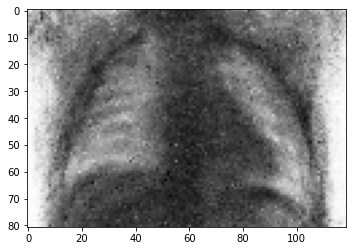

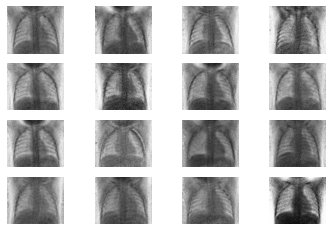

"for i in X:\n    img=np.array(X[i])\n    cv2.imwrite('C:/Digital Engineering/GANSreeni/Generated/generated_'+str(i)+'.png',img)\n    "

In [45]:
#FOr single image
# example of generating an image for a specific point in the latent space
from keras.models import load_model
from numpy import asarray
from matplotlib import pyplot
from numpy.random import randn

# load model
model = load_model('C:/Digital Engineering/GANSreeni/PNEUMONIA3/generator_model_pneumonia2.h5')

#To create same image, suppy same vector each time
# all 0s
#vector = asarray([[0. for _ in range(100)]])  #Vector of all zeros

#To create random images each time...
vector = randn(100) #Vector of random numbers (creates a column, need to reshape)
vector = vector.reshape(1, 100)

# generate image
X = model.predict(vector)

# plot the result
pyplot.imshow(X[0, :, :, 0], cmap='gray_r')
pyplot.show()

#Uncomment to run this part of the code....
##############################################
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot as plt
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	plt.show()
# load model
model = load_model('C:/Digital Engineering/GANSreeni/Normal/generator_model_normal.h5')
# generate images
#Generate 16 images, each image provide a vector of size 100 as input
latent_points = generate_latent_points(100, 16) 
# generate images
X = model.predict(latent_points)
# plot the result
save_plot(X, 4)  #Plot 4x4 grid (Change to 5 if generating 25 images)



'''for i in X:
    img=np.array(X[i])
    cv2.imwrite('C:/Digital Engineering/GANSreeni/Generated/generated_'+str(i)+'.png',img)
    '''

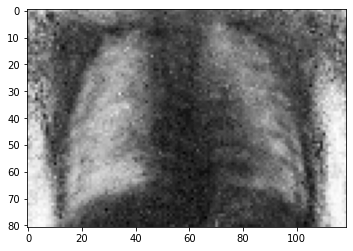

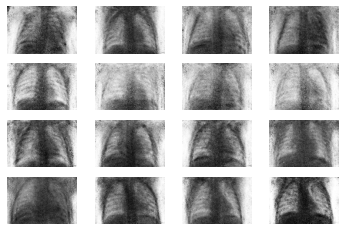

In [32]:
#FOr single image
# example of generating an image for a specific point in the latent space
from tensorflow.keras.models import load_model
from numpy import asarray
from matplotlib import pyplot
from numpy.random import randn

# load model
model = load_model('C:/Digital Engineering/GANSreeni/PNEUMONIA2/generator_model_pneumonia.h5')

#To create same image, suppy same vector each time
# all 0s
#vector = asarray([[0. for _ in range(100)]])  #Vector of all zeros

#To create random images each time...
vector = randn(100) #Vector of random numbers (creates a column, need to reshape)
vector = vector.reshape(1, 100)

# generate image
X = model.predict(vector)

# plot the result
pyplot.imshow(X[0, :, :, 0], cmap='gray_r')
pyplot.show()

#Uncomment to run this part of the code....
##############################################
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot as plt
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
        #axs[i, j].axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	plt.show()
# load model
model = load_model('C:/Digital Engineering/GANSreeni/PNEUMONIA2/generator_model_pneumonia.h5' , compile = False)
# generate images
#Generate 16 images, each image provide a vector of size 100 as input
latent_points = generate_latent_points(100, 16) 
# generate images
X = model.predict(latent_points)
# plot the result
save_plot(X, 4)  #Plot 4x4 grid (Change to 5 if generating 25 images)